In [797]:
import numpy as np
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy import integrate
from numba import jit
import scipy
plt.rc('font', size=18) 

In [1294]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [865]:
from classy import Class
z=0
#Start by specifying the cosmology
Omega_b = 0.049#0.05
Omega_m = 0.32
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.695#0.6711#0.7 #H0/100
A_s = 2.20193e-9
n_s = 0.9632
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':0.02224/h**2,
             'Omega_cdm':0.11542/h**2,
             'h':h,
             'n_s':n_s,
             'sigma8':0.828,#'n_s':n_s,'A_s':A_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [866]:
def get_avg_dist(obs_pos):
    """create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)"""
    Nside_theory= 128
    conf_space = np.linspace(0,1000,Nside_theory)
    x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
    conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
    ds = np.where(conf_norm==0,1,conf_norm)
    return 1/np.mean(1/ds**3)

In [867]:
print(get_avg_dist((500,500,200))**(1/3))

255.01426105201142


In [868]:
b1 = 1
b2 = 0
gamma2 = 0

@jit(nopython=True)
def sqrt(x):
    return x**(1/2)
@jit(nopython=True)
def cos(x):
    return np.cos(x)
@jit(nopython=True)
def sin(x):
    return np.sin(x)
@jit(nopython=True)
def exp(x):
    return np.exp(x)

theta= np.linspace(0,np.pi,50)
k2 = 0.05
k1 = k2/1.1#2*k1/7#k1/5
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))


In [1416]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
D_cl = baLCDM['gr.fac. D']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];
H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)
D_intp = interp1d(z_cl,D_cl,kind='cubic')
dd_dz = interpolate.interp1d((z_cl[1:]+z_cl[:-1])/2,np.diff(xi_cl*h)/np.diff(z_cl)) # derivative of comov to z

<built-in method get_current_derived_parameters of classy.Class object at 0x559caf323f60>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [872]:
#%%time
z= 0
print(z)
#ok so set a comoving distance of observation
print(comoving_dist(z))

#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
    
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    return Pk,Pk_d,Pk_dd

#so set parameters...
Pk,Pk_d,Pk_dd = get_pkinfo_z(k,z)

f = f_intp(z)

Pk1 = Pk(k1)
Pk2 = Pk(k2)
Pk3 = Pk(k3)

Pkd1= Pk_d(k1)
Pkd2 = Pk_d(k2)
Pkd3 = Pk_d(k3)

0
0.0


In [1032]:
with open('../../mathematica_output.txt') as file:
    string1 = file.read()
    #string1 = convert_brackets(string1, 'P')
    string1 = string1.replace("Pk1d","Pkd1").replace("Pk2d","Pkd2").replace("Pk3d","Pkd3")
    #string1 = string1.replace('\n','').replace('  ','').replace("PLff", "Plin_dd").replace("PLf", "Plin_d").replace("PL", "Plin").replace("x", "d").replace("[Omega]", "Omega_m")
    #string1 = string1.replace("Pk^\[Prime]\[Prime]", "Plin_dd").replace("Derivative[1][Pk]", "Plin_d").replace("Pk", "Plin").replace("[ks]", "").replace("ks", "k")#for own calc
#print(string1.replace(". ", "").replace("\n", "").replace("\\", "").replace("x", "d").replace("kd^2", "(k*d**2)"))#.replace("k", "k[i]"))
#change multiplication and
python_mathematica = mathematica(string1)#
#print(str(python_mathematica).replace('cos','np.cos').replace('sin','np.sin').replace('sqrt','np.sqrt').replace('exp','np.exp'))


$\frac{df}{d ln(d)}=\frac{d d}{d ln(d)}\frac{dz}{dd}\frac{df}{dz}=d \times(1/\frac{dd}{dz})\frac{df}{dz}$

In [1415]:
def b_1(zz):
    return np.sqrt(1+zz)
def g_2(zz):
    return -(2/7)*(b_1(zz)-1)
def b_2(zz):
    return 0.412 - 2.143*b_1(zz) +0.929*b_1(zz)**2 + 0.008*b_1(zz)**3 + 4/3 * g_2(zz)
#so get functions for derivatives
z_samps = np.linspace(0.001,10,10000)

#numerical deriv wrt z (z_samps)
db1_dz = interpolate.interp1d((z_samps[1:]+z_samps[:-1])/2,np.diff(b_1(z_samps))/np.diff(z_samps))#find numerical derivatives of biases
db2_dz = interpolate.interp1d((z_samps[1:]+z_samps[:-1])/2,np.diff(b_2(z_samps))/np.diff(z_samps))
dg2_dz = interpolate.interp1d((z_samps[1:]+z_samps[:-1])/2,np.diff(g_2(z_samps))/np.diff(z_samps))
df_dz = interpolate.interp1d((z_samps[1:]+z_samps[:-1])/2,np.diff(f_intp(z_samps))/np.diff(z_samps))
dD_dz = interpolate.interp1d((z_samps[1:]+z_samps[:-1])/2,np.diff(D_intp(z_samps))/np.diff(z_samps))

#so to get the derivataves wrt ln(d) 
#we have dd/dln(d) , dfunc/dz , dz/dd
def b1_d(zz):
    return (comoving_dist(zz))*db1_dz(zz)*(1/dd_dz(zz))
def b2_d(zz):
    return (comoving_dist(zz))*db2_dz(zz)*(1/dd_dz(zz))
def g2_d(zz):
    return (comoving_dist(zz))*dg2_dz(zz)*(1/dd_dz(zz))
def f_d(zz):
    return (comoving_dist(zz))*df_dz(zz)*(1/dd_dz(zz))
def D_d(zz):
    return (comoving_dist(zz))*dD_dz(zz)*(1/dd_dz(zz))

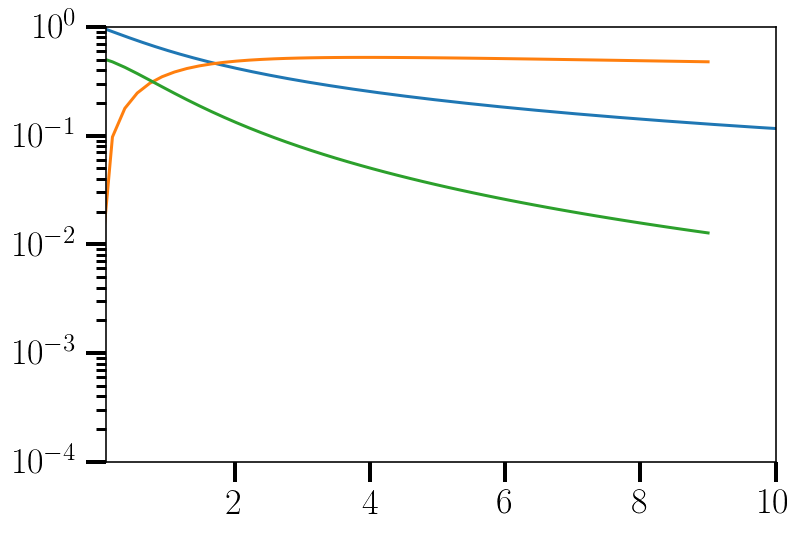

In [1418]:
zz= np.linspace(0.01,9)
plt.plot(z_cl,D_cl)
plt.plot(zz,-(comoving_dist(zz))*dD_dz(zz)*(1/dd_dz(zz)))
plt.plot(zz,-dD_dz(zz))
plt.xlim(1e-1,1e+1)
plt.ylim(1e-4,1e+0)
plt.yscale('log')

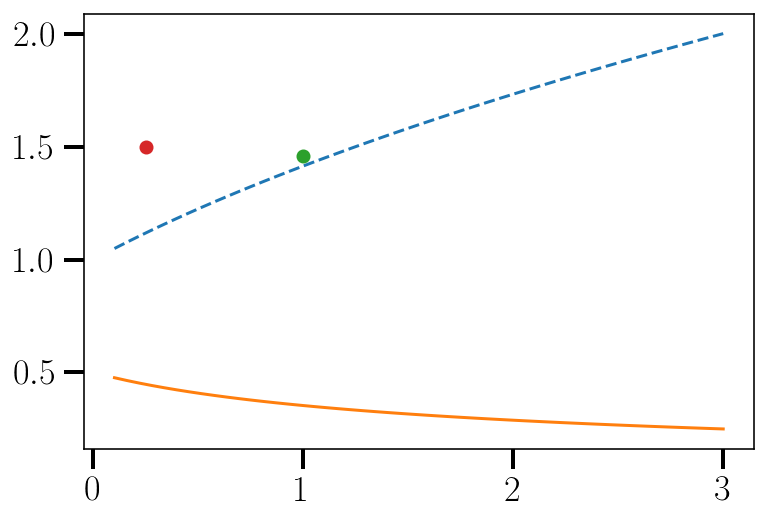

In [1363]:
z_plot = np.linspace(0.1,3)
plt.plot(z_plot,b_1(z_plot),'--')
plt.plot(z_plot,db1_dz(z_plot))
plt.plot(1,1.46,'o')
plt.plot(0.25,1.5,'o')

0.48277619201056343


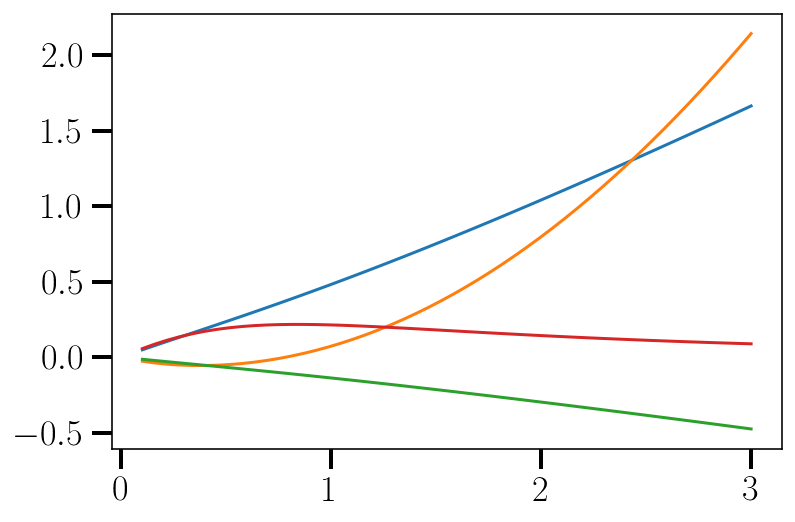

In [1056]:
print(b1_d(1))
z_plot = np.linspace(0.1,3)
plt.plot(z_plot,b1_d(z_plot))
plt.plot(z_plot,b2_d(z_plot))
plt.plot(z_plot,g2_d(z_plot))
plt.plot(z_plot,f_d(z_plot))

In [806]:
def bk_real(k1,k2,theta):
    """Real space bispectrum"""
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    return (k1*k2*(19*Pk1*Pk2*k1**2 + 2*Pk1*Pk2*k1*k2*np.cos(3*theta) + 19*Pk1*Pk2*k2**2 - 2*Pk1*Pk3*k2**2 - 2*Pk2*Pk3*k1**2 + (Pk1*k2**2*(9*Pk2 - 5*Pk3) + Pk2*k1**2*(9*Pk1 - 5*Pk3))*np.cos(2*theta)) + (40*Pk1*Pk2*k1**2*k2**2 + 7*Pk1*k2**4*(Pk2 - Pk3) + 7*Pk2*k1**4*(Pk1 - Pk3))*np.cos(theta))/(7*k1*k2*(k1**2 + 2*k1*k2*np.cos(theta) + k2**2))


In [807]:
#ok so we have to do numerical integration for FOG of the bispectrum... PP parts that can be integrated for monpole or quadrupole
def bk_dfog(l,k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    sigma = 2
    def integrand(phi,mu):
        expression = (Pk1*Pk2*(b1 + f*mu**2)*(b1 + f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2)*(b1*f*k1*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k2 + b1*f*mu**2 + b1*f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 + b1*f*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k1 + b1*k1*np.cos(theta)/k2 + 4*b1*np.cos(theta)**2/7 + 10*b1/7 + b1*k2*np.cos(theta)/k1 + b2 + f**2*k1*mu**3*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k2 + 2*f**2*mu**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 + f**2*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**3/k1 + f*k1**3*mu**2*np.cos(theta)/(k2*k3**2) + 8*f*k1**2*mu**2*np.cos(theta)**2/(7*k3**2) + 6*f*k1**2*mu**2/(7*k3**2) + 2*f*k1**2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))*np.cos(theta)/k3**2 + f*k1*k2*mu**2*np.cos(theta)/k3**2 + 16*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))*np.cos(theta)**2/(7*k3**2) + 12*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/(7*k3**2) + f*k1*k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/k3**2 + 2*f*k2**2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))*np.cos(theta)/k3**2 + 8*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)**2/(7*k3**2) + 6*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/(7*k3**2) + f*k2**3*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/(k1*k3**2) + 2*gamma2*np.cos(theta)**2 - 2*gamma2) + Pk1*Pk3*(b1 + f*mu**2)*(b1 + f*(-k1*mu - k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)))**2/k3**2)*(b1*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3**2 + b1*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/k3**2 - b1*f*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k1 - 3*b1*k1**2/(7*k3**2) + b1*k1*k2*np.cos(theta)/(7*k3**2) + 4*b1*k2**2*np.cos(theta)**2/(7*k3**2) + 3*b1/7 - b1*k2*np.cos(theta)/k1 + b2 - f**2*k2**2*mu**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/k3**2 - f**2*k2**3*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**3/(k1*k3**2) + f*k1**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/(7*k3**2) + 9*f*k1*k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/(7*k3**2) + 8*f*k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)**2/(7*k3**2) - f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/7 - f*k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2*np.cos(theta)/k1 + 2*gamma2*k1**2/k3**2 + 4*gamma2*k1*k2*np.cos(theta)/k3**2 + 2*gamma2*k2**2*np.cos(theta)**2/k3**2 - 2*gamma2) + Pk2*Pk3*(b1 + f*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2)*(b1 + f*(-k1*mu - k2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi)))**2/k3**2)*(b1*f*k1**2*mu**2/k3**2 + b1*f*k1*k2*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3**2 - b1*f*k1*mu*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k2 + 4*b1*k1**2*np.cos(theta)**2/(7*k3**2) + b1*k1*k2*np.cos(theta)/(7*k3**2) - b1*k1*np.cos(theta)/k2 - 3*b1*k2**2/(7*k3**2) + 3*b1/7 + b2 - f**2*k1**3*mu**3*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/(k2*k3**2) - f**2*k1**2*mu**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2/k3**2 + 8*f*k1**2*mu**2*np.cos(theta)**2/(7*k3**2) + 9*f*k1*k2*mu**2*np.cos(theta)/(7*k3**2) - f*k1*mu**2*np.cos(theta)/k2 + f*k2**2*mu**2/(7*k3**2) - f*mu**2/7 + 2*gamma2*k1**2*np.cos(theta)**2/k3**2 + 4*gamma2*k1*k2*np.cos(theta)/k3**2 + 2*gamma2*k2**2/k3**2 - 2*gamma2))*np.exp(sigma**2*(-k1**2*mu**2 - k2**2*(mu*np.cos(theta) + np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))**2 - k3**2*(-k1*mu/k3 + k2*(-mu*np.cos(theta) - np.sqrt(1 - mu**2)*np.sin(theta)*np.cos(phi))/k3)**2))
        
        legendre = scipy.special.eval_legendre(l, mu)
        return (2*l+1)*legendre*expression/(4*np.pi)
    
    result, error = integrate.nquad(integrand, [[0, 2*np.pi], [-1, 1]])            
    return result,error

print(bk_dfog(0,0.08,0.06,np.pi/2))

(216819722.73466912, 0.27885010309110186)


In [17]:
%%time
bk_arr = np.zeros(len(theta))
for i in tqdm(range(len(theta))):
    bk_arr[i]=bk_dfog(2,k1,k2,theta[i])[0]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 88 ms, total: 13.4 s
Wall time: 13.4 s


In [808]:
#PP monopole and parallel in redshift space
def bk_mono_func(k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    
    #monopole parts
    bkperm3 = -Pk2*Pk3*(1470*b1**3*f*k1**4*k2 + 1470*b1**3*f*k1**3*k2**2*cos(3*theta) + 5670*b1**3*k1**4*k2 + 3150*b1**3*k1**3*k2**2*cos(3*theta) + 1260*b1**3*k1**2*k2**3 - 4410*b1**2*b2*k1**4*k2 - 17640*b1**2*b2*k1**2*k2**3 - 4410*b1**2*b2*k2**5 + 3822*b1**2*f**2*k1**4*k2 + 1470*b1**2*f**2*k1**3*k2**2*cos(3*theta) + 1176*b1**2*f**2*k1**2*k2**3 + 6090*b1**2*f*k1**4*k2 + 2730*b1**2*f*k1**3*k2**2*cos(3*theta) + 1680*b1**2*f*k1**2*k2**3 + 4410*b1**2*gamma2*k1**4*k2 - 4410*b1**2*gamma2*k1**3*k2**2*cos(3*theta) + 4410*b1**2*gamma2*k1**2*k2**3 - 2940*b1*b2*f*k1**4*k2 - 11760*b1*b2*f*k1**2*k2**3 - 2940*b1*b2*f*k2**5 + 126*b1*f**3*k1**5*cos(3*theta) + 126*b1*f**3*k1**4*k2*cos(4*theta) + 3024*b1*f**3*k1**4*k2 + 882*b1*f**3*k1**3*k2**2*cos(3*theta) + 1008*b1*f**3*k1**2*k2**3 + 294*b1*f**2*k1**5*cos(3*theta) + 315*b1*f**2*k1**4*k2*cos(4*theta) + 3675*b1*f**2*k1**4*k2 + 1785*b1*f**2*k1**3*k2**2*cos(3*theta) + 63*b1*f**2*k1**3*k2**2*cos(5*theta) + 126*b1*f**2*k1**2*k2**3*cos(4*theta) + 1050*b1*f**2*k1**2*k2**3 + 2940*b1*f*gamma2*k1**4*k2 - 2940*b1*f*gamma2*k1**3*k2**2*cos(3*theta) + 2940*b1*f*gamma2*k1**2*k2**3 - 588*b2*f**2*k1**4*k2 - 294*b2*f**2*k1**3*k2**2*cos(3*theta) - 3234*b2*f**2*k1**2*k2**3 - 882*b2*f**2*k2**5 + 70*f**4*k1**5*cos(3*theta) + 42*f**4*k1**4*k2*cos(4*theta) + 756*f**4*k1**4*k2 + 210*f**4*k1**3*k2**2*cos(3*theta) + 280*f**4*k1**2*k2**3 + 126*f**3*k1**5*cos(3*theta) + 117*f**3*k1**4*k2*cos(4*theta) + 837*f**3*k1**4*k2 + 441*f**3*k1**3*k2**2*cos(3*theta) + 27*f**3*k1**3*k2**2*cos(5*theta) + 54*f**3*k1**2*k2**3*cos(4*theta) + 270*f**3*k1**2*k2**3 - 147*f**2*gamma2*k1**4*k2*cos(4*theta) + 441*f**2*gamma2*k1**4*k2 - 882*f**2*gamma2*k1**3*k2**2*cos(3*theta) + 882*f**2*gamma2*k1**2*k2**3 + 6*k1**2*k2*(35*b1**3*(k1**2*(14*f + 36) + k2**2*(7*f + 15)) + 7*b1**2*(-210*b2*k2**2 + 7*f**2*(14*k1**2 + 5*k2**2) + 5*f*(34*k1**2 + 13*k2**2) - 105*gamma2*(k1**2 + k2**2)) + 7*b1*f*(-140*b2*k2**2 + 3*f**2*(20*k1**2 + 7*k2**2) + f*(94*k1**2 + 35*k2**2) - 70*gamma2*(k1**2 + k2**2)) + f**2*(-49*b2*(k1**2 + 7*k2**2) + 7*f**2*(16*k1**2 + 5*k2**2) + 3*f*(52*k1**2 + 17*k2**2) - 49*gamma2*(k1**2 + 3*k2**2)))*cos(2*theta) + 6*k1*(35*b1**3*(k1**4*(7*f + 21) + k1**2*k2**2*(14*f + 48)) + 7*b1**2*(7*f**2*(9*k1**4 + 22*k1**2*k2**2) + 5*f*(21*k1**4 + 50*k1**2*k2**2) - 105*k2**2*(4*b2*(k1**2 + k2**2) - gamma2*k1**2)) + 7*b1*f*(6*f**2*(7*k1**4 + 19*k1**2*k2**2) + f*(56*k1**4 + 145*k1**2*k2**2) - 70*k2**2*(4*b2*(k1**2 + k2**2) - gamma2*k1**2)) + f**2*(70*f**2*(k1**4 + 3*k1**2*k2**2) + 3*f*(28*k1**4 + 79*k1**2*k2**2) - 49*k2**2*(11*b2*k1**2 + 12*b2*k2**2 - 3*gamma2*k1**2)))*cos(theta))/(4410*k2*k3**4)
    bkperm2 = -Pk1*Pk3*(1470*b1**3*f*k1**2*k2**3*cos(3*theta) + 1470*b1**3*f*k1*k2**4 + 1260*b1**3*k1**3*k2**2 + 3150*b1**3*k1**2*k2**3*cos(3*theta) + 5670*b1**3*k1*k2**4 - 4410*b1**2*b2*k1**5 - 17640*b1**2*b2*k1**3*k2**2 - 4410*b1**2*b2*k1*k2**4 + 1176*b1**2*f**2*k1**3*k2**2 + 1470*b1**2*f**2*k1**2*k2**3*cos(3*theta) + 3822*b1**2*f**2*k1*k2**4 + 1680*b1**2*f*k1**3*k2**2 + 2730*b1**2*f*k1**2*k2**3*cos(3*theta) + 6090*b1**2*f*k1*k2**4 + 4410*b1**2*gamma2*k1**3*k2**2 - 4410*b1**2*gamma2*k1**2*k2**3*cos(3*theta) + 4410*b1**2*gamma2*k1*k2**4 - 2940*b1*b2*f*k1**5 - 11760*b1*b2*f*k1**3*k2**2 - 2940*b1*b2*f*k1*k2**4 + 1008*b1*f**3*k1**3*k2**2 + 882*b1*f**3*k1**2*k2**3*cos(3*theta) + 126*b1*f**3*k1*k2**4*cos(4*theta) + 3024*b1*f**3*k1*k2**4 + 126*b1*f**3*k2**5*cos(3*theta) + 126*b1*f**2*k1**3*k2**2*cos(4*theta) + 1050*b1*f**2*k1**3*k2**2 + 1785*b1*f**2*k1**2*k2**3*cos(3*theta) + 63*b1*f**2*k1**2*k2**3*cos(5*theta) + 315*b1*f**2*k1*k2**4*cos(4*theta) + 3675*b1*f**2*k1*k2**4 + 294*b1*f**2*k2**5*cos(3*theta) + 2940*b1*f*gamma2*k1**3*k2**2 - 2940*b1*f*gamma2*k1**2*k2**3*cos(3*theta) + 2940*b1*f*gamma2*k1*k2**4 - 882*b2*f**2*k1**5 - 3234*b2*f**2*k1**3*k2**2 - 294*b2*f**2*k1**2*k2**3*cos(3*theta) - 588*b2*f**2*k1*k2**4 + 280*f**4*k1**3*k2**2 + 210*f**4*k1**2*k2**3*cos(3*theta) + 42*f**4*k1*k2**4*cos(4*theta) + 756*f**4*k1*k2**4 + 70*f**4*k2**5*cos(3*theta) + 54*f**3*k1**3*k2**2*cos(4*theta) + 270*f**3*k1**3*k2**2 + 441*f**3*k1**2*k2**3*cos(3*theta) + 27*f**3*k1**2*k2**3*cos(5*theta) + 117*f**3*k1*k2**4*cos(4*theta) + 837*f**3*k1*k2**4 + 126*f**3*k2**5*cos(3*theta) + 882*f**2*gamma2*k1**3*k2**2 - 882*f**2*gamma2*k1**2*k2**3*cos(3*theta) - 147*f**2*gamma2*k1*k2**4*cos(4*theta) + 441*f**2*gamma2*k1*k2**4 + 6*k1*k2**2*(35*b1**3*(k1**2*(7*f + 15) + k2**2*(14*f + 36)) - 7*b1**2*(210*b2*k1**2 - 7*f**2*(5*k1**2 + 14*k2**2) - 5*f*(13*k1**2 + 34*k2**2) + 105*gamma2*(k1**2 + k2**2)) + 7*b1*f*(-140*b2*k1**2 + 3*f**2*(7*k1**2 + 20*k2**2) + f*(35*k1**2 + 94*k2**2) - 70*gamma2*(k1**2 + k2**2)) + f**2*(-49*b2*(7*k1**2 + k2**2) + 7*f**2*(5*k1**2 + 16*k2**2) + 3*f*(17*k1**2 + 52*k2**2) - 49*gamma2*(3*k1**2 + k2**2)))*cos(2*theta) + 6*k2*(35*b1**3*(k1**2*k2**2*(14*f + 48) + k2**4*(7*f + 21)) - 7*b1**2*(420*b2*k1**2*(k1**2 + k2**2) - k2**2*(7*f**2*(22*k1**2 + 9*k2**2) + 5*f*(50*k1**2 + 21*k2**2) + 105*gamma2*k1**2)) + 7*b1*f*(-280*b2*k1**2*(k1**2 + k2**2) + k2**2*(6*f**2*(19*k1**2 + 7*k2**2) + f*(145*k1**2 + 56*k2**2) + 70*gamma2*k1**2)) + f**2*(-49*b2*(12*k1**4 + 11*k1**2*k2**2) + k2**2*(70*f**2*(3*k1**2 + k2**2) + 3*f*(79*k1**2 + 28*k2**2) + 147*gamma2*k1**2)))*cos(theta))/(4410*k1*k3**4)
    bkperm1 = Pk1*Pk2*(4410*b1**3*f*k1**3*k2 + 4410*b1**3*f*k1*k2**3 + 11970*b1**3*k1**3*k2 + 1260*b1**3*k1**2*k2**2*cos(3*theta) + 11970*b1**3*k1*k2**3 + 4410*b1**2*b2*k1**3*k2 + 4410*b1**2*b2*k1*k2**3 + 6762*b1**2*f**2*k1**3*k2 + 1176*b1**2*f**2*k1**2*k2**2*cos(3*theta) + 6762*b1**2*f**2*k1*k2**3 + 11550*b1**2*f*k1**3*k2 + 1680*b1**2*f*k1**2*k2**2*cos(3*theta) + 11550*b1**2*f*k1*k2**3 - 4410*b1**2*gamma2*k1**3*k2 + 4410*b1**2*gamma2*k1**2*k2**2*cos(3*theta) - 4410*b1**2*gamma2*k1*k2**3 + 2940*b1*b2*f*k1**3*k2 + 2940*b1*b2*f*k1*k2**3 + 126*b1*f**3*k1**4*cos(3*theta) + 126*b1*f**3*k1**3*k2*cos(4*theta) + 4032*b1*f**3*k1**3*k2 + 1764*b1*f**3*k1**2*k2**2*cos(3*theta) + 126*b1*f**3*k1*k2**3*cos(4*theta) + 4032*b1*f**3*k1*k2**3 + 126*b1*f**3*k2**4*cos(3*theta) + 294*b1*f**2*k1**4*cos(3*theta) + 273*b1*f**2*k1**3*k2*cos(4*theta) + 5733*b1*f**2*k1**3*k2 + 2310*b1*f**2*k1**2*k2**2*cos(3*theta) + 42*b1*f**2*k1**2*k2**2*cos(5*theta) + 273*b1*f**2*k1*k2**3*cos(4*theta) + 5733*b1*f**2*k1*k2**3 + 294*b1*f**2*k2**4*cos(3*theta) - 2940*b1*f*gamma2*k1**3*k2 + 2940*b1*f*gamma2*k1**2*k2**2*cos(3*theta) - 2940*b1*f*gamma2*k1*k2**3 + 588*b2*f**2*k1**3*k2 + 294*b2*f**2*k1**2*k2**2*cos(3*theta) + 588*b2*f**2*k1*k2**3 + 70*f**4*k1**4*cos(3*theta) + 98*f**4*k1**3*k2*cos(4*theta) + 924*f**4*k1**3*k2 + 616*f**4*k1**2*k2**2*cos(3*theta) + 28*f**4*k1**2*k2**2*cos(5*theta) + 98*f**4*k1*k2**3*cos(4*theta) + 924*f**4*k1*k2**3 + 70*f**4*k2**4*cos(3*theta) + 126*f**3*k1**4*cos(3*theta) + 135*f**3*k1**3*k2*cos(4*theta) + 1179*f**3*k1**3*k2 + 756*f**3*k1**2*k2**2*cos(3*theta) + 36*f**3*k1**2*k2**2*cos(5*theta) + 135*f**3*k1*k2**3*cos(4*theta) + 1179*f**3*k1*k2**3 + 126*f**3*k2**4*cos(3*theta) + 147*f**2*gamma2*k1**3*k2*cos(4*theta) - 441*f**2*gamma2*k1**3*k2 + 441*f**2*gamma2*k1**2*k2**2*cos(3*theta) + 147*f**2*gamma2*k1**2*k2**2*cos(5*theta) + 147*f**2*gamma2*k1*k2**3*cos(4*theta) - 441*f**2*gamma2*k1*k2**3 + k1*k2*(k1**2 + k2**2)*(210*b1**3*(7*f + 27) + 42*b1**2*(91*f**2 + 145*f + 105*gamma2) + 42*b1*f*(81*f**2 + 109*f + 70*gamma2) + 2*f**2*(147*b2 + 469*f**2 + 603*f + 147*gamma2))*cos(2*theta) + (210*b1**3*(k1**4*(7*f + 21) + k1**2*k2**2*(42*f + 120) + k2**4*(7*f + 21)) + 42*b1**2*(7*f**2*(9*k1**4 + 50*k1**2*k2**2 + 9*k2**4) + 5*f*(21*k1**4 + 118*k1**2*k2**2 + 21*k2**4) + k1**2*k2**2*(210*b2 - 105*gamma2)) + 84*b1*f*(3*f**2*(7*k1**4 + 38*k1**2*k2**2 + 7*k2**4) + 7*f*(4*k1**4 + 23*k1**2*k2**2 + 4*k2**4) + k1**2*k2**2*(70*b2 - 35*gamma2)) + 2*f**2*(14*f**2*(15*k1**4 + 82*k1**2*k2**2 + 15*k2**4) + 18*f*(14*k1**4 + 83*k1**2*k2**2 + 14*k2**4) + k1**2*k2**2*(735*b2 - 294*gamma2)))*cos(theta))/(4410*k1*k2*k3**2)
    return (bkperm3+bkperm2+bkperm1)

bkmono = bk_mono_func(k1,k2,theta)

def bk_quad_func(k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    
    #quadrupole parts
    bkquad1 = -Pk2*Pk3*f*(12936*b1**3*k1**4*k2 + 12936*b1**3*k1**3*k2**2*cos(3*theta) + 2079*b1**2*f*k1**5*cos(3*theta) + 4158*b1**2*f*k1**4*k2*cos(4*theta) + 41118*b1**2*f*k1**4*k2 + 27489*b1**2*f*k1**3*k2**2*cos(3*theta) + 2079*b1**2*f*k1**3*k2**2*cos(5*theta) + 4158*b1**2*f*k1**2*k2**3*cos(4*theta) + 12012*b1**2*f*k1**2*k2**3 + 4851*b1**2*k1**5*cos(3*theta) + 8316*b1**2*k1**4*k2*cos(4*theta) + 49434*b1**2*k1**4*k2 + 33033*b1**2*k1**3*k2**2*cos(3*theta) + 3465*b1**2*k1**3*k2**2*cos(5*theta) + 6930*b1**2*k1**2*k2**3*cos(4*theta) + 16170*b1**2*k1**2*k2**3 - 16170*b1*b2*k1**4*k2 - 19404*b1*b2*k1**3*k2**2*cos(3*theta) - 9702*b1*b2*k1**2*k2**3*cos(4*theta) - 64680*b1*b2*k1**2*k2**3 - 29106*b1*b2*k1*k2**4*cos(3*theta) - 6468*b1*b2*k2**5 + 3234*b1*f**2*k1**5*cos(3*theta) + 4620*b1*f**2*k1**4*k2*cos(4*theta) + 37884*b1*f**2*k1**4*k2 + 20790*b1*f**2*k1**3*k2**2*cos(3*theta) + 1386*b1*f**2*k1**3*k2**2*cos(5*theta) + 2772*b1*f**2*k1**2*k2**3*cos(4*theta) + 11088*b1*f**2*k1**2*k2**3 + 5082*b1*f*k1**5*cos(3*theta) + 7524*b1*f*k1**4*k2*cos(4*theta) + 43032*b1*f*k1**4*k2 + 28182*b1*f*k1**3*k2**2*cos(3*theta) + 2574*b1*f*k1**3*k2**2*cos(5*theta) + 5148*b1*f*k1**2*k2**3*cos(4*theta) + 12804*b1*f*k1**2*k2**3 - 4851*b1*gamma2*k1**4*k2*cos(4*theta) + 11319*b1*gamma2*k1**4*k2 - 11319*b1*gamma2*k1**3*k2**2*cos(3*theta) - 4851*b1*gamma2*k1**3*k2**2*cos(5*theta) - 9702*b1*gamma2*k1**2*k2**3*cos(4*theta) - 3234*b1*gamma2*k1**2*k2**3 - 6006*b2*f*k1**4*k2 - 9240*b2*f*k1**3*k2**2*cos(3*theta) - 4158*b2*f*k1**2*k2**3*cos(4*theta) - 26796*b2*f*k1**2*k2**3 - 12474*b2*f*k1*k2**4*cos(3*theta) - 2772*b2*f*k2**5 + 1435*f**3*k1**5*cos(3*theta) + 1428*f**3*k1**4*k2*cos(4*theta) + 10584*f**3*k1**4*k2 + 5565*f**3*k1**3*k2**2*cos(3*theta) + 315*f**3*k1**3*k2**2*cos(5*theta) + 630*f**3*k1**2*k2**3*cos(4*theta) + 3220*f**3*k1**2*k2**3 + 2079*f**2*k1**5*cos(3*theta) + 2508*f**2*k1**4*k2*cos(4*theta) + 11418*f**2*k1**4*k2 + 7656*f**2*k1**3*k2**2*cos(3*theta) + 924*f**2*k1**3*k2**2*cos(5*theta) + 1254*f**2*k1**2*k2**3*cos(4*theta) + 99*f**2*k1**2*k2**3*cos(6*theta) + 3366*f**2*k1**2*k2**3 - 2541*f*gamma2*k1**4*k2*cos(4*theta) + 3465*f*gamma2*k1**4*k2 - 4851*f*gamma2*k1**3*k2**2*cos(3*theta) - 2079*f*gamma2*k1**3*k2**2*cos(5*theta) - 4158*f*gamma2*k1**2*k2**3*cos(4*theta) - 1386*f*gamma2*k1**2*k2**3 + 3*k1*(4312*b1**3*(k1**4 + 2*k1**2*k2**2) + 77*b1**2*k1**2*(k1**2*(135*f + 147) + k2**2*(304*f + 346)) + 22*b1*(7*f**2*(53*k1**4 + 132*k1**2*k2**2) + f*(427*k1**4 + 1046*k1**2*k2**2) - 49*k2**2*(26*b2*k1**2 + 23*b2*k2**2 - 5*gamma2*k1**2)) + f*(35*f**2*(61*k1**4 + 168*k1**2*k2**2) + 11*f*(217*k1**4 + 580*k1**2*k2**2) - 154*k2**2*(76*b2*k1**2 + 69*b2*k2**2 - 15*gamma2*k1**2)))*cos(theta) + 3*k2*(4312*b1**3*k1**2*(2*k1**2 + k2**2) + 154*b1**2*k1**2*(k1**2*(118*f + 127) + k2**2*(37*f + 34)) - 22*b1*(49*b2*(3*k1**4 + 25*k1**2*k2**2 + 6*k2**4) - 2*k1**2*(7*f**2*(44*k1**2 + 15*k2**2) + f*(373*k1**2 + 116*k2**2) - 49*gamma2*(k1**2 - 2*k2**2))) + f*(-154*b2*(11*k1**4 + 77*k1**2*k2**2 + 18*k2**4) + k1**2*(14*f**2*(274*k1**2 + 95*k2**2) + 11*f*(418*k1**2 + 137*k2**2) - 308*gamma2*(k1**2 - 6*k2**2))))*cos(2*theta))/(19404*k2*k3**4)
    bkquad2 = -Pk1*Pk3*f*(9702*b1**3*k1**3*k2**2 + 3234*b1**3*k1**2*k2**3*cos(3*theta) + 22638*b1**3*k1*k2**4 + 16170*b1**2*f*k1**3*k2**2 + 19173*b1**2*f*k1**2*k2**3*cos(3*theta) + 4158*b1**2*f*k1*k2**4*cos(4*theta) + 49434*b1**2*f*k1*k2**4 + 4158*b1**2*f*k2**5*cos(3*theta) + 2079*b1**2*k1**3*k2**2*cos(4*theta) + 11319*b1**2*k1**3*k2**2 + 32340*b1**2*k1**2*k2**3*cos(3*theta) + 2079*b1**2*k1**2*k2**3*cos(5*theta) + 10395*b1**2*k1*k2**4*cos(4*theta) + 45969*b1**2*k1*k2**4 + 9702*b1**2*k2**5*cos(3*theta) - 25872*b1*b2*k1**5 - 93786*b1*b2*k1**3*k2**2 - 9702*b1*b2*k1**2*k2**3*cos(3*theta) - 16170*b1*b2*k1*k2**4 + 14322*b1*f**2*k1**3*k2**2 + 15708*b1*f**2*k1**2*k2**3*cos(3*theta) + 4158*b1*f**2*k1*k2**4*cos(4*theta) + 38808*b1*f**2*k1*k2**4 + 5544*b1*f**2*k2**5*cos(3*theta) + 2178*b1*f*k1**3*k2**2*cos(4*theta) + 12210*b1*f*k1**3*k2**2 + 25806*b1*f*k1**2*k2**3*cos(3*theta) + 1980*b1*f*k1**2*k2**3*cos(5*theta) + 9306*b1*f*k1*k2**4*cos(4*theta) + 40062*b1*f*k1*k2**4 + 9240*b1*f*k2**5*cos(3*theta) + 25872*b1*gamma2*k1**3*k2**2 - 25872*b1*gamma2*k1**2*k2**3*cos(3*theta) - 4851*b1*gamma2*k1*k2**4*cos(4*theta) + 11319*b1*gamma2*k1*k2**4 - 11088*b2*f*k1**5 - 39270*b2*f*k1**3*k2**2 - 5082*b2*f*k1**2*k2**3*cos(3*theta) - 6006*b2*f*k1*k2**4 + 4270*f**3*k1**3*k2**2 + 4305*f**3*k1**2*k2**3*cos(3*theta) + 1428*f**3*k1*k2**4*cos(4*theta) + 10584*f**3*k1*k2**4 + 1855*f**3*k2**5*cos(3*theta) + 105*f**3*k2**5*cos(5*theta) + 891*f**2*k1**3*k2**2*cos(4*theta) + 3795*f**2*k1**3*k2**2 + 7194*f**2*k1**2*k2**3*cos(3*theta) + 693*f**2*k1**2*k2**3*cos(5*theta) + 2871*f**2*k1*k2**4*cos(4*theta) + 99*f**2*k1*k2**4*cos(6*theta) + 10989*f**2*k1*k2**4 + 2541*f**2*k2**5*cos(3*theta) + 231*f**2*k2**5*cos(5*theta) + 11088*f*gamma2*k1**3*k2**2 - 11088*f*gamma2*k1**2*k2**3*cos(3*theta) - 2541*f*gamma2*k1*k2**4*cos(4*theta) + 3465*f*gamma2*k1*k2**4 + 3*k1*k2**2*(1078*b1**3*(k1**2 + 5*k2**2) + 154*b1**2*(k1**2*(37*f + 55) + k2**2*(100*f + 130)) + 22*b1*(-49*b2*(19*k1**2 + 3*k2**2) + 203*f**2*(k1**2 + 3*k2**2) + f*(286*k1**2 + 764*k2**2) - 98*gamma2*(4*k1**2 + k2**2)) + f*(-154*b2*(59*k1**2 + 11*k2**2) + 14*f**2*(85*k1**2 + 274*k2**2) + 33*f*(46*k1**2 + 139*k2**2) - 308*gamma2*(12*k1**2 + k2**2)))*cos(2*theta) + 3*k2*(1078*b1**3*(11*k1**2*k2**2 + 4*k2**4) + 77*b1**2*(k1**2*k2**2*(349*f + 355) + k2**4*(126*f + 126)) - 22*b1*(49*b2*(32*k1**4 + 29*k1**2*k2**2) - k2**2*(14*f**2*(73*k1**2 + 24*k2**2) + f*(1091*k1**2 + 364*k2**2) + 392*gamma2*k1**2)) + f*(-154*b2*(96*k1**4 + 85*k1**2*k2**2) + k2**2*(35*f**2*(183*k1**2 + 56*k2**2) + 11*f*(601*k1**2 + 196*k2**2) + 3696*gamma2*k1**2)))*cos(theta))/(19404*k1*k3**4)
    bkquad3 = Pk1*Pk2*f*(29106*b1**3*k1**3*k2 + 9702*b1**3*k1**2*k2**2*cos(3*theta) + 29106*b1**3*k1*k2**3 + 2079*b1**2*f*k1**4*cos(3*theta) + 2079*b1**2*f*k1**3*k2*cos(4*theta) + 69069*b1**2*f*k1**3*k2 + 34881*b1**2*f*k1**2*k2**2*cos(3*theta) + 4158*b1**2*f*k1*k2**3*cos(4*theta) + 66990*b1**2*f*k1*k2**3 + 4158*b1**2*f*k2**4*cos(3*theta) + 4851*b1**2*k1**4*cos(3*theta) + 6237*b1**2*k1**3*k2*cos(4*theta) + 81543*b1**2*k1**3*k2 + 44583*b1**2*k1**2*k2**2*cos(3*theta) + 1386*b1**2*k1**2*k2**2*cos(5*theta) + 9009*b1**2*k1*k2**3*cos(4*theta) + 70455*b1**2*k1*k2**3 + 9702*b1**2*k2**4*cos(3*theta) + 16170*b1*b2*k1**3*k2 + 9702*b1*b2*k1**2*k2**2*cos(3*theta) + 16170*b1*b2*k1*k2**3 + 3234*b1*f**2*k1**4*cos(3*theta) + 4620*b1*f**2*k1**3*k2*cos(4*theta) + 52206*b1*f**2*k1**3*k2 + 36498*b1*f**2*k1**2*k2**2*cos(3*theta) + 1386*b1*f**2*k1**2*k2**2*cos(5*theta) + 6930*b1*f**2*k1*k2**3*cos(4*theta) + 49896*b1*f**2*k1*k2**3 + 5544*b1*f**2*k2**4*cos(3*theta) + 5082*b1*f*k1**4*cos(3*theta) + 6798*b1*f*k1**3*k2*cos(4*theta) + 65538*b1*f*k1**3*k2 + 42900*b1*f*k1**2*k2**2*cos(3*theta) + 1914*b1*f*k1**2*k2**2*cos(5*theta) + 9174*b1*f*k1*k2**3*cos(4*theta) + 56034*b1*f*k1*k2**3 + 9240*b1*f*k2**4*cos(3*theta) + 4851*b1*gamma2*k1**3*k2*cos(4*theta) - 11319*b1*gamma2*k1**3*k2 + 11319*b1*gamma2*k1**2*k2**2*cos(3*theta) + 4851*b1*gamma2*k1**2*k2**2*cos(5*theta) + 4851*b1*gamma2*k1*k2**3*cos(4*theta) - 11319*b1*gamma2*k1*k2**3 + 6006*b2*f*k1**3*k2 + 5082*b2*f*k1**2*k2**2*cos(3*theta) + 6006*b2*f*k1*k2**3 + 1435*f**3*k1**4*cos(3*theta) + 2387*f**3*k1**3*k2*cos(4*theta) + 13461*f**3*k1**3*k2 + 11914*f**3*k1**2*k2**2*cos(3*theta) + 1057*f**3*k1**2*k2**2*cos(5*theta) + 2912*f**3*k1*k2**3*cos(4*theta) + 105*f**3*k1*k2**3*cos(6*theta) + 12936*f**3*k1*k2**3 + 1855*f**3*k2**4*cos(3*theta) + 105*f**3*k2**4*cos(5*theta) + 2079*f**2*k1**4*cos(3*theta) + 2805*f**2*k1**3*k2*cos(4*theta) + 16071*f**2*k1**3*k2 + 13596*f**2*k1**2*k2**2*cos(3*theta) + 1155*f**2*k1**2*k2**2*cos(5*theta) + 3597*f**2*k1*k2**3*cos(4*theta) + 132*f**2*k1*k2**3*cos(6*theta) + 14883*f**2*k1*k2**3 + 2541*f**2*k2**4*cos(3*theta) + 231*f**2*k2**4*cos(5*theta) + 2541*f*gamma2*k1**3*k2*cos(4*theta) - 3465*f*gamma2*k1**3*k2 + 3465*f*gamma2*k1**2*k2**2*cos(3*theta) + 2541*f*gamma2*k1**2*k2**2*cos(5*theta) + 2541*f*gamma2*k1*k2**3*cos(4*theta) - 3465*f*gamma2*k1*k2**3 + k1*k2*(22638*b1**3*(k1**2 + k2**2) + 924*b1**2*(k1**2*(67*f + 73) + k2**2*(67*f + 82)) + 66*b1*(147*b2*(k1**2 + k2**2) + 819*f**2*(k1**2 + k2**2) + 4*f*(230*k1**2 + 257*k2**2) + 98*gamma2*(k1**2 + k2**2)) + f*(5082*b2*(k1**2 + k2**2) + 7*f**2*(2216*k1**2 + 2201*k2**2) + 132*f*(137*k1**2 + 139*k2**2) + 924*gamma2*(k1**2 + k2**2)))*cos(2*theta) + (3234*b1**3*(4*k1**4 + 21*k1**2*k2**2 + 4*k2**4) + 231*b1**2*(k1**4*(135*f + 147) + k1**2*k2**2*(713*f + 809) + k2**4*(126*f + 126)) + 462*b1*(f**2*(53*k1**4 + 278*k1**2*k2**2 + 48*k2**4) + f*(61*k1**4 + 335*k1**2*k2**2 + 52*k2**4) + k1**2*k2**2*(91*b2 - 35*gamma2)) + f*(7*f**2*(915*k1**4 + 4867*k1**2*k2**2 + 840*k2**4) + 33*f*(217*k1**4 + 1233*k1**2*k2**2 + 196*k2**4) + k1**2*k2**2*(17094*b2 - 6006*gamma2)))*cos(theta))/(19404*k1*k2*k3**2)
     
    return bkquad1 + bkquad2 + bkquad3

bkquad = bk_quad_func(k1,k2,theta)


In [1129]:
#terms for each permutaation with full first order wide-angle effects...(incl derivatives)
#@jit(nopython=True)
def WA_perm_12(phi,mu,mu2,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,k1,k2,k3,theta,r,s,c,args):
    f,b1,b2,g2,fd,bd1,bd2,gd2=args
    return (7*b1**3*k3**4*(c*fd*(-Pk1*Pk2*k2**3*mu2*(2*mu**2 - 1)*(r + s - 1) + k1**3*mu*(Pk1*Pk2*r*(1 - 2*mu2**2) + k2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**2*k2*(Pk1*mu2**3*r*(-2*Pk2 + Pkd2*k2) + Pk1*mu2*(Pk2*(3*r + s - 1) + Pkd2*k2*mu**2*r) + Pk2*Pkd1*k2*mu**3*(r + s - 1) + Pk2*Pkd1*k2*mu*mu2**2*(r + s - 1)) + k1*k2**2*mu*(Pk1*Pk2*(-2*mu**2*(r + s - 1) + 3*r + 2*s - 2) + Pk1*Pkd2*k2*mu2**2*r + Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + f*(4*Pk1*Pk2*k2**3*mu**2*mu2*(r + s - 1) + k1**3*(-4*Pk1*Pk2*mu*mu2**2*r + k2*(2*Pk1*Pkd2*mu*mu2**2*r - Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(2*mu**2 - 1)*(r + s - 1))) + 2*k1**2*k2*(Pk1*mu2**3*r*(-2*Pk2 + Pkd2*k2) + Pk1*mu2*(Pk2*(r + s - 1) + Pkd2*k2*r*(mu**2 - 1)) - Pk2*Pkd1*k2*mu*mu2**2*(r + s - 1) - Pk2*Pkd1*k2*mu*(mu**2 - 1)*(r + s - 1)) + k1*k2**2*(4*Pk1*Pk2*mu**3*(r + s - 1) - Pk1*mu*r*(2*Pk2 + Pkd2*k2*(1 - 2*mu2**2)) - 2*Pk2*Pkd1*k2*mu**2*mu2*(r + s - 1) + Pk2*Pkd1*k2*mu2*(r + s - 1)))) + b1**2*(c*(fd*(Pk1*Pk2*k1**5*mu**3*(-12*k2**2*(2*r + s - 1) + 7*k3**2*r) + Pk1*Pk2*k1*k2**2*k3**2*mu*(7*k2**2*mu2**2*(3*r + 2*s - 2) + k3**2*(7*mu2**2*(r - 1) + r*(20 - 27*mu**2) - s*(20*mu**2 - 20))) + 7*Pk1*Pk2*k2**3*k3**2*mu2*(k2**2*mu2**2*(r + s - 1) + k3**2*(mu**2*(r + s) + mu2**2*(r + s - 1))) + k1**4*k2*mu**2*(-36*Pk1*Pk2*k2**2*mu2*(2*r + s - 1) + 7*Pk1*Pk2*k3**2*mu2*(3*r + s - 1) + 6*k2*k3**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**3*mu*(-36*Pk1*Pk2*k2**4*mu2**2*(2*r + s - 1) + Pk1*Pk2*k2**2*k3**2*(7*mu2**2*(3*r + 2*s - 2) + r*(7*mu**2 + 24) + 12*s - 12) + 7*Pk1*Pk2*k3**4*(-mu**2*r + mu2**2*(r - 1)) + 12*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**2*k2*(-12*Pk1*Pk2*k2**4*mu2**3*(2*r + s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(7*mu**2*(3*r + s - 1) + 7*mu2**2*(r + s - 1) + 24*r + 12*s - 12) + Pk1*Pk2*k3**4*mu2*(7*mu**2*s + mu2**2*(-13*r + 7*s + 13) + r*(7*mu**2 + 20) - 20) + 6*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) + 10*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1)))) + k3**4*(bd1*(7*Pk1*Pk2*k1**3*mu*(r - 1) + 7*Pk1*Pk2*k1*k2**2*mu*(r - 1) + 7*Pk1*Pk2*k2**3*mu2*(2*r + 2*s - 1) + k1**2*k2*(Pk1*mu2*(7*Pk2*(2*r + 2*s - 1) + 10*Pkd2*k2*(r - 1)) + 10*Pk2*Pkd1*k2*mu*(2*r + 2*s - 1))) + k2*(bd2*(7*Pk1*Pk2*k2**2*mu2*(r + s - 1) + k1**2*(7*Pk1*mu2*(Pk2*(r + s - 1) + Pkd2*k2*r) + 17*Pk2*Pkd1*k2*mu*(r + s - 1))) - 14*gd2*k1**2*k2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))))) - 7*f**2*k3**4*(-2*Pk1*Pk2*k2**3*mu**2*mu2*(mu**2*(8*r + 8*s - 4) + 8*mu2**2*(r + s - 1) - 3*r - 3*s + 1) + k1**3*(2*Pk1*mu**3*r*(Pkd2*k2 + mu2**2*(8*Pk2 - 4*Pkd2*k2)) + Pk1*mu*mu2**2*(2*Pk2*(mu2**2*(8*r - 4) - 3*r + 2) + Pkd2*k2*(mu2**2*(2 - 4*r) + 3*r - 2)) + 2*Pk2*Pkd1*k2*mu**4*mu2*(4*r + 4*s - 3) + 2*Pk2*Pkd1*k2*mu**2*mu2*(2*mu2**2*(r + s - 1) - 3*r - 3*s + 2) - Pk2*Pkd1*k2*mu2**3*(r + s - 1)) + 2*k1**2*k2*(-2*Pk1*mu**4*mu2*(Pk2*(4*r + 4*s - 3) + Pkd2*k2*r) + Pk1*mu**2*mu2*(Pkd2*k2*(4*r - 1) + mu2**2*(2*Pk2 - Pkd2*k2)*(8*r - 1)) + Pk1*mu2**3*(Pk2*(mu2**2*(8*r - 4) - 5*r - s + 3) - Pkd2*k2*(mu2**2 - 1)*(2*r - 1)) + Pk2*Pkd1*k2*mu**5*(2*r + 2*s - 1) + Pk2*Pkd1*k2*mu**3*(mu2**2*(8*r + 8*s - 7) - 2*r - 2*s + 1) + Pk2*Pkd1*k2*mu*mu2**2*(2*mu2**2*(r + s - 1) - 4*r - 4*s + 3)) + k1*k2**2*(-8*Pk1*Pk2*mu**5*(2*r + 2*s - 1) + Pk1*mu**3*(Pk2*(-4*mu2**2*(8*r + 8*s - 7) + 10*r + 8*s - 4) + Pkd2*k2*r*(1 - 4*mu2**2)) + 2*Pk1*mu*mu2**2*(Pkd2*k2*(3*r - 1) + mu2**2*(2*Pk2 - Pkd2*k2)*(4*r - 1)) + 2*Pk2*Pkd1*k2*mu**4*mu2*(2*r + 2*s - 1) + Pk2*Pkd1*k2*mu**2*mu2*(8*mu2**2*(r + s - 1) - 3*r - 3*s + 1) - 2*Pk2*Pkd1*k2*mu2**3*(r + s - 1))) + f*(2*Pk1*Pk2*k1**5*mu*(mu**2 - 1)*(12*k2**2*(s - 1) + 7*k3**2*r) - 7*Pk1*Pk2*k2**3*k3**2*mu2*(2*k2**2*(mu2**2 - 1)*(r + s - 1) + k3**2*(bd1*c*(2*mu**2 - 1)*(2*r + 2*s - 1) + bd2*c*(2*mu**2 - 1)*(r + s - 1) + 8*c*fd*mu**4*r + 8*c*fd*mu**4*s - 4*c*fd*mu**4 + 8*c*fd*mu**2*mu2**2*r + 8*c*fd*mu**2*mu2**2*s - 8*c*fd*mu**2*mu2**2 - 6*c*fd*mu**2*r - 6*c*fd*mu**2*s + 3*c*fd*mu**2 - 4*c*fd*mu2**2*r - 4*c*fd*mu2**2*s + 4*c*fd*mu2**2 + 2*mu**2*r + 2*mu**2*s + 2*mu2**2*r + 2*mu2**2*s - 2*mu2**2 - 2*r - 2*s + 2)) + 2*k1**4*k2*(12*Pk1*Pk2*k2**2*mu2*(3*mu**2 - 1)*(s - 1) + 7*Pk1*Pk2*k3**2*mu2*(mu**2*(r - s + 1) - r) - 6*k2*k3**2*mu*(-Pk1*Pkd2*mu*mu2*r + Pk2*Pkd1*(mu**2 - 1)*(r + s - 1))) + k1**3*(24*Pk1*Pk2*k2**4*mu*(3*mu2**2 - 1)*(s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu*(7*mu**2*r - 7*mu2**2*(r + 2*s - 2) + 19*s - 19) - 7*Pk1*Pk2*k3**4*mu*(bd1*c*(2*mu2**2 - 1)*(r - 1) + 4*c*fd*mu2**4*(2*r - 1) + mu2**2*(c*fd*(4*mu**2*r - 6*r + 3) - 2*r + 2) - r*(2*mu**2*(c*fd + 1) - 2)) + 7*c*k2*k3**4*mu*mu2*(Pk2*Pkd1*bd2*mu*(r + s - 1) + bd1*(Pk1*Pkd2*mu2*(r - 1) + Pk2*Pkd1*mu*(2*r + 2*s - 1)) + fd*(2*Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(2*r - 1) + Pk2*Pkd1*mu**3*(4*r + 4*s - 3) + 2*Pk2*Pkd1*mu*mu2**2*(r + s - 1))) + 12*k2**3*k3**2*(2*Pk1*Pkd2*mu*mu2**2*r - Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(2*mu**2 - 1)*(r + s - 1))) + k1**2*k2*(24*Pk1*Pk2*k2**4*mu2*(mu2**2 - 1)*(s - 1) - 2*Pk1*Pk2*k2**2*k3**2*mu2*(-7*mu**2*(r - s + 1) + 7*mu2**2*(r + s - 1) - 19*s + 19) + Pk1*Pk2*k3**4*mu2*(-7*bd1*c*(2*mu2**2*(r - 1) - 4*r - 2*s + 3) + 7*bd2*c*(r + s - 1) - 56*c*fd*mu**4*r - 56*c*fd*mu**4*s + 42*c*fd*mu**4 - 84*c*fd*mu**2*mu2**2*r + 14*c*fd*mu**2*mu2**2 + 168*c*fd*mu**2*r + 84*c*fd*mu**2*s - 77*c*fd*mu**2 - 56*c*fd*mu2**4*r + 28*c*fd*mu2**4 + 70*c*fd*mu2**2*r + 14*c*fd*mu2**2*s - 42*c*fd*mu2**2 - 14*mu**2*r - 14*mu**2*s - 54*mu2**2*r - 14*mu2**2*s + 54*mu2**2 + 14*r + 14*s - 14) - 12*k2**3*k3**2*mu2*(-Pk1*Pkd2*r*(mu2**2 - 1) + Pk2*Pkd1*mu*mu2*(r + s - 1)) + k2*k3**4*(42*Pk1*Pkd2*c*fd*mu**2*mu2**3*r - 7*Pk1*Pkd2*c*fd*mu**2*mu2**3 + 14*Pk1*Pkd2*c*fd*mu2**5*r - 7*Pk1*Pkd2*c*fd*mu2**5 + 20*Pk1*Pkd2*mu**2*mu2*r + 20*Pk1*Pkd2*mu2**3*r - 20*Pk1*Pkd2*mu2**3 - 20*Pk1*Pkd2*mu2*r + 20*Pk1*Pkd2*mu2 + 7*Pk2*Pkd1*bd2*c*mu*(mu**2 + mu2**2)*(r + s - 1) + 14*Pk2*Pkd1*c*fd*mu**5*r + 14*Pk2*Pkd1*c*fd*mu**5*s - 7*Pk2*Pkd1*c*fd*mu**5 + 56*Pk2*Pkd1*c*fd*mu**3*mu2**2*r + 56*Pk2*Pkd1*c*fd*mu**3*mu2**2*s - 49*Pk2*Pkd1*c*fd*mu**3*mu2**2 + 14*Pk2*Pkd1*c*fd*mu*mu2**4*r + 14*Pk2*Pkd1*c*fd*mu*mu2**4*s - 14*Pk2*Pkd1*c*fd*mu*mu2**4 - 20*Pk2*Pkd1*mu**3*r - 20*Pk2*Pkd1*mu**3*s - 20*Pk2*Pkd1*mu*mu2**2*r - 20*Pk2*Pkd1*mu*mu2**2*s + 20*Pk2*Pkd1*mu*mu2**2 + 20*Pk2*Pkd1*mu*r + 20*Pk2*Pkd1*mu*s + 7*bd1*c*(mu**2 + mu2**2)*(Pk1*Pkd2*mu2*(r - 1) + Pk2*Pkd1*mu*(2*r + 2*s - 1)))) + k1*k2**2*k3**2*mu*(-14*Pk1*Pk2*k2**2*(mu2**2*(r + 2*s - 2) - r - s + 1) + Pk1*Pk2*k3**2*(-7*bd1*c*(mu**2*(4*r + 4*s - 2) - 5*r - 4*s + 3) - 14*bd2*c*(mu**2 - 1)*(r + s - 1) - 56*c*fd*mu**4*r - 56*c*fd*mu**4*s + 28*c*fd*mu**4 - 112*c*fd*mu**2*mu2**2*r - 112*c*fd*mu**2*mu2**2*s + 98*c*fd*mu**2*mu2**2 + 56*c*fd*mu**2*r + 56*c*fd*mu**2*s - 28*c*fd*mu**2 - 56*c*fd*mu2**4*r + 14*c*fd*mu2**4 + 196*c*fd*mu2**2*r + 112*c*fd*mu2**2*s - 119*c*fd*mu2**2 + 54*mu**2*r + 40*mu**2*s + 14*mu2**2*r - 14*mu2**2 - 14*r) + 7*c*k2*k3**2*mu2*(Pk1*Pkd2*bd1*mu2*(r - 1) + Pk1*Pkd2*fd*mu2**3*(4*r - 1) + Pk2*Pkd1*bd1*mu*(2*r + 2*s - 1) + Pk2*Pkd1*bd2*mu*(r + s - 1) + Pk2*Pkd1*fd*mu**3*(2*r + 2*s - 1) + 4*Pk2*Pkd1*fd*mu*mu2**2*(r + s - 1))))) + b1*(-14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2**3*r + 14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2**3 + 14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2*r - 14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2 - 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu**3*r - 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu**3*s + 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu*r + 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu*s - 28*Pk1*Pk2*b2*f*k1**2*k2*k3**4*mu2**3*r + 28*Pk1*Pk2*b2*f*k1**2*k2*k3**4*mu2**3 + 28*Pk1*Pk2*b2*f*k1*k2**2*k3**4*mu**3*r + 28*Pk1*Pk2*b2*f*k1*k2**2*k3**4*mu**3*s - 14*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**2*r + 7*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*r - 112*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**4*r + 56*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**4 + 84*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**2*r - 42*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**2 - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2*r - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2*s + 56*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2 - 126*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*r - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*s + 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3 + 147*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2*r + 105*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2*s - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2 - 196*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**5*r + 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**5 + 322*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**3*r + 126*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**3*s - 189*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**3 - 252*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**2*r - 252*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**2*s + 168*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**2 - 154*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*r - 126*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*s + 126*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4 + 294*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**2*r + 252*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**2*s - 189*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**2 - 84*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**6*r + 28*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**6 + 231*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**4*r + 126*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**4*s - 147*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**4 - 168*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**3*r - 168*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**3*s + 112*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**3 - 42*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*r - 42*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*s + 42*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5 + 126*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**3*r + 126*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**3*s - 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**3 + 21*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu2**5*r + 21*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu2**5*s - 21*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu2**5 - 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*r - 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*s + 12*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5 - 48*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*r - 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*s + 36*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2 + 14*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**3*mu2**2*r - 7*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**3*mu2**2 - 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*r - 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*s + 36*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2 - 144*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*r - 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*s + 108*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3 + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2*r + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2*s - 7*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2 + 18*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3*s - 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3 + 24*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2*r - 12*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2 - 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*r - 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*s + 36*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2 - 144*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*r - 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*s + 108*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4 - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*r - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*s + 12*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5 + 42*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 21*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2 + 48*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*r + 48*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*s - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3 - 6*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4*s - 11*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4 + 96*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*r + 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*s - 60*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2 - 7*Pk1*Pk2*c*f*fd*k1**3*k3**4*mu**3*mu2**2 - 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*r - 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*s + 12*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3 - 48*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*r - 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*s + 36*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5 - 34*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*r - 34*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*s + 17*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2 + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 35*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3 + 72*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*r + 72*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*s - 36*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2 - 10*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5*r + 14*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5*s - 2*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5 + 72*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*r + 24*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*s - 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3 + 14*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3*s + 13*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3 - 20*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2 + 4*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*r + 4*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*s - 2*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2 + 42*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*r + 28*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*s - 35*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4 + 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*r + 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*s - 12*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2 - 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*r - 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*s + 13*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2 + 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*r + 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*s - 20*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2 + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**3*s - 7*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**3 + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu2**5*r + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu2**5*s - 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu2**5 + 14*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**2*mu2**3 + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2**3*r - 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3 - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*s + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3*r - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3 - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2*r + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2 + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*r + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*s - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*r - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*s - 84*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**2*r - 336*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**4*r + 112*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**4 + 84*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**2*r - 56*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**2 + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2*r + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2*s - 112*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2 - 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*r + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*s - 112*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3 - 70*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2*r - 70*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2*s + 42*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2 - 504*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**5*r + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**5 + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**3*r - 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**3 + 504*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**2*r + 504*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**2*s - 336*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**2 + 84*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*r + 252*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*s - 196*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4 - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**2*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**2*s + 84*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**2 - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**6*r + 56*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**6 + 70*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**4*r - 28*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**4 + 336*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**3*r + 336*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**3*s - 224*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**3 + 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*r + 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*s - 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5 - 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**3*r - 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**3*s + 28*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**3 + 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*s - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**5 + 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2*s - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2 - 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*s + 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**3 - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2*s + 24*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**5*r + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*mu2**2*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*mu2**2 - 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu*mu2**2*r + 144*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2 + 144*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3 - 96*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2*s + 24*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2 - 24*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3 + 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*r - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*s + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2 - 20*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3 - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2 - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu2**3*r + 144*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2*s - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2 - 24*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*s + 24*Pk1*Pk2*f**2*k1**3*k2**4*mu**3 + 144*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4*s - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4 - 96*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2*s + 24*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2 + 76*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*r + 48*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*s - 24*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5 - 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*s + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2 - 38*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*r + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*s - 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3 - 124*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*r - 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*s + 90*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4 + 38*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*r + 66*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*s - 66*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**3*k3**4*mu**3*mu2**2*r - 14*Pk1*Pk2*f**2*k1**3*k3**4*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1**3*k3**4*mu*mu2**2*r + 48*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3*s - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3 - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2*s + 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2 + 48*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5*s - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5 - 48*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3*s + 24*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3 + 124*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*r + 68*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*s - 34*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2 - 56*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*s + 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3 - 38*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*r + 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*s - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2 - 76*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5*r - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5*s + 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5 + 38*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*r + 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*s - 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3 - 108*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3*s + 54*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2 + 20*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*r - 8*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*s + 4*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2 + 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*r + 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*s - 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3 - 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*r - 56*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*s + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4 + 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*r + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*s - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2 + 108*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*r + 80*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*s - 54*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*s + 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2 - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**5*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**5*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**5 + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*r + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*s - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3 - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2**3*s + 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2 + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3 - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*s - 7*Pk1*Pkd2*b2*c*fd*k1**2*k2**2*k3**4*mu**2*mu2*r + 7*Pk1*Pkd2*b2*c*fd*k1**2*k2**2*k3**4*mu2**3*r - 7*Pk1*Pkd2*b2*c*fd*k1**2*k2**2*k3**4*mu2**3 + 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2**3*r - 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2**3 - 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2*r + 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2 + 7*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**5*mu2**2*r + 28*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**3*mu2**4*r - 14*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**3*mu2**4 + 21*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**3*r - 7*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**3 + 49*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**2*mu2**5*r - 21*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**2*mu2**5 + 14*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**4*r - 7*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**4 + 21*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu*mu2**6*r - 7*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu*mu2**6 + 12*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 6*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 24*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*r - 12*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 12*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5*r - 6*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5 - 10*Pk1*Pkd2*c*f*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 - 14*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu**2*mu2*r - 14*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu2**3*r + 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu**2*mu2*r - 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3*r + 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3 + 42*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**2*r - 7*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*r + 84*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**4*r - 28*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**4 - 42*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**2*r + 28*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**2 + 126*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3*r - 14*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3 - 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2*r + 14*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2 + 126*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**5*r - 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**5 - 84*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3 + 84*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4*r - 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4 - 42*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**2*r + 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**2 + 42*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**6*r - 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**6 - 35*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**4*r + 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**4 + 24*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r + 24*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3 - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2*r + 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2 + 48*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 12*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*r + 48*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4*r - 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4 - 36*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2*r + 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2 + 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2*r + 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5*r - 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5 - 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3*r + 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3 + 40*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3 - 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2*r + 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2 - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2*r - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3*r + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3 + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2*r - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2 + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu**3*r + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu**3*s + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu*mu2**2*r + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu*mu2**2*s - 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu*mu2**2 - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu**3*s - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*mu2**2 + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*r + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*s + 21*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2*r + 21*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2*s - 14*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2 + 42*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**4*mu2**3*r + 42*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**4*mu2**3*s - 35*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**4*mu2**3 + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**2*r + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**2*s - 42*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**2 + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**3*mu2**4*r + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**3*mu2**4*s - 56*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**3*mu2**4 + 42*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**3*r + 42*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**3*s - 28*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**3 + 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**2*mu2**5*r + 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**2*mu2**5*s - 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**2*mu2**5 + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*r + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*s - 6*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5 + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2 + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*r + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*s - 12*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2 + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*r + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*s - 6*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2 + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*r + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*s - 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 20*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 20*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 10*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2 - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*s + 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3 - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2 - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*s - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2 - 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2*r - 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2*s + 28*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2 - 84*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*r - 84*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*s + 70*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3 + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2*r + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2*s - 21*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2 + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**2*mu2**3*r + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**2*mu2**3*s - 28*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**2*mu2**3 - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**2*r - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**2*s + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**2 - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*r - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*s + 112*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4 + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2 + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu*mu2**4*r + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu*mu2**4*s - 28*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu*mu2**4 - 84*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**3*r - 84*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**3*s + 56*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**3 - 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*r - 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*s + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5 + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**3*r + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**3*s - 14*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**3 + 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu2**5*r + 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu2**5*s - 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu2**5 - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*r - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*s + 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5 - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*s + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2 + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*r + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*s - 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3 + 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*r + 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*s - 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2 - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*r - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*s + 24*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2 - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*s + 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*r + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*s - 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2 + 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*r + 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*s - 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3 - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*s + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2 - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*s + 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4 + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*r + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*s - 40*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 40*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2 + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*r + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*s + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*r + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*s + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*r + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*s - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2 - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*r - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*s + bd1*c*(7*f**2*k3**4*(-Pk1*Pk2*k2**3*mu2*(4*mu**4*(r + s - 1) + mu**2*(mu2**2*(6*r + 6*s - 2) - 3*r - 3*s + 3) + mu2**2*(-3*r - 3*s + 1)) + k1**3*mu**2*(-2*Pk1*mu*(r - 1)*(Pk2*(2*mu2**2 - 1) - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu**2*mu2*(2*r + 2*s - 1) + Pk2*Pkd1*k2*mu2**3*(2*r + 2*s - 1)) + k1**2*k2*(Pk1*Pk2*mu2**3*(2*r + 2*s - 1) - Pk1*mu**4*mu2*(Pk2*(4*r + 4*s - 2) + Pkd2*k2*(1 - 2*r)) + Pk1*mu**2*mu2*(Pk2*(mu2**2*(6 - 4*r) + 10*r + 6*s - 9) + Pkd2*k2*mu2**2*(2*r - 3)) + Pk2*Pkd1*k2*mu**5*(r + s - 1) + Pk2*Pkd1*k2*mu**3*mu2**2*(5*r + 5*s - 2) + Pk2*Pkd1*k2*mu*mu2**4*(2*r + 2*s - 1)) + k1*k2**2*mu*(-4*Pk1*Pk2*mu**4*(r + s - 1) + Pk1*mu**2*(Pk2*(-2*mu2**2*(5*r + 5*s - 2) + 6*r + 4*s - 5) + Pkd2*k2*mu2**2*(2*r - 1)) + Pk1*mu2**2*(Pk2*(2*mu2**2 + 10*r + 10*s - 7) - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu**3*mu2*(r + s - 1) + Pk2*Pkd1*k2*mu*mu2**3*(3*r + 3*s - 1))) + f*(-Pk1*Pk2*k1**5*mu**3*(12*k2**2*(r + s - 1) + 7*k3**2) + Pk1*Pk2*k1*k2**2*k3**2*mu*(7*k2**2*mu2**2*(2*r + 2*s - 1) + k3**2*(mu**2*(-6*r - 20*s + 13) + 20*r + 20*s - 20)) + 7*Pk1*Pk2*k2**3*k3**2*mu2*(k2**2*mu2**2*(r + s) + k3**2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1))) + k1**4*k2*mu**2*(-36*Pk1*Pk2*k2**2*mu2*(r + s - 1) + 7*Pk1*Pk2*k3**2*mu2*(r + s - 2) + 6*k2*k3**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s))) + k1**3*mu*(-36*Pk1*Pk2*k2**4*mu2**2*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*(-7*mu**2 + 7*mu2**2*(2*r + 2*s - 1) + 12*r + 12*s - 12) + 7*Pk1*Pk2*k3**4*mu**2*(2*r - 1) - 12*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s))) + k1**2*k2*(-12*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(7*mu**2*(r + s - 2) + 7*mu2**2*s + r*(7*mu2**2 + 12) + 12*s - 12) + 7*Pk1*Pk2*k3**4*mu2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1)) + 6*k2**3*k3**2*mu2**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s)) + 10*k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(2*r - 1) + Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(2*r + 2*s - 1)))) + k1**2*k2**2*k3**4*(-7*b2 + 14*g2)*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s))) + bd2*c*k2*(Pk2*Pkd1*k1**2*k2*k3**4*mu*(7*b2 - 14*g2)*(r + s - 1) + 7*Pk2*f**2*k3**4*(r + s - 1)*(Pk1*k2**2*mu2*(-4*mu**4 + mu**2*(3 - 2*mu2**2) + mu2**2) + 2*Pkd1*k1**3*mu**4*mu2 + k1**2*mu**2*(Pk1*mu2*(6 - 4*mu**2) + Pkd1*k2*mu**3 + 3*Pkd1*k2*mu*mu2**2) + k1*k2*mu*(-4*Pk1*mu**4 + Pk1*mu**2*(4 - 6*mu2**2) + 6*Pk1*mu2**2 + Pkd1*k2*mu**3*mu2 + Pkd1*k2*mu*mu2**3)) + f*(-12*Pk1*Pk2*k1**5*k2*mu**3*(r + s - 1) + 2*Pk1*Pk2*k1*k2*k3**2*mu*(7*k2**2*mu2**2 - 17*k3**2*(mu**2 - 1))*(r + s - 1) + 7*Pk1*Pk2*k2**2*k3**2*mu2*(k2**2*mu2**2 + k3**2*mu**2)*(r + s - 1) + Pk2*k1**4*mu**2*(r + s - 1)*(-36*Pk1*k2**2*mu2 + 7*Pk1*k3**2*mu2 + 6*Pkd1*k2*k3**2*mu) - 2*Pk2*k1**3*k2*mu*(18*Pk1*k2**2*mu2**2 - k3**2*(Pk1*(7*mu2**2 + 6) + 6*Pkd1*k2*mu*mu2))*(r + s - 1) + k1**2*(-12*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(7*mu**2 + 7*mu2**2 + 12)*(r + s - 1) + 7*Pk1*Pk2*k3**4*mu2*(mu**2*(r + s - 1) + r*(2 - 2*mu2**2)) + 6*Pk2*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) + k2*k3**4*(7*Pk1*Pkd2*mu**2*mu2*r + 7*Pk1*Pkd2*mu2**3*r + 17*Pk2*Pkd1*mu**3*(r + s - 1) + 7*Pk2*Pkd1*mu*mu2**2*(r + s - 1)))))) - 4*f*k1*k2*(2*b1**2*(2*Pk1*Pk2*k2*k3**2*mu2*(2*k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**3*mu*(4*Pk2*k2**2*(s - 1) - 2*Pk2*k3**2*r + Pkd2*k2*k3**2*r) + 2*k1**2*k2*(4*Pk1*Pk2*k2**2*mu2*(s - 1) - 2*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(Pk1*Pkd2*mu2*r - Pk2*Pkd1*mu*(r + s - 1))) + k1*k3**2*(4*Pk1*Pk2*k2**2*mu*(r + s - 1) - 2*Pk1*Pk2*k3**2*mu*r - 2*Pk2*Pkd1*k2**3*mu2*(r + s - 1) + k2*k3**2*(Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(r + s - 1)))) + b1*(2*f*(4*Pk1*Pk2*k1**4*k2*mu**2*mu2*s + 4*Pk1*Pk2*k2*k3**2*mu2*(2*k2**2*(mu**2 + mu2**2) + k3**2*mu**2)*(r + s - 1) + 2*k1**3*mu*(2*Pk1*Pk2*k2**2*(mu**2*(3*s - 2) + 2*mu2**2*(2*s - 1)) - 4*Pk1*Pk2*k3**2*r*(mu**2 + mu2**2) + k2*k3**2*(2*Pk1*Pkd2*mu**2*r + Pk1*Pkd2*mu2**2*r - Pk2*Pkd1*mu*mu2*(r + s - 1))) + 2*k1**2*k2*(2*Pk1*Pk2*k2**2*mu2*(mu**2*(4*s - 2) + mu2**2*(3*s - 2)) - 2*Pk1*Pk2*k3**2*mu2*(mu**2*(2*r - s + 1) + 2*mu2**2*r) + k2*k3**2*(3*Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*r - Pk2*Pkd1*mu**3*(r + s - 1) - 3*Pk2*Pkd1*mu*mu2**2*(r + s - 1))) + k1*(4*Pk1*Pk2*k2**4*mu*mu2**2*s + 4*Pk1*Pk2*k2**2*k3**2*mu*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 3*s - 3)) - 4*Pk1*Pk2*k3**4*mu*mu2**2*r - 2*k2**3*k3**2*mu2*(-Pk1*Pkd2*mu*mu2*r + Pk2*Pkd1*mu**2*(r + s - 1) + 2*Pk2*Pkd1*mu2**2*(r + s - 1)) + k2*k3**4*mu*mu2*(Pk1*Pkd2*mu2*r - Pk2*Pkd1*mu*(r + s - 1)))) + 7*g2*k3**4*(-2*Pk1*Pk2*k1*mu*r + Pk1*Pkd2*k1*k2*mu*r + Pk2*k2*mu2*(2*Pk1 - Pkd1*k1)*(r + s - 1))) + f*mu*mu2*(4*f*(k1*mu + k2*mu2)*(2*Pk1*Pk2*k1**3*k2*mu**2*s + 8*Pk1*Pk2*k2**2*k3**2*mu*mu2*(r + s - 1) - k1**2*mu*(4*Pk1*Pk2*k2**2*mu2*(1 - 2*s) + 8*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(-2*Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1*(2*Pk1*Pk2*k2**3*mu2**2*s + k2*k3**2*(4*Pk1*Pk2*mu**2*(r + s - 1) + Pk1*mu2**2*r*(-4*Pk2 + Pkd2*k2) - 2*Pk2*Pkd1*k2*mu*mu2*(r + s - 1)))) + 7*g2*k3**4*(-4*Pk1*Pk2*k1*mu2*r + Pk1*Pkd2*k1*k2*mu2*r + Pk2*k2*mu*(4*Pk1 - Pkd1*k1)*(r + s - 1))))*np.cos(theta)**3 + f*(-14*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5*mu2**2*r + 14*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5*mu2**2 + 7*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5*r - 7*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5 - 70*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2**3*r - 28*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2**3*s + 42*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2**3 + 42*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2*r - 28*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2 + 28*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**5*r + 14*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**3*r + 42*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**3*s - 21*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**3 - 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**5*mu2**2*r - 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**5*mu2**2*s + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**5*mu2**2 - 70*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**4*r - 42*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**4*s + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**4 + 70*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**2*r + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**2*s - 49*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**2 + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**6*r + 7*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**4*r + 42*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**4*s - 14*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**4 - 28*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**4*mu2**3*r - 28*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**4*mu2**3*s + 28*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**4*mu2**3 - 14*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**5*r - 14*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**5*s + 21*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**3*r + 21*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**3*s - 21*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**3 + 7*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu2**5*r + 7*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu2**5*s - 12*Pk1*Pk2*bd1*c*f*k1**5*k2**2*mu**5*r + 12*Pk1*Pk2*bd1*c*f*k1**5*k2**2*mu**5 - 12*Pk1*Pk2*bd1*c*f*k1**5*k2**2*mu**3*mu2**2*s + 7*Pk1*Pk2*bd1*c*f*k1**5*k3**2*mu**5*r - 7*Pk1*Pk2*bd1*c*f*k1**5*k3**2*mu**5 - 7*Pk1*Pk2*bd1*c*f*k1**5*k3**2*mu**3*mu2**2*r - 36*Pk1*Pk2*bd1*c*f*k1**4*k2**3*mu**4*mu2*r + 36*Pk1*Pk2*bd1*c*f*k1**4*k2**3*mu**4*mu2 - 36*Pk1*Pk2*bd1*c*f*k1**4*k2**3*mu**2*mu2**3*s + 14*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**4*mu2*r - 14*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**4*mu2 + 5*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**2*mu2**3*s - 12*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**2*mu2*r - 36*Pk1*Pk2*bd1*c*f*k1**3*k2**4*mu**3*mu2**2*r + 36*Pk1*Pk2*bd1*c*f*k1**3*k2**4*mu**3*mu2**2 - 36*Pk1*Pk2*bd1*c*f*k1**3*k2**4*mu*mu2**4*s + 7*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**5*r - 7*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**5 - 7*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**3*mu2**2 + 12*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**3*r - 12*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**3 + 31*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**4*r + 14*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**4*s - 24*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**2*r + 12*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**2*s + 7*Pk1*Pk2*bd1*c*f*k1**3*k3**4*mu**3*mu2**2*r - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**5*mu**2*mu2**3*r + 12*Pk1*Pk2*bd1*c*f*k1**2*k2**5*mu**2*mu2**3 - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**5*mu2**5*s + 14*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**4*mu2*r - 14*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**4*mu2 - 7*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2**3*s + 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2*r - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2 + 19*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**5*r + 7*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**5*s - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**3*r + 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**3*s - 13*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2**3 + 20*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2*r + 7*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu**3*mu2**2*r - 7*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu**3*mu2**2 + 7*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu*mu2**4*r + 14*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu*mu2**4*s - 13*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu**3*mu2**2*r - 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu**3*mu2**2*s + 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu**3*mu2**2 + 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu*mu2**2*r + 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu*mu2**2*s - 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu*mu2**2 + 7*Pk1*Pk2*bd1*c*f*k2**5*k3**2*mu2**5*r + 7*Pk1*Pk2*bd1*c*f*k2**5*k3**2*mu2**5*s + 7*Pk1*Pk2*bd1*c*f*k2**3*k3**4*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k2**3*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk2*bd1*c*f*k2**3*k3**4*mu**2*mu2**3 - 28*Pk1*Pk2*bd1*c*g2*k1**2*k2*k3**4*mu2**3*r + 28*Pk1*Pk2*bd1*c*g2*k1**2*k2*k3**4*mu2*r - 56*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**4*r + 28*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**4 + 42*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**2*r - 21*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**2 - 112*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2**3*r - 112*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2**3*s + 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2**3 - 112*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**5*r + 56*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**5 + 252*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*r + 140*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*s - 161*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3 - 224*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**4*r - 224*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**4*s + 168*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**4 - 56*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**6*r + 28*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**6 + 294*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*r + 224*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*s - 203*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4 - 112*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**5*r - 112*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**5*s + 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**5 + 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*r + 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*s - 63*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5 - 48*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*mu2**2*r - 36*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*mu2**2*s + 36*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*mu2**2 + 7*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**5*mu2**2*r - 7*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**5*mu2**2 - 144*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2**3*r - 108*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2**3*s + 108*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2**3 + 23*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2**3*r + 21*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2**3*s - 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2**3 + 12*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2*r - 12*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2 - 144*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**4*r - 108*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**4*s + 108*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**4 - 29*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*mu2**2*r - 36*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*mu2**2*s + 17*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*mu2**2 + 25*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**4*r + 42*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**4*s - 11*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**4 + 108*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 72*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 84*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2 - 48*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**5*r - 36*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**5*s + 36*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**5 - 37*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2**3*r - 51*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2**3*s + 20*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2**3 + 9*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**5*r + 21*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**5*s - 2*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**5 + 132*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 108*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 96*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3 + 13*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**4*r + 6*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**4*s - 11*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**4 + 36*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*r + 36*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*s - 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4 + 21*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**5*r + 21*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**5*s - 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**5 + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**2*mu2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*mu2**2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*mu2**2*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*mu2**2 - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*s + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2 - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**2*mu2**3 + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**2*mu2 + 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*mu2**2*r + 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*mu2**2*s - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*mu2**2 - 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*r - 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*s + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2 - 224*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**4*r + 56*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**4 + 42*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**2*r - 28*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**2 + 224*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2**3*r + 224*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2**3*s - 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2**3 - 448*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**5*r + 112*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**5 + 42*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*r - 70*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*s - 14*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3 + 448*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**4*r + 448*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**4*s - 336*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**4 - 224*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**6*r + 56*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**6 - 42*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*r - 112*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*s + 28*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4 + 224*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**5*r + 224*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**5*s - 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**5 - 42*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*r - 42*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*s + 14*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5 + 72*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*mu2**2*s - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*mu2**2 - 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2*s + 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2 + 42*Pk1*Pk2*f**2*k1**5*k3**2*mu**5*mu2**2*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**5*mu2**2 - 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*mu2**2*r + 216*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2**3*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2**3 - 24*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3 - 30*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2**3*r - 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2**3 + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*r + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*s - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2 - 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*r + 216*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**4*s - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**4 - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2*s + 24*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2 - 24*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4*s + 114*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*mu2**2*r + 72*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*mu2**2*s - 62*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*mu2**2 - 186*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**4*r - 84*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**4*s + 90*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**4 + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 42*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 42*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*r + 72*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**5*s - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**5 - 48*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3*s + 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3 + 186*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2**3*r + 102*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2**3*s - 96*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2**3 + 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*r + 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*s - 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2 - 114*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**5*r - 42*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**5*s + 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**5 - 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3 + 30*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**4*r - 12*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**4*s - 6*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**4 + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*r + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*s - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*r - 42*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**5*r - 42*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**5*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**5 + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*s - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3 + 112*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**2*mu2**3*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**2*mu2**3 - 112*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*mu2**2*r - 112*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*mu2**2*s + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*mu2**2 + 7*Pk1*Pkd2*bd1*c*f**2*k1**3*k2*k3**4*mu**5*mu2**2*r - 7*Pk1*Pkd2*bd1*c*f**2*k1**3*k2*k3**4*mu**5*mu2**2 + 21*Pk1*Pkd2*bd1*c*f**2*k1**2*k2**2*k3**4*mu**4*mu2**3*r - 14*Pk1*Pkd2*bd1*c*f**2*k1**2*k2**2*k3**4*mu**4*mu2**3 - 7*Pk1*Pkd2*bd1*c*f**2*k1**2*k2**2*k3**4*mu**2*mu2**5*r + 14*Pk1*Pkd2*bd1*c*f**2*k1*k2**3*k3**4*mu**3*mu2**4*r - 7*Pk1*Pkd2*bd1*c*f**2*k1*k2**3*k3**4*mu**3*mu2**4 - 7*Pk1*Pkd2*bd1*c*f**2*k1*k2**3*k3**4*mu*mu2**6*r + 6*Pk1*Pkd2*bd1*c*f*k1**4*k2**2*k3**2*mu**4*mu2*r - 6*Pk1*Pkd2*bd1*c*f*k1**4*k2**2*k3**2*mu**4*mu2 - 6*Pk1*Pkd2*bd1*c*f*k1**4*k2**2*k3**2*mu**2*mu2**3*r + 12*Pk1*Pkd2*bd1*c*f*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 12*Pk1*Pkd2*bd1*c*f*k1**3*k2**3*k3**2*mu**3*mu2**2 - 12*Pk1*Pkd2*bd1*c*f*k1**3*k2**3*k3**2*mu*mu2**4*r + 6*Pk1*Pkd2*bd1*c*f*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 6*Pk1*Pkd2*bd1*c*f*k1**2*k2**4*k3**2*mu**2*mu2**3 - 6*Pk1*Pkd2*bd1*c*f*k1**2*k2**4*k3**2*mu2**5*r + 10*Pk1*Pkd2*bd1*c*f*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 14*Pk1*Pkd2*bd1*c*g2*k1**2*k2**2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*bd1*c*g2*k1**2*k2**2*k3**4*mu**2*mu2 + 14*Pk1*Pkd2*bd1*c*g2*k1**2*k2**2*k3**4*mu2**3*r + 14*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**5*mu2**4*r - 7*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**5*mu2**4 + 28*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**5*r - 14*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**5 + 14*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**6*r - 7*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**6 + 6*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2**3*r - 6*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2**3 + 12*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**4*r - 12*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**4 + 6*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**5*r - 6*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**5 - 14*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu**2*mu2**3 + 56*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**4*r - 14*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**4 - 21*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**2*r + 14*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**2 + 112*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**5*r - 28*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**5 - 56*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3*r + 28*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3 + 56*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**6*r - 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**6 - 35*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4*r + 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4 + 36*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2**3*r - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2**3 - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r + 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2 + 72*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**4*r - 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**4 - 36*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2 + 36*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**5*r - 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**5 - 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r + 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3 - 56*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2**3 + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2*r - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2 + 14*Pk2*Pkd1*bd1*c*f**2*k1**3*k2*k3**4*mu**4*mu2**3*r + 14*Pk2*Pkd1*bd1*c*f**2*k1**3*k2*k3**4*mu**4*mu2**3*s - 7*Pk2*Pkd1*bd1*c*f**2*k1**3*k2*k3**4*mu**4*mu2**3 + 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**5*mu2**2*r + 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**5*mu2**2*s - 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**5*mu2**2 + 21*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**3*mu2**4*r + 21*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**3*mu2**4*s - 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**3*mu2**4 + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**4*mu2**3*r + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**4*mu2**3*s - 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**4*mu2**3 + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**2*mu2**5*r + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**2*mu2**5*s + 6*Pk2*Pkd1*bd1*c*f*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 6*Pk2*Pkd1*bd1*c*f*k1**4*k2**2*k3**2*mu**3*mu2**2*s + 12*Pk2*Pkd1*bd1*c*f*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 12*Pk2*Pkd1*bd1*c*f*k1**3*k2**3*k3**2*mu**2*mu2**3*s + 6*Pk2*Pkd1*bd1*c*f*k1**2*k2**4*k3**2*mu*mu2**4*r + 6*Pk2*Pkd1*bd1*c*f*k1**2*k2**4*k3**2*mu*mu2**4*s + 10*Pk2*Pkd1*bd1*c*f*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 10*Pk2*Pkd1*bd1*c*f*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 10*Pk2*Pkd1*bd1*c*f*k1**2*k2**2*k3**4*mu**3*mu2**2 - 14*Pk2*Pkd1*bd1*c*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*bd1*c*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 28*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2**3*r + 28*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2**3*s - 21*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2**3 + 56*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**4*r + 56*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**4*s - 42*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**4 + 28*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**5*r + 28*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**5*s - 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**5 + 18*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*mu2**2*r + 18*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*mu2**2*s - 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*mu2**2 + 36*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2**3*r + 36*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2**3*s - 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2**3 + 18*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**4*r + 18*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**4*s - 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**4 - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*mu2**2 - 28*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 28*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*mu2**2 - 56*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2**3*r - 56*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2**3*s + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2**3 + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*r + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*s - 21*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3 - 112*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**4*r - 112*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**4*s + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**4 + 56*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*r + 56*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*s - 28*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4 - 56*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**5*r - 56*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**5*s + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**5 + 21*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*r + 21*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*s - 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5 - 36*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*mu2**2*r - 36*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*mu2**2*s + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*mu2**2 + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2 - 72*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2**3*r - 72*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2**3*s + 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2**3 + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 - 36*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**4*r - 36*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**4*s + 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**4 + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*s + 56*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 56*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*mu2**2 - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 7*b2*k1*k2*k3**4*(-Pk2*bd2*c*k2*mu*(Pk1*(2*mu**2 - 2) - Pkd1*k1*mu**2)*(r + s - 1) + mu2*(c*(bd1*k1*(Pk1*Pk2*r*(2*mu2**2 - 2) + k2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) + fd*mu*(-2*Pk1*Pk2*k2*mu2*(mu**2 - 1)*(2*r + 2*s - 1) + k1*mu*(Pk1*Pk2*(2*mu2**2 - 2) - Pk1*Pkd2*k2*mu2**2 + Pk2*Pkd1*k2*mu*mu2*(2*r + 2*s - 1)))) + 2*f*mu*(2*Pk1*Pk2*k1*mu*mu2**2*(1 - 2*r) + k2*(Pk1*Pkd2*k1*mu*(mu2**2*(2*r - 1) - r + 1) + Pk2*Pkd1*k1*mu2*(r + s) + Pk2*mu**2*mu2*(2*Pk1 - Pkd1*k1)*(2*r + 2*s - 1))))) + bd2*c*k2*mu*(-14*Pk2*g2*k1*k2*k3**4*(Pk1*(2 - 2*mu**2) + Pkd1*k1*mu**2)*(r + s - 1) + f*(-12*Pk1*Pk2*k1**5*k2*mu**4*(r + s - 1) + 7*Pk1*Pk2*k2**2*k3**2*mu*mu2**3*(f*k3**2*(3 - 4*mu**2) + k2**2)*(r + s - 1) + Pk2*k1**4*mu**3*(r + s - 1)*(-36*Pk1*k2**2*mu2 + 7*Pk1*k3**2*mu2 + 6*Pkd1*k2*k3**2*mu) + Pk2*k1**3*mu**2*(r + s - 1)*(-36*Pk1*k2**3*mu2**2 + 2*Pk1*k2*k3**2*(-6*mu**2 + 7*mu2**2 + 12) + 7*Pkd1*f*k3**4*mu**3*mu2 + 12*Pkd1*k2**2*k3**2*mu*mu2) + Pk2*k1*k2*k3**2*mu2**2*(r + s - 1)*(2*Pk1*k2**2*(mu**2 + 6) - 14*Pk1*k3**2*(mu**2 - 1)*(4*f*mu**2 + 1) + 7*Pkd1*f*k2*k3**2*mu**3*mu2) + k1**2*mu*mu2*(-12*Pk1*Pk2*k2**4*mu2**2*(r + s - 1) - Pk1*Pk2*k2**2*k3**2*(17*mu**2 - 7*mu2**2 - 36)*(r + s - 1) - 7*Pk1*Pk2*k3**4*(f*mu**2*(4*mu**2 - 5)*(r + s - 1) + r*(2*mu2**2 - 2)) + 6*Pk2*Pkd1*k2**3*k3**2*mu*mu2*(r + s - 1) + 7*k2*k3**4*mu2*(Pk1*Pkd2*mu2*r + 2*Pk2*Pkd1*f*mu**3*(r + s - 1) + Pk2*Pkd1*mu*(r + s - 1)))))) + (2*b1**2*(c*k1*k2*(-2*fd*(4*Pk1*Pk2*k1**4*k2*mu**3*(2*r + s - 1) + 2*Pk1*Pk2*k2*k3**2*mu*(2*k2**2*mu2**2*(r + s - 1) + k3**2*(mu2**2*(r + s - 1) + (2*mu**2 - 1)*(r + s))) - 2*k1**3*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(2*r + s - 1) - 2*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + 4*k1**2*k2*mu*(3*Pk1*Pk2*k2**2*mu2**2*(2*r + s - 1) + k3**2*(Pk1*Pk2*(mu**2*(r + s - 1) + r*(2*mu2**2 - 2) - s + 1) - Pk1*Pkd2*k2*mu2**2*r - Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + k1*(4*Pk1*Pk2*k2**4*mu2**3*(2*r + s - 1) + 4*Pk1*Pk2*k2**2*k3**2*mu2*(2*mu**2*(r + s - 1) + r*(mu2**2 - 2) - s + 1) + 2*Pk1*Pk2*k3**4*mu2*(2*mu2**2*(r - 1) - r*(mu**2 + 1) + 1) - 2*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) - k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1)))) + k3**4*(-2*Pk2*bd2*k2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1) - 2*bd1*(2*Pk1*Pk2*k1*mu2*(r - 1) - Pk1*Pkd2*k1*k2*mu2*(r - 1) + Pk2*k2*mu*(2*Pk1 - Pkd1*k1)*(2*r + 2*s - 1)) + 7*gd2*(-2*Pk1*Pk2*k1*mu2*r + Pk1*Pkd2*k1*k2*mu2*r - Pk2*k2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1)))) + f*(-14*Pk1*Pk2*k2**3*k3**2*mu2*(k2**2 + k3**2)*(r + s - 1) + Pk1*k1**5*mu*(4*Pk2*k2**2*(4*mu**2 - 11)*(s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + k1**4*k2*(4*Pk1*Pk2*k2**2*mu2*(12*mu**2 - 11)*(s - 1) + 2*Pk1*Pk2*k3**2*mu2*r*(7 - 8*mu**2) + k2*k3**2*(8*Pk1*Pkd2*mu**2*mu2*r - 7*Pk1*Pkd2*mu2*r - 8*Pk2*Pkd1*mu**3*(r + s - 1) + 15*Pk2*Pkd1*mu*(r + s - 1))) + k1**3*(4*Pk1*Pk2*k2**4*mu*(12*mu2**2 - 11)*(s - 1) + 16*Pk1*Pk2*k2**2*k3**2*mu*(mu**2*(r + s - 1) - 2*mu2**2*r + s - 1) + 14*Pk1*Pk2*k3**4*mu*r + k2**3*k3**2*(16*Pk1*Pkd2*mu*mu2**2*r - 15*Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(16*mu**2 - 15)*(r + s - 1)) + 7*k2*k3**4*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1))) + k1**2*k2*(4*Pk1*Pk2*k2**4*mu2*(4*mu2**2 - 11)*(s - 1) - 16*Pk1*Pk2*k2**2*k3**2*mu2*(-2*mu**2*(r + s - 1) + mu2**2*r - s + 1) - 8*Pk1*Pk2*k3**4*mu2*(mu**2*r + 2*mu2**2*(r - 1)) + k2**3*k3**2*(Pk1*Pkd2*mu2*r*(8*mu2**2 - 15) - Pk2*Pkd1*mu*(8*mu2**2 - 7)*(r + s - 1)) - 4*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2*(mu2**2 - 1)*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*(mu2**2*(r + s - 1) - r - s))) + k1*k2**2*k3**2*(2*Pk1*Pk2*k2**2*mu*(8*mu2**2 - 7)*(r + s - 1) + 8*Pk1*Pk2*k3**2*mu*(2*mu**2*(r + s) + mu2**2*(r + s - 1)) + 7*Pk2*Pkd1*k2**3*mu2*(r + s - 1) + 7*k2*k3**2*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1))))) + 2*b1*(-16*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*r - 16*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*s + 8*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5 - 32*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*s + 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2 - 48*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*r - 48*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*s + 24*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2 - 96*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*r - 48*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*s + 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3 - 32*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3*r + 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3 + 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2*r - 8*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2 - 48*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*r - 48*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*s + 24*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2 - 96*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*r - 48*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*s + 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4 - 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*r - 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*s + 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5 - 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*s + 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2 + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*r + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*s - 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3 - 64*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4*r + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4 + 64*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*r + 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*s - 40*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2 - 16*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*r - 16*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*s + 8*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3 - 32*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*r - 16*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*s + 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5 - 64*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*r - 64*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*s + 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2 - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*r - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*s + 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3 + 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*r + 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*s - 24*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2 - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5*r + 16*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5 + 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*r + 16*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*s - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3 + 8*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3 - 4*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2 - 32*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*r - 32*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*s + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2 - 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*r - 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*s + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4 + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*r + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*s - 8*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2 - 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*s + 8*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2 + 8*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*r + 8*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*s - 4*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2 - 14*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**2*mu2*r - 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2**3*r + 14*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*s + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3 - 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*r - 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*s + 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2 + 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*r + 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*s - 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu + 14*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**2*mu2*r - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3*r + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3 + 14*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2*r - 14*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2 - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*r - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*s - 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*r - 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*s + 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2 + 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*r + 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*s - 14*Pk1*Pk2*f**2*k1**6*k2*mu**2*mu2*s + 32*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*s - 16*Pk1*Pk2*f**2*k1**5*k2**2*mu**5 + 32*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2*s - 16*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2 - 74*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*s + 44*Pk1*Pk2*f**2*k1**5*k2**2*mu**3 - 72*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2*s + 44*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*r + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu*mu2**2*r + 96*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2*s - 48*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2 + 96*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3*s - 48*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3 - 134*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2*s + 44*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2 - 58*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3*s + 44*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3 - 32*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*r - 64*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*r + 32*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3 + 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2*r + 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu2**3*r + 96*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2*s - 48*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2 - 58*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*s + 44*Pk1*Pk2*f**2*k1**3*k2**4*mu**3 + 96*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4*s - 48*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4 - 134*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2*s + 44*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2 + 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*r + 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*s - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5 - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2 - 30*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*r - 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*s + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3 - 128*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*r + 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4 + 44*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*r + 16*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*s - 16*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**3*k3**4*mu*mu2**2*r + 32*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3*s - 16*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3 - 72*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2*s + 44*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2 + 32*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5*s - 16*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5 - 74*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3*s + 44*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3 + 128*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*r + 128*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*s - 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2 + 32*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3 - 44*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*r - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2 - 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5*r + 32*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5 + 30*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*r + 16*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*s - 16*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3 - 32*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3*r + 16*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3 - 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*r - 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*s + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2 - 14*Pk1*Pk2*f**2*k1*k2**6*mu*mu2**2*s + 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*r + 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*s - 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2 - 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*r - 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*s + 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3 + 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*r + 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*s - 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4 - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*r - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*s + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2 + 32*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*r + 32*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*s - 16*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2 + 14*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2 - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3 - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*r - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2 - 28*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**2*mu2*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3*r + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3 + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*r + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*s + 28*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu*mu2**2*s - 28*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu*mu2**2 + 8*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 4*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 16*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*r - 8*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 8*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5*r - 4*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5 - 2*Pk1*Pkd2*c*f*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 + 7*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu**2*mu2*r + 7*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu2**3*r - 7*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu**2*mu2*r + 7*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3*r - 7*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3 - 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**3*r - 7*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu*mu2**2*r + 16*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r + 16*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 8*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3 - 29*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2*r + 8*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2 - 7*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu2**3*r + 32*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 22*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*r + 32*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4*r - 16*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4 - 38*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2*r + 16*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2 - 7*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu*mu2**2*r + 16*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 29*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2*r + 16*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5*r - 8*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5 - 23*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3*r + 8*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3 + 8*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 4*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3 - 4*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2*r + 4*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2 - 7*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu*mu2**2*r - 7*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu*mu2**2*r + 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3*r - 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3 - 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2*r + 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2 + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*r + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*s - 4*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5 + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2 + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*r + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*s - 8*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2 + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*r + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*s - 4*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2 + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*r + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*s - 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 4*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 4*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 2*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2 + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*r + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*s - 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3 + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*r + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*s - 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2 + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*r + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*s + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*r + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*s - 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2 + 7*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**2*mu2 - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*r - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*s + 8*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5 - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*s + 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2 + 23*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*r + 23*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*s - 15*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3 + 29*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*r + 29*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*s - 29*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2 - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*r - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*s + 16*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2 - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*s + 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 + 38*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*r + 38*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*s - 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2 + 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*r + 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*s - 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3 + 7*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**2*mu2 - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*s + 8*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2 + 7*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*r + 7*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*s - 7*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3 - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*s + 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4 + 29*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*r + 29*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*s - 21*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2 - 8*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 8*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 4*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2 + 4*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*r + 4*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*s + 7*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**2*mu2 + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu2**3*r + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu2**3*s - 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu2**3 + 7*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**2*mu2 - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*s - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2 + 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*r + 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*s - Pk2*bd2*c*k1*k2**2*(2*f*(4*Pk1*k1**4*mu**3 + 2*Pk1*k3**2*mu*(2*k2**2*mu2**2 + k3**2*(2*mu**2 - 1)) - 2*k1**3*mu**2*(-6*Pk1*k2*mu2 + Pkd1*k3**2*mu) + 4*k1**2*mu*(3*Pk1*k2**2*mu2**2 + k3**2*(Pk1*(mu**2 - 1) - Pkd1*k2*mu*mu2)) + k1*(4*Pk1*k2**3*mu2**3 + 4*Pk1*k2*k3**2*mu2*(2*mu**2 - 1) - 2*Pkd1*k2**2*k3**2*mu*mu2**2 - Pkd1*k3**4*mu**3)) + 7*g2*k3**4*mu*(2*Pk1 - Pkd1*k1))*(r + s - 1) + bd1*c*k1*k2*(-2*f*(4*Pk1*Pk2*k1**4*k2*mu**3*(r + s - 1) + 2*Pk1*Pk2*k2*k3**2*mu*(2*k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1) - r - s + 1)) - 2*k1**3*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(r + s - 1) + 2*Pk1*Pk2*k3**2*mu2 + k2*k3**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s))) + 4*k1**2*k2*mu*(3*Pk1*Pk2*k2**2*mu2**2*(r + s - 1) + k3**2*(-Pk1*Pk2*(-mu**2*r - mu**2*s + 2*mu2**2 + r + s - 1) + Pk1*Pkd2*k2*mu2**2 - Pk2*Pkd1*k2*mu*mu2*(r + s))) + k1*(4*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) - 4*Pk1*Pk2*k2**2*k3**2*mu2*(-2*mu**2*r - 2*mu**2*s + mu2**2 + r + s - 1) + 2*Pk1*Pk2*k3**4*mu**2*mu2*(2*r - 1) + 2*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s)) + k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(1 - 2*r) - Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(-2*r - 2*s + 1)))) + 7*g2*k3**4*(-2*Pk1*Pk2*k2*mu*(r + s) + Pk1*k1*mu2*(2*Pk2 - Pkd2*k2) + Pk2*Pkd1*k1*k2*mu*(r + s)))) + 2*f*(-Pk2*bd2*c*k1*k2**2*mu*(4*f*(k1*mu + k2*mu2)*(2*Pk1*k1**3*mu**3 + 2*Pk1*k2*k3**2*mu2*(2*mu**2 - 1) + k1**2*mu**2*(4*Pk1*k2*mu2 - Pkd1*k3**2*mu) + k1*mu*(2*Pk1*k2**2*mu2**2 + k3**2*(Pk1*(4*mu**2 - 4) - Pkd1*k2*mu*mu2))) + 7*g2*k3**4*(Pk1*(4*mu**2 - 2) - Pkd1*k1*mu**2))*(r + s - 1) - bd1*c*k1*k2*(2*f*(4*Pk1*Pk2*k1**4*k2*mu**3*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k2*k3**2*mu*mu2**2*(2*k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) + 2*k1**3*mu**2*mu2*(6*Pk1*Pk2*k2**2*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k3**2*(mu**2*(r - 1) - 2*mu2**2*r + r) - k2*k3**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) + 4*k1**2*k2*mu*(3*Pk1*Pk2*k2**2*mu2**2*(mu**2*(r - 1) + mu2**2*s) + k3**2*(Pk1*mu**2*(Pk2*mu2**2*(3*r + s - 2) - Pk2*r + Pk2 - Pkd2*k2*mu2**2*(r - 1)) + Pk1*mu2**2*(-Pk2*(4*mu2**2*r - 2*r + s) + Pkd2*k2*mu2**2*r) - Pk2*Pkd1*k2*mu*mu2**3*(r + s))) + k1*mu2*(4*Pk1*Pk2*k2**4*mu2**2*(mu**2*(r - 1) + mu2**2*s) + 4*Pk1*Pk2*k2**2*k3**2*(mu**2*(mu2**2*(3*r + 2*s - 1) - r + 1) + mu2**2*(-2*mu2**2*r + r - s)) + 2*Pk1*Pk2*k3**4*mu**2*r*(2*mu2**2 - 1) - 2*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s)) - k2*k3**4*mu**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)))) - 7*g2*k3**4*mu2*(-2*Pk1*Pk2*k2*mu*mu2*(r + s) + k1*(-Pk1*mu**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*r*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu*mu2*(r + s)))) + mu*mu2*(c*k1*k2*(7*f*gd2*k3**4*(2*Pk1*Pk2*k1*mu*r*(1 - 2*mu2**2) + k2*mu2*(-Pk1*Pk2*(4*mu**2 - 2)*(r + s - 1) + Pk1*Pkd2*k1*mu*mu2*r + Pk2*Pkd1*k1*mu**2*(r + s - 1))) + fd*(-4*f*(k1*mu + k2*mu2)*(2*Pk1*Pk2*k1**3*k2*mu**3*mu2*(4*r + 3*s - 3) + 2*Pk1*Pk2*k2**2*k3**2*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) + k1**2*mu**2*(4*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(Pk1*(r - 1)*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu*mu2*(-3*r - 3*s + 2))) + k1*k2*mu*mu2*(2*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(4*Pk1*Pk2*(mu**2*(3*r + 3*s - 2) + mu2**2*(r - 1) - 4*r - 3*s + 3) - Pk1*Pkd2*k2*mu2**2*(r - 1) + Pk2*Pkd1*k2*mu*mu2*(-3*r - 3*s + 2)))) + 7*g2*k3**4*(-2*Pk1*Pk2*k2*mu2*(2*mu**2 - 1)*(2*r + 2*s - 1) + k1*mu*(Pk1*Pk2*(4*mu2**2 - 2) - Pk1*Pkd2*k2*mu2**2 + Pk2*Pkd1*k2*mu*mu2*(2*r + 2*s - 1))))) + f*(-f*(k1*mu + k2*mu2)*(14*Pk1*Pk2*k1**5*k2*mu**2*s + 56*Pk1*Pk2*k2**4*k3**2*mu*mu2*(r + s - 1) + k1**4*mu*(4*Pk1*Pk2*k2**2*mu2*(mu**2*(4 - 12*s) + 22*s - 11) - 56*Pk1*Pk2*k3**2*mu2*r - 7*k2*k3**2*(-2*Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**3*k2*(2*Pk1*Pk2*k2**2*(mu**2*(mu2**2*(16 - 48*s) + 15*s) + 15*mu2**2*s) + k3**2*(2*Pk1*mu**2*(Pk2*(16*mu2**2*(3*r - 1) + 7*r + 7*s - 7) + 4*Pkd2*k2*(mu2**2*(1 - 3*r) + r - 1)) + 7*Pk1*mu2**2*r*(-4*Pk2 + Pkd2*k2) + 8*Pk2*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) - 2*Pk2*Pkd1*k2*mu*mu2*(15*r + 15*s - 11))) - k1**2*k2**2*(4*Pk1*Pk2*k2**2*mu*mu2*(4*mu2**2*(3*s - 1) - 22*s + 11) + 4*Pk1*Pk2*k3**2*mu*mu2*(8*mu**2*(3*r + 3*s - 2) + mu2**2*(8 - 24*r) - 7*s + 7) + k2*k3**2*(2*Pk1*Pkd2*mu*mu2*(4*mu2**2*(3*r - 1) - 15*r + 4) + Pk2*Pkd1*mu**2*(-8*mu2**2*(3*r + 3*s - 2) + 7*r + 7*s - 7) + 8*Pk2*Pkd1*mu2**2*(r + s))) + k1*k2**3*(14*Pk1*Pk2*k2**2*mu2**2*s + k3**2*(-4*Pk1*Pk2*mu**2*(8*mu2**2*(3*r + 3*s - 2) - 7*r - 7*s + 7) + 7*Pk1*mu2**2*r*(-2*Pk2 + Pkd2*k2) - 14*Pk2*Pkd1*k2*mu*mu2*(r + s - 1)))) - 14*g2*k1*k2*k3**4*(4*Pk1*Pk2*k1*mu*mu2**2*(2*r - 1) - k2*(Pk1*Pkd2*k1*mu*(mu2**2*(2*r - 1) - r + 1) + Pk2*Pkd1*k1*mu2*(r + s) + Pk2*mu**2*mu2*(4*Pk1 - Pkd1*k1)*(2*r + 2*s - 1)))))))*np.cos(theta)**2 + (-7*b1**3*f*k3**4*(-2*Pk1*Pk2*k1**3*mu2*r + k1**3*k2*(Pk1*Pkd2*mu2*r - Pk2*Pkd1*mu*(r + s - 1)) - 2*k1**2*k2**2*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1)) + k2**3*(Pk1*Pkd2*k1*mu2*r + Pk2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1))) + b1**2*(c*(fd*(-14*Pk1*Pk2*k1**6*k2*mu**3*(2*r + s - 1) - 14*Pk1*Pk2*k2**3*k3**2*mu*(k2**2*mu2**2*(r + s - 1) + k3**2*(mu2**2*(r + s - 1) + (2*mu**2 - 1)*(r + s))) + 7*k1**5*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(2*r + s - 1) - 2*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) - 2*k1**4*k2*mu*(7*Pk1*Pk2*k2**2*(mu**2 + 3*mu2**2)*(2*r + s - 1) - k3**2*(Pk1*(Pk2*r*(8*mu**2 - 14*mu2**2 + 14) + 7*Pk2*(s - 1) + 7*Pkd2*k2*mu2**2*r) + 7*Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**3*(-14*Pk1*Pk2*k2**4*mu2*(3*mu**2 + mu2**2)*(2*r + s - 1) - 2*Pk1*Pk2*k2**2*k3**2*mu2*(-8*mu**2*(3*r + s - 1) + r*(7*mu2**2 - 14) - 7*s + 7) + 14*Pk1*Pk2*k3**4*mu2*(mu**2*r - 2*mu2**2*(r - 1) + r - 1) + 7*k2**3*k3**2*(mu**2 + mu2**2)*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) + 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1))) - 2*k1**2*k2*mu*(21*Pk1*Pk2*k2**4*mu2**2*(2*r + s - 1) + Pk1*Pk2*k2**2*k3**2*(7*mu**2*(r + s - 1) - 8*mu2**2*(3*r + 2*s - 2) - 14*r - 7*s + 7) + Pk1*Pk2*k3**4*(-4*mu2**2*(r - 1) + r*(11*mu**2 - 7) + s*(7*mu**2 - 7)) - 7*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1*k2**2*(-14*Pk1*Pk2*k2**4*mu2**3*(2*r + s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu2*(-14*mu**2*(r + s - 1) + 8*mu2**2*(r + s - 1) + 14*r + 7*s - 7) + 2*Pk1*Pk2*k3**4*mu2*(4*mu**2*s + mu2**2*(-3*r + 4*s + 3) + r*(4*mu**2 + 7) - 7) + 7*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) + 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1)))) + k3**4*(Pk2*k2*(28*Pk1*gd2*k1*(k1*mu*r + k2*mu2*(r + s - 1)) + bd2*(r + s - 1)*(8*Pk1*k1*k2*mu2 + 7*Pkd1*k1**3*mu + 7*k2**2*mu*(-2*Pk1 + Pkd1*k1))) + bd1*(8*Pk1*Pk2*k1**2*k2*mu*(r - 1) - 14*Pk1*Pk2*k2**3*mu*(2*r + 2*s - 1) - 7*k1**3*(Pk1*mu2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk2*Pkd1*k2*mu*(-2*r - 2*s + 1)) + k1*k2**2*(Pk1*mu2*(8*Pk2*(2*r + 2*s - 1) + 7*Pkd2*k2*(r - 1)) + 7*Pk2*Pkd1*k2*mu*(2*r + 2*s - 1))))) + 7*f**2*k3**4*(-4*Pk1*Pk2*k2**3*mu*(mu**2 + 3*mu2**2)*(r + s - 1) + k1**3*(4*Pk1*Pk2*mu2*r*(3*mu**2 + mu2**2) + k2*(-6*Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2**3*r + 2*Pk2*Pkd1*mu**3*(r + s - 1) + 3*Pk2*Pkd1*mu*mu2**2*(r + s - 1))) - 4*k1**2*k2*(Pk1*mu**3*(Pk2*(r + s - 1) + Pkd2*k2*r) + 2*Pk1*mu*mu2**2*r*(-2*Pk2 + Pkd2*k2) - 2*Pk2*Pkd1*k2*mu**2*mu2*(r + s - 1) - Pk2*Pkd1*k2*mu2**3*(r + s - 1)) + k1*k2**2*(-Pk1*mu**2*mu2*(16*Pk2*(r + s - 1) + 3*Pkd2*k2*r) + 2*Pk1*mu2**3*r*(2*Pk2 - Pkd2*k2) + Pk2*Pkd1*k2*mu**3*(r + s - 1) + 6*Pk2*Pkd1*k2*mu*mu2**2*(r + s - 1))) + 2*f*(14*Pk1*Pk2*k1**6*k2*mu*(mu**2 - 1)*(s - 1) + 7*Pk1*Pk2*k2**3*k3**2*mu*(2*k2**2*mu2**2*(r + s - 1) + k3**2*(2*mu2**2*(r + s - 1) + (4*mu**2 - 1)*(r + s))) + 7*k1**5*(2*Pk1*Pk2*k2**2*mu2*(3*mu**2 - 1)*(s - 1) - 2*Pk1*Pk2*k3**2*mu**2*mu2*r + k2*k3**2*mu*(Pk1*Pkd2*mu*mu2*r - Pk2*Pkd1*(mu**2 - 1)*(r + s - 1))) + k1**4*k2*(2*Pk1*Pk2*k2**2*mu*(s - 1)*(7*mu**2 + 21*mu2**2 - 26) + Pk1*Pk2*k3**2*mu*(r*(16*mu**2 - 28*mu2**2 - 2) + 21*s - 21) + k2*k3**2*(14*Pk1*Pkd2*mu*mu2**2*r - 13*Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(14*mu**2 - 7)*(r + s - 1))) + k1**3*(2*Pk1*Pk2*k2**4*mu2*(s - 1)*(21*mu**2 + 7*mu2**2 - 26) + Pk1*Pk2*k2**2*k3**2*mu2*(16*mu**2*(r - s + 1) + r*(-14*mu2**2 - 2) + 21*s - 21) - 7*Pk1*Pk2*k3**4*mu2*(4*mu2**2*(r - 1) + r*(2*mu**2 - 1) + 1) - k2**3*k3**2*(-Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))*(7*mu**2 + 7*mu2**2 - 13) - 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2*(mu2**2 - 1)*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*(mu2**2*(r + s - 1) - r - s))) + k1**2*k2*(14*Pk1*Pk2*k2**4*mu*(3*mu2**2 - 1)*(s - 1) + Pk1*Pk2*k2**2*k3**2*mu*(14*mu**2*(r + s - 1) - 16*mu2**2*(r + 2*s - 2) + 2*r + 23*s - 23) + Pk1*Pk2*k3**4*mu*(14*mu**2*s + 8*mu2**2*(r - 1) + r*(22*mu**2 - 1) + 7*s) + k2**3*k3**2*(14*Pk1*Pkd2*mu*mu2**2*r - 7*Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(14*mu**2 - 13)*(r + s - 1)) + 10*k2*k3**4*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1))) + k1*k2**2*(14*Pk1*Pk2*k2**4*mu2*(mu2**2 - 1)*(s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(28*mu**2*(r + s - 1) - 16*mu2**2*(r + s - 1) + 2*r + 23*s - 23) + Pk1*Pk2*k3**4*mu2*(-8*mu**2*r - 8*mu**2*s + mu2**2*(-22*r - 8*s + 22) + r + 8*s - 1) - 7*k2**3*k3**2*mu2*(-Pk1*Pkd2*r*(mu2**2 - 1) + Pk2*Pkd1*mu*mu2*(r + s - 1)) - 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2*(mu2**2 - 1)*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*(mu2**2*(r + s - 1) - r - s))))) + b1*(-28*Pk1*Pk2*c*f*fd*k1**6*k2*mu**5*r - 28*Pk1*Pk2*c*f*fd*k1**6*k2*mu**5*s + 14*Pk1*Pk2*c*f*fd*k1**6*k2*mu**5 - 56*Pk1*Pk2*c*f*fd*k1**6*k2*mu**3*mu2**2*r - 28*Pk1*Pk2*c*f*fd*k1**6*k2*mu**3*mu2**2*s + 42*Pk1*Pk2*c*f*fd*k1**6*k2*mu**3*mu2**2 - 84*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**4*mu2*r - 84*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**4*mu2*s + 42*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**4*mu2 - 168*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**2*mu2**3*r - 84*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**2*mu2**3*s + 126*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**2*mu2**3 - 56*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2**3 + 28*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2*r - 14*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2 - 28*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**5*r - 28*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**5*s + 14*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**5 - 140*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**3*mu2**2*r - 112*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**3*mu2**2*s + 84*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**3*mu2**2 - 168*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu*mu2**4*r - 84*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu*mu2**4*s + 126*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu*mu2**4 - 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**5*r - 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**5*s + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**5 + 32*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*mu2**2 + 56*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*r + 56*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*s - 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3 - 112*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**4*r + 56*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**4 + 112*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**2*s - 70*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**2 - 84*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**4*mu2*r - 84*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**4*mu2*s + 42*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**4*mu2 - 196*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**2*mu2**3*r - 112*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**2*mu2**3*s + 140*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**2*mu2**3 - 56*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu2**5*r - 28*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu2**5*s + 42*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu2**5 - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**4*mu2*r - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**4*mu2*s + 12*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**4*mu2 + 68*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*r + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*s - 50*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2**3 + 112*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2*r + 84*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2*s - 56*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 56*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**5*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**5 + 84*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**3*s - 56*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**3 + 28*Pk1*Pk2*c*f*fd*k1**3*k3**4*mu**2*mu2**3 - 14*Pk1*Pk2*c*f*fd*k1**3*k3**4*mu**2*mu2 - 84*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**3*mu2**2*r - 84*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**3*mu2**2*s + 42*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**3*mu2**2 - 168*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu*mu2**4*r - 84*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu*mu2**4*s + 126*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu*mu2**4 - 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**5*r - 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**5*s + 28*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**5 + 8*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*r + 8*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*s + 10*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*mu2**2 + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*r + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*s - 28*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3 + 40*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**4*r + 64*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**4*s - 52*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**4 + 140*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 84*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**3*mu2**2*r - 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**3*mu2**2*s + 6*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**3*mu2**2 + 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu*mu2**2*s - 14*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu*mu2**2 - 28*Pk1*Pk2*c*f*fd*k1*k2**6*mu**2*mu2**3*r - 28*Pk1*Pk2*c*f*fd*k1*k2**6*mu**2*mu2**3*s + 14*Pk1*Pk2*c*f*fd*k1*k2**6*mu**2*mu2**3 - 56*Pk1*Pk2*c*f*fd*k1*k2**6*mu2**5*r - 28*Pk1*Pk2*c*f*fd*k1*k2**6*mu2**5*s + 42*Pk1*Pk2*c*f*fd*k1*k2**6*mu2**5 - 112*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**4*mu2*r - 112*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**4*mu2*s + 56*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**4*mu2 - 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2**3*r - 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2**3*s + 40*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2**3 + 84*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2*r + 84*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2*s - 42*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2 + 4*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**5*r + 32*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**5*s - 18*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**5 + 84*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**3*s - 56*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**3 + 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2**3*r + 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2**3*s + 6*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2**3 - 14*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2 - 56*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**3*mu2**2*r - 56*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**3*mu2**2*s + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**3*mu2**2 - 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**4*r - 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**4*s + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**4 + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**2*s - 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**2 - 56*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**3*mu2**2*r - 56*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**3*mu2**2*s + 28*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**3*mu2**2 + 28*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu*mu2**2*s - 14*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu*mu2**2 + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**3*r + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**2*mu2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**2*mu2*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**2*mu2 + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu2**3*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu2**3*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu2**3 - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**3*r + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu*mu2**2 + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**2*mu2*r + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**2*mu2*s + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu2**3*r + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu2**3*s - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu2**3 + 70*Pk1*Pk2*f**3*k1**3*k3**4*mu**4*mu2*r + 168*Pk1*Pk2*f**3*k1**3*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**5*r - 28*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**5*s + 28*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**5 + 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**3*mu2**2*r - 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**3*mu2**2*s + 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**3*mu2**2 + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu*mu2**4*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**4*mu2*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**4*mu2*s + 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**4*mu2 - 84*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**2*mu2**3*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**2*mu2**3*s + 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**2*mu2**3 + 28*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu2**5*r - 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**3*mu2**2*r - 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**3*mu2**2*s + 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**3*mu2**2 - 70*Pk1*Pk2*f**3*k2**3*k3**4*mu*mu2**4*r - 70*Pk1*Pk2*f**3*k2**3*k3**4*mu*mu2**4*s + 70*Pk1*Pk2*f**3*k2**3*k3**4*mu*mu2**4 + 56*Pk1*Pk2*f**2*k1**6*k2*mu**5*s - 28*Pk1*Pk2*f**2*k1**6*k2*mu**5 + 56*Pk1*Pk2*f**2*k1**6*k2*mu**3*mu2**2*s - 28*Pk1*Pk2*f**2*k1**6*k2*mu**3*mu2**2 - 56*Pk1*Pk2*f**2*k1**6*k2*mu**3*s + 28*Pk1*Pk2*f**2*k1**6*k2*mu**3 - 28*Pk1*Pk2*f**2*k1**6*k2*mu*mu2**2*s + 28*Pk1*Pk2*f**2*k1**6*k2*mu*mu2**2 + 168*Pk1*Pk2*f**2*k1**5*k2**2*mu**4*mu2*s - 84*Pk1*Pk2*f**2*k1**5*k2**2*mu**4*mu2 + 168*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2**3*s - 84*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2**3 - 136*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2 - 28*Pk1*Pk2*f**2*k1**5*k2**2*mu2**3*s + 28*Pk1*Pk2*f**2*k1**5*k2**2*mu2**3 - 56*Pk1*Pk2*f**2*k1**5*k3**2*mu**4*mu2*r - 112*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2**3*r + 56*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2 + 56*Pk1*Pk2*f**2*k1**4*k2**3*mu**5*s - 28*Pk1*Pk2*f**2*k1**4*k2**3*mu**5 + 224*Pk1*Pk2*f**2*k1**4*k2**3*mu**3*mu2**2*s - 112*Pk1*Pk2*f**2*k1**4*k2**3*mu**3*mu2**2 - 156*Pk1*Pk2*f**2*k1**4*k2**3*mu**3*s + 104*Pk1*Pk2*f**2*k1**4*k2**3*mu**3 + 168*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**4*s - 84*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**4 - 236*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**2*s + 104*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**2 + 120*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**5*r + 56*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**5*s - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**5 - 48*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*mu2**2*r - 32*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*mu2**2 - 50*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*r + 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*s - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3 - 224*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**4*r + 112*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**4 + 76*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**2*r + 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**2*s - 70*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**2 + 168*Pk1*Pk2*f**2*k1**3*k2**4*mu**4*mu2*s - 84*Pk1*Pk2*f**2*k1**3*k2**4*mu**4*mu2 + 224*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2**3*s - 112*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2**3 - 236*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2*s + 104*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2 + 56*Pk1*Pk2*f**2*k1**3*k2**4*mu2**5*s - 28*Pk1*Pk2*f**2*k1**3*k2**4*mu2**5 - 156*Pk1*Pk2*f**2*k1**3*k2**4*mu2**3*s + 104*Pk1*Pk2*f**2*k1**3*k2**4*mu2**3 + 176*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**4*mu2*r + 48*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**4*mu2*s - 24*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**4*mu2 - 48*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2**3*r - 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2**3*s + 28*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2**3 - 50*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2*r + 74*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2*s - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2 - 112*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**5*r + 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**5 + 62*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**3*r + 42*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**3*s - 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**3 - 112*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2**3*r + 56*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2*r - 14*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2 + 168*Pk1*Pk2*f**2*k1**2*k2**5*mu**3*mu2**2*s - 84*Pk1*Pk2*f**2*k1**2*k2**5*mu**3*mu2**2 - 28*Pk1*Pk2*f**2*k1**2*k2**5*mu**3*s + 28*Pk1*Pk2*f**2*k1**2*k2**5*mu**3 + 168*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**4*s - 84*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**4 - 136*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**2*s + 28*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**2 + 112*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**5*r + 112*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**5*s - 56*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**5 + 48*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*mu2**2*s - 20*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*mu2**2 - 62*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*r - 20*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*s + 6*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3 - 176*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**4*r - 128*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**4*s + 152*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**4 + 50*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**2*r + 124*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**2*s - 82*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**2 + 88*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**3*mu2**2*r + 56*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**3*mu2**2*s - 44*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**3*mu2**2 + 38*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu*mu2**2*r + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu*mu2**2*s + 56*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2**3*s - 28*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2**3 - 28*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2 + 56*Pk1*Pk2*f**2*k1*k2**6*mu2**5*s - 28*Pk1*Pk2*f**2*k1*k2**6*mu2**5 - 56*Pk1*Pk2*f**2*k1*k2**6*mu2**3*s + 28*Pk1*Pk2*f**2*k1*k2**6*mu2**3 + 224*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**4*mu2*r + 224*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**4*mu2*s - 112*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**4*mu2 + 48*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2**3*r + 48*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2**3*s - 80*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2**3 - 76*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2*r - 34*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2*s + 6*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2 - 120*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**5*r - 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**5*s + 92*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**5 + 50*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**3*r + 78*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**3*s - 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**3 - 88*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2**3*r - 32*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2**3*s + 44*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2**3 - 38*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2*r - 24*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2*s + 38*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2 + 112*Pk1*Pk2*f**2*k2**5*k3**2*mu**3*mu2**2*r + 112*Pk1*Pk2*f**2*k2**5*k3**2*mu**3*mu2**2*s - 56*Pk1*Pk2*f**2*k2**5*k3**2*mu**3*mu2**2 + 56*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**4*r + 56*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**4*s - 56*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**4 - 14*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**2*r - 14*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**2*s + 112*Pk1*Pk2*f**2*k2**3*k3**4*mu**3*mu2**2*r + 112*Pk1*Pk2*f**2*k2**3*k3**4*mu**3*mu2**2*s - 56*Pk1*Pk2*f**2*k2**3*k3**4*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k2**3*k3**4*mu*mu2**2*r - 14*Pk1*Pk2*f**2*k2**3*k3**4*mu*mu2**2*s + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**3*r + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu*mu2**2*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu*mu2**2 - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**2*mu2*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**2*mu2*s - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2**3*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2**3*s + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2**3 + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2*r + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2*s - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2 - 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu*r + 14*Pk1*Pkd2*c*f*fd*k1**5*k2*k3**2*mu**2*mu2**3*r - 7*Pk1*Pkd2*c*f*fd*k1**5*k2*k3**2*mu**2*mu2**3 + 28*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu*mu2**4*r - 14*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu*mu2**4 + 14*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 7*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 14*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu2**5*r - 7*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu2**5 - 7*Pk1*Pkd2*c*f*fd*k1**3*k2*k3**4*mu**2*mu2**3 + 28*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*r - 14*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 14*Pk1*Pkd2*c*f*fd*k1*k2**5*k3**2*mu2**5*r - 7*Pk1*Pkd2*c*f*fd*k1*k2**5*k3**2*mu2**5 - 7*Pk1*Pkd2*c*f*fd*k1*k2**3*k3**4*mu**2*mu2**3 - 35*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**4*mu2*r - 42*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**2*mu2**3*r - 84*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu*mu2**4*r - 42*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**2*mu2**3*r - 7*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu2**5*r + 28*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**4*mu2*r + 28*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2**3 - 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2 + 56*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r - 38*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**3*r + 56*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**4*r - 28*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**4 - 54*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**2*r + 28*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**2 + 28*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**4*mu2*r + 56*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 - 64*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2 + 28*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**5*r - 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**5 - 40*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**3*r + 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**3 + 28*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2**3 - 14*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2 + 56*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 14*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**3*r + 56*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r - 28*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**4 - 54*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**2*r + 28*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**2 - 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu*mu2**2*r + 28*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu**2*mu2*r + 28*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**5*r - 14*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**5 - 28*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**3*r + 14*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**3 + 28*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2**3 - 14*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2 + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu*r + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu2*r + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu2*s - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu2 + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**5*r + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**5*s - 7*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**5 + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**3*mu2**2*s - 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**3*mu2**2 + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2*r + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2*s - 14*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2 + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*s - 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**5*r + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**5*s - 7*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**5 + 28*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 28*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*s - 21*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**2 + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*r + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*s - 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 14*Pk2*Pkd1*c*f*fd*k1**3*k2*k3**4*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1**3*k2*k3**4*mu**3*mu2**2*s - 7*Pk2*Pkd1*c*f*fd*k1**3*k2*k3**4*mu**3*mu2**2 + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**4*mu2*r + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**4*mu2*s - 14*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**4*mu2 + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*r + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*s - 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**3 + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu**3*mu2**2*s - 7*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu**3*mu2**2 + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu*mu2**4*r + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu*mu2**4*s - 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu*mu2**4 + 14*Pk2*Pkd1*c*f*fd*k1*k2**3*k3**4*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1*k2**3*k3**4*mu**3*mu2**2*s - 7*Pk2*Pkd1*c*f*fd*k1*k2**3*k3**4*mu**3*mu2**2 + 7*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**5*r + 7*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**5*s - 7*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**5 + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**3*mu2**2*r + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**3*mu2**2*s - 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**3*mu2**2 + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**4*mu2*r + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**4*mu2*s - 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**4*mu2 + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3*s - 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3 + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**3*mu2**2*r + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**3*mu2**2*s - 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**3*mu2**2 + 35*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu*mu2**4*r + 35*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu*mu2**4*s - 35*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu*mu2**4 - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**5*r - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**5*s + 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**5 - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*mu2**2*s + 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*mu2**2 + 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*r + 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*s - 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3 + 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu*mu2**2*s - 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu*mu2**2 - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**4*mu2*s + 28*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**4*mu2 - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*s + 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3 + 54*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2*r + 54*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2*s - 26*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2 + 14*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu2**3*r + 14*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu2**3*s - 14*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu2**3 - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**5*r - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**5*s + 14*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**5 - 56*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 56*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*s + 42*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2 + 40*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*r + 40*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*s - 26*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3 - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**4*r - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**4*s + 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**4 + 64*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**2*r + 64*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**2*s - 50*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**2 - 28*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**3*mu2**2 + 14*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu*mu2**2*s - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**4*mu2*r - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**4*mu2*s + 28*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**4*mu2 - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*s + 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3 + 54*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2*r + 54*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2*s - 26*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2 + 38*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu2**3*r + 38*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu2**3*s - 38*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu2**3 + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**2*mu2*r + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**2*mu2*s - 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**2*mu2 - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**3*mu2**2*s + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**3*mu2**2 - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**4*r - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**4*s + 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**4 + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**2*s - 28*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**3*mu2**2 + 14*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu*mu2**2*s - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu2*r - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu2*s + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu2 - Pk2*bd2*c*k2*(-28*Pk1*g2*k1*k2*k3**4*mu2 + f*(14*Pk1*k1**6*mu**3 + 14*Pk1*k2**2*k3**2*mu*(k2**2*mu2**2 + k3**2*(2*mu**2 - 1)) - 7*k1**5*mu**2*(-6*Pk1*k2*mu2 + Pkd1*k3**2*mu) + 14*k1**4*mu*(Pk1*k2**2*(mu**2 + 3*mu2**2) - k3**2*(Pk1 + Pkd1*k2*mu*mu2)) + k1**3*(14*Pk1*k2**3*mu2*(3*mu**2 + mu2**2) - 2*Pk1*k2*k3**2*mu2*(8*mu**2 + 7) - 7*Pkd1*k2**2*k3**2*mu*(mu**2 + mu2**2) - 7*Pkd1*k3**4*mu**3) + 2*k1**2*mu*(21*Pk1*k2**4*mu2**2 + Pk1*k2**2*k3**2*(7*mu**2 - 16*mu2**2 - 7) + 7*Pk1*k3**4*(mu**2 - 1) - 7*Pkd1*k2**3*k3**2*mu*mu2) + k1*k2*(14*Pk1*k2**4*mu2**3 - 2*Pk1*k2**2*k3**2*mu2*(-14*mu**2 + 8*mu2**2 + 7) - 8*Pk1*k3**4*mu**2*mu2 - 7*Pkd1*k2**3*k3**2*mu*mu2**2 - 7*Pkd1*k2*k3**4*mu**3)))*(r + s - 1) + bd1*c*(28*Pk1*Pk2*g2*k1*k2*k3**4*(-k1*mu + k2*mu2*(r + s)) + f*(-14*Pk1*Pk2*k1**6*k2*mu**3*(r + s - 1) - 14*Pk1*Pk2*k2**3*k3**2*mu*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1) - r - s + 1)) + 7*k1**5*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(r + s - 1) + 2*Pk1*Pk2*k3**2*mu2 + k2*k3**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s))) - 2*k1**4*k2*mu*(7*Pk1*Pk2*k2**2*(mu**2 + 3*mu2**2)*(r + s - 1) + k3**2*(Pk1*(8*Pk2*mu**2 - 7*Pk2*(2*mu2**2 + r + s - 1) + 7*Pkd2*k2*mu2**2) - 7*Pk2*Pkd1*k2*mu*mu2*(r + s))) + k1**3*(-14*Pk1*Pk2*k2**4*mu2*(3*mu**2 + mu2**2)*(r + s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu2*(8*mu**2*(r + s - 2) + 7*mu2**2 + 7*r + 7*s - 7) + 14*Pk1*Pk2*k3**4*mu**2*mu2*(1 - 2*r) + 7*k2**3*k3**2*(mu**2 + mu2**2)*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s)) + 7*k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(2*r - 1) + Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(2*r + 2*s - 1))) - 2*k1**2*k2*mu*(21*Pk1*Pk2*k2**4*mu2**2*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*(7*mu**2*s - 8*mu2**2*(2*r + 2*s - 1) + r*(7*mu**2 - 7) - 7*s + 7) - Pk1*Pk2*k3**4*(mu**2*(r - 7*s + 3) + 7*r + 7*s - 7) + 7*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s))) + k1*k2**2*(-14*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu2*(r*(-14*mu**2 + 8*mu2**2 + 7) + s*(-14*mu**2 + 8*mu2**2 + 7) - 7) + 8*Pk1*Pk2*k3**4*mu2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1)) + 7*k2**3*k3**2*mu2**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s)) + 7*k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(2*r - 1) + Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(2*r + 2*s - 1)))))) + f*(28*Pk1*Pk2*bd1*c*g2*k1*k2*k3**4*(k1*mu**3*(r - 1) - k1*mu*mu2**2*r + k2*mu2**3*(r + s)) - Pk2*bd2*c*k2*mu*(-28*Pk1*g2*k1*k2*k3**4*mu*mu2 + f*(k1*mu + k2*mu2)*(14*Pk1*k1**5*mu**3 + 14*Pk1*k2**3*k3**2*mu2*(2*mu**2 - 1) - 7*k1**4*mu**2*(-4*Pk1*k2*mu2 + Pkd1*k3**2*mu) + 7*k1**3*mu*(2*Pk1*k2**2*(mu**2 + mu2**2) + k3**2*(Pk1*(2*mu**2 - 4) - Pkd1*k2*mu*mu2)) + k1**2*(28*Pk1*k2**3*mu**2*mu2 - k2*k3**2*(Pk1*mu2*(2*mu**2 + 14) + 7*Pkd1*k2*mu**3)) + k1*k2**2*mu*(14*Pk1*k2**2*mu2**2 + k3**2*(Pk1*(28*mu**2 - 16*mu2**2 - 28) - 7*Pkd1*k2*mu*mu2))))*(r + s - 1) + bd1*c*f*(-14*Pk1*Pk2*k1**6*k2*mu**3*(mu**2*(r - 1) + mu2**2*s) - 14*Pk1*Pk2*k2**3*k3**2*mu*mu2**2*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) - 7*k1**5*mu**2*mu2*(6*Pk1*Pk2*k2**2*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k3**2*(mu**2*(r - 1) - 2*mu2**2*r + r) - k2*k3**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) - 2*k1**4*k2*mu*(7*Pk1*Pk2*k2**2*(mu**2 + 3*mu2**2)*(mu**2*(r - 1) + mu2**2*s) - k3**2*(8*Pk1*Pk2*mu**4*(r - 1) + Pk1*mu**2*(Pk2*mu2**2*(14 - 22*r) + 7*Pk2*(r - 1) + 7*Pkd2*k2*mu2**2*(r - 1)) + 7*Pk1*mu2**2*(Pk2*(4*mu2**2*r - 2*r + s) - Pkd2*k2*mu2**2*r) + 7*Pk2*Pkd1*k2*mu*mu2**3*(r + s))) + k1**3*mu2*(-14*Pk1*Pk2*k2**4*(3*mu**2 + mu2**2)*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k2**2*k3**2*(16*mu**4*(r - 1) + mu**2*(mu2**2*(-8*r + 8*s + 7) - 7) + 7*mu2**2*(r*(2*mu2**2 - 1) + s)) + 14*Pk1*Pk2*k3**4*mu**2*r*(1 - 2*mu2**2) + 7*k2**3*k3**2*(mu**2 + mu2**2)*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s)) + 7*k2*k3**4*mu**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) - 2*k1**2*k2*mu*(21*Pk1*Pk2*k2**4*mu2**2*(mu**2*(r - 1) + mu2**2*s) - Pk1*Pk2*k2**2*k3**2*(mu**2*(mu2**2*(r - 7*s - 8) + 7*r - 7) + mu2**2*(r*(22*mu2**2 - 14) + s*(16*mu2**2 + 7))) + Pk1*Pk2*k3**4*mu2**2*(mu**2*(3*r + 7*s - 7) - 7*r - 7*s + 7) - 7*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) + k1*k2**2*mu2*(-14*Pk1*Pk2*k2**4*mu2**2*(mu**2*(r - 1) + mu2**2*s) - 2*Pk1*Pk2*k2**2*k3**2*(7*mu**2*(2*mu2**2*r + 2*mu2**2*s - r + 1) - mu2**2*(15*mu2**2*r + 8*mu2**2*s - 7*r + 7*s)) + 2*Pk1*Pk2*k3**4*mu**2*(mu2**2*(-3*r + 4*s - 4) + 7*r) + 7*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s)) + 7*k2*k3**4*mu**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)))) + mu*mu2*(-28*Pk1*Pk2*c*fd*g2*k1*k2*k3**4*mu*mu2*(k1*mu + k2*mu2*(-2*r - 2*s + 1)) + 14*b2*f*k1*k2*k3**4*(2*Pk1*Pk2*k1*mu2*r - Pk1*Pkd2*k1*k2*mu2*r - Pk2*k2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1)) + 7*f**3*k3**4*mu*mu2*(k1*mu + k2*mu2)*(-20*Pk1*Pk2*k2**2*mu*mu2*(r + s - 1) + k1**2*mu*(20*Pk1*Pk2*mu2*r - 5*Pk1*Pkd2*k2*mu2*r + 3*Pk2*Pkd1*k2*mu*(r + s - 1)) + k1*k2*(-12*Pk1*Pk2*mu**2*(r + s - 1) + 3*Pk1*mu2**2*r*(4*Pk2 - Pkd2*k2) + 5*Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + 2*f**2*(k1*mu + k2*mu2)*(14*Pk1*Pk2*k1**5*k2*mu*mu2*(mu**2*(3*s - 1) - 2*s + 1) + 7*Pk1*Pk2*k2**4*k3**2*mu2**2*(4*mu**2*(3*r + 3*s - 2) - r - s) - k1**4*(2*Pk1*Pk2*k2**2*(mu**2*(mu2**2*(14 - 42*s) + 13*s) + 7*mu2**2*s) + 7*k3**2*mu*(Pk1*mu*(Pk2*(4*mu2**2*(3*r - 1) - r + 1) + Pkd2*k2*(mu2**2*(1 - 3*r) + r - 1)) + Pk2*Pkd1*k2*mu**2*mu2*(3*r + 3*s - 2) + Pk2*Pkd1*k2*mu2*(-2*r - 2*s + 1))) + k1**3*k2*(2*Pk1*Pk2*k2**2*mu*mu2*(7*mu**2*(3*s - 1) + 7*mu2**2*(3*s - 1) - 52*s + 26) + 2*Pk1*Pk2*k3**2*mu*mu2*(mu**2*(45*r + 21*s - 22) + mu2**2*(14 - 42*r) + 10*r + 7*s - 7) + k2*k3**2*(Pk1*Pkd2*mu*mu2*(7*mu2**2*(3*r - 1) - 26*r + 7) + Pk2*Pkd1*mu**2*(-7*mu2**2*(3*r + 3*s - 2) + 6*r + 6*s - 6) + 7*Pk2*Pkd1*mu2**2*(r + s))) + k1**2*k2**2*(2*Pk1*Pk2*k2**2*(7*mu**2*(mu2**2*(6*s - 2) - s) - 13*mu2**2*s) + k3**2*(Pk1*mu**2*(Pk2*(mu2**2*(2 - 6*s) - 3*r + 4*s + 3) + 7*Pkd2*k2*(mu2**2*(3*r - 1) - r + 1)) + Pk1*mu2**2*(3*Pk2*r + 7*Pk2*s - 6*Pkd2*k2*r) - 7*Pk2*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) + Pk2*Pkd1*k2*mu*mu2*(26*r + 26*s - 19))) + k1*k2**3*mu2*(14*Pk1*Pk2*k2**2*mu*(mu2**2*(3*s - 1) - 2*s + 1) + 2*Pk1*Pk2*k3**2*mu*(14*mu**2*(3*r + 3*s - 2) + mu2**2*(-45*r - 24*s + 23) - 10*r - 3*s + 3) - 7*k2*k3**2*(Pk1*Pkd2*mu*(mu2**2*(1 - 3*r) + 2*r - 1) + Pk2*Pkd1*mu**2*mu2*(3*r + 3*s - 2) - Pk2*Pkd1*mu2*(r + s)))) + f*(c*(28*Pk1*Pk2*gd2*k1*k2*k3**4*mu*mu2*(k1*mu*r + k2*mu2*(r + s - 1)) - fd*(k1*mu + k2*mu2)*(14*Pk1*Pk2*k1**5*k2*mu**3*mu2*(4*r + 3*s - 3) + 14*Pk1*Pk2*k2**4*k3**2*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) - 7*k1**4*mu**2*(-4*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(-Pk1*(r - 1)*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**3*k2*mu*mu2*(14*Pk1*Pk2*k2**2*(mu**2 + mu2**2)*(4*r + 3*s - 3) + k3**2*(Pk1*(2*Pk2*mu**2*(13*r + 21*s - 6) + 28*Pk2*(mu2**2*(r - 1) - 4*r - 3*s + 3) - 7*Pkd2*k2*mu2**2*(r - 1)) - 7*Pk2*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**2*k2**2*(28*Pk1*Pk2*k2**2*mu**2*mu2**2*(4*r + 3*s - 3) - k3**2*(14*Pk1*Pk2*mu2**2*(3*r + 3*s - 2) + Pk1*mu**2*(2*Pk2*(mu2**2*(4*r + 3*s - 3) + 7*r - 7) + 7*Pkd2*k2*mu2**2*(r - 1)) + 7*Pk2*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2))) + k1*k2**3*mu*mu2*(14*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(2*Pk1*Pk2*(14*mu**2*(3*r + 3*s - 2) + mu2**2*(-17*r - 24*s + 9) - 56*r - 42*s + 42) - 7*Pk1*Pkd2*k2*mu2**2*(r - 1) - 7*Pk2*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))))) - 28*g2*k1*k2*k3**4*(2*Pk1*Pk2*k1*mu2*(mu**2*(1 - 2*r) + 2*r) + k2*(-Pk1*Pkd2*k1*mu2*r + Pk2*mu*(Pk1*mu2**2*(4*r + 4*s - 2) - 4*Pk1*(r + s - 1) + Pkd1*k1*(r + s - 1))))))))*np.cos(theta))/(7*k1**2*k2**2*k3**4)
#@jit(nopython=True)
def WA_perm_13(phi,mu,mu2,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,k1,k2,k3,theta,r,s,c,args):
    f,b1,b2,g2,fd,bd1,bd2,gd2=args
    return (-7*b1**3*k2*k3**2*(c*fd*(-Pk1*Pk3*k2*k3**4*mu2*(2*mu**2 - 1)*(r + s - 1) + Pk1*k1**4*k2*mu**2*mu2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) - k1**3*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + 2*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(r - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) - k1**2*k2*mu2*(-2*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) - Pk1*Pkd3*k3**3*mu**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(3*r + s - 3) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1*k3**3*mu*(Pk1*Pkd3*k2**2*mu2**2*(2*r + s - 2) + Pk3*k3*(Pk1*(r - 1) + Pkd1*k2*mu*mu2*(r + s - 1)))) + f*(4*Pk1*Pk3*k2*k3**4*mu**2*mu2*(r + s - 1) - Pk1*k1**4*k2*mu2*s*(2*Pk3 - Pkd3*k3)*(2*mu**2 - 1) + k1**3*(2*Pk1*Pk3*k2**2*mu*s*(1 - 4*mu2**2) + Pk1*Pkd3*k2**2*k3*mu*s*(4*mu2**2 - 1) + Pk3*k3**2*(2*Pk1*mu*(r - 1) + 2*Pkd1*k2*mu**2*mu2*(r + s - 1) - Pkd1*k2*mu2*(r + s - 1))) + k1**2*k2*mu2*(-4*Pk1*Pk3*k2**2*s*(mu2**2 - 1) + 2*Pk1*Pkd3*k2**2*k3*s*(mu2**2 - 1) + Pk1*Pkd3*k3**3*s*(1 - 2*mu**2) + 2*Pk3*k3**2*(Pk1*(r - s - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1*k3**3*(Pk1*Pkd3*k2**2*mu*s*(1 - 2*mu2**2) + Pk3*k3*(-2*Pk1*mu*(r - 1) - 2*Pkd1*k2*mu**2*mu2*(r + s - 1) + Pkd1*k2*mu2*(r + s - 1))))) + b1**2*(-c*(-24*Pk1*Pk3*fd*k1**7*k2*mu**3*r - 12*Pk1*Pk3*fd*k1**7*k2*mu**3*s + 12*Pk1*Pk3*fd*k1**7*k2*mu**3 - 72*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2*r - 36*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2*s + 36*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2 - 72*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**2*r - 36*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**2*s + 36*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**2 + 17*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*r + 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*s - 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3 + 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*r + 2*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*s - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2 + 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*r + 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*s - 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu - 24*Pk1*Pk3*fd*k1**4*k2**4*mu2**3*r - 12*Pk1*Pk3*fd*k1**4*k2**4*mu2**3*s + 12*Pk1*Pk3*fd*k1**4*k2**4*mu2**3 + 45*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*r + 23*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*s - 29*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2 + 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*r + 2*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*s - 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3 + 12*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2*r + 6*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2*s - 6*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2 + 2*Pk1*Pk3*fd*k1**4*k3**4*mu2**3*r - 2*Pk1*Pk3*fd*k1**4*k3**4*mu2**3 - 2*Pk1*Pk3*fd*k1**4*k3**4*mu2*r + 2*Pk1*Pk3*fd*k1**4*k3**4*mu2 + 39*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*r + 22*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*s - 22*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2 + 8*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*r - 11*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2*r - 2*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2*s + 11*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2 - 6*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*r + 6*Pk1*Pk3*fd*k1**3*k2*k3**4*mu + 11*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**3*r + 5*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**3*s - 5*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**3 + 20*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*r + 6*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*s - 7*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2 - 9*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*r - 9*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*s + 9*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3 - 12*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2*r - 6*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2*s + 6*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2 - 2*Pk1*Pk3*fd*k1**2*k3**6*mu2**3*r + 2*Pk1*Pk3*fd*k1**2*k3**6*mu2**3 + 2*Pk1*Pk3*fd*k1**2*k3**6*mu2*r - 2*Pk1*Pk3*fd*k1**2*k3**6*mu2 + 21*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*r + 14*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*s - 14*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2 - Pk1*Pk3*fd*k1*k2*k3**6*mu**3*r + 6*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*s + 7*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2*r - 7*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2 - 6*Pk1*Pk3*fd*k1*k2*k3**6*mu*r - 6*Pk1*Pk3*fd*k1*k2*k3**6*mu*s + 7*Pk1*Pk3*fd*k2**4*k3**4*mu2**3*r + 7*Pk1*Pk3*fd*k2**4*k3**4*mu2**3*s - 7*Pk1*Pk3*fd*k2**4*k3**4*mu2**3 + 7*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2*r + 7*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2*s + 7*Pk1*Pk3*fd*k2**2*k3**6*mu2**3*r + 7*Pk1*Pk3*fd*k2**2*k3**6*mu2**3*s - 7*Pk1*Pk3*fd*k2**2*k3**6*mu2**3 + 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*r + 28*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*s - 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu + 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*r + 28*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*s - 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2 - 56*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu*r - 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu*s + 56*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*r - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*s + 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2 + 6*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*r + 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*s - 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3 + 18*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2*r + 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2*s - 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2 + 18*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**2*r + 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**2*s - 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**2 - 6*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3*r + 3*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3 - 2*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu*mu2**2*r - Pk1*Pkd3*fd*k1**5*k2*k3**3*mu*mu2**2*s + 2*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu*mu2**2 + 6*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**3*r + 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**3*s - 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**3 - 18*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2*r - 6*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2*s + 9*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2 - 2*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu2**3*r - Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu2**3*s + 2*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu2**3 - 18*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**2*r - 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**2*s + 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**2 - 3*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*s + 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu*mu2**2*r + Pk1*Pkd3*fd*k1**3*k2*k3**5*mu*mu2**2*s - 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu*mu2**2 - 6*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**3*r - 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**3*s + 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**3 - 3*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2*s + 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu2**3*r + Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu2**3*s - 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu2**3 - 28*Pk1*Pkd3*gd2*k1**5*k2*k3**3*mu*r - 14*Pk1*Pkd3*gd2*k1**5*k2*k3**3*mu*s + 28*Pk1*Pkd3*gd2*k1**5*k2*k3**3*mu - 28*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu2*r - 14*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu2*s + 28*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu2 + 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu*r + 14*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu*s - 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu + 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu2*r + 14*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu2*s - 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu2 + 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*r + 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*s - 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3 + 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2*r + 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2*s - 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2 + 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**2*r + 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**2*s - 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**2 + 3*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**3 - Pk3*Pkd1*fd*k1**4*k2*k3**4*mu*mu2**2*r - Pk3*Pkd1*fd*k1**4*k2*k3**4*mu*mu2**2*s + Pk3*Pkd1*fd*k1**4*k2*k3**4*mu*mu2**2 - 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2*r - 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2*s + 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2 - 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**2*r - 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**2*s + 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**2 - 3*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*r - 3*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*s + Pk3*Pkd1*fd*k1**2*k2*k3**6*mu*mu2**2*r + Pk3*Pkd1*fd*k1**2*k2*k3**6*mu*mu2**2*s - Pk3*Pkd1*fd*k1**2*k2*k3**6*mu*mu2**2 - 14*Pk3*Pkd1*gd2*k1**4*k2*k3**4*mu*r - 14*Pk3*Pkd1*gd2*k1**4*k2*k3**4*mu*s + 14*Pk3*Pkd1*gd2*k1**4*k2*k3**4*mu + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu*r + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu*s - 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu + bd1*k2*k3**2*(7*Pk1*Pk3*k1*k3**4*mu*(r - 1) + 7*Pk1*Pk3*k2*k3**4*mu2*(2*r + 2*s - 1) - 3*Pk1*k1**5*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**3*k3**2*mu*(Pk3*(11*r + 12*s - 5) + Pkd3*k3*(-16*r - 13*s + 13)) - 3*k1**4*(Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd1*k3**2*mu*(-2*r - 2*s + 1)) - k1**2*k3**2*(Pk1*k2*mu2*(Pk3*(2*r + 2*s - 1) + Pkd3*k3*(16*r + 13*s - 13)) + Pk3*Pkd1*k3**2*mu*(13*r + 13*s - 10))) + bd2*k2*k3**2*(7*Pk1*Pk3*k2*k3**4*mu2*(r + s - 1) - 3*Pk1*k1**5*mu*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**3*k3**2*mu*(6*Pk3*(r + s - 1) + Pkd3*k3*(-10*r - 3*s + 10)) + 3*k1**4*(Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)*(r + s - 1) - k1**2*k3**2*(Pk1*k2*mu2*(Pk3*(r + s - 1) + Pkd3*k3*(10*r + 3*s - 10)) + 3*Pk3*Pkd1*k3**2*mu*(r + s - 1)))) - 7*f**2*k2*(2*Pk1*Pk3*k2*k3**4*mu**2*mu2*(8*k2**2*mu2**2*(r + s - 1) + k3**2*(mu**2*(8*r + 8*s - 4) - 3*r - 3*s + 1)) - Pk1*k1**6*k2*mu**2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - 3*s + 2) + k1**5*mu*(4*Pk1*Pk3*k2**2*(mu**2*s + mu2**2*(mu**2*(8 - 16*s) + 6*s - 4)) + Pk1*Pkd3*k2**2*k3*(-mu**2*s + 2*mu2**2*(mu**2*(8*s - 4) - 3*s + 2)) + Pk3*k3**2*mu*(2*Pk1*mu*(r - 1) + 4*Pkd1*k2*mu**2*mu2*(r + s - 1) - 3*Pkd1*k2*mu2*(r + s - 1))) + k1**4*k2*mu2*(-Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(6*mu2**2*(2*s - 1) - 3*s + 1) + mu2**2*(2 - 3*s)) + 2*Pk1*k3**2*mu**2*(Pk3*(-2*mu**2 + 3*r - 3*s + 1) + Pkd3*k3*(mu**2 - 1)) + 6*Pk3*Pkd1*k2*k3**2*mu*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1**3*k2*mu2*(-Pk1*k2**3*mu*mu2*(4*Pk3 - Pkd3*k3)*(8*mu2**2*(2*s - 1) - 9*s + 4) - 2*Pk1*k2*k3**2*mu*mu2*(Pk3*(mu**2*(6 - 8*s) - 3*r + 10*s - 3) + Pkd3*k3*(mu**2*(4*s - 3) - 2*s + 1)) + 3*Pk3*Pkd1*k2**2*k3**2*mu2**2*(4*mu**2 - 1)*(r + s - 1) + 2*Pk3*Pkd1*k3**4*mu**2*(mu**2 - 1)) + k1**2*k2*mu2*(-2*Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(2*s - 1) - 2*Pk1*k2**2*k3**2*(-mu**2*(2*Pk3 - Pkd3*k3)*(mu2**2*(8*s - 3) - 2*s + 1) - mu2**2*(Pk3*(r - 5*s + 1) + Pkd3*k3*s)) + Pk1*k3**4*mu**2*(-4*Pk3*(mu**2 + 2*r - 1) + Pkd3*k3*s*(3 - 4*mu**2)) + 4*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s - 1) + 2*Pk3*Pkd1*k2*k3**4*mu*mu2*(mu**2*(-4*r - 4*s + 5) + 2*r + 2*s - 3)) + k1*k3**2*(4*Pk1*Pk3*k2**4*mu*mu2**2*(mu2**2*(4*s - 1) - 3*s + 1) + 2*Pk1*Pkd3*k2**4*k3*mu*mu2**2*(mu2**2*(1 - 4*s) + 3*s - 1) + Pk1*Pkd3*k2**2*k3**3*mu**3*s*(1 - 4*mu2**2) - 2*Pk3*k2**2*k3**2*mu2**2*(-2*Pk1*mu**3*(4*r + 4*s - 5) + 2*Pk1*mu*(3*r - 2) + 4*Pkd1*k2*mu**2*mu2*(r + s - 1) - Pkd1*k2*mu2*(r + s - 1)) + Pk3*k3**4*mu**2*(-2*Pk1*mu*(r - 1) - 2*Pkd1*k2*mu**2*mu2*(2*r + 2*s - 1) + Pkd1*k2*mu2*(3*r + 3*s - 1)))) + f*(7*Pk1*Pk3*k2**2*k3**4*mu2*(2*k2**2*(mu2**2*(2*c*fd*(2*mu**2 - 1) + 1) - 1)*(r + s - 1) + k3**2*(bd1*c*(2*mu**2 - 1)*(2*r + 2*s - 1) + bd2*c*(2*mu**2 - 1)*(r + s - 1) + 8*c*fd*mu**4*r + 8*c*fd*mu**4*s - 4*c*fd*mu**4 - 6*c*fd*mu**2*r - 6*c*fd*mu**2*s + 3*c*fd*mu**2 + 2*mu**2*r + 2*mu**2*s + 2*mu2**2*r + 2*mu2**2*s - 2*mu2**2 - 2*r - 2*s + 2)) - 6*Pk1*k1**7*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**6*k2*(-Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**4*(4*r + 2*s - 3) + 18*mu**2*(s - 1) - 6*s + 6) + 6*Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(r + s - 1)) + k1**5*k2*(-2*Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(14*c*fd*mu**2*(4*r + 2*s - 3) + 9*s - 9) - 3*s + 3) + Pk1*k3**2*mu*(Pk3*(mu**2*(7*c*fd*(2*r - 1) + 14*r + 12*s - 24) - 14*r + s*(4*mu2**2 - 24) + 36) + 2*Pkd3*k3*(3*mu**2 - mu2**2*s - 3)) + 2*Pk3*Pkd1*k2*k3**2*mu2*(r + s - 1)*(7*c*fd*mu**4 + 6*mu**2 - 3)) + k1**4*(-4*Pk1*Pk3*k3**4*mu2**3*(r - 1) - 6*Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2*(7*c*fd*mu**2*(4*r + 2*s - 3) + s - 1) - s + 1) + Pk1*k2**2*k3**2*mu2*(2*Pk3*(7*c*fd*mu**4*(2*r - 1) + mu**2*(-7*bd1*c*(3*r + 2*s - 2) - 7*bd2*c*(r + s - 1) + 63*c*fd*r + 21*c*fd*s - 42*c*fd + 13*r + 23*s - 29) + 2*mu2**2*s - 7*r - 20*s + 18) + Pkd3*k3*(7*c*fd*mu**4*(1 - 2*r) + mu**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 12*s + 18) - 2*mu2**2*s + 8*s - 6)) + 6*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(7*c*fd*mu**2 + 1)*(r + s - 1) + 2*Pk3*Pkd1*k2*k3**4*mu*(3*mu**2 - mu2**2*(r + s - 1) - 3)) + k1**3*k2*(-28*Pk1*c*fd*k2**4*mu*mu2**4*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k2**2*k3**2*mu*(Pk3*mu2**2*(-28*bd1*c*(3*r + 2*s - 2) - 28*bd2*c*(r + s - 1) + 168*c*fd*mu**2*r + 56*c*fd*mu**2*s - 126*c*fd*mu**2 + 210*c*fd*r + 84*c*fd*s - 147*c*fd + 10*r + 44*s - 44) + 2*Pk3*(r - 5*s + 5) + Pkd3*k3*mu2**2*(14*bd1*c*(3*r + 2*s - 2) + 14*bd2*c*(r + s - 1) - 84*c*fd*mu**2*r - 28*c*fd*mu**2*s + 63*c*fd*mu**2 - 18*s + 18) + 6*Pkd3*k3*(s - 1)) - Pk1*k3**4*mu*(-7*Pk3*bd1*c*(r - 1) + 2*Pk3*(mu**2*r*(7*c*fd + 6) + mu2**2*(-7*r + 2*s + 7) + 6) + 2*Pkd3*k3*s*(3*mu**2 - mu2**2 - 3)) + 42*Pk3*Pkd1*c*fd*k2**3*k3**2*mu**2*mu2**3*(r + s - 1) + Pk3*Pkd1*k2*k3**4*mu2*(7*c*fd*mu**4 + mu**2*(7*bd1*c*(2*r + 2*s - 1) + (7*bd2*c - 12)*(r + s - 1)) + 6*r + 6*s - 6)) + k1**2*(4*Pk1*Pk3*k3**6*mu2**3*(r - 1) - 7*Pk1*c*fd*k2**6*mu2**5*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k2**4*k3**2*mu2*(-2*Pk3*(mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 126*c*fd*mu**2*r - 56*c*fd*mu**2*s + 105*c*fd*mu**2 - 49*c*fd*r - 21*c*fd*s + 35*c*fd + r - 5*s + 5) - r + 5*s - 5) + Pkd3*k3*(mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 126*c*fd*mu**2*r - 56*c*fd*mu**2*s + 105*c*fd*mu**2 - 6*s + 6) + 6*s - 6)) + Pk1*k2**2*k3**4*mu2*(Pk3*(7*bd1*c*(4*r + 2*s - 3) + 7*bd2*c*(r + s - 1) - 14*c*fd*mu**4 - 84*c*fd*mu**2*r + 63*c*fd*mu**2 - 16*mu**2*r + 12*mu**2*s - 14*mu**2 - 18*mu2**2*r - 18*mu2**2*s + 18*mu2**2 + 32*r + 30*s - 30) - Pkd3*k3*(7*bd1*c*mu**2*(3*r + 2*s - 2) + 7*bd2*c*mu**2*(r + s - 1) + 14*c*fd*mu**4*(r + s - 1) + s*(6*mu**2 - 2*mu2**2 + 2))) + 14*Pk3*Pkd1*c*fd*k2**5*k3**2*mu*mu2**4*(r + s - 1) + Pk3*Pkd1*k2**3*k3**4*mu*mu2**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 28*c*fd*mu**2*r - 28*c*fd*mu**2*s + 35*c*fd*mu**2 - 6*r - 6*s + 6) + 2*Pk3*Pkd1*k2*k3**6*mu*(mu2**2*(r + s - 1) - (3*mu**2 - 3)*(r + s))) - k1*k2*k3**2*mu*(Pk1*Pk3*k3**4*(7*bd1*c*(r - 1) - 7*c*fd*mu**2 - 12*mu**2*s + 14*mu2**2*(r - 1) + 2*r*(mu**2 - 7)) - 7*Pk1*c*fd*k2**4*mu2**4*(2*Pk3 - Pkd3*k3)*(8*r + 4*s - 7) + 7*Pk1*k2**2*k3**2*(Pk3*(mu2**2*(c*fd*(-2*mu**2*(4*r + 4*s - 5) + 20*r + 8*s - 19) - 2*r - 4*s + 4) + 2*r + 2*s - 2) + Pkd3*c*k3*mu2**2*(bd1*(3*r + 2*s - 2) + (bd2 + 2*fd*mu**2)*(r + s - 1))) + 28*Pk3*Pkd1*c*fd*k2**3*k3**2*mu*mu2**3*(r + s - 1) + 7*Pk3*Pkd1*c*k2*k3**4*mu*mu2*(bd1*(2*r + 2*s - 1) + bd2*(r + s - 1) + fd*mu**2*(2*r + 2*s - 1))))) + b1*(7*c*k1*k2*(bd1*k1*k3**2*(b2*k3**3*(Pk1*Pkd3*(k1*mu + k2*mu2) + Pk3*Pkd1*k3*mu) + 2*g2*(k1**2 - k3**2)*(Pk1*k1*mu*(-2*Pk3 + Pkd3*k3) + Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu))*(2*r + 2*s - 1) + fd*(b2*k3**2*(-2*Pk1*Pk3*k3**4*mu*(mu**2 - 1)*(r + s) - Pk1*k1**4*mu**3*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**3*mu**2*(-3*Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**2*mu*(-6*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s + 2*Pk3*k3**2*(Pk1*(2*r + s - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1*(-Pk1*k2**3*mu2**3*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(2*Pk3*(2*r + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s))) + 2*g2*(2*Pk1*Pk3*k3**6*mu*(mu**2 - 1)*(r + s) - Pk1*k1**6*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**5*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*(1 - 2*r) + 2*Pk3*k3**2*(Pk1*(mu**2*(4*r + s - 2) + 2*r + s - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1**3*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(2*Pk3*(mu**2*(11*r + 5*s - 6) + 2*r + s - 1) + Pkd3*k3*mu**2*(-6*r - 2*s + 3)) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3) - k1**2*k3**2*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(5*r + 3*s - 3) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s + 2*Pk3*k3**2*(Pk1*(mu**2*r + r - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) - k1*k3**2*(Pk1*k2**3*mu2**3*(Pk3*(-6*r - 4*s + 4) + Pkd3*k3*(2*r + s - 1)) + Pk1*k2*k3**2*mu2*(-2*Pk3*(r*(mu**2 - 2) + s*(mu**2 - 1) + 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s))))) - 7*f**3*k2*(4*Pk1*Pk3*k2**3*k3**2*mu**2*mu2**3*(3*k2**2*mu2**2*(r + s - 1) + k3**2*(4*mu**2*(3*r + 3*s - 2) - 3*r - 3*s + 1)) - Pk1*k1**6*k2*mu**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(6*s - 2) - 5*s + 2) + k1**5*mu**3*(4*Pk1*Pk3*k2**2*(mu**2*s + mu2**2*(mu**2*(6 - 18*s) + 8*s - 2)) + Pk1*Pkd3*k2**2*k3*(-mu**2*s + 2*mu2**2*(mu**2*(9*s - 3) - 4*s + 1)) + Pk3*k3**2*mu*(2*Pk1*mu*(r - 1) + 2*Pkd1*k2*mu**2*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu2*(-5*r - 5*s + 3))) + k1**4*k2*mu**2*mu2*(-2*Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - 2*s + 1) - mu2**2) + Pk1*k3**2*mu**2*(2*Pk3*(4*r - 5*s) + Pkd3*k3*(5*s - 2) + mu**2*(Pk3*(4 - 12*r) + 2*Pkd3*k3*(1 - 3*s))) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(mu**2*(6*r + 6*s - 3) - 4*r - 4*s + 1)) + k1**3*mu*(8*Pk1*Pk3*k2**4*mu2**2*(mu**2*(mu2**2*(6*s - 2) - 1) + mu2**2*(1 - 2*s)) + 2*Pk1*Pkd3*k2**4*k3*mu2**2*(mu**2*(mu2**2*(2 - 6*s) + 1) + mu2**2*(2*s - 1)) + Pk1*Pkd3*k2**2*k3**3*mu**2*(mu**2*s + mu2**2*(mu**2*(6 - 24*s) + 12*s - 2)) + 2*Pk3*k2**2*k3**2*mu*(-Pk1*mu**3*(12*mu2**2*(r - s) + s) + 4*Pk1*mu*mu2**2*(1 - 3*s) + 3*Pkd1*k2*mu**2*mu2**3 - 3*Pkd1*k2*mu2**3) + Pk3*k3**4*mu**3*(-2*Pk1*mu*(r - 1) - 2*Pkd1*k2*mu**2*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu2*(5*r + 5*s - 3))) + k1**2*k2*mu2*(2*Pk1*Pk3*k3**4*mu**4*(4*mu**2*(3*r + 3*s - 2) - 11*r - 5*s + 7) + Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(9*s - 3) - 4*s + 1) - mu2**2*s) - 2*Pk1*k2**2*k3**2*mu**2*(mu**2*(Pk3*(-6*mu2**2*(5*s - 2) + 6*s - 2) + Pkd3*k3*(3*mu2**2*(5*s - 1) - 3*s + 1)) + mu2**2*(Pk3*(8*r + 6*s - 6) - 3*Pkd3*k3*s)) - 2*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(mu**2*(6*r + 6*s - 7) - 2*r - 2*s + 3) - 6*Pk3*Pkd1*k2*k3**4*mu**3*mu2*(mu**2*(3*r + 3*s - 2) - 2*r - 2*s + 1)) + k1*k2**2*mu2**2*(4*Pk1*Pk3*k3**4*mu**3*(6*mu**2*(3*r + 3*s - 2) - 9*r - 6*s + 5) + Pk1*k2**4*mu*mu2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(6*s - 2) - 5*s + 2) - 2*Pk1*k2**2*k3**2*mu*(Pk3*mu2**2*(5*r - 3) + mu**2*(-2*Pk3*(2*mu2**2*(3*r + 6*s - 4) - 3*s + 1) + Pkd3*k3*(mu2**2*(6*s - 1) - 3*s + 1))) - Pk3*Pkd1*k2**3*k3**2*mu2**3*(6*mu**2 - 1)*(r + s - 1) - 2*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(mu**2*(6*r + 6*s - 4) - 3*r - 3*s + 1))) + f**2*(7*Pk1*Pk3*k2**2*k3**2*mu2*(3*c*fd*k2**4*mu2**4*(2*mu**2 - 1)*(r + s - 1) + k2**2*k3**2*(8*c*fd*mu**4*mu2**2*(3*r + 3*s - 2) + 2*mu**2*(mu2**2*(bd1*c*(3*r + 3*s - 1) + bd2*c*(r + s - 1) - 9*c*fd*r - 9*c*fd*s + 6*c*fd + 2*r + 2*s - 1) - r - s + 1) + mu2**2*(bd1*c*(-3*r - 3*s + 1) - (r + s - 1)*(bd2*c - 4*mu2**2 + 4))) + k3**4*mu**2*(bd1*c*(4*mu**2 - 3)*(r + s - 1) + bd2*c*(4*mu**2 - 3)*(r + s - 1) + 4*mu2**2*r + 4*mu2**2*s - 2*mu2**2 - 2*r - 2*s + 2)) - 2*Pk1*k1**7*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**4*(6*s - 3) - mu**2*(mu2**2 + 3)*(2*s - 1) + mu2**2*(s - 1)) + k1**6*(4*Pk1*Pk3*k3**2*mu**2*mu2**3*(1 - 2*r) - Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**6*(4*r + 3*s - 3) + mu**4*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 36*s - 18) - 2*mu**2*(mu2**2*(6*s - 3) + 8*s - 3) + 2*mu2**2*(s - 1)) + 2*Pk3*Pkd1*k2*k3**2*mu*(mu**4*(6*r + 6*s - 3) - mu**2*(2*mu2**2*(r + s - 1) + 6*r + 6*s - 3) + mu2**2*(r + s - 1))) + k1**5*k2*(-Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**4*mu2**2*(10*r + 9*s - 7) + 2*mu**2*(mu2**2*(14*bd1*c*(r + s - 1) + 14*bd2*c*(r + s - 1) + 18*s - 9) - 3*s + 3) - 2*mu2**4*(6*s - 3) - 2*mu2**2) - Pk1*k3**2*mu*(mu**4*(-7*Pk3*c*fd*(r - 1) - 4*Pk3*(r + 6*s - 3) + 6*Pkd3*k3*(2*s - 1)) + mu**2*(Pk3*(7*bd1*c + mu2**2*(-28*r + 8*s + 6) + 16*r + 48*s - 24) + 2*Pkd3*k3*(mu2**2 - 6*s + 3)) + 2*mu2**2*(Pk3*(mu2**2*(8*r - 4) + 5*r - 4*s + 6) - Pkd3*k3)) + Pk3*Pkd1*k2*k3**2*mu2*(7*c*fd*mu**6*(3*r + 3*s - 2) + mu**4*(7*bd1*c*r + 7*bd1*c*s + 7*bd2*c*(r + s - 1) + 24*r + 24*s - 12) - 2*mu**2*(4*mu2**2*(r + s - 1) + 9*r + 9*s - 3) + 2*mu2**2*(r + s - 1))) + k1**4*k2*(-2*Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**4*mu2**2*(3*s + 1) + 3*mu**2*(mu2**2*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 2*s - 1) - s + 1) - mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk1*k2*k3**2*mu2*(7*c*fd*mu**6*(2*Pk3*(r - 1) + Pkd3*k3*(-4*r - 3*s + 3)) + mu**4*(Pk3*(14*bd1*c*(1 - 2*r) + 21*c*fd*(5*r + 5*s - 4) + 4*r + 68*s - 34) + Pkd3*k3*(7*bd1*c*(2*r - 1) - 36*s + 18)) + mu**2*(Pk3*(21*bd1*c*(r + s - 2) + 21*bd2*c*(r + s - 1) + 20*mu2**2*r - 68*mu2**2*s + 28*mu2**2 - 12*r - 54*s + 6) + 2*Pkd3*k3*(mu2**2*(4*s - 3) + 9*s - 3)) - 2*mu2**2*(Pk3*(mu2**2*(4*r - 2) + 5*r - 6*s + 6) + Pkd3*k3*(s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(21*c*fd*mu**4*(2*r + 2*s - 1) + 3*mu**2*(7*bd1*c*r + 7*bd1*c*s + 7*bd2*c*(r + s - 1) + 4*r + 4*s - 2) - 4*mu2**2*(r + s - 1) - 6*r - 6*s) - 2*Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(mu**2*(6*r + 6*s - 3) + mu2**2)) + k1**3*k2*(14*Pk1*c*k2**4*mu*mu2**4*(4*Pk3 - Pkd3*k3)*(-2*bd1*(r + s - 1) - 2*bd2*(r + s - 1) + fd*mu**2*(10*r + 3*s - 9)) + Pk1*k2**2*k3**2*mu*(7*c*fd*mu**4*mu2**2*(4*Pk3*(5*r + 3*s - 5) + Pkd3*k3*(-16*r - 12*s + 13)) + mu**2*(Pk3*mu2**2*(14*bd2*c*(r + s - 1) + 7*c*(-2*bd1*r + 6*bd1*s + 6*fd*r + 24*fd*s - 3*fd) - 4*r + 64*s - 32) + 2*Pk3*(r - 5*s + 5) + Pkd3*k3*mu2**2*(7*bd1*c*(r - 3*s) - 7*bd2*c*(r + s - 1) - 36*s + 18) + 6*Pkd3*k3*(s - 1)) + mu2**2*(Pk3*(21*bd1*c*(2*r + 2*s - 3) + 42*bd2*c*(r + s - 1) - 44*mu2**2*r - 104*mu2**2*s + 74*mu2**2 + 40*r + 42*s - 58) + 2*Pkd3*k3*(mu2**2*(6*s - 3) + 1))) + Pk1*k3**4*mu*(Pk3*mu**4*(-7*c*fd*(r - 1) - 4*r + 24*s - 12) + 2*mu**2*(Pk3*r*(7*bd1*c + 8) + 2*mu2**2*(2*Pk3*r - Pk3 + Pkd3*k3*s)) + 2*mu2**2*(Pk3*(mu2**2*(8*r - 4) - 2*r + 2) - Pkd3*k3*s)) + 21*Pk3*Pkd1*c*k2**3*k3**2*mu**2*mu2**3*(bd1*(r + s) + bd2*(r + s - 1) + fd*mu**2) + Pk3*Pkd1*k2*k3**4*mu2*(-7*c*fd*mu**6*(3*r + 3*s - 2) - mu**4*(7*bd1*c + 24*r + 24*s - 12) + 2*mu**2*(4*mu2**2*(r + s - 1) + 9*r + 9*s - 3) - 2*mu2**2*(r + s - 1))) + k1**2*mu2*(4*Pk1*Pk3*k3**6*mu**2*mu2**2*(2*r - 1) - 7*Pk1*c*k2**6*mu2**4*(4*Pk3 - Pkd3*k3)*(bd1*(r + s - 1) + bd2*(r + s - 1) + fd*mu**2*(-20*r - 9*s + 17)) + Pk1*k2**4*k3**2*(7*c*fd*mu**4*mu2**2*(10*Pk3*(4*r + 3*s - 4) + Pkd3*k3*(-20*r - 15*s + 17)) + mu**2*(Pk3*(mu2**2*(14*bd1*c*(4*r + 6*s - 3) + 28*bd2*c*(r + s - 1) - 224*c*fd*r + 203*c*fd - 4*r + 20*s - 10) + 2*r - 10*s + 10) - Pkd3*k3*(mu2**2*(7*bd1*c*(4*r + 6*s - 3) + 14*bd2*c*(r + s - 1) + 12*s - 6) - 6*s + 6)) + mu2**2*(Pk3*(7*bd1*c*(3*r + 3*s - 4) + 21*bd2*c*(r + s - 1) - (4*mu2**2 - 4)*(9*r + 11*s - 10)) + 2*Pkd3*k3*(mu2**2 - 1)*(2*s - 1))) + Pk1*k2**2*k3**4*(28*Pk3*c*fd*mu**6*(3*r + 3*s - 2) + 2*Pk3*mu2**2*(mu2**2*(4*r - 2) + 5*r - 2*s + 2) + mu**4*(Pk3*(14*bd1*c - 21*c*fd*(7*r + 5*s - 6) + 20*r + 76*s - 38) - 7*Pkd3*c*k3*(bd1*(3*r + s - 2) + bd2*(r + s - 1))) + mu**2*(Pk3*(7*bd1*c*(4*r - 1) - 2*mu2**2*(32*r + 4*s - 9) + 34*r + 4*s - 4) + 2*Pkd3*k3*s*(2*mu2**2 - 1))) + 7*Pk3*Pkd1*c*k2**5*k3**2*mu*mu2**3*(bd1*(r + s) + bd2*(r + s - 1) + fd*mu**2*(-6*r - 6*s + 7)) - Pk3*Pkd1*k2**3*k3**4*mu*mu2*(21*c*fd*mu**4*(3*r + 3*s - 2) + mu**2*(21*bd1*c*r + 21*bd1*c*s + 7*bd2*c*(r + s - 1) + 12*r + 12*s - 6) - 4*mu2**2*(r + s - 1) - 6*r - 6*s) + 2*Pk3*Pkd1*k2*k3**6*mu*mu2*(mu**2*(2*r + 2*s - 1) - r - s)) - k1*k2*mu*(Pk1*Pk3*k3**6*(7*bd1*c*mu**2*(2*r - 1) + 2*mu2**2*(mu**2*(18*r + 4*s - 9) - 7*r)) - 7*Pk1*c*fd*k2**6*mu2**6*(4*Pk3 - Pkd3*k3)*(6*r + 3*s - 5) + 7*Pk1*c*k2**4*k3**2*mu2**4*(-bd1*(2*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) - bd2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + fd*(-4*Pk3*mu**2*(7*r + 6*s - 7) + 3*Pk3*(9*r + 4*s - 8) + Pkd3*k3*mu**2*(8*r + 6*s - 7))) + Pk1*k2**2*k3**4*(-84*Pk3*c*fd*mu**4*mu2**2*(3*r + 3*s - 2) + 7*Pk3*mu2**2*(3*bd1*c*(2*r + 2*s - 1) + 2*bd2*c*(r + s - 1) - 4*mu2**2*r - 8*mu2**2*s + 6*mu2**2 + 4*r + 6*s - 6) + mu**2*(-Pk3*mu2**2*(42*bd1*c*(r + s) + 14*bd2*c*(r + s - 1) - 21*c*fd*(14*r + 12*s - 11) + 52*r + 80*s - 40) + 14*Pk3*(r + s - 1) + 7*Pkd3*c*k3*mu2**2*(bd1*(3*r + s - 2) + bd2*(r + s - 1)))) + 21*Pk3*Pkd1*c*fd*k2**5*k3**2*mu*mu2**5*(r + s - 1) + 7*Pk3*Pkd1*c*k2**3*k3**4*mu*mu2**3*(bd1*(3*r + 3*s - 1) + bd2*(r + s - 1) + 2*fd*mu**2*(3*r + 3*s - 2)) + Pk3*Pkd1*c*k2*k3**6*mu**3*mu2*(7*bd1 + 7*bd2)*(r + s - 1))) + f*(-14*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k3**4*mu**3*(r + s) - Pk1*k1**4*mu*(2*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**3*(-Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(r + s - 1)) + k1**2*(-Pk1*k2**2*mu*(2*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k3**2*mu*(-2*Pk3*(s - 1) + Pkd3*k3*s*(mu**2 - 1)) + Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1*(-Pk1*k2**3*mu2*(2*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu2*(-2*Pk3*(s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(r + s))) - c*(-24*Pk1*Pk3*fd*k1**7*k2*mu**5*r - 24*Pk1*Pk3*fd*k1**7*k2*mu**5*s + 12*Pk1*Pk3*fd*k1**7*k2*mu**5 + 16*Pk1*Pk3*fd*k1**7*k2*mu**3*mu2**2*r + 8*Pk1*Pk3*fd*k1**7*k2*mu**3*mu2**2*s - 12*Pk1*Pk3*fd*k1**7*k2*mu**3*mu2**2 - 72*Pk1*Pk3*fd*k1**6*k2**2*mu**4*mu2*r - 72*Pk1*Pk3*fd*k1**6*k2**2*mu**4*mu2*s + 36*Pk1*Pk3*fd*k1**6*k2**2*mu**4*mu2 + 48*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2**3*r + 24*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2**3*s - 36*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2**3 + 4*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2**3*r - 2*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2**3 - 4*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2*r + 2*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2 - 72*Pk1*Pk3*fd*k1**5*k2**3*mu**3*mu2**2*r - 72*Pk1*Pk3*fd*k1**5*k2**3*mu**3*mu2**2*s + 36*Pk1*Pk3*fd*k1**5*k2**3*mu**3*mu2**2 + 48*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**4*r + 24*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**4*s - 36*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**4 + 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**5*r + 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**5*s - 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**5 - 26*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*mu2**2*r - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*mu2**2*s + 15*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*mu2**2 + 24*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*r + 24*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*s - 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3 + 8*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**4*r - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**4 - 16*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*r - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*s + 10*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2 - 24*Pk1*Pk3*fd*k1**4*k2**4*mu**2*mu2**3*r - 24*Pk1*Pk3*fd*k1**4*k2**4*mu**2*mu2**3*s + 12*Pk1*Pk3*fd*k1**4*k2**4*mu**2*mu2**3 + 16*Pk1*Pk3*fd*k1**4*k2**4*mu2**5*r + 8*Pk1*Pk3*fd*k1**4*k2**4*mu2**5*s - 12*Pk1*Pk3*fd*k1**4*k2**4*mu2**5 + 34*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**4*mu2*r + 34*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**4*mu2*s - 17*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**4*mu2 - 82*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 34*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*s + 58*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 36*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*r + 36*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*s - 18*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2 + 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**5*r - 2*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**5 - 12*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*r - 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*s + 8*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3 - 4*Pk1*Pk3*fd*k1**4*k3**4*mu**2*mu2**3*r + 4*Pk1*Pk3*fd*k1**4*k3**4*mu**2*mu2*r + 32*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 32*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*s - 16*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu**3*mu2**2 - 82*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**4*r - 52*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**4*s + 67*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 12*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*r + 12*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*s - 6*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2 + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**5*r + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**5*s - 6*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**5 + 14*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*mu2**2*r + 2*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*mu2**2 - 24*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*r - 24*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*s + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3 - 8*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**4*r + 4*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**4 + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2*r - 8*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2 + 10*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*r + 10*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*s - 5*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu**2*mu2**3 - 26*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**5*r - 22*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**5*s + 24*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**5 + 38*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**4*mu2*r + 38*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**4*mu2*s - 19*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**4*mu2 + 24*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 4*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*s - 19*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 - 36*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*r - 36*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*s + 18*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2 - 4*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**5*r + 2*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**5 + 12*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*r + 4*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*s - 8*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3 + 2*Pk1*Pk3*fd*k1**2*k3**6*mu**2*mu2**3 - 2*Pk1*Pk3*fd*k1**2*k3**6*mu**2*mu2 + 40*Pk1*Pk3*fd*k1*k2**3*k3**4*mu**3*mu2**2*r + 40*Pk1*Pk3*fd*k1*k2**3*k3**4*mu**3*mu2**2*s - 20*Pk1*Pk3*fd*k1*k2**3*k3**4*mu**3*mu2**2 + 42*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**4*r + 28*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**4*s - 35*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**4 - 12*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*r - 12*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*s + 6*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2 - 4*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*mu2**2*r - 4*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*mu2**2*s - 5*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*mu2**2 + 4*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2*r + 4*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2*s - 2*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2 + 14*Pk1*Pk3*fd*k2**4*k3**4*mu**2*mu2**3*r + 14*Pk1*Pk3*fd*k2**4*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk3*fd*k2**4*k3**4*mu**2*mu2**3 + 14*Pk1*Pk3*fd*k2**4*k3**4*mu2**5*r + 14*Pk1*Pk3*fd*k2**4*k3**4*mu2**5*s - 14*Pk1*Pk3*fd*k2**4*k3**4*mu2**5 + 14*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2**3*r + 14*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2**3*s - 7*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2**3 + 112*Pk1*Pk3*gd2*k1**7*k2*mu**3*r + 56*Pk1*Pk3*gd2*k1**7*k2*mu**3*s - 112*Pk1*Pk3*gd2*k1**7*k2*mu**3 + 336*Pk1*Pk3*gd2*k1**6*k2**2*mu**2*mu2*r + 168*Pk1*Pk3*gd2*k1**6*k2**2*mu**2*mu2*s - 336*Pk1*Pk3*gd2*k1**6*k2**2*mu**2*mu2 + 336*Pk1*Pk3*gd2*k1**5*k2**3*mu*mu2**2*r + 168*Pk1*Pk3*gd2*k1**5*k2**3*mu*mu2**2*s - 336*Pk1*Pk3*gd2*k1**5*k2**3*mu*mu2**2 - 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu**3*r - 28*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu**3*s + 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu**3 - 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*r - 28*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*s + 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu + 112*Pk1*Pk3*gd2*k1**4*k2**4*mu2**3*r + 56*Pk1*Pk3*gd2*k1**4*k2**4*mu2**3*s - 112*Pk1*Pk3*gd2*k1**4*k2**4*mu2**3 - 252*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu**2*mu2*r - 140*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu**2*mu2*s + 252*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu**2*mu2 - 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*r - 28*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*s + 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2 - 280*Pk1*Pk3*gd2*k1**3*k2**3*k3**2*mu*mu2**2*r - 168*Pk1*Pk3*gd2*k1**3*k2**3*k3**2*mu*mu2**2*s + 280*Pk1*Pk3*gd2*k1**3*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu**3*r + 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu**3 + 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu*r - 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu - 84*Pk1*Pk3*gd2*k1**2*k2**4*k3**2*mu2**3*r - 56*Pk1*Pk3*gd2*k1**2*k2**4*k3**2*mu2**3*s + 84*Pk1*Pk3*gd2*k1**2*k2**4*k3**2*mu2**3 - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu**2*mu2*r - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu**2*mu2*s + 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu**2*mu2 + 56*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*r + 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*s - 56*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2 - 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu**3*r - 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu**3*s + 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu**3 + 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu*r + 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu*s - 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu + 6*Pk1*Pkd3*fd*k1**7*k2*k3*mu**5*r + 6*Pk1*Pkd3*fd*k1**7*k2*k3*mu**5*s - 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**5 - 4*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*mu2**2*r - 2*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*mu2**2*s + 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*mu2**2 + 18*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**4*mu2*r + 18*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**4*mu2*s - 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**4*mu2 - 12*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2**3*r - 6*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2**3*s + 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2**3 + 18*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu**3*mu2**2*r + 18*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu**3*mu2**2*s - 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu**3*mu2**2 - 12*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**4*r - 6*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**4*s + 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**4 - 6*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**5*r - 6*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**5*s + 3*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**5 + 2*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3*mu2**2*r - Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3*mu2**2 + 6*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu**2*mu2**3*r + 6*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu**2*mu2**3*s - 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu**2*mu2**3 - 4*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**5*r - 2*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**5*s + 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**5 - 18*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**4*mu2*r - 18*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**4*mu2*s + 9*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**4*mu2 + 10*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2**3*r + 4*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2**3*s - 7*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2**3 - 18*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu**3*mu2**2*r - 18*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu**3*mu2**2*s + 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu**3*mu2**2 + 12*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**4*r + 6*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**4*s - 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**4 + 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*mu2**2*r + 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*mu2**2*s - 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*mu2**2 - 6*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu**2*mu2**3*r - 6*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu**2*mu2**3*s + 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu**2*mu2**3 + 4*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**5*r + 2*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**5*s - 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**5 + 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2**3*r + 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2**3*s - 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2**3 - 28*Pk1*Pkd3*gd2*k1**7*k2*k3*mu**3*r - 14*Pk1*Pkd3*gd2*k1**7*k2*k3*mu**3*s + 28*Pk1*Pkd3*gd2*k1**7*k2*k3*mu**3 - 84*Pk1*Pkd3*gd2*k1**6*k2**2*k3*mu**2*mu2*r - 42*Pk1*Pkd3*gd2*k1**6*k2**2*k3*mu**2*mu2*s + 84*Pk1*Pkd3*gd2*k1**6*k2**2*k3*mu**2*mu2 - 84*Pk1*Pkd3*gd2*k1**5*k2**3*k3*mu*mu2**2*r - 42*Pk1*Pkd3*gd2*k1**5*k2**3*k3*mu*mu2**2*s + 84*Pk1*Pkd3*gd2*k1**5*k2**3*k3*mu*mu2**2 - 28*Pk1*Pkd3*gd2*k1**4*k2**4*k3*mu2**3*r - 14*Pk1*Pkd3*gd2*k1**4*k2**4*k3*mu2**3*s + 28*Pk1*Pkd3*gd2*k1**4*k2**4*k3*mu2**3 + 56*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu**2*mu2*r + 28*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu**2*mu2*s - 56*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu**2*mu2 + 84*Pk1*Pkd3*gd2*k1**3*k2**3*k3**3*mu*mu2**2*r + 42*Pk1*Pkd3*gd2*k1**3*k2**3*k3**3*mu*mu2**2*s - 84*Pk1*Pkd3*gd2*k1**3*k2**3*k3**3*mu*mu2**2 + 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu**3*r + 14*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu**3*s - 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu**3 + 28*Pk1*Pkd3*gd2*k1**2*k2**4*k3**3*mu2**3*r + 14*Pk1*Pkd3*gd2*k1**2*k2**4*k3**3*mu2**3*s - 28*Pk1*Pkd3*gd2*k1**2*k2**4*k3**3*mu2**3 + 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu**2*mu2*r + 14*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu**2*mu2*s - 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu**2*mu2 + 6*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**5*r + 6*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**5*s - 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**5 - 2*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*mu2**2*r - 2*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*mu2**2*s + 2*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*mu2**2 + 12*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**4*mu2*r + 12*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**4*mu2*s - 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**4*mu2 - 4*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2**3*r - 4*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2**3*s + 4*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2**3 + 6*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu**3*mu2**2*r + 6*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu**3*mu2**2*s - 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu**3*mu2**2 - 2*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**4*r - 2*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**4*s + 2*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**4 - 6*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**5*r - 6*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**5*s + 3*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**5 - Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**3*mu2**2 - 12*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**4*mu2*r - 12*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**4*mu2*s + 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**4*mu2 + 4*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2**3*r + 4*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2**3*s - 4*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2**3 - 6*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu**3*mu2**2*r - 6*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu**3*mu2**2*s + 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu**3*mu2**2 + 2*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**4*r + 2*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**4*s - 2*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**4 + 2*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*mu2**2*r + 2*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*mu2**2*s - Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*mu2**2 - 14*Pk3*Pkd1*gd2*k1**6*k2*k3**2*mu**3*r - 14*Pk3*Pkd1*gd2*k1**6*k2*k3**2*mu**3*s + 14*Pk3*Pkd1*gd2*k1**6*k2*k3**2*mu**3 - 28*Pk3*Pkd1*gd2*k1**5*k2**2*k3**2*mu**2*mu2*r - 28*Pk3*Pkd1*gd2*k1**5*k2**2*k3**2*mu**2*mu2*s + 28*Pk3*Pkd1*gd2*k1**5*k2**2*k3**2*mu**2*mu2 - 14*Pk3*Pkd1*gd2*k1**4*k2**3*k3**2*mu*mu2**2*r - 14*Pk3*Pkd1*gd2*k1**4*k2**3*k3**2*mu*mu2**2*s + 14*Pk3*Pkd1*gd2*k1**4*k2**3*k3**2*mu*mu2**2 + 28*Pk3*Pkd1*gd2*k1**3*k2**2*k3**4*mu**2*mu2*r + 28*Pk3*Pkd1*gd2*k1**3*k2**2*k3**4*mu**2*mu2*s - 28*Pk3*Pkd1*gd2*k1**3*k2**2*k3**4*mu**2*mu2 + 14*Pk3*Pkd1*gd2*k1**2*k2**3*k3**4*mu*mu2**2*r + 14*Pk3*Pkd1*gd2*k1**2*k2**3*k3**4*mu*mu2**2*s - 14*Pk3*Pkd1*gd2*k1**2*k2**3*k3**4*mu*mu2**2 + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu**3*r + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu**3*s - 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu**3 + bd1*k2*(Pk1*Pk3*k1*k3**4*mu*(7*k2**2*mu2**2*(2*r + 2*s - 1) + k3**2*(mu**2*(34*r + 20*s - 27) - 20*r - 20*s + 20)) + 7*Pk1*Pk3*k2*k3**4*mu2*(k2**2*mu2**2*(r + s) + k3**2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1))) - 3*Pk1*k1**7*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k1**6*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**5*mu*(-36*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 9*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) - Pk1*Pkd3*k3**3*(mu**2*(r + 7*s - 4) + mu2**2*(2*r + 2*s - 1)) + Pk3*k3**2*(Pk1*(mu**2*(8*r + 20*s - 7) + mu2**2*(4*r + 4*s - 2) + 6*r + 6*s - 6) + 6*Pkd1*k2*mu*mu2*(r + s))) + k1**4*(-3*Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k2*k3**2*mu2*(Pk3*(mu**2*(53*r + 65*s - 46) + mu2**2*(4*r + 4*s - 2) + 6*r + 6*s - 6) + Pkd3*k3*(-3*mu**2*(7*r + 9*s - 8) + mu2**2*(-2*r - 2*s + 1))) + 3*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu*(mu**2*(-7*r - 7*s + 4) + mu2**2*(-2*r - 2*s + 1))) - k1**3*k3**2*mu*(Pk1*Pk3*k2**2*mu2**2*(-64*r - 64*s + 59) + 30*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*(mu**2*(16*r + 10*s - 13) + mu2**2*(-2*r - 2*s + 1)) + 2*Pk3*k3**2*(Pk1*(mu**2*(r + 3) + mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) + Pkd1*k2*mu*mu2*(10*r + 10*s - 7))) - k1**2*k3**2*(Pk1*k2**3*mu2**3*(Pk3*(-19*r - 19*s + 20) + 10*Pkd3*k3*(r + s - 1)) + Pk1*k2*k3**2*mu2*(Pk3*(mu**2*(-6*r - 6*s + 13) + 9*mu2**2*(2*r + 2*s - 1) + 20*r + 20*s - 20) + Pkd3*k3*(mu**2*(16*r + 10*s - 13) + mu2**2*(-2*r - 2*s + 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(10*r + 10*s - 7) + Pk3*Pkd1*k3**4*mu*(10*mu**2*(r + s - 1) + mu2**2*(-2*r - 2*s + 1)))) + bd2*k2*(2*Pk1*Pk3*k1*k3**4*mu*(7*k2**2*mu2**2 + 3*k3**2*(mu**2 - 1))*(r + s - 1) + 7*Pk1*Pk3*k2*k3**4*mu2*(k2**2*mu2**2 + k3**2*mu**2)*(r + s - 1) - 3*Pk1*k1**7*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k1**6*mu**2*(3*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)*(r + s - 1) + k1**5*mu*(-36*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 9*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) - 7*Pk1*Pkd3*k3**3*mu**2*(r - 1) + 2*Pk3*k3**2*(Pk1*mu**2*(10*r + 3*s - 10) + 3*Pk1*(r + s - 1) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**4*k2*mu2*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) - 3*Pk1*Pkd3*k3**3*mu**2*(9*r + 2*s - 9) + Pk3*k3**2*(Pk1*mu**2*(65*r + 23*s - 65) + 6*Pk1*(r + s - 1) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) - k1**3*k3**2*mu*(-2*Pk1*Pk3*k2**2*mu2**2*(32*r + 11*s - 32) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(10*r + 3*s - 10) + Pk1*Pkd3*k3**3*mu**2*(10*r + 3*s - 10) + 2*Pk3*k3**2*(7*Pk1*(r - 1) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) - k1**2*k3**2*(Pk1*k2**3*mu2**3*(Pk3*(-19*r - 5*s + 19) + Pkd3*k3*(10*r + 3*s - 10)) + Pk1*k2*k3**2*mu2*(Pk3*(-6*mu**2*(r + s - 1) + 20*r + 6*s - 20) + Pkd3*k3*mu**2*(10*r + 3*s - 10)) + 3*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + 3*Pk3*Pkd1*k3**4*mu**3*(r + s - 1)))) + 28*g2*k1*k2*(-2*Pk1*Pk3*k3**6*mu**3*(r + s) + Pk1*k1**6*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**5*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) - Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(r + s - 1)) + k1**4*(Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k3**2*mu*(Pk3*(-2*mu**2*(s - 2) + 4*s - 6) - Pkd3*k3*(mu**2 - 1)) - Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1**3*(Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(r + 5*s - 6) - 3*s + 3) + Pkd3*k3*(mu**2*(2*s - 3) - s + 1)) - Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) - Pk3*Pkd1*k3**4*mu*(mu**2 - 1)) + k1**2*k3**2*(Pk1*k2**2*mu*(-2*Pk3*(2*mu2**2*(r + 3*s - 3) - r - 2*s + 2) + Pkd3*k3*(3*mu2**2 - 1)*(s - 1)) + Pk1*k3**2*mu*(2*Pk3*(mu**2*r + 1) + Pkd3*k3*s*(mu**2 - 1)) + Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1*k3**2*(-Pk1*k2**3*mu2*(mu2**2 - 1)*(2*Pk3*(r + 2*s - 2) - Pkd3*k3*(s - 1)) + Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(r + s) + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(r + s))))) - 4*f*k1*k2**2*(2*b1**2*k2*(2*Pk1*Pk3*k3**2*mu2*(k2**2 + 2*k3**2)*(r + s - 1) + 2*Pk1*k1**3*k2*mu*(4*Pk3 - Pkd3*k3)*(s - 1) + k1**2*(2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk1*k3**2*mu2*s*(-2*Pk3 + Pkd3*k3) - Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) - k1*k3**2*(Pk1*k2*mu*(-2*Pk3*(r + 2*s - 1) + Pkd3*k3*s) + Pk3*Pkd1*k2**2*mu2*(r + s - 1) + 2*Pk3*Pkd1*k3**2*mu2*(r + s - 1))) + b1*(-2*f*(-4*Pk1*Pk3*k2*k3**2*mu2*(k2**2*(mu**2 + 2*mu2**2) + 2*k3**2*mu**2)*(r + s - 1) + 2*Pk1*k1**4*k2*mu**2*mu2*s*(-4*Pk3 + Pkd3*k3) + k1**3*mu*(4*Pk1*Pk3*k3**2*mu2**2*r - Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 2) + 4*mu2**2*(2*s - 1)) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1)) + k1**2*k2*(-2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) + mu2**2*(3*s - 2)) + 2*Pk1*k3**2*mu2*(2*Pk3*mu2**2*r + mu**2*(-2*Pk3*(r + 2*s - 1) + Pkd3*k3*s)) + Pk3*Pkd1*k2*k3**2*mu*(mu**2 + 6*mu2**2)*(r + s - 1)) + k1*(4*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*mu2**2*s*(-4*Pk3 + Pkd3*k3) + 2*Pk1*k2**2*k3**2*mu*(-2*Pk3*mu**2*(r + s - 1) + mu2**2*(Pk3*(-6*r - 8*s + 6) + Pkd3*k3*s)) + Pk3*Pkd1*k2**3*k3**2*mu2*(mu**2 + 4*mu2**2)*(r + s - 1) + 2*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1))) + 7*g2*k2**2*(2*Pk1*Pk3*k2*k3**2*mu2*(r + s - 1) + 2*Pk1*k1**3*mu*(4*Pk3 - Pkd3*k3)*(s - 1) + k1**2*(2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk3*Pkd1*k3**2*mu*(r + s - 1)) - k1*k3**2*(Pk1*mu*(-2*Pk3*(r + 2*s - 1) + Pkd3*k3*s) + Pk3*Pkd1*k2*mu2*(r + s - 1)))) + f*mu*(k1*mu + k2*mu2)*(-4*f*mu2*(-8*Pk1*Pk3*k2**2*k3**2*mu*mu2*(r + s - 1) + Pk1*k1**3*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) + k1**2*mu*(4*Pk1*Pk3*k3**2*mu2*r - 2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) + k1*k2*(2*Pk1*Pk3*k3**2*(-2*mu**2*(r + s - 1) + mu2**2*r) + Pk1*k2**2*mu2**2*s*(-4*Pk3 + Pkd3*k3) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1))) + 7*g2*k2**2*(4*Pk1*Pk3*k3**2*mu*(r + s - 1) + Pk1*k1**2*mu*(4*Pk3 - Pkd3*k3)*(3*s - 2) - k1*(-4*Pk1*Pk3*k2*mu2*s + Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s - 1)))))*np.cos(theta)**3 + f*(bd1*c*(7*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k1*s*(k1*mu + k2*mu2)**3 + Pk1*Pkd3*k1*k3**3*mu**2*(k1*mu + k2*mu2)*(2*r + s - 1) + Pk1*Pkd3*k1*k3*s*(k1*mu + k2*mu2)**3 + Pk3*k1*k3**2*(k1*mu + k2*mu2)*(2*Pk1*s + Pkd1*k1*mu**2*(r + s) + Pkd1*k2*mu*mu2*(r + s)) - Pk3*k3**4*mu*(Pk1*(2*mu**2 - 2) - Pkd1*k1*mu**2)*(r + s - 1)) + f*(7*Pk1*Pk3*k2**2*k3**2*mu2**3*(f*k2**4*mu2**2*(2*mu**2 - 1)*(r + s) + f*k2**2*k3**2*mu**2*(4*mu**2 - 3)*(r + s - 1) - k2**2*k3**2*mu2**2*(r + s) - k3**4*mu**2*(r + s - 1)) + Pk1*k1**7*k2*mu**3*(4*Pk3 - Pkd3*k3)*(3*mu**2*(r - 1) - mu2**2*s) + k1**6*mu**2*mu2*(2*Pk1*Pk3*k3**2*r*(mu2**2 - 1) - Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(7*f*mu**4*(r - 1) - 9*mu**2*(r - 1) + 3*mu2**2*s) + Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s)) + k1**5*k2*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(7*f*mu**4*(4*r - s - 4) - 9*mu**2*(r - 1) + 3*mu2**2*s) + Pk1*Pkd3*k2**2*k3*mu2**2*(7*f*mu**4*(4*r - s - 4) - 9*mu**2*(r - 1) + 3*mu2**2*s) + Pk1*Pkd3*k3**3*mu**2*(mu**2*(10*r + 7*s - 10) + mu2**2*(2*r - 1)) + Pk3*k3**2*(Pk1*mu**4*(7*f*(r - 1) - 19*r - 14*s + 19) + Pk1*mu**2*(mu2**2*(-11*r + 2*s + 2) - 6*r + 6) + 2*Pk1*mu2**2*(r*(2*mu2**2 - 2) + s) + 2*Pkd1*k2*mu*mu2**3*(r + s))) + k1**4*(-4*Pk1*Pk3*k3**4*mu**2*mu2*r*(mu2**2 - 1) - Pk1*k2**4*mu2**3*(4*Pk3 - Pkd3*k3)*(14*f*mu**4*(3*r - 2*s - 3) - 3*mu**2*(r - 1) + mu2**2*s) + Pk1*k2**2*k3**2*mu2*(2*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + 7*f*mu**6*(2*Pk3 - Pkd3*k3)*(r - 1) + mu**4*(Pk3*(56*f*r - 42*f - 58*r - 42*s + 58) + 3*Pkd3*k3*(10*r + 7*s - 10)) + mu**2*(Pk3*(mu2**2*(-9*r + 17*s + 2) - 6*r + 6) + Pkd3*k3*mu2**2*(2*r - 2*s - 1))) - Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s)*(7*f*mu**4 - mu2**2) + Pk3*Pkd1*k2*k3**4*mu**3*(7*mu**2*(r + s - 1) - mu2**2)) + k1**3*k2*mu*(-56*Pk1*Pk3*f*k2**4*mu**2*mu2**4*(2*r - 3*s - 2) + 14*Pk1*Pkd3*f*k2**4*k3*mu**2*mu2**4*(2*r - 3*s - 2) + Pk1*Pkd3*k2**2*k3**3*mu2**2*(-7*f*mu**4*(5*r + s - 4) + 3*mu**2*(10*r + 7*s - 10) - 3*mu2**2*s) - Pk1*Pkd3*k3**5*mu**2*mu2**2*(2*r + s - 1) + Pk3*k2**2*k3**2*mu2**2*(28*Pk1*f*mu**4*(3*r + s - 2) + Pk1*mu**2*(7*f*(14*r - 4*s - 9) - 59*r - 42*s + 59) + Pk1*mu2**2*(11*r + 26*s) - 21*Pkd1*f*k2*mu**3*mu2*(r + s)) + Pk3*k3**4*(-7*Pk1*mu**4*(f*(r - 1) + 3*r + 2*s - 3) + 2*Pk1*mu**2*(r*(8*mu2**2 + 17) + 14*s - 17) - 2*Pk1*mu2**2*(r*(2*mu2**2 - 3) + 1) + 14*Pkd1*k2*mu**3*mu2*(r + s - 1) - 2*Pkd1*k2*mu*mu2**3*(r + s))) + k1**2*mu2*(2*Pk1*Pk3*k3**6*mu**2*r*(mu2**2 - 1) - 7*Pk1*f*k2**6*mu**2*mu2**4*(4*Pk3 - Pkd3*k3)*(r - 4*s - 1) + Pk1*k2**4*k3**2*mu2**2*(7*f*mu**4*(10*Pk3*(2*r + s - 1) + Pkd3*k3*(-7*r - 2*s + 5)) + mu**2*(Pk3*(7*f*(7*r - 9*s - 4) - 20*r - 14*s + 20) + Pkd3*k3*(10*r + 7*s - 10)) + mu2**2*(9*Pk3*r + 11*Pk3*s - Pkd3*k3*s)) + Pk1*k2**2*k3**4*(-14*Pk3*mu**4*(f*(3*r - 2) + 3*r + 2*s - 3) - 2*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**2*(Pk3*mu2**2*(16*r + 2*s - 9) + 6*Pk3*(8*r + 7*s - 8) - Pkd3*k3*mu2**2*(2*r + s - 1))) - 21*Pk3*Pkd1*f*k2**5*k3**2*mu**3*mu2**3*(r + s) - Pk3*Pkd1*k2**3*k3**4*mu*mu2*(7*f*mu**4*(r + s - 1) - 7*mu**2*(r + s - 1) + mu2**2*(r + s)) - Pk3*Pkd1*k2*k3**6*mu**3*mu2*(r + s - 1)) - k1*k2*mu*mu2**2*(-7*Pk1*Pk3*k2**2*k3**4*(4*f*mu**4*(r + s - 1) - mu**2*(f*(10*r + 4*s - 7) + 3*r + 2*s - 3) - 2*mu2**2*s - r*(mu2**2 - 2) + 2*s - 2) + Pk1*Pk3*k3**6*(mu**2*(5*r - 2*s + 2) + 2*r + 2*s - 2) + 7*Pk1*f*k2**6*mu2**4*s*(-4*Pk3 + Pkd3*k3) + 7*Pk1*f*k2**4*k3**2*mu2**2*(Pk3*(r + 6*s) + mu**2*(-4*Pk3*(3*r + 2*s - 1) + Pkd3*k3*(3*r + s - 2))) + 7*Pk3*Pkd1*f*k2**5*k3**2*mu*mu2**3*(r + s) + 7*Pk3*Pkd1*f*k2**3*k3**4*mu**3*mu2*(r + s - 1))) + 14*g2*k1*k2*(2*Pk1*Pk3*k3**6*mu*(mu**2 - 1)*(r + s - 1) + Pk1*k1**6*mu**3*s*(-4*Pk3 + Pkd3*k3) + k1**5*mu**2*(-12*Pk1*Pk3*k2*mu2*s + 3*Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*s + 3*Pk1*Pkd3*k2**2*k3*mu2**2*s + Pk1*Pkd3*k3**3*mu**2*(2*r - 1) + 2*Pk3*k3**2*(Pk1*mu**2*(-2*r + s + 1) + Pk1*s + Pkd1*k2*mu*mu2*(r + s))) + k1**3*(Pk1*k2**3*mu2**3*s*(-4*Pk3 + Pkd3*k3) + Pk1*k2*k3**2*mu2*(2*Pk3*s + mu**2*(-2*Pk3*(r - 5*s - 1) + Pkd3*k3*(2*r - 2*s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) - Pk3*Pkd1*k3**4*mu**3) + k1**2*k3**2*mu*(4*Pk1*Pk3*k2**2*mu2**2*(r + 3*s) - 3*Pk1*Pkd3*k2**2*k3*mu2**2*s - Pk1*Pkd3*k3**3*mu**2*(2*r + s - 1) + 2*Pk3*k3**2*(Pk1*(mu**2*r + r - 1) - Pkd1*k2*mu*mu2*(r + s))) - k1*k3**2*(Pk1*k2**3*mu2**3*(-2*Pk3*(r + 2*s) + Pkd3*k3*s) + Pk1*k2*k3**2*mu2*(2*Pk3*s + mu**2*(-2*Pk3*(r + s - 1) + Pkd3*k3*(2*r + s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu**3*(r + s - 1)))) - mu*(k1*mu + k2*mu2)*(-7*c*fd*k1*k2*(b2*k3**2*(-2*Pk1*Pk3*k2*k3**2*mu2*(mu**2 - 1) + Pk1*k1**3*mu**3*(-2*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-2*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-2*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + 2*g2*(k1**2 - k3**2)*(-2*Pk1*Pk3*k2*k3**2*mu2*(mu**2 - 1) + Pk1*k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-2*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))))*(2*r + 2*s - 1) - 7*f**3*k2**2*mu*mu2*(k1*mu + k2*mu2)*(2*Pk1*Pk3*k2**2*k3**2*mu2**2*(-4*mu**2*(4*r + 4*s - 3) + 3*r + 3*s - 1) - 2*Pk1*k1**3*k2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 1) - 3*s + 1) + k1**2*(4*Pk1*Pk3*k2**2*(2*mu**2*(mu2**2*(2 - 8*s) + s) + 3*mu2**2*s) + Pk1*Pkd3*k2**2*k3*(2*mu**2*(mu2**2*(8*s - 2) - s) - 3*mu2**2*s) + 2*Pk3*k3**2*mu*(2*Pk1*mu*(r - 1) + Pkd1*k2*mu**2*mu2*(4*r + 4*s - 3) + Pkd1*k2*mu2*(-3*r - 3*s + 2))) + k1*k2*mu2*(2*Pk1*Pk3*k3**2*mu*(-4*mu**2*(4*r + 4*s - 3) + 11*r + 6*s - 7) - Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(8*s - 2) - 5*s + 2) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(8*r + 8*s - 6) - 3*r - 3*s + 1))) + f**2*mu2*(-7*Pk1*Pk3*k2**3*k3**2*mu*mu2*(c*fd*k2**2*mu2**2*(4*mu**2 - 3)*(4*r + 4*s - 3) + k3**2*(bd2*c*(4*mu**2 - 3)*(r + s - 1) + mu2**2*(6*r + 6*s - 4) - 4*r - 4*s + 4)) - 2*Pk1*k1**6*k2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k1**5*(4*Pk1*Pk3*k3**2*mu**2*mu2**2*(3*r - 1) + 7*Pk1*bd2*c*k2**2*mu**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 2*Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - s) - mu2**2*s) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(mu**2*(3*r + 3*s - 2) - 2*r - 2*s + 1)) + k1**4*k2*(Pk1*k2**2*mu*mu2*(4*Pk3 - Pkd3*k3)*(21*bd2*c*mu**2*(r + s - 1) - 7*c*fd*mu**4*(6*r + 4*s - 5) - 6*mu2**2*s + 2*mu2**2 + 4*s - 2) + 2*Pk1*k3**2*mu*mu2*(Pk3*(mu**2*(-27*r + 6*s + 7) + mu2**2*(6*r - 2) + 14*r - 8*s + 4) + Pkd3*k3*(mu**2*(1 - 3*s) + 2*s - 1)) - Pk3*Pkd1*k2*k3**2*(7*bd2*c*mu**4*(r + s - 1) + 2*mu2**2*(mu**2*(-3*r - 3*s + 2) + r + s))) + k1**3*(4*Pk1*Pk3*k3**4*mu**2*mu2**2*(1 - 3*r) + 21*Pk1*c*k2**4*mu**2*mu2**2*(4*Pk3 - Pkd3*k3)*(bd2*(r + s - 1) + fd*mu**2*(-6*r - 4*s + 5)) + Pk1*k2**2*k3**2*(7*c*mu**4*(4*Pk3*fd*(r - 1) + Pkd3*bd2*k3*(r + s - 1)) + mu**2*(-Pk3*(35*bd2*c*(r + s - 1) + mu2**2*(26 - 78*s) + 18*r + 22*s - 18) + 2*Pkd3*k3*(mu2**2*(2 - 6*s) + s)) + 2*mu2**2*(7*Pk3*r - 4*Pk3*s + Pkd3*k3*s)) + 7*Pk3*Pkd1*c*k2**3*k3**2*mu**3*mu2*(-2*bd2*(r + s - 1) + fd*mu**2*(4*r + 4*s - 3)) + 2*Pk3*Pkd1*k2*k3**4*mu*mu2*(mu**2*(-3*r - 3*s + 2) + 2*r + 2*s - 1)) + k1**2*k2*(2*Pk1*Pk3*k3**4*mu*mu2*(mu**2*(27*r + 6*s - 11) + 2*mu2**2*(1 - 3*r) - 14*r) + 7*Pk1*c*k2**4*mu*mu2**3*(4*Pk3 - Pkd3*k3)*(bd2*(r + s - 1) - 3*fd*mu**2*(6*r + 4*s - 5)) + Pk1*k2**2*k3**2*mu*mu2*(Pk3*(-49*bd2*c*(r + s - 1) - 14*c*fd*mu**2*(mu**2*(8*r + 8*s - 6) - 19*r - 12*s + 16) + 54*mu2**2*r + 66*mu2**2*s - 40*mu2**2 - 36*r - 44*s + 40) + 2*Pkd3*k3*(7*bd2*c*mu**2*(r + s - 1) - 3*mu2**2*s + mu2**2 + 2*s - 1)) + 7*Pk3*Pkd1*c*k2**3*k3**2*mu**2*mu2**2*(-bd2*(r + s - 1) + 2*fd*mu**2*(4*r + 4*s - 3)) + Pk3*Pkd1*k2*k3**4*(7*bd2*c*mu**4*(r + s - 1) + 2*mu2**2*(mu**2*(-3*r - 3*s + 2) + r + s))) + k1*k2**2*(-28*Pk1*Pk3*c*fd*k2**4*mu**2*mu2**4*(6*r + 4*s - 5) + 7*Pk1*Pkd3*bd2*c*k2**2*k3**3*mu**2*mu2**2*(r + s - 1) + 7*Pk1*Pkd3*c*fd*k2**4*k3*mu**2*mu2**4*(6*r + 4*s - 5) + 7*Pk3*c*k2**2*k3**2*mu2**2*(-2*Pk1*bd2*(r + s - 1) + fd*mu**2*(Pk1*(-8*mu**2*(4*r + 4*s - 3) + 46*r + 36*s - 37) + Pkd1*k2*mu*mu2*(4*r + 4*s - 3))) + Pk3*k3**4*(-28*Pk1*bd2*c*mu**4*(r + s - 1) + Pk1*mu**2*(35*bd2*c*(r + s - 1) + 6*mu2**2*(2*r - 5*s + 1) + 14*r + 14*s - 14) - 14*Pk1*mu2**2*r + 7*Pkd1*bd2*c*k2*mu**3*mu2*(r + s - 1)))) + f*(14*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k2*k3**2*mu**2*mu2*(2*r + 2*s - 1) - Pk1*k1**3*mu*(2*Pk3 - Pkd3*k3)*(mu**2 - 1)*(2*s - 1) + k1**2*(-Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - s) + Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(2*r + 2*s - 1)) - k1*(2*Pk1*Pk3*k3**2*mu*(mu**2*(2*r + 2*s - 1) - r) + Pk1*k2**2*mu*(2*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s))) + c*(bd2*k2*(Pk1*Pk3*k1*k2*k3**4*mu2*(13*mu**2 - 6)*(r + s - 1) + 7*Pk1*Pk3*k2**2*k3**4*mu*mu2**2*(r + s - 1) - 3*Pk1*k1**6*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k1**5*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)*(r + s - 1) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*mu**2*(-10*r - 3*s + 10) + Pk3*k3**2*(2*Pk1*(mu**2*(10*r + 3*s - 10) + 6*r + 6*s - 6) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**3*k3**2*(Pk1*k2*mu2*(Pk3*mu**2*(39*r + 11*s - 39) + 6*Pk3*(r + s - 1) - 2*Pkd3*k3*mu**2*(10*r + 3*s - 10)) - 3*Pk3*Pkd1*k3**2*mu**3*(r + s - 1)) + k1**2*k3**2*mu*(Pk1*Pk3*k2**2*mu2**2*(19*r + 5*s - 19) + Pk1*Pkd3*k2**2*k3*mu2**2*(-10*r - 3*s + 10) + Pk3*k3**2*(2*Pk1*(3*mu**2*(r + s - 1) - 13*r - 6*s + 13) - 3*Pkd1*k2*mu*mu2*(r + s - 1)))) + fd*mu2*(Pk1*Pk3*k1*k2**2*k3**4*mu2**2*(mu**2*(22*r + 15*s - 17) + 6*r + 6*s - 4) + 7*Pk1*Pk3*k2**3*k3**4*mu*mu2**3*(3*r + 3*s - 2) + Pk1*k1**6*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**5*mu**2*(8*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) - 2*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*(2*mu2**2 - 2)*(r - 1) + Pkd1*k2*mu*mu2*(-3*r - 3*s + 2))) - k1**4*k2*mu*mu2*(-4*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk1*Pkd3*k3**3*mu**2*(-4*r - 3*s + 3) + Pk3*k3**2*(Pk1*mu**2*(17*r + 6*s - 15) + 2*Pk1*(-mu2**2*(r - 1) + 8*r + 6*s - 6) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**3*k3**2*(-Pk1*Pk3*k2**2*mu2**2*(13*mu**2*(4*r + 3*s - 3) + 6*r + 6*s - 4) + 2*Pk1*Pkd3*k2**2*k3*mu**2*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*mu**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**2*k2*k3**2*mu*mu2*(Pk1*Pk3*k2**2*mu2**2*(-35*r - 33*s + 24) + Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*mu**2*(r - 6*s - 3) + 2*Pk1*(-mu2**2*(r - 1) + 8*r + 6*s - 6) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2)))) - 14*gd2*k1*k2*(2*Pk1*Pk3*k2*k3**4*mu2*(mu**2 - 1)*(r + s - 1) - Pk1*k1**5*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k1**4*mu**2*(-2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**3*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) - Pk1*Pkd3*k3**3*mu**2*(2*r + s - 2) + Pk3*k3**2*(2*Pk1*(mu**2*(3*r + s - 3) + 3*r + 2*s - 3) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1**2*k3**2*(2*Pk1*k2*mu2*(Pk3*(3*mu**2*(2*r + s - 2) + r + s - 1) - Pkd3*k3*mu**2*(2*r + s - 2)) - Pk3*Pkd1*k3**2*mu**3*(r + s - 1)) + k1*k3**2*mu*(2*Pk1*Pk3*k2**2*mu2**2*(3*r + 2*s - 3) - Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(2*Pk1*(mu**2*(r + s - 1) - 3*r - 2*s + 3) - Pkd1*k2*mu*mu2*(r + s - 1))))) - 28*g2*k1*k2*(-2*Pk1*Pk3*k2*k3**4*mu**2*mu2*(2*r + 2*s - 1) + Pk1*k1**5*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(2*s - 1) + k1**4*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - s) - Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(2*r + 2*s - 1)) + k1**3*(Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk1*k3**2*mu*(2*Pk3*(mu**2*(2*r - 2*s + 1) - r + 4*s - 2) + Pkd3*k3*(mu**2 - 1)*(2*s - 1)) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s)) + k1**2*k3**2*(Pk1*k2*mu2*(-2*mu**2*(3*Pk3 - Pkd3*k3)*(2*s - 1) + s*(4*Pk3 - Pkd3*k3)) + Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(2*r + 2*s - 1)) + k1*k3**2*(2*Pk1*Pk3*k3**2*mu*(mu**2*(-2*r - 2*s + 1) + r) + Pk1*k2**2*mu*(2*Pk3*(-2*mu2**2*(r + 2*s - 1) + r + 2*s - 2) + Pkd3*k3*(mu2**2*(2*s - 1) - s + 1)) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(2*r + 2*s - 1) - r - s)))))) + 2*k2*(b1**2*k2*(c*k1*(-16*Pk1*Pk3*fd*k1**4*k2*mu**3*r - 8*Pk1*Pk3*fd*k1**4*k2*mu**3*s + 8*Pk1*Pk3*fd*k1**4*k2*mu**3 - 48*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2*r - 24*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2*s + 24*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2 - 48*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**2*r - 24*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**2*s + 24*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**2 - 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*r - 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*s + 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3 - 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r - 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 + 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*r + 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*s - 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu - 16*Pk1*Pk3*fd*k1*k2**4*mu2**3*r - 8*Pk1*Pk3*fd*k1*k2**4*mu2**3*s + 8*Pk1*Pk3*fd*k1*k2**4*mu2**3 - 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*r - 12*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s + 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2 - 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*r - 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*s + 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2*r + 4*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2*s - 4*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2 - 8*Pk1*Pk3*fd*k1*k3**4*mu2**3*r + 8*Pk1*Pk3*fd*k1*k3**4*mu2**3 + 8*Pk1*Pk3*fd*k1*k3**4*mu2*r - 8*Pk1*Pk3*fd*k1*k3**4*mu2 - 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*r - 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*s + 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2 - 8*Pk1*Pk3*fd*k2*k3**4*mu**3*r - 8*Pk1*Pk3*fd*k2*k3**4*mu**3*s - 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*r - 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*s + 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2 + 4*Pk1*Pk3*fd*k2*k3**4*mu*r + 4*Pk1*Pk3*fd*k2*k3**4*mu*s - 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*r - 14*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*s + 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu - 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*r - 14*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*s + 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2 - 14*Pk1*Pk3*gd2*k2*k3**4*mu*r - 14*Pk1*Pk3*gd2*k2*k3**4*mu*s + 14*Pk1*Pk3*gd2*k2*k3**4*mu + 4*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*r + 2*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*s - 2*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3 + 12*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*r + 6*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*s - 6*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2 + 12*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*r + 6*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*s - 6*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2 + 2*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*s + 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*r + 4*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*s - 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2 + 4*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**3*r + 2*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**3*s - 2*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**3 + 2*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2*s + 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu2**3*r + 4*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu2**3*s - 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu2**3 + 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu*r + 7*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu*s - 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu + 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu2*r + 7*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu2*s - 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu2 + 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*r + 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*s - 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3 + 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2*r + 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2*s - 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2 + 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**2*r + 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**2*s - 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**2 + 2*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*r + 2*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*s + 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu*mu2**2*r + 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu*mu2**2*s - 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu*mu2**2 + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu*r + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu*s - 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu + 2*bd1*k2*k3**2*(-2*Pk1*Pk3*k3**2*mu*(2*r + 2*s - 1) - Pk1*k1**2*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk1*k1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd1*k1*k3**2*mu*(2*r + 2*s - 1)) + 2*bd2*k2*k3**2*(r + s - 1)*(-2*Pk1*Pk3*k3**2*mu + Pk1*k1**2*mu*(-2*Pk3 + Pkd3*k3) + Pk1*k1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2*mu)) + f*(14*Pk1*Pk3*k3**4*mu2*(k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**5*k2*mu*(4*Pk3 - Pkd3*k3)*(2*mu**2 - 3)*(s - 1) + k1**4*(6*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(2*mu**2 - 1)*(s - 1) + 9*Pk1*k3**2*mu2*s*(-2*Pk3 + Pkd3*k3) - Pk3*Pkd1*k2*k3**2*mu*(4*mu**2 - 5)*(r + s - 1)) + k1**3*(4*Pk1*k2**3*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu*(2*Pk3*(4*mu**2*(r + 2*s - 1) + 8*mu2**2*s - 4*r + 13*s - 18) - Pkd3*k3*(s*(4*mu**2 + 8*mu2**2 + 9) - 14)) - Pk3*Pkd1*k2**2*k3**2*mu2*(8*mu**2 - 5)*(r + s - 1) + 9*Pk3*Pkd1*k3**4*mu2*(r + s - 1)) + k1**2*(4*Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) - 2*Pk1*k2**2*k3**2*mu2*(-2*Pk3*(mu**2*(4*r + 6*s - 4) + 4*mu2**2*s - 2*r + 5*s - 9) + Pkd3*k3*(s*(2*mu**2 + 4*mu2**2 + 3) - 7)) + Pk1*k3**4*mu2*(Pk3*(-16*mu2**2 - 16)*(r - 1) - 7*Pkd3*k3*s) - 4*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) - Pk3*Pkd1*k2*k3**4*mu*(4*mu**2*s + 8*mu2**2*(r + s - 1) + r*(4*mu**2 + 3) + 3*s - 7)) + k1*k3**2*(8*Pk1*Pk3*k2**3*mu*mu2**2*(r + s - 1) + Pk1*k2*k3**2*mu*(2*Pk3*(8*mu**2*r + 8*mu**2*s + 8*mu2**2*(r + s - 1) + 7*r + 7*s - 7) - 7*Pkd3*k3*s) - 7*Pk3*Pkd1*k2**2*k3**2*mu2*(r + s - 1) - 7*Pk3*Pkd1*k3**4*mu2*(r + s - 1)))) + b1*(7*c*g2*k1*k2**2*(bd1*k3**2*(2*r + 2*s - 1)*(-2*Pk1*Pk3*k3**2*mu + Pk1*k1**2*mu*(-2*Pk3 + Pkd3*k3) + Pk1*k1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2*mu) + fd*(2*Pk1*Pk3*k3**2*mu*(-k2**2*mu2**2*(r + s - 1) - k3**2*(2*mu**2 - 1)*(r + s)) - Pk1*k1**4*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**3*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s - 2*Pk3*k3**2*(Pk1*(mu**2*(r + 2*s - 1) - 2*r - s + 1) - Pkd1*k2*mu*mu2*(r + s - 1))) + k1*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(Pk3*mu**2*(-4*r - 6*s + 4) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s)))) + f**2*(28*Pk1*Pk3*k2*k3**4*mu2*(k2**2*(mu**2 + mu2**2) + k3**2*mu**2)*(r + s - 1) + 9*Pk1*k1**6*k2*mu**2*mu2*s*(-4*Pk3 + Pkd3*k3) + k1**5*mu*(18*Pk1*Pk3*k3**2*mu2**2*r + Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**4*(8*s - 4) + mu**2*(8*mu2**2*(2*s - 1) - 11*s + 6) + 2*mu2**2*(13 - 22*s)) + 9*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1)) + k1**4*k2*(Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(12*mu**4*(2*s - 1) + 6*mu**2*(mu2**2*(8*s - 4) - 4*s + 1) + mu2**2*(26 - 35*s)) + 2*Pk1*k3**2*mu2*(9*Pk3*mu2**2*r + mu**2*(-2*Pk3*(mu2**2*(8*r - 4) + 4*r + s - 4) + Pkd3*k3*s)) + Pk3*Pkd1*k2*k3**2*mu*(mu**4*(-8*r - 8*s + 4) + mu**2*(-16*mu2**2*(r + s - 1) + 9*r + 9*s - 5) + 35*mu2**2*(r + s - 1))) + k1**3*(4*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*(4*Pk3 - Pkd3*k3)*(4*mu**2*(mu2**2*(6*s - 3) - s + 1) + mu2**2*(24*mu2**2*(2*s - 1) - 29*s + 8)) + Pk1*k2**2*k3**2*mu*(16*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(2*Pk3*(16*mu2**2*(r + 2*s - 1) - 9*r + 20*s - 13) + Pkd3*k3*(-s*(16*mu2**2 + 21) + 14)) + mu2**2*(-2*Pk3*(16*mu2**2*(2*r - 1) + 16*r - 19*s + 6) + Pkd3*k3*(14 - 11*s))) + Pk3*Pkd1*k2**3*k3**2*mu2*(-8*mu**4*(2*r + 2*s - 1) + mu**2*(-32*mu2**2*(r + s - 1) + 13*r + 13*s - 5) + 26*mu2**2*(r + s - 1)) + 2*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1)) + k1**2*k2*(4*Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(2*s - 1) - s + 1) + 2*mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk1*k2**2*k3**2*mu2*(32*Pk3*mu**4*(2*r + 2*s - 1) + 2*mu**2*(Pk3*(16*mu2**2*(2*r + 3*s - 2) - 9*r + 19*s - 13) + Pkd3*k3*(-s*(8*mu2**2 + 10) + 7)) + mu2**2*(-2*Pk3*(8*mu2**2*(2*r - 1) + 8*r - 29*s + 14) + 7*Pkd3*k3*(2 - 3*s))) - Pk1*k3**4*mu2*(14*Pk3*mu2**2*r + mu**2*(4*Pk3*(mu2**2*(8*r - 4) + 5*r + s - 5) + 7*Pkd3*k3*s)) - 4*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(mu**2*(2*r + 2*s - 1) + 4*mu2**2*(r + s - 1) - r - s) - Pk3*Pkd1*k2*k3**4*mu*(mu**2*(8*mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) + mu2**2*(13*r + 13*s - 21))) + k1*k3**2*(-14*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*mu2**2*(16*Pk3*mu**2*(2*r + 2*s - 1) + 32*Pk3*mu2**2*(r + s - 1) + s*(14*Pk3 - 7*Pkd3*k3)) + Pk1*k2**2*k3**2*mu*(4*Pk3*mu**2*(8*mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) - 7*mu2**2*(-6*Pk3*(r + s - 1) + Pkd3*k3*s)) - 7*Pk3*Pkd1*k2**3*k3**2*mu2*(mu**2 + 2*mu2**2)*(r + s - 1) - 7*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1))) + f*k1*k2*(c*(-16*Pk1*Pk3*fd*k1**4*k2*mu**5*r - 16*Pk1*Pk3*fd*k1**4*k2*mu**5*s + 8*Pk1*Pk3*fd*k1**4*k2*mu**5 - 64*Pk1*Pk3*fd*k1**4*k2*mu**3*mu2**2*r - 32*Pk1*Pk3*fd*k1**4*k2*mu**3*mu2**2*s + 48*Pk1*Pk3*fd*k1**4*k2*mu**3*mu2**2 - 48*Pk1*Pk3*fd*k1**3*k2**2*mu**4*mu2*r - 48*Pk1*Pk3*fd*k1**3*k2**2*mu**4*mu2*s + 24*Pk1*Pk3*fd*k1**3*k2**2*mu**4*mu2 - 192*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*r - 96*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*s + 144*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2**3 - 16*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2**3*r + 8*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2**3 + 16*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2*r - 8*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2 - 48*Pk1*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*r - 48*Pk1*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*s + 24*Pk1*Pk3*fd*k1**2*k2**3*mu**3*mu2**2 - 192*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**4*r - 96*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**4*s + 144*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**4 - 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**5*r - 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**5*s + 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**5 - 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*r - 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*s + 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2 + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*r + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*s - 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3 - 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4*r + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4 + 64*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s - 40*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 - 16*Pk1*Pk3*fd*k1*k2**4*mu**2*mu2**3*r - 16*Pk1*Pk3*fd*k1*k2**4*mu**2*mu2**3*s + 8*Pk1*Pk3*fd*k1*k2**4*mu**2*mu2**3 - 64*Pk1*Pk3*fd*k1*k2**4*mu2**5*r - 32*Pk1*Pk3*fd*k1*k2**4*mu2**5*s + 48*Pk1*Pk3*fd*k1*k2**4*mu2**5 - 32*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*r - 32*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*s + 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2 - 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*r - 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*s + 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3 + 24*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*r + 24*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s - 12*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2 - 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**5*r + 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**5 + 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*r + 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*s - 32*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 8*Pk1*Pk3*fd*k1*k3**4*mu**2*mu2**3 - 8*Pk1*Pk3*fd*k1*k3**4*mu**2*mu2 - 16*Pk1*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*s + 8*Pk1*Pk3*fd*k2**3*k3**2*mu**3*mu2**2 - 16*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**4*r - 16*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**4*s + 16*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**4 + 8*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*r + 8*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*s - 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2 - 32*Pk1*Pk3*fd*k2*k3**4*mu**3*mu2**2*r - 32*Pk1*Pk3*fd*k2*k3**4*mu**3*mu2**2*s + 16*Pk1*Pk3*fd*k2*k3**4*mu**3*mu2**2 + 16*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*r + 16*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*s - 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2 - 56*Pk1*Pk3*gd2*k1**4*k2*mu**3*r - 28*Pk1*Pk3*gd2*k1**4*k2*mu**3*s + 56*Pk1*Pk3*gd2*k1**4*k2*mu**3 - 168*Pk1*Pk3*gd2*k1**3*k2**2*mu**2*mu2*r - 84*Pk1*Pk3*gd2*k1**3*k2**2*mu**2*mu2*s + 168*Pk1*Pk3*gd2*k1**3*k2**2*mu**2*mu2 - 168*Pk1*Pk3*gd2*k1**2*k2**3*mu*mu2**2*r - 84*Pk1*Pk3*gd2*k1**2*k2**3*mu*mu2**2*s + 168*Pk1*Pk3*gd2*k1**2*k2**3*mu*mu2**2 - 42*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu**3*r - 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu**3*s + 42*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu**3 + 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*r + 14*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*s - 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu - 56*Pk1*Pk3*gd2*k1*k2**4*mu2**3*r - 28*Pk1*Pk3*gd2*k1*k2**4*mu2**3*s + 56*Pk1*Pk3*gd2*k1*k2**4*mu2**3 - 56*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu**2*mu2*r - 42*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu**2*mu2*s + 56*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu**2*mu2 + 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*r + 14*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*s - 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2 - 14*Pk1*Pk3*gd2*k2**3*k3**2*mu*mu2**2*r - 14*Pk1*Pk3*gd2*k2**3*k3**2*mu*mu2**2*s + 14*Pk1*Pk3*gd2*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk3*gd2*k2*k3**4*mu**3*r - 28*Pk1*Pk3*gd2*k2*k3**4*mu**3*s + 28*Pk1*Pk3*gd2*k2*k3**4*mu**3 + 14*Pk1*Pk3*gd2*k2*k3**4*mu*r + 14*Pk1*Pk3*gd2*k2*k3**4*mu*s - 14*Pk1*Pk3*gd2*k2*k3**4*mu + 4*Pk1*Pkd3*fd*k1**4*k2*k3*mu**5*r + 4*Pk1*Pkd3*fd*k1**4*k2*k3*mu**5*s - 2*Pk1*Pkd3*fd*k1**4*k2*k3*mu**5 + 16*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*r + 8*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*s - 12*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2 + 12*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*r + 12*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*s - 6*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2 + 48*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*r + 24*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*s - 36*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3 + 12*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*r + 12*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*s - 6*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2 + 48*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*r + 24*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*s - 36*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4 + 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*r + 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*s - 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2 + 4*Pk1*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*r + 4*Pk1*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*s - 2*Pk1*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3 + 16*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**5*r + 8*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**5*s - 12*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**5 + 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*r + 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*s - 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3 + 14*Pk1*Pkd3*gd2*k1**4*k2*k3*mu**3*r + 7*Pk1*Pkd3*gd2*k1**4*k2*k3*mu**3*s - 14*Pk1*Pkd3*gd2*k1**4*k2*k3*mu**3 + 42*Pk1*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2*r + 21*Pk1*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2*s - 42*Pk1*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2 + 42*Pk1*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2*r + 21*Pk1*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2*s - 42*Pk1*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2 + 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu**3*r + 7*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu**3*s - 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu**3 + 14*Pk1*Pkd3*gd2*k1*k2**4*k3*mu2**3*r + 7*Pk1*Pkd3*gd2*k1*k2**4*k3*mu2**3*s - 14*Pk1*Pkd3*gd2*k1*k2**4*k3*mu2**3 + 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu**2*mu2*r + 7*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu**2*mu2*s - 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu**2*mu2 + 4*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**5*r + 4*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**5*s - 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**5 + 8*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*mu2**2*r + 8*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*mu2**2*s - 8*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*mu2**2 + 8*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**4*mu2*r + 8*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**4*mu2*s - 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**4*mu2 + 16*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2**3*r + 16*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2**3*s - 16*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2**3 + 4*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu**3*mu2**2*r + 4*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu**3*mu2**2*s - 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu**3*mu2**2 + 8*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**4*r + 8*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**4*s - 8*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**4 + 8*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*mu2**2*r + 8*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*mu2**2*s - 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*mu2**2 + 7*Pk3*Pkd1*gd2*k1**3*k2*k3**2*mu**3*r + 7*Pk3*Pkd1*gd2*k1**3*k2*k3**2*mu**3*s - 7*Pk3*Pkd1*gd2*k1**3*k2*k3**2*mu**3 + 14*Pk3*Pkd1*gd2*k1**2*k2**2*k3**2*mu**2*mu2*r + 14*Pk3*Pkd1*gd2*k1**2*k2**2*k3**2*mu**2*mu2*s - 14*Pk3*Pkd1*gd2*k1**2*k2**2*k3**2*mu**2*mu2 + 7*Pk3*Pkd1*gd2*k1*k2**3*k3**2*mu*mu2**2*r + 7*Pk3*Pkd1*gd2*k1*k2**3*k3**2*mu*mu2**2*s - 7*Pk3*Pkd1*gd2*k1*k2**3*k3**2*mu*mu2**2 + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu**3*r + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu**3*s - 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu**3 + 2*bd1*k2*(-2*Pk1*Pk3*k3**2*mu*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(4*r + 4*s - 2) - r - s + 1)) - Pk1*k1**4*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**3*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*(mu**2*(3*r + s - 2) + 2*mu2**2*(2*r + 2*s - 1)) + 2*Pk3*k3**2*(Pk1*(-2*mu**2*(2*r + s - 1) + mu2**2*(-4*r - 4*s + 2) + r + s - 1) + Pkd1*k2*mu*mu2*(r + s))) + k1*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(5*r + 3*s - 2) + mu2**2*(4*r + 4*s - 2) - r - s + 1) + Pkd3*k3*(mu**2*(3*r + s - 2) + 2*mu2**2*(2*r + 2*s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu*(mu**2*(r + s - 1) + 2*mu2**2*(2*r + 2*s - 1)))) + 2*bd2*k2*(r + s - 1)*(2*Pk1*Pk3*k3**2*mu*(-k2**2*mu2**2 + k3**2*(1 - 2*mu**2)) + Pk1*k1**4*mu**3*(-4*Pk3 + Pkd3*k3) + k1**3*mu**2*(3*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**2*mu*(-12*Pk1*Pk3*k2**2*mu2**2 + 3*Pk1*Pkd3*k2**2*k3*mu2**2 + Pk1*Pkd3*k3**3*mu**2 + 2*Pk3*k3**2*(-2*Pk1*mu**2 + Pk1 + Pkd1*k2*mu*mu2)) + k1*(Pk1*k2**3*mu2**3*(-4*Pk3 + Pkd3*k3) + Pk1*k2*k3**2*mu2*(-6*Pk3*mu**2 + 2*Pk3 + Pkd3*k3*mu**2) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2 + Pk3*Pkd1*k3**4*mu**3))) + 14*g2*k2*(2*Pk1*Pk3*k3**2*mu*(k2**2*mu2**2*(r + s - 1) + 2*k3**2*mu**2*(r + s)) + Pk1*k1**4*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 5)*(s - 1) + k1**3*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 5)*(s - 1) - Pk3*Pkd1*k3**2*mu*(mu**2 - 3)*(r + s - 1)) + k1**2*(Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) - Pk1*k3**2*mu*(2*Pk3*(-mu**2*(r + 2*s - 1) + r + 2*s + 1) + Pkd3*k3*s*(mu**2 - 3)) - Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 3)*(r + s - 1)) + k1*(Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) - Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(2*r + 3*s - 2) - r + s - 1) + Pkd3*k3*mu**2*s) - Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) - Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(r + s))))) + f*(bd1*c*k1*k2*(2*f*(-4*Pk1*Pk3*k2*k3**2*mu*mu2**2*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) - Pk1*k1**4*k2*mu**3*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 2*mu2**2*s) + k1**3*mu**2*mu2*(4*Pk1*Pk3*k3**2*r*(mu2**2 - 1) - 3*Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 2*mu2**2*s) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s)) + k1**2*k2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(mu**2*(r - 1) + 2*mu2**2*s) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(mu**2*(r - 1) + 2*mu2**2*s) + 2*Pk1*Pkd3*k3**3*mu**2*mu2**2*(2*r + s - 1) + 2*Pk3*k3**2*(-Pk1*mu**2*(mu2**2*(6*r + 4*s - 2) - r + 1) + 2*Pk1*mu2**2*(r*(2*mu2**2 - 2) + s) + 2*Pkd1*k2*mu*mu2**3*(r + s))) + k1*mu2*(-4*Pk1*Pk3*k3**4*mu**2*r*(mu2**2 - 1) - Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 2*mu2**2*s) + 2*Pk1*k2**2*k3**2*(2*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**2*(Pk3*(mu2**2*(-8*r - 6*s + 2) + r - 1) + Pkd3*k3*mu2**2*(2*r + s - 1))) + 2*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s) + 2*Pk3*Pkd1*k2*k3**4*mu**3*mu2*(r + s - 1))) + 7*g2*k2*(-4*Pk1*Pk3*k1*s*(k1*mu + k2*mu2)**3 + Pk1*Pkd3*k1*k3**3*mu**2*(k1*mu + k2*mu2)*(2*r + s - 1) + Pk1*Pkd3*k1*k3*s*(k1*mu + k2*mu2)**3 - Pk3*k3**4*mu*(Pk1*(4*mu**2 - 2) - Pkd1*k1*mu**2)*(r + s - 1) + Pk3*k3**2*(k1*mu + k2*mu2)*(-2*Pk1*k2*mu*mu2*(r + s) + Pkd1*k1**2*mu**2*(r + s) + k1*(-2*Pk1*mu**2*(3*r + 2*s - 1) + 2*Pk1*s + Pkd1*k2*mu*mu2*(r + s))))) + mu*(k1*mu + k2*mu2)*(7*c*fd*g2*k1*k2**2*(2*r + 2*s - 1)*(2*Pk1*Pk3*k2*k3**2*mu2*(1 - 2*mu**2) + Pk1*k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-4*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + f**2*mu2*(56*Pk1*Pk3*k2**2*k3**4*mu*mu2*(r + s - 1) + 9*Pk1*k1**5*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) + k1**4*mu*(36*Pk1*Pk3*k3**2*mu2*r + 2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(4*mu**2*(3*s - 1) - 26*s + 13) + 9*Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) + k1**3*k2*(4*Pk1*Pk3*k2**2*(8*mu**2*(mu2**2*(6*s - 2) - s) - 17*mu2**2*s) + Pk1*Pkd3*k2**2*k3*(8*mu**2*(mu2**2*(2 - 6*s) + s) + 17*mu2**2*s) - 7*Pk1*Pkd3*k3**3*mu**2*s - 2*Pk3*k3**2*(Pk1*mu**2*(8*mu2**2*(3*r - 1) + 17*r + 2*s - 17) - 9*Pk1*mu2**2*r + 4*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu*mu2*(-17*r - 17*s + 13))) + k1**2*(-28*Pk1*Pk3*k3**4*mu*mu2*r + 8*Pk1*k2**4*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2*(3*s - 1) - 2*s + 1) + 2*Pk1*k2**2*k3**2*mu*mu2*(2*Pk3*(8*mu**2*(3*r + 3*s - 2) + mu2**2*(4 - 12*r) - 17*r + 5*s + 6) + 7*Pkd3*k3*(1 - 2*s)) - 8*Pk3*Pkd1*k2**3*k3**2*mu2**2*(mu**2*(3*r + 3*s - 2) - r - s) - 7*Pk3*Pkd1*k2*k3**4*mu**2*(r + s - 1)) + k1*k2*k3**2*(2*Pk1*Pk3*k2**2*mu2**2*(16*mu**2*(3*r + 3*s - 2) + 7*s) - 7*Pk1*Pkd3*k2**2*k3*mu2**2*s + 14*Pk3*k3**2*(2*Pk1*mu**2*(r + s - 1) - Pk1*mu2**2*r - Pkd1*k2*mu*mu2*(r + s - 1)))) + f*k1*k2*(c*(2*bd2*k2*(r + s - 1)*(2*Pk1*Pk3*k2*k3**2*mu2*(1 - 2*mu**2) + Pk1*k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-4*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + 4*fd*mu2*(-2*Pk1*Pk3*k2**2*k3**2*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) - Pk1*k1**3*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*mu**2*(-8*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 2*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1*k2*mu*mu2*(-4*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(-2*Pk1*(mu**2*(6*r + 6*s - 4) + mu2**2*(r - 1) - 8*r - 6*s + 6) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2)))) + 7*gd2*k2*(-2*Pk1*Pk3*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1) - Pk1*k1**3*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k1**2*mu**2*(-2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(-4*mu**2*(r + s - 1) + 6*r + 4*s - 6) + Pkd1*k2*mu*mu2*(r + s - 1))))) + 14*g2*k2*(4*Pk1*Pk3*k2*k3**2*mu**2*mu2*(2*r + 2*s - 1) + Pk1*k1**3*mu*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - 8*s + 5) + k1**2*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - 3*s) + Pk3*Pkd1*k3**2*mu*(mu**2*(-2*r - 2*s + 1) + 4*r + 4*s - 3)) + k1*(4*Pk1*Pk3*k3**2*mu*(mu**2*(2*r + 2*s - 1) - 2*r - s + 1) + Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s)))))))*np.cos(theta)**2 + (-7*b1**3*f*k2**2*k3**2*(2*Pk1*Pk3*k1**3*s*(k1*mu + 3*k2*mu2) - Pk1*Pkd3*k1**3*k3*s*(k1*mu + 3*k2*mu2) + Pk1*Pkd3*k1*k3**3*s*(k1*mu + k2*mu2) - Pk3*Pkd1*k1**2*k3**2*(k1*mu + 2*k2*mu2)*(r + s - 1) - Pk3*k3**4*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1)) + b1**2*k2*(c*(-8*Pk1*Pk3*fd*k1**6*k2*mu**3*r - 4*Pk1*Pk3*fd*k1**6*k2*mu**3*s + 4*Pk1*Pk3*fd*k1**6*k2*mu**3 - 24*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2*r - 12*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2*s + 12*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2 - 24*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**2*r - 12*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**2*s + 12*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**2 + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*r + 12*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*s - 14*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3 - 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*r - 18*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*s + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2 + 4*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*r + 2*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*s - 2*Pk1*Pk3*fd*k1**4*k2*k3**2*mu - 8*Pk1*Pk3*fd*k1**3*k2**4*mu2**3*r - 4*Pk1*Pk3*fd*k1**3*k2**4*mu2**3*s + 4*Pk1*Pk3*fd*k1**3*k2**4*mu2**3 + 108*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r + 48*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*s - 50*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*r - 18*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*s + 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3 + 4*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2*r + 2*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2*s - 2*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2 - 18*Pk1*Pk3*fd*k1**3*k3**4*mu2**3*r + 18*Pk1*Pk3*fd*k1**3*k3**4*mu2**3 + 18*Pk1*Pk3*fd*k1**3*k3**4*mu2*r - 18*Pk1*Pk3*fd*k1**3*k3**4*mu2 + 108*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 58*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 58*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 + 4*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*r + 12*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*s - 14*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3 + 16*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r - 16*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 - 26*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*r - 12*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*s + 14*Pk1*Pk3*fd*k1**2*k2*k3**4*mu + 36*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**3*r + 22*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**3*s - 22*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**3 + 36*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r + 36*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s - 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2 + 16*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*r + 16*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*s - 16*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3 - 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2*r - 14*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2*s + 14*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2 + 14*Pk1*Pk3*fd*k1*k3**6*mu2**3*r - 14*Pk1*Pk3*fd*k1*k3**6*mu2**3 - 14*Pk1*Pk3*fd*k1*k3**6*mu2*r + 14*Pk1*Pk3*fd*k1*k3**6*mu2 + 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*r + 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*s - 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2 + 28*Pk1*Pk3*fd*k2*k3**6*mu**3*r + 28*Pk1*Pk3*fd*k2*k3**6*mu**3*s + 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*r + 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*s - 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2 - 14*Pk1*Pk3*fd*k2*k3**6*mu*r - 14*Pk1*Pk3*fd*k2*k3**6*mu*s - 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*r - 56*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*s + 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu - 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*r - 56*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*s + 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2 + 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu*r - 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu2*r + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu2*s - 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu2 + 2*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*r + Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*s - Pk1*Pkd3*fd*k1**6*k2*k3*mu**3 + 6*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2*r + 3*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2*s - 3*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2 + 6*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**2*r + 3*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**2*s - 3*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**2 - 14*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*r - 6*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*s + 7*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3 + 18*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu*mu2**2*r + 9*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu*mu2**2*s - 18*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu*mu2**2 + 2*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**3*r + Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**3*s - Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**3 - 42*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*r - 20*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*s + 21*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2 + 18*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu2**3*r + 9*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu2**3*s - 18*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu2**3 - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*r - 21*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*s + 21*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2 - 7*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*s - 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*r - 7*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*s + 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2 - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**3*r - 7*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**3*s + 7*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**3 - 7*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2*s - 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu2**3*r - 7*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu2**3*s + 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu2**3 + 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu*r + 28*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu*s - 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu + 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu2*r + 28*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu2*s - 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu2 + Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*r + Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*s - Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3 + 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2*r + 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2*s - 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2 + Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**2*r + Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**2*s - Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**2 - 6*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*r - 6*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*s + 7*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3 + 9*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu*mu2**2*r + 9*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu*mu2**2*s - 9*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu*mu2**2 - 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2*r - 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2*s + 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2 - 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**2*r - 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**2 - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*r - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*s - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu*mu2**2*r - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu*mu2**2 + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu*r + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu*s - 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu + bd1*k2*k3**2*(14*Pk1*Pk3*k3**4*mu*(2*r + 2*s - 1) - Pk1*k1**4*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**2*k3**2*mu*(8*Pk3*(r - 1) - 7*Pkd3*k3*(3*r + 2*s - 2)) + k1**3*(-Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd1*k3**2*mu*(2*r + 2*s - 1)) + k1*k3**2*(Pk1*k2*mu2*(8*Pk3*(2*r + 2*s - 1) - 7*Pkd3*k3*(3*r + 2*s - 2)) - 7*Pk3*Pkd1*k3**2*mu*(2*r + 2*s - 1))) - bd2*k2*k3**2*(r + s - 1)*(-14*Pk1*Pk3*k3**4*mu + 7*Pk1*Pkd3*k1**2*k3**3*mu + Pk1*k1**4*mu*(2*Pk3 - Pkd3*k3) - k1**3*(Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*k3**2*(Pk1*k2*mu2*(-8*Pk3 + 7*Pkd3*k3) + 7*Pk3*Pkd1*k3**2*mu))) - 7*f**2*k2*(4*Pk1*Pk3*k1**3*(k1*mu + k2*mu2)**2*(k1*mu*s + k2*mu2*(7*s - 4)) - Pk1*Pkd3*k1**3*k3*(k1*mu + k2*mu2)**2*(k1*mu*s + k2*mu2*(7*s - 4)) + 2*Pk1*Pkd3*k1*k2*k3**3*mu2*(2*k1**2*mu**2*(s - 1) + k1*k2*mu*mu2*(5*s - 2) + k2**2*mu2**2*s) + Pk1*Pkd3*k1*k3**5*mu**2*s*(k1*mu + 3*k2*mu2) - Pk3*k1*k3**2*(4*Pk1*k2**3*mu2**3*s + Pkd1*k1**4*mu**3*(r + s - 1) + 6*Pkd1*k1**3*k2*mu**2*mu2*(r + s - 1) + k1**2*k2*mu*mu2*(8*Pk1*mu*(s - 1) + 9*Pkd1*k2*mu2*(r + s - 1)) + 4*k1*k2**2*mu2**2*(Pk1*mu*(5*s - 2) + Pkd1*k2*mu2*(r + s - 1))) + 2*Pk3*k2*k3**4*mu*mu2*(-2*Pk1 + Pkd1*k1)*(2*k1*mu + 3*k2*mu2)*(r + s - 1) - Pk3*k3**6*mu**3*(4*Pk1 - Pkd1*k1)*(r + s - 1)) + 2*f*(-7*Pk1*Pk3*k2*k3**4*mu*(2*k2**2*mu2**2*(r + s - 1) + k3**2*(2*mu2**2*(r + s - 1) + (4*mu**2 - 1)*(r + s))) + Pk1*k1**6*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 + 5)*(s - 1) + k1**5*(Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 + 5)*(s - 1) + Pk1*k3**2*mu2*s*(-2*Pk3 + Pkd3*k3) - Pk3*Pkd1*k2*k3**2*mu*(mu**2 + 2)*(r + s - 1)) + k1**4*(Pk1*k2**3*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu*(Pk3*(2*mu**2*(4*r - 6*s + 7) + 18*mu2**2*s - 14*r + 3*s + 1) + Pkd3*k3*(mu**2*(6*s - 7) - 9*mu2**2*s - 3*s + 1)) - 2*Pk3*Pkd1*k2**2*k3**2*mu2*(mu**2 + 1)*(r + s - 1) + Pk3*Pkd1*k3**4*mu2*(r + s - 1)) + k1**3*(Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk1*k2**2*k3**2*mu2*(Pk3*(mu**2*(8*r - 48*s + 50) + 18*mu2**2*s - 14*r - 19*s + 1) + Pkd3*k3*(mu**2*(20*s - 21) - 9*mu2**2*s + 8*s + 1)) + Pk1*k3**4*mu2*(Pk3*(-18*mu2**2*(r - 1) - 7*r + 2*s + 7) - Pkd3*k3*s) - Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k2*k3**4*mu*(mu**2*(6*r + 6*s - 7) - 9*mu2**2*(r + s - 1) - 3*r - 3*s + 4)) + k1**2*k3**2*(Pk1*k2**3*mu*(Pk3*(mu2**2*(-8*r - 58*s + 58) + 8*r + 22*s - 22) + 7*Pkd3*k3*(3*mu2**2 - 1)*(s - 1)) + Pk1*k2*k3**2*mu*(Pk3*(-2*mu**2*(2*r + 6*s - 7) + 16*mu2**2*(r - 1) + 7*r - 6*s + 7) + Pkd3*k3*s*(7*mu**2 + 7*mu2**2 - 4)) + 2*Pk3*Pkd1*k2**2*k3**2*mu2*(7*mu**2 - 2)*(r + s - 1) - Pk3*Pkd1*k3**4*mu2*(r + s - 1)) + k1*k3**2*(7*Pk1*Pk3*k3**4*mu2*(2*mu2**2 + 1)*(r - 1) - Pk1*k2**4*mu2*(mu2**2 - 1)*(8*Pk3*r + 22*Pk3*(s - 1) - 7*Pkd3*k3*(s - 1)) + Pk1*k2**2*k3**2*mu2*(Pk3*(-4*mu**2*(9*r + 9*s - 7) - 16*mu2**2*(r + s - 1) + 30*r + 9*s - 9) + 7*Pkd3*k3*s*(mu**2 + mu2**2 - 1)) + 7*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) + 7*Pk3*Pkd1*k2*k3**4*mu*(mu2**2*(r + s - 1) + (mu**2 - 1)*(r + s))))) + b1*(28*c*g2*k1*k2**2*(bd1*k3**2*(2*r + 2*s - 1)*(Pk1*Pk3*k2*k3**2*mu2 + Pk1*k1**3*mu*(-2*Pk3 + Pkd3*k3) + k1**2*(Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)) + fd*(Pk1*Pk3*k1*k3**2*mu*(k2**2*mu2**2*(3*r + 2*s - 2) + k3**2*(r*(2 - 3*mu**2) - s*(2*mu**2 - 2))) + Pk1*Pk3*k2*k3**2*mu2*(k2**2*mu2**2*(r + s - 1) + k3**2*mu**2*(r + s)) - Pk1*k1**5*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**4*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**3*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s + Pk3*k3**2*(Pk1*(-2*mu**2*s + r*(mu**2 + 4) + 2*s - 2) + 2*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**2*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(Pk3*mu**2*(3*r - s - 1) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s)))) - 7*f**3*k2**2*(-2*Pk1*Pk3*k2**2*k3**2*mu*mu2**2*(5*k2**2*mu2**2 + 12*k3**2*mu**2)*(r + s - 1) + Pk1*k1**6*mu**5*s*(4*Pk3 - Pkd3*k3) - k1**5*mu**4*(-Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(9*s - 4) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**4*mu**3*(16*Pk1*Pk3*k2**2*mu2**2*(2*s - 1) + 4*Pk1*Pkd3*k2**2*k3*mu2**2*(1 - 2*s) + Pk1*Pkd3*k3**3*mu**2*s + 2*Pk3*k3**2*mu*(Pk1*mu*(r - 1) - 2*Pkd1*k2*mu2*(r + s - 1))) + k1**3*mu**2*(-4*Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk1*k2*k3**2*mu**2*mu2*(2*Pk3*(4*r - 7*s) + Pkd3*k3*(11*s - 4)) + Pk3*Pkd1*k3**4*mu**3*(r + s - 1)) + k1**2*mu*(4*Pk1*Pk3*k2**4*mu2**4*(4 - 9*s) + Pk1*Pkd3*k2**4*k3*mu2**4*(9*s - 4) + 2*Pk1*Pkd3*k2**2*k3**3*mu**2*mu2**2*(9*s - 2) + 4*Pk3*k2**2*k3**2*mu*mu2**2*(Pk1*mu*(2 - 9*s) + 2*Pkd1*k2*mu2*(r + s - 1)) - 2*Pk3*k3**4*mu**3*(2*Pk1*mu - 3*Pkd1*k2*mu2)*(r + s - 1)) + k1*k2*mu2*(-4*Pk1*Pk3*k2**4*mu2**4*s + Pk1*Pkd3*k2**4*k3*mu2**4*s + 6*Pk1*Pkd3*k2**2*k3**3*mu**2*mu2**2*s + Pk3*k2**2*k3**2*mu*mu2**2*(-4*Pk1*mu*(4*r + 7*s - 4) + 5*Pkd1*k2*mu2*(r + s - 1)) - 6*Pk3*k3**4*mu**3*(4*Pk1*mu - Pkd1*k2*mu2)*(r + s - 1))) - 2*f**2*(7*Pk1*Pk3*k2**2*k3**4*mu*mu2**2*(k2**2*(mu**2*(8*r + 8*s - 4) + 4*mu2**2*(r + s - 1) - r - s) + k3**2*(mu**2*(8*r + 8*s - 4) - r - s)) + Pk1*k1**7*k2*mu**2*mu2*s*(4*Pk3 - Pkd3*k3) - k1**6*mu*(2*Pk1*Pk3*k3**2*mu2**2*r + Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**4*(2*s - 1) + mu**2*(9*mu2**2*(2*s - 1) + 7*s - 5) + mu2**2*(11 - 13*s)) + Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1)) + k1**5*k2*(Pk1*Pk3*k3**2*mu2*(mu**2*(18*mu2**2*(2*r - 1) + 7*r - 2*s - 7) - 2*mu2**2*r) - Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(mu**4*(6*s - 3) + mu**2*(27*mu2**2*(2*s - 1) - 5) + mu2**2*(11 - 12*s)) + Pk3*Pkd1*k2*k3**2*mu*(mu**4*(2*r + 2*s - 1) + mu**2*(18*mu2**2*(r + s - 1) + r + s - 2) - 12*mu2**2*(r + s - 1))) + k1**4*k2**2*(-Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 3) - s + 1) + mu2**2*(27*mu2**2*(2*s - 1) - 25*s + 9)) + Pk1*k3**2*mu*(mu**4*(-4*Pk3*(5*r - 6*s + 3) + 7*Pkd3*k3*(1 - 2*s)) + mu**2*(Pk3*(mu2**2*(-32*r - 8*s + 2) + 17*r - 12*s + 3) + Pkd3*k3*(mu2**2*(4*s + 7) + 5*s - 1)) + mu2**2*(Pk3*(36*mu2**2*(2*r - 1) + 10*r - 35*s + 33) + Pkd3*k3*(s - 9))) + Pk3*Pkd1*k2*k3**2*mu2*(mu**4*(4*r + 4*s - 2) + mu**2*(36*mu2**2*(r + s - 1) - 2) - 11*mu2**2*(r + s - 1))) + k1**3*k2*(-Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(2*s - 1) - s + 1) + 9*mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk1*k2**2*k3**2*mu2*(mu**4*(Pk3*(-24*r + 92*s - 46) + 21*Pkd3*k3*(1 - 2*s)) + mu**2*(Pk3*(mu2**2*(-32*r + 80*s - 42) + 8*r - 33*s + 19) + Pkd3*k3*(-3*mu2**2*(8*s - 7) + 7*s - 1)) + mu2**2*(Pk3*(18*mu2**2*(2*r - 1) + 3*r - 51*s + 40) + Pkd3*k3*(10*s - 9))) + Pk1*k3**4*mu2*(2*Pk3*mu2**2*r + mu**2*(2*Pk3*(mu2**2*(4*r - 2) + r - 1) + Pkd3*k3*s)) + Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(mu**2*(2*r + 2*s - 1) + 18*mu2**2*(r + s - 1) - r - s) + Pk3*Pkd1*k2*k3**4*mu*(-7*mu**4*(2*r + 2*s - 1) + mu**2*(mu2**2*(4*r + 4*s + 5) + 11*r + 11*s - 4) + mu2**2*(r + s - 10))) + k1**2*k3**2*(2*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*(mu**2*(2*Pk3*(mu2**2*(6*r + 56*s - 28) - 4*r - 11*s + 11) + 7*Pkd3*k3*(mu2**2*(3 - 6*s) + s - 1)) + mu2**2*(Pk3*(2*mu2**2*(16*r + 74*s - 45) - 41*r - 99*s + 62) + Pkd3*k3*(mu2**2*(21 - 42*s) + 25*s - 7))) + Pk1*k2**2*k3**2*mu*(28*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(-Pk3*(mu2**2*(40*r + 8*s - 6) + 29*r + 8*s - 1) - 14*Pkd3*k3*mu2**2*s) + mu2**2*(Pk3*(mu2**2*(28 - 56*r) - 7*r - 2*s + 7) + 8*Pkd3*k3*s)) + Pk3*Pkd1*k2**3*k3**2*mu2*(-14*mu**4*(2*r + 2*s - 1) - 2*mu**2*(14*mu2**2*(r + s - 1) - 9*r - 9*s + 2) + 9*mu2**2*(r + s - 1)) + Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1)) + k1*k2*k3**2*mu2*(Pk1*Pk3*k3**4*mu**2*(mu2**2*(14 - 28*r) - 9*r - 2*s + 9) + Pk1*k2**4*(mu**2*(2*Pk3*(mu2**2*(8*r + 22*s - 11) - 4*r - 11*s + 11) + 7*Pkd3*k3*(mu2**2*(1 - 2*s) + s - 1)) + mu2**2*(mu2**2 - 1)*(Pk3*(32*r + 60*s - 46) + 7*Pkd3*k3*(1 - 2*s))) + Pk1*k2**2*k3**2*(56*Pk3*mu**4*(2*r + 2*s - 1) + 7*Pk3*mu2**2*(mu2**2*(2 - 4*r) - r + s) + mu**2*(Pk3*(8*mu2**2*(11*r + 11*s - 9) - 52*r - 31*s + 17) + 7*Pkd3*k3*s*(1 - 2*mu2**2))) - 7*Pk3*Pkd1*k2**3*k3**2*mu*mu2*(mu**2*(2*r + 2*s - 1) + 2*mu2**2*(r + s - 1) - r - s) + 7*Pk3*Pkd1*k2*k3**4*mu*mu2*(mu**2*(-2*r - 2*s + 1) + r + s))) + f*k2*(14*b2*k1**2*k2*k3**2*(Pk1*Pkd3*k3**3*mu*s - 2*Pk1*k1**2*mu*(2*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk1*k1*k2*mu2*(2*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd1*k1*k3**2*mu*(r + s - 1) + Pk3*Pkd1*k2*k3**2*mu2*(r + s - 1)) + c*(-8*Pk1*Pk3*fd*k1**6*k2*mu**5*r - 8*Pk1*Pk3*fd*k1**6*k2*mu**5*s + 4*Pk1*Pk3*fd*k1**6*k2*mu**5 - 144*Pk1*Pk3*fd*k1**6*k2*mu**3*mu2**2*r - 72*Pk1*Pk3*fd*k1**6*k2*mu**3*mu2**2*s + 108*Pk1*Pk3*fd*k1**6*k2*mu**3*mu2**2 - 24*Pk1*Pk3*fd*k1**5*k2**2*mu**4*mu2*r - 24*Pk1*Pk3*fd*k1**5*k2**2*mu**4*mu2*s + 12*Pk1*Pk3*fd*k1**5*k2**2*mu**4*mu2 - 432*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2**3*r - 216*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2**3*s + 324*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2**3 - 36*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2**3*r + 18*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2**3 + 36*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2*r - 18*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2 - 24*Pk1*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*r - 24*Pk1*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*s + 12*Pk1*Pk3*fd*k1**4*k2**3*mu**3*mu2**2 - 432*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**4*r - 216*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**4*s + 324*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**4 + 24*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**5*r + 24*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**5*s - 12*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**5 + 52*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*r - 8*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*s - 22*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2 + 8*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*r + 8*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*s - 4*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3 - 72*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**4*r + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**4 + 144*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*r + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*s - 90*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2 - 8*Pk1*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*r - 8*Pk1*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*s + 4*Pk1*Pk3*fd*k1**3*k2**4*mu**2*mu2**3 - 144*Pk1*Pk3*fd*k1**3*k2**4*mu2**5*r - 72*Pk1*Pk3*fd*k1**3*k2**4*mu2**5*s + 108*Pk1*Pk3*fd*k1**3*k2**4*mu2**5 + 92*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*r + 92*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*s - 46*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2 + 228*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*r + 80*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*s - 154*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3 + 12*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r + 12*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*s - 6*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**5*r + 18*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**5 + 108*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*r + 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*s - 72*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3 + 28*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2**3*r + 4*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2**3 - 28*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2*r - 4*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2 + 112*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*r + 112*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*s - 56*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2 + 264*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*r + 148*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*s - 206*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4 + 4*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 4*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 2*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 + 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**5*r + 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**5*s - 28*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**5 - 8*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2*r - 8*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2*s - 26*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2 - 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*r - 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*s + 28*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3 + 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4*r - 28*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4 - 76*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r + 8*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*s + 52*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 + 44*Pk1*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*r + 44*Pk1*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*s - 22*Pk1*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3 + 88*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**5*r + 60*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**5*s - 74*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**5 + 112*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*r + 112*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*s - 56*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2 + 88*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*r + 88*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*s - 72*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3 - 84*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r - 84*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s + 42*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2 + 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**5*r - 14*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**5 - 84*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*r - 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*s + 56*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3 - 14*Pk1*Pk3*fd*k1*k3**6*mu**2*mu2**3 + 14*Pk1*Pk3*fd*k1*k3**6*mu**2*mu2 + 56*Pk1*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*r + 56*Pk1*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*s - 28*Pk1*Pk3*fd*k2**3*k3**4*mu**3*mu2**2 + 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**4*r + 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**4*s - 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**4 - 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*r - 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*s + 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2 + 56*Pk1*Pk3*fd*k2*k3**6*mu**3*mu2**2*r + 56*Pk1*Pk3*fd*k2*k3**6*mu**3*mu2**2*s - 28*Pk1*Pk3*fd*k2*k3**6*mu**3*mu2**2 - 28*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*r - 28*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*s + 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2 - 224*Pk1*Pk3*gd2*k1**6*k2*mu**3*r - 112*Pk1*Pk3*gd2*k1**6*k2*mu**3*s + 224*Pk1*Pk3*gd2*k1**6*k2*mu**3 - 672*Pk1*Pk3*gd2*k1**5*k2**2*mu**2*mu2*r - 336*Pk1*Pk3*gd2*k1**5*k2**2*mu**2*mu2*s + 672*Pk1*Pk3*gd2*k1**5*k2**2*mu**2*mu2 - 672*Pk1*Pk3*gd2*k1**4*k2**3*mu*mu2**2*r - 336*Pk1*Pk3*gd2*k1**4*k2**3*mu*mu2**2*s + 672*Pk1*Pk3*gd2*k1**4*k2**3*mu*mu2**2 - 84*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu**3*r - 56*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu**3*s + 84*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu**3 + 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*r + 56*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*s - 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu - 224*Pk1*Pk3*gd2*k1**3*k2**4*mu2**3*r - 112*Pk1*Pk3*gd2*k1**3*k2**4*mu2**3*s + 224*Pk1*Pk3*gd2*k1**3*k2**4*mu2**3 - 28*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*r - 28*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*s + 28*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2 + 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*r + 56*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*s - 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2 + 84*Pk1*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2*r + 56*Pk1*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2*s - 84*Pk1*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu**3*r - 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu**3*s + 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu**3 + 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu*r + 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu*s - 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu + 28*Pk1*Pk3*gd2*k1*k2**4*k3**2*mu2**3*r + 28*Pk1*Pk3*gd2*k1*k2**4*k3**2*mu2**3*s - 28*Pk1*Pk3*gd2*k1*k2**4*k3**2*mu2**3 + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu**2*mu2*r + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu**2*mu2*s - 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu**2*mu2 + 2*Pk1*Pkd3*fd*k1**6*k2*k3*mu**5*r + 2*Pk1*Pkd3*fd*k1**6*k2*k3*mu**5*s - Pk1*Pkd3*fd*k1**6*k2*k3*mu**5 + 36*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*mu2**2*r + 18*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*mu2**2*s - 27*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*mu2**2 + 6*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**4*mu2*r + 6*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**4*mu2*s - 3*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**4*mu2 + 108*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2**3*r + 54*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2**3*s - 81*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2**3 + 6*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*r + 6*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*s - 3*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2 + 108*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**4*r + 54*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**4*s - 81*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**4 - 14*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**5*r - 14*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**5*s + 7*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**5 - 10*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*r + 4*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*s + 3*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2 + 2*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*r + 2*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*s - Pk1*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3 + 36*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**5*r + 18*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**5*s - 27*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**5 - 42*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*r - 42*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*s + 21*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2 - 66*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*r - 24*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*s + 45*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3 - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*r - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*s + 21*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2 - 84*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*r - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*s + 63*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4 - 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*r - 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*s + 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2 - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*r - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*s + 7*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3 - 28*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**5*r - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**5*s + 21*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**5 - 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*r - 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*s + 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3 + 56*Pk1*Pkd3*gd2*k1**6*k2*k3*mu**3*r + 28*Pk1*Pkd3*gd2*k1**6*k2*k3*mu**3*s - 56*Pk1*Pkd3*gd2*k1**6*k2*k3*mu**3 + 168*Pk1*Pkd3*gd2*k1**5*k2**2*k3*mu**2*mu2*r + 84*Pk1*Pkd3*gd2*k1**5*k2**2*k3*mu**2*mu2*s - 168*Pk1*Pkd3*gd2*k1**5*k2**2*k3*mu**2*mu2 + 168*Pk1*Pkd3*gd2*k1**4*k2**3*k3*mu*mu2**2*r + 84*Pk1*Pkd3*gd2*k1**4*k2**3*k3*mu*mu2**2*s - 168*Pk1*Pkd3*gd2*k1**4*k2**3*k3*mu*mu2**2 + 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu**3*r + 28*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu**3*s - 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu**3 + 56*Pk1*Pkd3*gd2*k1**3*k2**4*k3*mu2**3*r + 28*Pk1*Pkd3*gd2*k1**3*k2**4*k3*mu2**3*s - 56*Pk1*Pkd3*gd2*k1**3*k2**4*k3*mu2**3 + 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu**2*mu2*r + 28*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu**2*mu2*s - 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu**2*mu2 + 2*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**5*r + 2*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**5*s - Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**5 + 18*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*mu2**2*r + 18*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*mu2**2*s - 18*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*mu2**2 + 4*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**4*mu2*r + 4*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**4*mu2*s - 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**4*mu2 + 36*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r + 36*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*s - 36*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 2*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 2*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*s - Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu**3*mu2**2 + 18*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**4*r + 18*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**4*s - 18*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**4 - 14*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**5*r - 14*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**5*s + 7*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**5 + 4*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*mu2**2*r + 4*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*mu2**2*s + 5*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*mu2**2 - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**4*mu2*r - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**4*mu2*s + 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**4*mu2 - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*s + 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu**3*mu2**2*r - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu**3*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu**3*mu2**2 - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**4*r - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**4*s + 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**4 - 14*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*mu2**2*r - 14*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*mu2**2 + 28*Pk3*Pkd1*gd2*k1**5*k2*k3**2*mu**3*r + 28*Pk3*Pkd1*gd2*k1**5*k2*k3**2*mu**3*s - 28*Pk3*Pkd1*gd2*k1**5*k2*k3**2*mu**3 + 56*Pk3*Pkd1*gd2*k1**4*k2**2*k3**2*mu**2*mu2*r + 56*Pk3*Pkd1*gd2*k1**4*k2**2*k3**2*mu**2*mu2*s - 56*Pk3*Pkd1*gd2*k1**4*k2**2*k3**2*mu**2*mu2 + 28*Pk3*Pkd1*gd2*k1**3*k2**3*k3**2*mu*mu2**2*r + 28*Pk3*Pkd1*gd2*k1**3*k2**3*k3**2*mu*mu2**2*s - 28*Pk3*Pkd1*gd2*k1**3*k2**3*k3**2*mu*mu2**2 + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu**3*r + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu**3*s - 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu**3 + bd1*k2*(14*Pk1*Pk3*k3**4*mu*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1) - r - s + 1)) - Pk1*k1**6*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**5*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*(mu**2*(-4*r - 6*s + 5) + 9*mu2**2*(2*r + 2*s - 1)) + 2*Pk3*k3**2*(Pk1*(mu**2*(4*r + 6*s - 9) - 9*mu2**2*(2*r + 2*s - 1) + r + s - 1) + Pkd1*k2*mu*mu2*(r + s))) + k1**3*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k2*k3**2*mu2*(2*Pk3*(mu**2*(22*r + 24*s - 27) - 9*mu2**2*(2*r + 2*s - 1) + r + s - 1) + Pkd3*k3*(mu**2*(-18*r - 20*s + 19) + 9*mu2**2*(2*r + 2*s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) - Pk3*Pkd1*k3**4*mu*(mu**2*(6*r + 6*s + 1) - 9*mu2**2*(2*r + 2*s - 1))) - k1**2*k3**2*mu*(-2*Pk1*Pk3*k2**2*mu2**2*(29*r + 29*s - 25) + 21*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + 7*Pk1*Pkd3*k3**3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1)) - 2*Pk3*k3**2*(Pk1*mu**2*(14*r + 6*s - 3) - 6*Pk1*(r + s - 1) - 7*Pkd1*k2*mu*mu2*(r + s))) - k1*k3**2*(Pk1*k2**3*mu2**3*(-2*Pk3*(11*r + 11*s - 7) + 7*Pkd3*k3*(r + s - 1)) + Pk1*k2*k3**2*mu2*(-2*Pk3*(2*mu**2*(9*r + 9*s - 2) + 8*mu2**2*(2*r + 2*s - 1) - 7*r - 7*s + 7) + 7*Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) + 7*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + 7*Pk3*Pkd1*k3**4*mu*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1)))) + bd2*k2*(r + s - 1)*(14*Pk1*Pk3*k3**4*mu*(k2**2*mu2**2 + k3**2*(2*mu**2 - 1)) + Pk1*k1**6*mu**3*(-4*Pk3 + Pkd3*k3) + k1**5*mu**2*(3*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2 + 3*Pk1*Pkd3*k2**2*k3*mu2**2 - 6*Pk1*Pkd3*k3**3*mu**2 + 2*Pk3*k3**2*(6*Pk1*mu**2 + Pk1 + Pkd1*k2*mu*mu2)) + k1**3*(Pk1*k2**3*mu2**3*(-4*Pk3 + Pkd3*k3) + 2*Pk1*k2*k3**2*mu2*(24*Pk3*mu**2 + Pk3 - 10*Pkd3*k3*mu**2) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2 - 6*Pk3*Pkd1*k3**4*mu**3) - k1**2*k3**2*mu*(-58*Pk1*Pk3*k2**2*mu2**2 + 21*Pk1*Pkd3*k2**2*k3*mu2**2 + 7*Pk1*Pkd3*k3**3*mu**2 - 2*Pk3*k3**2*(Pk1*(6*mu**2 - 6) - 7*Pkd1*k2*mu*mu2)) - k1*(Pk1*k2**3*k3**2*mu2**3*(-22*Pk3 + 7*Pkd3*k3) + Pk1*k2*k3**4*mu2*(-36*Pk3*mu**2 + 14*Pk3 + 7*Pkd3*k3*mu**2) + 7*Pk3*Pkd1*k2**2*k3**4*mu*mu2**2 + 7*Pk3*Pkd1*k3**6*mu**3))) + 28*g2*k1*k2*(-2*Pk1*Pk3*k2*k3**2*mu2*(k2**2*(mu2**2 - 1)*(r + s - 1) + k3**2*mu**2*(r + s)) + 2*Pk1*k1**5*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 2)*(s - 1) + k1**4*(2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 2)*(s - 1) - Pk3*Pkd1*k3**2*mu*(2*mu**2 - 3)*(r + s - 1)) + k1**3*(2*Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k3**2*mu*(2*Pk3*mu**2*(r + 2*s) + 6*Pk3*(s - 2) + Pkd3*k3*(-2*mu**2*s + s + 2)) - Pk3*Pkd1*k2*k3**2*mu2*(4*mu**2 - 3)*(r + s - 1)) + k1**2*(2*Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) - 2*Pk1*k2*k3**2*mu2*(-Pk3*(mu**2*(r + s + 1) + 6*s - 6) + Pkd3*k3*(mu**2*s + s - 1)) - 2*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu*(-2*mu**2*r - 2*mu**2*s + r + s + 1)) + k1*k3**2*(-2*Pk1*Pk3*k2**2*mu*(mu2**2*(r + 2*s - 2) - r - s + 1) + Pk1*k3**2*mu*(Pk3*mu**2*(6*r + 4*s) + s*(2*Pk3 - Pkd3*k3)) - Pk3*Pkd1*k2*k3**2*mu2*(r + s - 1))))) + f*(bd1*c*k2*(f*(14*Pk1*Pk3*k2*k3**4*mu*mu2**2*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) - Pk1*k1**6*k2*mu**3*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 9*mu2**2*s) - 3*k1**5*mu**2*mu2*(-6*Pk1*Pk3*k3**2*r*(mu2**2 - 1) + Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 9*mu2**2*s) - 3*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s)) + k1**4*k2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(mu**2*(r - 1) + 9*mu2**2*s) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(mu**2*(r - 1) + 9*mu2**2*s) + Pk1*Pkd3*k3**3*mu**2*(-7*mu**2*(r - 1) + mu2**2*(18*r + 2*s - 9)) + 2*Pk3*k3**2*(11*Pk1*mu**4*(r - 1) - Pk1*mu**2*(mu2**2*(26*r + 2*s - 9) - r + 1) + 9*Pk1*mu2**2*(r*(2*mu2**2 - 2) + s) + 9*Pkd1*k2*mu*mu2**3*(r + s))) + k1**3*mu2*(-32*Pk1*Pk3*k3**4*mu**2*r*(mu2**2 - 1) - Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 9*mu2**2*s) + Pk1*k2**2*k3**2*(18*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**4*(58*Pk3 - 21*Pkd3*k3)*(r - 1) + mu**2*(2*Pk3*(mu2**2*(-26*r + 20*s + 9) + r - 1) + 3*Pkd3*k3*mu2**2*(6*r - 4*s - 3))) + 9*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s) + Pk3*Pkd1*k2*k3**4*mu**3*mu2*(2*r + 2*s - 9)) + k1**2*k2*k3**2*mu*(2*Pk1*Pk3*k2**2*mu2**2*(25*mu**2*(r - 1) + mu2**2*(8*r + 37*s)) - 21*Pk1*Pkd3*k2**2*k3*mu2**2*(mu**2*(r - 1) + mu2**2*s) - 7*Pk1*Pkd3*k3**3*mu**2*mu2**2*(2*r + s - 1) + 2*Pk3*k3**2*(Pk1*mu**2*(mu2**2*(6*r - 2*s + 9) - 7*r + 7) + Pk1*mu2**2*(r*(23 - 14*mu2**2) + 2*s - 9) - 7*Pkd1*k2*mu*mu2**3*(r + s))) - k1*k3**2*mu2*(-14*Pk1*Pk3*k3**4*mu**2*r*(mu2**2 - 1) + Pk1*k2**4*mu2**2*(-7*mu**2*(2*Pk3 - Pkd3*k3)*(r - 1) + mu2**2*(-2*Pk3*(8*r + 15*s) + 7*Pkd3*k3*s)) + Pk1*k2**2*k3**2*(14*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**2*(-2*Pk3*(mu2**2*(22*r + 22*s - 8) - 7*r + 7) + 7*Pkd3*k3*mu2**2*(2*r + s - 1))) + 7*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s) + 7*Pk3*Pkd1*k2*k3**4*mu**3*mu2*(r + s - 1))) + 28*g2*k1*k2*(Pk1*Pk3*k1*k3**2*mu*(k2**2*mu2**2*(r + 2*s) + k3**2*(-mu**2*(r + 2*s - 2) + 2*r + 2*s - 2)) + Pk1*Pk3*k2*k3**2*mu2*(k2**2*mu2**2*(r + s) + k3**2*mu**2*(r + s - 1)) + Pk1*k1**5*mu**3*s*(-4*Pk3 + Pkd3*k3) + k1**4*mu**2*(-12*Pk1*Pk3*k2*mu2*s + 3*Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**3*mu*(-12*Pk1*Pk3*k2**2*mu2**2*s + 3*Pk1*Pkd3*k2**2*k3*mu2**2*s + Pk1*Pkd3*k3**3*mu**2*(2*r + s - 1) + Pk3*k3**2*(Pk1*mu**2*(-5*r - 2*s + 2) + 2*Pk1*s + 2*Pkd1*k2*mu*mu2*(r + s))) + k1**2*(Pk1*k2**3*mu2**3*s*(-4*Pk3 + Pkd3*k3) + Pk1*k2*k3**2*mu2*(2*Pk3*s + mu**2*(-Pk3*(5*r + s - 2) + Pkd3*k3*(2*r + s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu**3*(r + s - 1)))) + mu*(k1*mu + k2*mu2)*(28*c*fd*g2*k1*k2**2*(2*r + 2*s - 1)*(-Pk1*Pk3*k1*k2*k3**2*mu2*(mu**2 - 2) + Pk1*Pk3*k2**2*k3**2*mu*mu2**2 + Pk1*k1**4*mu**3*(-4*Pk3 + Pkd3*k3) + k1**3*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**2*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-2*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + 7*f**3*k2**3*mu*mu2*(k1*mu + k2*mu2)*(20*Pk1*Pk3*k2*k3**2*mu*mu2*(r + s - 1) + 2*Pk1*k1**3*mu**2*s*(4*Pk3 - Pkd3*k3) + k1**2*mu*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(11*s - 4) - 2*Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1*(12*Pk1*Pk3*k2**2*mu2**2*s - 3*Pk1*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*mu*(8*Pk1*mu - 5*Pkd1*k2*mu2)*(r + s - 1))) + 2*f**2*mu2*(7*Pk1*Pk3*k2**3*k3**4*mu2**2*(-4*mu**2*(3*r + 3*s - 2) + r + s) + Pk1*k1**6*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) + k1**5*mu*(4*Pk1*Pk3*k3**2*mu2*r + Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(3*s - 1) - 22*s + 11) + Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) + k1**4*k2*(4*Pk1*Pk3*k2**2*(9*mu**2*(mu2**2*(6*s - 2) - s) - 10*mu2**2*s) + Pk1*Pkd3*k2**2*k3*(9*mu**2*(mu2**2*(2 - 6*s) + s) + 10*mu2**2*s) - Pk1*Pkd3*k3**3*mu**2*s + Pk3*k3**2*(Pk1*mu**2*(mu2**2*(18 - 54*r) - 9*r + 2*s + 9) + 2*Pk1*mu2**2*r - 9*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu*mu2*(20*r + 20*s - 11))) + k1**3*(-4*Pk1*Pk3*k3**4*mu*mu2*r + 9*Pk1*k2**4*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2*(3*s - 1) - 2*s + 1) + Pk1*k2**2*k3**2*mu*mu2*(2*Pk3*(mu**2*(51*r + 6*s - 19) + mu2**2*(9 - 27*r) - 16*r + 27*s - 9) + Pkd3*k3*(7*mu**2*(3*s - 1) - 18*s + 9)) - 9*Pk3*Pkd1*k2**3*k3**2*mu2**2*(mu**2*(3*r + 3*s - 2) - r - s) - Pk3*Pkd1*k2*k3**4*mu**2*(r + s - 1)) + k1**2*k2*k3**2*(Pk1*Pk3*k3**2*(mu**2*(14*mu2**2*(3*r - 1) + 9*r + 2*s - 9) - 2*mu2**2*r) + Pk1*k2**2*(mu**2*(2*Pk3*(mu2**2*(27*r - 39*s + 4) + 8*r + 15*s - 8) + 7*Pkd3*k3*(mu2**2*(6*s - 2) - s)) + mu2**2*(-7*Pk3*r + 25*Pk3*s - 8*Pkd3*k3*s)) + Pk3*Pkd1*k2*k3**2*mu*mu2*(7*mu**2*(3*r + 3*s - 2) - 16*r - 16*s + 9)) + k1*k2**2*k3**2*mu2*(2*Pk1*Pk3*k3**2*mu*(-14*mu**2*(3*r + 3*s - 2) + 7*mu2**2*(3*r - 1) + 16*r + 9*s - 9) + Pk1*k2**2*mu*(Pk3*(mu2**2*(-48*r - 90*s + 46) + 32*r + 60*s - 46) + 7*Pkd3*k3*(mu2**2*(3*s - 1) - 2*s + 1)) + 7*Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(3*r + 3*s - 2) - r - s))) + f*k2*(14*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k3**2*mu*(r + s - 1) - Pk1*k1**2*mu*(2*Pk3 - Pkd3*k3)*(3*s - 2) + k1*(-2*Pk1*Pk3*k2*mu2*s + Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s - 1))) + c*(bd2*k2*(r + s - 1)*(14*Pk1*Pk3*k2*k3**4*mu2*(2*mu**2 - 1) + Pk1*k1**5*mu**3*(-4*Pk3 + Pkd3*k3) + k1**4*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**3*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 - 7*Pk1*Pkd3*k3**3*mu**2 + Pk3*k3**2*(12*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2)) + k1**2*(2*Pk1*k2*k3**2*mu2*(17*Pk3*mu**2 + Pk3 - 7*Pkd3*k3*mu**2) - 7*Pk3*Pkd1*k3**4*mu**3) + k1*k3**2*mu*(22*Pk1*Pk3*k2**2*mu2**2 - 7*Pk1*Pkd3*k2**2*k3*mu2**2 + 7*Pk3*k3**2*(Pk1*(4*mu**2 - 4) - Pkd1*k2*mu*mu2))) + fd*mu2*(14*Pk1*Pk3*k2**2*k3**4*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) - 9*Pk1*k1**5*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 9*k1**4*mu**2*(-8*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 2*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**3*k2*mu*mu2*(-36*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 9*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) - 7*Pk1*Pkd3*k3**3*mu**2*(4*r + 3*s - 3) + Pk3*k3**2*(2*Pk1*(mu**2*(9*r - 6*s - 11) - 9*mu2**2*r + 9*mu2**2 + 72*r + 54*s - 54) + 9*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**2*k3**2*(2*Pk1*Pk3*k2**2*mu2**2*(mu**2*(61*r + 39*s - 48) + 27*r + 27*s - 18) - 14*Pk1*Pkd3*k2**2*k3*mu**2*mu2**2*(4*r + 3*s - 3) - 7*Pk3*k3**2*mu**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1*k2*k3**2*mu*mu2*(2*Pk1*Pk3*k2**2*mu2**2*(52*r + 45*s - 37) - 7*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + 7*Pk3*k3**2*(2*Pk1*(mu**2*(6*r + 6*s - 4) + mu2**2*(r - 1) - 8*r - 6*s + 6) + Pkd1*k2*mu*mu2*(-3*r - 3*s + 2)))) + 28*gd2*k1*k2*(Pk1*Pk3*k1*k2*k3**2*mu2*(2*r - s*(mu**2 - 2) - 2) + Pk1*Pk3*k2**2*k3**2*mu*mu2**2*(r + s - 1) - Pk1*k1**4*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k1**3*mu**2*(-2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**2*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(-mu**2*(r + 2*s - 1) + 6*r + 4*s - 6) + Pkd1*k2*mu*mu2*(r + s - 1))))) + 28*g2*k1*k2*(2*Pk1*Pk3*k3**2*mu*(k2**2*(mu2**2*(-2*r - 2*s + 1) + r + s - 1) + k3**2*(r + s - 1)) + Pk1*k1**4*mu*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - 7*s + 4) + k1**3*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(8*s - 4) - 3*s) + Pk3*Pkd1*k3**2*mu*(mu**2*(-4*r - 4*s + 2) + 5*r + 5*s - 3)) + k1**2*(2*Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk1*k3**2*mu*(2*Pk3*(mu**2*(6*r + 4*s - 2) - 3*r + 5*s - 3) + Pkd3*k3*(2 - 3*s)) + 2*Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s)) - k1*k3**2*(Pk1*k2*mu2*(-2*Pk3*mu**2*(4*r + 2*s - 1) - 4*Pk3*s + Pkd3*k3*s) + Pk3*Pkd1*k3**2*mu*(r + s - 1)))))))*np.cos(theta))/(7*k1**2*k2*k3**6)
#@jit(nopython=True)
def WA_perm_23(phi,mu,mu2,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,k1,k2,k3,theta,r,s,c,args):
    f,b1,b2,g2,fd,bd1,bd2,gd2=args
    return -(7*b1**3*k1*k3**2*(c*fd*(-Pk2*Pk3*k2*k3**2*mu2*(k2**2 - k3**2)*(r + s) + Pk2*k1**3*k2**2*mu**3*s*(2*Pk3 - Pkd3*k3) + k1**2*k2*mu**2*mu2*(Pk2*Pkd3*k3**3*s + 2*Pk2*k2**2*s*(2*Pk3 - Pkd3*k3) + Pk3*Pkd2*k2*k3**2*r) - k1*mu*(Pk2*Pk3*k3**4*r*(1 - 2*mu2**2) + Pk2*k2**4*mu2**2*s*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*r + 2*Pk3*s - Pkd3*k3*mu2**2*s) - Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*r)) + f*(-2*Pk2*Pk3*k2*k3**2*mu2*(k2**2 - k3**2)*(r + s) - 2*Pk2*k1**3*k2**2*mu*s*(2*Pk3 - Pkd3*k3)*(mu**2 - 1) + k1**2*k2*mu2*(Pk2*Pkd3*k3**3*s*(1 - 2*mu**2) - Pk2*k2**2*s*(2*Pk3 - Pkd3*k3)*(4*mu**2 - 1) - 2*Pk3*Pkd2*k2*k3**2*mu**2*r) + k1*mu*(-4*Pk2*Pk3*k3**4*mu2**2*r - Pk2*k2**4*s*(2*Pk3 - Pkd3*k3)*(2*mu2**2 - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(r + 2*s) + Pkd3*k3*s*(1 - 2*mu2**2)) + Pk3*Pkd2*k2**3*k3**2*r*(1 - 2*mu2**2) + Pk3*Pkd2*k2*k3**4*r*(2*mu2**2 - 1)))) + b1**2*(c*(-24*Pk2*Pk3*fd*k1**4*k2**4*mu**3*r - 12*Pk2*Pk3*fd*k1**4*k2**4*mu**3*s + 12*Pk2*Pk3*fd*k1**4*k2**4*mu**3 + 11*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*r + 6*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*s - 6*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3 + 7*Pk2*Pk3*fd*k1**4*k3**4*mu**3*r - 72*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2*r - 36*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2*s + 36*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2 + 39*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2*r + 17*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2*s - 17*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2 + 21*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2*r + 7*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2*s - 7*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2 - 72*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**2*r - 36*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**2*s + 36*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**2 + 2*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*s + 33*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*r + 10*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*s - 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2 + 12*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*r + 6*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*s - 6*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu + 9*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*r + 20*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*r + 14*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*s - 13*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2 - 12*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*r - 6*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*s + 6*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu - 7*Pk2*Pk3*fd*k1**2*k3**6*mu**3*r + 7*Pk2*Pk3*fd*k1**2*k3**6*mu*mu2**2*r - 7*Pk2*Pk3*fd*k1**2*k3**6*mu*mu2**2 - 24*Pk2*Pk3*fd*k1*k2**7*mu2**3*r - 12*Pk2*Pk3*fd*k1*k2**7*mu2**3*s + 12*Pk2*Pk3*fd*k1*k2**7*mu2**3 + 2*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2*s + 5*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*r - Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*s + 7*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3 + 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2*r + 6*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2*s - 6*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2 - 7*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*r - 9*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*s + 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*r + 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*s - 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3 - 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2*r - 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2*s + 7*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2*r + 7*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2*s + 13*Pk2*Pk3*fd*k1*k2*k3**6*mu2**3*r + 7*Pk2*Pk3*fd*k1*k2*k3**6*mu2**3*s - 13*Pk2*Pk3*fd*k1*k2*k3**6*mu2**3 - 6*Pk2*Pk3*fd*k1*k2*k3**6*mu2*r + 6*Pk2*Pk3*fd*k1*k2*k3**6*mu2 + 2*Pk2*Pk3*fd*k2**4*k3**4*mu**3*r + 2*Pk2*Pk3*fd*k2**4*k3**4*mu**3*s - 2*Pk2*Pk3*fd*k2**4*k3**4*mu*r - 2*Pk2*Pk3*fd*k2**4*k3**4*mu*s - 2*Pk2*Pk3*fd*k2**2*k3**6*mu**3*r - 2*Pk2*Pk3*fd*k2**2*k3**6*mu**3*s + 2*Pk2*Pk3*fd*k2**2*k3**6*mu*r + 2*Pk2*Pk3*fd*k2**2*k3**6*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2**2*k3**4*mu*r + 28*Pk2*Pk3*gd2*k1*k2**5*k3**2*mu2*s - 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2*s + 6*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*r + 3*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*s - 3*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3 - 6*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*r - 3*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*s + 3*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3 + 18*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2*r + 9*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2*s - 9*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2 - 18*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2*r - 9*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2*s + 9*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2 + 18*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**2*r + 9*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**2*s - 9*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**2 - Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*s - 12*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**2*r - 6*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**2 + Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*s - 6*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu*mu2**2*r - 3*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu*mu2**2*s + 6*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu*mu2**2 + 6*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**3*r + 3*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**3*s - 3*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**3 - Pk2*Pkd3*fd*k1*k2**5*k3**3*mu**2*mu2*s - 3*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**3 + Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2*s - 6*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu2**3*r - 3*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu2**3*s + 6*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu2**3 - 14*Pk2*Pkd3*gd2*k1**2*k2**4*k3**3*mu*s + 14*Pk2*Pkd3*gd2*k1**2*k2**2*k3**5*mu*s - 14*Pk2*Pkd3*gd2*k1*k2**5*k3**3*mu2*s + 14*Pk2*Pkd3*gd2*k1*k2**3*k3**5*mu2*s + Pk2*bd2*k1*k2*k3**2*(k1*k2*mu*(Pkd3*k3**3*(-10*r - 10*s + 3) - 3*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1)) - mu2*(-7*Pk3*k3**4*(r + s - 1) + 3*k2**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(r + s - 1) + Pkd3*k3*(10*r + 10*s - 3)))) + 3*Pk3*Pkd2*fd*k1**3*k2**4*k3**2*mu**2*mu2*r - 3*Pk3*Pkd2*fd*k1**3*k2**2*k3**4*mu**2*mu2*r + 6*Pk3*Pkd2*fd*k1**2*k2**5*k3**2*mu*mu2**2*r - 6*Pk3*Pkd2*fd*k1**2*k2**3*k3**4*mu*mu2**2*r + 3*Pk3*Pkd2*fd*k1*k2**6*k3**2*mu2**3*r + Pk3*Pkd2*fd*k1*k2**4*k3**4*mu**2*mu2*r - 3*Pk3*Pkd2*fd*k1*k2**4*k3**4*mu2**3 - Pk3*Pkd2*fd*k1*k2**2*k3**6*mu**2*mu2*r - 3*Pk3*Pkd2*fd*k1*k2**2*k3**6*mu2**3*r + 3*Pk3*Pkd2*fd*k1*k2**2*k3**6*mu2**3 + 14*Pk3*Pkd2*gd2*k1*k2**4*k3**4*mu2*r - 14*Pk3*Pkd2*gd2*k1*k2**2*k3**6*mu2*r + bd1*k1*k3**2*(Pk2*k1*mu*(7*Pk3*k3**4*(r - 1) - 3*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k2**2*k3**2*(-Pk3*r + Pk3 - 2*Pkd3*k3*(r + 3*s - 3))) + k2*mu2*(7*Pk2*Pk3*k3**4*(2*r + 2*s - 1) - 3*Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk2*k2**2*k3**2*(Pk3*(-4*r + 2*s + 5) + 2*Pkd3*k3*(r + 3*s - 3)) + 3*Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**4*(4*r + 3)))) - 7*f**2*k1*(2*Pk2*Pk3*k2*k3**2*mu2**3*(k2**4 - k3**4)*(r + s) + 2*Pk2*k1**5*k2**2*mu**3*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(2*s - 1) + k1**4*k2*mu**2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(8*mu**2*(2*s - 1) - 9*s + 4) + 2*Pk2*k3**2*(-2*Pk3 + Pkd3*k3)*(mu**2*(4*s - 1) - 3*s + 1) + 4*Pk3*Pkd2*k2*k3**2*mu**2*r) + k1**3*mu*(16*Pk2*Pk3*k3**4*mu**2*mu2**2*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(12*mu2**2*(2*s - 1) - 3*s + 2) + 2*mu2**2*(1 - 3*s)) + 2*Pk2*k2**2*k3**2*(mu**2*(Pk3*(mu2**2*(6 - 16*s) + r + 6*s - 2) + Pkd3*k3*(mu2**2*(8*s - 3) - s)) + mu2**2*(2*Pk3 - Pkd3*k3)*(2*s - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*mu**2*r*(4*mu2**2 - 1) + 2*Pk3*Pkd2*k2*k3**4*mu**2*r*(1 - 4*mu2**2)) + k1**2*k2*mu2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(8*s - 4) - 3*s + 2) - mu2**2*s) + 2*Pk2*k2**2*k3**2*mu**2*(Pk3*(mu2**2*(6 - 8*s) + 3*r + 13*s - 6) + Pkd3*k3*(mu2**2*(4*s - 3) - 2*s + 1)) + Pk2*k3**4*(-Pkd3*k3*mu2**2*s + 4*mu**2*(Pk3*(4*mu2**2*r + mu2**2 - 3*r - 3*s + 1) + Pkd3*k3*mu2**2*s)) + 6*Pk3*Pkd2*k2**3*k3**2*mu**2*r*(2*mu2**2 - 1) - 2*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(4*r + 1) - 2*r - 1)) + k1*mu*mu2**2*(2*Pk2*Pk3*k3**6*(mu2**2*(8*r - 4) - 3*r + 2) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - 3*s + 2) + 2*Pk2*k2**4*k3**2*(Pk3*(2*mu2**2 + 3*r + 6*s - 4) - Pkd3*k3*(mu2**2 - 1)) + Pk2*k2**2*k3**4*(4*Pk3*(mu2**2 - 2*r - 2*s + 1) + Pkd3*k3*s*(4*mu2**2 - 3)) + Pk3*Pkd2*k2**5*k3**2*r*(4*mu2**2 - 3) - 2*Pk3*Pkd2*k2**3*k3**4*(mu2**2 - 1) + Pk3*Pkd2*k2*k3**6*(mu2**2*(2 - 4*r) + 3*r - 2))) + f*(-4*Pk2*Pk3*k2**2*k3**4*mu**3*(k2**2 - k3**2)*(r + s) + 7*Pk2*c*fd*k1**6*k2**2*mu**5*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + 7*Pk2*c*fd*k1**5*k2*mu**4*mu2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 4*s - 1)) + k1**4*mu*(14*Pk2*Pk3*k3**4*r*(mu**2*(c*fd*(2*mu2**2 - 1) + 1) - 1) + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(7*c*fd*mu2**2*(2*r + 2*s - 1) + s - 1) - s + 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 28*c*fd*mu2**2*r - 56*c*fd*mu2**2*s + 7*c*fd*mu2**2 - 28*c*fd*r - 28*c*fd*s + 14*c*fd - r - 6*s + 6) + r + 6*s - 6) + Pkd3*k3*(mu**2*(-7*bd1*c*(3*r + 2*s - 2) - 7*bd2*c*(r + s - 1) + 28*c*fd*mu2**2*r + 56*c*fd*mu2**2*s - 7*c*fd*mu2**2 + 6*s - 6) - 6*s + 6)) - 14*Pk3*Pkd2*c*fd*k2*k3**4*mu**2*mu2**2*r) + k1**3*k2*mu2*(2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(14*c*fd*mu2**2*(2*r + 2*s - 1) + 9*s - 9) - 3*s + 3) + Pk2*k2**2*k3**2*(Pk3*(mu**2*(28*bd1*c*(3*r + 2*s - 2) + 28*bd2*c*(r + s - 1) - 28*c*fd*mu2**2*r - 56*c*fd*mu2**2*s - 14*c*fd*mu2**2 - 126*c*fd*r - 126*c*fd*s + 63*c*fd + 10*r - 34*s + 34) + 2*r + 12*s - 12) + Pkd3*k3*(mu**2*(-14*bd1*c*(3*r + 2*s - 2) - 14*bd2*c*(r + s - 1) + 14*c*fd*mu2**2*r + 28*c*fd*mu2**2*s + 7*c*fd*mu2**2 + 18*s - 18) - 6*s + 6)) + 7*Pk2*k3**4*(-2*Pk3*r + mu**2*(Pk3*(c*fd*(mu2**2*(4*r - 2) + 8*r + 12*s - 1) + 2*r - 2*s + 2) + Pkd3*c*k3*(bd1*(3*r + 2*s - 2) + (bd2 + 2*fd*mu2**2)*(r + s - 1)))) + 6*Pk3*Pkd2*k2**3*k3**2*mu**2*r + Pk3*Pkd2*k2*k3**4*mu**2*(-7*bd1*c*(r - 1) + 7*c*fd*mu2**2*(1 - 2*r) - 6*r)) + k1**2*mu*(-7*Pk2*Pk3*k3**6*(bd1*c*(2*mu2**2 - 1)*(r - 1) - 4*c*fd*mu2**4 + mu2**2*(3*c*fd - 2*r + 2) - r*(2*mu**2 - 2)) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu2**4*(2*r + 2*s - 1) + 18*mu2**2*(s - 1) - 6*s + 6) + Pk2*k2**4*k3**2*(-2*Pk3*(7*c*fd*mu2**4 + 2*mu**2*s - mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 42*c*fd*r - 42*c*fd*s + 21*c*fd + 13*r - 10*s + 16) + 7*r - 13*s + 11) + Pkd3*k3*(7*c*fd*mu2**4 + 2*mu**2*s - mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 12*s + 18) - 8*s + 6)) + Pk2*k2**2*k3**4*(Pk3*(-7*bd1*c*(5*r + 4*s - 3) - 14*bd2*c*(r + s - 1) - 14*c*fd*mu2**4 + 56*c*fd*mu2**2*r + 56*c*fd*mu2**2*s + 7*c*fd*mu2**2 - 18*mu**2*r - 16*mu2**2*r - 28*mu2**2*s + 30*mu2**2 + 32*r + 2*s - 2) + Pkd3*k3*(7*bd1*c*mu2**2*(3*r + 2*s - 2) + 7*bd2*c*mu2**2*(r + s - 1) + 14*c*fd*mu2**4*(r + s - 1) - 2*mu**2*s + 6*mu2**2*s + 2*s)) - 7*Pk3*Pkd2*c*k2*k3**6*mu2**2*(-bd1*r + bd1 + fd*mu2**2) + 6*Pk3*Pkd2*k2**5*k3**2*r*(2*mu2**2 - 1) + Pk3*Pkd2*k2**3*k3**4*(-7*bd1*c*mu2**2*(r - 1) + 7*c*fd*mu2**4 + r*(6 - 12*mu2**2))) - k1*k2*mu2*(k2**2 - k3**2)*(Pk2*Pk3*k3**4*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) + 14*c*fd*mu2**2*r + 14*c*fd*mu2**2*s - 7*c*fd*mu2**2 - 14*mu**2*r - 14*mu**2*s - 2*mu2**2*r - 14*mu2**2*s + 2*mu2**2 + 14*r + 14*s - 14) - 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(Pk3*mu2**2*(7*c*fd*(2*r + 2*s - 1) - 14*r - 26*s + 14) + 2*Pk3*(7*r + s*(2*mu**2 + 7) - 1) - 2*Pkd3*k3*s*(mu**2 - 3*mu2**2 + 3)) - 6*Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 1) + 2*Pk3*Pkd2*k2*k3**4*(-3*mu2**2*(r - 1) + r*(mu**2 + 3) - 3)))) + b1*(-7*c*k1*k2*(Pk2*bd2*k2*k3**2*(Pkd3*b2*k3**3*(k1*mu + k2*mu2) - 2*g2*(k1*mu*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + k2*mu2*(2*Pk3 - Pkd3*k3)*(k2**2 - k3**2)))*(r + s - 1) + bd1*k2*k3**2*(b2*k3**3*(Pk2*Pkd3*(k1*mu + k2*mu2)*(3*r + s - 2) + Pk3*Pkd2*k3*mu2*(2*r - 1)) - 2*g2*(Pk2*k1*mu*(k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + k3**2*(Pk3*(2 - 4*r) + Pkd3*k3*(3*r + s - 2))) + mu2*(k2**2 - k3**2)*(Pk2*k2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + Pk3*Pkd2*k3**2*(1 - 2*r)))) + fd*(b2*k3**2*(-Pk2*k1**3*k2*mu**3*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**2*k2*mu**2*mu2*(-3*Pk2*k2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd2*k3**2*r) + k1*k2*mu*(-6*Pk2*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 2) + 2*Pk3*k3**2*(Pk2*(2*r + s - 1) + Pkd2*k2*mu2**2*r)) + mu2*(-2*Pk2*Pk3*k3**4*(mu2**2 - 1)*(r - 1) - Pk2*k2**4*mu2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1))) + 2*g2*(Pk2*k1**3*k2*mu**3*(-k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k3**2*(2*Pk3*(3*r + s - 1) - Pkd3*k3*(2*r + s - 1))) + k1**2*k2*mu**2*mu2*(-3*Pk2*k2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2*k3**2*(4*Pk3*(5*r + 2*s - 2) - 3*Pkd3*k3*(2*r + s - 1)) + Pk3*Pkd2*k2**2*k3**2*r - Pk3*Pkd2*k3**4*r) + k1*k2*mu*(-3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(9*r + 4*s - 3) + 2*r + s - 1) + Pkd3*k3*mu2**2*(-4*r - 2*s + 1)) - Pk2*k3**4*(2*Pk3*(-mu2**2*(r - 1) + 2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*r - 2*Pk3*Pkd2*k2*k3**4*mu2**2*r) + mu2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k3**4*(mu2**2 - 1)*(r - 1) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-mu2**2*(2*r + s - 2) + 2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1))))) + 7*f**3*k1*(-2*Pk2*Pk3*k2**3*k3**2*mu2**5*(k2**2 - k3**2)*(r + s) + Pk2*k1**6*k2*mu**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(6*s - 2) - 5*s + 2) + k1**5*mu**3*(-12*Pk2*Pk3*k3**2*mu**2*mu2**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(-mu**2*s + 2*mu2**2*(mu**2*(9*s - 3) - 4*s + 1)) + Pk3*Pkd2*k2*k3**2*mu**2*r*(6*mu2**2 - 1)) + 2*k1**4*k2*mu**2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - 2*s + 1) - mu2**2) + Pk2*k3**2*(mu**2*(Pk3*(-4*mu2**2*(3*r - 3*s + 1) + 5*r + 5*s - 2) + Pkd3*k3*mu2**2*(1 - 6*s)) - mu2**2*(2*Pk3 - Pkd3*k3)*(3*s - 1)) + Pk3*Pkd2*k2*k3**2*mu**2*(mu2**2*(6*r + 1) - 2*r - 1)) - 2*k1**3*mu*mu2**2*(2*Pk2*Pk3*k3**4*mu**2*(4*mu2**2*(3*r - 1) - 3*r + 2) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - 1) + mu2**2*(1 - 2*s)) + Pk2*k2**2*k3**2*(-mu**2*(2*Pk3*(3*mu2**2*(5*s - 2) + 4*r + s - 1) + 3*Pkd3*k3*(mu2**2*(1 - 5*s) + s)) + mu2**2*(2*Pk3 - Pkd3*k3)*(3*s - 1)) - 3*Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2 - 1) + Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(2 - 6*r) + 3*r - 2)) + k1**2*k2*mu2**3*(4*Pk2*Pk3*k3**4*mu**2*(mu2**2*(6 - 18*r) + 9*r + 3*s - 4) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(9*s - 3) - 4*s + 1) - mu2**2*s) + Pk2*k2**2*k3**2*(2*mu**2*(4*Pk3*(3*mu2**2*(r + 2*s - 1) - 3*s + 1) + Pkd3*k3*(mu2**2*(3 - 12*s) + 6*s - 1)) + mu2**2*s*(-2*Pk3 + Pkd3*k3)) + 2*Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(3 - 6*r) + 4*r - 3) + 6*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(3*r - 1) - 2*r + 1)) + k1*k2**2*mu*mu2**4*(2*Pk2*Pk3*k3**4*(mu2**2*(4 - 12*r) + 11*r + 6*s - 4) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2*(6*s - 2) - 5*s + 2) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(6*r + 6*s - 4) - 4*r - 9*s + 4) + Pkd3*k3*(mu2**2*(2 - 6*s) + 5*s - 2)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(2 - 6*r) + 5*r - 2) + Pk3*Pkd2*k2*k3**4*(mu2**2*(6*r - 2) - 5*r + 2))) + f**2*(-4*Pk2*Pk3*k2**2*k3**2*mu**3*mu2**2*(k2**4 - k3**4)*(2*r + 2*s - 1) - 7*Pk2*c*fd*k1**7*k2*mu**6*mu2*(4*Pk3 - Pkd3*k3)*(2*r + 3*s - 1) + 7*c*k1**6*mu**5*(Pk2*bd1*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - fd*(Pk2*Pk3*k3**2*r*(1 - 2*mu2**2) + Pk2*k2**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 9*s - 1) + Pk3*Pkd2*k2*k3**2*mu2**2*r)) + 7*c*k1**5*k2*mu**4*mu2*(2*Pk2*bd2*(k2**2*(8*Pk3 - 2*Pkd3*k3) + k3**2*(-2*Pk3 + Pkd3*k3))*(r + s - 1) + bd1*(4*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2) + fd*(8*Pk2*Pk3*k2**2*mu2**2*(2*r - 3*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(-2*r + 3*s + 3) + Pk2*Pkd3*k3**3*mu2**2*(6*r + 6*s - 5) + Pk3*k3**2*(Pk2*(-4*mu2**2*(r + 3*s - 2) + 7*r + 15*s - 3) + Pkd2*k2*mu2**2*(1 - 4*r)))) + k1**4*mu*(-14*Pk2*Pk3*k3**4*(bd1*c*mu**2*(2*mu2**2 - 1)*(r - 1) - 2*mu**4*r + mu**2*(-4*c*fd*mu2**4 + mu2**2*(3*c*fd - 2*r + 1) + 2*r) + mu2**2*r) - 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**4*(2*s - 1) - mu**2*(7*c*fd*mu2**4*(8*r + 3*s - 7) + 3*mu2**2*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 2*s - 1) + 2*s - 1) + 3*mu2**2*(s - 1)) + Pk2*k2**2*k3**2*(mu**4*(-4*Pk3*(9*r - 2*s + 1) + 2*Pkd3*k3*(1 - 2*s)) + mu**2*(-Pk3*(7*bd1*c*(2*mu2**2*(7*r + 3*s - 6) + 4*r + 4*s - 3) + 14*bd2*c*(5*mu2**2 + 2)*(r + s - 1) + 140*c*fd*mu2**4*r + 210*c*fd*mu2**4*s - 140*c*fd*mu2**4 - 42*c*fd*mu2**2*r - 168*c*fd*mu2**2*s - 35*c*fd*mu2**2 + 4*mu2**2*r + 24*mu2**2*s - 14*mu2**2 - 36*r + 8*s - 4) + Pkd3*k3*(7*c*fd*mu2**4*(16*r + 15*s - 13) + mu2**2*(7*bd1*c*(7*r + 3*s - 6) + 35*bd2*c*(r + s - 1) + 12*s - 6) + 4*s - 2)) + 2*mu2**2*(Pk3*(r + 6*s - 6) - 3*Pkd3*k3*(s - 1))) + 21*Pk3*Pkd2*c*k2**3*k3**2*mu**2*mu2**2*(bd1 + fd*mu2**2*(1 - 2*r)) - 14*Pk3*Pkd2*c*k2*k3**4*mu**2*mu2**2*(-bd1*r + bd1 + fd*mu2**2)) + k1**3*k2*mu2*(-Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(6*mu**4*(2*s - 1) - mu**2*(7*c*fd*mu2**4*(14*r + 9*s - 11) + 2*mu2**2*(14*bd1*c*(r + s - 1) + 14*bd2*c*(r + s - 1) + 18*s - 9) - 2) + 6*mu2**2*(s - 1)) - Pk2*k2**2*k3**2*(2*mu**4*(Pk3*(22*r - 30*s + 15) + 3*Pkd3*k3*(2*s - 1)) + mu**2*(Pk3*(7*bd1*c*(mu2**2*(4*r - 6) + 9*r + 9*s - 6) + 7*bd2*c*(8*mu2**2 + 9)*(r + s - 1) + 140*c*fd*mu2**4*r + 168*c*fd*mu2**4*s - 112*c*fd*mu2**4 + 112*c*fd*mu2**2*r - 147*c*fd*mu2**2 + 4*mu2**2*r + 68*mu2**2*s - 36*mu2**2 - 40*r + 2*s - 18) + Pkd3*k3*(-7*c*fd*mu2**4*(14*r + 12*s - 11) + mu2**2*(-7*bd1*c*(2*r - 3) - 28*bd2*c*(r + s - 1) - 36*s + 18) + 2)) - 2*mu2**2*(Pk3*(r + 6*s - 6) - 3*Pkd3*k3*(s - 1))) + Pk2*k3**4*(14*Pk3*mu**4*(2*r - 2*s + 1) - 14*Pk3*mu2**2*r + mu**2*(Pk3*(-7*bd1*c*(mu2**2*(4*r - 6) - 10*r - 6*s + 9) + 42*bd2*c*(r + s - 1) - 28*c*fd*mu2**4*r + 84*c*fd*mu2**4 + 154*c*fd*mu2**2*r + 126*c*fd*mu2**2*s - 147*c*fd*mu2**2 + 52*mu2**2*r - 28*mu2**2*s - 12*mu2**2 - 28*r + 14*s - 14) + 7*Pkd3*bd1*c*k3*mu2**2*(2*r + 2*s - 1))) + Pk3*Pkd2*k2**3*k3**2*mu**2*(-7*c*fd*mu2**4*(4*r - 3) + 3*mu2**2*(7*bd1*c + 4*r - 2) - r*(4*mu**2 + 6) + 6) + Pk3*Pkd2*k2*k3**4*mu**2*(7*c*fd*mu2**4*(r - 3) + mu2**2*(7*bd1*c*(2*r - 3) - 12*r + 6) + r*(4*mu**2 + 6) - 6)) + k1**2*mu*(14*Pk2*Pk3*k3**6*mu2**2*(mu**2*(2*r - 1) - r) - Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(6*s - 3) - s + 1) - mu2**2*(7*c*fd*mu2**4*(4*r + 3*s - 3) + mu2**2*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 36*s - 18) - 16*s + 6)) - Pk2*k2**4*k3**2*(4*Pk3*mu**4*(2*r + 2*s - 1) - 2*mu**2*(Pk3*(2*mu2**2*(5*r + 22*s - 12) - 5*r - 11*s + 11) + Pkd3*k3*(mu2**2*(3 - 4*s) + s - 1)) + mu2**2*(Pk3*(-7*bd1*c*(r*(2*mu2**2 - 6) + s*(2*mu2**2 - 6) + 3) + 14*bd2*c*(mu2**2 + 3)*(r + s - 1) + 42*c*fd*mu2**4*r + 42*c*fd*mu2**4*s - 28*c*fd*mu2**4 + 119*c*fd*mu2**2*r + 84*c*fd*mu2**2*s - 105*c*fd*mu2**2 - 4*mu2**2*r + 64*mu2**2*s - 30*mu2**2 + 12*r - 42*s - 6) + Pkd3*k3*(-7*c*fd*mu2**4*(4*r + 3*s - 3) + mu2**2*(7*bd1*c*(r + s) - 7*bd2*c*(r + s - 1) - 36*s + 18) + 18*s - 6))) + Pk2*k2**2*k3**4*(4*Pk3*mu**4*(2*r + 2*s - 1) - 2*mu**2*(Pk3*(mu2**2*(32*r + 28*s - 23) - 5*r - 7*s + 7) + 2*Pkd3*k3*mu2**2*s) + mu2**2*(Pk3*(7*bd1*c*(2*mu2**2 + 2*r + 2*s - 3) + 42*bd2*c*(r + s - 1) - 28*c*fd*mu2**4*r + 28*c*fd*mu2**4 + 161*c*fd*mu2**2*r + 126*c*fd*mu2**2*s - 105*c*fd*mu2**2 + 20*mu2**2*r - 56*mu2**2*s + 18*mu2**2 + 34*r + 30*s - 30) + Pkd3*k3*(7*bd1*c*mu2**2*(2*r + 2*s - 1) + 2*s))) + Pk3*Pkd2*k2**5*k3**2*(-7*c*fd*mu2**6*(r - 1) + 2*mu**2*r + mu2**4*(7*bd1*c + 24*r - 12) - 2*mu2**2*(r*(4*mu**2 + 9) - 6)) + Pk3*Pkd2*k2**3*k3**4*(7*c*fd*mu2**6*(r - 1) - 2*mu**2*r + mu2**4*(-7*bd1*c - 24*r + 12) + 2*mu2**2*(r*(4*mu**2 + 9) - 6))) - k1*k2*mu2*(k2**2 - k3**2)*(Pk2*Pk3*k3**4*(7*bd1*c*mu2**2*(2*r + 2*s - 1) - 2*mu**2*(mu2**2*(18*r + 14*s - 9) - 7*r - 7*s + 7)) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(2*s - 1) - s + 1) - 3*mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk2*k2**2*k3**2*(8*Pk3*mu**4*(2*r + 2*s - 1) + Pk3*mu2**2*(7*bd1*c*r + 7*bd1*c*s + 7*bd2*c*(r + s - 1) + mu2**2*(7*c*fd*(3*r + 3*s - 2) - 4*r - 28*s + 16) + 16*r + 16*s - 16) - 2*mu**2*(Pk3*(mu2**2*(14*r + 10*s - 7) - 5*r - 5*s + 7) + Pkd3*k3*s*(2*mu2**2 - 1))) - 2*Pk3*Pkd2*k2**3*k3**2*(mu**2*r + mu2**4*(6*r - 3) + mu2**2*(-r*(2*mu**2 + 6) + 3)) + 2*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(2*r - 1) - r + 1))) + f*(14*b2*k1*k2*k3**2*(-Pk2*k1**3*k2*mu*(2*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) - k1**2*k2*mu2*(Pk2*k2*(2*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k3**2*mu**2*r) + k1*k2*mu*(-Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk2*k3**2*(-2*Pk3*(s - 1) + Pkd3*k3*mu2**2*s) + Pk3*Pkd2*k2*k3**2*r*(1 - 2*mu2**2)) + mu2*(2*Pk2*Pk3*k3**4*mu2**2*(r - 1) - Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(s - 1) + Pkd3*k3*s*(mu2**2 - 1)) - Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 1) - Pk3*Pkd2*k2*k3**4*(mu2**2 - 1)*(r - 1))) + c*(8*Pk2*Pk3*fd*k1**4*k2**4*mu**5*r + 8*Pk2*Pk3*fd*k1**4*k2**4*mu**5*s - 4*Pk2*Pk3*fd*k1**4*k2**4*mu**5 - 48*Pk2*Pk3*fd*k1**4*k2**4*mu**3*mu2**2*r - 24*Pk2*Pk3*fd*k1**4*k2**4*mu**3*mu2**2*s + 36*Pk2*Pk3*fd*k1**4*k2**4*mu**3*mu2**2 - 4*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**5*r - 4*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**5*s + 2*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**5 + 22*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 12*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 17*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*mu2**2 + 14*Pk2*Pk3*fd*k1**4*k3**4*mu**3*mu2**2*r - 7*Pk2*Pk3*fd*k1**4*k3**4*mu**3*mu2**2 + 24*Pk2*Pk3*fd*k1**3*k2**5*mu**4*mu2*r + 24*Pk2*Pk3*fd*k1**3*k2**5*mu**4*mu2*s - 12*Pk2*Pk3*fd*k1**3*k2**5*mu**4*mu2 - 144*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2**3*r - 72*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2**3*s + 108*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2**3 - 30*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**4*mu2*r - 30*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**4*mu2*s + 15*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**4*mu2 + 66*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 34*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 50*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 12*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2*r - 6*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2 + 14*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**4*mu2*r + 14*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**4*mu2*s - 7*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**4*mu2 + 54*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2**3*r + 14*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2**3*s - 34*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2**3 - 12*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2*r + 6*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2 + 24*Pk2*Pk3*fd*k1**2*k2**6*mu**3*mu2**2*r + 24*Pk2*Pk3*fd*k1**2*k2**6*mu**3*mu2**2*s - 12*Pk2*Pk3*fd*k1**2*k2**6*mu**3*mu2**2 - 144*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**4*r - 72*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**4*s + 108*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**4 + 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**5*r + 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**5*s - 2*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**5 - 44*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 44*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*s + 20*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*mu2**2 - 8*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*r - 8*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*s + 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3 + 66*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**4*r + 32*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**4*s - 49*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 48*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*r + 12*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*s - 30*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2 - 4*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**5*r - 4*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**5*s + 2*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**5 + 28*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 28*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 5*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*mu2**2 + 8*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*r + 8*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*s - 4*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3 + 66*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**4*r + 28*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**4*s - 47*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**4 - 48*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*r - 12*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*s + 30*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2 - 7*Pk2*Pk3*fd*k1**2*k3**6*mu**3*mu2**2 + 8*Pk2*Pk3*fd*k1*k2**7*mu**2*mu2**3*r + 8*Pk2*Pk3*fd*k1*k2**7*mu**2*mu2**3*s - 4*Pk2*Pk3*fd*k1*k2**7*mu**2*mu2**3 - 48*Pk2*Pk3*fd*k1*k2**7*mu2**5*r - 24*Pk2*Pk3*fd*k1*k2**7*mu2**5*s + 36*Pk2*Pk3*fd*k1*k2**7*mu2**5 + 8*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**4*mu2*r + 8*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**4*mu2*s - 4*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**4*mu2 - 18*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2**3*r - 18*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2**3*s + 7*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2**3 - 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2*r - 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2*s + 6*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2 + 22*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**5*r + 10*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**5*s - 16*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**5 + 36*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*r + 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*s - 24*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3 - 8*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**4*mu2*r - 8*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**4*mu2*s + 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**4*mu2 - 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2**3*r - 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2**3*s + 2*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2**3 + 12*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*r + 12*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*s - 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2 + 26*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**5*r + 14*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**5*s - 20*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**5 - 36*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*r - 12*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*s + 24*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3 + 14*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2**3*r + 14*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2**3*s - 5*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2**3 - 2*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2 + 4*Pk2*Pk3*fd*k2**6*k3**2*mu**3*mu2**2*r + 4*Pk2*Pk3*fd*k2**6*k3**2*mu**3*mu2**2*s - 2*Pk2*Pk3*fd*k2**6*k3**2*mu**3*mu2**2 - 4*Pk2*Pk3*fd*k2**6*k3**2*mu*mu2**2*r - 4*Pk2*Pk3*fd*k2**6*k3**2*mu*mu2**2*s + 2*Pk2*Pk3*fd*k2**6*k3**2*mu*mu2**2 - 4*Pk2*Pk3*fd*k2**2*k3**6*mu**3*mu2**2*r - 4*Pk2*Pk3*fd*k2**2*k3**6*mu**3*mu2**2*s + 2*Pk2*Pk3*fd*k2**2*k3**6*mu**3*mu2**2 + 4*Pk2*Pk3*fd*k2**2*k3**6*mu*mu2**2*r + 4*Pk2*Pk3*fd*k2**2*k3**6*mu*mu2**2*s - 2*Pk2*Pk3*fd*k2**2*k3**6*mu*mu2**2 + 56*Pk2*Pk3*gd2*k1**4*k2**4*mu**3*s + 28*Pk2*Pk3*gd2*k1**4*k2**2*k3**2*mu**3*r - 28*Pk2*Pk3*gd2*k1**4*k2**2*k3**2*mu**3*s + 168*Pk2*Pk3*gd2*k1**3*k2**5*mu**2*mu2*s + 56*Pk2*Pk3*gd2*k1**3*k2**3*k3**2*mu**2*mu2*r - 112*Pk2*Pk3*gd2*k1**3*k2**3*k3**2*mu**2*mu2*s + 168*Pk2*Pk3*gd2*k1**2*k2**6*mu*mu2**2*s + 28*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*mu2**2*r - 112*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*mu2**2*s - 28*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2**2*k3**4*mu*mu2**2*r + 28*Pk2*Pk3*gd2*k1**2*k2**2*k3**4*mu*s + 56*Pk2*Pk3*gd2*k1*k2**7*mu2**3*s - 28*Pk2*Pk3*gd2*k1*k2**5*k3**2*mu2**3*s - 28*Pk2*Pk3*gd2*k1*k2**5*k3**2*mu2*s - 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2**3*r - 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2**3*s + 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2*r + 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2*s + 28*Pk2*Pk3*gd2*k1*k2*k3**6*mu2**3*r - 28*Pk2*Pk3*gd2*k1*k2*k3**6*mu2*r - 2*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**5*r - 2*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**5*s + Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**5 + 12*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*mu2**2*r + 6*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*mu2**2*s - 9*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*mu2**2 + 2*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**5*r + 2*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**5*s - Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**5 - 12*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*mu2**2*r - 6*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*mu2**2*s + 9*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*mu2**2 - 6*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**4*mu2*r - 6*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**4*mu2*s + 3*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**4*mu2 + 36*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2**3*r + 18*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2**3*s - 27*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2**3 + 6*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**4*mu2*r + 6*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**4*mu2*s - 3*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**4*mu2 - 36*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2**3*r - 18*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2**3*s + 27*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2**3 - 6*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu**3*mu2**2*r - 6*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu**3*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu**3*mu2**2 + 36*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**4*r + 18*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**4*s - 27*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**4 + 4*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*mu2**2*r + 4*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*mu2**2*s - Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*mu2**2 - 36*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**4*r - 18*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**4*s + 27*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**4 + 2*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*mu2**2*r + 2*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*mu2**2*s - 2*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*mu2**2 - 2*Pk2*Pkd3*fd*k1*k2**7*k3*mu**2*mu2**3*r - 2*Pk2*Pkd3*fd*k1*k2**7*k3*mu**2*mu2**3*s + Pk2*Pkd3*fd*k1*k2**7*k3*mu**2*mu2**3 + 12*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**5*r + 6*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**5*s - 9*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**5 + Pk2*Pkd3*fd*k1*k2**5*k3**3*mu**2*mu2**3 - 12*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**5*r - 6*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**5*s + 9*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**5 + 2*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2**3*r + 2*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2**3*s - 2*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2**3 - 14*Pk2*Pkd3*gd2*k1**4*k2**4*k3*mu**3*s + 14*Pk2*Pkd3*gd2*k1**4*k2**2*k3**3*mu**3*s - 42*Pk2*Pkd3*gd2*k1**3*k2**5*k3*mu**2*mu2*s + 42*Pk2*Pkd3*gd2*k1**3*k2**3*k3**3*mu**2*mu2*s - 42*Pk2*Pkd3*gd2*k1**2*k2**6*k3*mu*mu2**2*s + 28*Pk2*Pkd3*gd2*k1**2*k2**4*k3**3*mu*mu2**2*s + 14*Pk2*Pkd3*gd2*k1**2*k2**2*k3**5*mu*mu2**2*s - 14*Pk2*Pkd3*gd2*k1*k2**7*k3*mu2**3*s + 14*Pk2*Pkd3*gd2*k1*k2**3*k3**5*mu2**3*s + Pk2*bd2*k2*(2*Pk3*k2*k3**4*mu*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) + k1**4*k2*mu**3*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3 - Pkd3*k3)*(10*r + 10*s - 3)) + k1**3*mu**2*mu2*(7*Pk3*k3**4*(r + s - 1) - 9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(59*r + 59*s - 17) - 3*Pkd3*k3*(10*r + 10*s - 3))) + k1**2*k2*mu*(-9*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(mu**2*(r + s - 1) + mu2**2*(29*r + 29*s - 8) + 3*r + 3*s - 3) - Pkd3*k3*(mu**2*(r + s - 1) + 3*mu2**2*(10*r + 10*s - 3))) + k3**4*(2*Pk3*(7*mu2**2*(r + s - 1) - 10*r - 10*s + 3) + Pkd3*k3*(mu**2*(r + s - 1) - 7*mu2**2*(r + s)))) + k1*mu2*(7*Pk3*k3**6*mu**2*(r + s - 1) - 3*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**4*k3**2*(Pk3*(2*mu**2*(r + s - 1) + mu2**2*(19*r + 19*s - 5) + 6*r + 6*s - 6) - Pkd3*k3*(mu**2*(r + s - 1) + mu2**2*(10*r + 10*s - 3))) + k2**2*k3**4*(Pk3*(-9*mu**2*(r + s - 1) + 7*mu2**2*(r + s - 1) - 20*r - 20*s + 6) + Pkd3*k3*(mu**2*(r + s - 1) - 7*mu2**2*(r + s))))) + 6*Pk3*Pkd2*fd*k1**3*k2**4*k3**2*mu**2*mu2**3*r - 3*Pk3*Pkd2*fd*k1**3*k2**4*k3**2*mu**2*mu2**3 - 6*Pk3*Pkd2*fd*k1**3*k2**2*k3**4*mu**2*mu2**3*r + 3*Pk3*Pkd2*fd*k1**3*k2**2*k3**4*mu**2*mu2**3 + 12*Pk3*Pkd2*fd*k1**2*k2**5*k3**2*mu*mu2**4*r - 6*Pk3*Pkd2*fd*k1**2*k2**5*k3**2*mu*mu2**4 - 12*Pk3*Pkd2*fd*k1**2*k2**3*k3**4*mu*mu2**4*r + 6*Pk3*Pkd2*fd*k1**2*k2**3*k3**4*mu*mu2**4 + 6*Pk3*Pkd2*fd*k1*k2**6*k3**2*mu2**5*r - 3*Pk3*Pkd2*fd*k1*k2**6*k3**2*mu2**5 + Pk3*Pkd2*fd*k1*k2**4*k3**4*mu**2*mu2**3 - 6*Pk3*Pkd2*fd*k1*k2**4*k3**4*mu2**5*r + 3*Pk3*Pkd2*fd*k1*k2**4*k3**4*mu2**5 - Pk3*Pkd2*fd*k1*k2**2*k3**6*mu**2*mu2**3 + 14*Pk3*Pkd2*gd2*k1**3*k2**4*k3**2*mu**2*mu2*r - 14*Pk3*Pkd2*gd2*k1**3*k2**2*k3**4*mu**2*mu2*r + 28*Pk3*Pkd2*gd2*k1**2*k2**5*k3**2*mu*mu2**2*r - 28*Pk3*Pkd2*gd2*k1**2*k2**3*k3**4*mu*mu2**2*r + 14*Pk3*Pkd2*gd2*k1*k2**6*k3**2*mu2**3*r - 14*Pk3*Pkd2*gd2*k1*k2**2*k3**6*mu2**3*r + bd1*(2*Pk2*Pk3*k2**2*k3**4*mu*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) + Pk2*k1**4*mu**3*(-7*Pk3*k3**4 - 3*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(-8*r + 6*s - 5) + Pkd3*k3*(4*r - 3*s + 3))) + k1**3*k2*mu**2*mu2*(7*Pk2*Pk3*k3**4*(r + s - 2) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-25*r + 17*s - 22) + 3*Pkd3*k3*(4*r - 3*s + 3)) - 3*Pk3*Pkd2*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4*(7*r + 3)) + k1**2*mu*(7*Pk2*Pk3*k3**6*mu**2*(2*r - 1) - 9*Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(2*mu**2*(3*r + s - 2) + mu2**2*(-38*r + 4*s - 23) + 6*r + 6*s - 6) + Pkd3*k3*(-mu**2*(3*r + s - 2) + 3*mu2**2*(6*r - s + 2))) + Pk2*k2**2*k3**4*(Pk3*(mu**2*(9 - 18*r) + 7*mu2**2*(2*r + 2*s - 1) + 8*r - 6*s + 6) + Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(r - 6*s + 3))) - 6*Pk3*Pkd2*k2**5*k3**2*mu2**2 + 2*Pk3*Pkd2*k2**3*k3**4*mu2**2*(7*r + 3)) + k1*k2*mu2*(7*Pk2*Pk3*k3**6*(mu**2*(r + s - 1) + mu2**2*(2*s - 1) + 2*r) - 3*Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(2*mu**2*(3*r + s - 2) - mu2**2*(21*r + 7*s + 6) + 6*r + 6*s - 6) + Pkd3*k3*(-mu**2*(3*r + s - 2) + mu2**2*(10*r + 3*s))) + Pk2*k2**2*k3**4*(Pk3*(mu**2*(-13*r - 9*s + 11) + mu2**2*(5*r + 5*s + 1) + 8*r - 6*s + 6) + Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(r - 6*s + 3))) - 3*Pk3*Pkd2*k2**5*k3**2*mu2**2 + Pk3*Pkd2*k2**3*k3**4*(mu**2*(1 - 2*r) + mu2**2*(7*r + 3)) + Pk3*Pkd2*k2*k3**6*(mu**2*(2*r - 1) + 7*mu2**2*r)))) - 28*g2*k1*k2*(Pk2*k1**3*k2*mu*(mu**2 - 1)*(k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + k3**2*(2*Pk3*(r - s + 1) + Pkd3*k3*(s - 1))) + k1**2*k2*mu2*(Pk2*k2**3*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk2*k2*k3**2*(2*Pk3*(2*mu**2*(r - 2*s + 2) - r + s - 1) + Pkd3*k3*(3*mu**2 - 1)*(s - 1)) + Pk3*Pkd2*k2**2*k3**2*mu**2*r - Pk3*Pkd2*k3**4*mu**2*r) + k1*k2*mu*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(r - 4*s + 5) + 3*s - 3) + Pkd3*k3*(mu2**2*(2*s - 3) - s + 1)) + Pk2*k3**4*(2*Pk3*(mu2**2*(r - 1) - s + 1) + Pkd3*k3*mu2**2*s) + Pk3*Pkd2*k2**3*k3**2*r*(2*mu2**2 - 1) + Pk3*Pkd2*k2*k3**4*r*(1 - 2*mu2**2)) + mu2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k3**4*mu2**2*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*s - 1) - Pkd3*k3*s*(mu2**2 - 1)) + Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 1) + Pk3*Pkd2*k2*k3**4*(mu2**2 - 1)*(r - 1))))) + 4*f*k1**2*k2*(2*b1**2*k1*(k1**2*mu*(-2*Pk2*Pk3*k3**2*r + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*k2*mu2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r) + 2*k3**2*mu*(2*Pk2*Pk3*k2**2*s - Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-2*Pk2 + Pkd2*k2))) + b1*(2*f*(4*Pk2*Pk3*k2*k3**2*mu**2*mu2*(k2**2 + k3**2)*(r + s - 1) + Pk2*k1**4*k2*mu**2*mu2*s*(4*Pk3 - Pkd3*k3) + k1**3*mu*(-4*Pk2*Pk3*k3**2*r*(2*mu**2 + mu2**2) + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 2) + mu2**2*(2*s - 1)) + Pk3*Pkd2*k2*k3**2*r*(4*mu**2 + mu2**2)) + k1**2*k2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(8*s - 4) + mu2**2*(3*s - 2)) - 2*Pk2*k3**2*(2*Pk3*mu2**2*r + mu**2*(6*Pk3*r - 2*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2*k3**2*r*(6*mu**2 + mu2**2)) + 2*k1*mu*(-4*Pk2*Pk3*k3**4*mu2**2*r + Pk2*k2**4*mu2**2*s*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*mu**2*(r + s - 1) - mu2**2*(2*Pk3*r - 2*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*r)) + 7*g2*k1**2*(k1*mu*(-2*Pk2*Pk3*k3**2*r + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd2*k2*k3**2*r) + k2*mu2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r))) + f*mu2*(k1*mu + k2*mu2)*(-4*f*mu*(-4*Pk2*Pk3*k2**2*k3**2*mu*mu2*(r + s - 1) + Pk2*k1**3*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) - 2*k1**2*mu*mu2*(-4*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*(-4*Pk2*Pk3*k2**3*mu2**2*s + Pk2*Pkd3*k2**3*k3*mu2**2*s - Pk3*k2*k3**2*(2*Pk2*mu**2*(r + s - 1) + mu2**2*r*(-4*Pk2 + Pkd2*k2)))) + 7*g2*k1**2*(-4*Pk2*Pk3*k3**2*mu2*r + Pk2*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(3*s - 2) + k2*(4*Pk2*Pk3*k1*mu*s - Pk2*Pkd3*k1*k3*mu*s + Pk3*Pkd2*k3**2*mu2*r))))*np.cos(theta)**3 + f*(-bd1*c*(7*b2*k1*k2*k3**2*(-Pk2*k1**3*k2*mu**3*(2*Pk3 - Pkd3*k3)*(r - 1) + k1**2*k2*mu**2*mu2*(r - 1)*(Pk2*k2*(-6*Pk3 + 3*Pkd3*k3) + Pk3*Pkd2*k3**2) + k1*k2*mu*(-6*Pk2*Pk3*k2**2*mu2**2*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(r - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 1) + 2*Pk3*k3**2*(Pk2 + Pkd2*k2*mu2**2)*(r - 1)) + mu2*(-2*Pk2*Pk3*k3**4*r*(mu2**2 - 1) - Pk2*k2**4*mu2**2*(2*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(r - 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r)) + f*(-2*Pk2*Pk3*k2**2*k3**4*mu*mu2**2*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) + 7*Pk2*f*k1**7*k2*mu**6*mu2*(4*Pk3 - Pkd3*k3)*(r - 1) + 7*f*k1**6*mu**5*(4*Pk2*Pk3*k2**2*mu2**2*(4*r - s - 4) + Pk2*Pkd3*k2**2*k3*mu2**2*(-4*r + s + 4) + Pk3*k3**2*(r - 1)*(Pk2*(2*mu2**2 - 1) - Pkd2*k2*mu2**2)) + 7*f*k1**5*k2*mu**4*mu2*(8*Pk2*Pk3*k2**2*mu2**2*(3*r - 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(-3*r + 2*s + 3) + Pk2*Pkd3*k3**3*mu2**2*(-2*r - 2*s + 1) + Pk3*k3**2*(2*Pk2*(2*mu2**2*(3*r + s - 2) - 4*r + 3) + Pkd2*k2*mu2**2*(3 - 4*r))) + k1**4*mu**3*(7*Pk2*Pk3*k3**4*(-mu**2*(r - 1) + mu2**2*r) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(14*f*mu2**4*(2*r - 3*s - 2) - mu**2*(r - 1) + 3*mu2**2*s) + Pk2*k2**2*k3**2*(mu**2*(11*Pk3 - Pkd3*k3)*(r - 1) + mu2**2*(13*Pk3*r - 6*Pk3*s - 7*Pkd3*k3*r + 3*Pkd3*k3*s + 7*f*(Pk3*(10*mu2**2*(2*r + s - 1) - 14*r + 4*s + 9) + Pkd3*k3*mu2**2*(-4*r - 5*s + 2)))) + 21*Pk3*Pkd2*f*k2**3*k3**2*mu2**4*(1 - 2*r)) + k1**3*k2*mu**2*mu2*(-Pk2*Pk3*k3**4*(7*f*mu2**2*(4*mu2**2*r + 2*r + 6*s - 3) + 14*mu**2*(r - 1) - 27*mu2**2*r + 7*mu2**2*s + 20*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(-7*f*mu2**4*(r - 4*s - 1) + 3*mu**2*(r - 1) - 9*mu2**2*s) + Pk2*k2**2*k3**2*(41*Pk3*mu2**2*r - 17*Pk3*mu2**2*s + 6*Pk3*r - 21*Pkd3*k3*mu2**2*r + 9*Pkd3*k3*mu2**2*s + 7*f*mu2**2*(Pk3*(4*mu2**2*(3*r + 2*s - 1) - 7*r + 9*s + 4) + Pkd3*k3*mu2**2*(-2*r - 4*s + 1)) + mu**2*(26*Pk3 - 3*Pkd3*k3)*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(7*f*mu2**4*(1 - 4*r) + mu**2*(r - 1) + 3*mu2**2*r) + Pk3*Pkd2*k2*k3**4*(-mu**2*(r - 1) + mu2**2*r*(7*f*mu2**2 - 10))) + k1**2*mu*(-7*Pk2*Pk3*k3**6*mu**2*mu2**2*r - Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2*(r - 1) + mu2**2*s*(7*f*mu2**2 - 9)) + Pk2*k2**4*k3**2*(6*Pk3*mu2**2*(2*r - s) + 7*f*mu2**6*(2*Pk3*(r + s) - Pkd3*k3*s) + mu**2*(Pk3*mu2**2*(15*r - 2*s - 17) + 2*Pk3*(r - 1) + Pkd3*k3*mu2**2*(-r + s + 2)) + mu2**4*(Pk3*r*(7*f + 43) + Pk3*s*(42*f - 16) + 3*Pkd3*k3*(-7*r + 3*s))) + Pk2*k2**2*k3**4*(-Pk3*mu2**2*(7*f*mu2**2*(4*mu2**2*r + r + 6*s - 2) - 33*mu2**2*r + 14*mu2**2*s + 54*r - 6*s) + mu**2*(Pk3*(mu2**2*(2*r + 7) - 2*r + 2) - Pkd3*k3*mu2**2*(2*r + s - 1))) + Pk3*Pkd2*k2**5*k3**2*mu2**2*(2*mu**2*(r - 1) + mu2**2*r*(-7*f*mu2**2 + 6)) + Pk3*Pkd2*k2**3*k3**4*mu2**2*(-2*mu**2*(r - 1) + mu2**2*r*(7*f*mu2**2 - 20))) + k1*k2*mu2*(-Pk2*Pk3*k3**6*mu**2*(mu2**2*(5*r + 7*s - 7) + 2*r) + Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(-mu**2*(r - 1) + 3*mu2**2*s) + Pk2*k2**4*k3**2*(mu**2*(-2*Pk3*(mu2**2*(s + 1) - r + 1) + Pkd3*k3*mu2**2*(r + s)) + mu2**2*(Pk3*r*(mu2**2*(7*f + 15) + 6) + Pk3*s*(mu2**2*(7*f - 5) - 6) + Pkd3*k3*mu2**2*(-7*r + 3*s))) + Pk2*k2**2*k3**4*(-Pk3*mu2**2*(r*(mu2**2*(7*f - 13) + 34) + s*(mu2**2*(7*f + 7) - 6)) + mu**2*(Pk3*(9*mu2**2*(r + s - 1) + 2) - Pkd3*k3*mu2**2*(2*r + s - 1))) + Pk3*Pkd2*k2**5*k3**2*mu2**2*(mu**2*(r - 1) + 3*mu2**2*r) + Pk3*Pkd2*k2**3*k3**4*mu2**2*(mu**2 - 10*mu2**2*r) - Pk3*Pkd2*k2*k3**6*mu**2*mu2**2*r)) + 14*g2*k1*k2*(Pk2*k1**3*k2*mu**3*(-4*Pk3 + Pkd3*k3)*(k2**2 - k3**2)*(r - 1) + k1**2*k2*mu**2*mu2*(k2**2 - k3**2)*(r - 1)*(3*Pk2*k2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k3**2) + k1*k2*mu*(-3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(4*r - s - 5) + r - 1) + Pkd3*k3*mu2**2*(-r + s + 2)) + Pk2*k3**4*(2*Pk3*(r*(mu2**2 - 1) + 1) - Pkd3*k3*mu2**2*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) - 2*Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)) + mu2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k3**4*r*(mu2**2 - 1) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(mu2**2*(2*r + s - 1) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r))) + (k1*mu + k2*mu2)*(Pk2*bd2*c*k2*(-7*b2*k1*k2*k3**2*(r + s - 1)*(2*Pk3*k3**2 - 2*Pk3*(k1*mu + k2*mu2)**2 + Pkd3*k3*(k1*mu + k2*mu2)**2) + f*(2*Pk3*k2**2*k3**2*mu*mu2*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) - 7*f*k1**6*mu**5*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 21*f*k1**5*k2*mu**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 7*f*k1**4*mu**3*mu2*(r + s - 1)*(-12*Pk3*k2**2*mu2**2 + 5*Pk3*k3**2 + 3*Pkd3*k2**2*k3*mu2**2) + k1**3*k2*mu**2*(k2**2*(4*Pk3 - Pkd3*k3)*(-7*f*mu2**4 + mu**2)*(r + s - 1) + k3**2*(-mu**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + 7*mu2**2*(7*Pk3*f*(r + s - 1) + (2*Pk3 - Pkd3*k3)*(r + s)))) + k1**2*mu*mu2*(7*Pk3*k3**4*mu**2*(r + s - 1) + 2*k2**4*mu**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-mu**2*(13*Pk3 - 2*Pkd3*k3)*(r + s - 1) + 14*mu2**2*(Pk3*f*(r + s - 1) + (2*Pk3 - Pkd3*k3)*(r + s)))) + k1*k2*(Pk3*k3**4*(-2*mu**4*(r + s - 1) + mu**2*(7*mu2**2 + 4)*(r + s - 1) - 14*mu2**2*(r + s)) + k2**4*mu**2*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*mu**4*(r + s - 1) - mu**2*(Pk3*(11*mu2**2 + 4) - Pkd3*k3*mu2**2)*(r + s - 1) + 7*mu2**4*(2*Pk3 - Pkd3*k3)*(r + s)))) - 14*g2*k1*k2*(r + s - 1)*(2*k1*k2**3*mu*mu2*(-4*Pk3 + Pkd3*k3) - 2*k1*k2*k3**2*mu*mu2*(-3*Pk3 + Pkd3*k3) + k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3*k1**2*mu**2 + Pkd3*k1**2*k3*mu**2 - Pkd3*k3**3*mu2**2 + 2*k3**2*(2*Pk3*mu2**2 + Pk3)) - k3**2*(-2*Pk3*k1**2*mu**2 + 2*Pk3*k3**2 + Pkd3*k1**2*k3*mu**2))) + mu2*(-14*c*f*gd2*k1*k2*(Pk2*k1**2*k2*mu**2*mu2*(-4*Pk3*k2**2*s + 2*Pk3*k3**2*(-r + s) + Pkd3*k2**2*k3*s - Pkd3*k3**3*s) + k1*mu*(-2*Pk2*Pk3*k3**4*r*(mu2**2 - 1) + 2*Pk2*k2**4*mu2**2*s*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(-3*Pk3*mu2**2*s + Pk3*r + Pkd3*k3*mu2**2*s) - Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*r) + k2*mu2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2**2*mu2**2*s + Pk2*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*(2*Pk2*(r*(mu2**2 - 1) + s) - Pkd2*k2*mu2**2*r))) + c*fd*(-7*b2*k1*k2*k3**2*(-Pk2*k1**2*k2*mu**2*mu2*(2*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k1*mu*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) - Pk3*k3**2*(2*r - 1)*(Pk2*(2*mu2**2 - 2) - Pkd2*k2*mu2**2)) + k2*mu2*(2*Pk2*Pk3*k3**2*(-2*mu2**2*r + mu2**2 + 6*r + 2*s - 4) - Pk2*k2**2*mu2**2*(2*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*mu2**2*(2*r - 1))) + f*mu*(2*Pk2*Pk3*k2**3*k3**2*mu2**2*(k2**2 - k3**2)*(mu**2 - 1)*(3*r + 3*s - 2) - 7*Pk2*f*k1**6*k2*mu**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 4*s - 3) + 7*f*k1**5*mu**3*mu2*(-12*Pk2*Pk3*k2**2*mu2**2*(4*r + 4*s - 3) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 4*s - 3) + Pk3*k3**2*(Pk2*(4*mu2**2 - 3) - Pkd2*k2*mu2**2)) + 7*f*k1**4*k2*mu**2*mu2**2*(-12*Pk2*Pk3*k2**2*mu2**2*(4*r + 4*s - 3) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 4*s - 3) + Pk3*k3**2*(Pk2*(8*mu2**2 + 20*r + 20*s - 19) - 2*Pkd2*k2*mu2**2)) + k1**3*mu*mu2*(7*Pk2*Pk3*k3**4*mu**2*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(-7*f*mu2**4*(4*r + 4*s - 3) + mu**2*(4*r + 3*s - 3)) + Pk2*k2**2*k3**2*(28*Pk3*f*mu2**2*(mu2**2 + 7*r + 7*s - 5) + mu**2*(Pk3*(-17*r - 6*s + 15) + Pkd3*k3*(4*r + 3*s - 3))) - 7*Pk3*Pkd2*f*k2**3*k3**2*mu2**4) + k1**2*k2*(Pk2*Pk3*k3**4*mu**2*(mu2**2*(26*r + 21*s - 19) + 2*r - 2) + 2*Pk2*k2**4*mu**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(28*Pk3*f*mu2**4*(2*r + 2*s - 1) + mu**2*(Pk3*(-13*mu2**2*(4*r + 3*s - 3) - 2*r + 2) + 2*Pkd3*k3*mu2**2*(4*r + 3*s - 3))) - Pk3*Pkd2*k2**3*k3**2*mu**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu**2*mu2**2*(r - 1)) - k1*k2**2*mu*mu2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk2*(mu**2*(-6*r - 6*s + 4) + mu2**2*(19*r + 21*s - 12) + 16*r + 12*s - 12) + Pkd2*k2*mu2**2*(r - 1)))) - 14*g2*k1*k2*(Pk2*k1**2*k2*mu**2*mu2*(-k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k3**2*(4*Pk3*(3*r + s - 2) + Pkd3*k3*(-4*r - 2*s + 3))) + k1*mu*(2*Pk2*Pk3*k3**4*(mu2**2 - 1)*(2*r - 1) - 2*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) - 2*Pk2*k2**2*k3**2*(-3*Pk3*mu2**2*(4*r + 2*s - 3) - 2*Pk3*r + Pk3 + Pkd3*k3*mu2**2*(4*r + 2*s - 3)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(2*r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*(1 - 2*r)) + k2*mu2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) + Pk3*k3**2*(2*Pk2*(-2*mu2**2*r + mu2**2 + 6*r + 2*s - 4) + Pkd2*k2*mu2**2*(2*r - 1))))) + 7*f**3*k1**2*mu*mu2*(k1*mu + k2*mu2)*(4*Pk2*Pk3*k2**2*k3**2*mu2**2*(r + s) + Pk2*k1**3*k2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(8*s - 2) - 5*s + 2) + k1**2*(4*Pk2*Pk3*k2**2*(mu**2*(4*mu2**2*(4*s - 1) - 3*s) - 2*mu2**2*s) + Pk2*Pkd3*k2**2*k3*(mu**2*(mu2**2*(4 - 16*s) + 3*s) + 2*mu2**2*s) + Pk3*k3**2*mu**2*(Pk2*(mu2**2*(8 - 32*r) + 6*r - 4) + Pkd2*k2*(mu2**2*(8*r - 2) - 3*r + 2))) + 2*k1*k2*mu*mu2*(Pk2*Pk3*k3**2*(mu2**2*(4 - 16*r) + 11*r + 5*s - 4) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 1) - 3*s + 1) + Pk3*Pkd2*k2*k3**2*(mu2**2*(4*r - 1) - 3*r + 1))) + 2*f**2*mu*(-2*Pk2*Pk3*k2**3*k3**2*mu**2*mu2**2*(k2**2 - k3**2)*(3*r + 3*s - 2) + Pk2*k1**3*mu*mu2*(7*Pk3*k3**4*(mu**2*(3*r - 1) - 2*r) - k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k2**2*k3**2*(Pk3*(mu**2*(-27*r + 6*s + 7) + 18*r - 4*s + 2) + Pkd3*k3*(mu**2*(1 - 3*s) + 2*s - 1))) + k1**2*k2*(Pk2*Pk3*k3**4*(mu**2*(-3*mu2**2*(2*r + 7*s - 3) + 7*r + 7*s - 7) - 7*mu2**2*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - s) - mu2**2*s) + Pk2*k2**2*k3**2*(mu**2*(Pk3*(13*mu2**2*(3*s - 1) - 7*r - 11*s + 7) + Pkd3*k3*(mu2**2*(2 - 6*s) + s)) + mu2**2*(9*Pk3*r - 2*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(1 - 3*r) + r - 1) + Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(3*r - 1) - r + 1)) + k1*k2**2*mu*mu2*(k2**2 - k3**2)*(Pk2*Pk3*k3**2*(mu**2*(-6*r - 6*s + 4) + mu2**2*(27*r + 21*s - 16) - 14*r - 14*s + 14) - Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(3*s - 1) - 2*s + 1) + Pk3*Pkd2*k2*k3**2*(mu2**2*(1 - 3*r) + 2*r - 1))) + 14*f*k1*k2*(-b2*k3**2*(Pk2*k1**2*k2*mu2*(2*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1) + k1*mu*(2*Pk2*Pk3*k3**2*mu2**2*(1 - 2*r) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - s) + Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - r + 1)) + k2*mu2*(2*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + r + s - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(mu2**2 - 1)*(2*r - 1))) - 2*g2*(Pk2*k1**2*k2*mu2*(k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1) + k3**2*(2*Pk3*(-2*mu**2*s + r*(2*mu**2 - 1) + s - 1) + Pkd3*k3*(mu**2*(2*s - 1) - s + 1))) + k1*mu*(2*Pk2*Pk3*k3**4*mu2**2*(2*r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - s) + Pk2*k2**2*k3**2*(-2*mu2**2*(3*Pk3 - Pkd3*k3)*(2*s - 1) + s*(4*Pk3 - Pkd3*k3)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(2*r - 1) - r + 1) + Pk3*Pkd2*k2*k3**4*(mu2**2*(1 - 2*r) + r - 1)) + k2*mu2*(k2**2 - k3**2)*(2*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + r + s - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(mu2**2 - 1)*(2*r - 1))))))) - 2*k1*(b1**2*k1*(c*k2*(-16*Pk2*Pk3*fd*k1**4*k2*mu**3*r - 8*Pk2*Pk3*fd*k1**4*k2*mu**3*s + 8*Pk2*Pk3*fd*k1**4*k2*mu**3 - 48*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2*r - 24*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2*s + 24*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2 - 4*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2*r - 48*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**2*r - 24*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**2*s + 24*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**2 - 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*s - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r - 4*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*r + 4*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*s - 4*Pk2*Pk3*fd*k1**2*k2*k3**2*mu - 16*Pk2*Pk3*fd*k1*k2**4*mu2**3*r - 8*Pk2*Pk3*fd*k1*k2**4*mu2**3*s + 8*Pk2*Pk3*fd*k1*k2**4*mu2**3 - 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s - 12*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*r - 4*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*s + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2*r + 4*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2*s - 4*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2 + 8*Pk2*Pk3*fd*k1*k3**4*mu**2*mu2*r - 8*Pk2*Pk3*fd*k1*k3**4*mu2**3*r + 8*Pk2*Pk3*fd*k1*k3**4*mu2**3 + 4*Pk2*Pk3*fd*k1*k3**4*mu2*r - 4*Pk2*Pk3*fd*k1*k3**4*mu2 - 8*Pk2*Pk3*fd*k2*k3**4*mu**3*r - 8*Pk2*Pk3*fd*k2*k3**4*mu**3*s + 8*Pk2*Pk3*fd*k2*k3**4*mu*r + 8*Pk2*Pk3*fd*k2*k3**4*mu*s - 14*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*s - 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2*s + 14*Pk2*Pk3*gd2*k1*k3**4*mu2*r + 4*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*r + 2*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*s - 2*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3 + 12*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*r + 6*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*s - 6*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2 + 12*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*r + 6*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*s - 6*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2 + 4*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*s + 4*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*r + 2*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*s - 4*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2 + 4*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**3*r + 2*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**3*s - 2*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**3 + 4*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2*s + 4*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu2**3*r + 2*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu2**3*s - 4*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu2**3 + 7*Pk2*Pkd3*gd2*k1**2*k2*k3**3*mu*s + 7*Pk2*Pkd3*gd2*k1*k2**2*k3**3*mu2*s + 2*Pk2*bd2*k1*k2*k3**2*(-2*Pk3 + Pkd3*k3)*(k1*mu + k2*mu2)*(r + s - 1) + 2*Pk3*Pkd2*fd*k1**3*k2*k3**2*mu**2*mu2*r + 4*Pk3*Pkd2*fd*k1**2*k2**2*k3**2*mu*mu2**2*r + 2*Pk3*Pkd2*fd*k1*k2**3*k3**2*mu2**3*r - 4*Pk3*Pkd2*fd*k1*k2*k3**4*mu**2*mu2*r + 2*Pk3*Pkd2*fd*k1*k2*k3**4*mu2**3*r - 2*Pk3*Pkd2*fd*k1*k2*k3**4*mu2**3 - 7*Pk3*Pkd2*gd2*k1*k2*k3**4*mu2*r + 2*bd1*k1*k3**2*(-Pk2*k1*k2*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + mu2*(-2*Pk2*Pk3*k3**2*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd2*k2*k3**2*(r - 1)))) + f*(4*Pk2*k1**4*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + 4*k1**3*k2*mu2*(-2*Pk2*Pk3*k3**2*mu**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k2*k3**2*mu**2*r) + k1**2*mu*(-14*Pk2*Pk3*k3**4*r + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu2**2 - 1)*(s - 1) - 2*Pk2*k2**2*k3**2*(2*Pk3*(r*(4*mu2**2 - 2) - s*(4*mu**2 + 2*mu2**2 + 7) + 11) + Pkd3*k3*(s*(4*mu**2 + 2*mu2**2 + 3) - 7)) + Pk3*Pkd2*k2**3*k3**2*r*(8*mu2**2 - 5) + 7*Pk3*Pkd2*k2*k3**4*r) + k1*k2*mu2*(2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu2**2 - 3)*(s - 1) + Pk2*k2**2*k3**2*(Pk3*(-r*(8*mu2**2 - 8) + s*(16*mu**2 + 8*mu2**2 + 34) - 44) - Pkd3*k3*(s*(8*mu**2 + 4*mu2**2 + 9) - 14)) - Pk2*k3**4*(16*Pk3*mu2**2*(r - 1) + Pk3*r*(16*mu**2 + 14) + 7*Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r*(4*mu2**2 - 5) + Pk3*Pkd2*k2*k3**4*(4*mu2**2*(r - 1) + r*(8*mu**2 + 3) + 4)) + k3**2*mu*(-14*Pk2*Pk3*k3**4*r + 9*Pk2*k2**4*s*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(16*mu**2 + 16)*(r + s) - 7*Pkd3*k3*s) - 9*Pk3*Pkd2*k2**3*k3**2*r + 7*Pk3*Pkd2*k2*k3**4*r))) + b1*(7*c*g2*k1**2*k2*(Pk2*bd2*k2*k3**2*(-2*Pk3 + Pkd3*k3)*(k1*mu + k2*mu2)*(r + s - 1) + bd1*k3**2*(-Pk2*k1*k2*mu*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + mu2*(2*Pk2*Pk3*k3**2*(1 - 2*r) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + Pk3*Pkd2*k2*k3**2*(2*r - 1))) + fd*(-Pk2*k1**3*k2*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**2*mu**2*mu2*(-2*Pk2*Pk3*k3**2*r - 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 2) + 2*Pk3*k3**2*(Pk2*(-mu2**2*(4*r + s - 2) + 2*r + s - 1) + Pkd2*k2*mu2**2*r)) + mu2*(-2*Pk2*Pk3*k3**4*(2*mu2**2 - 1)*(r - 1) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-mu2**2*(3*r + s - 2) + 2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)))) + f**2*(-2*Pk2*Pk3*k2*k3**2*mu**2*mu2*(9*k2**4 + 2*k2**2*k3**2 - 7*k3**4)*(r + s - 1) + 4*Pk2*k1**5*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu**4*(4*s - 2) + mu**2*(mu2**2 - 2)*(2*s - 1) - mu2**2*(s - 1)) + k1**4*k2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(24*mu**4*(2*s - 1) + mu**2*(12*mu2**2*(2*s - 1) - 29*s + 8) - 4*mu2**2*(s - 1)) + Pk2*k3**2*mu**2*(-32*Pk3*mu**2*r + 16*Pk3*mu2**2*(1 - 2*r) + 14*Pk3*s - 7*Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*mu**2*(mu2**2*(2*r - 1) + r*(4*mu**2 - 1) + 1)) + k1**3*mu*(-28*Pk2*Pk3*k3**4*r*(mu**2 + mu2**2) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(24*mu2**2*(2*s - 1) - 35*s + 26) + 6*mu2**2*(mu2**2*(4*s - 2) - 4*s + 1)) + Pk2*k2**2*k3**2*(16*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(Pk3*(-64*mu2**2*r + 32*mu2**2*s + 16*r + 74*s - 44) + Pkd3*k3*(-16*mu2**2*s - 21*s + 14)) + 2*mu2**2*(Pk3*(mu2**2*(16 - 32*r) + 9*r + 28*s - 22) + Pkd3*k3*(7 - 10*s))) + Pk3*Pkd2*k2**3*k3**2*(-26*mu**2*r + 8*mu2**4*(2*r - 1) + mu2**2*(r*(32*mu**2 - 13) + 8)) + 7*Pk3*Pkd2*k2*k3**4*r*(2*mu**2 + mu2**2)) + k1**2*k2*mu2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(8*s - 4) - 22*s + 13) + mu2**2*(mu2**2*(8*s - 4) - 11*s + 6)) + Pk2*k2**2*k3**2*(32*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(Pk3*(32*mu2**2*s - r*(32*mu2**2 - 32) + 70*s - 44) + Pkd3*k3*(-s*(16*mu2**2 + 11) + 14)) + mu2**2*(Pk3*(mu2**2*(16 - 32*r) + 18*r + 58*s - 44) + 7*Pkd3*k3*(2 - 3*s))) - Pk2*k3**4*(28*Pk3*mu2**2*r + mu**2*(32*Pk3*mu2**2*(2*r - 1) + 42*Pk3*r + 7*Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*(-35*mu**2*r + mu2**4*(8*r - 4) + mu2**2*(r*(16*mu**2 - 9) + 4)) + Pk3*Pkd2*k2*k3**4*(mu**2*(8*mu2**2*(2*r - 1) + 13*r + 8) + 7*mu2**2*r)) + k1*mu*(-28*Pk2*Pk3*k3**6*mu2**2*r + 9*Pk2*k2**6*mu2**2*s*(-4*Pk3 + Pkd3*k3) + 2*Pk2*k2**4*k3**2*(Pk3*mu**2*(8*mu2**2*(2*r + 2*s - 1) - 9*r - 9*s + 9) + mu2**2*(8*Pk3*r + 6*Pk3*s + Pkd3*k3*s)) + Pk2*k2**2*k3**4*(2*Pk3*mu**2*(8*mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) + mu2**2*(4*Pk3*(5*r + 4*s) - 7*Pkd3*k3*s)) - 9*Pk3*Pkd2*k2**5*k3**2*mu2**2*r - 2*Pk3*Pkd2*k2**3*k3**4*mu2**2*r + 7*Pk3*Pkd2*k2*k3**6*mu2**2*r)) + f*k1*k2*(c*(-32*Pk2*Pk3*fd*k1**4*k2*mu**5*r - 32*Pk2*Pk3*fd*k1**4*k2*mu**5*s + 16*Pk2*Pk3*fd*k1**4*k2*mu**5 - 32*Pk2*Pk3*fd*k1**4*k2*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k1**4*k2*mu**3*mu2**2*s + 24*Pk2*Pk3*fd*k1**4*k2*mu**3*mu2**2 - 96*Pk2*Pk3*fd*k1**3*k2**2*mu**4*mu2*r - 96*Pk2*Pk3*fd*k1**3*k2**2*mu**4*mu2*s + 48*Pk2*Pk3*fd*k1**3*k2**2*mu**4*mu2 - 96*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*r - 48*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*s + 72*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2**3 - 16*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2**3*r + 8*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2**3 + 8*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2*r - 4*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2 - 96*Pk2*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*r - 96*Pk2*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*s + 48*Pk2*Pk3*fd*k1**2*k2**3*mu**3*mu2**2 - 96*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**4*r - 48*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**4*s + 72*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**4 - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**5*r - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**5*s + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**5 - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*s + 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2 + 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*r + 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*s - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3 - 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4*r + 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4 + 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s - 20*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 - 32*Pk2*Pk3*fd*k1*k2**4*mu**2*mu2**3*r - 32*Pk2*Pk3*fd*k1*k2**4*mu**2*mu2**3*s + 16*Pk2*Pk3*fd*k1*k2**4*mu**2*mu2**3 - 32*Pk2*Pk3*fd*k1*k2**4*mu2**5*r - 16*Pk2*Pk3*fd*k1*k2**4*mu2**5*s + 24*Pk2*Pk3*fd*k1*k2**4*mu2**5 - 32*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*r - 32*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*s + 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2 - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*r - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*s + 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3 + 48*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*r + 48*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s - 24*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2 - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**5*r + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**5 + 24*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*r + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*s - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 16*Pk2*Pk3*fd*k1*k3**4*mu**2*mu2**3 - 8*Pk2*Pk3*fd*k1*k3**4*mu**2*mu2 - 16*Pk2*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*s + 8*Pk2*Pk3*fd*k2**3*k3**2*mu**3*mu2**2 + 16*Pk2*Pk3*fd*k2**3*k3**2*mu*mu2**2*r + 16*Pk2*Pk3*fd*k2**3*k3**2*mu*mu2**2*s - 8*Pk2*Pk3*fd*k2**3*k3**2*mu*mu2**2 - 16*Pk2*Pk3*fd*k2*k3**4*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k2*k3**4*mu**3*mu2**2*s + 8*Pk2*Pk3*fd*k2*k3**4*mu**3*mu2**2 + 16*Pk2*Pk3*fd*k2*k3**4*mu*mu2**2*r + 16*Pk2*Pk3*fd*k2*k3**4*mu*mu2**2*s - 8*Pk2*Pk3*fd*k2*k3**4*mu*mu2**2 - 28*Pk2*Pk3*gd2*k1**4*k2*mu**3*s - 84*Pk2*Pk3*gd2*k1**3*k2**2*mu**2*mu2*s + 14*Pk2*Pk3*gd2*k1**3*k3**2*mu**2*mu2*r - 84*Pk2*Pk3*gd2*k1**2*k2**3*mu*mu2**2*s + 28*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*mu2**2*r - 14*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*mu2**2*s + 14*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*s - 28*Pk2*Pk3*gd2*k1*k2**4*mu2**3*s + 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2**3*r - 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2**3*s + 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2*s + 28*Pk2*Pk3*gd2*k1*k3**4*mu2**3*r - 14*Pk2*Pk3*gd2*k1*k3**4*mu2*r + 8*Pk2*Pkd3*fd*k1**4*k2*k3*mu**5*r + 8*Pk2*Pkd3*fd*k1**4*k2*k3*mu**5*s - 4*Pk2*Pkd3*fd*k1**4*k2*k3*mu**5 + 8*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*r + 4*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*s - 6*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2 + 24*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*r + 24*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*s - 12*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2 + 24*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*r + 12*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*s - 18*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3 + 24*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*r + 24*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*s - 12*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2 + 24*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*r + 12*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*s - 18*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4 + 8*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*r + 8*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*s - 8*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2 + 8*Pk2*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*r + 8*Pk2*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*s - 4*Pk2*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3 + 8*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**5*r + 4*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**5*s - 6*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**5 + 8*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*r + 8*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*s - 8*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3 + 7*Pk2*Pkd3*gd2*k1**4*k2*k3*mu**3*s + 21*Pk2*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2*s + 21*Pk2*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2*s + 7*Pk2*Pkd3*gd2*k1**2*k2*k3**3*mu*mu2**2*s + 7*Pk2*Pkd3*gd2*k1*k2**4*k3*mu2**3*s + 7*Pk2*Pkd3*gd2*k1*k2**2*k3**3*mu2**3*s + 2*Pk2*bd2*k2*(r + s - 1)*(-4*Pk3*k3**4*mu*(mu**2 - 1) + k1**4*mu**3*(-4*Pk3 + Pkd3*k3) + 3*k1**3*k2*mu**2*mu2*(-4*Pk3 + Pkd3*k3) + k1**2*mu*(-12*Pk3*k2**2*mu2**2 + Pk3*k3**2*(2 - 4*mu**2) + 3*Pkd3*k2**2*k3*mu2**2 + 2*Pkd3*k3**3*mu**2) + k1*k2*mu2*(-4*Pk3*k2**2*mu2**2 + Pk3*k3**2*(2 - 4*mu**2) + Pkd3*k2**2*k3*mu2**2 + 2*Pkd3*k3**3*mu**2)) + 4*Pk3*Pkd2*fd*k1**3*k2*k3**2*mu**2*mu2**3*r - 2*Pk3*Pkd2*fd*k1**3*k2*k3**2*mu**2*mu2**3 + 8*Pk3*Pkd2*fd*k1**2*k2**2*k3**2*mu*mu2**4*r - 4*Pk3*Pkd2*fd*k1**2*k2**2*k3**2*mu*mu2**4 + 4*Pk3*Pkd2*fd*k1*k2**3*k3**2*mu2**5*r - 2*Pk3*Pkd2*fd*k1*k2**3*k3**2*mu2**5 - 4*Pk3*Pkd2*fd*k1*k2*k3**4*mu**2*mu2**3 - 7*Pk3*Pkd2*gd2*k1**3*k2*k3**2*mu**2*mu2*r - 14*Pk3*Pkd2*gd2*k1**2*k2**2*k3**2*mu*mu2**2*r - 7*Pk3*Pkd2*gd2*k1*k2**3*k3**2*mu2**3*r - 7*Pk3*Pkd2*gd2*k1*k2*k3**4*mu2**3*r + 2*bd1*(-4*Pk2*Pk3*k2*k3**4*mu*(mu**2 - 1)*(r + s - 1) - Pk2*k1**4*k2*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**3*mu**2*mu2*(2*Pk2*Pk3*k3**2 - 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - Pk3*Pkd2*k2*k3**2) + k1**2*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk2*Pkd3*k3**3*(2*mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1)) - 2*Pk3*k3**2*(Pk2*(2*mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 3) - r - s + 1) + Pkd2*k2*mu2**2)) + k1*mu2*(4*Pk2*Pk3*k3**4*mu**2*(1 - 2*r) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(2*mu**2*(3*r + s - 2) + (2*mu2**2 - 1)*(r + s - 1)) + Pkd3*k3*(2*mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) - Pk3*Pkd2*k2**3*k3**2*mu2**2 + 2*Pk3*Pkd2*k2*k3**4*mu**2*(2*r - 1)))) + 14*g2*k1*(Pk2*k1**3*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**2*mu2*(-2*Pk2*Pk3*k3**2*mu**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k2*k3**2*mu**2*r) + k1*k2*mu*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 5)*(s - 1) + Pk2*k3**2*(2*Pk3*(-2*mu2**2*r + r + s*(mu2**2 + 2) - 2) - Pkd3*k3*mu2**2*s) + Pk3*Pkd2*k2*k3**2*r*(2*mu2**2 - 3)) + mu2*(-4*Pk2*Pk3*k3**4*mu2**2*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 5)*(s - 1) - Pk2*k2**2*k3**2*(2*Pk3*(-mu2**2*s + r*(mu2**2 - 1) + s + 2) + Pkd3*k3*s*(mu2**2 - 3)) + Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 3) + Pk3*Pkd2*k2*k3**4*(mu2**2 - 1)*(r - 1))))) + f*(bd1*c*k1*k2*(2*f*(-4*Pk2*Pk3*k2*k3**4*mu*mu2**2*(mu**2 - 1)*(r + s - 1) - Pk2*k1**4*k2*mu**3*(4*Pk3 - Pkd3*k3)*(2*mu**2*(r - 1) + mu2**2*s) - k1**3*mu**2*mu2*(2*Pk2*Pk3*k3**2*(2*mu**2*(r - 1) - 2*mu2**2*r + r) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(r - 1) + mu2**2*s) + Pk3*Pkd2*k2*k3**2*(-2*mu**2*(r - 1) + mu2**2*r)) + k1**2*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(2*mu**2*(r - 1) + mu2**2*s) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(2*mu**2*(r - 1) + mu2**2*s) + 2*Pk2*Pkd3*k3**3*mu**2*mu2**2*(2*r + s - 1) - 2*Pk3*k3**2*(-Pk2*mu2**2*(r*(4*mu2**2 - 2) + s) + Pkd2*k2*mu2**4*r + 2*mu**2*(Pk2*mu2**2*(4*r + s - 3) - Pk2*r + Pk2 - Pkd2*k2*mu2**2*(r - 1)))) + k1*mu2*(4*Pk2*Pk3*k3**4*mu**2*r*(1 - 2*mu2**2) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(r - 1) + mu2**2*s) + 2*Pk2*k2**2*k3**2*(Pk3*mu2**2*(r*(2*mu2**2 - 1) + s) + mu**2*(-2*Pk3*(mu2**2*(3*r + s - 2) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1))) - Pk3*Pkd2*k2**3*k3**2*mu2**2*(-2*mu**2*(r - 1) + mu2**2*r) + 2*Pk3*Pkd2*k2*k3**4*mu**2*mu2**2*r)) + 7*g2*k1*(-Pk2*k1**3*k2*mu**3*(4*Pk3 - Pkd3*k3)*(r - 1) - k1**2*mu**2*mu2*(r - 1)*(2*Pk2*Pk3*k3**2 + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - Pk3*Pkd2*k2*k3**2) + k1*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(r - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 1) - 2*Pk3*k3**2*(Pk2*mu2**2*(4*r + s - 3) - Pk2*r + Pk2 - Pkd2*k2*mu2**2*(r - 1))) + mu2*(2*Pk2*Pk3*k3**4*r*(1 - 2*mu2**2) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(mu2**2*(3*r + s - 2) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r))) + (k1*mu + k2*mu2)*(Pk2*bd2*c*k1*k2**2*(4*f*mu*(-2*Pk3*k2*k3**2*mu2*(mu**2 - 1) + k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + 2*k1**2*k2*mu**2*mu2*(-4*Pk3 + Pkd3*k3) + k1*mu*(-4*Pk3*k2**2*mu2**2 - 2*Pk3*k3**2*(mu**2 - 2) + Pkd3*k2**2*k3*mu2**2)) + 7*g2*k1*(2*Pk3*k3**2 - 4*Pk3*(k1*mu + k2*mu2)**2 + Pkd3*k3*(k1*mu + k2*mu2)**2))*(r + s - 1) + mu2*(c*k1*k2*(7*f*gd2*k1*(Pk2*k1**2*k2*mu**2*mu2*s*(-4*Pk3 + Pkd3*k3) + k1*mu*(-8*Pk2*Pk3*k2**2*mu2**2*s + 2*Pk2*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*r*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2)) + k2*mu2*(2*Pk2*Pk3*k3**2*(r*(2*mu2**2 - 1) + s) + Pk2*k2**2*mu2**2*s*(-4*Pk3 + Pkd3*k3) - Pk3*Pkd2*k2*k3**2*mu2**2*r)) + fd*(4*f*mu*(-2*Pk2*Pk3*k2**2*k3**2*mu2**2*(mu**2 - 1)*(3*r + 3*s - 2) - Pk2*k1**3*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*mu**2*(-8*Pk2*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) - Pk3*k3**2*(r - 1)*(Pk2*(4*mu2**2 - 2) - Pkd2*k2*mu2**2)) + k1*k2*mu*mu2*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(-2*Pk2*(mu**2*(3*r + 3*s - 2) + 2*mu2**2*(r - 1) - 8*r - 6*s + 6) + Pkd2*k2*mu2**2*(r - 1)))) + 7*g2*k1*(-Pk2*k1**2*k2*mu**2*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k1*mu*(-8*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) - Pk3*k3**2*(2*r - 1)*(Pk2*(4*mu2**2 - 2) - Pkd2*k2*mu2**2)) + k2*mu2*(4*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + 3*r + s - 2) - Pk2*k2**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*mu2**2*(2*r - 1))))) + f*(f*mu*(-4*Pk2*Pk3*k2**2*k3**2*mu*mu2*(9*k2**2 - 7*k3**2)*(r + s - 1) + 8*Pk2*k1**4*k2**2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k1**3*k2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(16*mu2**2*(3*s - 1) - 17*s) - 8*mu2**2*s) + Pk2*k3**2*mu**2*(32*Pk3*mu2**2*(1 - 3*r) + s*(14*Pk3 - 7*Pkd3*k3)) + 8*Pk3*Pkd2*k2*k3**2*mu**2*(mu2**2*(3*r - 1) - r + 1)) + 2*k1**2*mu*mu2*(-28*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*mu2**2*(3*s - 1) - 26*s + 13) + Pk2*k2**2*k3**2*(2*Pk3*(4*mu**2*(3*r + 3*s - 2) + mu2**2*(8 - 24*r) + 17*r + 22*s - 11) + 7*Pkd3*k3*(1 - 2*s)) + Pk3*Pkd2*k2**3*k3**2*(4*mu2**2*(3*r - 1) - 17*r + 4) + 7*Pk3*Pkd2*k2*k3**4*r) + k1*k2*(14*Pk2*Pk3*k3**4*(mu**2*(r + s - 1) - 2*mu2**2*r) + 9*Pk2*k2**4*mu2**2*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*mu**2*(8*mu2**2*(3*r + 3*s - 2) - 9*r - 9*s + 9) + mu2**2*(34*Pk3*r + 30*Pk3*s - 7*Pkd3*k3*s)) - 9*Pk3*Pkd2*k2**3*k3**2*mu2**2*r + 7*Pk3*Pkd2*k2*k3**4*mu2**2*r)) + 14*g2*k1**2*k2*(Pk2*k1**2*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1) + k1*mu*(4*Pk2*Pk3*k3**2*mu2**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - 3*s) + Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - r + 1)) + k2*mu2*(4*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + 2*r + s - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - 8*s + 5) + Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - 4*r + 1))))))))*np.cos(theta)**2 + (7*b1**3*f*k1**2*k3**2*(2*Pk2*Pk3*k2**3*s*(3*k1*mu + k2*mu2) - Pk2*Pkd3*k2**3*k3*s*(3*k1*mu + k2*mu2) + Pk2*Pkd3*k2*k3**3*s*(k1*mu + k2*mu2) + Pk3*Pkd2*k2**2*k3**2*r*(2*k1*mu + k2*mu2) + Pk3*k3**4*mu2*r*(2*Pk2 - Pkd2*k2)) + b1**2*k1*(c*(8*Pk2*Pk3*fd*k1**4*k2**3*mu**3*r + 4*Pk2*Pk3*fd*k1**4*k2**3*mu**3*s - 4*Pk2*Pk3*fd*k1**4*k2**3*mu**3 - 36*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*r - 14*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*s + 14*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3 + 24*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2*r + 12*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2*s - 12*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2 - 108*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r - 50*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*s + 50*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 14*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2*r + 24*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**2*r + 12*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**2*s - 12*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**2 + 18*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*s - 104*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r - 56*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s + 54*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 - 4*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*r - 2*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*s + 2*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu + 16*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*r - 36*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r + 8*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*r + 14*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*s - 14*Pk2*Pk3*fd*k1**2*k2*k3**4*mu + 8*Pk2*Pk3*fd*k1*k2**6*mu2**3*r + 4*Pk2*Pk3*fd*k1*k2**6*mu2**3*s - 4*Pk2*Pk3*fd*k1*k2**6*mu2**3 + 18*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2*s - 32*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*r - 20*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*s + 18*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3 - 4*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2*r - 2*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2*s + 2*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2 - 16*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r - 16*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s - 20*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*r - 8*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*s + 6*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3 + 26*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2*r + 14*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2*s - 12*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2 + 14*Pk2*Pk3*fd*k1*k3**6*mu**2*mu2*r - 28*Pk2*Pk3*fd*k1*k3**6*mu2**3*r + 28*Pk2*Pk3*fd*k1*k3**6*mu2**3 + 14*Pk2*Pk3*fd*k1*k3**6*mu2*r - 14*Pk2*Pk3*fd*k1*k3**6*mu2 + 18*Pk2*Pk3*fd*k2**3*k3**4*mu**3*r + 18*Pk2*Pk3*fd*k2**3*k3**4*mu**3*s - 18*Pk2*Pk3*fd*k2**3*k3**4*mu*r - 18*Pk2*Pk3*fd*k2**3*k3**4*mu*s - 14*Pk2*Pk3*fd*k2*k3**6*mu**3*r - 14*Pk2*Pk3*fd*k2*k3**6*mu**3*s + 14*Pk2*Pk3*fd*k2*k3**6*mu*r + 14*Pk2*Pk3*fd*k2*k3**6*mu*s + 56*Pk2*Pk3*gd2*k1**2*k2**3*k3**2*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2*k3**4*mu*r + 56*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2*s - 28*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2*r - 28*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2*s - 2*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*r - Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*s + Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3 + 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*r + 7*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*s - 7*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3 - 6*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2*r - 3*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2*s + 3*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2 + 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*r + 21*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*s - 21*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2 - 6*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**2*r - 3*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**2 - 9*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*s + 40*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*r + 20*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*s - 19*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2 + 7*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*s + 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*r + 7*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*s - 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2 - 2*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**3*r - Pk2*Pkd3*fd*k1*k2**6*k3*mu2**3*s + Pk2*Pkd3*fd*k1*k2**6*k3*mu2**3 - 9*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2*s + 12*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**3*r + 6*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**3*s - 5*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**3 + 7*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2*s + 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu2**3*r + 7*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu2**3*s - 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu2**3 - 28*Pk2*Pkd3*gd2*k1**2*k2**3*k3**3*mu*s - 28*Pk2*Pkd3*gd2*k1*k2**4*k3**3*mu2*s + Pk2*bd2*k1*k2*k3**2*(r + s - 1)*(7*Pkd3*k1*k3**3*mu + k1*k2**2*mu*(2*Pk3 - Pkd3*k3) + k2**3*mu2*(2*Pk3 - Pkd3*k3) + k2*k3**2*mu2*(-8*Pk3 + 7*Pkd3*k3)) - Pk3*Pkd2*fd*k1**3*k2**3*k3**2*mu**2*mu2*r + 7*Pk3*Pkd2*fd*k1**3*k2*k3**4*mu**2*mu2*r - 2*Pk3*Pkd2*fd*k1**2*k2**4*k3**2*mu*mu2**2*r + 14*Pk3*Pkd2*fd*k1**2*k2**2*k3**4*mu*mu2**2*r - Pk3*Pkd2*fd*k1*k2**5*k3**2*mu2**3*r + 9*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu**2*mu2*r + 6*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**3*r + Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**3 - 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu**2*mu2*r + 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu2**3*r - 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu2**3 + 28*Pk3*Pkd2*gd2*k1*k2**3*k3**4*mu2*r + bd1*k1*k3**2*(Pk2*k1*k2*mu*(k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k3**2*(-8*Pk3*(r - 1) + 7*Pkd3*k3*(3*r + 2*s - 2))) + mu2*(-14*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk2*k2**2*k3**2*(-8*Pk3*(2*r + 2*s - 1) + 7*Pkd3*k3*(3*r + 2*s - 2)) - Pk3*Pkd2*k2**3*k3**2*(r - 1) + 7*Pk3*Pkd2*k2*k3**4*(r - 1)))) + 7*f**2*k1*(k1**3*k2*mu**3*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*s - 4) + 2*Pk2*k3**2*s*(-2*Pk3 + Pkd3*k3) + 4*Pk3*Pkd2*k2*k3**2*r) + k1**2*mu**2*mu2*(12*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 8) + 2*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(5*s - 2) + 9*Pk3*Pkd2*k2**3*k3**2*r - 6*Pk3*Pkd2*k2*k3**4*r) + k1*k2*mu*mu2**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*s - 4) + 4*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(s - 1) + Pk2*k3**4*(8*Pk3*r + 3*Pkd3*k3*s) + 6*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*r) + mu2**3*(4*Pk2*Pk3*k2**6*s - Pk2*Pkd3*k2**6*k3*s + Pk2*Pkd3*k2**2*k3**5*s + Pk3*Pkd2*k2**5*k3**2*r + Pk3*k3**6*r*(4*Pk2 - Pkd2*k2))) - 2*f*(Pk2*k1**4*k2*mu*(mu**2 - 1)*(k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + k3**2*(2*Pk3*(4*r - 7*s + 7) + 7*Pkd3*k3*(s - 1))) + k1**3*mu2*(14*Pk2*Pk3*k3**4*mu**2*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu**2*(4*r - 25*s + 25) - 4*r + 7*s - 7) + 7*Pkd3*k3*(3*mu**2 - 1)*(s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu**2*r - 7*Pk3*Pkd2*k2*k3**4*mu**2*r) + k1**2*k2*mu*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu2**2 + 5)*(s - 1) + Pk2*k2**2*k3**2*(Pk3*(18*mu**2*s + mu2**2*(-8*r - 56*s + 58) + 14*r - 5*s - 13) + Pkd3*k3*(-9*mu**2*s + mu2**2*(20*s - 21) + 8*s + 1)) + Pk2*k3**4*(Pk3*(16*mu**2*r + 4*mu2**2*(9*r - 2) - 30*r - 21*s + 21) + 7*Pkd3*k3*s*(mu**2 + mu2**2 - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 + 1) + 2*Pk3*Pkd2*k2*k3**4*r*(2 - 7*mu2**2)) + k1*mu2*(7*Pk2*Pk3*k3**6*(4*mu2**2*(r - 1) + r*(2*mu**2 - 1) + 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(mu2**2 + 5)*(s - 1) + Pk2*k2**4*k3**2*(Pk3*(18*mu**2*s + mu2**2*(-8*r - 20*s + 22) + 14*r + 17*s - 13) + Pkd3*k3*(-9*mu**2*s + mu2**2*(6*s - 7) - 3*s + 1)) + Pk2*k2**2*k3**4*(Pk3*(-16*mu**2*r - 16*mu**2*s + 2*mu2**2*(2*r - 4*s + 5) - 7*r - 13*s + 14) + Pkd3*k3*s*(7*mu**2 + 7*mu2**2 - 4)) + Pk3*Pkd2*k2**5*k3**2*r*(mu2**2 + 2) + Pk3*Pkd2*k2**3*k3**4*(-mu2**2*(6*r + 1) + r*(9*mu**2 + 3) + 1) - 7*Pk3*Pkd2*k2*k3**6*(mu2**2*(r - 1) + r*(mu**2 - 1) + 1)) + k2*k3**2*mu*(-7*Pk2*Pk3*k3**4*(2*mu**2 + 1)*(r + s) + Pk2*k2**4*s*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*r*(18*mu**2 + 7) + 9*Pk3*(2*mu**2*s + s) - Pkd3*k3*s) - Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r))) - b1*(28*c*g2*k1**2*k2*(Pk2*bd2*k2*k3**2*(r + s - 1)*(Pk3*k3**2*mu2 + k1*k2*mu*(-2*Pk3 + Pkd3*k3) + k2**2*mu2*(-2*Pk3 + Pkd3*k3)) + bd1*k3**2*(Pk2*k1*mu*(Pk3*k3**2*(2*r - 1) - k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2)) + k2*mu2*(Pk2*Pk3*k3**2*(r + s - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + Pk3*Pkd2*k2*k3**2*(2*r - 1))) + fd*(Pk2*k1**3*mu**3*(Pk3*k3**2*r - k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1)) + k1**2*k2*mu**2*mu2*(Pk2*Pk3*k3**2*(3*r + s - 1) - 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*mu*(Pk2*Pk3*k3**4*mu2**2*(r - 1) - 3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-Pk3*mu2**2*(r - 2) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*r) + k2*mu2*(Pk2*Pk3*k3**4*(mu2**2*(-r + s + 1) + 2*r - 2) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-Pk3*mu2**2*(3*r + s - 3) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)))) + 7*f**3*k1**2*(Pk2*k1**5*k2*mu**5*s*(4*Pk3 - Pkd3*k3) + k1**4*mu**4*mu2*(-10*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*k1**3*k2*mu**3*mu2**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k3**2*(-8*Pk3*r + 6*Pk3*s - 3*Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*r) - 2*k1**2*mu**2*mu2**3*(12*Pk2*Pk3*k3**4*r + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(9*s - 2) - 3*Pk3*Pkd2*k2*k3**4*r) + k1*k2*mu*mu2**4*(-24*Pk2*Pk3*k3**4*r - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*s - 4) + Pk2*k2**2*k3**2*(Pk3*(8*r + 22*s - 8) + Pkd3*k3*(4 - 11*s)) - 4*Pk3*Pkd2*k2**3*k3**2*r + 6*Pk3*Pkd2*k2*k3**4*r) + k2**2*mu2**5*(-4*Pk2*Pk3*k3**4*r + Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + s) - Pkd3*k3*s) - Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r)) + 2*f**2*(-2*Pk2*Pk3*k2**2*k3**2*mu**2*mu2*(k2**4 - k3**4)*(r + s - 1) + Pk2*k1**5*k2*mu*(k2**2*(4*Pk3 - Pkd3*k3)*(9*mu**4*(2*s - 1) + mu**2*(mu2**2 - 9)*(2*s - 1) - mu2**2*(s - 1)) + k3**2*(mu**4*(2*Pk3*(16*r - 14*s + 7) + 7*Pkd3*k3*(2*s - 1)) + mu**2*(2*Pk3*(mu2**2*(8*r - 14*s + 3) - 16*r + 14*s - 7) + 7*Pkd3*k3*(mu2**2 - 1)*(2*s - 1)) + mu2**2*(-2*Pk3*(4*r - 7*s + 7) - 7*Pkd3*k3*(s - 1)))) + k1**4*mu2*(7*Pk2*Pk3*k3**4*mu**2*(mu2**2*(8*r - 4) + r*(4*mu**2 - 1) + 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(27*mu**4*(2*s - 1) + mu**2*(mu2**2*(6*s - 3) - 25*s + 9) - mu2**2*(s - 1)) + Pk2*k2**2*k3**2*(mu**4*(2*Pk3*(16*r - 58*s + 29) + 21*Pkd3*k3*(2*s - 1)) + mu**2*(Pk3*(4*mu2**2*(3*r - 25*s + 11) - 41*r + 58*s - 21) + Pkd3*k3*(21*mu2**2*(2*s - 1) - 25*s + 7)) + mu2**2*(-2*Pk3*(4*r - 7*s + 7) - 7*Pkd3*k3*(s - 1))) + Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(2*r - 1) + r*(18*mu**2 - 1) + 1) - 7*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(2*r - 1) + r*(2*mu**2 - 1) + 1)) + k1**3*k2*mu*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(27*mu2**2*(2*s - 1) - 12*s + 11) + mu2**2*(mu2**2*(6*s - 3) - 5)) + Pk2*k2**2*k3**2*(18*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(Pk3*(-2*mu2**2*(16*r + 56*s - 37) + 3*r + 54*s - 43) + Pkd3*k3*(3*mu2**2*(8*s - 7) - 10*s + 9)) + mu2**2*(Pk3*(-2*mu2**2*(12*r + 58*s - 35) + 8*r + 41*s - 27) + Pkd3*k3*(21*mu2**2*(2*s - 1) - 7*s + 1))) + Pk2*k3**4*(-14*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(8*Pk3*mu2**2*(11*r - 2) - 7*Pk3*(r + 2*s - 1) + 14*Pkd3*k3*mu2**2*s) + mu2**2*(Pk3*(56*mu2**2*(2*r - 1) - 52*r - 21*s + 35) - 7*Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*(-11*mu**2*r + mu2**4*(4*r - 2) + mu2**2*(36*mu**2*r + 2)) + Pk3*Pkd2*k2*k3**4*(9*mu**2*r + mu2**4*(14 - 28*r) - 2*mu2**2*(r*(14*mu**2 - 9) + 7))) + k1**2*mu2*(7*Pk2*Pk3*k3**6*mu**2*(mu2**2*(8*r - 4) - r + 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(mu**2*(9*mu2**2*(2*s - 1) - 13*s + 11) + mu2**2*(mu2**2*(2*s - 1) + 7*s - 5)) + Pk2*k2**4*k3**2*(36*Pk3*mu**4*(2*r + 2*s - 1) - mu**2*(Pk3*(mu2**2*(32*r + 24*s - 30) - 10*r - 45*s + 43) + Pkd3*k3*(mu2**2*(4*s + 7) + s - 9)) + mu2**2*(Pk3*(-4*mu2**2*(5*r + 11*s - 8) + 17*r + 29*s - 20) + Pkd3*k3*(7*mu2**2*(2*s - 1) - 5*s + 1))) + Pk2*k2**2*k3**4*(-28*Pk3*mu**4*(2*r + 2*s - 1) + Pk3*mu2**2*(28*mu2**2*(2*r - 1) - 29*r - 21*s + 28) - mu**2*(7*Pk3*r + 5*Pk3*s + 8*Pkd3*k3*s + 2*mu2**2*(Pk3*(20*r + 16*s - 17) - 7*Pkd3*k3*s))) + Pk3*Pkd2*k2**5*k3**2*(-12*mu**2*r + mu2**4*(2*r - 1) + mu2**2*(18*mu**2*r + r + 1)) + Pk3*Pkd2*k2**3*k3**4*(mu**2*(mu2**2*(4*r - 9) + r + 9) + mu2**2*(mu2**2*(7 - 14*r) + 11*r - 7)) - 7*Pk3*Pkd2*k2*k3**6*mu**2*(mu2**2*(2*r - 1) - r + 1)) + k1*k2*mu*(Pk2*Pk3*k2**4*k3**2*(2*mu**2*(9*mu2**2*(2*r + 2*s - 1) - r - s + 1) + mu2**2*(7*r + 9*s)) - Pk2*Pk3*k3**6*mu2**2*(14*mu**2*(2*r + 2*s - 1) + 9*r + 7*s) + Pk2*k2**6*mu2**2*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**4*(2*Pk3*mu**2*(mu2**2*(4*r + 4*s - 2) + r + s - 1) + mu2**2*(2*Pk3*(r + s) - Pkd3*k3*s)) - Pk3*Pkd2*k2**5*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**6*mu2**2*r)) + f*k1*(14*b2*k1*k2**2*k3**2*(-k1*mu*(2*Pk2*k2*(2*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd2*k3**2*r) + mu2*(Pk2*Pkd3*k3**3*s - 2*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(s - 1) - Pk3*Pkd2*k2*k3**2*r)) + c*(-72*Pk2*Pk3*fd*k1**4*k2**3*mu**5*r - 72*Pk2*Pk3*fd*k1**4*k2**3*mu**5*s + 36*Pk2*Pk3*fd*k1**4*k2**3*mu**5 - 16*Pk2*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*r - 8*Pk2*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*s + 12*Pk2*Pk3*fd*k1**4*k2**3*mu**3*mu2**2 + 28*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**5*r + 28*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**5*s - 14*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**5 + 72*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*r + 28*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*s - 50*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2 - 216*Pk2*Pk3*fd*k1**3*k2**4*mu**4*mu2*r - 216*Pk2*Pk3*fd*k1**3*k2**4*mu**4*mu2*s + 108*Pk2*Pk3*fd*k1**3*k2**4*mu**4*mu2 - 48*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*r - 24*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*s + 36*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2**3 + 116*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*r + 116*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*s - 58*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2 + 212*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*r + 100*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*s - 156*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3 + 4*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r - 2*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 + 56*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2**3*r - 28*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2**3 - 28*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2*r + 14*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2 - 216*Pk2*Pk3*fd*k1**2*k2**5*mu**3*mu2**2*r - 216*Pk2*Pk3*fd*k1**2*k2**5*mu**3*mu2**2*s + 108*Pk2*Pk3*fd*k1**2*k2**5*mu**3*mu2**2 - 48*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**4*r - 24*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**4*s + 36*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**4 - 36*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**5*r - 36*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**5*s + 18*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**5 + 112*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*r + 112*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*s - 38*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2 + 72*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*r + 72*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*s - 36*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3 + 208*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*r + 116*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*s - 162*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4 + 16*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 4*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 10*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**5*r + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**5*s - 14*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**5 - 16*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2 - 56*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*r - 56*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*s + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3 + 112*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4*r - 56*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4 - 112*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r - 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*s + 70*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 - 72*Pk2*Pk3*fd*k1*k2**6*mu**2*mu2**3*r - 72*Pk2*Pk3*fd*k1*k2**6*mu**2*mu2**3*s + 36*Pk2*Pk3*fd*k1*k2**6*mu**2*mu2**3 - 16*Pk2*Pk3*fd*k1*k2**6*mu2**5*r - 8*Pk2*Pk3*fd*k1*k2**6*mu2**5*s + 12*Pk2*Pk3*fd*k1*k2**6*mu2**5 - 72*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**4*mu2*r - 72*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**4*mu2*s + 36*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**4*mu2 + 24*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*r + 24*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*s + 6*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3 + 108*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2*r + 108*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2*s - 54*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2 + 68*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**5*r + 44*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**5*s - 56*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**5 + 12*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*r + 4*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*s - 8*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3 + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*r + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*s - 28*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2 + 32*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*r + 32*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*s + 2*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3 - 84*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r - 84*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s + 24*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2 + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**5*r - 28*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**5 - 84*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*r - 28*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*s + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3 - 28*Pk2*Pk3*fd*k1*k3**6*mu**2*mu2**3 + 14*Pk2*Pk3*fd*k1*k3**6*mu**2*mu2 - 36*Pk2*Pk3*fd*k2**5*k3**2*mu**3*mu2**2*r - 36*Pk2*Pk3*fd*k2**5*k3**2*mu**3*mu2**2*s + 18*Pk2*Pk3*fd*k2**5*k3**2*mu**3*mu2**2 + 36*Pk2*Pk3*fd*k2**5*k3**2*mu*mu2**2*r + 36*Pk2*Pk3*fd*k2**5*k3**2*mu*mu2**2*s - 18*Pk2*Pk3*fd*k2**5*k3**2*mu*mu2**2 - 8*Pk2*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*r - 8*Pk2*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*s + 4*Pk2*Pk3*fd*k2**3*k3**4*mu**3*mu2**2 + 8*Pk2*Pk3*fd*k2**3*k3**4*mu*mu2**2*r + 8*Pk2*Pk3*fd*k2**3*k3**4*mu*mu2**2*s - 4*Pk2*Pk3*fd*k2**3*k3**4*mu*mu2**2 + 28*Pk2*Pk3*fd*k2*k3**6*mu**3*mu2**2*r + 28*Pk2*Pk3*fd*k2*k3**6*mu**3*mu2**2*s - 14*Pk2*Pk3*fd*k2*k3**6*mu**3*mu2**2 - 28*Pk2*Pk3*fd*k2*k3**6*mu*mu2**2*r - 28*Pk2*Pk3*fd*k2*k3**6*mu*mu2**2*s + 14*Pk2*Pk3*fd*k2*k3**6*mu*mu2**2 - 112*Pk2*Pk3*gd2*k1**4*k2**3*mu**3*s - 28*Pk2*Pk3*gd2*k1**4*k2*k3**2*mu**3*r - 336*Pk2*Pk3*gd2*k1**3*k2**4*mu**2*mu2*s - 28*Pk2*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*r + 28*Pk2*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*s - 336*Pk2*Pk3*gd2*k1**2*k2**5*mu*mu2**2*s + 28*Pk2*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2*r + 56*Pk2*Pk3*gd2*k1**2*k2**3*k3**2*mu*s - 28*Pk2*Pk3*gd2*k1**2*k2*k3**4*mu*mu2**2*r - 112*Pk2*Pk3*gd2*k1*k2**6*mu2**3*s + 28*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2**3*r - 28*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2**3*s + 56*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2*s + 84*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2**3*r + 28*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2**3*s - 56*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2*r + 18*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**5*r + 18*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**5*s - 9*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**5 + 4*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*r + 2*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*s - 3*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2 - 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**5*r - 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**5*s + 7*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**5 - 28*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*r - 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*s + 21*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2 + 54*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**4*mu2*r + 54*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**4*mu2*s - 27*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**4*mu2 + 12*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*r + 6*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*s - 9*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3 - 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*r - 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*s + 21*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2 - 84*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*r - 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*s + 63*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3 + 54*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu**3*mu2**2*r + 54*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu**3*mu2**2*s - 27*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu**3*mu2**2 + 12*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**4*r + 6*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**4*s - 9*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**4 - 24*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*r - 24*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2 - 84*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*r - 42*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*s + 63*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4 - 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*r - 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*s + 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2 + 18*Pk2*Pkd3*fd*k1*k2**6*k3*mu**2*mu2**3*r + 18*Pk2*Pkd3*fd*k1*k2**6*k3*mu**2*mu2**3*s - 9*Pk2*Pkd3*fd*k1*k2**6*k3*mu**2*mu2**3 + 4*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**5*r + 2*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**5*s - 3*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**5 + 4*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*r + 4*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*s - 11*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3 - 28*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**5*r - 14*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**5*s + 21*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**5 - 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*r - 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*s + 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3 + 28*Pk2*Pkd3*gd2*k1**4*k2**3*k3*mu**3*s + 84*Pk2*Pkd3*gd2*k1**3*k2**4*k3*mu**2*mu2*s + 84*Pk2*Pkd3*gd2*k1**2*k2**5*k3*mu*mu2**2*s + 28*Pk2*Pkd3*gd2*k1**2*k2**3*k3**3*mu*mu2**2*s + 28*Pk2*Pkd3*gd2*k1*k2**6*k3*mu2**3*s + 28*Pk2*Pkd3*gd2*k1*k2**4*k3**3*mu2**3*s + Pk2*bd2*k2*(r + s - 1)*(2*Pk3*k3**4*mu*(-9*k2**2 + 7*k3**2)*(mu**2 - 1) + k1**4*mu**3*(k2**2*(-4*Pk3 + Pkd3*k3) - 7*k3**2*(-2*Pk3 + Pkd3*k3)) + k1**3*k2*mu**2*mu2*(3*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(50*Pk3 - 21*Pkd3*k3)) + k1**2*mu*(3*k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-18*mu**2 + 58*mu2**2 + 2) + 3*Pkd3*k3*(3*mu**2 - 7*mu2**2)) - 7*k3**4*(2*Pk3 + Pkd3*k3*mu**2)) + k1*k2*mu2*(k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-18*mu**2 + 22*mu2**2 + 2) + Pkd3*k3*(9*mu**2 - 7*mu2**2)) + k3**4*(Pk3*(16*mu**2 - 14) - 7*Pkd3*k3*mu**2))) + 2*Pk3*Pkd2*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r - Pk3*Pkd2*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 - 14*Pk3*Pkd2*fd*k1**3*k2*k3**4*mu**2*mu2**3*r + 7*Pk3*Pkd2*fd*k1**3*k2*k3**4*mu**2*mu2**3 + 4*Pk3*Pkd2*fd*k1**2*k2**4*k3**2*mu*mu2**4*r - 2*Pk3*Pkd2*fd*k1**2*k2**4*k3**2*mu*mu2**4 - 28*Pk3*Pkd2*fd*k1**2*k2**2*k3**4*mu*mu2**4*r + 14*Pk3*Pkd2*fd*k1**2*k2**2*k3**4*mu*mu2**4 + 2*Pk3*Pkd2*fd*k1*k2**5*k3**2*mu2**5*r - Pk3*Pkd2*fd*k1*k2**5*k3**2*mu2**5 - 9*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu**2*mu2**3 - 14*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**5*r + 7*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**5 + 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu**2*mu2**3 - 28*Pk3*Pkd2*gd2*k1**3*k2**3*k3**2*mu**2*mu2*r - 56*Pk3*Pkd2*gd2*k1**2*k2**4*k3**2*mu*mu2**2*r - 28*Pk3*Pkd2*gd2*k1*k2**5*k3**2*mu2**3*r - 28*Pk3*Pkd2*gd2*k1*k2**3*k3**4*mu2**3*r + bd1*(-2*Pk2*Pk3*k2*k3**4*mu*(9*k2**2 - 7*k3**2)*(mu**2 - 1)*(r + s - 1) + Pk2*k1**4*k2*mu**3*(-k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(7*r + 7*s - 11) - 7*Pkd3*k3*(r + s - 1))) - k1**3*mu**2*mu2*(14*Pk2*Pk3*k3**4 + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-50*r - 50*s + 58) + 21*Pkd3*k3*(r + s - 1)) + Pk3*Pkd2*k2**3*k3**2 - 7*Pk3*Pkd2*k2*k3**4) + k1**2*k2*mu*(-3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-9*mu**2*(3*r + s - 2) + 3*mu2**2*(9*r + 9*s - 8) + r + s - 1) + Pkd3*k3*(9*mu**2*(3*r + s - 2) + mu2**2*(-19*r - 19*s + 20))) - Pk2*k3**4*(-2*Pk3*(8*mu**2*(2*r - 1) - 14*mu2**2 - 7*r - 7*s + 7) + 7*Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) - 2*Pk3*Pkd2*k2**3*k3**2*mu2**2 + 14*Pk3*Pkd2*k2*k3**4*mu2**2) + k1*mu2*(14*Pk2*Pk3*k3**6*mu**2*(2*r - 1) - Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**4*k3**2*(-2*Pk3*(9*mu**2*(3*r + s - 2) + mu2**2*(-9*r - 9*s + 6) - r - s + 1) + Pkd3*k3*(9*mu**2*(3*r + s - 2) + mu2**2*(-5*r - 5*s + 6))) + Pk2*k2**2*k3**4*(2*Pk3*(8*mu**2*(r + s - 1) + mu2**2*(8*r + 8*s - 11) - 7*r - 7*s + 7) - 7*Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) - Pk3*Pkd2*k2**5*k3**2*mu2**2 + Pk3*Pkd2*k2**3*k3**4*(9*mu**2*(2*r - 1) + 7*mu2**2) + 7*Pk3*Pkd2*k2*k3**6*mu**2*(1 - 2*r)))) + 28*g2*k1*k2*(2*Pk2*k1**3*mu*(mu**2 - 1)*(Pk3*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(s - 1)) + 2*k1**2*k2*mu2*(Pk2*Pk3*k3**2*(mu**2*(r - s + 1) - r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k2*k3**2*mu**2*r) + k1*mu*(2*Pk2*Pk3*k3**4*mu2**2*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 2)*(s - 1) - 2*Pk2*k2**2*k3**2*(Pk3*(mu2**2*(r - 2) - 6*s + 6) + Pkd3*k3*(mu2**2*s + s - 1)) + Pk3*Pkd2*k2**3*k3**2*r*(4*mu2**2 - 3) + Pk3*Pkd2*k2*k3**4*r) + k2*mu2*(2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 2)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*mu2**2*(-r + s + 1) + 6*Pk3*(s - 2) + Pkd3*k3*(-2*mu2**2*s + s + 2)) - Pk2*k3**4*(2*Pk3*mu2**2*(3*r + s - 3) - 2*Pk3*s + Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r*(2*mu2**2 - 3) + Pk3*Pkd2*k2*k3**4*(2*mu2**2*(r - 1) - r + 2))))) + f*(bd1*c*k1*(f*(2*Pk2*Pk3*k2*k3**4*mu*mu2**2*(9*k2**2 - 7*k3**2)*(mu**2 - 1)*(r + s - 1) + Pk2*k1**4*k2*mu**3*(k2**2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + k3**2*(-mu**2*(30*Pk3 - 7*Pkd3*k3)*(r - 1) + mu2**2*(8*Pk3*r - 14*Pk3*s + 7*Pkd3*k3*s))) + k1**3*mu**2*mu2*(-14*Pk2*Pk3*k3**4*(mu**2*(r - 1) - 2*mu2**2*r + r) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + Pk2*k2**2*k3**2*(2*Pk3*(3*mu2**2*r - 25*mu2**2*s + r) + 21*Pkd3*k3*mu2**2*s - mu**2*(74*Pk3 - 21*Pkd3*k3)*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(-9*mu**2*(r - 1) + mu2**2*r) + 7*Pk3*Pkd2*k2*k3**4*(mu**2*(r - 1) - mu2**2*r)) + k1**2*k2*mu*(3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + Pk2*k2**2*k3**2*(-2*Pk3*mu2**2*(29*mu2**2*s + r*(6*mu2**2 - 2) + s) + 21*Pkd3*k3*mu2**4*s + mu**2*(-2*Pk3*(mu2**2*(11*r - 9*s - 20) + 9*r - 9) + 3*Pkd3*k3*mu2**2*(r - 3*s - 4))) + Pk2*k3**4*(14*Pk3*mu2**2*(r*(4*mu2**2 - 2) + s) + mu**2*(-2*Pk3*(2*mu2**2*(11*r - 7) - 7*r + 7) + 7*Pkd3*k3*mu2**2*(2*r + s - 1))) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*(-9*mu**2*(r - 1) + mu2**2*r) - 14*Pk3*Pkd2*k2*k3**4*mu2**2*(-mu**2*(r - 1) + mu2**2*r)) - k1*mu2*(14*Pk2*Pk3*k3**6*mu**2*r*(2*mu2**2 - 1) - Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + Pk2*k2**4*k3**2*(2*Pk3*mu2**2*(-r + s) + mu**2*(-2*Pk3*(mu2**2*(11*r + 9*s - 2) - 9*r + 9) + Pkd3*k3*mu2**2*(11*r + 9*s - 2)) + mu2**4*(10*Pk3*r + 22*Pk3*s - 7*Pkd3*k3*s)) + Pk2*k2**2*k3**4*(-14*Pk3*mu2**2*(r*(2*mu2**2 - 1) + s) + mu**2*(2*Pk3*(mu2**2*(6*r + 8*s - 15) + 2*r + 7) - 7*Pkd3*k3*mu2**2*(2*r + s - 1))) - Pk3*Pkd2*k2**5*k3**2*mu2**2*(-9*mu**2*(r - 1) + mu2**2*r) + Pk3*Pkd2*k2**3*k3**4*mu2**2*(mu**2*(2*r + 7) + 7*mu2**2*r) - 7*Pk3*Pkd2*k2*k3**6*mu**2*mu2**2*r)) - 28*g2*k1*k2*(Pk2*k1**3*mu**3*(r - 1)*(Pk3*k3**2 + k2**2*(-4*Pk3 + Pkd3*k3)) + k1**2*k2*mu**2*mu2*(r - 1)*(2*Pk2*Pk3*k3**2 + 3*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + k1*mu*(Pk2*Pk3*k3**4*mu2**2*r - 3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(Pk3*mu2**2*(-3*r - 2*s + 1) + 2*Pk3*(r - 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1)) + k2*mu2*(-Pk2*Pk3*k3**4*(mu2**2*(r - s + 1) - 2*r) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(mu2**2*(2*r + s - 1) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r))) + (k1*mu + k2*mu2)*(-Pk2*bd2*c*k1*k2*(f*mu*(-2*Pk3*k2*k3**2*mu2*(9*k2**2 - 7*k3**2)*(mu**2 - 1) + k1**3*mu**3*(9*k2**2*(-4*Pk3 + Pkd3*k3) - 7*k3**2*(-2*Pk3 + Pkd3*k3)) - 2*k1**2*k2*mu**2*mu2*(9*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-22*Pk3 + 7*Pkd3*k3)) + k1*mu*(14*Pk3*k3**4*(mu**2 - 2) + 9*k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-18*mu**2 + 30*mu2**2 + 36) - 7*Pkd3*k3*mu2**2))) + 28*g2*k1*k2*(Pk3*k1*k3**2*mu*mu2 + 2*k1*k2**2*mu*mu2*(-4*Pk3 + Pkd3*k3) + k2**3*mu2**2*(-4*Pk3 + Pkd3*k3) + k2*(-4*Pk3*k1**2*mu**2 + Pk3*k3**2*(mu2**2 + 2) + Pkd3*k1**2*k3*mu**2)))*(r + s - 1) + mu2*(c*k1*(-28*f*gd2*k1*k2*(Pk2*k1**2*mu**2*mu2*(-4*Pk3*k2**2*s - Pk3*k3**2*r + Pkd3*k2**2*k3*s) + k1*k2*mu*(-8*Pk2*Pk3*k2**2*mu2**2*s + 2*Pk2*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*(Pk2*mu2**2*s + Pk2*r*(2*mu2**2 - 2) - Pkd2*k2*mu2**2*r)) + k2**2*mu2*(Pk2*Pk3*k3**2*(r*(3*mu2**2 - 2) + s*(mu2**2 + 2)) + Pk2*k2**2*mu2**2*s*(-4*Pk3 + Pkd3*k3) - Pk3*Pkd2*k2*k3**2*mu2**2*r)) + fd*(f*mu*(2*Pk2*Pk3*k2**2*k3**2*mu2**2*(9*k2**2 - 7*k3**2)*(mu**2 - 1)*(3*r + 3*s - 2) + Pk2*k1**3*k2*mu**3*mu2*(9*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k3**2*(Pk3*(-72*r - 42*s + 58) + 7*Pkd3*k3*(4*r + 3*s - 3))) + k1**2*mu**2*(-14*Pk2*Pk3*k3**4*(2*mu2**2 - 1)*(r - 1) + 18*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 2*Pk2*k2**2*k3**2*(Pk3*(mu2**2*(-79*r - 66*s + 57) - 9*r + 9) + 7*Pkd3*k3*mu2**2*(4*r + 3*s - 3)) - 9*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + 7*Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)) + k1*k2*mu*mu2*(-14*Pk2*Pk3*k3**4*(mu**2*(3*r + 3*s - 2) + 2*mu2**2*(r - 1) - 8*r - 6*s + 6) + 9*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(2*Pk3*(9*mu**2*(3*r + 3*s - 2) + mu2**2*(-43*r - 45*s + 28) - 72*r - 54*s + 54) + 7*Pkd3*k3*mu2**2*(4*r + 3*s - 3)) - 9*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + 7*Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1))) - 28*g2*k1*k2*(Pk2*k1**2*mu**2*mu2*(Pk3*k3**2*(2*r - 1) - k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3)) + k1*k2*mu*(-8*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) + Pk3*k3**2*(Pk2*(mu2**2*(2*s - 1) + 4*r - 2) + Pkd2*k2*mu2**2*(2*r - 1))) + k2**2*mu2*(2*Pk2*Pk3*k3**2*(-r*(mu2**2 - 6) + s*(mu2**2 + 2) - 4) - Pk2*k2**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*mu2**2*(2*r - 1))))) + f*(-7*f**2*k1**3*mu*mu2*(k1*mu + k2*mu2)*(3*Pk2*k1**2*k2*mu**2*s*(4*Pk3 - Pkd3*k3) + k1*mu*mu2*(-20*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(11*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*k2*mu2**2*(4*Pk2*Pk3*k2**2*s - Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-4*Pk2 + Pkd2*k2))) + 2*f*mu*(4*Pk2*Pk3*k2**3*k3**2*mu*mu2*(k2**2 - k3**2)*(r + s - 1) + Pk2*k1**4*k2*mu*mu2*(-9*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k3**2*(2*Pk3*(mu**2*(-24*r + 21*s + 1) + 16*r - 14*s + 7) + 7*Pkd3*k3*(mu**2*(1 - 3*s) + 2*s - 1))) + k1**3*(7*Pk2*Pk3*k3**4*mu**2*(mu2**2*(4 - 12*r) + r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(9*mu2**2*(3*s - 1) - 5*s) - 9*mu2**2*s) + Pk2*k2**2*k3**2*(mu**2*(Pk3*(2*mu2**2*(27*r + 66*s - 31) - 7*r - 32*s + 7) + 2*Pkd3*k3*(mu2**2*(7 - 21*s) + 4*s)) + mu2**2*(2*Pk3*(8*r - 7*s) + 7*Pkd3*k3*s)) - 9*Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(3*r - 1) - r + 1) + 7*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(3*r - 1) - r + 1)) + k1**2*k2*mu*mu2*(2*Pk2*Pk3*k3**4*(7*mu**2*(3*r + 3*s - 2) + mu2**2*(14 - 42*r) + 16*r + 7*s - 7) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*mu2**2*(3*s - 1) - 22*s + 11) + Pk2*k2**2*k3**2*(-2*Pk3*(9*mu**2*(3*r + 3*s - 2) + mu2**2*(-51*r - 45*s + 32) + 16*r + 43*s - 25) + Pkd3*k3*(mu2**2*(7 - 21*s) + 18*s - 9)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(9 - 27*r) + 20*r - 9) + Pk3*Pkd2*k2*k3**4*(7*mu2**2*(3*r - 1) - 16*r + 7)) + k1*k2**2*(Pk2*Pk3*k3**4*(mu**2*(14*mu2**2*(3*r + 3*s - 2) - 2*r - 2*s + 2) + mu2**2*(9*r + 7*s)) + Pk2*k2**4*mu2**2*s*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-2*Pk3*mu**2*(9*mu2**2*(3*r + 3*s - 2) - r - s + 1) + mu2**2*(-9*Pk3*r - 11*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r - Pk3*Pkd2*k2*k3**4*mu2**2*r)) - 14*k1**2*k2*(b2*k3**2*(2*Pk2*Pk3*k3**2*mu2*r - Pk2*k2**2*mu2*(2*Pk3 - Pkd3*k3)*(3*s - 2) + k2*(-2*Pk2*Pk3*k1*mu*s + Pk2*Pkd3*k1*k3*mu*s - Pk3*Pkd2*k3**2*mu2*r)) + 2*g2*(2*Pk2*k1**2*mu2*(Pk3*k3**2*(mu**2*(2*r - 1) - r) + k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1)) + k1*k2*mu*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(8*s - 4) - 3*s) - Pk2*k3**2*(2*Pk3*mu2**2*(4*r + 2*s - 3) - 4*Pk3*s + Pkd3*k3*s) + 2*Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - r + 1)) + mu2*(-2*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - 7*s + 4) + Pk2*k2**2*k3**2*(-2*Pk3*(2*mu2**2*(3*r + s - 2) - 3*r - 8*s + 6) + Pkd3*k3*(2 - 3*s)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(4*r - 2) - 5*r + 2) + Pk3*Pkd2*k2*k3**4*r))))))))*np.cos(theta))/(7*k1*k2**2*k3**6)

In [832]:
#so maybe i want to use some sympy
import sympy as sp

# Define the variables
Pk1, Pk2, Pk3, Pkd1, Pkd2, Pkd3, k1, k2, k3, b1, bd1, f, fd, b2, bd2, g2, gd2, k1, k2, k3, mu, mu2, theta, phi, r, s, c= sp.symbols('Pk1 Pk2 Pk3 Pkd1 Pkd2 Pkd3 k1 k2 k3 b1 bd1 f fd b2 bd2 g2 gd2 k1 k2 k3 mu mu2 theta phi r s c')

In [844]:
sym_exp_12 = (7*b1**3*k3**4*(c*fd*(-Pk1*Pk2*k2**3*mu2*(2*mu**2 - 1)*(r + s - 1) + k1**3*mu*(Pk1*Pk2*r*(1 - 2*mu2**2) + k2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**2*k2*(Pk1*mu2**3*r*(-2*Pk2 + Pkd2*k2) + Pk1*mu2*(Pk2*(3*r + s - 1) + Pkd2*k2*mu**2*r) + Pk2*Pkd1*k2*mu**3*(r + s - 1) + Pk2*Pkd1*k2*mu*mu2**2*(r + s - 1)) + k1*k2**2*mu*(Pk1*Pk2*(-2*mu**2*(r + s - 1) + 3*r + 2*s - 2) + Pk1*Pkd2*k2*mu2**2*r + Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + f*(4*Pk1*Pk2*k2**3*mu**2*mu2*(r + s - 1) + k1**3*(-4*Pk1*Pk2*mu*mu2**2*r + k2*(2*Pk1*Pkd2*mu*mu2**2*r - Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(2*mu**2 - 1)*(r + s - 1))) + 2*k1**2*k2*(Pk1*mu2**3*r*(-2*Pk2 + Pkd2*k2) + Pk1*mu2*(Pk2*(r + s - 1) + Pkd2*k2*r*(mu**2 - 1)) - Pk2*Pkd1*k2*mu*mu2**2*(r + s - 1) - Pk2*Pkd1*k2*mu*(mu**2 - 1)*(r + s - 1)) + k1*k2**2*(4*Pk1*Pk2*mu**3*(r + s - 1) - Pk1*mu*r*(2*Pk2 + Pkd2*k2*(1 - 2*mu2**2)) - 2*Pk2*Pkd1*k2*mu**2*mu2*(r + s - 1) + Pk2*Pkd1*k2*mu2*(r + s - 1)))) + b1**2*(c*(fd*(Pk1*Pk2*k1**5*mu**3*(-12*k2**2*(2*r + s - 1) + 7*k3**2*r) + Pk1*Pk2*k1*k2**2*k3**2*mu*(7*k2**2*mu2**2*(3*r + 2*s - 2) + k3**2*(7*mu2**2*(r - 1) + r*(20 - 27*mu**2) - s*(20*mu**2 - 20))) + 7*Pk1*Pk2*k2**3*k3**2*mu2*(k2**2*mu2**2*(r + s - 1) + k3**2*(mu**2*(r + s) + mu2**2*(r + s - 1))) + k1**4*k2*mu**2*(-36*Pk1*Pk2*k2**2*mu2*(2*r + s - 1) + 7*Pk1*Pk2*k3**2*mu2*(3*r + s - 1) + 6*k2*k3**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**3*mu*(-36*Pk1*Pk2*k2**4*mu2**2*(2*r + s - 1) + Pk1*Pk2*k2**2*k3**2*(7*mu2**2*(3*r + 2*s - 2) + r*(7*mu**2 + 24) + 12*s - 12) + 7*Pk1*Pk2*k3**4*(-mu**2*r + mu2**2*(r - 1)) + 12*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**2*k2*(-12*Pk1*Pk2*k2**4*mu2**3*(2*r + s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(7*mu**2*(3*r + s - 1) + 7*mu2**2*(r + s - 1) + 24*r + 12*s - 12) + Pk1*Pk2*k3**4*mu2*(7*mu**2*s + mu2**2*(-13*r + 7*s + 13) + r*(7*mu**2 + 20) - 20) + 6*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) + 10*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1)))) + k3**4*(bd1*(7*Pk1*Pk2*k1**3*mu*(r - 1) + 7*Pk1*Pk2*k1*k2**2*mu*(r - 1) + 7*Pk1*Pk2*k2**3*mu2*(2*r + 2*s - 1) + k1**2*k2*(Pk1*mu2*(7*Pk2*(2*r + 2*s - 1) + 10*Pkd2*k2*(r - 1)) + 10*Pk2*Pkd1*k2*mu*(2*r + 2*s - 1))) + k2*(bd2*(7*Pk1*Pk2*k2**2*mu2*(r + s - 1) + k1**2*(7*Pk1*mu2*(Pk2*(r + s - 1) + Pkd2*k2*r) + 17*Pk2*Pkd1*k2*mu*(r + s - 1))) - 14*gd2*k1**2*k2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))))) - 7*f**2*k3**4*(-2*Pk1*Pk2*k2**3*mu**2*mu2*(mu**2*(8*r + 8*s - 4) + 8*mu2**2*(r + s - 1) - 3*r - 3*s + 1) + k1**3*(2*Pk1*mu**3*r*(Pkd2*k2 + mu2**2*(8*Pk2 - 4*Pkd2*k2)) + Pk1*mu*mu2**2*(2*Pk2*(mu2**2*(8*r - 4) - 3*r + 2) + Pkd2*k2*(mu2**2*(2 - 4*r) + 3*r - 2)) + 2*Pk2*Pkd1*k2*mu**4*mu2*(4*r + 4*s - 3) + 2*Pk2*Pkd1*k2*mu**2*mu2*(2*mu2**2*(r + s - 1) - 3*r - 3*s + 2) - Pk2*Pkd1*k2*mu2**3*(r + s - 1)) + 2*k1**2*k2*(-2*Pk1*mu**4*mu2*(Pk2*(4*r + 4*s - 3) + Pkd2*k2*r) + Pk1*mu**2*mu2*(Pkd2*k2*(4*r - 1) + mu2**2*(2*Pk2 - Pkd2*k2)*(8*r - 1)) + Pk1*mu2**3*(Pk2*(mu2**2*(8*r - 4) - 5*r - s + 3) - Pkd2*k2*(mu2**2 - 1)*(2*r - 1)) + Pk2*Pkd1*k2*mu**5*(2*r + 2*s - 1) + Pk2*Pkd1*k2*mu**3*(mu2**2*(8*r + 8*s - 7) - 2*r - 2*s + 1) + Pk2*Pkd1*k2*mu*mu2**2*(2*mu2**2*(r + s - 1) - 4*r - 4*s + 3)) + k1*k2**2*(-8*Pk1*Pk2*mu**5*(2*r + 2*s - 1) + Pk1*mu**3*(Pk2*(-4*mu2**2*(8*r + 8*s - 7) + 10*r + 8*s - 4) + Pkd2*k2*r*(1 - 4*mu2**2)) + 2*Pk1*mu*mu2**2*(Pkd2*k2*(3*r - 1) + mu2**2*(2*Pk2 - Pkd2*k2)*(4*r - 1)) + 2*Pk2*Pkd1*k2*mu**4*mu2*(2*r + 2*s - 1) + Pk2*Pkd1*k2*mu**2*mu2*(8*mu2**2*(r + s - 1) - 3*r - 3*s + 1) - 2*Pk2*Pkd1*k2*mu2**3*(r + s - 1))) + f*(2*Pk1*Pk2*k1**5*mu*(mu**2 - 1)*(12*k2**2*(s - 1) + 7*k3**2*r) - 7*Pk1*Pk2*k2**3*k3**2*mu2*(2*k2**2*(mu2**2 - 1)*(r + s - 1) + k3**2*(bd1*c*(2*mu**2 - 1)*(2*r + 2*s - 1) + bd2*c*(2*mu**2 - 1)*(r + s - 1) + 8*c*fd*mu**4*r + 8*c*fd*mu**4*s - 4*c*fd*mu**4 + 8*c*fd*mu**2*mu2**2*r + 8*c*fd*mu**2*mu2**2*s - 8*c*fd*mu**2*mu2**2 - 6*c*fd*mu**2*r - 6*c*fd*mu**2*s + 3*c*fd*mu**2 - 4*c*fd*mu2**2*r - 4*c*fd*mu2**2*s + 4*c*fd*mu2**2 + 2*mu**2*r + 2*mu**2*s + 2*mu2**2*r + 2*mu2**2*s - 2*mu2**2 - 2*r - 2*s + 2)) + 2*k1**4*k2*(12*Pk1*Pk2*k2**2*mu2*(3*mu**2 - 1)*(s - 1) + 7*Pk1*Pk2*k3**2*mu2*(mu**2*(r - s + 1) - r) - 6*k2*k3**2*mu*(-Pk1*Pkd2*mu*mu2*r + Pk2*Pkd1*(mu**2 - 1)*(r + s - 1))) + k1**3*(24*Pk1*Pk2*k2**4*mu*(3*mu2**2 - 1)*(s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu*(7*mu**2*r - 7*mu2**2*(r + 2*s - 2) + 19*s - 19) - 7*Pk1*Pk2*k3**4*mu*(bd1*c*(2*mu2**2 - 1)*(r - 1) + 4*c*fd*mu2**4*(2*r - 1) + mu2**2*(c*fd*(4*mu**2*r - 6*r + 3) - 2*r + 2) - r*(2*mu**2*(c*fd + 1) - 2)) + 7*c*k2*k3**4*mu*mu2*(Pk2*Pkd1*bd2*mu*(r + s - 1) + bd1*(Pk1*Pkd2*mu2*(r - 1) + Pk2*Pkd1*mu*(2*r + 2*s - 1)) + fd*(2*Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(2*r - 1) + Pk2*Pkd1*mu**3*(4*r + 4*s - 3) + 2*Pk2*Pkd1*mu*mu2**2*(r + s - 1))) + 12*k2**3*k3**2*(2*Pk1*Pkd2*mu*mu2**2*r - Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(2*mu**2 - 1)*(r + s - 1))) + k1**2*k2*(24*Pk1*Pk2*k2**4*mu2*(mu2**2 - 1)*(s - 1) - 2*Pk1*Pk2*k2**2*k3**2*mu2*(-7*mu**2*(r - s + 1) + 7*mu2**2*(r + s - 1) - 19*s + 19) + Pk1*Pk2*k3**4*mu2*(-7*bd1*c*(2*mu2**2*(r - 1) - 4*r - 2*s + 3) + 7*bd2*c*(r + s - 1) - 56*c*fd*mu**4*r - 56*c*fd*mu**4*s + 42*c*fd*mu**4 - 84*c*fd*mu**2*mu2**2*r + 14*c*fd*mu**2*mu2**2 + 168*c*fd*mu**2*r + 84*c*fd*mu**2*s - 77*c*fd*mu**2 - 56*c*fd*mu2**4*r + 28*c*fd*mu2**4 + 70*c*fd*mu2**2*r + 14*c*fd*mu2**2*s - 42*c*fd*mu2**2 - 14*mu**2*r - 14*mu**2*s - 54*mu2**2*r - 14*mu2**2*s + 54*mu2**2 + 14*r + 14*s - 14) - 12*k2**3*k3**2*mu2*(-Pk1*Pkd2*r*(mu2**2 - 1) + Pk2*Pkd1*mu*mu2*(r + s - 1)) + k2*k3**4*(42*Pk1*Pkd2*c*fd*mu**2*mu2**3*r - 7*Pk1*Pkd2*c*fd*mu**2*mu2**3 + 14*Pk1*Pkd2*c*fd*mu2**5*r - 7*Pk1*Pkd2*c*fd*mu2**5 + 20*Pk1*Pkd2*mu**2*mu2*r + 20*Pk1*Pkd2*mu2**3*r - 20*Pk1*Pkd2*mu2**3 - 20*Pk1*Pkd2*mu2*r + 20*Pk1*Pkd2*mu2 + 7*Pk2*Pkd1*bd2*c*mu*(mu**2 + mu2**2)*(r + s - 1) + 14*Pk2*Pkd1*c*fd*mu**5*r + 14*Pk2*Pkd1*c*fd*mu**5*s - 7*Pk2*Pkd1*c*fd*mu**5 + 56*Pk2*Pkd1*c*fd*mu**3*mu2**2*r + 56*Pk2*Pkd1*c*fd*mu**3*mu2**2*s - 49*Pk2*Pkd1*c*fd*mu**3*mu2**2 + 14*Pk2*Pkd1*c*fd*mu*mu2**4*r + 14*Pk2*Pkd1*c*fd*mu*mu2**4*s - 14*Pk2*Pkd1*c*fd*mu*mu2**4 - 20*Pk2*Pkd1*mu**3*r - 20*Pk2*Pkd1*mu**3*s - 20*Pk2*Pkd1*mu*mu2**2*r - 20*Pk2*Pkd1*mu*mu2**2*s + 20*Pk2*Pkd1*mu*mu2**2 + 20*Pk2*Pkd1*mu*r + 20*Pk2*Pkd1*mu*s + 7*bd1*c*(mu**2 + mu2**2)*(Pk1*Pkd2*mu2*(r - 1) + Pk2*Pkd1*mu*(2*r + 2*s - 1)))) + k1*k2**2*k3**2*mu*(-14*Pk1*Pk2*k2**2*(mu2**2*(r + 2*s - 2) - r - s + 1) + Pk1*Pk2*k3**2*(-7*bd1*c*(mu**2*(4*r + 4*s - 2) - 5*r - 4*s + 3) - 14*bd2*c*(mu**2 - 1)*(r + s - 1) - 56*c*fd*mu**4*r - 56*c*fd*mu**4*s + 28*c*fd*mu**4 - 112*c*fd*mu**2*mu2**2*r - 112*c*fd*mu**2*mu2**2*s + 98*c*fd*mu**2*mu2**2 + 56*c*fd*mu**2*r + 56*c*fd*mu**2*s - 28*c*fd*mu**2 - 56*c*fd*mu2**4*r + 14*c*fd*mu2**4 + 196*c*fd*mu2**2*r + 112*c*fd*mu2**2*s - 119*c*fd*mu2**2 + 54*mu**2*r + 40*mu**2*s + 14*mu2**2*r - 14*mu2**2 - 14*r) + 7*c*k2*k3**2*mu2*(Pk1*Pkd2*bd1*mu2*(r - 1) + Pk1*Pkd2*fd*mu2**3*(4*r - 1) + Pk2*Pkd1*bd1*mu*(2*r + 2*s - 1) + Pk2*Pkd1*bd2*mu*(r + s - 1) + Pk2*Pkd1*fd*mu**3*(2*r + 2*s - 1) + 4*Pk2*Pkd1*fd*mu*mu2**2*(r + s - 1))))) + b1*(-14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2**3*r + 14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2**3 + 14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2*r - 14*Pk1*Pk2*b2*c*fd*k1**2*k2*k3**4*mu2 - 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu**3*r - 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu**3*s + 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu*r + 14*Pk1*Pk2*b2*c*fd*k1*k2**2*k3**4*mu*s - 28*Pk1*Pk2*b2*f*k1**2*k2*k3**4*mu2**3*r + 28*Pk1*Pk2*b2*f*k1**2*k2*k3**4*mu2**3 + 28*Pk1*Pk2*b2*f*k1*k2**2*k3**4*mu**3*r + 28*Pk1*Pk2*b2*f*k1*k2**2*k3**4*mu**3*s - 14*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**2*r + 7*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*r - 112*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**4*r + 56*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**4 + 84*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**2*r - 42*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**3*mu2**2 - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2*r - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2*s + 56*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2 - 126*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*r - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*s + 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3 + 147*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2*r + 105*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2*s - 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2 - 196*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**5*r + 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**5 + 322*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**3*r + 126*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**3*s - 189*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**2*mu2**3 - 252*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**2*r - 252*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**2*s + 168*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**2 - 154*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*r - 126*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*s + 126*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4 + 294*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**2*r + 252*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**2*s - 189*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**2 - 84*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**6*r + 28*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**6 + 231*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**4*r + 126*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**4*s - 147*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu*mu2**4 - 168*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**3*r - 168*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**3*s + 112*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**3 - 42*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*r - 42*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*s + 42*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5 + 126*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**3*r + 126*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**3*s - 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**3 + 21*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu2**5*r + 21*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu2**5*s - 21*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu2**5 - 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*r - 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*s + 12*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5 - 48*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*r - 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*s + 36*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2 + 14*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**3*mu2**2*r - 7*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**3*mu2**2 - 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*r - 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*s + 36*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2 - 144*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*r - 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*s + 108*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3 + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2*r + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2*s - 7*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2 + 18*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3*s - 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3 + 24*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2*r - 12*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2 - 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*r - 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*s + 36*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2 - 144*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*r - 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*s + 108*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4 - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*r - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*s + 12*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5 + 42*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 21*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2 + 48*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*r + 48*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*s - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3 - 6*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4*s - 11*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4 + 96*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*r + 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*s - 60*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2 - 7*Pk1*Pk2*c*f*fd*k1**3*k3**4*mu**3*mu2**2 - 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*r - 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*s + 12*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3 - 48*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*r - 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*s + 36*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5 - 34*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*r - 34*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*s + 17*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2 + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 35*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3 + 72*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*r + 72*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*s - 36*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2 - 10*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5*r + 14*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5*s - 2*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5 + 72*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*r + 24*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*s - 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3 + 14*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3*s + 13*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3 - 20*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2 + 4*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*r + 4*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*s - 2*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2 + 42*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*r + 28*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*s - 35*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4 + 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*r + 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*s - 12*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2 - 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*r - 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*s + 13*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2 + 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*r + 40*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*s - 20*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2 + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**3*s - 7*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**3 + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu2**5*r + 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu2**5*s - 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu2**5 + 14*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**2*mu2**3*r + 14*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**2*mu2**3 + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2**3*r - 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3 - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*s + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3*r - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3 - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2*r + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2 + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*r + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*s - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*r - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*s - 84*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**2*r - 336*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**4*r + 112*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**4 + 84*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**2*r - 56*Pk1*Pk2*f**3*k1**3*k3**4*mu**3*mu2**2 + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2*r + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2*s - 112*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2 - 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*r + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*s - 112*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3 - 70*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2*r - 70*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2*s + 42*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2 - 504*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**5*r + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**5 + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**3*r - 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**2*mu2**3 + 504*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**2*r + 504*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**2*s - 336*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**2 + 84*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*r + 252*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*s - 196*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4 - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**2*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**2*s + 84*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**2 - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**6*r + 56*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**6 + 70*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**4*r - 28*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu*mu2**4 + 336*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**3*r + 336*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**3*s - 224*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**3 + 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*r + 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*s - 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5 - 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**3*r - 84*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**3*s + 28*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**3 + 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*s - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**5 + 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2*s - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2 - 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*s + 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**3 - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2*s + 24*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**5*r + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*mu2**2*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*mu2**2 - 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu*mu2**2*r + 144*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2 + 144*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3 - 96*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2*s + 24*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2 - 24*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3 + 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*r - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*s + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2 - 20*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3 - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2 - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu2**3*r + 144*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2*s - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2 - 24*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*s + 24*Pk1*Pk2*f**2*k1**3*k2**4*mu**3 + 144*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4*s - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4 - 96*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2*s + 24*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2 + 76*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*r + 48*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*s - 24*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5 - 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*s + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2 - 38*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*r + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*s - 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3 - 124*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*r - 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*s + 90*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4 + 38*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*r + 66*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*s - 66*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**3*k3**4*mu**3*mu2**2*r - 14*Pk1*Pk2*f**2*k1**3*k3**4*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1**3*k3**4*mu*mu2**2*r + 48*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3*s - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3 - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2*s + 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2 + 48*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5*s - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5 - 48*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3*s + 24*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3 + 124*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*r + 68*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*s - 34*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2 - 56*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*s + 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3 - 38*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*r + 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*s - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2 - 76*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5*r - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5*s + 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5 + 38*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*r + 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*s - 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3 - 108*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3*s + 54*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2 + 20*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*r - 8*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*s + 4*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2 + 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*r + 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*s - 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3 - 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*r - 56*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*s + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4 + 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*r + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*s - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2 + 108*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*r + 80*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*s - 54*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*s + 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2 - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**5*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**5*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**5 + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*r + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*s - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3 - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2**3*s + 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*r + 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*s - 14*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2 + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3 - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*s - 7*Pk1*Pkd2*b2*c*fd*k1**2*k2**2*k3**4*mu**2*mu2*r + 7*Pk1*Pkd2*b2*c*fd*k1**2*k2**2*k3**4*mu2**3*r - 7*Pk1*Pkd2*b2*c*fd*k1**2*k2**2*k3**4*mu2**3 + 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2**3*r - 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2**3 - 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2*r + 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu2 + 7*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**5*mu2**2*r + 28*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**3*mu2**4*r - 14*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**3*mu2**4 + 21*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**3*r - 7*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**3 + 49*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**2*mu2**5*r - 21*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**2*mu2**5 + 14*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**4*r - 7*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**4 + 21*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu*mu2**6*r - 7*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu*mu2**6 + 12*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 6*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 24*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*r - 12*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 12*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5*r - 6*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5 - 10*Pk1*Pkd2*c*f*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 - 14*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu**2*mu2*r - 14*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu2**3*r + 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu**2*mu2*r - 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3*r + 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3 + 42*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**2*r - 7*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*r + 84*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**4*r - 28*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**4 - 42*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**2*r + 28*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**3*mu2**2 + 126*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3*r - 14*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3 - 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2*r + 14*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2 + 126*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**5*r - 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**5 - 84*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3 + 84*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4*r - 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4 - 42*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**2*r + 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**2 + 42*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**6*r - 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**6 - 35*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**4*r + 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu*mu2**4 + 24*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r + 24*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3 - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2*r + 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2 + 48*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 12*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*r + 48*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4*r - 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4 - 36*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2*r + 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2 + 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2*r + 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5*r - 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5 - 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3*r + 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3 + 40*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3 - 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2*r + 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2 - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2*r - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3*r + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3 + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2*r - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2 + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu**3*r + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu**3*s + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu*mu2**2*r + 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu*mu2**2*s - 7*Pk2*Pkd1*b2*c*fd*k1**2*k2**2*k3**4*mu*mu2**2 - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu**3*s - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*mu2**2 + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*r + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu*s + 21*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2*r + 21*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2*s - 14*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2 + 42*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**4*mu2**3*r + 42*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**4*mu2**3*s - 35*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**4*mu2**3 + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**2*r + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**2*s - 42*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**2 + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**3*mu2**4*r + 63*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**3*mu2**4*s - 56*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**3*mu2**4 + 42*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**3*r + 42*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**3*s - 28*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**3 + 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**2*mu2**5*r + 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**2*mu2**5*s - 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**2*mu2**5 + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*r + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*s - 6*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5 + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2 + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*r + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*s - 12*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2 + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*r + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*s - 6*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2 + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*r + 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*s - 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 20*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 20*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 10*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2 - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*s + 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3 - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2 - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*s - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2 - 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2*r - 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2*s + 28*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2 - 84*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*r - 84*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*s + 70*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3 + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2*r + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2*s - 21*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2 + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**2*mu2**3*r + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**2*mu2**3*s - 28*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**2*mu2**3 - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**2*r - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**2*s + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**2 - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*r - 126*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*s + 112*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4 + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2 + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu*mu2**4*r + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu*mu2**4*s - 28*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu*mu2**4 - 84*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**3*r - 84*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**3*s + 56*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**3 - 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*r - 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*s + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5 + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**3*r + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**3*s - 14*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**3 + 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu2**5*r + 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu2**5*s - 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu2**5 - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*r - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*s + 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5 - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r - 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*s + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2 + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*r + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*s - 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3 + 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*r + 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*s - 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2 - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*r - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*s + 24*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2 - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*s + 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*r + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*s - 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2 + 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*r + 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*s - 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3 - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*s + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2 - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r - 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*s + 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4 + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*r + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*s - 40*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 40*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2 + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*r + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*s + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*r + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*s + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*r + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*s - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2 - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*r - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*s + bd1*c*(7*f**2*k3**4*(-Pk1*Pk2*k2**3*mu2*(4*mu**4*(r + s - 1) + mu**2*(mu2**2*(6*r + 6*s - 2) - 3*r - 3*s + 3) + mu2**2*(-3*r - 3*s + 1)) + k1**3*mu**2*(-2*Pk1*mu*(r - 1)*(Pk2*(2*mu2**2 - 1) - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu**2*mu2*(2*r + 2*s - 1) + Pk2*Pkd1*k2*mu2**3*(2*r + 2*s - 1)) + k1**2*k2*(Pk1*Pk2*mu2**3*(2*r + 2*s - 1) - Pk1*mu**4*mu2*(Pk2*(4*r + 4*s - 2) + Pkd2*k2*(1 - 2*r)) + Pk1*mu**2*mu2*(Pk2*(mu2**2*(6 - 4*r) + 10*r + 6*s - 9) + Pkd2*k2*mu2**2*(2*r - 3)) + Pk2*Pkd1*k2*mu**5*(r + s - 1) + Pk2*Pkd1*k2*mu**3*mu2**2*(5*r + 5*s - 2) + Pk2*Pkd1*k2*mu*mu2**4*(2*r + 2*s - 1)) + k1*k2**2*mu*(-4*Pk1*Pk2*mu**4*(r + s - 1) + Pk1*mu**2*(Pk2*(-2*mu2**2*(5*r + 5*s - 2) + 6*r + 4*s - 5) + Pkd2*k2*mu2**2*(2*r - 1)) + Pk1*mu2**2*(Pk2*(2*mu2**2 + 10*r + 10*s - 7) - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu**3*mu2*(r + s - 1) + Pk2*Pkd1*k2*mu*mu2**3*(3*r + 3*s - 1))) + f*(-Pk1*Pk2*k1**5*mu**3*(12*k2**2*(r + s - 1) + 7*k3**2) + Pk1*Pk2*k1*k2**2*k3**2*mu*(7*k2**2*mu2**2*(2*r + 2*s - 1) + k3**2*(mu**2*(-6*r - 20*s + 13) + 20*r + 20*s - 20)) + 7*Pk1*Pk2*k2**3*k3**2*mu2*(k2**2*mu2**2*(r + s) + k3**2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1))) + k1**4*k2*mu**2*(-36*Pk1*Pk2*k2**2*mu2*(r + s - 1) + 7*Pk1*Pk2*k3**2*mu2*(r + s - 2) + 6*k2*k3**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s))) + k1**3*mu*(-36*Pk1*Pk2*k2**4*mu2**2*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*(-7*mu**2 + 7*mu2**2*(2*r + 2*s - 1) + 12*r + 12*s - 12) + 7*Pk1*Pk2*k3**4*mu**2*(2*r - 1) - 12*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s))) + k1**2*k2*(-12*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(7*mu**2*(r + s - 2) + 7*mu2**2*s + r*(7*mu2**2 + 12) + 12*s - 12) + 7*Pk1*Pk2*k3**4*mu2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1)) + 6*k2**3*k3**2*mu2**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s)) + 10*k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(2*r - 1) + Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(2*r + 2*s - 1)))) + k1**2*k2**2*k3**4*(-7*b2 + 14*g2)*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s))) + bd2*c*k2*(Pk2*Pkd1*k1**2*k2*k3**4*mu*(7*b2 - 14*g2)*(r + s - 1) + 7*Pk2*f**2*k3**4*(r + s - 1)*(Pk1*k2**2*mu2*(-4*mu**4 + mu**2*(3 - 2*mu2**2) + mu2**2) + 2*Pkd1*k1**3*mu**4*mu2 + k1**2*mu**2*(Pk1*mu2*(6 - 4*mu**2) + Pkd1*k2*mu**3 + 3*Pkd1*k2*mu*mu2**2) + k1*k2*mu*(-4*Pk1*mu**4 + Pk1*mu**2*(4 - 6*mu2**2) + 6*Pk1*mu2**2 + Pkd1*k2*mu**3*mu2 + Pkd1*k2*mu*mu2**3)) + f*(-12*Pk1*Pk2*k1**5*k2*mu**3*(r + s - 1) + 2*Pk1*Pk2*k1*k2*k3**2*mu*(7*k2**2*mu2**2 - 17*k3**2*(mu**2 - 1))*(r + s - 1) + 7*Pk1*Pk2*k2**2*k3**2*mu2*(k2**2*mu2**2 + k3**2*mu**2)*(r + s - 1) + Pk2*k1**4*mu**2*(r + s - 1)*(-36*Pk1*k2**2*mu2 + 7*Pk1*k3**2*mu2 + 6*Pkd1*k2*k3**2*mu) - 2*Pk2*k1**3*k2*mu*(18*Pk1*k2**2*mu2**2 - k3**2*(Pk1*(7*mu2**2 + 6) + 6*Pkd1*k2*mu*mu2))*(r + s - 1) + k1**2*(-12*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(7*mu**2 + 7*mu2**2 + 12)*(r + s - 1) + 7*Pk1*Pk2*k3**4*mu2*(mu**2*(r + s - 1) + r*(2 - 2*mu2**2)) + 6*Pk2*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) + k2*k3**4*(7*Pk1*Pkd2*mu**2*mu2*r + 7*Pk1*Pkd2*mu2**3*r + 17*Pk2*Pkd1*mu**3*(r + s - 1) + 7*Pk2*Pkd1*mu*mu2**2*(r + s - 1)))))) - 4*f*k1*k2*(2*b1**2*(2*Pk1*Pk2*k2*k3**2*mu2*(2*k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**3*mu*(4*Pk2*k2**2*(s - 1) - 2*Pk2*k3**2*r + Pkd2*k2*k3**2*r) + 2*k1**2*k2*(4*Pk1*Pk2*k2**2*mu2*(s - 1) - 2*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(Pk1*Pkd2*mu2*r - Pk2*Pkd1*mu*(r + s - 1))) + k1*k3**2*(4*Pk1*Pk2*k2**2*mu*(r + s - 1) - 2*Pk1*Pk2*k3**2*mu*r - 2*Pk2*Pkd1*k2**3*mu2*(r + s - 1) + k2*k3**2*(Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(r + s - 1)))) + b1*(2*f*(4*Pk1*Pk2*k1**4*k2*mu**2*mu2*s + 4*Pk1*Pk2*k2*k3**2*mu2*(2*k2**2*(mu**2 + mu2**2) + k3**2*mu**2)*(r + s - 1) + 2*k1**3*mu*(2*Pk1*Pk2*k2**2*(mu**2*(3*s - 2) + 2*mu2**2*(2*s - 1)) - 4*Pk1*Pk2*k3**2*r*(mu**2 + mu2**2) + k2*k3**2*(2*Pk1*Pkd2*mu**2*r + Pk1*Pkd2*mu2**2*r - Pk2*Pkd1*mu*mu2*(r + s - 1))) + 2*k1**2*k2*(2*Pk1*Pk2*k2**2*mu2*(mu**2*(4*s - 2) + mu2**2*(3*s - 2)) - 2*Pk1*Pk2*k3**2*mu2*(mu**2*(2*r - s + 1) + 2*mu2**2*r) + k2*k3**2*(3*Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*r - Pk2*Pkd1*mu**3*(r + s - 1) - 3*Pk2*Pkd1*mu*mu2**2*(r + s - 1))) + k1*(4*Pk1*Pk2*k2**4*mu*mu2**2*s + 4*Pk1*Pk2*k2**2*k3**2*mu*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 3*s - 3)) - 4*Pk1*Pk2*k3**4*mu*mu2**2*r - 2*k2**3*k3**2*mu2*(-Pk1*Pkd2*mu*mu2*r + Pk2*Pkd1*mu**2*(r + s - 1) + 2*Pk2*Pkd1*mu2**2*(r + s - 1)) + k2*k3**4*mu*mu2*(Pk1*Pkd2*mu2*r - Pk2*Pkd1*mu*(r + s - 1)))) + 7*g2*k3**4*(-2*Pk1*Pk2*k1*mu*r + Pk1*Pkd2*k1*k2*mu*r + Pk2*k2*mu2*(2*Pk1 - Pkd1*k1)*(r + s - 1))) + f*mu*mu2*(4*f*(k1*mu + k2*mu2)*(2*Pk1*Pk2*k1**3*k2*mu**2*s + 8*Pk1*Pk2*k2**2*k3**2*mu*mu2*(r + s - 1) - k1**2*mu*(4*Pk1*Pk2*k2**2*mu2*(1 - 2*s) + 8*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(-2*Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1*(2*Pk1*Pk2*k2**3*mu2**2*s + k2*k3**2*(4*Pk1*Pk2*mu**2*(r + s - 1) + Pk1*mu2**2*r*(-4*Pk2 + Pkd2*k2) - 2*Pk2*Pkd1*k2*mu*mu2*(r + s - 1)))) + 7*g2*k3**4*(-4*Pk1*Pk2*k1*mu2*r + Pk1*Pkd2*k1*k2*mu2*r + Pk2*k2*mu*(4*Pk1 - Pkd1*k1)*(r + s - 1))))*sp.cos(theta)**3 + f*(-14*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5*mu2**2*r + 14*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5*mu2**2 + 7*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5*r - 7*Pk1*Pk2*bd1*c*f**2*k1**3*k3**4*mu**5 - 70*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2**3*r - 28*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2**3*s + 42*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2**3 + 42*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2*r - 28*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**4*mu2 + 28*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**5*r + 14*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**3*r + 42*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**3*s - 21*Pk1*Pk2*bd1*c*f**2*k1**2*k2*k3**4*mu**2*mu2**3 - 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**5*mu2**2*r - 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**5*mu2**2*s + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**5*mu2**2 - 70*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**4*r - 42*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**4*s + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**4 + 70*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**2*r + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**2*s - 49*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu**3*mu2**2 + 28*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**6*r + 7*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**4*r + 42*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**4*s - 14*Pk1*Pk2*bd1*c*f**2*k1*k2**2*k3**4*mu*mu2**4 - 28*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**4*mu2**3*r - 28*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**4*mu2**3*s + 28*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**4*mu2**3 - 14*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**5*r - 14*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**5*s + 21*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**3*r + 21*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**3*s - 21*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu**2*mu2**3 + 7*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu2**5*r + 7*Pk1*Pk2*bd1*c*f**2*k2**3*k3**4*mu2**5*s - 12*Pk1*Pk2*bd1*c*f*k1**5*k2**2*mu**5*r + 12*Pk1*Pk2*bd1*c*f*k1**5*k2**2*mu**5 - 12*Pk1*Pk2*bd1*c*f*k1**5*k2**2*mu**3*mu2**2*s + 7*Pk1*Pk2*bd1*c*f*k1**5*k3**2*mu**5*r - 7*Pk1*Pk2*bd1*c*f*k1**5*k3**2*mu**5 - 7*Pk1*Pk2*bd1*c*f*k1**5*k3**2*mu**3*mu2**2*r - 36*Pk1*Pk2*bd1*c*f*k1**4*k2**3*mu**4*mu2*r + 36*Pk1*Pk2*bd1*c*f*k1**4*k2**3*mu**4*mu2 - 36*Pk1*Pk2*bd1*c*f*k1**4*k2**3*mu**2*mu2**3*s + 14*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**4*mu2*r - 14*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**4*mu2 + 5*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**2*mu2**3*s - 12*Pk1*Pk2*bd1*c*f*k1**4*k2*k3**2*mu**2*mu2*r - 36*Pk1*Pk2*bd1*c*f*k1**3*k2**4*mu**3*mu2**2*r + 36*Pk1*Pk2*bd1*c*f*k1**3*k2**4*mu**3*mu2**2 - 36*Pk1*Pk2*bd1*c*f*k1**3*k2**4*mu*mu2**4*s + 7*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**5*r - 7*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**5 - 7*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**3*mu2**2 + 12*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**3*r - 12*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu**3 + 31*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**4*r + 14*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**4*s - 24*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**2*r + 12*Pk1*Pk2*bd1*c*f*k1**3*k2**2*k3**2*mu*mu2**2*s + 7*Pk1*Pk2*bd1*c*f*k1**3*k3**4*mu**3*mu2**2*r - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**5*mu**2*mu2**3*r + 12*Pk1*Pk2*bd1*c*f*k1**2*k2**5*mu**2*mu2**3 - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**5*mu2**5*s + 14*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**4*mu2*r - 14*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**4*mu2 - 7*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2**3*s + 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2*r - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu**2*mu2 + 19*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**5*r + 7*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**5*s - 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**3*r + 12*Pk1*Pk2*bd1*c*f*k1**2*k2**3*k3**2*mu2**3*s - 13*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2**3 + 20*Pk1*Pk2*bd1*c*f*k1**2*k2*k3**4*mu**2*mu2*r + 7*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu**3*mu2**2*r - 7*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu**3*mu2**2 + 7*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu*mu2**4*r + 14*Pk1*Pk2*bd1*c*f*k1*k2**4*k3**2*mu*mu2**4*s - 13*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu**3*mu2**2*r - 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu**3*mu2**2*s + 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu**3*mu2**2 + 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu*mu2**2*r + 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu*mu2**2*s - 20*Pk1*Pk2*bd1*c*f*k1*k2**2*k3**4*mu*mu2**2 + 7*Pk1*Pk2*bd1*c*f*k2**5*k3**2*mu2**5*r + 7*Pk1*Pk2*bd1*c*f*k2**5*k3**2*mu2**5*s + 7*Pk1*Pk2*bd1*c*f*k2**3*k3**4*mu**2*mu2**3*r + 7*Pk1*Pk2*bd1*c*f*k2**3*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk2*bd1*c*f*k2**3*k3**4*mu**2*mu2**3 - 28*Pk1*Pk2*bd1*c*g2*k1**2*k2*k3**4*mu2**3*r + 28*Pk1*Pk2*bd1*c*g2*k1**2*k2*k3**4*mu2*r - 56*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**4*r + 28*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**4 + 42*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**2*r - 21*Pk1*Pk2*c*f**2*fd*k1**3*k3**4*mu**5*mu2**2 - 112*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2**3*r - 112*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2**3*s + 84*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**6*mu2**3 - 112*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**5*r + 56*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**5 + 252*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*r + 140*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3*s - 161*Pk1*Pk2*c*f**2*fd*k1**2*k2*k3**4*mu**4*mu2**3 - 224*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**4*r - 224*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**4*s + 168*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**5*mu2**4 - 56*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**6*r + 28*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**6 + 294*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*r + 224*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4*s - 203*Pk1*Pk2*c*f**2*fd*k1*k2**2*k3**4*mu**3*mu2**4 - 112*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**5*r - 112*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**5*s + 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**4*mu2**5 + 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*r + 84*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5*s - 63*Pk1*Pk2*c*f**2*fd*k2**3*k3**4*mu**2*mu2**5 - 48*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*mu2**2*r - 36*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*mu2**2*s + 36*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*mu2**2 + 7*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**5*mu2**2*r - 7*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**5*mu2**2 - 144*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2**3*r - 108*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2**3*s + 108*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2**3 + 23*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2**3*r + 21*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2**3*s - 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2**3 + 12*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2*r - 12*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**4*mu2 - 144*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**4*r - 108*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**4*s + 108*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**4 - 29*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*mu2**2*r - 36*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*mu2**2*s + 17*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*mu2**2 + 25*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**4*r + 42*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**4*s - 11*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**4 + 108*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 72*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 84*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2 - 48*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**5*r - 36*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**5*s + 36*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**5 - 37*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2**3*r - 51*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2**3*s + 20*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2**3 + 9*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**5*r + 21*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**5*s - 2*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**5 + 132*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 108*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 96*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3 + 13*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**4*r + 6*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**4*s - 11*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**4 + 36*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*r + 36*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*s - 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4 + 21*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**5*r + 21*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**5*s - 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**2*mu2**5 + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**2*mu2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*mu2**2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*mu2**2*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*mu2**2 - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*s + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2 - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**2*mu2**3 + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**2*mu2 + 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*mu2**2*r + 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*mu2**2*s - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*mu2**2 - 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*r - 56*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*s + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2 - 224*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**4*r + 56*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**4 + 42*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**2*r - 28*Pk1*Pk2*f**3*k1**3*k3**4*mu**5*mu2**2 + 224*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2**3*r + 224*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2**3*s - 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**6*mu2**3 - 448*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**5*r + 112*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**5 + 42*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*r - 70*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3*s - 14*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**4*mu2**3 + 448*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**4*r + 448*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**4*s - 336*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**5*mu2**4 - 224*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**6*r + 56*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**6 - 42*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*r - 112*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4*s + 28*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**3*mu2**4 + 224*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**5*r + 224*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**5*s - 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**4*mu2**5 - 42*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*r - 42*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5*s + 14*Pk1*Pk2*f**3*k2**3*k3**4*mu**2*mu2**5 + 72*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*mu2**2*s - 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*mu2**2 - 48*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2*s + 24*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2 + 42*Pk1*Pk2*f**2*k1**5*k3**2*mu**5*mu2**2*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**5*mu2**2 - 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*mu2**2*r + 216*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2**3*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2**3 - 24*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2*s - 72*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3 - 30*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2**3*r - 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2**3*s + 24*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2**3 + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*r + 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*s - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2 - 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*r + 216*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**4*s - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**4 - 72*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2*s + 24*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2 - 24*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4*s + 114*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*mu2**2*r + 72*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*mu2**2*s - 62*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*mu2**2 - 186*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**4*r - 84*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**4*s + 90*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**4 + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 42*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 42*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*r + 72*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**5*s - 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**5 - 48*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3*s + 24*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3 + 186*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2**3*r + 102*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2**3*s - 96*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2**3 + 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*r + 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*s - 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2 - 114*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**5*r - 42*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**5*s + 52*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**5 - 14*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3 + 30*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**4*r - 12*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**4*s - 6*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**4 + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*r + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*s - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*r - 42*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**5*r - 42*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**5*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**5 + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3*s - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2**3 + 112*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**2*mu2**3*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**2*mu2**3 - 112*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*mu2**2*r - 112*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*mu2**2*s + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*mu2**2 + 7*Pk1*Pkd2*bd1*c*f**2*k1**3*k2*k3**4*mu**5*mu2**2*r - 7*Pk1*Pkd2*bd1*c*f**2*k1**3*k2*k3**4*mu**5*mu2**2 + 21*Pk1*Pkd2*bd1*c*f**2*k1**2*k2**2*k3**4*mu**4*mu2**3*r - 14*Pk1*Pkd2*bd1*c*f**2*k1**2*k2**2*k3**4*mu**4*mu2**3 - 7*Pk1*Pkd2*bd1*c*f**2*k1**2*k2**2*k3**4*mu**2*mu2**5*r + 14*Pk1*Pkd2*bd1*c*f**2*k1*k2**3*k3**4*mu**3*mu2**4*r - 7*Pk1*Pkd2*bd1*c*f**2*k1*k2**3*k3**4*mu**3*mu2**4 - 7*Pk1*Pkd2*bd1*c*f**2*k1*k2**3*k3**4*mu*mu2**6*r + 6*Pk1*Pkd2*bd1*c*f*k1**4*k2**2*k3**2*mu**4*mu2*r - 6*Pk1*Pkd2*bd1*c*f*k1**4*k2**2*k3**2*mu**4*mu2 - 6*Pk1*Pkd2*bd1*c*f*k1**4*k2**2*k3**2*mu**2*mu2**3*r + 12*Pk1*Pkd2*bd1*c*f*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 12*Pk1*Pkd2*bd1*c*f*k1**3*k2**3*k3**2*mu**3*mu2**2 - 12*Pk1*Pkd2*bd1*c*f*k1**3*k2**3*k3**2*mu*mu2**4*r + 6*Pk1*Pkd2*bd1*c*f*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 6*Pk1*Pkd2*bd1*c*f*k1**2*k2**4*k3**2*mu**2*mu2**3 - 6*Pk1*Pkd2*bd1*c*f*k1**2*k2**4*k3**2*mu2**5*r + 10*Pk1*Pkd2*bd1*c*f*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 14*Pk1*Pkd2*bd1*c*g2*k1**2*k2**2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*bd1*c*g2*k1**2*k2**2*k3**4*mu**2*mu2 + 14*Pk1*Pkd2*bd1*c*g2*k1**2*k2**2*k3**4*mu2**3*r + 14*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**5*mu2**4*r - 7*Pk1*Pkd2*c*f**2*fd*k1**3*k2*k3**4*mu**5*mu2**4 + 28*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**5*r - 14*Pk1*Pkd2*c*f**2*fd*k1**2*k2**2*k3**4*mu**4*mu2**5 + 14*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**6*r - 7*Pk1*Pkd2*c*f**2*fd*k1*k2**3*k3**4*mu**3*mu2**6 + 6*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2**3*r - 6*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2**3 + 12*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**4*r - 12*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**4 + 6*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**5*r - 6*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**5 - 14*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 14*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu**2*mu2**3 + 56*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**4*r - 14*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**4 - 21*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**2*r + 14*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**5*mu2**2 + 112*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**5*r - 28*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**5 - 56*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3*r + 28*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**4*mu2**3 + 56*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**6*r - 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**6 - 35*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4*r + 14*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**3*mu2**4 + 36*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2**3*r - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2**3 - 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r + 12*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2 + 72*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**4*r - 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**4 - 36*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 24*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2 + 36*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**5*r - 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**5 - 24*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r + 12*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3 - 56*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2**3 + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2*r - 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2 + 14*Pk2*Pkd1*bd1*c*f**2*k1**3*k2*k3**4*mu**4*mu2**3*r + 14*Pk2*Pkd1*bd1*c*f**2*k1**3*k2*k3**4*mu**4*mu2**3*s - 7*Pk2*Pkd1*bd1*c*f**2*k1**3*k2*k3**4*mu**4*mu2**3 + 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**5*mu2**2*r + 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**5*mu2**2*s - 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**5*mu2**2 + 21*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**3*mu2**4*r + 21*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**3*mu2**4*s - 7*Pk2*Pkd1*bd1*c*f**2*k1**2*k2**2*k3**4*mu**3*mu2**4 + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**4*mu2**3*r + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**4*mu2**3*s - 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**4*mu2**3 + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**2*mu2**5*r + 7*Pk2*Pkd1*bd1*c*f**2*k1*k2**3*k3**4*mu**2*mu2**5*s + 6*Pk2*Pkd1*bd1*c*f*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 6*Pk2*Pkd1*bd1*c*f*k1**4*k2**2*k3**2*mu**3*mu2**2*s + 12*Pk2*Pkd1*bd1*c*f*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 12*Pk2*Pkd1*bd1*c*f*k1**3*k2**3*k3**2*mu**2*mu2**3*s + 6*Pk2*Pkd1*bd1*c*f*k1**2*k2**4*k3**2*mu*mu2**4*r + 6*Pk2*Pkd1*bd1*c*f*k1**2*k2**4*k3**2*mu*mu2**4*s + 10*Pk2*Pkd1*bd1*c*f*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 10*Pk2*Pkd1*bd1*c*f*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 10*Pk2*Pkd1*bd1*c*f*k1**2*k2**2*k3**4*mu**3*mu2**2 - 14*Pk2*Pkd1*bd1*c*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*bd1*c*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 28*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2**3*r + 28*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2**3*s - 21*Pk2*Pkd1*c*f**2*fd*k1**3*k2*k3**4*mu**6*mu2**3 + 56*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**4*r + 56*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**4*s - 42*Pk2*Pkd1*c*f**2*fd*k1**2*k2**2*k3**4*mu**5*mu2**4 + 28*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**5*r + 28*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**5*s - 21*Pk2*Pkd1*c*f**2*fd*k1*k2**3*k3**4*mu**4*mu2**5 + 18*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*mu2**2*r + 18*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*mu2**2*s - 12*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*mu2**2 + 36*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2**3*r + 36*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2**3*s - 24*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2**3 + 18*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**4*r + 18*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**4*s - 12*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**4 - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*mu2**2 - 28*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 28*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*mu2**2 - 56*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2**3*r - 56*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2**3*s + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**6*mu2**3 + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*r + 35*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3*s - 21*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**4*mu2**3 - 112*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**4*r - 112*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**4*s + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**5*mu2**4 + 56*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*r + 56*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4*s - 28*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**3*mu2**4 - 56*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**5*r - 56*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**5*s + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**4*mu2**5 + 21*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*r + 21*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5*s - 7*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**2*mu2**5 - 36*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*mu2**2*r - 36*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*mu2**2*s + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*mu2**2 + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 24*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 12*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2 - 72*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2**3*r - 72*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2**3*s + 48*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2**3 + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 36*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 12*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 - 36*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**4*r - 36*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**4*s + 24*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**4 + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r + 12*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*s + 56*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 56*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*mu2**2 - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 7*b2*k1*k2*k3**4*(-Pk2*bd2*c*k2*mu*(Pk1*(2*mu**2 - 2) - Pkd1*k1*mu**2)*(r + s - 1) + mu2*(c*(bd1*k1*(Pk1*Pk2*r*(2*mu2**2 - 2) + k2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) + fd*mu*(-2*Pk1*Pk2*k2*mu2*(mu**2 - 1)*(2*r + 2*s - 1) + k1*mu*(Pk1*Pk2*(2*mu2**2 - 2) - Pk1*Pkd2*k2*mu2**2 + Pk2*Pkd1*k2*mu*mu2*(2*r + 2*s - 1)))) + 2*f*mu*(2*Pk1*Pk2*k1*mu*mu2**2*(1 - 2*r) + k2*(Pk1*Pkd2*k1*mu*(mu2**2*(2*r - 1) - r + 1) + Pk2*Pkd1*k1*mu2*(r + s) + Pk2*mu**2*mu2*(2*Pk1 - Pkd1*k1)*(2*r + 2*s - 1))))) + bd2*c*k2*mu*(-14*Pk2*g2*k1*k2*k3**4*(Pk1*(2 - 2*mu**2) + Pkd1*k1*mu**2)*(r + s - 1) + f*(-12*Pk1*Pk2*k1**5*k2*mu**4*(r + s - 1) + 7*Pk1*Pk2*k2**2*k3**2*mu*mu2**3*(f*k3**2*(3 - 4*mu**2) + k2**2)*(r + s - 1) + Pk2*k1**4*mu**3*(r + s - 1)*(-36*Pk1*k2**2*mu2 + 7*Pk1*k3**2*mu2 + 6*Pkd1*k2*k3**2*mu) + Pk2*k1**3*mu**2*(r + s - 1)*(-36*Pk1*k2**3*mu2**2 + 2*Pk1*k2*k3**2*(-6*mu**2 + 7*mu2**2 + 12) + 7*Pkd1*f*k3**4*mu**3*mu2 + 12*Pkd1*k2**2*k3**2*mu*mu2) + Pk2*k1*k2*k3**2*mu2**2*(r + s - 1)*(2*Pk1*k2**2*(mu**2 + 6) - 14*Pk1*k3**2*(mu**2 - 1)*(4*f*mu**2 + 1) + 7*Pkd1*f*k2*k3**2*mu**3*mu2) + k1**2*mu*mu2*(-12*Pk1*Pk2*k2**4*mu2**2*(r + s - 1) - Pk1*Pk2*k2**2*k3**2*(17*mu**2 - 7*mu2**2 - 36)*(r + s - 1) - 7*Pk1*Pk2*k3**4*(f*mu**2*(4*mu**2 - 5)*(r + s - 1) + r*(2*mu2**2 - 2)) + 6*Pk2*Pkd1*k2**3*k3**2*mu*mu2*(r + s - 1) + 7*k2*k3**4*mu2*(Pk1*Pkd2*mu2*r + 2*Pk2*Pkd1*f*mu**3*(r + s - 1) + Pk2*Pkd1*mu*(r + s - 1)))))) + (2*b1**2*(c*k1*k2*(-2*fd*(4*Pk1*Pk2*k1**4*k2*mu**3*(2*r + s - 1) + 2*Pk1*Pk2*k2*k3**2*mu*(2*k2**2*mu2**2*(r + s - 1) + k3**2*(mu2**2*(r + s - 1) + (2*mu**2 - 1)*(r + s))) - 2*k1**3*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(2*r + s - 1) - 2*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + 4*k1**2*k2*mu*(3*Pk1*Pk2*k2**2*mu2**2*(2*r + s - 1) + k3**2*(Pk1*Pk2*(mu**2*(r + s - 1) + r*(2*mu2**2 - 2) - s + 1) - Pk1*Pkd2*k2*mu2**2*r - Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + k1*(4*Pk1*Pk2*k2**4*mu2**3*(2*r + s - 1) + 4*Pk1*Pk2*k2**2*k3**2*mu2*(2*mu**2*(r + s - 1) + r*(mu2**2 - 2) - s + 1) + 2*Pk1*Pk2*k3**4*mu2*(2*mu2**2*(r - 1) - r*(mu**2 + 1) + 1) - 2*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) - k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1)))) + k3**4*(-2*Pk2*bd2*k2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1) - 2*bd1*(2*Pk1*Pk2*k1*mu2*(r - 1) - Pk1*Pkd2*k1*k2*mu2*(r - 1) + Pk2*k2*mu*(2*Pk1 - Pkd1*k1)*(2*r + 2*s - 1)) + 7*gd2*(-2*Pk1*Pk2*k1*mu2*r + Pk1*Pkd2*k1*k2*mu2*r - Pk2*k2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1)))) + f*(-14*Pk1*Pk2*k2**3*k3**2*mu2*(k2**2 + k3**2)*(r + s - 1) + Pk1*k1**5*mu*(4*Pk2*k2**2*(4*mu**2 - 11)*(s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + k1**4*k2*(4*Pk1*Pk2*k2**2*mu2*(12*mu**2 - 11)*(s - 1) + 2*Pk1*Pk2*k3**2*mu2*r*(7 - 8*mu**2) + k2*k3**2*(8*Pk1*Pkd2*mu**2*mu2*r - 7*Pk1*Pkd2*mu2*r - 8*Pk2*Pkd1*mu**3*(r + s - 1) + 15*Pk2*Pkd1*mu*(r + s - 1))) + k1**3*(4*Pk1*Pk2*k2**4*mu*(12*mu2**2 - 11)*(s - 1) + 16*Pk1*Pk2*k2**2*k3**2*mu*(mu**2*(r + s - 1) - 2*mu2**2*r + s - 1) + 14*Pk1*Pk2*k3**4*mu*r + k2**3*k3**2*(16*Pk1*Pkd2*mu*mu2**2*r - 15*Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(16*mu**2 - 15)*(r + s - 1)) + 7*k2*k3**4*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1))) + k1**2*k2*(4*Pk1*Pk2*k2**4*mu2*(4*mu2**2 - 11)*(s - 1) - 16*Pk1*Pk2*k2**2*k3**2*mu2*(-2*mu**2*(r + s - 1) + mu2**2*r - s + 1) - 8*Pk1*Pk2*k3**4*mu2*(mu**2*r + 2*mu2**2*(r - 1)) + k2**3*k3**2*(Pk1*Pkd2*mu2*r*(8*mu2**2 - 15) - Pk2*Pkd1*mu*(8*mu2**2 - 7)*(r + s - 1)) - 4*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2*(mu2**2 - 1)*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*(mu2**2*(r + s - 1) - r - s))) + k1*k2**2*k3**2*(2*Pk1*Pk2*k2**2*mu*(8*mu2**2 - 7)*(r + s - 1) + 8*Pk1*Pk2*k3**2*mu*(2*mu**2*(r + s) + mu2**2*(r + s - 1)) + 7*Pk2*Pkd1*k2**3*mu2*(r + s - 1) + 7*k2*k3**2*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1))))) + 2*b1*(-16*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*r - 16*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5*s + 8*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**5 - 32*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2*s + 24*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**3*mu2**2 - 48*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*r - 48*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2*s + 24*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**4*mu2 - 96*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*r - 48*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3*s + 72*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**2*mu2**3 - 32*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3*r + 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2**3 + 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2*r - 8*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**2*mu2 - 48*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*r - 48*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2*s + 24*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**3*mu2**2 - 96*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*r - 48*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4*s + 72*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu*mu2**4 - 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*r - 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5*s + 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**5 - 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2*s + 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*mu2**2 + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*r + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3*s - 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**3 - 64*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4*r + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**4 + 64*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*r + 16*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2*s - 40*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu*mu2**2 - 16*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*r - 16*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3*s + 8*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**2*mu2**3 - 32*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*r - 16*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5*s + 24*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu2**5 - 64*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*r - 64*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2*s + 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**4*mu2 - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*r - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3*s + 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2**3 + 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*r + 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2*s - 24*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**2*mu2 - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5*r + 16*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**5 + 48*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*r + 16*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3*s - 32*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu2**3 + 8*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2**3 - 4*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**2*mu2 - 32*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*r - 32*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2*s + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**3*mu2**2 - 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*r - 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4*s + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**4 + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*r + 16*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2*s - 8*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu*mu2**2 - 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2*s + 8*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**3*mu2**2 + 8*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*r + 8*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2*s - 4*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu*mu2**2 - 14*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**2*mu2*r - 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2**3*r + 14*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu2*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*r - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3*s + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**3 - 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*r - 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2*s + 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*mu2**2 + 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*r + 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu*s - 14*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu + 14*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**2*mu2*r - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3*r + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2**3 + 14*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2*r - 14*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu2 - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*r - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**3*s - 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*r - 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2*s + 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*mu2**2 + 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*r + 14*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu*s - 14*Pk1*Pk2*f**2*k1**6*k2*mu**2*mu2*s + 32*Pk1*Pk2*f**2*k1**5*k2**2*mu**5*s - 16*Pk1*Pk2*f**2*k1**5*k2**2*mu**5 + 32*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2*s - 16*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*mu2**2 - 74*Pk1*Pk2*f**2*k1**5*k2**2*mu**3*s + 44*Pk1*Pk2*f**2*k1**5*k2**2*mu**3 - 72*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2*s + 44*Pk1*Pk2*f**2*k1**5*k2**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu**3*r + 28*Pk1*Pk2*f**2*k1**5*k3**2*mu*mu2**2*r + 96*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2*s - 48*Pk1*Pk2*f**2*k1**4*k2**3*mu**4*mu2 + 96*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3*s - 48*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2**3 - 134*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2*s + 44*Pk1*Pk2*f**2*k1**4*k2**3*mu**2*mu2 - 58*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3*s + 44*Pk1*Pk2*f**2*k1**4*k2**3*mu2**3 - 32*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**4*mu2*r - 64*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3*r + 32*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2**3 + 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**2*mu2*r + 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu2**3*r + 96*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2*s - 48*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*mu2**2 - 58*Pk1*Pk2*f**2*k1**3*k2**4*mu**3*s + 44*Pk1*Pk2*f**2*k1**3*k2**4*mu**3 + 96*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4*s - 48*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**4 - 134*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2*s + 44*Pk1*Pk2*f**2*k1**3*k2**4*mu*mu2**2 + 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*r + 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5*s - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**5 - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*r + 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2*s - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*mu2**2 - 30*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*r - 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3*s + 14*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**3 - 128*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4*r + 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**4 + 44*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*r + 16*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2*s - 16*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu*mu2**2 + 28*Pk1*Pk2*f**2*k1**3*k3**4*mu*mu2**2*r + 32*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3*s - 16*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2**3 - 72*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2*s + 44*Pk1*Pk2*f**2*k1**2*k2**5*mu**2*mu2 + 32*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5*s - 16*Pk1*Pk2*f**2*k1**2*k2**5*mu2**5 - 74*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3*s + 44*Pk1*Pk2*f**2*k1**2*k2**5*mu2**3 + 128*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*r + 128*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2*s - 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**4*mu2 + 32*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*r + 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3*s - 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2**3 - 44*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*r - 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**2*mu2 - 64*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5*r + 32*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**5 + 30*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*r + 16*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3*s - 16*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu2**3 - 32*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3*r + 16*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2**3 - 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*r - 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2*s + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**2*mu2 - 14*Pk1*Pk2*f**2*k1*k2**6*mu*mu2**2*s + 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*r + 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2*s - 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*mu2**2 - 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*r - 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3*s + 28*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**3 + 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*r + 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4*s - 32*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**4 - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*r - 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2*s + 42*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu*mu2**2 + 32*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*r + 32*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2*s - 16*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**3*mu2**2 + 14*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu**2*mu2 - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*r - 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3*s + 28*Pk1*Pk2*f**2*k2**5*k3**2*mu2**3 - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*r - 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k2**3*k3**4*mu**2*mu2 - 28*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**2*mu2*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3*r + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu2**3 + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*r + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**3*s + 28*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu*mu2**2*s - 28*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu*mu2**2 + 8*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 4*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 16*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*r - 8*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 8*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5*r - 4*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu2**5 - 2*Pk1*Pkd2*c*f*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 + 7*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu**2*mu2*r + 7*Pk1*Pkd2*c*f*gd2*k1**2*k2**2*k3**4*mu2**3*r - 7*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu**2*mu2*r + 7*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3*r - 7*Pk1*Pkd2*c*fd*g2*k1**2*k2**2*k3**4*mu2**3 - 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**3*r - 7*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu*mu2**2*r + 16*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r + 16*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 8*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3 - 29*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2*r + 8*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**2*mu2 - 7*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu2**3*r + 32*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 22*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**3*r + 32*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4*r - 16*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**4 - 38*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2*r + 16*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu*mu2**2 - 7*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu*mu2**2*r + 16*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 29*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**2*mu2*r + 16*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5*r - 8*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**5 - 23*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3*r + 8*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu2**3 + 8*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 4*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2**3 - 4*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2*r + 4*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu**2*mu2 - 7*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu*mu2**2*r - 7*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu*mu2**2*r + 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3*r - 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2**3 - 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2*r + 14*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu2 + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*r + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5*s - 4*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**5 + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 8*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**3*mu2**2 + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*r + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2*s - 8*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**4*mu2 + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 16*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*r + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*s - 4*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**3*mu2**2 + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*r + 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*s - 8*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 4*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 4*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 2*Pk2*Pkd1*c*f*fd*k1**2*k2**2*k3**4*mu**3*mu2**2 + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*r + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3*s - 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu**3 + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*r + 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2*s - 7*Pk2*Pkd1*c*f*gd2*k1**2*k2**2*k3**4*mu*mu2**2 + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*r + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu**3*s + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*r + 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2*s - 7*Pk2*Pkd1*c*fd*g2*k1**2*k2**2*k3**4*mu*mu2**2 + 7*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**2*mu2 - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*r - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5*s + 8*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**5 - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r - 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*s + 16*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2 + 23*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*r + 23*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3*s - 15*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**3 + 29*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*r + 29*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2*s - 29*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu*mu2**2 - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*r - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2*s + 16*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**4*mu2 - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*s + 32*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 + 38*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*r + 38*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2*s - 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**2*mu2 + 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*r + 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3*s - 22*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu2**3 + 7*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**2*mu2 - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*s + 8*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2 + 7*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*r + 7*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3*s - 7*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**3 - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r - 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4*s + 16*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**4 + 29*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*r + 29*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2*s - 21*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu*mu2**2 - 8*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 8*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2*s + 4*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**3*mu2**2 + 4*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*r + 4*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu*mu2**2*s + 7*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**2*mu2 + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu2**3*r + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu2**3*s - 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu2**3 + 7*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**2*mu2*r + 7*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**2*mu2*s - 7*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**2*mu2 - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*r - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu**3*s - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*r - 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2*s + 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*mu2**2 + 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*r + 14*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu*s - Pk2*bd2*c*k1*k2**2*(2*f*(4*Pk1*k1**4*mu**3 + 2*Pk1*k3**2*mu*(2*k2**2*mu2**2 + k3**2*(2*mu**2 - 1)) - 2*k1**3*mu**2*(-6*Pk1*k2*mu2 + Pkd1*k3**2*mu) + 4*k1**2*mu*(3*Pk1*k2**2*mu2**2 + k3**2*(Pk1*(mu**2 - 1) - Pkd1*k2*mu*mu2)) + k1*(4*Pk1*k2**3*mu2**3 + 4*Pk1*k2*k3**2*mu2*(2*mu**2 - 1) - 2*Pkd1*k2**2*k3**2*mu*mu2**2 - Pkd1*k3**4*mu**3)) + 7*g2*k3**4*mu*(2*Pk1 - Pkd1*k1))*(r + s - 1) + bd1*c*k1*k2*(-2*f*(4*Pk1*Pk2*k1**4*k2*mu**3*(r + s - 1) + 2*Pk1*Pk2*k2*k3**2*mu*(2*k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1) - r - s + 1)) - 2*k1**3*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(r + s - 1) + 2*Pk1*Pk2*k3**2*mu2 + k2*k3**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s))) + 4*k1**2*k2*mu*(3*Pk1*Pk2*k2**2*mu2**2*(r + s - 1) + k3**2*(-Pk1*Pk2*(-mu**2*r - mu**2*s + 2*mu2**2 + r + s - 1) + Pk1*Pkd2*k2*mu2**2 - Pk2*Pkd1*k2*mu*mu2*(r + s))) + k1*(4*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) - 4*Pk1*Pk2*k2**2*k3**2*mu2*(-2*mu**2*r - 2*mu**2*s + mu2**2 + r + s - 1) + 2*Pk1*Pk2*k3**4*mu**2*mu2*(2*r - 1) + 2*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s)) + k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(1 - 2*r) - Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(-2*r - 2*s + 1)))) + 7*g2*k3**4*(-2*Pk1*Pk2*k2*mu*(r + s) + Pk1*k1*mu2*(2*Pk2 - Pkd2*k2) + Pk2*Pkd1*k1*k2*mu*(r + s)))) + 2*f*(-Pk2*bd2*c*k1*k2**2*mu*(4*f*(k1*mu + k2*mu2)*(2*Pk1*k1**3*mu**3 + 2*Pk1*k2*k3**2*mu2*(2*mu**2 - 1) + k1**2*mu**2*(4*Pk1*k2*mu2 - Pkd1*k3**2*mu) + k1*mu*(2*Pk1*k2**2*mu2**2 + k3**2*(Pk1*(4*mu**2 - 4) - Pkd1*k2*mu*mu2))) + 7*g2*k3**4*(Pk1*(4*mu**2 - 2) - Pkd1*k1*mu**2))*(r + s - 1) - bd1*c*k1*k2*(2*f*(4*Pk1*Pk2*k1**4*k2*mu**3*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k2*k3**2*mu*mu2**2*(2*k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) + 2*k1**3*mu**2*mu2*(6*Pk1*Pk2*k2**2*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k3**2*(mu**2*(r - 1) - 2*mu2**2*r + r) - k2*k3**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) + 4*k1**2*k2*mu*(3*Pk1*Pk2*k2**2*mu2**2*(mu**2*(r - 1) + mu2**2*s) + k3**2*(Pk1*mu**2*(Pk2*mu2**2*(3*r + s - 2) - Pk2*r + Pk2 - Pkd2*k2*mu2**2*(r - 1)) + Pk1*mu2**2*(-Pk2*(4*mu2**2*r - 2*r + s) + Pkd2*k2*mu2**2*r) - Pk2*Pkd1*k2*mu*mu2**3*(r + s))) + k1*mu2*(4*Pk1*Pk2*k2**4*mu2**2*(mu**2*(r - 1) + mu2**2*s) + 4*Pk1*Pk2*k2**2*k3**2*(mu**2*(mu2**2*(3*r + 2*s - 1) - r + 1) + mu2**2*(-2*mu2**2*r + r - s)) + 2*Pk1*Pk2*k3**4*mu**2*r*(2*mu2**2 - 1) - 2*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s)) - k2*k3**4*mu**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)))) - 7*g2*k3**4*mu2*(-2*Pk1*Pk2*k2*mu*mu2*(r + s) + k1*(-Pk1*mu**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*r*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu*mu2*(r + s)))) + mu*mu2*(c*k1*k2*(7*f*gd2*k3**4*(2*Pk1*Pk2*k1*mu*r*(1 - 2*mu2**2) + k2*mu2*(-Pk1*Pk2*(4*mu**2 - 2)*(r + s - 1) + Pk1*Pkd2*k1*mu*mu2*r + Pk2*Pkd1*k1*mu**2*(r + s - 1))) + fd*(-4*f*(k1*mu + k2*mu2)*(2*Pk1*Pk2*k1**3*k2*mu**3*mu2*(4*r + 3*s - 3) + 2*Pk1*Pk2*k2**2*k3**2*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) + k1**2*mu**2*(4*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(Pk1*(r - 1)*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu*mu2*(-3*r - 3*s + 2))) + k1*k2*mu*mu2*(2*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(4*Pk1*Pk2*(mu**2*(3*r + 3*s - 2) + mu2**2*(r - 1) - 4*r - 3*s + 3) - Pk1*Pkd2*k2*mu2**2*(r - 1) + Pk2*Pkd1*k2*mu*mu2*(-3*r - 3*s + 2)))) + 7*g2*k3**4*(-2*Pk1*Pk2*k2*mu2*(2*mu**2 - 1)*(2*r + 2*s - 1) + k1*mu*(Pk1*Pk2*(4*mu2**2 - 2) - Pk1*Pkd2*k2*mu2**2 + Pk2*Pkd1*k2*mu*mu2*(2*r + 2*s - 1))))) + f*(-f*(k1*mu + k2*mu2)*(14*Pk1*Pk2*k1**5*k2*mu**2*s + 56*Pk1*Pk2*k2**4*k3**2*mu*mu2*(r + s - 1) + k1**4*mu*(4*Pk1*Pk2*k2**2*mu2*(mu**2*(4 - 12*s) + 22*s - 11) - 56*Pk1*Pk2*k3**2*mu2*r - 7*k2*k3**2*(-2*Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1**3*k2*(2*Pk1*Pk2*k2**2*(mu**2*(mu2**2*(16 - 48*s) + 15*s) + 15*mu2**2*s) + k3**2*(2*Pk1*mu**2*(Pk2*(16*mu2**2*(3*r - 1) + 7*r + 7*s - 7) + 4*Pkd2*k2*(mu2**2*(1 - 3*r) + r - 1)) + 7*Pk1*mu2**2*r*(-4*Pk2 + Pkd2*k2) + 8*Pk2*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) - 2*Pk2*Pkd1*k2*mu*mu2*(15*r + 15*s - 11))) - k1**2*k2**2*(4*Pk1*Pk2*k2**2*mu*mu2*(4*mu2**2*(3*s - 1) - 22*s + 11) + 4*Pk1*Pk2*k3**2*mu*mu2*(8*mu**2*(3*r + 3*s - 2) + mu2**2*(8 - 24*r) - 7*s + 7) + k2*k3**2*(2*Pk1*Pkd2*mu*mu2*(4*mu2**2*(3*r - 1) - 15*r + 4) + Pk2*Pkd1*mu**2*(-8*mu2**2*(3*r + 3*s - 2) + 7*r + 7*s - 7) + 8*Pk2*Pkd1*mu2**2*(r + s))) + k1*k2**3*(14*Pk1*Pk2*k2**2*mu2**2*s + k3**2*(-4*Pk1*Pk2*mu**2*(8*mu2**2*(3*r + 3*s - 2) - 7*r - 7*s + 7) + 7*Pk1*mu2**2*r*(-2*Pk2 + Pkd2*k2) - 14*Pk2*Pkd1*k2*mu*mu2*(r + s - 1)))) - 14*g2*k1*k2*k3**4*(4*Pk1*Pk2*k1*mu*mu2**2*(2*r - 1) - k2*(Pk1*Pkd2*k1*mu*(mu2**2*(2*r - 1) - r + 1) + Pk2*Pkd1*k1*mu2*(r + s) + Pk2*mu**2*mu2*(4*Pk1 - Pkd1*k1)*(2*r + 2*s - 1)))))))*sp.cos(theta)**2 + (-7*b1**3*f*k3**4*(-2*Pk1*Pk2*k1**3*mu2*r + k1**3*k2*(Pk1*Pkd2*mu2*r - Pk2*Pkd1*mu*(r + s - 1)) - 2*k1**2*k2**2*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1)) + k2**3*(Pk1*Pkd2*k1*mu2*r + Pk2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1))) + b1**2*(c*(fd*(-14*Pk1*Pk2*k1**6*k2*mu**3*(2*r + s - 1) - 14*Pk1*Pk2*k2**3*k3**2*mu*(k2**2*mu2**2*(r + s - 1) + k3**2*(mu2**2*(r + s - 1) + (2*mu**2 - 1)*(r + s))) + 7*k1**5*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(2*r + s - 1) - 2*Pk1*Pk2*k3**2*mu2*r + k2*k3**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) - 2*k1**4*k2*mu*(7*Pk1*Pk2*k2**2*(mu**2 + 3*mu2**2)*(2*r + s - 1) - k3**2*(Pk1*(Pk2*r*(8*mu**2 - 14*mu2**2 + 14) + 7*Pk2*(s - 1) + 7*Pkd2*k2*mu2**2*r) + 7*Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**3*(-14*Pk1*Pk2*k2**4*mu2*(3*mu**2 + mu2**2)*(2*r + s - 1) - 2*Pk1*Pk2*k2**2*k3**2*mu2*(-8*mu**2*(3*r + s - 1) + r*(7*mu2**2 - 14) - 7*s + 7) + 14*Pk1*Pk2*k3**4*mu2*(mu**2*r - 2*mu2**2*(r - 1) + r - 1) + 7*k2**3*k3**2*(mu**2 + mu2**2)*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) + 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1))) - 2*k1**2*k2*mu*(21*Pk1*Pk2*k2**4*mu2**2*(2*r + s - 1) + Pk1*Pk2*k2**2*k3**2*(7*mu**2*(r + s - 1) - 8*mu2**2*(3*r + 2*s - 2) - 14*r - 7*s + 7) + Pk1*Pk2*k3**4*(-4*mu2**2*(r - 1) + r*(11*mu**2 - 7) + s*(7*mu**2 - 7)) - 7*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) + k1*k2**2*(-14*Pk1*Pk2*k2**4*mu2**3*(2*r + s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu2*(-14*mu**2*(r + s - 1) + 8*mu2**2*(r + s - 1) + 14*r + 7*s - 7) + 2*Pk1*Pk2*k3**4*mu2*(4*mu**2*s + mu2**2*(-3*r + 4*s + 3) + r*(4*mu**2 + 7) - 7) + 7*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)) + 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r + Pk1*Pkd2*mu2**3*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*mu2**2*(r + s - 1)))) + k3**4*(Pk2*k2*(28*Pk1*gd2*k1*(k1*mu*r + k2*mu2*(r + s - 1)) + bd2*(r + s - 1)*(8*Pk1*k1*k2*mu2 + 7*Pkd1*k1**3*mu + 7*k2**2*mu*(-2*Pk1 + Pkd1*k1))) + bd1*(8*Pk1*Pk2*k1**2*k2*mu*(r - 1) - 14*Pk1*Pk2*k2**3*mu*(2*r + 2*s - 1) - 7*k1**3*(Pk1*mu2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk2*Pkd1*k2*mu*(-2*r - 2*s + 1)) + k1*k2**2*(Pk1*mu2*(8*Pk2*(2*r + 2*s - 1) + 7*Pkd2*k2*(r - 1)) + 7*Pk2*Pkd1*k2*mu*(2*r + 2*s - 1))))) + 7*f**2*k3**4*(-4*Pk1*Pk2*k2**3*mu*(mu**2 + 3*mu2**2)*(r + s - 1) + k1**3*(4*Pk1*Pk2*mu2*r*(3*mu**2 + mu2**2) + k2*(-6*Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2**3*r + 2*Pk2*Pkd1*mu**3*(r + s - 1) + 3*Pk2*Pkd1*mu*mu2**2*(r + s - 1))) - 4*k1**2*k2*(Pk1*mu**3*(Pk2*(r + s - 1) + Pkd2*k2*r) + 2*Pk1*mu*mu2**2*r*(-2*Pk2 + Pkd2*k2) - 2*Pk2*Pkd1*k2*mu**2*mu2*(r + s - 1) - Pk2*Pkd1*k2*mu2**3*(r + s - 1)) + k1*k2**2*(-Pk1*mu**2*mu2*(16*Pk2*(r + s - 1) + 3*Pkd2*k2*r) + 2*Pk1*mu2**3*r*(2*Pk2 - Pkd2*k2) + Pk2*Pkd1*k2*mu**3*(r + s - 1) + 6*Pk2*Pkd1*k2*mu*mu2**2*(r + s - 1))) + 2*f*(14*Pk1*Pk2*k1**6*k2*mu*(mu**2 - 1)*(s - 1) + 7*Pk1*Pk2*k2**3*k3**2*mu*(2*k2**2*mu2**2*(r + s - 1) + k3**2*(2*mu2**2*(r + s - 1) + (4*mu**2 - 1)*(r + s))) + 7*k1**5*(2*Pk1*Pk2*k2**2*mu2*(3*mu**2 - 1)*(s - 1) - 2*Pk1*Pk2*k3**2*mu**2*mu2*r + k2*k3**2*mu*(Pk1*Pkd2*mu*mu2*r - Pk2*Pkd1*(mu**2 - 1)*(r + s - 1))) + k1**4*k2*(2*Pk1*Pk2*k2**2*mu*(s - 1)*(7*mu**2 + 21*mu2**2 - 26) + Pk1*Pk2*k3**2*mu*(r*(16*mu**2 - 28*mu2**2 - 2) + 21*s - 21) + k2*k3**2*(14*Pk1*Pkd2*mu*mu2**2*r - 13*Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(14*mu**2 - 7)*(r + s - 1))) + k1**3*(2*Pk1*Pk2*k2**4*mu2*(s - 1)*(21*mu**2 + 7*mu2**2 - 26) + Pk1*Pk2*k2**2*k3**2*mu2*(16*mu**2*(r - s + 1) + r*(-14*mu2**2 - 2) + 21*s - 21) - 7*Pk1*Pk2*k3**4*mu2*(4*mu2**2*(r - 1) + r*(2*mu**2 - 1) + 1) - k2**3*k3**2*(-Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))*(7*mu**2 + 7*mu2**2 - 13) - 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2*(mu2**2 - 1)*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*(mu2**2*(r + s - 1) - r - s))) + k1**2*k2*(14*Pk1*Pk2*k2**4*mu*(3*mu2**2 - 1)*(s - 1) + Pk1*Pk2*k2**2*k3**2*mu*(14*mu**2*(r + s - 1) - 16*mu2**2*(r + 2*s - 2) + 2*r + 23*s - 23) + Pk1*Pk2*k3**4*mu*(14*mu**2*s + 8*mu2**2*(r - 1) + r*(22*mu**2 - 1) + 7*s) + k2**3*k3**2*(14*Pk1*Pkd2*mu*mu2**2*r - 7*Pk1*Pkd2*mu*r - Pk2*Pkd1*mu2*(14*mu**2 - 13)*(r + s - 1)) + 10*k2*k3**4*(-Pk1*Pkd2*mu*r + Pk2*Pkd1*mu2*(r + s - 1))) + k1*k2**2*(14*Pk1*Pk2*k2**4*mu2*(mu2**2 - 1)*(s - 1) + Pk1*Pk2*k2**2*k3**2*mu2*(28*mu**2*(r + s - 1) - 16*mu2**2*(r + s - 1) + 2*r + 23*s - 23) + Pk1*Pk2*k3**4*mu2*(-8*mu**2*r - 8*mu**2*s + mu2**2*(-22*r - 8*s + 22) + r + 8*s - 1) - 7*k2**3*k3**2*mu2*(-Pk1*Pkd2*r*(mu2**2 - 1) + Pk2*Pkd1*mu*mu2*(r + s - 1)) - 7*k2*k3**4*(-Pk1*Pkd2*mu**2*mu2*r - Pk1*Pkd2*mu2*(mu2**2 - 1)*(r - 1) + Pk2*Pkd1*mu**3*(r + s) + Pk2*Pkd1*mu*(mu2**2*(r + s - 1) - r - s))))) + b1*(-28*Pk1*Pk2*c*f*fd*k1**6*k2*mu**5*r - 28*Pk1*Pk2*c*f*fd*k1**6*k2*mu**5*s + 14*Pk1*Pk2*c*f*fd*k1**6*k2*mu**5 - 56*Pk1*Pk2*c*f*fd*k1**6*k2*mu**3*mu2**2*r - 28*Pk1*Pk2*c*f*fd*k1**6*k2*mu**3*mu2**2*s + 42*Pk1*Pk2*c*f*fd*k1**6*k2*mu**3*mu2**2 - 84*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**4*mu2*r - 84*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**4*mu2*s + 42*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**4*mu2 - 168*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**2*mu2**3*r - 84*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**2*mu2**3*s + 126*Pk1*Pk2*c*f*fd*k1**5*k2**2*mu**2*mu2**3 - 56*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2**3 + 28*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2*r - 14*Pk1*Pk2*c*f*fd*k1**5*k3**2*mu**2*mu2 - 28*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**5*r - 28*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**5*s + 14*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**5 - 140*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**3*mu2**2*r - 112*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**3*mu2**2*s + 84*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu**3*mu2**2 - 168*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu*mu2**4*r - 84*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu*mu2**4*s + 126*Pk1*Pk2*c*f*fd*k1**4*k2**3*mu*mu2**4 - 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**5*r - 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**5*s + 14*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**5 + 32*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*mu2**2 + 56*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*r + 56*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3*s - 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu**3 - 112*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**4*r + 56*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**4 + 112*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**2*s - 70*Pk1*Pk2*c*f*fd*k1**4*k2*k3**2*mu*mu2**2 - 84*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**4*mu2*r - 84*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**4*mu2*s + 42*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**4*mu2 - 196*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**2*mu2**3*r - 112*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**2*mu2**3*s + 140*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu**2*mu2**3 - 56*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu2**5*r - 28*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu2**5*s + 42*Pk1*Pk2*c*f*fd*k1**3*k2**4*mu2**5 - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**4*mu2*r - 24*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**4*mu2*s + 12*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**4*mu2 + 68*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*r + 32*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*s - 50*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2**3 + 112*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2*r + 84*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2*s - 56*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 56*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**5*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**5 + 84*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**3*s - 56*Pk1*Pk2*c*f*fd*k1**3*k2**2*k3**2*mu2**3 + 28*Pk1*Pk2*c*f*fd*k1**3*k3**4*mu**2*mu2**3 - 14*Pk1*Pk2*c*f*fd*k1**3*k3**4*mu**2*mu2 - 84*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**3*mu2**2*r - 84*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**3*mu2**2*s + 42*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu**3*mu2**2 - 168*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu*mu2**4*r - 84*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu*mu2**4*s + 126*Pk1*Pk2*c*f*fd*k1**2*k2**5*mu*mu2**4 - 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**5*r - 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**5*s + 28*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**5 + 8*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*r + 8*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*s + 10*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*mu2**2 + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*r + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3*s - 28*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu**3 + 40*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**4*r + 64*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**4*s - 52*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**4 + 140*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 56*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 84*Pk1*Pk2*c*f*fd*k1**2*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**3*mu2**2*r - 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**3*mu2**2*s + 6*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu**3*mu2**2 + 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu*mu2**2*s - 14*Pk1*Pk2*c*f*fd*k1**2*k2*k3**4*mu*mu2**2 - 28*Pk1*Pk2*c*f*fd*k1*k2**6*mu**2*mu2**3*r - 28*Pk1*Pk2*c*f*fd*k1*k2**6*mu**2*mu2**3*s + 14*Pk1*Pk2*c*f*fd*k1*k2**6*mu**2*mu2**3 - 56*Pk1*Pk2*c*f*fd*k1*k2**6*mu2**5*r - 28*Pk1*Pk2*c*f*fd*k1*k2**6*mu2**5*s + 42*Pk1*Pk2*c*f*fd*k1*k2**6*mu2**5 - 112*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**4*mu2*r - 112*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**4*mu2*s + 56*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**4*mu2 - 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2**3*r - 24*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2**3*s + 40*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2**3 + 84*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2*r + 84*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2*s - 42*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu**2*mu2 + 4*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**5*r + 32*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**5*s - 18*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**5 + 84*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**3*r + 28*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**3*s - 56*Pk1*Pk2*c*f*fd*k1*k2**4*k3**2*mu2**3 + 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2**3*r + 16*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2**3*s + 6*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2**3 - 14*Pk1*Pk2*c*f*fd*k1*k2**2*k3**4*mu**2*mu2 - 56*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**3*mu2**2*r - 56*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**3*mu2**2*s + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu**3*mu2**2 - 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**4*r - 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**4*s + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**4 + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**2*s - 14*Pk1*Pk2*c*f*fd*k2**5*k3**2*mu*mu2**2 - 56*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**3*mu2**2*r - 56*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**3*mu2**2*s + 28*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu**3*mu2**2 + 28*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu*mu2**2*s - 14*Pk1*Pk2*c*f*fd*k2**3*k3**4*mu*mu2**2 + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu**3*r + 28*Pk1*Pk2*c*f*gd2*k1**2*k2*k3**4*mu*mu2**2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**2*mu2*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**2*mu2*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu**2*mu2 + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu2**3*r + 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu2**3*s - 28*Pk1*Pk2*c*f*gd2*k1*k2**2*k3**4*mu2**3 - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu**3*r + 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu*mu2**2*r - 28*Pk1*Pk2*c*fd*g2*k1**2*k2*k3**4*mu*mu2**2 + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**2*mu2*r + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu**2*mu2*s + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu2**3*r + 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu2**3*s - 28*Pk1*Pk2*c*fd*g2*k1*k2**2*k3**4*mu2**3 + 70*Pk1*Pk2*f**3*k1**3*k3**4*mu**4*mu2*r + 168*Pk1*Pk2*f**3*k1**3*k3**4*mu**2*mu2**3*r - 28*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**5*r - 28*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**5*s + 28*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**5 + 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**3*mu2**2*r - 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**3*mu2**2*s + 84*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu**3*mu2**2 + 168*Pk1*Pk2*f**3*k1**2*k2*k3**4*mu*mu2**4*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**4*mu2*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**4*mu2*s + 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**4*mu2 - 84*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**2*mu2**3*r - 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**2*mu2**3*s + 168*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu**2*mu2**3 + 28*Pk1*Pk2*f**3*k1*k2**2*k3**4*mu2**5*r - 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**3*mu2**2*r - 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**3*mu2**2*s + 168*Pk1*Pk2*f**3*k2**3*k3**4*mu**3*mu2**2 - 70*Pk1*Pk2*f**3*k2**3*k3**4*mu*mu2**4*r - 70*Pk1*Pk2*f**3*k2**3*k3**4*mu*mu2**4*s + 70*Pk1*Pk2*f**3*k2**3*k3**4*mu*mu2**4 + 56*Pk1*Pk2*f**2*k1**6*k2*mu**5*s - 28*Pk1*Pk2*f**2*k1**6*k2*mu**5 + 56*Pk1*Pk2*f**2*k1**6*k2*mu**3*mu2**2*s - 28*Pk1*Pk2*f**2*k1**6*k2*mu**3*mu2**2 - 56*Pk1*Pk2*f**2*k1**6*k2*mu**3*s + 28*Pk1*Pk2*f**2*k1**6*k2*mu**3 - 28*Pk1*Pk2*f**2*k1**6*k2*mu*mu2**2*s + 28*Pk1*Pk2*f**2*k1**6*k2*mu*mu2**2 + 168*Pk1*Pk2*f**2*k1**5*k2**2*mu**4*mu2*s - 84*Pk1*Pk2*f**2*k1**5*k2**2*mu**4*mu2 + 168*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2**3*s - 84*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2**3 - 136*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k1**5*k2**2*mu**2*mu2 - 28*Pk1*Pk2*f**2*k1**5*k2**2*mu2**3*s + 28*Pk1*Pk2*f**2*k1**5*k2**2*mu2**3 - 56*Pk1*Pk2*f**2*k1**5*k3**2*mu**4*mu2*r - 112*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2**3*r + 56*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2*r - 14*Pk1*Pk2*f**2*k1**5*k3**2*mu**2*mu2 + 56*Pk1*Pk2*f**2*k1**4*k2**3*mu**5*s - 28*Pk1*Pk2*f**2*k1**4*k2**3*mu**5 + 224*Pk1*Pk2*f**2*k1**4*k2**3*mu**3*mu2**2*s - 112*Pk1*Pk2*f**2*k1**4*k2**3*mu**3*mu2**2 - 156*Pk1*Pk2*f**2*k1**4*k2**3*mu**3*s + 104*Pk1*Pk2*f**2*k1**4*k2**3*mu**3 + 168*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**4*s - 84*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**4 - 236*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**2*s + 104*Pk1*Pk2*f**2*k1**4*k2**3*mu*mu2**2 + 120*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**5*r + 56*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**5*s - 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**5 - 48*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*mu2**2*r - 32*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*mu2**2 - 50*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*r + 28*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3*s - 14*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu**3 - 224*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**4*r + 112*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**4 + 76*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**2*r + 42*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**2*s - 70*Pk1*Pk2*f**2*k1**4*k2*k3**2*mu*mu2**2 + 168*Pk1*Pk2*f**2*k1**3*k2**4*mu**4*mu2*s - 84*Pk1*Pk2*f**2*k1**3*k2**4*mu**4*mu2 + 224*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2**3*s - 112*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2**3 - 236*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2*s + 104*Pk1*Pk2*f**2*k1**3*k2**4*mu**2*mu2 + 56*Pk1*Pk2*f**2*k1**3*k2**4*mu2**5*s - 28*Pk1*Pk2*f**2*k1**3*k2**4*mu2**5 - 156*Pk1*Pk2*f**2*k1**3*k2**4*mu2**3*s + 104*Pk1*Pk2*f**2*k1**3*k2**4*mu2**3 + 176*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**4*mu2*r + 48*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**4*mu2*s - 24*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**4*mu2 - 48*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2**3*r - 64*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2**3*s + 28*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2**3 - 50*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2*r + 74*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2*s - 32*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu**2*mu2 - 112*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**5*r + 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**5 + 62*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**3*r + 42*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**3*s - 56*Pk1*Pk2*f**2*k1**3*k2**2*k3**2*mu2**3 - 112*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2**3*r + 56*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2**3 + 14*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2*r - 14*Pk1*Pk2*f**2*k1**3*k3**4*mu**2*mu2 + 168*Pk1*Pk2*f**2*k1**2*k2**5*mu**3*mu2**2*s - 84*Pk1*Pk2*f**2*k1**2*k2**5*mu**3*mu2**2 - 28*Pk1*Pk2*f**2*k1**2*k2**5*mu**3*s + 28*Pk1*Pk2*f**2*k1**2*k2**5*mu**3 + 168*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**4*s - 84*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**4 - 136*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**2*s + 28*Pk1*Pk2*f**2*k1**2*k2**5*mu*mu2**2 + 112*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**5*r + 112*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**5*s - 56*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**5 + 48*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*mu2**2*s - 20*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*mu2**2 - 62*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*r - 20*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3*s + 6*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu**3 - 176*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**4*r - 128*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**4*s + 152*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**4 + 50*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**2*r + 124*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**2*s - 82*Pk1*Pk2*f**2*k1**2*k2**3*k3**2*mu*mu2**2 + 88*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**3*mu2**2*r + 56*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**3*mu2**2*s - 44*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu**3*mu2**2 + 38*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu*mu2**2*r + 14*Pk1*Pk2*f**2*k1**2*k2*k3**4*mu*mu2**2*s + 56*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2**3*s - 28*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2**3 - 28*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2*s + 28*Pk1*Pk2*f**2*k1*k2**6*mu**2*mu2 + 56*Pk1*Pk2*f**2*k1*k2**6*mu2**5*s - 28*Pk1*Pk2*f**2*k1*k2**6*mu2**5 - 56*Pk1*Pk2*f**2*k1*k2**6*mu2**3*s + 28*Pk1*Pk2*f**2*k1*k2**6*mu2**3 + 224*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**4*mu2*r + 224*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**4*mu2*s - 112*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**4*mu2 + 48*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2**3*r + 48*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2**3*s - 80*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2**3 - 76*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2*r - 34*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2*s + 6*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu**2*mu2 - 120*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**5*r - 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**5*s + 92*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**5 + 50*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**3*r + 78*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**3*s - 64*Pk1*Pk2*f**2*k1*k2**4*k3**2*mu2**3 - 88*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2**3*r - 32*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2**3*s + 44*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2**3 - 38*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2*r - 24*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2*s + 38*Pk1*Pk2*f**2*k1*k2**2*k3**4*mu**2*mu2 + 112*Pk1*Pk2*f**2*k2**5*k3**2*mu**3*mu2**2*r + 112*Pk1*Pk2*f**2*k2**5*k3**2*mu**3*mu2**2*s - 56*Pk1*Pk2*f**2*k2**5*k3**2*mu**3*mu2**2 + 56*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**4*r + 56*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**4*s - 56*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**4 - 14*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**2*r - 14*Pk1*Pk2*f**2*k2**5*k3**2*mu*mu2**2*s + 112*Pk1*Pk2*f**2*k2**3*k3**4*mu**3*mu2**2*r + 112*Pk1*Pk2*f**2*k2**3*k3**4*mu**3*mu2**2*s - 56*Pk1*Pk2*f**2*k2**3*k3**4*mu**3*mu2**2 - 14*Pk1*Pk2*f**2*k2**3*k3**4*mu*mu2**2*r - 14*Pk1*Pk2*f**2*k2**3*k3**4*mu*mu2**2*s + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu**3*r + 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu*mu2**2*r - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu*mu2**2 - 56*Pk1*Pk2*f*g2*k1**2*k2*k3**4*mu*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**2*mu2*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu**2*mu2*s - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2**3*r - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2**3*s + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2**3 + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2*r + 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2*s - 56*Pk1*Pk2*f*g2*k1*k2**2*k3**4*mu2 - 14*Pk1*Pkd2*b2*f*k1**2*k2**2*k3**4*mu*r + 14*Pk1*Pkd2*c*f*fd*k1**5*k2*k3**2*mu**2*mu2**3*r - 7*Pk1*Pkd2*c*f*fd*k1**5*k2*k3**2*mu**2*mu2**3 + 28*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu*mu2**4*r - 14*Pk1*Pkd2*c*f*fd*k1**4*k2**2*k3**2*mu*mu2**4 + 14*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 7*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 14*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu2**5*r - 7*Pk1*Pkd2*c*f*fd*k1**3*k2**3*k3**2*mu2**5 - 7*Pk1*Pkd2*c*f*fd*k1**3*k2*k3**4*mu**2*mu2**3 + 28*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4*r - 14*Pk1*Pkd2*c*f*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 14*Pk1*Pkd2*c*f*fd*k1*k2**5*k3**2*mu2**5*r - 7*Pk1*Pkd2*c*f*fd*k1*k2**5*k3**2*mu2**5 - 7*Pk1*Pkd2*c*f*fd*k1*k2**3*k3**4*mu**2*mu2**3 - 35*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**4*mu2*r - 42*Pk1*Pkd2*f**3*k1**3*k2*k3**4*mu**2*mu2**3*r - 84*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu**3*mu2**2*r - 42*Pk1*Pkd2*f**3*k1**2*k2**2*k3**4*mu*mu2**4*r - 42*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu**2*mu2**3*r - 7*Pk1*Pkd2*f**3*k1*k2**3*k3**4*mu2**5*r + 28*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**4*mu2*r + 28*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2**3 - 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1**5*k2*k3**2*mu**2*mu2 + 56*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**3*mu2**2*r - 38*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu**3*r + 56*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**4*r - 28*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**4 - 54*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**2*r + 28*Pk1*Pkd2*f**2*k1**4*k2**2*k3**2*mu*mu2**2 + 28*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**4*mu2*r + 56*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2**3 - 64*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu**2*mu2 + 28*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**5*r - 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**5 - 40*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**3*r + 14*Pk1*Pkd2*f**2*k1**3*k2**3*k3**2*mu2**3 + 28*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2**3 - 14*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1**3*k2*k3**4*mu**2*mu2 + 56*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 14*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu**3*r + 56*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**4*r - 28*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**4 - 54*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**2*r + 28*Pk1*Pkd2*f**2*k1**2*k2**4*k3**2*mu*mu2**2 - 20*Pk1*Pkd2*f**2*k1**2*k2**2*k3**4*mu*mu2**2*r + 28*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu**2*mu2*r + 28*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**5*r - 14*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**5 - 28*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**3*r + 14*Pk1*Pkd2*f**2*k1*k2**5*k3**2*mu2**3 + 28*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2**3*r - 14*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2**3 - 14*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2*r + 14*Pk1*Pkd2*f**2*k1*k2**3*k3**4*mu**2*mu2 + 28*Pk1*Pkd2*f*g2*k1**2*k2**2*k3**4*mu*r + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu2*r + 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu2*s - 14*Pk2*Pkd1*b2*f*k1**2*k2**2*k3**4*mu2 + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**5*r + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**5*s - 7*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**5 + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**3*mu2**2*s - 14*Pk2*Pkd1*c*f*fd*k1**5*k2*k3**2*mu**3*mu2**2 + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2*r + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2*s - 14*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**4*mu2 + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r + 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*s - 28*Pk2*Pkd1*c*f*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**5*r + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**5*s - 7*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**5 + 28*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 28*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*s - 21*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu**3*mu2**2 + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*r + 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4*s - 14*Pk2*Pkd1*c*f*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 14*Pk2*Pkd1*c*f*fd*k1**3*k2*k3**4*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1**3*k2*k3**4*mu**3*mu2**2*s - 7*Pk2*Pkd1*c*f*fd*k1**3*k2*k3**4*mu**3*mu2**2 + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**4*mu2*r + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**4*mu2*s - 14*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**4*mu2 + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*r + 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*s - 28*Pk2*Pkd1*c*f*fd*k1**2*k2**4*k3**2*mu**2*mu2**3 + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu**3*mu2**2*s - 7*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu**3*mu2**2 + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu*mu2**4*r + 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu*mu2**4*s - 14*Pk2*Pkd1*c*f*fd*k1*k2**5*k3**2*mu*mu2**4 + 14*Pk2*Pkd1*c*f*fd*k1*k2**3*k3**4*mu**3*mu2**2*r + 14*Pk2*Pkd1*c*f*fd*k1*k2**3*k3**4*mu**3*mu2**2*s - 7*Pk2*Pkd1*c*f*fd*k1*k2**3*k3**4*mu**3*mu2**2 + 7*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**5*r + 7*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**5*s - 7*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**5 + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**3*mu2**2*r + 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**3*mu2**2*s - 42*Pk2*Pkd1*f**3*k1**3*k2*k3**4*mu**3*mu2**2 + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**4*mu2*r + 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**4*mu2*s - 42*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**4*mu2 + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3*r + 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3*s - 84*Pk2*Pkd1*f**3*k1**2*k2**2*k3**4*mu**2*mu2**3 + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**3*mu2**2*r + 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**3*mu2**2*s - 42*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu**3*mu2**2 + 35*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu*mu2**4*r + 35*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu*mu2**4*s - 35*Pk2*Pkd1*f**3*k1*k2**3*k3**4*mu*mu2**4 - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**5*r - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**5*s + 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**5 - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*mu2**2*s + 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*mu2**2 + 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*r + 28*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3*s - 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu**3 + 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu*mu2**2*s - 14*Pk2*Pkd1*f**2*k1**5*k2*k3**2*mu*mu2**2 - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**4*mu2*r - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**4*mu2*s + 28*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**4*mu2 - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3*s + 56*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2**3 + 54*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2*r + 54*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2*s - 26*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu**2*mu2 + 14*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu2**3*r + 14*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu2**3*s - 14*Pk2*Pkd1*f**2*k1**4*k2**2*k3**2*mu2**3 - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**5*r - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**5*s + 14*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**5 - 56*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*r - 56*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2*s + 42*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*mu2**2 + 40*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*r + 40*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3*s - 26*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu**3 - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**4*r - 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**4*s + 28*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**4 + 64*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**2*r + 64*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**2*s - 50*Pk2*Pkd1*f**2*k1**3*k2**3*k3**2*mu*mu2**2 - 28*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu**3*mu2**2 + 14*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1**3*k2*k3**4*mu*mu2**2*s - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**4*mu2*r - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**4*mu2*s + 28*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**4*mu2 - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*r - 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3*s + 56*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2**3 + 54*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2*r + 54*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2*s - 26*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu**2*mu2 + 38*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu2**3*r + 38*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu2**3*s - 38*Pk2*Pkd1*f**2*k1**2*k2**4*k3**2*mu2**3 + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**2*mu2*r + 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**2*mu2*s - 20*Pk2*Pkd1*f**2*k1**2*k2**2*k3**4*mu**2*mu2 - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**3*mu2**2*s + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu**3*mu2**2 - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**4*r - 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**4*s + 28*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**4 + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1*k2**5*k3**2*mu*mu2**2*s - 28*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**3*mu2**2*r - 28*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**3*mu2**2*s + 14*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu**3*mu2**2 + 14*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu*mu2**2*r + 14*Pk2*Pkd1*f**2*k1*k2**3*k3**4*mu*mu2**2*s - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu2*r - 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu2*s + 28*Pk2*Pkd1*f*g2*k1**2*k2**2*k3**4*mu2 - Pk2*bd2*c*k2*(-28*Pk1*g2*k1*k2*k3**4*mu2 + f*(14*Pk1*k1**6*mu**3 + 14*Pk1*k2**2*k3**2*mu*(k2**2*mu2**2 + k3**2*(2*mu**2 - 1)) - 7*k1**5*mu**2*(-6*Pk1*k2*mu2 + Pkd1*k3**2*mu) + 14*k1**4*mu*(Pk1*k2**2*(mu**2 + 3*mu2**2) - k3**2*(Pk1 + Pkd1*k2*mu*mu2)) + k1**3*(14*Pk1*k2**3*mu2*(3*mu**2 + mu2**2) - 2*Pk1*k2*k3**2*mu2*(8*mu**2 + 7) - 7*Pkd1*k2**2*k3**2*mu*(mu**2 + mu2**2) - 7*Pkd1*k3**4*mu**3) + 2*k1**2*mu*(21*Pk1*k2**4*mu2**2 + Pk1*k2**2*k3**2*(7*mu**2 - 16*mu2**2 - 7) + 7*Pk1*k3**4*(mu**2 - 1) - 7*Pkd1*k2**3*k3**2*mu*mu2) + k1*k2*(14*Pk1*k2**4*mu2**3 - 2*Pk1*k2**2*k3**2*mu2*(-14*mu**2 + 8*mu2**2 + 7) - 8*Pk1*k3**4*mu**2*mu2 - 7*Pkd1*k2**3*k3**2*mu*mu2**2 - 7*Pkd1*k2*k3**4*mu**3)))*(r + s - 1) + bd1*c*(28*Pk1*Pk2*g2*k1*k2*k3**4*(-k1*mu + k2*mu2*(r + s)) + f*(-14*Pk1*Pk2*k1**6*k2*mu**3*(r + s - 1) - 14*Pk1*Pk2*k2**3*k3**2*mu*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1) - r - s + 1)) + 7*k1**5*mu**2*(-6*Pk1*Pk2*k2**2*mu2*(r + s - 1) + 2*Pk1*Pk2*k3**2*mu2 + k2*k3**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s))) - 2*k1**4*k2*mu*(7*Pk1*Pk2*k2**2*(mu**2 + 3*mu2**2)*(r + s - 1) + k3**2*(Pk1*(8*Pk2*mu**2 - 7*Pk2*(2*mu2**2 + r + s - 1) + 7*Pkd2*k2*mu2**2) - 7*Pk2*Pkd1*k2*mu*mu2*(r + s))) + k1**3*(-14*Pk1*Pk2*k2**4*mu2*(3*mu**2 + mu2**2)*(r + s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu2*(8*mu**2*(r + s - 2) + 7*mu2**2 + 7*r + 7*s - 7) + 14*Pk1*Pk2*k3**4*mu**2*mu2*(1 - 2*r) + 7*k2**3*k3**2*(mu**2 + mu2**2)*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s)) + 7*k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(2*r - 1) + Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(2*r + 2*s - 1))) - 2*k1**2*k2*mu*(21*Pk1*Pk2*k2**4*mu2**2*(r + s - 1) + Pk1*Pk2*k2**2*k3**2*(7*mu**2*s - 8*mu2**2*(2*r + 2*s - 1) + r*(7*mu**2 - 7) - 7*s + 7) - Pk1*Pk2*k3**4*(mu**2*(r - 7*s + 3) + 7*r + 7*s - 7) + 7*k2**3*k3**2*mu2*(Pk1*Pkd2*mu2 - Pk2*Pkd1*mu*(r + s))) + k1*k2**2*(-14*Pk1*Pk2*k2**4*mu2**3*(r + s - 1) + 2*Pk1*Pk2*k2**2*k3**2*mu2*(r*(-14*mu**2 + 8*mu2**2 + 7) + s*(-14*mu**2 + 8*mu2**2 + 7) - 7) + 8*Pk1*Pk2*k3**4*mu2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1)) + 7*k2**3*k3**2*mu2**2*(-Pk1*Pkd2*mu2 + Pk2*Pkd1*mu*(r + s)) + 7*k2*k3**4*mu*(Pk1*Pkd2*mu*mu2*(2*r - 1) + Pk2*Pkd1*mu**2*(r + s - 1) + Pk2*Pkd1*mu2**2*(2*r + 2*s - 1)))))) + f*(28*Pk1*Pk2*bd1*c*g2*k1*k2*k3**4*(k1*mu**3*(r - 1) - k1*mu*mu2**2*r + k2*mu2**3*(r + s)) - Pk2*bd2*c*k2*mu*(-28*Pk1*g2*k1*k2*k3**4*mu*mu2 + f*(k1*mu + k2*mu2)*(14*Pk1*k1**5*mu**3 + 14*Pk1*k2**3*k3**2*mu2*(2*mu**2 - 1) - 7*k1**4*mu**2*(-4*Pk1*k2*mu2 + Pkd1*k3**2*mu) + 7*k1**3*mu*(2*Pk1*k2**2*(mu**2 + mu2**2) + k3**2*(Pk1*(2*mu**2 - 4) - Pkd1*k2*mu*mu2)) + k1**2*(28*Pk1*k2**3*mu**2*mu2 - k2*k3**2*(Pk1*mu2*(2*mu**2 + 14) + 7*Pkd1*k2*mu**3)) + k1*k2**2*mu*(14*Pk1*k2**2*mu2**2 + k3**2*(Pk1*(28*mu**2 - 16*mu2**2 - 28) - 7*Pkd1*k2*mu*mu2))))*(r + s - 1) + bd1*c*f*(-14*Pk1*Pk2*k1**6*k2*mu**3*(mu**2*(r - 1) + mu2**2*s) - 14*Pk1*Pk2*k2**3*k3**2*mu*mu2**2*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) - 7*k1**5*mu**2*mu2*(6*Pk1*Pk2*k2**2*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k3**2*(mu**2*(r - 1) - 2*mu2**2*r + r) - k2*k3**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) - 2*k1**4*k2*mu*(7*Pk1*Pk2*k2**2*(mu**2 + 3*mu2**2)*(mu**2*(r - 1) + mu2**2*s) - k3**2*(8*Pk1*Pk2*mu**4*(r - 1) + Pk1*mu**2*(Pk2*mu2**2*(14 - 22*r) + 7*Pk2*(r - 1) + 7*Pkd2*k2*mu2**2*(r - 1)) + 7*Pk1*mu2**2*(Pk2*(4*mu2**2*r - 2*r + s) - Pkd2*k2*mu2**2*r) + 7*Pk2*Pkd1*k2*mu*mu2**3*(r + s))) + k1**3*mu2*(-14*Pk1*Pk2*k2**4*(3*mu**2 + mu2**2)*(mu**2*(r - 1) + mu2**2*s) + 2*Pk1*Pk2*k2**2*k3**2*(16*mu**4*(r - 1) + mu**2*(mu2**2*(-8*r + 8*s + 7) - 7) + 7*mu2**2*(r*(2*mu2**2 - 1) + s)) + 14*Pk1*Pk2*k3**4*mu**2*r*(1 - 2*mu2**2) + 7*k2**3*k3**2*(mu**2 + mu2**2)*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s)) + 7*k2*k3**4*mu**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1))) - 2*k1**2*k2*mu*(21*Pk1*Pk2*k2**4*mu2**2*(mu**2*(r - 1) + mu2**2*s) - Pk1*Pk2*k2**2*k3**2*(mu**2*(mu2**2*(r - 7*s - 8) + 7*r - 7) + mu2**2*(r*(22*mu2**2 - 14) + s*(16*mu2**2 + 7))) + Pk1*Pk2*k3**4*mu2**2*(mu**2*(3*r + 7*s - 7) - 7*r - 7*s + 7) - 7*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s))) + k1*k2**2*mu2*(-14*Pk1*Pk2*k2**4*mu2**2*(mu**2*(r - 1) + mu2**2*s) - 2*Pk1*Pk2*k2**2*k3**2*(7*mu**2*(2*mu2**2*r + 2*mu2**2*s - r + 1) - mu2**2*(15*mu2**2*r + 8*mu2**2*s - 7*r + 7*s)) + 2*Pk1*Pk2*k3**4*mu**2*(mu2**2*(-3*r + 4*s - 4) + 7*r) + 7*k2**3*k3**2*mu2**2*(Pk1*Pkd2*mu**2*(r - 1) - Pk1*Pkd2*mu2**2*r + Pk2*Pkd1*mu*mu2*(r + s)) + 7*k2*k3**4*mu**2*mu2*(Pk1*Pkd2*mu2*r + Pk2*Pkd1*mu*(r + s - 1)))) + mu*mu2*(-28*Pk1*Pk2*c*fd*g2*k1*k2*k3**4*mu*mu2*(k1*mu + k2*mu2*(-2*r - 2*s + 1)) + 14*b2*f*k1*k2*k3**4*(2*Pk1*Pk2*k1*mu2*r - Pk1*Pkd2*k1*k2*mu2*r - Pk2*k2*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1)) + 7*f**3*k3**4*mu*mu2*(k1*mu + k2*mu2)*(-20*Pk1*Pk2*k2**2*mu*mu2*(r + s - 1) + k1**2*mu*(20*Pk1*Pk2*mu2*r - 5*Pk1*Pkd2*k2*mu2*r + 3*Pk2*Pkd1*k2*mu*(r + s - 1)) + k1*k2*(-12*Pk1*Pk2*mu**2*(r + s - 1) + 3*Pk1*mu2**2*r*(4*Pk2 - Pkd2*k2) + 5*Pk2*Pkd1*k2*mu*mu2*(r + s - 1))) + 2*f**2*(k1*mu + k2*mu2)*(14*Pk1*Pk2*k1**5*k2*mu*mu2*(mu**2*(3*s - 1) - 2*s + 1) + 7*Pk1*Pk2*k2**4*k3**2*mu2**2*(4*mu**2*(3*r + 3*s - 2) - r - s) - k1**4*(2*Pk1*Pk2*k2**2*(mu**2*(mu2**2*(14 - 42*s) + 13*s) + 7*mu2**2*s) + 7*k3**2*mu*(Pk1*mu*(Pk2*(4*mu2**2*(3*r - 1) - r + 1) + Pkd2*k2*(mu2**2*(1 - 3*r) + r - 1)) + Pk2*Pkd1*k2*mu**2*mu2*(3*r + 3*s - 2) + Pk2*Pkd1*k2*mu2*(-2*r - 2*s + 1))) + k1**3*k2*(2*Pk1*Pk2*k2**2*mu*mu2*(7*mu**2*(3*s - 1) + 7*mu2**2*(3*s - 1) - 52*s + 26) + 2*Pk1*Pk2*k3**2*mu*mu2*(mu**2*(45*r + 21*s - 22) + mu2**2*(14 - 42*r) + 10*r + 7*s - 7) + k2*k3**2*(Pk1*Pkd2*mu*mu2*(7*mu2**2*(3*r - 1) - 26*r + 7) + Pk2*Pkd1*mu**2*(-7*mu2**2*(3*r + 3*s - 2) + 6*r + 6*s - 6) + 7*Pk2*Pkd1*mu2**2*(r + s))) + k1**2*k2**2*(2*Pk1*Pk2*k2**2*(7*mu**2*(mu2**2*(6*s - 2) - s) - 13*mu2**2*s) + k3**2*(Pk1*mu**2*(Pk2*(mu2**2*(2 - 6*s) - 3*r + 4*s + 3) + 7*Pkd2*k2*(mu2**2*(3*r - 1) - r + 1)) + Pk1*mu2**2*(3*Pk2*r + 7*Pk2*s - 6*Pkd2*k2*r) - 7*Pk2*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) + Pk2*Pkd1*k2*mu*mu2*(26*r + 26*s - 19))) + k1*k2**3*mu2*(14*Pk1*Pk2*k2**2*mu*(mu2**2*(3*s - 1) - 2*s + 1) + 2*Pk1*Pk2*k3**2*mu*(14*mu**2*(3*r + 3*s - 2) + mu2**2*(-45*r - 24*s + 23) - 10*r - 3*s + 3) - 7*k2*k3**2*(Pk1*Pkd2*mu*(mu2**2*(1 - 3*r) + 2*r - 1) + Pk2*Pkd1*mu**2*mu2*(3*r + 3*s - 2) - Pk2*Pkd1*mu2*(r + s)))) + f*(c*(28*Pk1*Pk2*gd2*k1*k2*k3**4*mu*mu2*(k1*mu*r + k2*mu2*(r + s - 1)) - fd*(k1*mu + k2*mu2)*(14*Pk1*Pk2*k1**5*k2*mu**3*mu2*(4*r + 3*s - 3) + 14*Pk1*Pk2*k2**4*k3**2*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) - 7*k1**4*mu**2*(-4*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(-Pk1*(r - 1)*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2) + Pk2*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**3*k2*mu*mu2*(14*Pk1*Pk2*k2**2*(mu**2 + mu2**2)*(4*r + 3*s - 3) + k3**2*(Pk1*(2*Pk2*mu**2*(13*r + 21*s - 6) + 28*Pk2*(mu2**2*(r - 1) - 4*r - 3*s + 3) - 7*Pkd2*k2*mu2**2*(r - 1)) - 7*Pk2*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**2*k2**2*(28*Pk1*Pk2*k2**2*mu**2*mu2**2*(4*r + 3*s - 3) - k3**2*(14*Pk1*Pk2*mu2**2*(3*r + 3*s - 2) + Pk1*mu**2*(2*Pk2*(mu2**2*(4*r + 3*s - 3) + 7*r - 7) + 7*Pkd2*k2*mu2**2*(r - 1)) + 7*Pk2*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2))) + k1*k2**3*mu*mu2*(14*Pk1*Pk2*k2**2*mu2**2*(4*r + 3*s - 3) + k3**2*(2*Pk1*Pk2*(14*mu**2*(3*r + 3*s - 2) + mu2**2*(-17*r - 24*s + 9) - 56*r - 42*s + 42) - 7*Pk1*Pkd2*k2*mu2**2*(r - 1) - 7*Pk2*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))))) - 28*g2*k1*k2*k3**4*(2*Pk1*Pk2*k1*mu2*(mu**2*(1 - 2*r) + 2*r) + k2*(-Pk1*Pkd2*k1*mu2*r + Pk2*mu*(Pk1*mu2**2*(4*r + 4*s - 2) - 4*Pk1*(r + s - 1) + Pkd1*k1*(r + s - 1))))))))*sp.cos(theta))/(7*k1**2*k2**2*k3**4)

sym_exp_13 =(-7*b1**3*k2*k3**2*(c*fd*(-Pk1*Pk3*k2*k3**4*mu2*(2*mu**2 - 1)*(r + s - 1) + Pk1*k1**4*k2*mu**2*mu2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) - k1**3*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + 2*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(r - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) - k1**2*k2*mu2*(-2*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) - Pk1*Pkd3*k3**3*mu**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(3*r + s - 3) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1*k3**3*mu*(Pk1*Pkd3*k2**2*mu2**2*(2*r + s - 2) + Pk3*k3*(Pk1*(r - 1) + Pkd1*k2*mu*mu2*(r + s - 1)))) + f*(4*Pk1*Pk3*k2*k3**4*mu**2*mu2*(r + s - 1) - Pk1*k1**4*k2*mu2*s*(2*Pk3 - Pkd3*k3)*(2*mu**2 - 1) + k1**3*(2*Pk1*Pk3*k2**2*mu*s*(1 - 4*mu2**2) + Pk1*Pkd3*k2**2*k3*mu*s*(4*mu2**2 - 1) + Pk3*k3**2*(2*Pk1*mu*(r - 1) + 2*Pkd1*k2*mu**2*mu2*(r + s - 1) - Pkd1*k2*mu2*(r + s - 1))) + k1**2*k2*mu2*(-4*Pk1*Pk3*k2**2*s*(mu2**2 - 1) + 2*Pk1*Pkd3*k2**2*k3*s*(mu2**2 - 1) + Pk1*Pkd3*k3**3*s*(1 - 2*mu**2) + 2*Pk3*k3**2*(Pk1*(r - s - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1*k3**3*(Pk1*Pkd3*k2**2*mu*s*(1 - 2*mu2**2) + Pk3*k3*(-2*Pk1*mu*(r - 1) - 2*Pkd1*k2*mu**2*mu2*(r + s - 1) + Pkd1*k2*mu2*(r + s - 1))))) + b1**2*(-c*(-24*Pk1*Pk3*fd*k1**7*k2*mu**3*r - 12*Pk1*Pk3*fd*k1**7*k2*mu**3*s + 12*Pk1*Pk3*fd*k1**7*k2*mu**3 - 72*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2*r - 36*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2*s + 36*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2 - 72*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**2*r - 36*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**2*s + 36*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**2 + 17*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*r + 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*s - 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3 + 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*r + 2*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*s - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2 + 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*r + 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*s - 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu - 24*Pk1*Pk3*fd*k1**4*k2**4*mu2**3*r - 12*Pk1*Pk3*fd*k1**4*k2**4*mu2**3*s + 12*Pk1*Pk3*fd*k1**4*k2**4*mu2**3 + 45*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*r + 23*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*s - 29*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2 + 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*r + 2*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*s - 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3 + 12*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2*r + 6*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2*s - 6*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2 + 2*Pk1*Pk3*fd*k1**4*k3**4*mu2**3*r - 2*Pk1*Pk3*fd*k1**4*k3**4*mu2**3 - 2*Pk1*Pk3*fd*k1**4*k3**4*mu2*r + 2*Pk1*Pk3*fd*k1**4*k3**4*mu2 + 39*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*r + 22*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*s - 22*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2 + 8*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*r - 11*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2*r - 2*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2*s + 11*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2 - 6*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*r + 6*Pk1*Pk3*fd*k1**3*k2*k3**4*mu + 11*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**3*r + 5*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**3*s - 5*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**3 + 20*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*r + 6*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*s - 7*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2 - 9*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*r - 9*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*s + 9*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3 - 12*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2*r - 6*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2*s + 6*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2 - 2*Pk1*Pk3*fd*k1**2*k3**6*mu2**3*r + 2*Pk1*Pk3*fd*k1**2*k3**6*mu2**3 + 2*Pk1*Pk3*fd*k1**2*k3**6*mu2*r - 2*Pk1*Pk3*fd*k1**2*k3**6*mu2 + 21*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*r + 14*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*s - 14*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2 - Pk1*Pk3*fd*k1*k2*k3**6*mu**3*r + 6*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*s + 7*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2*r - 7*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2 - 6*Pk1*Pk3*fd*k1*k2*k3**6*mu*r - 6*Pk1*Pk3*fd*k1*k2*k3**6*mu*s + 7*Pk1*Pk3*fd*k2**4*k3**4*mu2**3*r + 7*Pk1*Pk3*fd*k2**4*k3**4*mu2**3*s - 7*Pk1*Pk3*fd*k2**4*k3**4*mu2**3 + 7*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2*r + 7*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2*s + 7*Pk1*Pk3*fd*k2**2*k3**6*mu2**3*r + 7*Pk1*Pk3*fd*k2**2*k3**6*mu2**3*s - 7*Pk1*Pk3*fd*k2**2*k3**6*mu2**3 + 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*r + 28*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*s - 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu + 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*r + 28*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*s - 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2 - 56*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu*r - 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu*s + 56*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*r - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*s + 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2 + 6*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*r + 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*s - 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3 + 18*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2*r + 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2*s - 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2 + 18*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**2*r + 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**2*s - 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**2 - 6*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3*r + 3*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3 - 2*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu*mu2**2*r - Pk1*Pkd3*fd*k1**5*k2*k3**3*mu*mu2**2*s + 2*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu*mu2**2 + 6*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**3*r + 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**3*s - 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**3 - 18*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2*r - 6*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2*s + 9*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2 - 2*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu2**3*r - Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu2**3*s + 2*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu2**3 - 18*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**2*r - 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**2*s + 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**2 - 3*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*s + 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu*mu2**2*r + Pk1*Pkd3*fd*k1**3*k2*k3**5*mu*mu2**2*s - 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu*mu2**2 - 6*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**3*r - 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**3*s + 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**3 - 3*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2*s + 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu2**3*r + Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu2**3*s - 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu2**3 - 28*Pk1*Pkd3*gd2*k1**5*k2*k3**3*mu*r - 14*Pk1*Pkd3*gd2*k1**5*k2*k3**3*mu*s + 28*Pk1*Pkd3*gd2*k1**5*k2*k3**3*mu - 28*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu2*r - 14*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu2*s + 28*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu2 + 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu*r + 14*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu*s - 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu + 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu2*r + 14*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu2*s - 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu2 + 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*r + 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*s - 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3 + 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2*r + 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2*s - 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2 + 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**2*r + 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**2*s - 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**2 + 3*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**3 - Pk3*Pkd1*fd*k1**4*k2*k3**4*mu*mu2**2*r - Pk3*Pkd1*fd*k1**4*k2*k3**4*mu*mu2**2*s + Pk3*Pkd1*fd*k1**4*k2*k3**4*mu*mu2**2 - 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2*r - 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2*s + 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2 - 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**2*r - 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**2*s + 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**2 - 3*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*r - 3*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*s + Pk3*Pkd1*fd*k1**2*k2*k3**6*mu*mu2**2*r + Pk3*Pkd1*fd*k1**2*k2*k3**6*mu*mu2**2*s - Pk3*Pkd1*fd*k1**2*k2*k3**6*mu*mu2**2 - 14*Pk3*Pkd1*gd2*k1**4*k2*k3**4*mu*r - 14*Pk3*Pkd1*gd2*k1**4*k2*k3**4*mu*s + 14*Pk3*Pkd1*gd2*k1**4*k2*k3**4*mu + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu*r + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu*s - 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu + bd1*k2*k3**2*(7*Pk1*Pk3*k1*k3**4*mu*(r - 1) + 7*Pk1*Pk3*k2*k3**4*mu2*(2*r + 2*s - 1) - 3*Pk1*k1**5*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**3*k3**2*mu*(Pk3*(11*r + 12*s - 5) + Pkd3*k3*(-16*r - 13*s + 13)) - 3*k1**4*(Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd1*k3**2*mu*(-2*r - 2*s + 1)) - k1**2*k3**2*(Pk1*k2*mu2*(Pk3*(2*r + 2*s - 1) + Pkd3*k3*(16*r + 13*s - 13)) + Pk3*Pkd1*k3**2*mu*(13*r + 13*s - 10))) + bd2*k2*k3**2*(7*Pk1*Pk3*k2*k3**4*mu2*(r + s - 1) - 3*Pk1*k1**5*mu*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**3*k3**2*mu*(6*Pk3*(r + s - 1) + Pkd3*k3*(-10*r - 3*s + 10)) + 3*k1**4*(Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)*(r + s - 1) - k1**2*k3**2*(Pk1*k2*mu2*(Pk3*(r + s - 1) + Pkd3*k3*(10*r + 3*s - 10)) + 3*Pk3*Pkd1*k3**2*mu*(r + s - 1)))) - 7*f**2*k2*(2*Pk1*Pk3*k2*k3**4*mu**2*mu2*(8*k2**2*mu2**2*(r + s - 1) + k3**2*(mu**2*(8*r + 8*s - 4) - 3*r - 3*s + 1)) - Pk1*k1**6*k2*mu**2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - 3*s + 2) + k1**5*mu*(4*Pk1*Pk3*k2**2*(mu**2*s + mu2**2*(mu**2*(8 - 16*s) + 6*s - 4)) + Pk1*Pkd3*k2**2*k3*(-mu**2*s + 2*mu2**2*(mu**2*(8*s - 4) - 3*s + 2)) + Pk3*k3**2*mu*(2*Pk1*mu*(r - 1) + 4*Pkd1*k2*mu**2*mu2*(r + s - 1) - 3*Pkd1*k2*mu2*(r + s - 1))) + k1**4*k2*mu2*(-Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(6*mu2**2*(2*s - 1) - 3*s + 1) + mu2**2*(2 - 3*s)) + 2*Pk1*k3**2*mu**2*(Pk3*(-2*mu**2 + 3*r - 3*s + 1) + Pkd3*k3*(mu**2 - 1)) + 6*Pk3*Pkd1*k2*k3**2*mu*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1**3*k2*mu2*(-Pk1*k2**3*mu*mu2*(4*Pk3 - Pkd3*k3)*(8*mu2**2*(2*s - 1) - 9*s + 4) - 2*Pk1*k2*k3**2*mu*mu2*(Pk3*(mu**2*(6 - 8*s) - 3*r + 10*s - 3) + Pkd3*k3*(mu**2*(4*s - 3) - 2*s + 1)) + 3*Pk3*Pkd1*k2**2*k3**2*mu2**2*(4*mu**2 - 1)*(r + s - 1) + 2*Pk3*Pkd1*k3**4*mu**2*(mu**2 - 1)) + k1**2*k2*mu2*(-2*Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(2*s - 1) - 2*Pk1*k2**2*k3**2*(-mu**2*(2*Pk3 - Pkd3*k3)*(mu2**2*(8*s - 3) - 2*s + 1) - mu2**2*(Pk3*(r - 5*s + 1) + Pkd3*k3*s)) + Pk1*k3**4*mu**2*(-4*Pk3*(mu**2 + 2*r - 1) + Pkd3*k3*s*(3 - 4*mu**2)) + 4*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s - 1) + 2*Pk3*Pkd1*k2*k3**4*mu*mu2*(mu**2*(-4*r - 4*s + 5) + 2*r + 2*s - 3)) + k1*k3**2*(4*Pk1*Pk3*k2**4*mu*mu2**2*(mu2**2*(4*s - 1) - 3*s + 1) + 2*Pk1*Pkd3*k2**4*k3*mu*mu2**2*(mu2**2*(1 - 4*s) + 3*s - 1) + Pk1*Pkd3*k2**2*k3**3*mu**3*s*(1 - 4*mu2**2) - 2*Pk3*k2**2*k3**2*mu2**2*(-2*Pk1*mu**3*(4*r + 4*s - 5) + 2*Pk1*mu*(3*r - 2) + 4*Pkd1*k2*mu**2*mu2*(r + s - 1) - Pkd1*k2*mu2*(r + s - 1)) + Pk3*k3**4*mu**2*(-2*Pk1*mu*(r - 1) - 2*Pkd1*k2*mu**2*mu2*(2*r + 2*s - 1) + Pkd1*k2*mu2*(3*r + 3*s - 1)))) + f*(7*Pk1*Pk3*k2**2*k3**4*mu2*(2*k2**2*(mu2**2*(2*c*fd*(2*mu**2 - 1) + 1) - 1)*(r + s - 1) + k3**2*(bd1*c*(2*mu**2 - 1)*(2*r + 2*s - 1) + bd2*c*(2*mu**2 - 1)*(r + s - 1) + 8*c*fd*mu**4*r + 8*c*fd*mu**4*s - 4*c*fd*mu**4 - 6*c*fd*mu**2*r - 6*c*fd*mu**2*s + 3*c*fd*mu**2 + 2*mu**2*r + 2*mu**2*s + 2*mu2**2*r + 2*mu2**2*s - 2*mu2**2 - 2*r - 2*s + 2)) - 6*Pk1*k1**7*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**6*k2*(-Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**4*(4*r + 2*s - 3) + 18*mu**2*(s - 1) - 6*s + 6) + 6*Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(r + s - 1)) + k1**5*k2*(-2*Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(14*c*fd*mu**2*(4*r + 2*s - 3) + 9*s - 9) - 3*s + 3) + Pk1*k3**2*mu*(Pk3*(mu**2*(7*c*fd*(2*r - 1) + 14*r + 12*s - 24) - 14*r + s*(4*mu2**2 - 24) + 36) + 2*Pkd3*k3*(3*mu**2 - mu2**2*s - 3)) + 2*Pk3*Pkd1*k2*k3**2*mu2*(r + s - 1)*(7*c*fd*mu**4 + 6*mu**2 - 3)) + k1**4*(-4*Pk1*Pk3*k3**4*mu2**3*(r - 1) - 6*Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2*(7*c*fd*mu**2*(4*r + 2*s - 3) + s - 1) - s + 1) + Pk1*k2**2*k3**2*mu2*(2*Pk3*(7*c*fd*mu**4*(2*r - 1) + mu**2*(-7*bd1*c*(3*r + 2*s - 2) - 7*bd2*c*(r + s - 1) + 63*c*fd*r + 21*c*fd*s - 42*c*fd + 13*r + 23*s - 29) + 2*mu2**2*s - 7*r - 20*s + 18) + Pkd3*k3*(7*c*fd*mu**4*(1 - 2*r) + mu**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 12*s + 18) - 2*mu2**2*s + 8*s - 6)) + 6*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(7*c*fd*mu**2 + 1)*(r + s - 1) + 2*Pk3*Pkd1*k2*k3**4*mu*(3*mu**2 - mu2**2*(r + s - 1) - 3)) + k1**3*k2*(-28*Pk1*c*fd*k2**4*mu*mu2**4*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k2**2*k3**2*mu*(Pk3*mu2**2*(-28*bd1*c*(3*r + 2*s - 2) - 28*bd2*c*(r + s - 1) + 168*c*fd*mu**2*r + 56*c*fd*mu**2*s - 126*c*fd*mu**2 + 210*c*fd*r + 84*c*fd*s - 147*c*fd + 10*r + 44*s - 44) + 2*Pk3*(r - 5*s + 5) + Pkd3*k3*mu2**2*(14*bd1*c*(3*r + 2*s - 2) + 14*bd2*c*(r + s - 1) - 84*c*fd*mu**2*r - 28*c*fd*mu**2*s + 63*c*fd*mu**2 - 18*s + 18) + 6*Pkd3*k3*(s - 1)) - Pk1*k3**4*mu*(-7*Pk3*bd1*c*(r - 1) + 2*Pk3*(mu**2*r*(7*c*fd + 6) + mu2**2*(-7*r + 2*s + 7) + 6) + 2*Pkd3*k3*s*(3*mu**2 - mu2**2 - 3)) + 42*Pk3*Pkd1*c*fd*k2**3*k3**2*mu**2*mu2**3*(r + s - 1) + Pk3*Pkd1*k2*k3**4*mu2*(7*c*fd*mu**4 + mu**2*(7*bd1*c*(2*r + 2*s - 1) + (7*bd2*c - 12)*(r + s - 1)) + 6*r + 6*s - 6)) + k1**2*(4*Pk1*Pk3*k3**6*mu2**3*(r - 1) - 7*Pk1*c*fd*k2**6*mu2**5*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k2**4*k3**2*mu2*(-2*Pk3*(mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 126*c*fd*mu**2*r - 56*c*fd*mu**2*s + 105*c*fd*mu**2 - 49*c*fd*r - 21*c*fd*s + 35*c*fd + r - 5*s + 5) - r + 5*s - 5) + Pkd3*k3*(mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 126*c*fd*mu**2*r - 56*c*fd*mu**2*s + 105*c*fd*mu**2 - 6*s + 6) + 6*s - 6)) + Pk1*k2**2*k3**4*mu2*(Pk3*(7*bd1*c*(4*r + 2*s - 3) + 7*bd2*c*(r + s - 1) - 14*c*fd*mu**4 - 84*c*fd*mu**2*r + 63*c*fd*mu**2 - 16*mu**2*r + 12*mu**2*s - 14*mu**2 - 18*mu2**2*r - 18*mu2**2*s + 18*mu2**2 + 32*r + 30*s - 30) - Pkd3*k3*(7*bd1*c*mu**2*(3*r + 2*s - 2) + 7*bd2*c*mu**2*(r + s - 1) + 14*c*fd*mu**4*(r + s - 1) + s*(6*mu**2 - 2*mu2**2 + 2))) + 14*Pk3*Pkd1*c*fd*k2**5*k3**2*mu*mu2**4*(r + s - 1) + Pk3*Pkd1*k2**3*k3**4*mu*mu2**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 28*c*fd*mu**2*r - 28*c*fd*mu**2*s + 35*c*fd*mu**2 - 6*r - 6*s + 6) + 2*Pk3*Pkd1*k2*k3**6*mu*(mu2**2*(r + s - 1) - (3*mu**2 - 3)*(r + s))) - k1*k2*k3**2*mu*(Pk1*Pk3*k3**4*(7*bd1*c*(r - 1) - 7*c*fd*mu**2 - 12*mu**2*s + 14*mu2**2*(r - 1) + 2*r*(mu**2 - 7)) - 7*Pk1*c*fd*k2**4*mu2**4*(2*Pk3 - Pkd3*k3)*(8*r + 4*s - 7) + 7*Pk1*k2**2*k3**2*(Pk3*(mu2**2*(c*fd*(-2*mu**2*(4*r + 4*s - 5) + 20*r + 8*s - 19) - 2*r - 4*s + 4) + 2*r + 2*s - 2) + Pkd3*c*k3*mu2**2*(bd1*(3*r + 2*s - 2) + (bd2 + 2*fd*mu**2)*(r + s - 1))) + 28*Pk3*Pkd1*c*fd*k2**3*k3**2*mu*mu2**3*(r + s - 1) + 7*Pk3*Pkd1*c*k2*k3**4*mu*mu2*(bd1*(2*r + 2*s - 1) + bd2*(r + s - 1) + fd*mu**2*(2*r + 2*s - 1))))) + b1*(7*c*k1*k2*(bd1*k1*k3**2*(b2*k3**3*(Pk1*Pkd3*(k1*mu + k2*mu2) + Pk3*Pkd1*k3*mu) + 2*g2*(k1**2 - k3**2)*(Pk1*k1*mu*(-2*Pk3 + Pkd3*k3) + Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu))*(2*r + 2*s - 1) + fd*(b2*k3**2*(-2*Pk1*Pk3*k3**4*mu*(mu**2 - 1)*(r + s) - Pk1*k1**4*mu**3*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**3*mu**2*(-3*Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**2*mu*(-6*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s + 2*Pk3*k3**2*(Pk1*(2*r + s - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1*(-Pk1*k2**3*mu2**3*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(2*Pk3*(2*r + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s))) + 2*g2*(2*Pk1*Pk3*k3**6*mu*(mu**2 - 1)*(r + s) - Pk1*k1**6*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**5*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*(1 - 2*r) + 2*Pk3*k3**2*(Pk1*(mu**2*(4*r + s - 2) + 2*r + s - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1**3*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(2*Pk3*(mu**2*(11*r + 5*s - 6) + 2*r + s - 1) + Pkd3*k3*mu**2*(-6*r - 2*s + 3)) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3) - k1**2*k3**2*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(5*r + 3*s - 3) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s + 2*Pk3*k3**2*(Pk1*(mu**2*r + r - 1) + Pkd1*k2*mu*mu2*(r + s - 1))) - k1*k3**2*(Pk1*k2**3*mu2**3*(Pk3*(-6*r - 4*s + 4) + Pkd3*k3*(2*r + s - 1)) + Pk1*k2*k3**2*mu2*(-2*Pk3*(r*(mu**2 - 2) + s*(mu**2 - 1) + 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s))))) - 7*f**3*k2*(4*Pk1*Pk3*k2**3*k3**2*mu**2*mu2**3*(3*k2**2*mu2**2*(r + s - 1) + k3**2*(4*mu**2*(3*r + 3*s - 2) - 3*r - 3*s + 1)) - Pk1*k1**6*k2*mu**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(6*s - 2) - 5*s + 2) + k1**5*mu**3*(4*Pk1*Pk3*k2**2*(mu**2*s + mu2**2*(mu**2*(6 - 18*s) + 8*s - 2)) + Pk1*Pkd3*k2**2*k3*(-mu**2*s + 2*mu2**2*(mu**2*(9*s - 3) - 4*s + 1)) + Pk3*k3**2*mu*(2*Pk1*mu*(r - 1) + 2*Pkd1*k2*mu**2*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu2*(-5*r - 5*s + 3))) + k1**4*k2*mu**2*mu2*(-2*Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - 2*s + 1) - mu2**2) + Pk1*k3**2*mu**2*(2*Pk3*(4*r - 5*s) + Pkd3*k3*(5*s - 2) + mu**2*(Pk3*(4 - 12*r) + 2*Pkd3*k3*(1 - 3*s))) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(mu**2*(6*r + 6*s - 3) - 4*r - 4*s + 1)) + k1**3*mu*(8*Pk1*Pk3*k2**4*mu2**2*(mu**2*(mu2**2*(6*s - 2) - 1) + mu2**2*(1 - 2*s)) + 2*Pk1*Pkd3*k2**4*k3*mu2**2*(mu**2*(mu2**2*(2 - 6*s) + 1) + mu2**2*(2*s - 1)) + Pk1*Pkd3*k2**2*k3**3*mu**2*(mu**2*s + mu2**2*(mu**2*(6 - 24*s) + 12*s - 2)) + 2*Pk3*k2**2*k3**2*mu*(-Pk1*mu**3*(12*mu2**2*(r - s) + s) + 4*Pk1*mu*mu2**2*(1 - 3*s) + 3*Pkd1*k2*mu**2*mu2**3 - 3*Pkd1*k2*mu2**3) + Pk3*k3**4*mu**3*(-2*Pk1*mu*(r - 1) - 2*Pkd1*k2*mu**2*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu2*(5*r + 5*s - 3))) + k1**2*k2*mu2*(2*Pk1*Pk3*k3**4*mu**4*(4*mu**2*(3*r + 3*s - 2) - 11*r - 5*s + 7) + Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(9*s - 3) - 4*s + 1) - mu2**2*s) - 2*Pk1*k2**2*k3**2*mu**2*(mu**2*(Pk3*(-6*mu2**2*(5*s - 2) + 6*s - 2) + Pkd3*k3*(3*mu2**2*(5*s - 1) - 3*s + 1)) + mu2**2*(Pk3*(8*r + 6*s - 6) - 3*Pkd3*k3*s)) - 2*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(mu**2*(6*r + 6*s - 7) - 2*r - 2*s + 3) - 6*Pk3*Pkd1*k2*k3**4*mu**3*mu2*(mu**2*(3*r + 3*s - 2) - 2*r - 2*s + 1)) + k1*k2**2*mu2**2*(4*Pk1*Pk3*k3**4*mu**3*(6*mu**2*(3*r + 3*s - 2) - 9*r - 6*s + 5) + Pk1*k2**4*mu*mu2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(6*s - 2) - 5*s + 2) - 2*Pk1*k2**2*k3**2*mu*(Pk3*mu2**2*(5*r - 3) + mu**2*(-2*Pk3*(2*mu2**2*(3*r + 6*s - 4) - 3*s + 1) + Pkd3*k3*(mu2**2*(6*s - 1) - 3*s + 1))) - Pk3*Pkd1*k2**3*k3**2*mu2**3*(6*mu**2 - 1)*(r + s - 1) - 2*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(mu**2*(6*r + 6*s - 4) - 3*r - 3*s + 1))) + f**2*(7*Pk1*Pk3*k2**2*k3**2*mu2*(3*c*fd*k2**4*mu2**4*(2*mu**2 - 1)*(r + s - 1) + k2**2*k3**2*(8*c*fd*mu**4*mu2**2*(3*r + 3*s - 2) + 2*mu**2*(mu2**2*(bd1*c*(3*r + 3*s - 1) + bd2*c*(r + s - 1) - 9*c*fd*r - 9*c*fd*s + 6*c*fd + 2*r + 2*s - 1) - r - s + 1) + mu2**2*(bd1*c*(-3*r - 3*s + 1) - (r + s - 1)*(bd2*c - 4*mu2**2 + 4))) + k3**4*mu**2*(bd1*c*(4*mu**2 - 3)*(r + s - 1) + bd2*c*(4*mu**2 - 3)*(r + s - 1) + 4*mu2**2*r + 4*mu2**2*s - 2*mu2**2 - 2*r - 2*s + 2)) - 2*Pk1*k1**7*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**4*(6*s - 3) - mu**2*(mu2**2 + 3)*(2*s - 1) + mu2**2*(s - 1)) + k1**6*(4*Pk1*Pk3*k3**2*mu**2*mu2**3*(1 - 2*r) - Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**6*(4*r + 3*s - 3) + mu**4*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 36*s - 18) - 2*mu**2*(mu2**2*(6*s - 3) + 8*s - 3) + 2*mu2**2*(s - 1)) + 2*Pk3*Pkd1*k2*k3**2*mu*(mu**4*(6*r + 6*s - 3) - mu**2*(2*mu2**2*(r + s - 1) + 6*r + 6*s - 3) + mu2**2*(r + s - 1))) + k1**5*k2*(-Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**4*mu2**2*(10*r + 9*s - 7) + 2*mu**2*(mu2**2*(14*bd1*c*(r + s - 1) + 14*bd2*c*(r + s - 1) + 18*s - 9) - 3*s + 3) - 2*mu2**4*(6*s - 3) - 2*mu2**2) - Pk1*k3**2*mu*(mu**4*(-7*Pk3*c*fd*(r - 1) - 4*Pk3*(r + 6*s - 3) + 6*Pkd3*k3*(2*s - 1)) + mu**2*(Pk3*(7*bd1*c + mu2**2*(-28*r + 8*s + 6) + 16*r + 48*s - 24) + 2*Pkd3*k3*(mu2**2 - 6*s + 3)) + 2*mu2**2*(Pk3*(mu2**2*(8*r - 4) + 5*r - 4*s + 6) - Pkd3*k3)) + Pk3*Pkd1*k2*k3**2*mu2*(7*c*fd*mu**6*(3*r + 3*s - 2) + mu**4*(7*bd1*c*r + 7*bd1*c*s + 7*bd2*c*(r + s - 1) + 24*r + 24*s - 12) - 2*mu**2*(4*mu2**2*(r + s - 1) + 9*r + 9*s - 3) + 2*mu2**2*(r + s - 1))) + k1**4*k2*(-2*Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu**4*mu2**2*(3*s + 1) + 3*mu**2*(mu2**2*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 2*s - 1) - s + 1) - mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk1*k2*k3**2*mu2*(7*c*fd*mu**6*(2*Pk3*(r - 1) + Pkd3*k3*(-4*r - 3*s + 3)) + mu**4*(Pk3*(14*bd1*c*(1 - 2*r) + 21*c*fd*(5*r + 5*s - 4) + 4*r + 68*s - 34) + Pkd3*k3*(7*bd1*c*(2*r - 1) - 36*s + 18)) + mu**2*(Pk3*(21*bd1*c*(r + s - 2) + 21*bd2*c*(r + s - 1) + 20*mu2**2*r - 68*mu2**2*s + 28*mu2**2 - 12*r - 54*s + 6) + 2*Pkd3*k3*(mu2**2*(4*s - 3) + 9*s - 3)) - 2*mu2**2*(Pk3*(mu2**2*(4*r - 2) + 5*r - 6*s + 6) + Pkd3*k3*(s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(21*c*fd*mu**4*(2*r + 2*s - 1) + 3*mu**2*(7*bd1*c*r + 7*bd1*c*s + 7*bd2*c*(r + s - 1) + 4*r + 4*s - 2) - 4*mu2**2*(r + s - 1) - 6*r - 6*s) - 2*Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(mu**2*(6*r + 6*s - 3) + mu2**2)) + k1**3*k2*(14*Pk1*c*k2**4*mu*mu2**4*(4*Pk3 - Pkd3*k3)*(-2*bd1*(r + s - 1) - 2*bd2*(r + s - 1) + fd*mu**2*(10*r + 3*s - 9)) + Pk1*k2**2*k3**2*mu*(7*c*fd*mu**4*mu2**2*(4*Pk3*(5*r + 3*s - 5) + Pkd3*k3*(-16*r - 12*s + 13)) + mu**2*(Pk3*mu2**2*(14*bd2*c*(r + s - 1) + 7*c*(-2*bd1*r + 6*bd1*s + 6*fd*r + 24*fd*s - 3*fd) - 4*r + 64*s - 32) + 2*Pk3*(r - 5*s + 5) + Pkd3*k3*mu2**2*(7*bd1*c*(r - 3*s) - 7*bd2*c*(r + s - 1) - 36*s + 18) + 6*Pkd3*k3*(s - 1)) + mu2**2*(Pk3*(21*bd1*c*(2*r + 2*s - 3) + 42*bd2*c*(r + s - 1) - 44*mu2**2*r - 104*mu2**2*s + 74*mu2**2 + 40*r + 42*s - 58) + 2*Pkd3*k3*(mu2**2*(6*s - 3) + 1))) + Pk1*k3**4*mu*(Pk3*mu**4*(-7*c*fd*(r - 1) - 4*r + 24*s - 12) + 2*mu**2*(Pk3*r*(7*bd1*c + 8) + 2*mu2**2*(2*Pk3*r - Pk3 + Pkd3*k3*s)) + 2*mu2**2*(Pk3*(mu2**2*(8*r - 4) - 2*r + 2) - Pkd3*k3*s)) + 21*Pk3*Pkd1*c*k2**3*k3**2*mu**2*mu2**3*(bd1*(r + s) + bd2*(r + s - 1) + fd*mu**2) + Pk3*Pkd1*k2*k3**4*mu2*(-7*c*fd*mu**6*(3*r + 3*s - 2) - mu**4*(7*bd1*c + 24*r + 24*s - 12) + 2*mu**2*(4*mu2**2*(r + s - 1) + 9*r + 9*s - 3) - 2*mu2**2*(r + s - 1))) + k1**2*mu2*(4*Pk1*Pk3*k3**6*mu**2*mu2**2*(2*r - 1) - 7*Pk1*c*k2**6*mu2**4*(4*Pk3 - Pkd3*k3)*(bd1*(r + s - 1) + bd2*(r + s - 1) + fd*mu**2*(-20*r - 9*s + 17)) + Pk1*k2**4*k3**2*(7*c*fd*mu**4*mu2**2*(10*Pk3*(4*r + 3*s - 4) + Pkd3*k3*(-20*r - 15*s + 17)) + mu**2*(Pk3*(mu2**2*(14*bd1*c*(4*r + 6*s - 3) + 28*bd2*c*(r + s - 1) - 224*c*fd*r + 203*c*fd - 4*r + 20*s - 10) + 2*r - 10*s + 10) - Pkd3*k3*(mu2**2*(7*bd1*c*(4*r + 6*s - 3) + 14*bd2*c*(r + s - 1) + 12*s - 6) - 6*s + 6)) + mu2**2*(Pk3*(7*bd1*c*(3*r + 3*s - 4) + 21*bd2*c*(r + s - 1) - (4*mu2**2 - 4)*(9*r + 11*s - 10)) + 2*Pkd3*k3*(mu2**2 - 1)*(2*s - 1))) + Pk1*k2**2*k3**4*(28*Pk3*c*fd*mu**6*(3*r + 3*s - 2) + 2*Pk3*mu2**2*(mu2**2*(4*r - 2) + 5*r - 2*s + 2) + mu**4*(Pk3*(14*bd1*c - 21*c*fd*(7*r + 5*s - 6) + 20*r + 76*s - 38) - 7*Pkd3*c*k3*(bd1*(3*r + s - 2) + bd2*(r + s - 1))) + mu**2*(Pk3*(7*bd1*c*(4*r - 1) - 2*mu2**2*(32*r + 4*s - 9) + 34*r + 4*s - 4) + 2*Pkd3*k3*s*(2*mu2**2 - 1))) + 7*Pk3*Pkd1*c*k2**5*k3**2*mu*mu2**3*(bd1*(r + s) + bd2*(r + s - 1) + fd*mu**2*(-6*r - 6*s + 7)) - Pk3*Pkd1*k2**3*k3**4*mu*mu2*(21*c*fd*mu**4*(3*r + 3*s - 2) + mu**2*(21*bd1*c*r + 21*bd1*c*s + 7*bd2*c*(r + s - 1) + 12*r + 12*s - 6) - 4*mu2**2*(r + s - 1) - 6*r - 6*s) + 2*Pk3*Pkd1*k2*k3**6*mu*mu2*(mu**2*(2*r + 2*s - 1) - r - s)) - k1*k2*mu*(Pk1*Pk3*k3**6*(7*bd1*c*mu**2*(2*r - 1) + 2*mu2**2*(mu**2*(18*r + 4*s - 9) - 7*r)) - 7*Pk1*c*fd*k2**6*mu2**6*(4*Pk3 - Pkd3*k3)*(6*r + 3*s - 5) + 7*Pk1*c*k2**4*k3**2*mu2**4*(-bd1*(2*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) - bd2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + fd*(-4*Pk3*mu**2*(7*r + 6*s - 7) + 3*Pk3*(9*r + 4*s - 8) + Pkd3*k3*mu**2*(8*r + 6*s - 7))) + Pk1*k2**2*k3**4*(-84*Pk3*c*fd*mu**4*mu2**2*(3*r + 3*s - 2) + 7*Pk3*mu2**2*(3*bd1*c*(2*r + 2*s - 1) + 2*bd2*c*(r + s - 1) - 4*mu2**2*r - 8*mu2**2*s + 6*mu2**2 + 4*r + 6*s - 6) + mu**2*(-Pk3*mu2**2*(42*bd1*c*(r + s) + 14*bd2*c*(r + s - 1) - 21*c*fd*(14*r + 12*s - 11) + 52*r + 80*s - 40) + 14*Pk3*(r + s - 1) + 7*Pkd3*c*k3*mu2**2*(bd1*(3*r + s - 2) + bd2*(r + s - 1)))) + 21*Pk3*Pkd1*c*fd*k2**5*k3**2*mu*mu2**5*(r + s - 1) + 7*Pk3*Pkd1*c*k2**3*k3**4*mu*mu2**3*(bd1*(3*r + 3*s - 1) + bd2*(r + s - 1) + 2*fd*mu**2*(3*r + 3*s - 2)) + Pk3*Pkd1*c*k2*k3**6*mu**3*mu2*(7*bd1 + 7*bd2)*(r + s - 1))) + f*(-14*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k3**4*mu**3*(r + s) - Pk1*k1**4*mu*(2*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**3*(-Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(r + s - 1)) + k1**2*(-Pk1*k2**2*mu*(2*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k3**2*mu*(-2*Pk3*(s - 1) + Pkd3*k3*s*(mu**2 - 1)) + Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1*(-Pk1*k2**3*mu2*(2*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu2*(-2*Pk3*(s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(r + s))) - c*(-24*Pk1*Pk3*fd*k1**7*k2*mu**5*r - 24*Pk1*Pk3*fd*k1**7*k2*mu**5*s + 12*Pk1*Pk3*fd*k1**7*k2*mu**5 + 16*Pk1*Pk3*fd*k1**7*k2*mu**3*mu2**2*r + 8*Pk1*Pk3*fd*k1**7*k2*mu**3*mu2**2*s - 12*Pk1*Pk3*fd*k1**7*k2*mu**3*mu2**2 - 72*Pk1*Pk3*fd*k1**6*k2**2*mu**4*mu2*r - 72*Pk1*Pk3*fd*k1**6*k2**2*mu**4*mu2*s + 36*Pk1*Pk3*fd*k1**6*k2**2*mu**4*mu2 + 48*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2**3*r + 24*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2**3*s - 36*Pk1*Pk3*fd*k1**6*k2**2*mu**2*mu2**3 + 4*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2**3*r - 2*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2**3 - 4*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2*r + 2*Pk1*Pk3*fd*k1**6*k3**2*mu**2*mu2 - 72*Pk1*Pk3*fd*k1**5*k2**3*mu**3*mu2**2*r - 72*Pk1*Pk3*fd*k1**5*k2**3*mu**3*mu2**2*s + 36*Pk1*Pk3*fd*k1**5*k2**3*mu**3*mu2**2 + 48*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**4*r + 24*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**4*s - 36*Pk1*Pk3*fd*k1**5*k2**3*mu*mu2**4 + 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**5*r + 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**5*s - 6*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**5 - 26*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*mu2**2*r - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*mu2**2*s + 15*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*mu2**2 + 24*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*r + 24*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3*s - 12*Pk1*Pk3*fd*k1**5*k2*k3**2*mu**3 + 8*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**4*r - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**4 - 16*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*r - 4*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2*s + 10*Pk1*Pk3*fd*k1**5*k2*k3**2*mu*mu2**2 - 24*Pk1*Pk3*fd*k1**4*k2**4*mu**2*mu2**3*r - 24*Pk1*Pk3*fd*k1**4*k2**4*mu**2*mu2**3*s + 12*Pk1*Pk3*fd*k1**4*k2**4*mu**2*mu2**3 + 16*Pk1*Pk3*fd*k1**4*k2**4*mu2**5*r + 8*Pk1*Pk3*fd*k1**4*k2**4*mu2**5*s - 12*Pk1*Pk3*fd*k1**4*k2**4*mu2**5 + 34*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**4*mu2*r + 34*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**4*mu2*s - 17*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**4*mu2 - 82*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r - 34*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*s + 58*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 36*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*r + 36*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2*s - 18*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu**2*mu2 + 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**5*r - 2*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**5 - 12*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*r - 4*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3*s + 8*Pk1*Pk3*fd*k1**4*k2**2*k3**2*mu2**3 - 4*Pk1*Pk3*fd*k1**4*k3**4*mu**2*mu2**3*r + 4*Pk1*Pk3*fd*k1**4*k3**4*mu**2*mu2*r + 32*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 32*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*s - 16*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu**3*mu2**2 - 82*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**4*r - 52*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**4*s + 67*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**4 + 12*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*r + 12*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2*s - 6*Pk1*Pk3*fd*k1**3*k2**3*k3**2*mu*mu2**2 + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**5*r + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**5*s - 6*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**5 + 14*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*mu2**2*r + 2*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*mu2**2 - 24*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*r - 24*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3*s + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu**3 - 8*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**4*r + 4*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**4 + 12*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2*r - 8*Pk1*Pk3*fd*k1**3*k2*k3**4*mu*mu2**2 + 10*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*r + 10*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu**2*mu2**3*s - 5*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu**2*mu2**3 - 26*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**5*r - 22*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**5*s + 24*Pk1*Pk3*fd*k1**2*k2**4*k3**2*mu2**5 + 38*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**4*mu2*r + 38*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**4*mu2*s - 19*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**4*mu2 + 24*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 4*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*s - 19*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 - 36*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*r - 36*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2*s + 18*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu**2*mu2 - 4*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**5*r + 2*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**5 + 12*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*r + 4*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3*s - 8*Pk1*Pk3*fd*k1**2*k2**2*k3**4*mu2**3 + 2*Pk1*Pk3*fd*k1**2*k3**6*mu**2*mu2**3 - 2*Pk1*Pk3*fd*k1**2*k3**6*mu**2*mu2 + 40*Pk1*Pk3*fd*k1*k2**3*k3**4*mu**3*mu2**2*r + 40*Pk1*Pk3*fd*k1*k2**3*k3**4*mu**3*mu2**2*s - 20*Pk1*Pk3*fd*k1*k2**3*k3**4*mu**3*mu2**2 + 42*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**4*r + 28*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**4*s - 35*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**4 - 12*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*r - 12*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2*s + 6*Pk1*Pk3*fd*k1*k2**3*k3**4*mu*mu2**2 - 4*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*mu2**2*r - 4*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*mu2**2*s - 5*Pk1*Pk3*fd*k1*k2*k3**6*mu**3*mu2**2 + 4*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2*r + 4*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2*s - 2*Pk1*Pk3*fd*k1*k2*k3**6*mu*mu2**2 + 14*Pk1*Pk3*fd*k2**4*k3**4*mu**2*mu2**3*r + 14*Pk1*Pk3*fd*k2**4*k3**4*mu**2*mu2**3*s - 7*Pk1*Pk3*fd*k2**4*k3**4*mu**2*mu2**3 + 14*Pk1*Pk3*fd*k2**4*k3**4*mu2**5*r + 14*Pk1*Pk3*fd*k2**4*k3**4*mu2**5*s - 14*Pk1*Pk3*fd*k2**4*k3**4*mu2**5 + 14*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2**3*r + 14*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2**3*s - 7*Pk1*Pk3*fd*k2**2*k3**6*mu**2*mu2**3 + 112*Pk1*Pk3*gd2*k1**7*k2*mu**3*r + 56*Pk1*Pk3*gd2*k1**7*k2*mu**3*s - 112*Pk1*Pk3*gd2*k1**7*k2*mu**3 + 336*Pk1*Pk3*gd2*k1**6*k2**2*mu**2*mu2*r + 168*Pk1*Pk3*gd2*k1**6*k2**2*mu**2*mu2*s - 336*Pk1*Pk3*gd2*k1**6*k2**2*mu**2*mu2 + 336*Pk1*Pk3*gd2*k1**5*k2**3*mu*mu2**2*r + 168*Pk1*Pk3*gd2*k1**5*k2**3*mu*mu2**2*s - 336*Pk1*Pk3*gd2*k1**5*k2**3*mu*mu2**2 - 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu**3*r - 28*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu**3*s + 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu**3 - 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*r - 28*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu*s + 56*Pk1*Pk3*gd2*k1**5*k2*k3**2*mu + 112*Pk1*Pk3*gd2*k1**4*k2**4*mu2**3*r + 56*Pk1*Pk3*gd2*k1**4*k2**4*mu2**3*s - 112*Pk1*Pk3*gd2*k1**4*k2**4*mu2**3 - 252*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu**2*mu2*r - 140*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu**2*mu2*s + 252*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu**2*mu2 - 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*r - 28*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2*s + 56*Pk1*Pk3*gd2*k1**4*k2**2*k3**2*mu2 - 280*Pk1*Pk3*gd2*k1**3*k2**3*k3**2*mu*mu2**2*r - 168*Pk1*Pk3*gd2*k1**3*k2**3*k3**2*mu*mu2**2*s + 280*Pk1*Pk3*gd2*k1**3*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu**3*r + 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu**3 + 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu*r - 28*Pk1*Pk3*gd2*k1**3*k2*k3**4*mu - 84*Pk1*Pk3*gd2*k1**2*k2**4*k3**2*mu2**3*r - 56*Pk1*Pk3*gd2*k1**2*k2**4*k3**2*mu2**3*s + 84*Pk1*Pk3*gd2*k1**2*k2**4*k3**2*mu2**3 - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu**2*mu2*r - 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu**2*mu2*s + 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu**2*mu2 + 56*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*r + 28*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2*s - 56*Pk1*Pk3*gd2*k1**2*k2**2*k3**4*mu2 - 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu**3*r - 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu**3*s + 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu**3 + 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu*r + 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu*s - 28*Pk1*Pk3*gd2*k1*k2*k3**6*mu + 6*Pk1*Pkd3*fd*k1**7*k2*k3*mu**5*r + 6*Pk1*Pkd3*fd*k1**7*k2*k3*mu**5*s - 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**5 - 4*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*mu2**2*r - 2*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*mu2**2*s + 3*Pk1*Pkd3*fd*k1**7*k2*k3*mu**3*mu2**2 + 18*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**4*mu2*r + 18*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**4*mu2*s - 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**4*mu2 - 12*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2**3*r - 6*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2**3*s + 9*Pk1*Pkd3*fd*k1**6*k2**2*k3*mu**2*mu2**3 + 18*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu**3*mu2**2*r + 18*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu**3*mu2**2*s - 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu**3*mu2**2 - 12*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**4*r - 6*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**4*s + 9*Pk1*Pkd3*fd*k1**5*k2**3*k3*mu*mu2**4 - 6*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**5*r - 6*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**5*s + 3*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**5 + 2*Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3*mu2**2*r - Pk1*Pkd3*fd*k1**5*k2*k3**3*mu**3*mu2**2 + 6*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu**2*mu2**3*r + 6*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu**2*mu2**3*s - 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu**2*mu2**3 - 4*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**5*r - 2*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**5*s + 3*Pk1*Pkd3*fd*k1**4*k2**4*k3*mu2**5 - 18*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**4*mu2*r - 18*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**4*mu2*s + 9*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**4*mu2 + 10*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2**3*r + 4*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2**3*s - 7*Pk1*Pkd3*fd*k1**4*k2**2*k3**3*mu**2*mu2**3 - 18*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu**3*mu2**2*r - 18*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu**3*mu2**2*s + 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu**3*mu2**2 + 12*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**4*r + 6*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**4*s - 9*Pk1*Pkd3*fd*k1**3*k2**3*k3**3*mu*mu2**4 + 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*mu2**2*r + 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*mu2**2*s - 2*Pk1*Pkd3*fd*k1**3*k2*k3**5*mu**3*mu2**2 - 6*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu**2*mu2**3*r - 6*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu**2*mu2**3*s + 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu**2*mu2**3 + 4*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**5*r + 2*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**5*s - 3*Pk1*Pkd3*fd*k1**2*k2**4*k3**3*mu2**5 + 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2**3*r + 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2**3*s - 2*Pk1*Pkd3*fd*k1**2*k2**2*k3**5*mu**2*mu2**3 - 28*Pk1*Pkd3*gd2*k1**7*k2*k3*mu**3*r - 14*Pk1*Pkd3*gd2*k1**7*k2*k3*mu**3*s + 28*Pk1*Pkd3*gd2*k1**7*k2*k3*mu**3 - 84*Pk1*Pkd3*gd2*k1**6*k2**2*k3*mu**2*mu2*r - 42*Pk1*Pkd3*gd2*k1**6*k2**2*k3*mu**2*mu2*s + 84*Pk1*Pkd3*gd2*k1**6*k2**2*k3*mu**2*mu2 - 84*Pk1*Pkd3*gd2*k1**5*k2**3*k3*mu*mu2**2*r - 42*Pk1*Pkd3*gd2*k1**5*k2**3*k3*mu*mu2**2*s + 84*Pk1*Pkd3*gd2*k1**5*k2**3*k3*mu*mu2**2 - 28*Pk1*Pkd3*gd2*k1**4*k2**4*k3*mu2**3*r - 14*Pk1*Pkd3*gd2*k1**4*k2**4*k3*mu2**3*s + 28*Pk1*Pkd3*gd2*k1**4*k2**4*k3*mu2**3 + 56*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu**2*mu2*r + 28*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu**2*mu2*s - 56*Pk1*Pkd3*gd2*k1**4*k2**2*k3**3*mu**2*mu2 + 84*Pk1*Pkd3*gd2*k1**3*k2**3*k3**3*mu*mu2**2*r + 42*Pk1*Pkd3*gd2*k1**3*k2**3*k3**3*mu*mu2**2*s - 84*Pk1*Pkd3*gd2*k1**3*k2**3*k3**3*mu*mu2**2 + 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu**3*r + 14*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu**3*s - 28*Pk1*Pkd3*gd2*k1**3*k2*k3**5*mu**3 + 28*Pk1*Pkd3*gd2*k1**2*k2**4*k3**3*mu2**3*r + 14*Pk1*Pkd3*gd2*k1**2*k2**4*k3**3*mu2**3*s - 28*Pk1*Pkd3*gd2*k1**2*k2**4*k3**3*mu2**3 + 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu**2*mu2*r + 14*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu**2*mu2*s - 28*Pk1*Pkd3*gd2*k1**2*k2**2*k3**5*mu**2*mu2 + 6*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**5*r + 6*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**5*s - 3*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**5 - 2*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*mu2**2*r - 2*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*mu2**2*s + 2*Pk3*Pkd1*fd*k1**6*k2*k3**2*mu**3*mu2**2 + 12*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**4*mu2*r + 12*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**4*mu2*s - 6*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**4*mu2 - 4*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2**3*r - 4*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2**3*s + 4*Pk3*Pkd1*fd*k1**5*k2**2*k3**2*mu**2*mu2**3 + 6*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu**3*mu2**2*r + 6*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu**3*mu2**2*s - 3*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu**3*mu2**2 - 2*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**4*r - 2*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**4*s + 2*Pk3*Pkd1*fd*k1**4*k2**3*k3**2*mu*mu2**4 - 6*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**5*r - 6*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**5*s + 3*Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**5 - Pk3*Pkd1*fd*k1**4*k2*k3**4*mu**3*mu2**2 - 12*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**4*mu2*r - 12*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**4*mu2*s + 6*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**4*mu2 + 4*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2**3*r + 4*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2**3*s - 4*Pk3*Pkd1*fd*k1**3*k2**2*k3**4*mu**2*mu2**3 - 6*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu**3*mu2**2*r - 6*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu**3*mu2**2*s + 3*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu**3*mu2**2 + 2*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**4*r + 2*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**4*s - 2*Pk3*Pkd1*fd*k1**2*k2**3*k3**4*mu*mu2**4 + 2*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*mu2**2*r + 2*Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*mu2**2*s - Pk3*Pkd1*fd*k1**2*k2*k3**6*mu**3*mu2**2 - 14*Pk3*Pkd1*gd2*k1**6*k2*k3**2*mu**3*r - 14*Pk3*Pkd1*gd2*k1**6*k2*k3**2*mu**3*s + 14*Pk3*Pkd1*gd2*k1**6*k2*k3**2*mu**3 - 28*Pk3*Pkd1*gd2*k1**5*k2**2*k3**2*mu**2*mu2*r - 28*Pk3*Pkd1*gd2*k1**5*k2**2*k3**2*mu**2*mu2*s + 28*Pk3*Pkd1*gd2*k1**5*k2**2*k3**2*mu**2*mu2 - 14*Pk3*Pkd1*gd2*k1**4*k2**3*k3**2*mu*mu2**2*r - 14*Pk3*Pkd1*gd2*k1**4*k2**3*k3**2*mu*mu2**2*s + 14*Pk3*Pkd1*gd2*k1**4*k2**3*k3**2*mu*mu2**2 + 28*Pk3*Pkd1*gd2*k1**3*k2**2*k3**4*mu**2*mu2*r + 28*Pk3*Pkd1*gd2*k1**3*k2**2*k3**4*mu**2*mu2*s - 28*Pk3*Pkd1*gd2*k1**3*k2**2*k3**4*mu**2*mu2 + 14*Pk3*Pkd1*gd2*k1**2*k2**3*k3**4*mu*mu2**2*r + 14*Pk3*Pkd1*gd2*k1**2*k2**3*k3**4*mu*mu2**2*s - 14*Pk3*Pkd1*gd2*k1**2*k2**3*k3**4*mu*mu2**2 + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu**3*r + 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu**3*s - 14*Pk3*Pkd1*gd2*k1**2*k2*k3**6*mu**3 + bd1*k2*(Pk1*Pk3*k1*k3**4*mu*(7*k2**2*mu2**2*(2*r + 2*s - 1) + k3**2*(mu**2*(34*r + 20*s - 27) - 20*r - 20*s + 20)) + 7*Pk1*Pk3*k2*k3**4*mu2*(k2**2*mu2**2*(r + s) + k3**2*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1))) - 3*Pk1*k1**7*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k1**6*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**5*mu*(-36*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 9*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) - Pk1*Pkd3*k3**3*(mu**2*(r + 7*s - 4) + mu2**2*(2*r + 2*s - 1)) + Pk3*k3**2*(Pk1*(mu**2*(8*r + 20*s - 7) + mu2**2*(4*r + 4*s - 2) + 6*r + 6*s - 6) + 6*Pkd1*k2*mu*mu2*(r + s))) + k1**4*(-3*Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k2*k3**2*mu2*(Pk3*(mu**2*(53*r + 65*s - 46) + mu2**2*(4*r + 4*s - 2) + 6*r + 6*s - 6) + Pkd3*k3*(-3*mu**2*(7*r + 9*s - 8) + mu2**2*(-2*r - 2*s + 1))) + 3*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu*(mu**2*(-7*r - 7*s + 4) + mu2**2*(-2*r - 2*s + 1))) - k1**3*k3**2*mu*(Pk1*Pk3*k2**2*mu2**2*(-64*r - 64*s + 59) + 30*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*(mu**2*(16*r + 10*s - 13) + mu2**2*(-2*r - 2*s + 1)) + 2*Pk3*k3**2*(Pk1*(mu**2*(r + 3) + mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) + Pkd1*k2*mu*mu2*(10*r + 10*s - 7))) - k1**2*k3**2*(Pk1*k2**3*mu2**3*(Pk3*(-19*r - 19*s + 20) + 10*Pkd3*k3*(r + s - 1)) + Pk1*k2*k3**2*mu2*(Pk3*(mu**2*(-6*r - 6*s + 13) + 9*mu2**2*(2*r + 2*s - 1) + 20*r + 20*s - 20) + Pkd3*k3*(mu**2*(16*r + 10*s - 13) + mu2**2*(-2*r - 2*s + 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(10*r + 10*s - 7) + Pk3*Pkd1*k3**4*mu*(10*mu**2*(r + s - 1) + mu2**2*(-2*r - 2*s + 1)))) + bd2*k2*(2*Pk1*Pk3*k1*k3**4*mu*(7*k2**2*mu2**2 + 3*k3**2*(mu**2 - 1))*(r + s - 1) + 7*Pk1*Pk3*k2*k3**4*mu2*(k2**2*mu2**2 + k3**2*mu**2)*(r + s - 1) - 3*Pk1*k1**7*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k1**6*mu**2*(3*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)*(r + s - 1) + k1**5*mu*(-36*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 9*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) - 7*Pk1*Pkd3*k3**3*mu**2*(r - 1) + 2*Pk3*k3**2*(Pk1*mu**2*(10*r + 3*s - 10) + 3*Pk1*(r + s - 1) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**4*k2*mu2*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) - 3*Pk1*Pkd3*k3**3*mu**2*(9*r + 2*s - 9) + Pk3*k3**2*(Pk1*mu**2*(65*r + 23*s - 65) + 6*Pk1*(r + s - 1) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) - k1**3*k3**2*mu*(-2*Pk1*Pk3*k2**2*mu2**2*(32*r + 11*s - 32) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(10*r + 3*s - 10) + Pk1*Pkd3*k3**3*mu**2*(10*r + 3*s - 10) + 2*Pk3*k3**2*(7*Pk1*(r - 1) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) - k1**2*k3**2*(Pk1*k2**3*mu2**3*(Pk3*(-19*r - 5*s + 19) + Pkd3*k3*(10*r + 3*s - 10)) + Pk1*k2*k3**2*mu2*(Pk3*(-6*mu**2*(r + s - 1) + 20*r + 6*s - 20) + Pkd3*k3*mu**2*(10*r + 3*s - 10)) + 3*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + 3*Pk3*Pkd1*k3**4*mu**3*(r + s - 1)))) + 28*g2*k1*k2*(-2*Pk1*Pk3*k3**6*mu**3*(r + s) + Pk1*k1**6*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**5*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) - Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(r + s - 1)) + k1**4*(Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k3**2*mu*(Pk3*(-2*mu**2*(s - 2) + 4*s - 6) - Pkd3*k3*(mu**2 - 1)) - Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1**3*(Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(r + 5*s - 6) - 3*s + 3) + Pkd3*k3*(mu**2*(2*s - 3) - s + 1)) - Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) - Pk3*Pkd1*k3**4*mu*(mu**2 - 1)) + k1**2*k3**2*(Pk1*k2**2*mu*(-2*Pk3*(2*mu2**2*(r + 3*s - 3) - r - 2*s + 2) + Pkd3*k3*(3*mu2**2 - 1)*(s - 1)) + Pk1*k3**2*mu*(2*Pk3*(mu**2*r + 1) + Pkd3*k3*s*(mu**2 - 1)) + Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1)) + k1*k3**2*(-Pk1*k2**3*mu2*(mu2**2 - 1)*(2*Pk3*(r + 2*s - 2) - Pkd3*k3*(s - 1)) + Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(r + s) + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(r + s))))) - 4*f*k1*k2**2*(2*b1**2*k2*(2*Pk1*Pk3*k3**2*mu2*(k2**2 + 2*k3**2)*(r + s - 1) + 2*Pk1*k1**3*k2*mu*(4*Pk3 - Pkd3*k3)*(s - 1) + k1**2*(2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk1*k3**2*mu2*s*(-2*Pk3 + Pkd3*k3) - Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) - k1*k3**2*(Pk1*k2*mu*(-2*Pk3*(r + 2*s - 1) + Pkd3*k3*s) + Pk3*Pkd1*k2**2*mu2*(r + s - 1) + 2*Pk3*Pkd1*k3**2*mu2*(r + s - 1))) + b1*(-2*f*(-4*Pk1*Pk3*k2*k3**2*mu2*(k2**2*(mu**2 + 2*mu2**2) + 2*k3**2*mu**2)*(r + s - 1) + 2*Pk1*k1**4*k2*mu**2*mu2*s*(-4*Pk3 + Pkd3*k3) + k1**3*mu*(4*Pk1*Pk3*k3**2*mu2**2*r - Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 2) + 4*mu2**2*(2*s - 1)) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1)) + k1**2*k2*(-2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) + mu2**2*(3*s - 2)) + 2*Pk1*k3**2*mu2*(2*Pk3*mu2**2*r + mu**2*(-2*Pk3*(r + 2*s - 1) + Pkd3*k3*s)) + Pk3*Pkd1*k2*k3**2*mu*(mu**2 + 6*mu2**2)*(r + s - 1)) + k1*(4*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*mu2**2*s*(-4*Pk3 + Pkd3*k3) + 2*Pk1*k2**2*k3**2*mu*(-2*Pk3*mu**2*(r + s - 1) + mu2**2*(Pk3*(-6*r - 8*s + 6) + Pkd3*k3*s)) + Pk3*Pkd1*k2**3*k3**2*mu2*(mu**2 + 4*mu2**2)*(r + s - 1) + 2*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1))) + 7*g2*k2**2*(2*Pk1*Pk3*k2*k3**2*mu2*(r + s - 1) + 2*Pk1*k1**3*mu*(4*Pk3 - Pkd3*k3)*(s - 1) + k1**2*(2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk3*Pkd1*k3**2*mu*(r + s - 1)) - k1*k3**2*(Pk1*mu*(-2*Pk3*(r + 2*s - 1) + Pkd3*k3*s) + Pk3*Pkd1*k2*mu2*(r + s - 1)))) + f*mu*(k1*mu + k2*mu2)*(-4*f*mu2*(-8*Pk1*Pk3*k2**2*k3**2*mu*mu2*(r + s - 1) + Pk1*k1**3*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) + k1**2*mu*(4*Pk1*Pk3*k3**2*mu2*r - 2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) + k1*k2*(2*Pk1*Pk3*k3**2*(-2*mu**2*(r + s - 1) + mu2**2*r) + Pk1*k2**2*mu2**2*s*(-4*Pk3 + Pkd3*k3) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1))) + 7*g2*k2**2*(4*Pk1*Pk3*k3**2*mu*(r + s - 1) + Pk1*k1**2*mu*(4*Pk3 - Pkd3*k3)*(3*s - 2) - k1*(-4*Pk1*Pk3*k2*mu2*s + Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s - 1)))))*sp.cos(theta)**3 + f*(bd1*c*(7*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k1*s*(k1*mu + k2*mu2)**3 + Pk1*Pkd3*k1*k3**3*mu**2*(k1*mu + k2*mu2)*(2*r + s - 1) + Pk1*Pkd3*k1*k3*s*(k1*mu + k2*mu2)**3 + Pk3*k1*k3**2*(k1*mu + k2*mu2)*(2*Pk1*s + Pkd1*k1*mu**2*(r + s) + Pkd1*k2*mu*mu2*(r + s)) - Pk3*k3**4*mu*(Pk1*(2*mu**2 - 2) - Pkd1*k1*mu**2)*(r + s - 1)) + f*(7*Pk1*Pk3*k2**2*k3**2*mu2**3*(f*k2**4*mu2**2*(2*mu**2 - 1)*(r + s) + f*k2**2*k3**2*mu**2*(4*mu**2 - 3)*(r + s - 1) - k2**2*k3**2*mu2**2*(r + s) - k3**4*mu**2*(r + s - 1)) + Pk1*k1**7*k2*mu**3*(4*Pk3 - Pkd3*k3)*(3*mu**2*(r - 1) - mu2**2*s) + k1**6*mu**2*mu2*(2*Pk1*Pk3*k3**2*r*(mu2**2 - 1) - Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(7*f*mu**4*(r - 1) - 9*mu**2*(r - 1) + 3*mu2**2*s) + Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s)) + k1**5*k2*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(7*f*mu**4*(4*r - s - 4) - 9*mu**2*(r - 1) + 3*mu2**2*s) + Pk1*Pkd3*k2**2*k3*mu2**2*(7*f*mu**4*(4*r - s - 4) - 9*mu**2*(r - 1) + 3*mu2**2*s) + Pk1*Pkd3*k3**3*mu**2*(mu**2*(10*r + 7*s - 10) + mu2**2*(2*r - 1)) + Pk3*k3**2*(Pk1*mu**4*(7*f*(r - 1) - 19*r - 14*s + 19) + Pk1*mu**2*(mu2**2*(-11*r + 2*s + 2) - 6*r + 6) + 2*Pk1*mu2**2*(r*(2*mu2**2 - 2) + s) + 2*Pkd1*k2*mu*mu2**3*(r + s))) + k1**4*(-4*Pk1*Pk3*k3**4*mu**2*mu2*r*(mu2**2 - 1) - Pk1*k2**4*mu2**3*(4*Pk3 - Pkd3*k3)*(14*f*mu**4*(3*r - 2*s - 3) - 3*mu**2*(r - 1) + mu2**2*s) + Pk1*k2**2*k3**2*mu2*(2*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + 7*f*mu**6*(2*Pk3 - Pkd3*k3)*(r - 1) + mu**4*(Pk3*(56*f*r - 42*f - 58*r - 42*s + 58) + 3*Pkd3*k3*(10*r + 7*s - 10)) + mu**2*(Pk3*(mu2**2*(-9*r + 17*s + 2) - 6*r + 6) + Pkd3*k3*mu2**2*(2*r - 2*s - 1))) - Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s)*(7*f*mu**4 - mu2**2) + Pk3*Pkd1*k2*k3**4*mu**3*(7*mu**2*(r + s - 1) - mu2**2)) + k1**3*k2*mu*(-56*Pk1*Pk3*f*k2**4*mu**2*mu2**4*(2*r - 3*s - 2) + 14*Pk1*Pkd3*f*k2**4*k3*mu**2*mu2**4*(2*r - 3*s - 2) + Pk1*Pkd3*k2**2*k3**3*mu2**2*(-7*f*mu**4*(5*r + s - 4) + 3*mu**2*(10*r + 7*s - 10) - 3*mu2**2*s) - Pk1*Pkd3*k3**5*mu**2*mu2**2*(2*r + s - 1) + Pk3*k2**2*k3**2*mu2**2*(28*Pk1*f*mu**4*(3*r + s - 2) + Pk1*mu**2*(7*f*(14*r - 4*s - 9) - 59*r - 42*s + 59) + Pk1*mu2**2*(11*r + 26*s) - 21*Pkd1*f*k2*mu**3*mu2*(r + s)) + Pk3*k3**4*(-7*Pk1*mu**4*(f*(r - 1) + 3*r + 2*s - 3) + 2*Pk1*mu**2*(r*(8*mu2**2 + 17) + 14*s - 17) - 2*Pk1*mu2**2*(r*(2*mu2**2 - 3) + 1) + 14*Pkd1*k2*mu**3*mu2*(r + s - 1) - 2*Pkd1*k2*mu*mu2**3*(r + s))) + k1**2*mu2*(2*Pk1*Pk3*k3**6*mu**2*r*(mu2**2 - 1) - 7*Pk1*f*k2**6*mu**2*mu2**4*(4*Pk3 - Pkd3*k3)*(r - 4*s - 1) + Pk1*k2**4*k3**2*mu2**2*(7*f*mu**4*(10*Pk3*(2*r + s - 1) + Pkd3*k3*(-7*r - 2*s + 5)) + mu**2*(Pk3*(7*f*(7*r - 9*s - 4) - 20*r - 14*s + 20) + Pkd3*k3*(10*r + 7*s - 10)) + mu2**2*(9*Pk3*r + 11*Pk3*s - Pkd3*k3*s)) + Pk1*k2**2*k3**4*(-14*Pk3*mu**4*(f*(3*r - 2) + 3*r + 2*s - 3) - 2*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**2*(Pk3*mu2**2*(16*r + 2*s - 9) + 6*Pk3*(8*r + 7*s - 8) - Pkd3*k3*mu2**2*(2*r + s - 1))) - 21*Pk3*Pkd1*f*k2**5*k3**2*mu**3*mu2**3*(r + s) - Pk3*Pkd1*k2**3*k3**4*mu*mu2*(7*f*mu**4*(r + s - 1) - 7*mu**2*(r + s - 1) + mu2**2*(r + s)) - Pk3*Pkd1*k2*k3**6*mu**3*mu2*(r + s - 1)) - k1*k2*mu*mu2**2*(-7*Pk1*Pk3*k2**2*k3**4*(4*f*mu**4*(r + s - 1) - mu**2*(f*(10*r + 4*s - 7) + 3*r + 2*s - 3) - 2*mu2**2*s - r*(mu2**2 - 2) + 2*s - 2) + Pk1*Pk3*k3**6*(mu**2*(5*r - 2*s + 2) + 2*r + 2*s - 2) + 7*Pk1*f*k2**6*mu2**4*s*(-4*Pk3 + Pkd3*k3) + 7*Pk1*f*k2**4*k3**2*mu2**2*(Pk3*(r + 6*s) + mu**2*(-4*Pk3*(3*r + 2*s - 1) + Pkd3*k3*(3*r + s - 2))) + 7*Pk3*Pkd1*f*k2**5*k3**2*mu*mu2**3*(r + s) + 7*Pk3*Pkd1*f*k2**3*k3**4*mu**3*mu2*(r + s - 1))) + 14*g2*k1*k2*(2*Pk1*Pk3*k3**6*mu*(mu**2 - 1)*(r + s - 1) + Pk1*k1**6*mu**3*s*(-4*Pk3 + Pkd3*k3) + k1**5*mu**2*(-12*Pk1*Pk3*k2*mu2*s + 3*Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*s + 3*Pk1*Pkd3*k2**2*k3*mu2**2*s + Pk1*Pkd3*k3**3*mu**2*(2*r - 1) + 2*Pk3*k3**2*(Pk1*mu**2*(-2*r + s + 1) + Pk1*s + Pkd1*k2*mu*mu2*(r + s))) + k1**3*(Pk1*k2**3*mu2**3*s*(-4*Pk3 + Pkd3*k3) + Pk1*k2*k3**2*mu2*(2*Pk3*s + mu**2*(-2*Pk3*(r - 5*s - 1) + Pkd3*k3*(2*r - 2*s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) - Pk3*Pkd1*k3**4*mu**3) + k1**2*k3**2*mu*(4*Pk1*Pk3*k2**2*mu2**2*(r + 3*s) - 3*Pk1*Pkd3*k2**2*k3*mu2**2*s - Pk1*Pkd3*k3**3*mu**2*(2*r + s - 1) + 2*Pk3*k3**2*(Pk1*(mu**2*r + r - 1) - Pkd1*k2*mu*mu2*(r + s))) - k1*k3**2*(Pk1*k2**3*mu2**3*(-2*Pk3*(r + 2*s) + Pkd3*k3*s) + Pk1*k2*k3**2*mu2*(2*Pk3*s + mu**2*(-2*Pk3*(r + s - 1) + Pkd3*k3*(2*r + s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu**3*(r + s - 1)))) - mu*(k1*mu + k2*mu2)*(-7*c*fd*k1*k2*(b2*k3**2*(-2*Pk1*Pk3*k2*k3**2*mu2*(mu**2 - 1) + Pk1*k1**3*mu**3*(-2*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-2*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-2*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + 2*g2*(k1**2 - k3**2)*(-2*Pk1*Pk3*k2*k3**2*mu2*(mu**2 - 1) + Pk1*k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-2*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))))*(2*r + 2*s - 1) - 7*f**3*k2**2*mu*mu2*(k1*mu + k2*mu2)*(2*Pk1*Pk3*k2**2*k3**2*mu2**2*(-4*mu**2*(4*r + 4*s - 3) + 3*r + 3*s - 1) - 2*Pk1*k1**3*k2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 1) - 3*s + 1) + k1**2*(4*Pk1*Pk3*k2**2*(2*mu**2*(mu2**2*(2 - 8*s) + s) + 3*mu2**2*s) + Pk1*Pkd3*k2**2*k3*(2*mu**2*(mu2**2*(8*s - 2) - s) - 3*mu2**2*s) + 2*Pk3*k3**2*mu*(2*Pk1*mu*(r - 1) + Pkd1*k2*mu**2*mu2*(4*r + 4*s - 3) + Pkd1*k2*mu2*(-3*r - 3*s + 2))) + k1*k2*mu2*(2*Pk1*Pk3*k3**2*mu*(-4*mu**2*(4*r + 4*s - 3) + 11*r + 6*s - 7) - Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(8*s - 2) - 5*s + 2) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(8*r + 8*s - 6) - 3*r - 3*s + 1))) + f**2*mu2*(-7*Pk1*Pk3*k2**3*k3**2*mu*mu2*(c*fd*k2**2*mu2**2*(4*mu**2 - 3)*(4*r + 4*s - 3) + k3**2*(bd2*c*(4*mu**2 - 3)*(r + s - 1) + mu2**2*(6*r + 6*s - 4) - 4*r - 4*s + 4)) - 2*Pk1*k1**6*k2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k1**5*(4*Pk1*Pk3*k3**2*mu**2*mu2**2*(3*r - 1) + 7*Pk1*bd2*c*k2**2*mu**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 2*Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - s) - mu2**2*s) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(mu**2*(3*r + 3*s - 2) - 2*r - 2*s + 1)) + k1**4*k2*(Pk1*k2**2*mu*mu2*(4*Pk3 - Pkd3*k3)*(21*bd2*c*mu**2*(r + s - 1) - 7*c*fd*mu**4*(6*r + 4*s - 5) - 6*mu2**2*s + 2*mu2**2 + 4*s - 2) + 2*Pk1*k3**2*mu*mu2*(Pk3*(mu**2*(-27*r + 6*s + 7) + mu2**2*(6*r - 2) + 14*r - 8*s + 4) + Pkd3*k3*(mu**2*(1 - 3*s) + 2*s - 1)) - Pk3*Pkd1*k2*k3**2*(7*bd2*c*mu**4*(r + s - 1) + 2*mu2**2*(mu**2*(-3*r - 3*s + 2) + r + s))) + k1**3*(4*Pk1*Pk3*k3**4*mu**2*mu2**2*(1 - 3*r) + 21*Pk1*c*k2**4*mu**2*mu2**2*(4*Pk3 - Pkd3*k3)*(bd2*(r + s - 1) + fd*mu**2*(-6*r - 4*s + 5)) + Pk1*k2**2*k3**2*(7*c*mu**4*(4*Pk3*fd*(r - 1) + Pkd3*bd2*k3*(r + s - 1)) + mu**2*(-Pk3*(35*bd2*c*(r + s - 1) + mu2**2*(26 - 78*s) + 18*r + 22*s - 18) + 2*Pkd3*k3*(mu2**2*(2 - 6*s) + s)) + 2*mu2**2*(7*Pk3*r - 4*Pk3*s + Pkd3*k3*s)) + 7*Pk3*Pkd1*c*k2**3*k3**2*mu**3*mu2*(-2*bd2*(r + s - 1) + fd*mu**2*(4*r + 4*s - 3)) + 2*Pk3*Pkd1*k2*k3**4*mu*mu2*(mu**2*(-3*r - 3*s + 2) + 2*r + 2*s - 1)) + k1**2*k2*(2*Pk1*Pk3*k3**4*mu*mu2*(mu**2*(27*r + 6*s - 11) + 2*mu2**2*(1 - 3*r) - 14*r) + 7*Pk1*c*k2**4*mu*mu2**3*(4*Pk3 - Pkd3*k3)*(bd2*(r + s - 1) - 3*fd*mu**2*(6*r + 4*s - 5)) + Pk1*k2**2*k3**2*mu*mu2*(Pk3*(-49*bd2*c*(r + s - 1) - 14*c*fd*mu**2*(mu**2*(8*r + 8*s - 6) - 19*r - 12*s + 16) + 54*mu2**2*r + 66*mu2**2*s - 40*mu2**2 - 36*r - 44*s + 40) + 2*Pkd3*k3*(7*bd2*c*mu**2*(r + s - 1) - 3*mu2**2*s + mu2**2 + 2*s - 1)) + 7*Pk3*Pkd1*c*k2**3*k3**2*mu**2*mu2**2*(-bd2*(r + s - 1) + 2*fd*mu**2*(4*r + 4*s - 3)) + Pk3*Pkd1*k2*k3**4*(7*bd2*c*mu**4*(r + s - 1) + 2*mu2**2*(mu**2*(-3*r - 3*s + 2) + r + s))) + k1*k2**2*(-28*Pk1*Pk3*c*fd*k2**4*mu**2*mu2**4*(6*r + 4*s - 5) + 7*Pk1*Pkd3*bd2*c*k2**2*k3**3*mu**2*mu2**2*(r + s - 1) + 7*Pk1*Pkd3*c*fd*k2**4*k3*mu**2*mu2**4*(6*r + 4*s - 5) + 7*Pk3*c*k2**2*k3**2*mu2**2*(-2*Pk1*bd2*(r + s - 1) + fd*mu**2*(Pk1*(-8*mu**2*(4*r + 4*s - 3) + 46*r + 36*s - 37) + Pkd1*k2*mu*mu2*(4*r + 4*s - 3))) + Pk3*k3**4*(-28*Pk1*bd2*c*mu**4*(r + s - 1) + Pk1*mu**2*(35*bd2*c*(r + s - 1) + 6*mu2**2*(2*r - 5*s + 1) + 14*r + 14*s - 14) - 14*Pk1*mu2**2*r + 7*Pkd1*bd2*c*k2*mu**3*mu2*(r + s - 1)))) + f*(14*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k2*k3**2*mu**2*mu2*(2*r + 2*s - 1) - Pk1*k1**3*mu*(2*Pk3 - Pkd3*k3)*(mu**2 - 1)*(2*s - 1) + k1**2*(-Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - s) + Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(2*r + 2*s - 1)) - k1*(2*Pk1*Pk3*k3**2*mu*(mu**2*(2*r + 2*s - 1) - r) + Pk1*k2**2*mu*(2*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s))) + c*(bd2*k2*(Pk1*Pk3*k1*k2*k3**4*mu2*(13*mu**2 - 6)*(r + s - 1) + 7*Pk1*Pk3*k2**2*k3**4*mu*mu2**2*(r + s - 1) - 3*Pk1*k1**6*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*k1**5*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)*(r + s - 1) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*mu**2*(-10*r - 3*s + 10) + Pk3*k3**2*(2*Pk1*(mu**2*(10*r + 3*s - 10) + 6*r + 6*s - 6) + 3*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**3*k3**2*(Pk1*k2*mu2*(Pk3*mu**2*(39*r + 11*s - 39) + 6*Pk3*(r + s - 1) - 2*Pkd3*k3*mu**2*(10*r + 3*s - 10)) - 3*Pk3*Pkd1*k3**2*mu**3*(r + s - 1)) + k1**2*k3**2*mu*(Pk1*Pk3*k2**2*mu2**2*(19*r + 5*s - 19) + Pk1*Pkd3*k2**2*k3*mu2**2*(-10*r - 3*s + 10) + Pk3*k3**2*(2*Pk1*(3*mu**2*(r + s - 1) - 13*r - 6*s + 13) - 3*Pkd1*k2*mu*mu2*(r + s - 1)))) + fd*mu2*(Pk1*Pk3*k1*k2**2*k3**4*mu2**2*(mu**2*(22*r + 15*s - 17) + 6*r + 6*s - 4) + 7*Pk1*Pk3*k2**3*k3**4*mu*mu2**3*(3*r + 3*s - 2) + Pk1*k1**6*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**5*mu**2*(8*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) - 2*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*(2*mu2**2 - 2)*(r - 1) + Pkd1*k2*mu*mu2*(-3*r - 3*s + 2))) - k1**4*k2*mu*mu2*(-4*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk1*Pkd3*k3**3*mu**2*(-4*r - 3*s + 3) + Pk3*k3**2*(Pk1*mu**2*(17*r + 6*s - 15) + 2*Pk1*(-mu2**2*(r - 1) + 8*r + 6*s - 6) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**3*k3**2*(-Pk1*Pk3*k2**2*mu2**2*(13*mu**2*(4*r + 3*s - 3) + 6*r + 6*s - 4) + 2*Pk1*Pkd3*k2**2*k3*mu**2*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*mu**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**2*k2*k3**2*mu*mu2*(Pk1*Pk3*k2**2*mu2**2*(-35*r - 33*s + 24) + Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*mu**2*(r - 6*s - 3) + 2*Pk1*(-mu2**2*(r - 1) + 8*r + 6*s - 6) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2)))) - 14*gd2*k1*k2*(2*Pk1*Pk3*k2*k3**4*mu2*(mu**2 - 1)*(r + s - 1) - Pk1*k1**5*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k1**4*mu**2*(-2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**3*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) - Pk1*Pkd3*k3**3*mu**2*(2*r + s - 2) + Pk3*k3**2*(2*Pk1*(mu**2*(3*r + s - 3) + 3*r + 2*s - 3) + Pkd1*k2*mu*mu2*(r + s - 1))) + k1**2*k3**2*(2*Pk1*k2*mu2*(Pk3*(3*mu**2*(2*r + s - 2) + r + s - 1) - Pkd3*k3*mu**2*(2*r + s - 2)) - Pk3*Pkd1*k3**2*mu**3*(r + s - 1)) + k1*k3**2*mu*(2*Pk1*Pk3*k2**2*mu2**2*(3*r + 2*s - 3) - Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(2*Pk1*(mu**2*(r + s - 1) - 3*r - 2*s + 3) - Pkd1*k2*mu*mu2*(r + s - 1))))) - 28*g2*k1*k2*(-2*Pk1*Pk3*k2*k3**4*mu**2*mu2*(2*r + 2*s - 1) + Pk1*k1**5*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(2*s - 1) + k1**4*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - s) - Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(2*r + 2*s - 1)) + k1**3*(Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk1*k3**2*mu*(2*Pk3*(mu**2*(2*r - 2*s + 1) - r + 4*s - 2) + Pkd3*k3*(mu**2 - 1)*(2*s - 1)) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s)) + k1**2*k3**2*(Pk1*k2*mu2*(-2*mu**2*(3*Pk3 - Pkd3*k3)*(2*s - 1) + s*(4*Pk3 - Pkd3*k3)) + Pk3*Pkd1*k3**2*mu*(mu**2 - 1)*(2*r + 2*s - 1)) + k1*k3**2*(2*Pk1*Pk3*k3**2*mu*(mu**2*(-2*r - 2*s + 1) + r) + Pk1*k2**2*mu*(2*Pk3*(-2*mu2**2*(r + 2*s - 1) + r + 2*s - 2) + Pkd3*k3*(mu2**2*(2*s - 1) - s + 1)) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(2*r + 2*s - 1) - r - s)))))) + 2*k2*(b1**2*k2*(c*k1*(-16*Pk1*Pk3*fd*k1**4*k2*mu**3*r - 8*Pk1*Pk3*fd*k1**4*k2*mu**3*s + 8*Pk1*Pk3*fd*k1**4*k2*mu**3 - 48*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2*r - 24*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2*s + 24*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2 - 48*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**2*r - 24*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**2*s + 24*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**2 - 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*r - 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*s + 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3 - 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r - 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 + 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*r + 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*s - 4*Pk1*Pk3*fd*k1**2*k2*k3**2*mu - 16*Pk1*Pk3*fd*k1*k2**4*mu2**3*r - 8*Pk1*Pk3*fd*k1*k2**4*mu2**3*s + 8*Pk1*Pk3*fd*k1*k2**4*mu2**3 - 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*r - 12*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s + 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2 - 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*r - 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*s + 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2*r + 4*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2*s - 4*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2 - 8*Pk1*Pk3*fd*k1*k3**4*mu2**3*r + 8*Pk1*Pk3*fd*k1*k3**4*mu2**3 + 8*Pk1*Pk3*fd*k1*k3**4*mu2*r - 8*Pk1*Pk3*fd*k1*k3**4*mu2 - 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*r - 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*s + 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2 - 8*Pk1*Pk3*fd*k2*k3**4*mu**3*r - 8*Pk1*Pk3*fd*k2*k3**4*mu**3*s - 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*r - 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*s + 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2 + 4*Pk1*Pk3*fd*k2*k3**4*mu*r + 4*Pk1*Pk3*fd*k2*k3**4*mu*s - 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*r - 14*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*s + 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu - 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*r - 14*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*s + 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2 - 14*Pk1*Pk3*gd2*k2*k3**4*mu*r - 14*Pk1*Pk3*gd2*k2*k3**4*mu*s + 14*Pk1*Pk3*gd2*k2*k3**4*mu + 4*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*r + 2*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*s - 2*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3 + 12*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*r + 6*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*s - 6*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2 + 12*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*r + 6*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*s - 6*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2 + 2*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*s + 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*r + 4*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*s - 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2 + 4*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**3*r + 2*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**3*s - 2*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**3 + 2*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2*s + 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu2**3*r + 4*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu2**3*s - 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu2**3 + 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu*r + 7*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu*s - 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu + 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu2*r + 7*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu2*s - 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu2 + 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*r + 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*s - 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3 + 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2*r + 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2*s - 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2 + 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**2*r + 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**2*s - 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**2 + 2*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*r + 2*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*s + 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu*mu2**2*r + 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu*mu2**2*s - 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu*mu2**2 + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu*r + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu*s - 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu + 2*bd1*k2*k3**2*(-2*Pk1*Pk3*k3**2*mu*(2*r + 2*s - 1) - Pk1*k1**2*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk1*k1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd1*k1*k3**2*mu*(2*r + 2*s - 1)) + 2*bd2*k2*k3**2*(r + s - 1)*(-2*Pk1*Pk3*k3**2*mu + Pk1*k1**2*mu*(-2*Pk3 + Pkd3*k3) + Pk1*k1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2*mu)) + f*(14*Pk1*Pk3*k3**4*mu2*(k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**5*k2*mu*(4*Pk3 - Pkd3*k3)*(2*mu**2 - 3)*(s - 1) + k1**4*(6*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(2*mu**2 - 1)*(s - 1) + 9*Pk1*k3**2*mu2*s*(-2*Pk3 + Pkd3*k3) - Pk3*Pkd1*k2*k3**2*mu*(4*mu**2 - 5)*(r + s - 1)) + k1**3*(4*Pk1*k2**3*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu*(2*Pk3*(4*mu**2*(r + 2*s - 1) + 8*mu2**2*s - 4*r + 13*s - 18) - Pkd3*k3*(s*(4*mu**2 + 8*mu2**2 + 9) - 14)) - Pk3*Pkd1*k2**2*k3**2*mu2*(8*mu**2 - 5)*(r + s - 1) + 9*Pk3*Pkd1*k3**4*mu2*(r + s - 1)) + k1**2*(4*Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) - 2*Pk1*k2**2*k3**2*mu2*(-2*Pk3*(mu**2*(4*r + 6*s - 4) + 4*mu2**2*s - 2*r + 5*s - 9) + Pkd3*k3*(s*(2*mu**2 + 4*mu2**2 + 3) - 7)) + Pk1*k3**4*mu2*(Pk3*(-16*mu2**2 - 16)*(r - 1) - 7*Pkd3*k3*s) - 4*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) - Pk3*Pkd1*k2*k3**4*mu*(4*mu**2*s + 8*mu2**2*(r + s - 1) + r*(4*mu**2 + 3) + 3*s - 7)) + k1*k3**2*(8*Pk1*Pk3*k2**3*mu*mu2**2*(r + s - 1) + Pk1*k2*k3**2*mu*(2*Pk3*(8*mu**2*r + 8*mu**2*s + 8*mu2**2*(r + s - 1) + 7*r + 7*s - 7) - 7*Pkd3*k3*s) - 7*Pk3*Pkd1*k2**2*k3**2*mu2*(r + s - 1) - 7*Pk3*Pkd1*k3**4*mu2*(r + s - 1)))) + b1*(7*c*g2*k1*k2**2*(bd1*k3**2*(2*r + 2*s - 1)*(-2*Pk1*Pk3*k3**2*mu + Pk1*k1**2*mu*(-2*Pk3 + Pkd3*k3) + Pk1*k1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2*mu) + fd*(2*Pk1*Pk3*k3**2*mu*(-k2**2*mu2**2*(r + s - 1) - k3**2*(2*mu**2 - 1)*(r + s)) - Pk1*k1**4*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**3*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s - 2*Pk3*k3**2*(Pk1*(mu**2*(r + 2*s - 1) - 2*r - s + 1) - Pkd1*k2*mu*mu2*(r + s - 1))) + k1*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(Pk3*mu**2*(-4*r - 6*s + 4) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s)))) + f**2*(28*Pk1*Pk3*k2*k3**4*mu2*(k2**2*(mu**2 + mu2**2) + k3**2*mu**2)*(r + s - 1) + 9*Pk1*k1**6*k2*mu**2*mu2*s*(-4*Pk3 + Pkd3*k3) + k1**5*mu*(18*Pk1*Pk3*k3**2*mu2**2*r + Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**4*(8*s - 4) + mu**2*(8*mu2**2*(2*s - 1) - 11*s + 6) + 2*mu2**2*(13 - 22*s)) + 9*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1)) + k1**4*k2*(Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(12*mu**4*(2*s - 1) + 6*mu**2*(mu2**2*(8*s - 4) - 4*s + 1) + mu2**2*(26 - 35*s)) + 2*Pk1*k3**2*mu2*(9*Pk3*mu2**2*r + mu**2*(-2*Pk3*(mu2**2*(8*r - 4) + 4*r + s - 4) + Pkd3*k3*s)) + Pk3*Pkd1*k2*k3**2*mu*(mu**4*(-8*r - 8*s + 4) + mu**2*(-16*mu2**2*(r + s - 1) + 9*r + 9*s - 5) + 35*mu2**2*(r + s - 1))) + k1**3*(4*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*(4*Pk3 - Pkd3*k3)*(4*mu**2*(mu2**2*(6*s - 3) - s + 1) + mu2**2*(24*mu2**2*(2*s - 1) - 29*s + 8)) + Pk1*k2**2*k3**2*mu*(16*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(2*Pk3*(16*mu2**2*(r + 2*s - 1) - 9*r + 20*s - 13) + Pkd3*k3*(-s*(16*mu2**2 + 21) + 14)) + mu2**2*(-2*Pk3*(16*mu2**2*(2*r - 1) + 16*r - 19*s + 6) + Pkd3*k3*(14 - 11*s))) + Pk3*Pkd1*k2**3*k3**2*mu2*(-8*mu**4*(2*r + 2*s - 1) + mu**2*(-32*mu2**2*(r + s - 1) + 13*r + 13*s - 5) + 26*mu2**2*(r + s - 1)) + 2*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1)) + k1**2*k2*(4*Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(2*s - 1) - s + 1) + 2*mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk1*k2**2*k3**2*mu2*(32*Pk3*mu**4*(2*r + 2*s - 1) + 2*mu**2*(Pk3*(16*mu2**2*(2*r + 3*s - 2) - 9*r + 19*s - 13) + Pkd3*k3*(-s*(8*mu2**2 + 10) + 7)) + mu2**2*(-2*Pk3*(8*mu2**2*(2*r - 1) + 8*r - 29*s + 14) + 7*Pkd3*k3*(2 - 3*s))) - Pk1*k3**4*mu2*(14*Pk3*mu2**2*r + mu**2*(4*Pk3*(mu2**2*(8*r - 4) + 5*r + s - 5) + 7*Pkd3*k3*s)) - 4*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(mu**2*(2*r + 2*s - 1) + 4*mu2**2*(r + s - 1) - r - s) - Pk3*Pkd1*k2*k3**4*mu*(mu**2*(8*mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) + mu2**2*(13*r + 13*s - 21))) + k1*k3**2*(-14*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*mu2**2*(16*Pk3*mu**2*(2*r + 2*s - 1) + 32*Pk3*mu2**2*(r + s - 1) + s*(14*Pk3 - 7*Pkd3*k3)) + Pk1*k2**2*k3**2*mu*(4*Pk3*mu**2*(8*mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) - 7*mu2**2*(-6*Pk3*(r + s - 1) + Pkd3*k3*s)) - 7*Pk3*Pkd1*k2**3*k3**2*mu2*(mu**2 + 2*mu2**2)*(r + s - 1) - 7*Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1))) + f*k1*k2*(c*(-16*Pk1*Pk3*fd*k1**4*k2*mu**5*r - 16*Pk1*Pk3*fd*k1**4*k2*mu**5*s + 8*Pk1*Pk3*fd*k1**4*k2*mu**5 - 64*Pk1*Pk3*fd*k1**4*k2*mu**3*mu2**2*r - 32*Pk1*Pk3*fd*k1**4*k2*mu**3*mu2**2*s + 48*Pk1*Pk3*fd*k1**4*k2*mu**3*mu2**2 - 48*Pk1*Pk3*fd*k1**3*k2**2*mu**4*mu2*r - 48*Pk1*Pk3*fd*k1**3*k2**2*mu**4*mu2*s + 24*Pk1*Pk3*fd*k1**3*k2**2*mu**4*mu2 - 192*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*r - 96*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*s + 144*Pk1*Pk3*fd*k1**3*k2**2*mu**2*mu2**3 - 16*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2**3*r + 8*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2**3 + 16*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2*r - 8*Pk1*Pk3*fd*k1**3*k3**2*mu**2*mu2 - 48*Pk1*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*r - 48*Pk1*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*s + 24*Pk1*Pk3*fd*k1**2*k2**3*mu**3*mu2**2 - 192*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**4*r - 96*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**4*s + 144*Pk1*Pk3*fd*k1**2*k2**3*mu*mu2**4 - 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**5*r - 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**5*s + 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**5 - 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*r - 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*s + 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2 + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*r + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3*s - 8*Pk1*Pk3*fd*k1**2*k2*k3**2*mu**3 - 32*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4*r + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4 + 64*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r + 16*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s - 40*Pk1*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 - 16*Pk1*Pk3*fd*k1*k2**4*mu**2*mu2**3*r - 16*Pk1*Pk3*fd*k1*k2**4*mu**2*mu2**3*s + 8*Pk1*Pk3*fd*k1*k2**4*mu**2*mu2**3 - 64*Pk1*Pk3*fd*k1*k2**4*mu2**5*r - 32*Pk1*Pk3*fd*k1*k2**4*mu2**5*s + 48*Pk1*Pk3*fd*k1*k2**4*mu2**5 - 32*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*r - 32*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*s + 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2 - 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*r - 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*s + 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3 + 24*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*r + 24*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s - 12*Pk1*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2 - 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**5*r + 8*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**5 + 48*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*r + 16*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3*s - 32*Pk1*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 8*Pk1*Pk3*fd*k1*k3**4*mu**2*mu2**3 - 8*Pk1*Pk3*fd*k1*k3**4*mu**2*mu2 - 16*Pk1*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*r - 16*Pk1*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*s + 8*Pk1*Pk3*fd*k2**3*k3**2*mu**3*mu2**2 - 16*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**4*r - 16*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**4*s + 16*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**4 + 8*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*r + 8*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2*s - 4*Pk1*Pk3*fd*k2**3*k3**2*mu*mu2**2 - 32*Pk1*Pk3*fd*k2*k3**4*mu**3*mu2**2*r - 32*Pk1*Pk3*fd*k2*k3**4*mu**3*mu2**2*s + 16*Pk1*Pk3*fd*k2*k3**4*mu**3*mu2**2 + 16*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*r + 16*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2*s - 8*Pk1*Pk3*fd*k2*k3**4*mu*mu2**2 - 56*Pk1*Pk3*gd2*k1**4*k2*mu**3*r - 28*Pk1*Pk3*gd2*k1**4*k2*mu**3*s + 56*Pk1*Pk3*gd2*k1**4*k2*mu**3 - 168*Pk1*Pk3*gd2*k1**3*k2**2*mu**2*mu2*r - 84*Pk1*Pk3*gd2*k1**3*k2**2*mu**2*mu2*s + 168*Pk1*Pk3*gd2*k1**3*k2**2*mu**2*mu2 - 168*Pk1*Pk3*gd2*k1**2*k2**3*mu*mu2**2*r - 84*Pk1*Pk3*gd2*k1**2*k2**3*mu*mu2**2*s + 168*Pk1*Pk3*gd2*k1**2*k2**3*mu*mu2**2 - 42*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu**3*r - 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu**3*s + 42*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu**3 + 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*r + 14*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu*s - 28*Pk1*Pk3*gd2*k1**2*k2*k3**2*mu - 56*Pk1*Pk3*gd2*k1*k2**4*mu2**3*r - 28*Pk1*Pk3*gd2*k1*k2**4*mu2**3*s + 56*Pk1*Pk3*gd2*k1*k2**4*mu2**3 - 56*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu**2*mu2*r - 42*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu**2*mu2*s + 56*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu**2*mu2 + 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*r + 14*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2*s - 28*Pk1*Pk3*gd2*k1*k2**2*k3**2*mu2 - 14*Pk1*Pk3*gd2*k2**3*k3**2*mu*mu2**2*r - 14*Pk1*Pk3*gd2*k2**3*k3**2*mu*mu2**2*s + 14*Pk1*Pk3*gd2*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk3*gd2*k2*k3**4*mu**3*r - 28*Pk1*Pk3*gd2*k2*k3**4*mu**3*s + 28*Pk1*Pk3*gd2*k2*k3**4*mu**3 + 14*Pk1*Pk3*gd2*k2*k3**4*mu*r + 14*Pk1*Pk3*gd2*k2*k3**4*mu*s - 14*Pk1*Pk3*gd2*k2*k3**4*mu + 4*Pk1*Pkd3*fd*k1**4*k2*k3*mu**5*r + 4*Pk1*Pkd3*fd*k1**4*k2*k3*mu**5*s - 2*Pk1*Pkd3*fd*k1**4*k2*k3*mu**5 + 16*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*r + 8*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*s - 12*Pk1*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2 + 12*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*r + 12*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*s - 6*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2 + 48*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*r + 24*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*s - 36*Pk1*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3 + 12*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*r + 12*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*s - 6*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2 + 48*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*r + 24*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*s - 36*Pk1*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4 + 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*r + 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*s - 8*Pk1*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2 + 4*Pk1*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*r + 4*Pk1*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*s - 2*Pk1*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3 + 16*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**5*r + 8*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**5*s - 12*Pk1*Pkd3*fd*k1*k2**4*k3*mu2**5 + 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*r + 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*s - 8*Pk1*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3 + 14*Pk1*Pkd3*gd2*k1**4*k2*k3*mu**3*r + 7*Pk1*Pkd3*gd2*k1**4*k2*k3*mu**3*s - 14*Pk1*Pkd3*gd2*k1**4*k2*k3*mu**3 + 42*Pk1*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2*r + 21*Pk1*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2*s - 42*Pk1*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2 + 42*Pk1*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2*r + 21*Pk1*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2*s - 42*Pk1*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2 + 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu**3*r + 7*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu**3*s - 14*Pk1*Pkd3*gd2*k1**2*k2*k3**3*mu**3 + 14*Pk1*Pkd3*gd2*k1*k2**4*k3*mu2**3*r + 7*Pk1*Pkd3*gd2*k1*k2**4*k3*mu2**3*s - 14*Pk1*Pkd3*gd2*k1*k2**4*k3*mu2**3 + 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu**2*mu2*r + 7*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu**2*mu2*s - 14*Pk1*Pkd3*gd2*k1*k2**2*k3**3*mu**2*mu2 + 4*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**5*r + 4*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**5*s - 2*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**5 + 8*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*mu2**2*r + 8*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*mu2**2*s - 8*Pk3*Pkd1*fd*k1**3*k2*k3**2*mu**3*mu2**2 + 8*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**4*mu2*r + 8*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**4*mu2*s - 4*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**4*mu2 + 16*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2**3*r + 16*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2**3*s - 16*Pk3*Pkd1*fd*k1**2*k2**2*k3**2*mu**2*mu2**3 + 4*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu**3*mu2**2*r + 4*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu**3*mu2**2*s - 2*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu**3*mu2**2 + 8*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**4*r + 8*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**4*s - 8*Pk3*Pkd1*fd*k1*k2**3*k3**2*mu*mu2**4 + 8*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*mu2**2*r + 8*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*mu2**2*s - 4*Pk3*Pkd1*fd*k1*k2*k3**4*mu**3*mu2**2 + 7*Pk3*Pkd1*gd2*k1**3*k2*k3**2*mu**3*r + 7*Pk3*Pkd1*gd2*k1**3*k2*k3**2*mu**3*s - 7*Pk3*Pkd1*gd2*k1**3*k2*k3**2*mu**3 + 14*Pk3*Pkd1*gd2*k1**2*k2**2*k3**2*mu**2*mu2*r + 14*Pk3*Pkd1*gd2*k1**2*k2**2*k3**2*mu**2*mu2*s - 14*Pk3*Pkd1*gd2*k1**2*k2**2*k3**2*mu**2*mu2 + 7*Pk3*Pkd1*gd2*k1*k2**3*k3**2*mu*mu2**2*r + 7*Pk3*Pkd1*gd2*k1*k2**3*k3**2*mu*mu2**2*s - 7*Pk3*Pkd1*gd2*k1*k2**3*k3**2*mu*mu2**2 + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu**3*r + 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu**3*s - 7*Pk3*Pkd1*gd2*k1*k2*k3**4*mu**3 + 2*bd1*k2*(-2*Pk1*Pk3*k3**2*mu*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(4*r + 4*s - 2) - r - s + 1)) - Pk1*k1**4*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**3*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*(mu**2*(3*r + s - 2) + 2*mu2**2*(2*r + 2*s - 1)) + 2*Pk3*k3**2*(Pk1*(-2*mu**2*(2*r + s - 1) + mu2**2*(-4*r - 4*s + 2) + r + s - 1) + Pkd1*k2*mu*mu2*(r + s))) + k1*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(5*r + 3*s - 2) + mu2**2*(4*r + 4*s - 2) - r - s + 1) + Pkd3*k3*(mu**2*(3*r + s - 2) + 2*mu2**2*(2*r + 2*s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu*(mu**2*(r + s - 1) + 2*mu2**2*(2*r + 2*s - 1)))) + 2*bd2*k2*(r + s - 1)*(2*Pk1*Pk3*k3**2*mu*(-k2**2*mu2**2 + k3**2*(1 - 2*mu**2)) + Pk1*k1**4*mu**3*(-4*Pk3 + Pkd3*k3) + k1**3*mu**2*(3*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**2*mu*(-12*Pk1*Pk3*k2**2*mu2**2 + 3*Pk1*Pkd3*k2**2*k3*mu2**2 + Pk1*Pkd3*k3**3*mu**2 + 2*Pk3*k3**2*(-2*Pk1*mu**2 + Pk1 + Pkd1*k2*mu*mu2)) + k1*(Pk1*k2**3*mu2**3*(-4*Pk3 + Pkd3*k3) + Pk1*k2*k3**2*mu2*(-6*Pk3*mu**2 + 2*Pk3 + Pkd3*k3*mu**2) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2 + Pk3*Pkd1*k3**4*mu**3))) + 14*g2*k2*(2*Pk1*Pk3*k3**2*mu*(k2**2*mu2**2*(r + s - 1) + 2*k3**2*mu**2*(r + s)) + Pk1*k1**4*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 5)*(s - 1) + k1**3*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 5)*(s - 1) - Pk3*Pkd1*k3**2*mu*(mu**2 - 3)*(r + s - 1)) + k1**2*(Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) - Pk1*k3**2*mu*(2*Pk3*(-mu**2*(r + 2*s - 1) + r + 2*s + 1) + Pkd3*k3*s*(mu**2 - 3)) - Pk3*Pkd1*k2*k3**2*mu2*(2*mu**2 - 3)*(r + s - 1)) + k1*(Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) - Pk1*k2*k3**2*mu2*(-2*Pk3*(mu**2*(2*r + 3*s - 2) - r + s - 1) + Pkd3*k3*mu**2*s) - Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) - Pk3*Pkd1*k3**4*mu*(mu**2 - 1)*(r + s))))) + f*(bd1*c*k1*k2*(2*f*(-4*Pk1*Pk3*k2*k3**2*mu*mu2**2*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) - Pk1*k1**4*k2*mu**3*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 2*mu2**2*s) + k1**3*mu**2*mu2*(4*Pk1*Pk3*k3**2*r*(mu2**2 - 1) - 3*Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 2*mu2**2*s) + 2*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s)) + k1**2*k2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(mu**2*(r - 1) + 2*mu2**2*s) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(mu**2*(r - 1) + 2*mu2**2*s) + 2*Pk1*Pkd3*k3**3*mu**2*mu2**2*(2*r + s - 1) + 2*Pk3*k3**2*(-Pk1*mu**2*(mu2**2*(6*r + 4*s - 2) - r + 1) + 2*Pk1*mu2**2*(r*(2*mu2**2 - 2) + s) + 2*Pkd1*k2*mu*mu2**3*(r + s))) + k1*mu2*(-4*Pk1*Pk3*k3**4*mu**2*r*(mu2**2 - 1) - Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 2*mu2**2*s) + 2*Pk1*k2**2*k3**2*(2*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**2*(Pk3*(mu2**2*(-8*r - 6*s + 2) + r - 1) + Pkd3*k3*mu2**2*(2*r + s - 1))) + 2*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s) + 2*Pk3*Pkd1*k2*k3**4*mu**3*mu2*(r + s - 1))) + 7*g2*k2*(-4*Pk1*Pk3*k1*s*(k1*mu + k2*mu2)**3 + Pk1*Pkd3*k1*k3**3*mu**2*(k1*mu + k2*mu2)*(2*r + s - 1) + Pk1*Pkd3*k1*k3*s*(k1*mu + k2*mu2)**3 - Pk3*k3**4*mu*(Pk1*(4*mu**2 - 2) - Pkd1*k1*mu**2)*(r + s - 1) + Pk3*k3**2*(k1*mu + k2*mu2)*(-2*Pk1*k2*mu*mu2*(r + s) + Pkd1*k1**2*mu**2*(r + s) + k1*(-2*Pk1*mu**2*(3*r + 2*s - 1) + 2*Pk1*s + Pkd1*k2*mu*mu2*(r + s))))) + mu*(k1*mu + k2*mu2)*(7*c*fd*g2*k1*k2**2*(2*r + 2*s - 1)*(2*Pk1*Pk3*k2*k3**2*mu2*(1 - 2*mu**2) + Pk1*k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-4*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + f**2*mu2*(56*Pk1*Pk3*k2**2*k3**4*mu*mu2*(r + s - 1) + 9*Pk1*k1**5*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) + k1**4*mu*(36*Pk1*Pk3*k3**2*mu2*r + 2*Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(4*mu**2*(3*s - 1) - 26*s + 13) + 9*Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) + k1**3*k2*(4*Pk1*Pk3*k2**2*(8*mu**2*(mu2**2*(6*s - 2) - s) - 17*mu2**2*s) + Pk1*Pkd3*k2**2*k3*(8*mu**2*(mu2**2*(2 - 6*s) + s) + 17*mu2**2*s) - 7*Pk1*Pkd3*k3**3*mu**2*s - 2*Pk3*k3**2*(Pk1*mu**2*(8*mu2**2*(3*r - 1) + 17*r + 2*s - 17) - 9*Pk1*mu2**2*r + 4*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu*mu2*(-17*r - 17*s + 13))) + k1**2*(-28*Pk1*Pk3*k3**4*mu*mu2*r + 8*Pk1*k2**4*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2*(3*s - 1) - 2*s + 1) + 2*Pk1*k2**2*k3**2*mu*mu2*(2*Pk3*(8*mu**2*(3*r + 3*s - 2) + mu2**2*(4 - 12*r) - 17*r + 5*s + 6) + 7*Pkd3*k3*(1 - 2*s)) - 8*Pk3*Pkd1*k2**3*k3**2*mu2**2*(mu**2*(3*r + 3*s - 2) - r - s) - 7*Pk3*Pkd1*k2*k3**4*mu**2*(r + s - 1)) + k1*k2*k3**2*(2*Pk1*Pk3*k2**2*mu2**2*(16*mu**2*(3*r + 3*s - 2) + 7*s) - 7*Pk1*Pkd3*k2**2*k3*mu2**2*s + 14*Pk3*k3**2*(2*Pk1*mu**2*(r + s - 1) - Pk1*mu2**2*r - Pkd1*k2*mu*mu2*(r + s - 1)))) + f*k1*k2*(c*(2*bd2*k2*(r + s - 1)*(2*Pk1*Pk3*k2*k3**2*mu2*(1 - 2*mu**2) + Pk1*k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + k1**2*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-4*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + 4*fd*mu2*(-2*Pk1*Pk3*k2**2*k3**2*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) - Pk1*k1**3*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*mu**2*(-8*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 2*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1*k2*mu*mu2*(-4*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(-2*Pk1*(mu**2*(6*r + 6*s - 4) + mu2**2*(r - 1) - 8*r - 6*s + 6) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2)))) + 7*gd2*k2*(-2*Pk1*Pk3*k2*k3**2*mu2*(2*mu**2 - 1)*(r + s - 1) - Pk1*k1**3*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k1**2*mu**2*(-2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(-4*mu**2*(r + s - 1) + 6*r + 4*s - 6) + Pkd1*k2*mu*mu2*(r + s - 1))))) + 14*g2*k2*(4*Pk1*Pk3*k2*k3**2*mu**2*mu2*(2*r + 2*s - 1) + Pk1*k1**3*mu*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - 8*s + 5) + k1**2*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - 3*s) + Pk3*Pkd1*k3**2*mu*(mu**2*(-2*r - 2*s + 1) + 4*r + 4*s - 3)) + k1*(4*Pk1*Pk3*k3**2*mu*(mu**2*(2*r + 2*s - 1) - 2*r - s + 1) + Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s)))))))*sp.cos(theta)**2 + (-7*b1**3*f*k2**2*k3**2*(2*Pk1*Pk3*k1**3*s*(k1*mu + 3*k2*mu2) - Pk1*Pkd3*k1**3*k3*s*(k1*mu + 3*k2*mu2) + Pk1*Pkd3*k1*k3**3*s*(k1*mu + k2*mu2) - Pk3*Pkd1*k1**2*k3**2*(k1*mu + 2*k2*mu2)*(r + s - 1) - Pk3*k3**4*mu*(2*Pk1 - Pkd1*k1)*(r + s - 1)) + b1**2*k2*(c*(-8*Pk1*Pk3*fd*k1**6*k2*mu**3*r - 4*Pk1*Pk3*fd*k1**6*k2*mu**3*s + 4*Pk1*Pk3*fd*k1**6*k2*mu**3 - 24*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2*r - 12*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2*s + 12*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2 - 24*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**2*r - 12*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**2*s + 12*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**2 + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*r + 12*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*s - 14*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3 - 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*r - 18*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*s + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2 + 4*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*r + 2*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*s - 2*Pk1*Pk3*fd*k1**4*k2*k3**2*mu - 8*Pk1*Pk3*fd*k1**3*k2**4*mu2**3*r - 4*Pk1*Pk3*fd*k1**3*k2**4*mu2**3*s + 4*Pk1*Pk3*fd*k1**3*k2**4*mu2**3 + 108*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r + 48*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*s - 50*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*r - 18*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*s + 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3 + 4*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2*r + 2*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2*s - 2*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2 - 18*Pk1*Pk3*fd*k1**3*k3**4*mu2**3*r + 18*Pk1*Pk3*fd*k1**3*k3**4*mu2**3 + 18*Pk1*Pk3*fd*k1**3*k3**4*mu2*r - 18*Pk1*Pk3*fd*k1**3*k3**4*mu2 + 108*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 58*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 58*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 + 4*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*r + 12*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*s - 14*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3 + 16*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r - 16*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 - 26*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*r - 12*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*s + 14*Pk1*Pk3*fd*k1**2*k2*k3**4*mu + 36*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**3*r + 22*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**3*s - 22*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**3 + 36*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r + 36*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s - 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2 + 16*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*r + 16*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*s - 16*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3 - 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2*r - 14*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2*s + 14*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2 + 14*Pk1*Pk3*fd*k1*k3**6*mu2**3*r - 14*Pk1*Pk3*fd*k1*k3**6*mu2**3 - 14*Pk1*Pk3*fd*k1*k3**6*mu2*r + 14*Pk1*Pk3*fd*k1*k3**6*mu2 + 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*r + 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*s - 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2 + 28*Pk1*Pk3*fd*k2*k3**6*mu**3*r + 28*Pk1*Pk3*fd*k2*k3**6*mu**3*s + 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*r + 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*s - 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2 - 14*Pk1*Pk3*fd*k2*k3**6*mu*r - 14*Pk1*Pk3*fd*k2*k3**6*mu*s - 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*r - 56*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*s + 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu - 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*r - 56*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*s + 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2 + 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu*r - 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu2*r + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu2*s - 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu2 + 2*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*r + Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*s - Pk1*Pkd3*fd*k1**6*k2*k3*mu**3 + 6*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2*r + 3*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2*s - 3*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2 + 6*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**2*r + 3*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**2*s - 3*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**2 - 14*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*r - 6*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*s + 7*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3 + 18*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu*mu2**2*r + 9*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu*mu2**2*s - 18*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu*mu2**2 + 2*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**3*r + Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**3*s - Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**3 - 42*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*r - 20*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*s + 21*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2 + 18*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu2**3*r + 9*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu2**3*s - 18*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu2**3 - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*r - 21*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*s + 21*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2 - 7*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*s - 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*r - 7*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*s + 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2 - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**3*r - 7*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**3*s + 7*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**3 - 7*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2*s - 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu2**3*r - 7*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu2**3*s + 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu2**3 + 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu*r + 28*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu*s - 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu + 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu2*r + 28*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu2*s - 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu2 + Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*r + Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*s - Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3 + 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2*r + 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2*s - 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2 + Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**2*r + Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**2*s - Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**2 - 6*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*r - 6*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*s + 7*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3 + 9*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu*mu2**2*r + 9*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu*mu2**2*s - 9*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu*mu2**2 - 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2*r - 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2*s + 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2 - 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**2*r - 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**2 - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*r - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*s - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu*mu2**2*r - 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu*mu2**2 + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu*r + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu*s - 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu + bd1*k2*k3**2*(14*Pk1*Pk3*k3**4*mu*(2*r + 2*s - 1) - Pk1*k1**4*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**2*k3**2*mu*(8*Pk3*(r - 1) - 7*Pkd3*k3*(3*r + 2*s - 2)) + k1**3*(-Pk1*k2*mu2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd1*k3**2*mu*(2*r + 2*s - 1)) + k1*k3**2*(Pk1*k2*mu2*(8*Pk3*(2*r + 2*s - 1) - 7*Pkd3*k3*(3*r + 2*s - 2)) - 7*Pk3*Pkd1*k3**2*mu*(2*r + 2*s - 1))) - bd2*k2*k3**2*(r + s - 1)*(-14*Pk1*Pk3*k3**4*mu + 7*Pk1*Pkd3*k1**2*k3**3*mu + Pk1*k1**4*mu*(2*Pk3 - Pkd3*k3) - k1**3*(Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1*k3**2*(Pk1*k2*mu2*(-8*Pk3 + 7*Pkd3*k3) + 7*Pk3*Pkd1*k3**2*mu))) - 7*f**2*k2*(4*Pk1*Pk3*k1**3*(k1*mu + k2*mu2)**2*(k1*mu*s + k2*mu2*(7*s - 4)) - Pk1*Pkd3*k1**3*k3*(k1*mu + k2*mu2)**2*(k1*mu*s + k2*mu2*(7*s - 4)) + 2*Pk1*Pkd3*k1*k2*k3**3*mu2*(2*k1**2*mu**2*(s - 1) + k1*k2*mu*mu2*(5*s - 2) + k2**2*mu2**2*s) + Pk1*Pkd3*k1*k3**5*mu**2*s*(k1*mu + 3*k2*mu2) - Pk3*k1*k3**2*(4*Pk1*k2**3*mu2**3*s + Pkd1*k1**4*mu**3*(r + s - 1) + 6*Pkd1*k1**3*k2*mu**2*mu2*(r + s - 1) + k1**2*k2*mu*mu2*(8*Pk1*mu*(s - 1) + 9*Pkd1*k2*mu2*(r + s - 1)) + 4*k1*k2**2*mu2**2*(Pk1*mu*(5*s - 2) + Pkd1*k2*mu2*(r + s - 1))) + 2*Pk3*k2*k3**4*mu*mu2*(-2*Pk1 + Pkd1*k1)*(2*k1*mu + 3*k2*mu2)*(r + s - 1) - Pk3*k3**6*mu**3*(4*Pk1 - Pkd1*k1)*(r + s - 1)) + 2*f*(-7*Pk1*Pk3*k2*k3**4*mu*(2*k2**2*mu2**2*(r + s - 1) + k3**2*(2*mu2**2*(r + s - 1) + (4*mu**2 - 1)*(r + s))) + Pk1*k1**6*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 + 5)*(s - 1) + k1**5*(Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 + 5)*(s - 1) + Pk1*k3**2*mu2*s*(-2*Pk3 + Pkd3*k3) - Pk3*Pkd1*k2*k3**2*mu*(mu**2 + 2)*(r + s - 1)) + k1**4*(Pk1*k2**3*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k2*k3**2*mu*(Pk3*(2*mu**2*(4*r - 6*s + 7) + 18*mu2**2*s - 14*r + 3*s + 1) + Pkd3*k3*(mu**2*(6*s - 7) - 9*mu2**2*s - 3*s + 1)) - 2*Pk3*Pkd1*k2**2*k3**2*mu2*(mu**2 + 1)*(r + s - 1) + Pk3*Pkd1*k3**4*mu2*(r + s - 1)) + k1**3*(Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk1*k2**2*k3**2*mu2*(Pk3*(mu**2*(8*r - 48*s + 50) + 18*mu2**2*s - 14*r - 19*s + 1) + Pkd3*k3*(mu**2*(20*s - 21) - 9*mu2**2*s + 8*s + 1)) + Pk1*k3**4*mu2*(Pk3*(-18*mu2**2*(r - 1) - 7*r + 2*s + 7) - Pkd3*k3*s) - Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k2*k3**4*mu*(mu**2*(6*r + 6*s - 7) - 9*mu2**2*(r + s - 1) - 3*r - 3*s + 4)) + k1**2*k3**2*(Pk1*k2**3*mu*(Pk3*(mu2**2*(-8*r - 58*s + 58) + 8*r + 22*s - 22) + 7*Pkd3*k3*(3*mu2**2 - 1)*(s - 1)) + Pk1*k2*k3**2*mu*(Pk3*(-2*mu**2*(2*r + 6*s - 7) + 16*mu2**2*(r - 1) + 7*r - 6*s + 7) + Pkd3*k3*s*(7*mu**2 + 7*mu2**2 - 4)) + 2*Pk3*Pkd1*k2**2*k3**2*mu2*(7*mu**2 - 2)*(r + s - 1) - Pk3*Pkd1*k3**4*mu2*(r + s - 1)) + k1*k3**2*(7*Pk1*Pk3*k3**4*mu2*(2*mu2**2 + 1)*(r - 1) - Pk1*k2**4*mu2*(mu2**2 - 1)*(8*Pk3*r + 22*Pk3*(s - 1) - 7*Pkd3*k3*(s - 1)) + Pk1*k2**2*k3**2*mu2*(Pk3*(-4*mu**2*(9*r + 9*s - 7) - 16*mu2**2*(r + s - 1) + 30*r + 9*s - 9) + 7*Pkd3*k3*s*(mu**2 + mu2**2 - 1)) + 7*Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(r + s - 1) + 7*Pk3*Pkd1*k2*k3**4*mu*(mu2**2*(r + s - 1) + (mu**2 - 1)*(r + s))))) + b1*(28*c*g2*k1*k2**2*(bd1*k3**2*(2*r + 2*s - 1)*(Pk1*Pk3*k2*k3**2*mu2 + Pk1*k1**3*mu*(-2*Pk3 + Pkd3*k3) + k1**2*(Pk1*k2*mu2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu)) + fd*(Pk1*Pk3*k1*k3**2*mu*(k2**2*mu2**2*(3*r + 2*s - 2) + k3**2*(r*(2 - 3*mu**2) - s*(2*mu**2 - 2))) + Pk1*Pk3*k2*k3**2*mu2*(k2**2*mu2**2*(r + s - 1) + k3**2*mu**2*(r + s)) - Pk1*k1**5*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**4*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**3*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk1*Pkd3*k3**3*mu**2*s + Pk3*k3**2*(Pk1*(-2*mu**2*s + r*(mu**2 + 4) + 2*s - 2) + 2*Pkd1*k2*mu*mu2*(r + s - 1))) + k1**2*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k2*k3**2*mu2*(Pk3*mu**2*(3*r - s - 1) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu**2*s) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu**3*(r + s)))) - 7*f**3*k2**2*(-2*Pk1*Pk3*k2**2*k3**2*mu*mu2**2*(5*k2**2*mu2**2 + 12*k3**2*mu**2)*(r + s - 1) + Pk1*k1**6*mu**5*s*(4*Pk3 - Pkd3*k3) - k1**5*mu**4*(-Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(9*s - 4) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**4*mu**3*(16*Pk1*Pk3*k2**2*mu2**2*(2*s - 1) + 4*Pk1*Pkd3*k2**2*k3*mu2**2*(1 - 2*s) + Pk1*Pkd3*k3**3*mu**2*s + 2*Pk3*k3**2*mu*(Pk1*mu*(r - 1) - 2*Pkd1*k2*mu2*(r + s - 1))) + k1**3*mu**2*(-4*Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk1*k2*k3**2*mu**2*mu2*(2*Pk3*(4*r - 7*s) + Pkd3*k3*(11*s - 4)) + Pk3*Pkd1*k3**4*mu**3*(r + s - 1)) + k1**2*mu*(4*Pk1*Pk3*k2**4*mu2**4*(4 - 9*s) + Pk1*Pkd3*k2**4*k3*mu2**4*(9*s - 4) + 2*Pk1*Pkd3*k2**2*k3**3*mu**2*mu2**2*(9*s - 2) + 4*Pk3*k2**2*k3**2*mu*mu2**2*(Pk1*mu*(2 - 9*s) + 2*Pkd1*k2*mu2*(r + s - 1)) - 2*Pk3*k3**4*mu**3*(2*Pk1*mu - 3*Pkd1*k2*mu2)*(r + s - 1)) + k1*k2*mu2*(-4*Pk1*Pk3*k2**4*mu2**4*s + Pk1*Pkd3*k2**4*k3*mu2**4*s + 6*Pk1*Pkd3*k2**2*k3**3*mu**2*mu2**2*s + Pk3*k2**2*k3**2*mu*mu2**2*(-4*Pk1*mu*(4*r + 7*s - 4) + 5*Pkd1*k2*mu2*(r + s - 1)) - 6*Pk3*k3**4*mu**3*(4*Pk1*mu - Pkd1*k2*mu2)*(r + s - 1))) - 2*f**2*(7*Pk1*Pk3*k2**2*k3**4*mu*mu2**2*(k2**2*(mu**2*(8*r + 8*s - 4) + 4*mu2**2*(r + s - 1) - r - s) + k3**2*(mu**2*(8*r + 8*s - 4) - r - s)) + Pk1*k1**7*k2*mu**2*mu2*s*(4*Pk3 - Pkd3*k3) - k1**6*mu*(2*Pk1*Pk3*k3**2*mu2**2*r + Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**4*(2*s - 1) + mu**2*(9*mu2**2*(2*s - 1) + 7*s - 5) + mu2**2*(11 - 13*s)) + Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s - 1)) + k1**5*k2*(Pk1*Pk3*k3**2*mu2*(mu**2*(18*mu2**2*(2*r - 1) + 7*r - 2*s - 7) - 2*mu2**2*r) - Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(mu**4*(6*s - 3) + mu**2*(27*mu2**2*(2*s - 1) - 5) + mu2**2*(11 - 12*s)) + Pk3*Pkd1*k2*k3**2*mu*(mu**4*(2*r + 2*s - 1) + mu**2*(18*mu2**2*(r + s - 1) + r + s - 2) - 12*mu2**2*(r + s - 1))) + k1**4*k2**2*(-Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 3) - s + 1) + mu2**2*(27*mu2**2*(2*s - 1) - 25*s + 9)) + Pk1*k3**2*mu*(mu**4*(-4*Pk3*(5*r - 6*s + 3) + 7*Pkd3*k3*(1 - 2*s)) + mu**2*(Pk3*(mu2**2*(-32*r - 8*s + 2) + 17*r - 12*s + 3) + Pkd3*k3*(mu2**2*(4*s + 7) + 5*s - 1)) + mu2**2*(Pk3*(36*mu2**2*(2*r - 1) + 10*r - 35*s + 33) + Pkd3*k3*(s - 9))) + Pk3*Pkd1*k2*k3**2*mu2*(mu**4*(4*r + 4*s - 2) + mu**2*(36*mu2**2*(r + s - 1) - 2) - 11*mu2**2*(r + s - 1))) + k1**3*k2*(-Pk1*k2**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(2*s - 1) - s + 1) + 9*mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk1*k2**2*k3**2*mu2*(mu**4*(Pk3*(-24*r + 92*s - 46) + 21*Pkd3*k3*(1 - 2*s)) + mu**2*(Pk3*(mu2**2*(-32*r + 80*s - 42) + 8*r - 33*s + 19) + Pkd3*k3*(-3*mu2**2*(8*s - 7) + 7*s - 1)) + mu2**2*(Pk3*(18*mu2**2*(2*r - 1) + 3*r - 51*s + 40) + Pkd3*k3*(10*s - 9))) + Pk1*k3**4*mu2*(2*Pk3*mu2**2*r + mu**2*(2*Pk3*(mu2**2*(4*r - 2) + r - 1) + Pkd3*k3*s)) + Pk3*Pkd1*k2**3*k3**2*mu*mu2**2*(mu**2*(2*r + 2*s - 1) + 18*mu2**2*(r + s - 1) - r - s) + Pk3*Pkd1*k2*k3**4*mu*(-7*mu**4*(2*r + 2*s - 1) + mu**2*(mu2**2*(4*r + 4*s + 5) + 11*r + 11*s - 4) + mu2**2*(r + s - 10))) + k1**2*k3**2*(2*Pk1*Pk3*k3**4*mu*mu2**2*r + Pk1*k2**4*mu*(mu**2*(2*Pk3*(mu2**2*(6*r + 56*s - 28) - 4*r - 11*s + 11) + 7*Pkd3*k3*(mu2**2*(3 - 6*s) + s - 1)) + mu2**2*(Pk3*(2*mu2**2*(16*r + 74*s - 45) - 41*r - 99*s + 62) + Pkd3*k3*(mu2**2*(21 - 42*s) + 25*s - 7))) + Pk1*k2**2*k3**2*mu*(28*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(-Pk3*(mu2**2*(40*r + 8*s - 6) + 29*r + 8*s - 1) - 14*Pkd3*k3*mu2**2*s) + mu2**2*(Pk3*(mu2**2*(28 - 56*r) - 7*r - 2*s + 7) + 8*Pkd3*k3*s)) + Pk3*Pkd1*k2**3*k3**2*mu2*(-14*mu**4*(2*r + 2*s - 1) - 2*mu**2*(14*mu2**2*(r + s - 1) - 9*r - 9*s + 2) + 9*mu2**2*(r + s - 1)) + Pk3*Pkd1*k2*k3**4*mu**2*mu2*(r + s - 1)) + k1*k2*k3**2*mu2*(Pk1*Pk3*k3**4*mu**2*(mu2**2*(14 - 28*r) - 9*r - 2*s + 9) + Pk1*k2**4*(mu**2*(2*Pk3*(mu2**2*(8*r + 22*s - 11) - 4*r - 11*s + 11) + 7*Pkd3*k3*(mu2**2*(1 - 2*s) + s - 1)) + mu2**2*(mu2**2 - 1)*(Pk3*(32*r + 60*s - 46) + 7*Pkd3*k3*(1 - 2*s))) + Pk1*k2**2*k3**2*(56*Pk3*mu**4*(2*r + 2*s - 1) + 7*Pk3*mu2**2*(mu2**2*(2 - 4*r) - r + s) + mu**2*(Pk3*(8*mu2**2*(11*r + 11*s - 9) - 52*r - 31*s + 17) + 7*Pkd3*k3*s*(1 - 2*mu2**2))) - 7*Pk3*Pkd1*k2**3*k3**2*mu*mu2*(mu**2*(2*r + 2*s - 1) + 2*mu2**2*(r + s - 1) - r - s) + 7*Pk3*Pkd1*k2*k3**4*mu*mu2*(mu**2*(-2*r - 2*s + 1) + r + s))) + f*k2*(14*b2*k1**2*k2*k3**2*(Pk1*Pkd3*k3**3*mu*s - 2*Pk1*k1**2*mu*(2*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk1*k1*k2*mu2*(2*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd1*k1*k3**2*mu*(r + s - 1) + Pk3*Pkd1*k2*k3**2*mu2*(r + s - 1)) + c*(-8*Pk1*Pk3*fd*k1**6*k2*mu**5*r - 8*Pk1*Pk3*fd*k1**6*k2*mu**5*s + 4*Pk1*Pk3*fd*k1**6*k2*mu**5 - 144*Pk1*Pk3*fd*k1**6*k2*mu**3*mu2**2*r - 72*Pk1*Pk3*fd*k1**6*k2*mu**3*mu2**2*s + 108*Pk1*Pk3*fd*k1**6*k2*mu**3*mu2**2 - 24*Pk1*Pk3*fd*k1**5*k2**2*mu**4*mu2*r - 24*Pk1*Pk3*fd*k1**5*k2**2*mu**4*mu2*s + 12*Pk1*Pk3*fd*k1**5*k2**2*mu**4*mu2 - 432*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2**3*r - 216*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2**3*s + 324*Pk1*Pk3*fd*k1**5*k2**2*mu**2*mu2**3 - 36*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2**3*r + 18*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2**3 + 36*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2*r - 18*Pk1*Pk3*fd*k1**5*k3**2*mu**2*mu2 - 24*Pk1*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*r - 24*Pk1*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*s + 12*Pk1*Pk3*fd*k1**4*k2**3*mu**3*mu2**2 - 432*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**4*r - 216*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**4*s + 324*Pk1*Pk3*fd*k1**4*k2**3*mu*mu2**4 + 24*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**5*r + 24*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**5*s - 12*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**5 + 52*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*r - 8*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*s - 22*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2 + 8*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*r + 8*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3*s - 4*Pk1*Pk3*fd*k1**4*k2*k3**2*mu**3 - 72*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**4*r + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**4 + 144*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*r + 36*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2*s - 90*Pk1*Pk3*fd*k1**4*k2*k3**2*mu*mu2**2 - 8*Pk1*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*r - 8*Pk1*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*s + 4*Pk1*Pk3*fd*k1**3*k2**4*mu**2*mu2**3 - 144*Pk1*Pk3*fd*k1**3*k2**4*mu2**5*r - 72*Pk1*Pk3*fd*k1**3*k2**4*mu2**5*s + 108*Pk1*Pk3*fd*k1**3*k2**4*mu2**5 + 92*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*r + 92*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*s - 46*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2 + 228*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*r + 80*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*s - 154*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3 + 12*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r + 12*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*s - 6*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**5*r + 18*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**5 + 108*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*r + 36*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3*s - 72*Pk1*Pk3*fd*k1**3*k2**2*k3**2*mu2**3 + 28*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2**3*r + 4*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2**3 - 28*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2*r - 4*Pk1*Pk3*fd*k1**3*k3**4*mu**2*mu2 + 112*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*r + 112*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*s - 56*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2 + 264*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*r + 148*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*s - 206*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4 + 4*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 4*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 2*Pk1*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 + 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**5*r + 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**5*s - 28*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**5 - 8*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2*r - 8*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2*s - 26*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2 - 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*r - 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3*s + 28*Pk1*Pk3*fd*k1**2*k2*k3**4*mu**3 + 56*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4*r - 28*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4 - 76*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r + 8*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*s + 52*Pk1*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 + 44*Pk1*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*r + 44*Pk1*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*s - 22*Pk1*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3 + 88*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**5*r + 60*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**5*s - 74*Pk1*Pk3*fd*k1*k2**4*k3**2*mu2**5 + 112*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*r + 112*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*s - 56*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2 + 88*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*r + 88*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*s - 72*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3 - 84*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r - 84*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s + 42*Pk1*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2 + 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**5*r - 14*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**5 - 84*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*r - 28*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3*s + 56*Pk1*Pk3*fd*k1*k2**2*k3**4*mu2**3 - 14*Pk1*Pk3*fd*k1*k3**6*mu**2*mu2**3 + 14*Pk1*Pk3*fd*k1*k3**6*mu**2*mu2 + 56*Pk1*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*r + 56*Pk1*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*s - 28*Pk1*Pk3*fd*k2**3*k3**4*mu**3*mu2**2 + 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**4*r + 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**4*s - 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**4 - 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*r - 28*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2*s + 14*Pk1*Pk3*fd*k2**3*k3**4*mu*mu2**2 + 56*Pk1*Pk3*fd*k2*k3**6*mu**3*mu2**2*r + 56*Pk1*Pk3*fd*k2*k3**6*mu**3*mu2**2*s - 28*Pk1*Pk3*fd*k2*k3**6*mu**3*mu2**2 - 28*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*r - 28*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2*s + 14*Pk1*Pk3*fd*k2*k3**6*mu*mu2**2 - 224*Pk1*Pk3*gd2*k1**6*k2*mu**3*r - 112*Pk1*Pk3*gd2*k1**6*k2*mu**3*s + 224*Pk1*Pk3*gd2*k1**6*k2*mu**3 - 672*Pk1*Pk3*gd2*k1**5*k2**2*mu**2*mu2*r - 336*Pk1*Pk3*gd2*k1**5*k2**2*mu**2*mu2*s + 672*Pk1*Pk3*gd2*k1**5*k2**2*mu**2*mu2 - 672*Pk1*Pk3*gd2*k1**4*k2**3*mu*mu2**2*r - 336*Pk1*Pk3*gd2*k1**4*k2**3*mu*mu2**2*s + 672*Pk1*Pk3*gd2*k1**4*k2**3*mu*mu2**2 - 84*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu**3*r - 56*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu**3*s + 84*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu**3 + 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*r + 56*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu*s - 112*Pk1*Pk3*gd2*k1**4*k2*k3**2*mu - 224*Pk1*Pk3*gd2*k1**3*k2**4*mu2**3*r - 112*Pk1*Pk3*gd2*k1**3*k2**4*mu2**3*s + 224*Pk1*Pk3*gd2*k1**3*k2**4*mu2**3 - 28*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*r - 28*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*s + 28*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2 + 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*r + 56*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2*s - 112*Pk1*Pk3*gd2*k1**3*k2**2*k3**2*mu2 + 84*Pk1*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2*r + 56*Pk1*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2*s - 84*Pk1*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2 - 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu**3*r - 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu**3*s + 28*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu**3 + 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu*r + 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu*s - 56*Pk1*Pk3*gd2*k1**2*k2*k3**4*mu + 28*Pk1*Pk3*gd2*k1*k2**4*k3**2*mu2**3*r + 28*Pk1*Pk3*gd2*k1*k2**4*k3**2*mu2**3*s - 28*Pk1*Pk3*gd2*k1*k2**4*k3**2*mu2**3 + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu**2*mu2*r + 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu**2*mu2*s - 28*Pk1*Pk3*gd2*k1*k2**2*k3**4*mu**2*mu2 + 2*Pk1*Pkd3*fd*k1**6*k2*k3*mu**5*r + 2*Pk1*Pkd3*fd*k1**6*k2*k3*mu**5*s - Pk1*Pkd3*fd*k1**6*k2*k3*mu**5 + 36*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*mu2**2*r + 18*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*mu2**2*s - 27*Pk1*Pkd3*fd*k1**6*k2*k3*mu**3*mu2**2 + 6*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**4*mu2*r + 6*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**4*mu2*s - 3*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**4*mu2 + 108*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2**3*r + 54*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2**3*s - 81*Pk1*Pkd3*fd*k1**5*k2**2*k3*mu**2*mu2**3 + 6*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*r + 6*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*s - 3*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2 + 108*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**4*r + 54*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**4*s - 81*Pk1*Pkd3*fd*k1**4*k2**3*k3*mu*mu2**4 - 14*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**5*r - 14*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**5*s + 7*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**5 - 10*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*r + 4*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*s + 3*Pk1*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2 + 2*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*r + 2*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*s - Pk1*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3 + 36*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**5*r + 18*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**5*s - 27*Pk1*Pkd3*fd*k1**3*k2**4*k3*mu2**5 - 42*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*r - 42*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*s + 21*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2 - 66*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*r - 24*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*s + 45*Pk1*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3 - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*r - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*s + 21*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2 - 84*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*r - 42*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*s + 63*Pk1*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4 - 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*r - 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*s + 14*Pk1*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2 - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*r - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*s + 7*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3 - 28*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**5*r - 14*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**5*s + 21*Pk1*Pkd3*fd*k1*k2**4*k3**3*mu2**5 - 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*r - 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*s + 14*Pk1*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3 + 56*Pk1*Pkd3*gd2*k1**6*k2*k3*mu**3*r + 28*Pk1*Pkd3*gd2*k1**6*k2*k3*mu**3*s - 56*Pk1*Pkd3*gd2*k1**6*k2*k3*mu**3 + 168*Pk1*Pkd3*gd2*k1**5*k2**2*k3*mu**2*mu2*r + 84*Pk1*Pkd3*gd2*k1**5*k2**2*k3*mu**2*mu2*s - 168*Pk1*Pkd3*gd2*k1**5*k2**2*k3*mu**2*mu2 + 168*Pk1*Pkd3*gd2*k1**4*k2**3*k3*mu*mu2**2*r + 84*Pk1*Pkd3*gd2*k1**4*k2**3*k3*mu*mu2**2*s - 168*Pk1*Pkd3*gd2*k1**4*k2**3*k3*mu*mu2**2 + 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu**3*r + 28*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu**3*s - 56*Pk1*Pkd3*gd2*k1**4*k2*k3**3*mu**3 + 56*Pk1*Pkd3*gd2*k1**3*k2**4*k3*mu2**3*r + 28*Pk1*Pkd3*gd2*k1**3*k2**4*k3*mu2**3*s - 56*Pk1*Pkd3*gd2*k1**3*k2**4*k3*mu2**3 + 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu**2*mu2*r + 28*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu**2*mu2*s - 56*Pk1*Pkd3*gd2*k1**3*k2**2*k3**3*mu**2*mu2 + 2*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**5*r + 2*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**5*s - Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**5 + 18*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*mu2**2*r + 18*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*mu2**2*s - 18*Pk3*Pkd1*fd*k1**5*k2*k3**2*mu**3*mu2**2 + 4*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**4*mu2*r + 4*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**4*mu2*s - 2*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**4*mu2 + 36*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*r + 36*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2**3*s - 36*Pk3*Pkd1*fd*k1**4*k2**2*k3**2*mu**2*mu2**3 + 2*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*r + 2*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu**3*mu2**2*s - Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu**3*mu2**2 + 18*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**4*r + 18*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**4*s - 18*Pk3*Pkd1*fd*k1**3*k2**3*k3**2*mu*mu2**4 - 14*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**5*r - 14*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**5*s + 7*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**5 + 4*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*mu2**2*r + 4*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*mu2**2*s + 5*Pk3*Pkd1*fd*k1**3*k2*k3**4*mu**3*mu2**2 - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**4*mu2*r - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**4*mu2*s + 14*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**4*mu2 - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*r - 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2**3*s + 28*Pk3*Pkd1*fd*k1**2*k2**2*k3**4*mu**2*mu2**3 - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu**3*mu2**2*r - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu**3*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu**3*mu2**2 - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**4*r - 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**4*s + 14*Pk3*Pkd1*fd*k1*k2**3*k3**4*mu*mu2**4 - 14*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*mu2**2*r - 14*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*mu2**2*s + 7*Pk3*Pkd1*fd*k1*k2*k3**6*mu**3*mu2**2 + 28*Pk3*Pkd1*gd2*k1**5*k2*k3**2*mu**3*r + 28*Pk3*Pkd1*gd2*k1**5*k2*k3**2*mu**3*s - 28*Pk3*Pkd1*gd2*k1**5*k2*k3**2*mu**3 + 56*Pk3*Pkd1*gd2*k1**4*k2**2*k3**2*mu**2*mu2*r + 56*Pk3*Pkd1*gd2*k1**4*k2**2*k3**2*mu**2*mu2*s - 56*Pk3*Pkd1*gd2*k1**4*k2**2*k3**2*mu**2*mu2 + 28*Pk3*Pkd1*gd2*k1**3*k2**3*k3**2*mu*mu2**2*r + 28*Pk3*Pkd1*gd2*k1**3*k2**3*k3**2*mu*mu2**2*s - 28*Pk3*Pkd1*gd2*k1**3*k2**3*k3**2*mu*mu2**2 + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu**3*r + 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu**3*s - 28*Pk3*Pkd1*gd2*k1**3*k2*k3**4*mu**3 + bd1*k2*(14*Pk1*Pk3*k3**4*mu*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1) - r - s + 1)) - Pk1*k1**6*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**5*mu**2*(-3*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk1*Pkd3*k3**3*(mu**2*(-4*r - 6*s + 5) + 9*mu2**2*(2*r + 2*s - 1)) + 2*Pk3*k3**2*(Pk1*(mu**2*(4*r + 6*s - 9) - 9*mu2**2*(2*r + 2*s - 1) + r + s - 1) + Pkd1*k2*mu*mu2*(r + s))) + k1**3*(-Pk1*k2**3*mu2**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k2*k3**2*mu2*(2*Pk3*(mu**2*(22*r + 24*s - 27) - 9*mu2**2*(2*r + 2*s - 1) + r + s - 1) + Pkd3*k3*(mu**2*(-18*r - 20*s + 19) + 9*mu2**2*(2*r + 2*s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) - Pk3*Pkd1*k3**4*mu*(mu**2*(6*r + 6*s + 1) - 9*mu2**2*(2*r + 2*s - 1))) - k1**2*k3**2*mu*(-2*Pk1*Pk3*k2**2*mu2**2*(29*r + 29*s - 25) + 21*Pk1*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + 7*Pk1*Pkd3*k3**3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1)) - 2*Pk3*k3**2*(Pk1*mu**2*(14*r + 6*s - 3) - 6*Pk1*(r + s - 1) - 7*Pkd1*k2*mu*mu2*(r + s))) - k1*k3**2*(Pk1*k2**3*mu2**3*(-2*Pk3*(11*r + 11*s - 7) + 7*Pkd3*k3*(r + s - 1)) + Pk1*k2*k3**2*mu2*(-2*Pk3*(2*mu**2*(9*r + 9*s - 2) + 8*mu2**2*(2*r + 2*s - 1) - 7*r - 7*s + 7) + 7*Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) + 7*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + 7*Pk3*Pkd1*k3**4*mu*(mu**2*(r + s - 1) + mu2**2*(2*r + 2*s - 1)))) + bd2*k2*(r + s - 1)*(14*Pk1*Pk3*k3**4*mu*(k2**2*mu2**2 + k3**2*(2*mu**2 - 1)) + Pk1*k1**6*mu**3*(-4*Pk3 + Pkd3*k3) + k1**5*mu**2*(3*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**4*mu*(-12*Pk1*Pk3*k2**2*mu2**2 + 3*Pk1*Pkd3*k2**2*k3*mu2**2 - 6*Pk1*Pkd3*k3**3*mu**2 + 2*Pk3*k3**2*(6*Pk1*mu**2 + Pk1 + Pkd1*k2*mu*mu2)) + k1**3*(Pk1*k2**3*mu2**3*(-4*Pk3 + Pkd3*k3) + 2*Pk1*k2*k3**2*mu2*(24*Pk3*mu**2 + Pk3 - 10*Pkd3*k3*mu**2) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2 - 6*Pk3*Pkd1*k3**4*mu**3) - k1**2*k3**2*mu*(-58*Pk1*Pk3*k2**2*mu2**2 + 21*Pk1*Pkd3*k2**2*k3*mu2**2 + 7*Pk1*Pkd3*k3**3*mu**2 - 2*Pk3*k3**2*(Pk1*(6*mu**2 - 6) - 7*Pkd1*k2*mu*mu2)) - k1*(Pk1*k2**3*k3**2*mu2**3*(-22*Pk3 + 7*Pkd3*k3) + Pk1*k2*k3**4*mu2*(-36*Pk3*mu**2 + 14*Pk3 + 7*Pkd3*k3*mu**2) + 7*Pk3*Pkd1*k2**2*k3**4*mu*mu2**2 + 7*Pk3*Pkd1*k3**6*mu**3))) + 28*g2*k1*k2*(-2*Pk1*Pk3*k2*k3**2*mu2*(k2**2*(mu2**2 - 1)*(r + s - 1) + k3**2*mu**2*(r + s)) + 2*Pk1*k1**5*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 2)*(s - 1) + k1**4*(2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 2)*(s - 1) - Pk3*Pkd1*k3**2*mu*(2*mu**2 - 3)*(r + s - 1)) + k1**3*(2*Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk1*k3**2*mu*(2*Pk3*mu**2*(r + 2*s) + 6*Pk3*(s - 2) + Pkd3*k3*(-2*mu**2*s + s + 2)) - Pk3*Pkd1*k2*k3**2*mu2*(4*mu**2 - 3)*(r + s - 1)) + k1**2*(2*Pk1*k2**3*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) - 2*Pk1*k2*k3**2*mu2*(-Pk3*(mu**2*(r + s + 1) + 6*s - 6) + Pkd3*k3*(mu**2*s + s - 1)) - 2*Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s - 1) + Pk3*Pkd1*k3**4*mu*(-2*mu**2*r - 2*mu**2*s + r + s + 1)) + k1*k3**2*(-2*Pk1*Pk3*k2**2*mu*(mu2**2*(r + 2*s - 2) - r - s + 1) + Pk1*k3**2*mu*(Pk3*mu**2*(6*r + 4*s) + s*(2*Pk3 - Pkd3*k3)) - Pk3*Pkd1*k2*k3**2*mu2*(r + s - 1))))) + f*(bd1*c*k2*(f*(14*Pk1*Pk3*k2*k3**4*mu*mu2**2*(k2**2*mu2**2*(r + s) + k3**2*(2*mu**2 - 1)*(r + s - 1)) - Pk1*k1**6*k2*mu**3*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 9*mu2**2*s) - 3*k1**5*mu**2*mu2*(-6*Pk1*Pk3*k3**2*r*(mu2**2 - 1) + Pk1*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 9*mu2**2*s) - 3*Pk3*Pkd1*k2*k3**2*mu*mu2*(r + s)) + k1**4*k2*mu*(-12*Pk1*Pk3*k2**2*mu2**2*(mu**2*(r - 1) + 9*mu2**2*s) + 3*Pk1*Pkd3*k2**2*k3*mu2**2*(mu**2*(r - 1) + 9*mu2**2*s) + Pk1*Pkd3*k3**3*mu**2*(-7*mu**2*(r - 1) + mu2**2*(18*r + 2*s - 9)) + 2*Pk3*k3**2*(11*Pk1*mu**4*(r - 1) - Pk1*mu**2*(mu2**2*(26*r + 2*s - 9) - r + 1) + 9*Pk1*mu2**2*(r*(2*mu2**2 - 2) + s) + 9*Pkd1*k2*mu*mu2**3*(r + s))) + k1**3*mu2*(-32*Pk1*Pk3*k3**4*mu**2*r*(mu2**2 - 1) - Pk1*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(r - 1) + 9*mu2**2*s) + Pk1*k2**2*k3**2*(18*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**4*(58*Pk3 - 21*Pkd3*k3)*(r - 1) + mu**2*(2*Pk3*(mu2**2*(-26*r + 20*s + 9) + r - 1) + 3*Pkd3*k3*mu2**2*(6*r - 4*s - 3))) + 9*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s) + Pk3*Pkd1*k2*k3**4*mu**3*mu2*(2*r + 2*s - 9)) + k1**2*k2*k3**2*mu*(2*Pk1*Pk3*k2**2*mu2**2*(25*mu**2*(r - 1) + mu2**2*(8*r + 37*s)) - 21*Pk1*Pkd3*k2**2*k3*mu2**2*(mu**2*(r - 1) + mu2**2*s) - 7*Pk1*Pkd3*k3**3*mu**2*mu2**2*(2*r + s - 1) + 2*Pk3*k3**2*(Pk1*mu**2*(mu2**2*(6*r - 2*s + 9) - 7*r + 7) + Pk1*mu2**2*(r*(23 - 14*mu2**2) + 2*s - 9) - 7*Pkd1*k2*mu*mu2**3*(r + s))) - k1*k3**2*mu2*(-14*Pk1*Pk3*k3**4*mu**2*r*(mu2**2 - 1) + Pk1*k2**4*mu2**2*(-7*mu**2*(2*Pk3 - Pkd3*k3)*(r - 1) + mu2**2*(-2*Pk3*(8*r + 15*s) + 7*Pkd3*k3*s)) + Pk1*k2**2*k3**2*(14*Pk3*mu2**2*(r*(mu2**2 - 1) + s) + mu**2*(-2*Pk3*(mu2**2*(22*r + 22*s - 8) - 7*r + 7) + 7*Pkd3*k3*mu2**2*(2*r + s - 1))) + 7*Pk3*Pkd1*k2**3*k3**2*mu*mu2**3*(r + s) + 7*Pk3*Pkd1*k2*k3**4*mu**3*mu2*(r + s - 1))) + 28*g2*k1*k2*(Pk1*Pk3*k1*k3**2*mu*(k2**2*mu2**2*(r + 2*s) + k3**2*(-mu**2*(r + 2*s - 2) + 2*r + 2*s - 2)) + Pk1*Pk3*k2*k3**2*mu2*(k2**2*mu2**2*(r + s) + k3**2*mu**2*(r + s - 1)) + Pk1*k1**5*mu**3*s*(-4*Pk3 + Pkd3*k3) + k1**4*mu**2*(-12*Pk1*Pk3*k2*mu2*s + 3*Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s)) + k1**3*mu*(-12*Pk1*Pk3*k2**2*mu2**2*s + 3*Pk1*Pkd3*k2**2*k3*mu2**2*s + Pk1*Pkd3*k3**3*mu**2*(2*r + s - 1) + Pk3*k3**2*(Pk1*mu**2*(-5*r - 2*s + 2) + 2*Pk1*s + 2*Pkd1*k2*mu*mu2*(r + s))) + k1**2*(Pk1*k2**3*mu2**3*s*(-4*Pk3 + Pkd3*k3) + Pk1*k2*k3**2*mu2*(2*Pk3*s + mu**2*(-Pk3*(5*r + s - 2) + Pkd3*k3*(2*r + s - 1))) + Pk3*Pkd1*k2**2*k3**2*mu*mu2**2*(r + s) + Pk3*Pkd1*k3**4*mu**3*(r + s - 1)))) + mu*(k1*mu + k2*mu2)*(28*c*fd*g2*k1*k2**2*(2*r + 2*s - 1)*(-Pk1*Pk3*k1*k2*k3**2*mu2*(mu**2 - 2) + Pk1*Pk3*k2**2*k3**2*mu*mu2**2 + Pk1*k1**4*mu**3*(-4*Pk3 + Pkd3*k3) + k1**3*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**2*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 + Pk3*k3**2*(-2*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2))) + 7*f**3*k2**3*mu*mu2*(k1*mu + k2*mu2)*(20*Pk1*Pk3*k2*k3**2*mu*mu2*(r + s - 1) + 2*Pk1*k1**3*mu**2*s*(4*Pk3 - Pkd3*k3) + k1**2*mu*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(11*s - 4) - 2*Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1*(12*Pk1*Pk3*k2**2*mu2**2*s - 3*Pk1*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*mu*(8*Pk1*mu - 5*Pkd1*k2*mu2)*(r + s - 1))) + 2*f**2*mu2*(7*Pk1*Pk3*k2**3*k3**4*mu2**2*(-4*mu**2*(3*r + 3*s - 2) + r + s) + Pk1*k1**6*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) + k1**5*mu*(4*Pk1*Pk3*k3**2*mu2*r + Pk1*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(3*s - 1) - 22*s + 11) + Pk3*Pkd1*k2*k3**2*mu*(r + s - 1)) + k1**4*k2*(4*Pk1*Pk3*k2**2*(9*mu**2*(mu2**2*(6*s - 2) - s) - 10*mu2**2*s) + Pk1*Pkd3*k2**2*k3*(9*mu**2*(mu2**2*(2 - 6*s) + s) + 10*mu2**2*s) - Pk1*Pkd3*k3**3*mu**2*s + Pk3*k3**2*(Pk1*mu**2*(mu2**2*(18 - 54*r) - 9*r + 2*s + 9) + 2*Pk1*mu2**2*r - 9*Pkd1*k2*mu**3*mu2*(3*r + 3*s - 2) + Pkd1*k2*mu*mu2*(20*r + 20*s - 11))) + k1**3*(-4*Pk1*Pk3*k3**4*mu*mu2*r + 9*Pk1*k2**4*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu2**2*(3*s - 1) - 2*s + 1) + Pk1*k2**2*k3**2*mu*mu2*(2*Pk3*(mu**2*(51*r + 6*s - 19) + mu2**2*(9 - 27*r) - 16*r + 27*s - 9) + Pkd3*k3*(7*mu**2*(3*s - 1) - 18*s + 9)) - 9*Pk3*Pkd1*k2**3*k3**2*mu2**2*(mu**2*(3*r + 3*s - 2) - r - s) - Pk3*Pkd1*k2*k3**4*mu**2*(r + s - 1)) + k1**2*k2*k3**2*(Pk1*Pk3*k3**2*(mu**2*(14*mu2**2*(3*r - 1) + 9*r + 2*s - 9) - 2*mu2**2*r) + Pk1*k2**2*(mu**2*(2*Pk3*(mu2**2*(27*r - 39*s + 4) + 8*r + 15*s - 8) + 7*Pkd3*k3*(mu2**2*(6*s - 2) - s)) + mu2**2*(-7*Pk3*r + 25*Pk3*s - 8*Pkd3*k3*s)) + Pk3*Pkd1*k2*k3**2*mu*mu2*(7*mu**2*(3*r + 3*s - 2) - 16*r - 16*s + 9)) + k1*k2**2*k3**2*mu2*(2*Pk1*Pk3*k3**2*mu*(-14*mu**2*(3*r + 3*s - 2) + 7*mu2**2*(3*r - 1) + 16*r + 9*s - 9) + Pk1*k2**2*mu*(Pk3*(mu2**2*(-48*r - 90*s + 46) + 32*r + 60*s - 46) + 7*Pkd3*k3*(mu2**2*(3*s - 1) - 2*s + 1)) + 7*Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(3*r + 3*s - 2) - r - s))) + f*k2*(14*b2*k1*k2*k3**2*(-2*Pk1*Pk3*k3**2*mu*(r + s - 1) - Pk1*k1**2*mu*(2*Pk3 - Pkd3*k3)*(3*s - 2) + k1*(-2*Pk1*Pk3*k2*mu2*s + Pk1*Pkd3*k2*k3*mu2*s + Pk3*Pkd1*k3**2*mu*(r + s - 1))) + c*(bd2*k2*(r + s - 1)*(14*Pk1*Pk3*k2*k3**4*mu2*(2*mu**2 - 1) + Pk1*k1**5*mu**3*(-4*Pk3 + Pkd3*k3) + k1**4*mu**2*(2*Pk1*k2*mu2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2*mu) + k1**3*mu*(-4*Pk1*Pk3*k2**2*mu2**2 + Pk1*Pkd3*k2**2*k3*mu2**2 - 7*Pk1*Pkd3*k3**3*mu**2 + Pk3*k3**2*(12*Pk1*mu**2 + 4*Pk1 + Pkd1*k2*mu*mu2)) + k1**2*(2*Pk1*k2*k3**2*mu2*(17*Pk3*mu**2 + Pk3 - 7*Pkd3*k3*mu**2) - 7*Pk3*Pkd1*k3**4*mu**3) + k1*k3**2*mu*(22*Pk1*Pk3*k2**2*mu2**2 - 7*Pk1*Pkd3*k2**2*k3*mu2**2 + 7*Pk3*k3**2*(Pk1*(4*mu**2 - 4) - Pkd1*k2*mu*mu2))) + fd*mu2*(14*Pk1*Pk3*k2**2*k3**4*mu2**2*(2*mu**2 - 1)*(3*r + 3*s - 2) - 9*Pk1*k1**5*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 9*k1**4*mu**2*(-8*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 2*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**3*k2*mu*mu2*(-36*Pk1*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 9*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) - 7*Pk1*Pkd3*k3**3*mu**2*(4*r + 3*s - 3) + Pk3*k3**2*(2*Pk1*(mu**2*(9*r - 6*s - 11) - 9*mu2**2*r + 9*mu2**2 + 72*r + 54*s - 54) + 9*Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1**2*k3**2*(2*Pk1*Pk3*k2**2*mu2**2*(mu**2*(61*r + 39*s - 48) + 27*r + 27*s - 18) - 14*Pk1*Pkd3*k2**2*k3*mu**2*mu2**2*(4*r + 3*s - 3) - 7*Pk3*k3**2*mu**2*(Pk1*(2 - 2*mu2**2)*(r - 1) + Pkd1*k2*mu*mu2*(3*r + 3*s - 2))) + k1*k2*k3**2*mu*mu2*(2*Pk1*Pk3*k2**2*mu2**2*(52*r + 45*s - 37) - 7*Pk1*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + 7*Pk3*k3**2*(2*Pk1*(mu**2*(6*r + 6*s - 4) + mu2**2*(r - 1) - 8*r - 6*s + 6) + Pkd1*k2*mu*mu2*(-3*r - 3*s + 2)))) + 28*gd2*k1*k2*(Pk1*Pk3*k1*k2*k3**2*mu2*(2*r - s*(mu**2 - 2) - 2) + Pk1*Pk3*k2**2*k3**2*mu*mu2**2*(r + s - 1) - Pk1*k1**4*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k1**3*mu**2*(-2*Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*mu*(r + s - 1)) + k1**2*mu*(-4*Pk1*Pk3*k2**2*mu2**2*(2*r + s - 2) + Pk1*Pkd3*k2**2*k3*mu2**2*(2*r + s - 2) + Pk3*k3**2*(Pk1*(-mu**2*(r + 2*s - 1) + 6*r + 4*s - 6) + Pkd1*k2*mu*mu2*(r + s - 1))))) + 28*g2*k1*k2*(2*Pk1*Pk3*k3**2*mu*(k2**2*(mu2**2*(-2*r - 2*s + 1) + r + s - 1) + k3**2*(r + s - 1)) + Pk1*k1**4*mu*(4*Pk3 - Pkd3*k3)*(mu**2*(4*s - 2) - 7*s + 4) + k1**3*(Pk1*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(8*s - 4) - 3*s) + Pk3*Pkd1*k3**2*mu*(mu**2*(-4*r - 4*s + 2) + 5*r + 5*s - 3)) + k1**2*(2*Pk1*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - s + 1) + Pk1*k3**2*mu*(2*Pk3*(mu**2*(6*r + 4*s - 2) - 3*r + 5*s - 3) + Pkd3*k3*(2 - 3*s)) + 2*Pk3*Pkd1*k2*k3**2*mu2*(mu**2*(-2*r - 2*s + 1) + r + s)) - k1*k3**2*(Pk1*k2*mu2*(-2*Pk3*mu**2*(4*r + 2*s - 1) - 4*Pk3*s + Pkd3*k3*s) + Pk3*Pkd1*k3**2*mu*(r + s - 1)))))))*sp.cos(theta))/(7*k1**2*k2*k3**6)

sym_exp_23 = -(7*b1**3*k1*k3**2*(c*fd*(-Pk2*Pk3*k2*k3**2*mu2*(k2**2 - k3**2)*(r + s) + Pk2*k1**3*k2**2*mu**3*s*(2*Pk3 - Pkd3*k3) + k1**2*k2*mu**2*mu2*(Pk2*Pkd3*k3**3*s + 2*Pk2*k2**2*s*(2*Pk3 - Pkd3*k3) + Pk3*Pkd2*k2*k3**2*r) - k1*mu*(Pk2*Pk3*k3**4*r*(1 - 2*mu2**2) + Pk2*k2**4*mu2**2*s*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*r + 2*Pk3*s - Pkd3*k3*mu2**2*s) - Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*r)) + f*(-2*Pk2*Pk3*k2*k3**2*mu2*(k2**2 - k3**2)*(r + s) - 2*Pk2*k1**3*k2**2*mu*s*(2*Pk3 - Pkd3*k3)*(mu**2 - 1) + k1**2*k2*mu2*(Pk2*Pkd3*k3**3*s*(1 - 2*mu**2) - Pk2*k2**2*s*(2*Pk3 - Pkd3*k3)*(4*mu**2 - 1) - 2*Pk3*Pkd2*k2*k3**2*mu**2*r) + k1*mu*(-4*Pk2*Pk3*k3**4*mu2**2*r - Pk2*k2**4*s*(2*Pk3 - Pkd3*k3)*(2*mu2**2 - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(r + 2*s) + Pkd3*k3*s*(1 - 2*mu2**2)) + Pk3*Pkd2*k2**3*k3**2*r*(1 - 2*mu2**2) + Pk3*Pkd2*k2*k3**4*r*(2*mu2**2 - 1)))) + b1**2*(c*(-24*Pk2*Pk3*fd*k1**4*k2**4*mu**3*r - 12*Pk2*Pk3*fd*k1**4*k2**4*mu**3*s + 12*Pk2*Pk3*fd*k1**4*k2**4*mu**3 + 11*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*r + 6*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*s - 6*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3 + 7*Pk2*Pk3*fd*k1**4*k3**4*mu**3*r - 72*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2*r - 36*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2*s + 36*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2 + 39*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2*r + 17*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2*s - 17*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2 + 21*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2*r + 7*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2*s - 7*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2 - 72*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**2*r - 36*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**2*s + 36*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**2 + 2*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*s + 33*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*r + 10*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*s - 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2 + 12*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*r + 6*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*s - 6*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu + 9*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*r + 20*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*r + 14*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*s - 13*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2 - 12*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*r - 6*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*s + 6*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu - 7*Pk2*Pk3*fd*k1**2*k3**6*mu**3*r + 7*Pk2*Pk3*fd*k1**2*k3**6*mu*mu2**2*r - 7*Pk2*Pk3*fd*k1**2*k3**6*mu*mu2**2 - 24*Pk2*Pk3*fd*k1*k2**7*mu2**3*r - 12*Pk2*Pk3*fd*k1*k2**7*mu2**3*s + 12*Pk2*Pk3*fd*k1*k2**7*mu2**3 + 2*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2*s + 5*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*r - Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*s + 7*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3 + 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2*r + 6*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2*s - 6*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2 - 7*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*r - 9*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*s + 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*r + 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*s - 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3 - 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2*r - 6*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2*s + 7*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2*r + 7*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2*s + 13*Pk2*Pk3*fd*k1*k2*k3**6*mu2**3*r + 7*Pk2*Pk3*fd*k1*k2*k3**6*mu2**3*s - 13*Pk2*Pk3*fd*k1*k2*k3**6*mu2**3 - 6*Pk2*Pk3*fd*k1*k2*k3**6*mu2*r + 6*Pk2*Pk3*fd*k1*k2*k3**6*mu2 + 2*Pk2*Pk3*fd*k2**4*k3**4*mu**3*r + 2*Pk2*Pk3*fd*k2**4*k3**4*mu**3*s - 2*Pk2*Pk3*fd*k2**4*k3**4*mu*r - 2*Pk2*Pk3*fd*k2**4*k3**4*mu*s - 2*Pk2*Pk3*fd*k2**2*k3**6*mu**3*r - 2*Pk2*Pk3*fd*k2**2*k3**6*mu**3*s + 2*Pk2*Pk3*fd*k2**2*k3**6*mu*r + 2*Pk2*Pk3*fd*k2**2*k3**6*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2**2*k3**4*mu*r + 28*Pk2*Pk3*gd2*k1*k2**5*k3**2*mu2*s - 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2*s + 6*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*r + 3*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*s - 3*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3 - 6*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*r - 3*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*s + 3*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3 + 18*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2*r + 9*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2*s - 9*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2 - 18*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2*r - 9*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2*s + 9*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2 + 18*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**2*r + 9*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**2*s - 9*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**2 - Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*s - 12*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**2*r - 6*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**2 + Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*s - 6*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu*mu2**2*r - 3*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu*mu2**2*s + 6*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu*mu2**2 + 6*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**3*r + 3*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**3*s - 3*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**3 - Pk2*Pkd3*fd*k1*k2**5*k3**3*mu**2*mu2*s - 3*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**3 + Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2*s - 6*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu2**3*r - 3*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu2**3*s + 6*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu2**3 - 14*Pk2*Pkd3*gd2*k1**2*k2**4*k3**3*mu*s + 14*Pk2*Pkd3*gd2*k1**2*k2**2*k3**5*mu*s - 14*Pk2*Pkd3*gd2*k1*k2**5*k3**3*mu2*s + 14*Pk2*Pkd3*gd2*k1*k2**3*k3**5*mu2*s + Pk2*bd2*k1*k2*k3**2*(k1*k2*mu*(Pkd3*k3**3*(-10*r - 10*s + 3) - 3*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1)) - mu2*(-7*Pk3*k3**4*(r + s - 1) + 3*k2**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(r + s - 1) + Pkd3*k3*(10*r + 10*s - 3)))) + 3*Pk3*Pkd2*fd*k1**3*k2**4*k3**2*mu**2*mu2*r - 3*Pk3*Pkd2*fd*k1**3*k2**2*k3**4*mu**2*mu2*r + 6*Pk3*Pkd2*fd*k1**2*k2**5*k3**2*mu*mu2**2*r - 6*Pk3*Pkd2*fd*k1**2*k2**3*k3**4*mu*mu2**2*r + 3*Pk3*Pkd2*fd*k1*k2**6*k3**2*mu2**3*r + Pk3*Pkd2*fd*k1*k2**4*k3**4*mu**2*mu2*r - 3*Pk3*Pkd2*fd*k1*k2**4*k3**4*mu2**3 - Pk3*Pkd2*fd*k1*k2**2*k3**6*mu**2*mu2*r - 3*Pk3*Pkd2*fd*k1*k2**2*k3**6*mu2**3*r + 3*Pk3*Pkd2*fd*k1*k2**2*k3**6*mu2**3 + 14*Pk3*Pkd2*gd2*k1*k2**4*k3**4*mu2*r - 14*Pk3*Pkd2*gd2*k1*k2**2*k3**6*mu2*r + bd1*k1*k3**2*(Pk2*k1*mu*(7*Pk3*k3**4*(r - 1) - 3*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k2**2*k3**2*(-Pk3*r + Pk3 - 2*Pkd3*k3*(r + 3*s - 3))) + k2*mu2*(7*Pk2*Pk3*k3**4*(2*r + 2*s - 1) - 3*Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk2*k2**2*k3**2*(Pk3*(-4*r + 2*s + 5) + 2*Pkd3*k3*(r + 3*s - 3)) + 3*Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**4*(4*r + 3)))) - 7*f**2*k1*(2*Pk2*Pk3*k2*k3**2*mu2**3*(k2**4 - k3**4)*(r + s) + 2*Pk2*k1**5*k2**2*mu**3*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(2*s - 1) + k1**4*k2*mu**2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(8*mu**2*(2*s - 1) - 9*s + 4) + 2*Pk2*k3**2*(-2*Pk3 + Pkd3*k3)*(mu**2*(4*s - 1) - 3*s + 1) + 4*Pk3*Pkd2*k2*k3**2*mu**2*r) + k1**3*mu*(16*Pk2*Pk3*k3**4*mu**2*mu2**2*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(12*mu2**2*(2*s - 1) - 3*s + 2) + 2*mu2**2*(1 - 3*s)) + 2*Pk2*k2**2*k3**2*(mu**2*(Pk3*(mu2**2*(6 - 16*s) + r + 6*s - 2) + Pkd3*k3*(mu2**2*(8*s - 3) - s)) + mu2**2*(2*Pk3 - Pkd3*k3)*(2*s - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*mu**2*r*(4*mu2**2 - 1) + 2*Pk3*Pkd2*k2*k3**4*mu**2*r*(1 - 4*mu2**2)) + k1**2*k2*mu2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(8*s - 4) - 3*s + 2) - mu2**2*s) + 2*Pk2*k2**2*k3**2*mu**2*(Pk3*(mu2**2*(6 - 8*s) + 3*r + 13*s - 6) + Pkd3*k3*(mu2**2*(4*s - 3) - 2*s + 1)) + Pk2*k3**4*(-Pkd3*k3*mu2**2*s + 4*mu**2*(Pk3*(4*mu2**2*r + mu2**2 - 3*r - 3*s + 1) + Pkd3*k3*mu2**2*s)) + 6*Pk3*Pkd2*k2**3*k3**2*mu**2*r*(2*mu2**2 - 1) - 2*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(4*r + 1) - 2*r - 1)) + k1*mu*mu2**2*(2*Pk2*Pk3*k3**6*(mu2**2*(8*r - 4) - 3*r + 2) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - 3*s + 2) + 2*Pk2*k2**4*k3**2*(Pk3*(2*mu2**2 + 3*r + 6*s - 4) - Pkd3*k3*(mu2**2 - 1)) + Pk2*k2**2*k3**4*(4*Pk3*(mu2**2 - 2*r - 2*s + 1) + Pkd3*k3*s*(4*mu2**2 - 3)) + Pk3*Pkd2*k2**5*k3**2*r*(4*mu2**2 - 3) - 2*Pk3*Pkd2*k2**3*k3**4*(mu2**2 - 1) + Pk3*Pkd2*k2*k3**6*(mu2**2*(2 - 4*r) + 3*r - 2))) + f*(-4*Pk2*Pk3*k2**2*k3**4*mu**3*(k2**2 - k3**2)*(r + s) + 7*Pk2*c*fd*k1**6*k2**2*mu**5*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + 7*Pk2*c*fd*k1**5*k2*mu**4*mu2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 4*s - 1)) + k1**4*mu*(14*Pk2*Pk3*k3**4*r*(mu**2*(c*fd*(2*mu2**2 - 1) + 1) - 1) + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(7*c*fd*mu2**2*(2*r + 2*s - 1) + s - 1) - s + 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 28*c*fd*mu2**2*r - 56*c*fd*mu2**2*s + 7*c*fd*mu2**2 - 28*c*fd*r - 28*c*fd*s + 14*c*fd - r - 6*s + 6) + r + 6*s - 6) + Pkd3*k3*(mu**2*(-7*bd1*c*(3*r + 2*s - 2) - 7*bd2*c*(r + s - 1) + 28*c*fd*mu2**2*r + 56*c*fd*mu2**2*s - 7*c*fd*mu2**2 + 6*s - 6) - 6*s + 6)) - 14*Pk3*Pkd2*c*fd*k2*k3**4*mu**2*mu2**2*r) + k1**3*k2*mu2*(2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(14*c*fd*mu2**2*(2*r + 2*s - 1) + 9*s - 9) - 3*s + 3) + Pk2*k2**2*k3**2*(Pk3*(mu**2*(28*bd1*c*(3*r + 2*s - 2) + 28*bd2*c*(r + s - 1) - 28*c*fd*mu2**2*r - 56*c*fd*mu2**2*s - 14*c*fd*mu2**2 - 126*c*fd*r - 126*c*fd*s + 63*c*fd + 10*r - 34*s + 34) + 2*r + 12*s - 12) + Pkd3*k3*(mu**2*(-14*bd1*c*(3*r + 2*s - 2) - 14*bd2*c*(r + s - 1) + 14*c*fd*mu2**2*r + 28*c*fd*mu2**2*s + 7*c*fd*mu2**2 + 18*s - 18) - 6*s + 6)) + 7*Pk2*k3**4*(-2*Pk3*r + mu**2*(Pk3*(c*fd*(mu2**2*(4*r - 2) + 8*r + 12*s - 1) + 2*r - 2*s + 2) + Pkd3*c*k3*(bd1*(3*r + 2*s - 2) + (bd2 + 2*fd*mu2**2)*(r + s - 1)))) + 6*Pk3*Pkd2*k2**3*k3**2*mu**2*r + Pk3*Pkd2*k2*k3**4*mu**2*(-7*bd1*c*(r - 1) + 7*c*fd*mu2**2*(1 - 2*r) - 6*r)) + k1**2*mu*(-7*Pk2*Pk3*k3**6*(bd1*c*(2*mu2**2 - 1)*(r - 1) - 4*c*fd*mu2**4 + mu2**2*(3*c*fd - 2*r + 2) - r*(2*mu**2 - 2)) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(7*c*fd*mu2**4*(2*r + 2*s - 1) + 18*mu2**2*(s - 1) - 6*s + 6) + Pk2*k2**4*k3**2*(-2*Pk3*(7*c*fd*mu2**4 + 2*mu**2*s - mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 42*c*fd*r - 42*c*fd*s + 21*c*fd + 13*r - 10*s + 16) + 7*r - 13*s + 11) + Pkd3*k3*(7*c*fd*mu2**4 + 2*mu**2*s - mu2**2*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 12*s + 18) - 8*s + 6)) + Pk2*k2**2*k3**4*(Pk3*(-7*bd1*c*(5*r + 4*s - 3) - 14*bd2*c*(r + s - 1) - 14*c*fd*mu2**4 + 56*c*fd*mu2**2*r + 56*c*fd*mu2**2*s + 7*c*fd*mu2**2 - 18*mu**2*r - 16*mu2**2*r - 28*mu2**2*s + 30*mu2**2 + 32*r + 2*s - 2) + Pkd3*k3*(7*bd1*c*mu2**2*(3*r + 2*s - 2) + 7*bd2*c*mu2**2*(r + s - 1) + 14*c*fd*mu2**4*(r + s - 1) - 2*mu**2*s + 6*mu2**2*s + 2*s)) - 7*Pk3*Pkd2*c*k2*k3**6*mu2**2*(-bd1*r + bd1 + fd*mu2**2) + 6*Pk3*Pkd2*k2**5*k3**2*r*(2*mu2**2 - 1) + Pk3*Pkd2*k2**3*k3**4*(-7*bd1*c*mu2**2*(r - 1) + 7*c*fd*mu2**4 + r*(6 - 12*mu2**2))) - k1*k2*mu2*(k2**2 - k3**2)*(Pk2*Pk3*k3**4*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) + 14*c*fd*mu2**2*r + 14*c*fd*mu2**2*s - 7*c*fd*mu2**2 - 14*mu**2*r - 14*mu**2*s - 2*mu2**2*r - 14*mu2**2*s + 2*mu2**2 + 14*r + 14*s - 14) - 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(Pk3*mu2**2*(7*c*fd*(2*r + 2*s - 1) - 14*r - 26*s + 14) + 2*Pk3*(7*r + s*(2*mu**2 + 7) - 1) - 2*Pkd3*k3*s*(mu**2 - 3*mu2**2 + 3)) - 6*Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 1) + 2*Pk3*Pkd2*k2*k3**4*(-3*mu2**2*(r - 1) + r*(mu**2 + 3) - 3)))) + b1*(-7*c*k1*k2*(Pk2*bd2*k2*k3**2*(Pkd3*b2*k3**3*(k1*mu + k2*mu2) - 2*g2*(k1*mu*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + k2*mu2*(2*Pk3 - Pkd3*k3)*(k2**2 - k3**2)))*(r + s - 1) + bd1*k2*k3**2*(b2*k3**3*(Pk2*Pkd3*(k1*mu + k2*mu2)*(3*r + s - 2) + Pk3*Pkd2*k3*mu2*(2*r - 1)) - 2*g2*(Pk2*k1*mu*(k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + k3**2*(Pk3*(2 - 4*r) + Pkd3*k3*(3*r + s - 2))) + mu2*(k2**2 - k3**2)*(Pk2*k2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + Pk3*Pkd2*k3**2*(1 - 2*r)))) + fd*(b2*k3**2*(-Pk2*k1**3*k2*mu**3*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**2*k2*mu**2*mu2*(-3*Pk2*k2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd2*k3**2*r) + k1*k2*mu*(-6*Pk2*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 2) + 2*Pk3*k3**2*(Pk2*(2*r + s - 1) + Pkd2*k2*mu2**2*r)) + mu2*(-2*Pk2*Pk3*k3**4*(mu2**2 - 1)*(r - 1) - Pk2*k2**4*mu2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1))) + 2*g2*(Pk2*k1**3*k2*mu**3*(-k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k3**2*(2*Pk3*(3*r + s - 1) - Pkd3*k3*(2*r + s - 1))) + k1**2*k2*mu**2*mu2*(-3*Pk2*k2**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2*k3**2*(4*Pk3*(5*r + 2*s - 2) - 3*Pkd3*k3*(2*r + s - 1)) + Pk3*Pkd2*k2**2*k3**2*r - Pk3*Pkd2*k3**4*r) + k1*k2*mu*(-3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(9*r + 4*s - 3) + 2*r + s - 1) + Pkd3*k3*mu2**2*(-4*r - 2*s + 1)) - Pk2*k3**4*(2*Pk3*(-mu2**2*(r - 1) + 2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*r - 2*Pk3*Pkd2*k2*k3**4*mu2**2*r) + mu2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k3**4*(mu2**2 - 1)*(r - 1) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-mu2**2*(2*r + s - 2) + 2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1))))) + 7*f**3*k1*(-2*Pk2*Pk3*k2**3*k3**2*mu2**5*(k2**2 - k3**2)*(r + s) + Pk2*k1**6*k2*mu**4*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(6*s - 2) - 5*s + 2) + k1**5*mu**3*(-12*Pk2*Pk3*k3**2*mu**2*mu2**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(-mu**2*s + 2*mu2**2*(mu**2*(9*s - 3) - 4*s + 1)) + Pk3*Pkd2*k2*k3**2*mu**2*r*(6*mu2**2 - 1)) + 2*k1**4*k2*mu**2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - 2*s + 1) - mu2**2) + Pk2*k3**2*(mu**2*(Pk3*(-4*mu2**2*(3*r - 3*s + 1) + 5*r + 5*s - 2) + Pkd3*k3*mu2**2*(1 - 6*s)) - mu2**2*(2*Pk3 - Pkd3*k3)*(3*s - 1)) + Pk3*Pkd2*k2*k3**2*mu**2*(mu2**2*(6*r + 1) - 2*r - 1)) - 2*k1**3*mu*mu2**2*(2*Pk2*Pk3*k3**4*mu**2*(4*mu2**2*(3*r - 1) - 3*r + 2) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - 1) + mu2**2*(1 - 2*s)) + Pk2*k2**2*k3**2*(-mu**2*(2*Pk3*(3*mu2**2*(5*s - 2) + 4*r + s - 1) + 3*Pkd3*k3*(mu2**2*(1 - 5*s) + s)) + mu2**2*(2*Pk3 - Pkd3*k3)*(3*s - 1)) - 3*Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2 - 1) + Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(2 - 6*r) + 3*r - 2)) + k1**2*k2*mu2**3*(4*Pk2*Pk3*k3**4*mu**2*(mu2**2*(6 - 18*r) + 9*r + 3*s - 4) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(9*s - 3) - 4*s + 1) - mu2**2*s) + Pk2*k2**2*k3**2*(2*mu**2*(4*Pk3*(3*mu2**2*(r + 2*s - 1) - 3*s + 1) + Pkd3*k3*(mu2**2*(3 - 12*s) + 6*s - 1)) + mu2**2*s*(-2*Pk3 + Pkd3*k3)) + 2*Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(3 - 6*r) + 4*r - 3) + 6*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(3*r - 1) - 2*r + 1)) + k1*k2**2*mu*mu2**4*(2*Pk2*Pk3*k3**4*(mu2**2*(4 - 12*r) + 11*r + 6*s - 4) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2*(6*s - 2) - 5*s + 2) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(6*r + 6*s - 4) - 4*r - 9*s + 4) + Pkd3*k3*(mu2**2*(2 - 6*s) + 5*s - 2)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(2 - 6*r) + 5*r - 2) + Pk3*Pkd2*k2*k3**4*(mu2**2*(6*r - 2) - 5*r + 2))) + f**2*(-4*Pk2*Pk3*k2**2*k3**2*mu**3*mu2**2*(k2**4 - k3**4)*(2*r + 2*s - 1) - 7*Pk2*c*fd*k1**7*k2*mu**6*mu2*(4*Pk3 - Pkd3*k3)*(2*r + 3*s - 1) + 7*c*k1**6*mu**5*(Pk2*bd1*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - fd*(Pk2*Pk3*k3**2*r*(1 - 2*mu2**2) + Pk2*k2**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 9*s - 1) + Pk3*Pkd2*k2*k3**2*mu2**2*r)) + 7*c*k1**5*k2*mu**4*mu2*(2*Pk2*bd2*(k2**2*(8*Pk3 - 2*Pkd3*k3) + k3**2*(-2*Pk3 + Pkd3*k3))*(r + s - 1) + bd1*(4*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2) + fd*(8*Pk2*Pk3*k2**2*mu2**2*(2*r - 3*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(-2*r + 3*s + 3) + Pk2*Pkd3*k3**3*mu2**2*(6*r + 6*s - 5) + Pk3*k3**2*(Pk2*(-4*mu2**2*(r + 3*s - 2) + 7*r + 15*s - 3) + Pkd2*k2*mu2**2*(1 - 4*r)))) + k1**4*mu*(-14*Pk2*Pk3*k3**4*(bd1*c*mu**2*(2*mu2**2 - 1)*(r - 1) - 2*mu**4*r + mu**2*(-4*c*fd*mu2**4 + mu2**2*(3*c*fd - 2*r + 1) + 2*r) + mu2**2*r) - 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**4*(2*s - 1) - mu**2*(7*c*fd*mu2**4*(8*r + 3*s - 7) + 3*mu2**2*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 2*s - 1) + 2*s - 1) + 3*mu2**2*(s - 1)) + Pk2*k2**2*k3**2*(mu**4*(-4*Pk3*(9*r - 2*s + 1) + 2*Pkd3*k3*(1 - 2*s)) + mu**2*(-Pk3*(7*bd1*c*(2*mu2**2*(7*r + 3*s - 6) + 4*r + 4*s - 3) + 14*bd2*c*(5*mu2**2 + 2)*(r + s - 1) + 140*c*fd*mu2**4*r + 210*c*fd*mu2**4*s - 140*c*fd*mu2**4 - 42*c*fd*mu2**2*r - 168*c*fd*mu2**2*s - 35*c*fd*mu2**2 + 4*mu2**2*r + 24*mu2**2*s - 14*mu2**2 - 36*r + 8*s - 4) + Pkd3*k3*(7*c*fd*mu2**4*(16*r + 15*s - 13) + mu2**2*(7*bd1*c*(7*r + 3*s - 6) + 35*bd2*c*(r + s - 1) + 12*s - 6) + 4*s - 2)) + 2*mu2**2*(Pk3*(r + 6*s - 6) - 3*Pkd3*k3*(s - 1))) + 21*Pk3*Pkd2*c*k2**3*k3**2*mu**2*mu2**2*(bd1 + fd*mu2**2*(1 - 2*r)) - 14*Pk3*Pkd2*c*k2*k3**4*mu**2*mu2**2*(-bd1*r + bd1 + fd*mu2**2)) + k1**3*k2*mu2*(-Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(6*mu**4*(2*s - 1) - mu**2*(7*c*fd*mu2**4*(14*r + 9*s - 11) + 2*mu2**2*(14*bd1*c*(r + s - 1) + 14*bd2*c*(r + s - 1) + 18*s - 9) - 2) + 6*mu2**2*(s - 1)) - Pk2*k2**2*k3**2*(2*mu**4*(Pk3*(22*r - 30*s + 15) + 3*Pkd3*k3*(2*s - 1)) + mu**2*(Pk3*(7*bd1*c*(mu2**2*(4*r - 6) + 9*r + 9*s - 6) + 7*bd2*c*(8*mu2**2 + 9)*(r + s - 1) + 140*c*fd*mu2**4*r + 168*c*fd*mu2**4*s - 112*c*fd*mu2**4 + 112*c*fd*mu2**2*r - 147*c*fd*mu2**2 + 4*mu2**2*r + 68*mu2**2*s - 36*mu2**2 - 40*r + 2*s - 18) + Pkd3*k3*(-7*c*fd*mu2**4*(14*r + 12*s - 11) + mu2**2*(-7*bd1*c*(2*r - 3) - 28*bd2*c*(r + s - 1) - 36*s + 18) + 2)) - 2*mu2**2*(Pk3*(r + 6*s - 6) - 3*Pkd3*k3*(s - 1))) + Pk2*k3**4*(14*Pk3*mu**4*(2*r - 2*s + 1) - 14*Pk3*mu2**2*r + mu**2*(Pk3*(-7*bd1*c*(mu2**2*(4*r - 6) - 10*r - 6*s + 9) + 42*bd2*c*(r + s - 1) - 28*c*fd*mu2**4*r + 84*c*fd*mu2**4 + 154*c*fd*mu2**2*r + 126*c*fd*mu2**2*s - 147*c*fd*mu2**2 + 52*mu2**2*r - 28*mu2**2*s - 12*mu2**2 - 28*r + 14*s - 14) + 7*Pkd3*bd1*c*k3*mu2**2*(2*r + 2*s - 1))) + Pk3*Pkd2*k2**3*k3**2*mu**2*(-7*c*fd*mu2**4*(4*r - 3) + 3*mu2**2*(7*bd1*c + 4*r - 2) - r*(4*mu**2 + 6) + 6) + Pk3*Pkd2*k2*k3**4*mu**2*(7*c*fd*mu2**4*(r - 3) + mu2**2*(7*bd1*c*(2*r - 3) - 12*r + 6) + r*(4*mu**2 + 6) - 6)) + k1**2*mu*(14*Pk2*Pk3*k3**6*mu2**2*(mu**2*(2*r - 1) - r) - Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(6*s - 3) - s + 1) - mu2**2*(7*c*fd*mu2**4*(4*r + 3*s - 3) + mu2**2*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) + 36*s - 18) - 16*s + 6)) - Pk2*k2**4*k3**2*(4*Pk3*mu**4*(2*r + 2*s - 1) - 2*mu**2*(Pk3*(2*mu2**2*(5*r + 22*s - 12) - 5*r - 11*s + 11) + Pkd3*k3*(mu2**2*(3 - 4*s) + s - 1)) + mu2**2*(Pk3*(-7*bd1*c*(r*(2*mu2**2 - 6) + s*(2*mu2**2 - 6) + 3) + 14*bd2*c*(mu2**2 + 3)*(r + s - 1) + 42*c*fd*mu2**4*r + 42*c*fd*mu2**4*s - 28*c*fd*mu2**4 + 119*c*fd*mu2**2*r + 84*c*fd*mu2**2*s - 105*c*fd*mu2**2 - 4*mu2**2*r + 64*mu2**2*s - 30*mu2**2 + 12*r - 42*s - 6) + Pkd3*k3*(-7*c*fd*mu2**4*(4*r + 3*s - 3) + mu2**2*(7*bd1*c*(r + s) - 7*bd2*c*(r + s - 1) - 36*s + 18) + 18*s - 6))) + Pk2*k2**2*k3**4*(4*Pk3*mu**4*(2*r + 2*s - 1) - 2*mu**2*(Pk3*(mu2**2*(32*r + 28*s - 23) - 5*r - 7*s + 7) + 2*Pkd3*k3*mu2**2*s) + mu2**2*(Pk3*(7*bd1*c*(2*mu2**2 + 2*r + 2*s - 3) + 42*bd2*c*(r + s - 1) - 28*c*fd*mu2**4*r + 28*c*fd*mu2**4 + 161*c*fd*mu2**2*r + 126*c*fd*mu2**2*s - 105*c*fd*mu2**2 + 20*mu2**2*r - 56*mu2**2*s + 18*mu2**2 + 34*r + 30*s - 30) + Pkd3*k3*(7*bd1*c*mu2**2*(2*r + 2*s - 1) + 2*s))) + Pk3*Pkd2*k2**5*k3**2*(-7*c*fd*mu2**6*(r - 1) + 2*mu**2*r + mu2**4*(7*bd1*c + 24*r - 12) - 2*mu2**2*(r*(4*mu**2 + 9) - 6)) + Pk3*Pkd2*k2**3*k3**4*(7*c*fd*mu2**6*(r - 1) - 2*mu**2*r + mu2**4*(-7*bd1*c - 24*r + 12) + 2*mu2**2*(r*(4*mu**2 + 9) - 6))) - k1*k2*mu2*(k2**2 - k3**2)*(Pk2*Pk3*k3**4*(7*bd1*c*mu2**2*(2*r + 2*s - 1) - 2*mu**2*(mu2**2*(18*r + 14*s - 9) - 7*r - 7*s + 7)) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(2*s - 1) - s + 1) - 3*mu2**2*(mu2**2 - 1)*(2*s - 1)) + Pk2*k2**2*k3**2*(8*Pk3*mu**4*(2*r + 2*s - 1) + Pk3*mu2**2*(7*bd1*c*r + 7*bd1*c*s + 7*bd2*c*(r + s - 1) + mu2**2*(7*c*fd*(3*r + 3*s - 2) - 4*r - 28*s + 16) + 16*r + 16*s - 16) - 2*mu**2*(Pk3*(mu2**2*(14*r + 10*s - 7) - 5*r - 5*s + 7) + Pkd3*k3*s*(2*mu2**2 - 1))) - 2*Pk3*Pkd2*k2**3*k3**2*(mu**2*r + mu2**4*(6*r - 3) + mu2**2*(-r*(2*mu**2 + 6) + 3)) + 2*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(2*r - 1) - r + 1))) + f*(14*b2*k1*k2*k3**2*(-Pk2*k1**3*k2*mu*(2*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) - k1**2*k2*mu2*(Pk2*k2*(2*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k3**2*mu**2*r) + k1*k2*mu*(-Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk2*k3**2*(-2*Pk3*(s - 1) + Pkd3*k3*mu2**2*s) + Pk3*Pkd2*k2*k3**2*r*(1 - 2*mu2**2)) + mu2*(2*Pk2*Pk3*k3**4*mu2**2*(r - 1) - Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(s - 1) + Pkd3*k3*s*(mu2**2 - 1)) - Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 1) - Pk3*Pkd2*k2*k3**4*(mu2**2 - 1)*(r - 1))) + c*(8*Pk2*Pk3*fd*k1**4*k2**4*mu**5*r + 8*Pk2*Pk3*fd*k1**4*k2**4*mu**5*s - 4*Pk2*Pk3*fd*k1**4*k2**4*mu**5 - 48*Pk2*Pk3*fd*k1**4*k2**4*mu**3*mu2**2*r - 24*Pk2*Pk3*fd*k1**4*k2**4*mu**3*mu2**2*s + 36*Pk2*Pk3*fd*k1**4*k2**4*mu**3*mu2**2 - 4*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**5*r - 4*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**5*s + 2*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**5 + 22*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*r + 12*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*mu2**2*s - 17*Pk2*Pk3*fd*k1**4*k2**2*k3**2*mu**3*mu2**2 + 14*Pk2*Pk3*fd*k1**4*k3**4*mu**3*mu2**2*r - 7*Pk2*Pk3*fd*k1**4*k3**4*mu**3*mu2**2 + 24*Pk2*Pk3*fd*k1**3*k2**5*mu**4*mu2*r + 24*Pk2*Pk3*fd*k1**3*k2**5*mu**4*mu2*s - 12*Pk2*Pk3*fd*k1**3*k2**5*mu**4*mu2 - 144*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2**3*r - 72*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2**3*s + 108*Pk2*Pk3*fd*k1**3*k2**5*mu**2*mu2**3 - 30*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**4*mu2*r - 30*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**4*mu2*s + 15*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**4*mu2 + 66*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r + 34*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*s - 50*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 + 12*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2*r - 6*Pk2*Pk3*fd*k1**3*k2**3*k3**2*mu**2*mu2 + 14*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**4*mu2*r + 14*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**4*mu2*s - 7*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**4*mu2 + 54*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2**3*r + 14*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2**3*s - 34*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2**3 - 12*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2*r + 6*Pk2*Pk3*fd*k1**3*k2*k3**4*mu**2*mu2 + 24*Pk2*Pk3*fd*k1**2*k2**6*mu**3*mu2**2*r + 24*Pk2*Pk3*fd*k1**2*k2**6*mu**3*mu2**2*s - 12*Pk2*Pk3*fd*k1**2*k2**6*mu**3*mu2**2 - 144*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**4*r - 72*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**4*s + 108*Pk2*Pk3*fd*k1**2*k2**6*mu*mu2**4 + 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**5*r + 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**5*s - 2*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**5 - 44*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*r - 44*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*mu2**2*s + 20*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*mu2**2 - 8*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*r - 8*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3*s + 4*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu**3 + 66*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**4*r + 32*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**4*s - 49*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**4 + 48*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*r + 12*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2*s - 30*Pk2*Pk3*fd*k1**2*k2**4*k3**2*mu*mu2**2 - 4*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**5*r - 4*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**5*s + 2*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**5 + 28*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*r + 28*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*mu2**2*s - 5*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*mu2**2 + 8*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*r + 8*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3*s - 4*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu**3 + 66*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**4*r + 28*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**4*s - 47*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**4 - 48*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*r - 12*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2*s + 30*Pk2*Pk3*fd*k1**2*k2**2*k3**4*mu*mu2**2 - 7*Pk2*Pk3*fd*k1**2*k3**6*mu**3*mu2**2 + 8*Pk2*Pk3*fd*k1*k2**7*mu**2*mu2**3*r + 8*Pk2*Pk3*fd*k1*k2**7*mu**2*mu2**3*s - 4*Pk2*Pk3*fd*k1*k2**7*mu**2*mu2**3 - 48*Pk2*Pk3*fd*k1*k2**7*mu2**5*r - 24*Pk2*Pk3*fd*k1*k2**7*mu2**5*s + 36*Pk2*Pk3*fd*k1*k2**7*mu2**5 + 8*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**4*mu2*r + 8*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**4*mu2*s - 4*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**4*mu2 - 18*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2**3*r - 18*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2**3*s + 7*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2**3 - 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2*r - 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2*s + 6*Pk2*Pk3*fd*k1*k2**5*k3**2*mu**2*mu2 + 22*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**5*r + 10*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**5*s - 16*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**5 + 36*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*r + 12*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3*s - 24*Pk2*Pk3*fd*k1*k2**5*k3**2*mu2**3 - 8*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**4*mu2*r - 8*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**4*mu2*s + 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**4*mu2 - 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2**3*r - 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2**3*s + 2*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2**3 + 12*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*r + 12*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2*s - 4*Pk2*Pk3*fd*k1*k2**3*k3**4*mu**2*mu2 + 26*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**5*r + 14*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**5*s - 20*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**5 - 36*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*r - 12*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3*s + 24*Pk2*Pk3*fd*k1*k2**3*k3**4*mu2**3 + 14*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2**3*r + 14*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2**3*s - 5*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2**3 - 2*Pk2*Pk3*fd*k1*k2*k3**6*mu**2*mu2 + 4*Pk2*Pk3*fd*k2**6*k3**2*mu**3*mu2**2*r + 4*Pk2*Pk3*fd*k2**6*k3**2*mu**3*mu2**2*s - 2*Pk2*Pk3*fd*k2**6*k3**2*mu**3*mu2**2 - 4*Pk2*Pk3*fd*k2**6*k3**2*mu*mu2**2*r - 4*Pk2*Pk3*fd*k2**6*k3**2*mu*mu2**2*s + 2*Pk2*Pk3*fd*k2**6*k3**2*mu*mu2**2 - 4*Pk2*Pk3*fd*k2**2*k3**6*mu**3*mu2**2*r - 4*Pk2*Pk3*fd*k2**2*k3**6*mu**3*mu2**2*s + 2*Pk2*Pk3*fd*k2**2*k3**6*mu**3*mu2**2 + 4*Pk2*Pk3*fd*k2**2*k3**6*mu*mu2**2*r + 4*Pk2*Pk3*fd*k2**2*k3**6*mu*mu2**2*s - 2*Pk2*Pk3*fd*k2**2*k3**6*mu*mu2**2 + 56*Pk2*Pk3*gd2*k1**4*k2**4*mu**3*s + 28*Pk2*Pk3*gd2*k1**4*k2**2*k3**2*mu**3*r - 28*Pk2*Pk3*gd2*k1**4*k2**2*k3**2*mu**3*s + 168*Pk2*Pk3*gd2*k1**3*k2**5*mu**2*mu2*s + 56*Pk2*Pk3*gd2*k1**3*k2**3*k3**2*mu**2*mu2*r - 112*Pk2*Pk3*gd2*k1**3*k2**3*k3**2*mu**2*mu2*s + 168*Pk2*Pk3*gd2*k1**2*k2**6*mu*mu2**2*s + 28*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*mu2**2*r - 112*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*mu2**2*s - 28*Pk2*Pk3*gd2*k1**2*k2**4*k3**2*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2**2*k3**4*mu*mu2**2*r + 28*Pk2*Pk3*gd2*k1**2*k2**2*k3**4*mu*s + 56*Pk2*Pk3*gd2*k1*k2**7*mu2**3*s - 28*Pk2*Pk3*gd2*k1*k2**5*k3**2*mu2**3*s - 28*Pk2*Pk3*gd2*k1*k2**5*k3**2*mu2*s - 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2**3*r - 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2**3*s + 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2*r + 28*Pk2*Pk3*gd2*k1*k2**3*k3**4*mu2*s + 28*Pk2*Pk3*gd2*k1*k2*k3**6*mu2**3*r - 28*Pk2*Pk3*gd2*k1*k2*k3**6*mu2*r - 2*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**5*r - 2*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**5*s + Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**5 + 12*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*mu2**2*r + 6*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*mu2**2*s - 9*Pk2*Pkd3*fd*k1**4*k2**4*k3*mu**3*mu2**2 + 2*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**5*r + 2*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**5*s - Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**5 - 12*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*mu2**2*r - 6*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*mu2**2*s + 9*Pk2*Pkd3*fd*k1**4*k2**2*k3**3*mu**3*mu2**2 - 6*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**4*mu2*r - 6*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**4*mu2*s + 3*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**4*mu2 + 36*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2**3*r + 18*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2**3*s - 27*Pk2*Pkd3*fd*k1**3*k2**5*k3*mu**2*mu2**3 + 6*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**4*mu2*r + 6*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**4*mu2*s - 3*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**4*mu2 - 36*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2**3*r - 18*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2**3*s + 27*Pk2*Pkd3*fd*k1**3*k2**3*k3**3*mu**2*mu2**3 - 6*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu**3*mu2**2*r - 6*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu**3*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu**3*mu2**2 + 36*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**4*r + 18*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**4*s - 27*Pk2*Pkd3*fd*k1**2*k2**6*k3*mu*mu2**4 + 4*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*mu2**2*r + 4*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*mu2**2*s - Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu**3*mu2**2 - 36*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**4*r - 18*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**4*s + 27*Pk2*Pkd3*fd*k1**2*k2**4*k3**3*mu*mu2**4 + 2*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*mu2**2*r + 2*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*mu2**2*s - 2*Pk2*Pkd3*fd*k1**2*k2**2*k3**5*mu**3*mu2**2 - 2*Pk2*Pkd3*fd*k1*k2**7*k3*mu**2*mu2**3*r - 2*Pk2*Pkd3*fd*k1*k2**7*k3*mu**2*mu2**3*s + Pk2*Pkd3*fd*k1*k2**7*k3*mu**2*mu2**3 + 12*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**5*r + 6*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**5*s - 9*Pk2*Pkd3*fd*k1*k2**7*k3*mu2**5 + Pk2*Pkd3*fd*k1*k2**5*k3**3*mu**2*mu2**3 - 12*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**5*r - 6*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**5*s + 9*Pk2*Pkd3*fd*k1*k2**5*k3**3*mu2**5 + 2*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2**3*r + 2*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2**3*s - 2*Pk2*Pkd3*fd*k1*k2**3*k3**5*mu**2*mu2**3 - 14*Pk2*Pkd3*gd2*k1**4*k2**4*k3*mu**3*s + 14*Pk2*Pkd3*gd2*k1**4*k2**2*k3**3*mu**3*s - 42*Pk2*Pkd3*gd2*k1**3*k2**5*k3*mu**2*mu2*s + 42*Pk2*Pkd3*gd2*k1**3*k2**3*k3**3*mu**2*mu2*s - 42*Pk2*Pkd3*gd2*k1**2*k2**6*k3*mu*mu2**2*s + 28*Pk2*Pkd3*gd2*k1**2*k2**4*k3**3*mu*mu2**2*s + 14*Pk2*Pkd3*gd2*k1**2*k2**2*k3**5*mu*mu2**2*s - 14*Pk2*Pkd3*gd2*k1*k2**7*k3*mu2**3*s + 14*Pk2*Pkd3*gd2*k1*k2**3*k3**5*mu2**3*s + Pk2*bd2*k2*(2*Pk3*k2*k3**4*mu*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) + k1**4*k2*mu**3*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3 - Pkd3*k3)*(10*r + 10*s - 3)) + k1**3*mu**2*mu2*(7*Pk3*k3**4*(r + s - 1) - 9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(59*r + 59*s - 17) - 3*Pkd3*k3*(10*r + 10*s - 3))) + k1**2*k2*mu*(-9*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(mu**2*(r + s - 1) + mu2**2*(29*r + 29*s - 8) + 3*r + 3*s - 3) - Pkd3*k3*(mu**2*(r + s - 1) + 3*mu2**2*(10*r + 10*s - 3))) + k3**4*(2*Pk3*(7*mu2**2*(r + s - 1) - 10*r - 10*s + 3) + Pkd3*k3*(mu**2*(r + s - 1) - 7*mu2**2*(r + s)))) + k1*mu2*(7*Pk3*k3**6*mu**2*(r + s - 1) - 3*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**4*k3**2*(Pk3*(2*mu**2*(r + s - 1) + mu2**2*(19*r + 19*s - 5) + 6*r + 6*s - 6) - Pkd3*k3*(mu**2*(r + s - 1) + mu2**2*(10*r + 10*s - 3))) + k2**2*k3**4*(Pk3*(-9*mu**2*(r + s - 1) + 7*mu2**2*(r + s - 1) - 20*r - 20*s + 6) + Pkd3*k3*(mu**2*(r + s - 1) - 7*mu2**2*(r + s))))) + 6*Pk3*Pkd2*fd*k1**3*k2**4*k3**2*mu**2*mu2**3*r - 3*Pk3*Pkd2*fd*k1**3*k2**4*k3**2*mu**2*mu2**3 - 6*Pk3*Pkd2*fd*k1**3*k2**2*k3**4*mu**2*mu2**3*r + 3*Pk3*Pkd2*fd*k1**3*k2**2*k3**4*mu**2*mu2**3 + 12*Pk3*Pkd2*fd*k1**2*k2**5*k3**2*mu*mu2**4*r - 6*Pk3*Pkd2*fd*k1**2*k2**5*k3**2*mu*mu2**4 - 12*Pk3*Pkd2*fd*k1**2*k2**3*k3**4*mu*mu2**4*r + 6*Pk3*Pkd2*fd*k1**2*k2**3*k3**4*mu*mu2**4 + 6*Pk3*Pkd2*fd*k1*k2**6*k3**2*mu2**5*r - 3*Pk3*Pkd2*fd*k1*k2**6*k3**2*mu2**5 + Pk3*Pkd2*fd*k1*k2**4*k3**4*mu**2*mu2**3 - 6*Pk3*Pkd2*fd*k1*k2**4*k3**4*mu2**5*r + 3*Pk3*Pkd2*fd*k1*k2**4*k3**4*mu2**5 - Pk3*Pkd2*fd*k1*k2**2*k3**6*mu**2*mu2**3 + 14*Pk3*Pkd2*gd2*k1**3*k2**4*k3**2*mu**2*mu2*r - 14*Pk3*Pkd2*gd2*k1**3*k2**2*k3**4*mu**2*mu2*r + 28*Pk3*Pkd2*gd2*k1**2*k2**5*k3**2*mu*mu2**2*r - 28*Pk3*Pkd2*gd2*k1**2*k2**3*k3**4*mu*mu2**2*r + 14*Pk3*Pkd2*gd2*k1*k2**6*k3**2*mu2**3*r - 14*Pk3*Pkd2*gd2*k1*k2**2*k3**6*mu2**3*r + bd1*(2*Pk2*Pk3*k2**2*k3**4*mu*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) + Pk2*k1**4*mu**3*(-7*Pk3*k3**4 - 3*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(-8*r + 6*s - 5) + Pkd3*k3*(4*r - 3*s + 3))) + k1**3*k2*mu**2*mu2*(7*Pk2*Pk3*k3**4*(r + s - 2) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-25*r + 17*s - 22) + 3*Pkd3*k3*(4*r - 3*s + 3)) - 3*Pk3*Pkd2*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4*(7*r + 3)) + k1**2*mu*(7*Pk2*Pk3*k3**6*mu**2*(2*r - 1) - 9*Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(2*mu**2*(3*r + s - 2) + mu2**2*(-38*r + 4*s - 23) + 6*r + 6*s - 6) + Pkd3*k3*(-mu**2*(3*r + s - 2) + 3*mu2**2*(6*r - s + 2))) + Pk2*k2**2*k3**4*(Pk3*(mu**2*(9 - 18*r) + 7*mu2**2*(2*r + 2*s - 1) + 8*r - 6*s + 6) + Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(r - 6*s + 3))) - 6*Pk3*Pkd2*k2**5*k3**2*mu2**2 + 2*Pk3*Pkd2*k2**3*k3**4*mu2**2*(7*r + 3)) + k1*k2*mu2*(7*Pk2*Pk3*k3**6*(mu**2*(r + s - 1) + mu2**2*(2*s - 1) + 2*r) - 3*Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(2*mu**2*(3*r + s - 2) - mu2**2*(21*r + 7*s + 6) + 6*r + 6*s - 6) + Pkd3*k3*(-mu**2*(3*r + s - 2) + mu2**2*(10*r + 3*s))) + Pk2*k2**2*k3**4*(Pk3*(mu**2*(-13*r - 9*s + 11) + mu2**2*(5*r + 5*s + 1) + 8*r - 6*s + 6) + Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(r - 6*s + 3))) - 3*Pk3*Pkd2*k2**5*k3**2*mu2**2 + Pk3*Pkd2*k2**3*k3**4*(mu**2*(1 - 2*r) + mu2**2*(7*r + 3)) + Pk3*Pkd2*k2*k3**6*(mu**2*(2*r - 1) + 7*mu2**2*r)))) - 28*g2*k1*k2*(Pk2*k1**3*k2*mu*(mu**2 - 1)*(k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + k3**2*(2*Pk3*(r - s + 1) + Pkd3*k3*(s - 1))) + k1**2*k2*mu2*(Pk2*k2**3*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk2*k2*k3**2*(2*Pk3*(2*mu**2*(r - 2*s + 2) - r + s - 1) + Pkd3*k3*(3*mu**2 - 1)*(s - 1)) + Pk3*Pkd2*k2**2*k3**2*mu**2*r - Pk3*Pkd2*k3**4*mu**2*r) + k1*k2*mu*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(r - 4*s + 5) + 3*s - 3) + Pkd3*k3*(mu2**2*(2*s - 3) - s + 1)) + Pk2*k3**4*(2*Pk3*(mu2**2*(r - 1) - s + 1) + Pkd3*k3*mu2**2*s) + Pk3*Pkd2*k2**3*k3**2*r*(2*mu2**2 - 1) + Pk3*Pkd2*k2*k3**4*r*(1 - 2*mu2**2)) + mu2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k3**4*mu2**2*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*s - 1) - Pkd3*k3*s*(mu2**2 - 1)) + Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 1) + Pk3*Pkd2*k2*k3**4*(mu2**2 - 1)*(r - 1))))) + 4*f*k1**2*k2*(2*b1**2*k1*(k1**2*mu*(-2*Pk2*Pk3*k3**2*r + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*k2*mu2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r) + 2*k3**2*mu*(2*Pk2*Pk3*k2**2*s - Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-2*Pk2 + Pkd2*k2))) + b1*(2*f*(4*Pk2*Pk3*k2*k3**2*mu**2*mu2*(k2**2 + k3**2)*(r + s - 1) + Pk2*k1**4*k2*mu**2*mu2*s*(4*Pk3 - Pkd3*k3) + k1**3*mu*(-4*Pk2*Pk3*k3**2*r*(2*mu**2 + mu2**2) + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 2) + mu2**2*(2*s - 1)) + Pk3*Pkd2*k2*k3**2*r*(4*mu**2 + mu2**2)) + k1**2*k2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(8*s - 4) + mu2**2*(3*s - 2)) - 2*Pk2*k3**2*(2*Pk3*mu2**2*r + mu**2*(6*Pk3*r - 2*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2*k3**2*r*(6*mu**2 + mu2**2)) + 2*k1*mu*(-4*Pk2*Pk3*k3**4*mu2**2*r + Pk2*k2**4*mu2**2*s*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*mu**2*(r + s - 1) - mu2**2*(2*Pk3*r - 2*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*r)) + 7*g2*k1**2*(k1*mu*(-2*Pk2*Pk3*k3**2*r + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd2*k2*k3**2*r) + k2*mu2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r))) + f*mu2*(k1*mu + k2*mu2)*(-4*f*mu*(-4*Pk2*Pk3*k2**2*k3**2*mu*mu2*(r + s - 1) + Pk2*k1**3*k2*mu**2*s*(-4*Pk3 + Pkd3*k3) - 2*k1**2*mu*mu2*(-4*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*(-4*Pk2*Pk3*k2**3*mu2**2*s + Pk2*Pkd3*k2**3*k3*mu2**2*s - Pk3*k2*k3**2*(2*Pk2*mu**2*(r + s - 1) + mu2**2*r*(-4*Pk2 + Pkd2*k2)))) + 7*g2*k1**2*(-4*Pk2*Pk3*k3**2*mu2*r + Pk2*k2**2*mu2*(4*Pk3 - Pkd3*k3)*(3*s - 2) + k2*(4*Pk2*Pk3*k1*mu*s - Pk2*Pkd3*k1*k3*mu*s + Pk3*Pkd2*k3**2*mu2*r))))*sp.cos(theta)**3 + f*(-bd1*c*(7*b2*k1*k2*k3**2*(-Pk2*k1**3*k2*mu**3*(2*Pk3 - Pkd3*k3)*(r - 1) + k1**2*k2*mu**2*mu2*(r - 1)*(Pk2*k2*(-6*Pk3 + 3*Pkd3*k3) + Pk3*Pkd2*k3**2) + k1*k2*mu*(-6*Pk2*Pk3*k2**2*mu2**2*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(r - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 1) + 2*Pk3*k3**2*(Pk2 + Pkd2*k2*mu2**2)*(r - 1)) + mu2*(-2*Pk2*Pk3*k3**4*r*(mu2**2 - 1) - Pk2*k2**4*mu2**2*(2*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(r - 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r)) + f*(-2*Pk2*Pk3*k2**2*k3**4*mu*mu2**2*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) + 7*Pk2*f*k1**7*k2*mu**6*mu2*(4*Pk3 - Pkd3*k3)*(r - 1) + 7*f*k1**6*mu**5*(4*Pk2*Pk3*k2**2*mu2**2*(4*r - s - 4) + Pk2*Pkd3*k2**2*k3*mu2**2*(-4*r + s + 4) + Pk3*k3**2*(r - 1)*(Pk2*(2*mu2**2 - 1) - Pkd2*k2*mu2**2)) + 7*f*k1**5*k2*mu**4*mu2*(8*Pk2*Pk3*k2**2*mu2**2*(3*r - 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(-3*r + 2*s + 3) + Pk2*Pkd3*k3**3*mu2**2*(-2*r - 2*s + 1) + Pk3*k3**2*(2*Pk2*(2*mu2**2*(3*r + s - 2) - 4*r + 3) + Pkd2*k2*mu2**2*(3 - 4*r))) + k1**4*mu**3*(7*Pk2*Pk3*k3**4*(-mu**2*(r - 1) + mu2**2*r) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(14*f*mu2**4*(2*r - 3*s - 2) - mu**2*(r - 1) + 3*mu2**2*s) + Pk2*k2**2*k3**2*(mu**2*(11*Pk3 - Pkd3*k3)*(r - 1) + mu2**2*(13*Pk3*r - 6*Pk3*s - 7*Pkd3*k3*r + 3*Pkd3*k3*s + 7*f*(Pk3*(10*mu2**2*(2*r + s - 1) - 14*r + 4*s + 9) + Pkd3*k3*mu2**2*(-4*r - 5*s + 2)))) + 21*Pk3*Pkd2*f*k2**3*k3**2*mu2**4*(1 - 2*r)) + k1**3*k2*mu**2*mu2*(-Pk2*Pk3*k3**4*(7*f*mu2**2*(4*mu2**2*r + 2*r + 6*s - 3) + 14*mu**2*(r - 1) - 27*mu2**2*r + 7*mu2**2*s + 20*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(-7*f*mu2**4*(r - 4*s - 1) + 3*mu**2*(r - 1) - 9*mu2**2*s) + Pk2*k2**2*k3**2*(41*Pk3*mu2**2*r - 17*Pk3*mu2**2*s + 6*Pk3*r - 21*Pkd3*k3*mu2**2*r + 9*Pkd3*k3*mu2**2*s + 7*f*mu2**2*(Pk3*(4*mu2**2*(3*r + 2*s - 1) - 7*r + 9*s + 4) + Pkd3*k3*mu2**2*(-2*r - 4*s + 1)) + mu**2*(26*Pk3 - 3*Pkd3*k3)*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(7*f*mu2**4*(1 - 4*r) + mu**2*(r - 1) + 3*mu2**2*r) + Pk3*Pkd2*k2*k3**4*(-mu**2*(r - 1) + mu2**2*r*(7*f*mu2**2 - 10))) + k1**2*mu*(-7*Pk2*Pk3*k3**6*mu**2*mu2**2*r - Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2*(r - 1) + mu2**2*s*(7*f*mu2**2 - 9)) + Pk2*k2**4*k3**2*(6*Pk3*mu2**2*(2*r - s) + 7*f*mu2**6*(2*Pk3*(r + s) - Pkd3*k3*s) + mu**2*(Pk3*mu2**2*(15*r - 2*s - 17) + 2*Pk3*(r - 1) + Pkd3*k3*mu2**2*(-r + s + 2)) + mu2**4*(Pk3*r*(7*f + 43) + Pk3*s*(42*f - 16) + 3*Pkd3*k3*(-7*r + 3*s))) + Pk2*k2**2*k3**4*(-Pk3*mu2**2*(7*f*mu2**2*(4*mu2**2*r + r + 6*s - 2) - 33*mu2**2*r + 14*mu2**2*s + 54*r - 6*s) + mu**2*(Pk3*(mu2**2*(2*r + 7) - 2*r + 2) - Pkd3*k3*mu2**2*(2*r + s - 1))) + Pk3*Pkd2*k2**5*k3**2*mu2**2*(2*mu**2*(r - 1) + mu2**2*r*(-7*f*mu2**2 + 6)) + Pk3*Pkd2*k2**3*k3**4*mu2**2*(-2*mu**2*(r - 1) + mu2**2*r*(7*f*mu2**2 - 20))) + k1*k2*mu2*(-Pk2*Pk3*k3**6*mu**2*(mu2**2*(5*r + 7*s - 7) + 2*r) + Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(-mu**2*(r - 1) + 3*mu2**2*s) + Pk2*k2**4*k3**2*(mu**2*(-2*Pk3*(mu2**2*(s + 1) - r + 1) + Pkd3*k3*mu2**2*(r + s)) + mu2**2*(Pk3*r*(mu2**2*(7*f + 15) + 6) + Pk3*s*(mu2**2*(7*f - 5) - 6) + Pkd3*k3*mu2**2*(-7*r + 3*s))) + Pk2*k2**2*k3**4*(-Pk3*mu2**2*(r*(mu2**2*(7*f - 13) + 34) + s*(mu2**2*(7*f + 7) - 6)) + mu**2*(Pk3*(9*mu2**2*(r + s - 1) + 2) - Pkd3*k3*mu2**2*(2*r + s - 1))) + Pk3*Pkd2*k2**5*k3**2*mu2**2*(mu**2*(r - 1) + 3*mu2**2*r) + Pk3*Pkd2*k2**3*k3**4*mu2**2*(mu**2 - 10*mu2**2*r) - Pk3*Pkd2*k2*k3**6*mu**2*mu2**2*r)) + 14*g2*k1*k2*(Pk2*k1**3*k2*mu**3*(-4*Pk3 + Pkd3*k3)*(k2**2 - k3**2)*(r - 1) + k1**2*k2*mu**2*mu2*(k2**2 - k3**2)*(r - 1)*(3*Pk2*k2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k3**2) + k1*k2*mu*(-3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu2**2*(4*r - s - 5) + r - 1) + Pkd3*k3*mu2**2*(-r + s + 2)) + Pk2*k3**4*(2*Pk3*(r*(mu2**2 - 1) + 1) - Pkd3*k3*mu2**2*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) - 2*Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)) + mu2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k3**4*r*(mu2**2 - 1) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(mu2**2*(2*r + s - 1) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r))) + (k1*mu + k2*mu2)*(Pk2*bd2*c*k2*(-7*b2*k1*k2*k3**2*(r + s - 1)*(2*Pk3*k3**2 - 2*Pk3*(k1*mu + k2*mu2)**2 + Pkd3*k3*(k1*mu + k2*mu2)**2) + f*(2*Pk3*k2**2*k3**2*mu*mu2*(k2**2 - k3**2)*(mu**2 - 1)*(r + s - 1) - 7*f*k1**6*mu**5*mu2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 21*f*k1**5*k2*mu**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 7*f*k1**4*mu**3*mu2*(r + s - 1)*(-12*Pk3*k2**2*mu2**2 + 5*Pk3*k3**2 + 3*Pkd3*k2**2*k3*mu2**2) + k1**3*k2*mu**2*(k2**2*(4*Pk3 - Pkd3*k3)*(-7*f*mu2**4 + mu**2)*(r + s - 1) + k3**2*(-mu**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + 7*mu2**2*(7*Pk3*f*(r + s - 1) + (2*Pk3 - Pkd3*k3)*(r + s)))) + k1**2*mu*mu2*(7*Pk3*k3**4*mu**2*(r + s - 1) + 2*k2**4*mu**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-mu**2*(13*Pk3 - 2*Pkd3*k3)*(r + s - 1) + 14*mu2**2*(Pk3*f*(r + s - 1) + (2*Pk3 - Pkd3*k3)*(r + s)))) + k1*k2*(Pk3*k3**4*(-2*mu**4*(r + s - 1) + mu**2*(7*mu2**2 + 4)*(r + s - 1) - 14*mu2**2*(r + s)) + k2**4*mu**2*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*mu**4*(r + s - 1) - mu**2*(Pk3*(11*mu2**2 + 4) - Pkd3*k3*mu2**2)*(r + s - 1) + 7*mu2**4*(2*Pk3 - Pkd3*k3)*(r + s)))) - 14*g2*k1*k2*(r + s - 1)*(2*k1*k2**3*mu*mu2*(-4*Pk3 + Pkd3*k3) - 2*k1*k2*k3**2*mu*mu2*(-3*Pk3 + Pkd3*k3) + k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3*k1**2*mu**2 + Pkd3*k1**2*k3*mu**2 - Pkd3*k3**3*mu2**2 + 2*k3**2*(2*Pk3*mu2**2 + Pk3)) - k3**2*(-2*Pk3*k1**2*mu**2 + 2*Pk3*k3**2 + Pkd3*k1**2*k3*mu**2))) + mu2*(-14*c*f*gd2*k1*k2*(Pk2*k1**2*k2*mu**2*mu2*(-4*Pk3*k2**2*s + 2*Pk3*k3**2*(-r + s) + Pkd3*k2**2*k3*s - Pkd3*k3**3*s) + k1*mu*(-2*Pk2*Pk3*k3**4*r*(mu2**2 - 1) + 2*Pk2*k2**4*mu2**2*s*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(-3*Pk3*mu2**2*s + Pk3*r + Pkd3*k3*mu2**2*s) - Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*r) + k2*mu2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2**2*mu2**2*s + Pk2*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*(2*Pk2*(r*(mu2**2 - 1) + s) - Pkd2*k2*mu2**2*r))) + c*fd*(-7*b2*k1*k2*k3**2*(-Pk2*k1**2*k2*mu**2*mu2*(2*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k1*mu*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) - Pk3*k3**2*(2*r - 1)*(Pk2*(2*mu2**2 - 2) - Pkd2*k2*mu2**2)) + k2*mu2*(2*Pk2*Pk3*k3**2*(-2*mu2**2*r + mu2**2 + 6*r + 2*s - 4) - Pk2*k2**2*mu2**2*(2*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*mu2**2*(2*r - 1))) + f*mu*(2*Pk2*Pk3*k2**3*k3**2*mu2**2*(k2**2 - k3**2)*(mu**2 - 1)*(3*r + 3*s - 2) - 7*Pk2*f*k1**6*k2*mu**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 4*s - 3) + 7*f*k1**5*mu**3*mu2*(-12*Pk2*Pk3*k2**2*mu2**2*(4*r + 4*s - 3) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 4*s - 3) + Pk3*k3**2*(Pk2*(4*mu2**2 - 3) - Pkd2*k2*mu2**2)) + 7*f*k1**4*k2*mu**2*mu2**2*(-12*Pk2*Pk3*k2**2*mu2**2*(4*r + 4*s - 3) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 4*s - 3) + Pk3*k3**2*(Pk2*(8*mu2**2 + 20*r + 20*s - 19) - 2*Pkd2*k2*mu2**2)) + k1**3*mu*mu2*(7*Pk2*Pk3*k3**4*mu**2*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(-7*f*mu2**4*(4*r + 4*s - 3) + mu**2*(4*r + 3*s - 3)) + Pk2*k2**2*k3**2*(28*Pk3*f*mu2**2*(mu2**2 + 7*r + 7*s - 5) + mu**2*(Pk3*(-17*r - 6*s + 15) + Pkd3*k3*(4*r + 3*s - 3))) - 7*Pk3*Pkd2*f*k2**3*k3**2*mu2**4) + k1**2*k2*(Pk2*Pk3*k3**4*mu**2*(mu2**2*(26*r + 21*s - 19) + 2*r - 2) + 2*Pk2*k2**4*mu**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(28*Pk3*f*mu2**4*(2*r + 2*s - 1) + mu**2*(Pk3*(-13*mu2**2*(4*r + 3*s - 3) - 2*r + 2) + 2*Pkd3*k3*mu2**2*(4*r + 3*s - 3))) - Pk3*Pkd2*k2**3*k3**2*mu**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu**2*mu2**2*(r - 1)) - k1*k2**2*mu*mu2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(Pk2*(mu**2*(-6*r - 6*s + 4) + mu2**2*(19*r + 21*s - 12) + 16*r + 12*s - 12) + Pkd2*k2*mu2**2*(r - 1)))) - 14*g2*k1*k2*(Pk2*k1**2*k2*mu**2*mu2*(-k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k3**2*(4*Pk3*(3*r + s - 2) + Pkd3*k3*(-4*r - 2*s + 3))) + k1*mu*(2*Pk2*Pk3*k3**4*(mu2**2 - 1)*(2*r - 1) - 2*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) - 2*Pk2*k2**2*k3**2*(-3*Pk3*mu2**2*(4*r + 2*s - 3) - 2*Pk3*r + Pk3 + Pkd3*k3*mu2**2*(4*r + 2*s - 3)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(2*r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*(1 - 2*r)) + k2*mu2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) + Pk3*k3**2*(2*Pk2*(-2*mu2**2*r + mu2**2 + 6*r + 2*s - 4) + Pkd2*k2*mu2**2*(2*r - 1))))) + 7*f**3*k1**2*mu*mu2*(k1*mu + k2*mu2)*(4*Pk2*Pk3*k2**2*k3**2*mu2**2*(r + s) + Pk2*k1**3*k2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(8*s - 2) - 5*s + 2) + k1**2*(4*Pk2*Pk3*k2**2*(mu**2*(4*mu2**2*(4*s - 1) - 3*s) - 2*mu2**2*s) + Pk2*Pkd3*k2**2*k3*(mu**2*(mu2**2*(4 - 16*s) + 3*s) + 2*mu2**2*s) + Pk3*k3**2*mu**2*(Pk2*(mu2**2*(8 - 32*r) + 6*r - 4) + Pkd2*k2*(mu2**2*(8*r - 2) - 3*r + 2))) + 2*k1*k2*mu*mu2*(Pk2*Pk3*k3**2*(mu2**2*(4 - 16*r) + 11*r + 5*s - 4) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 1) - 3*s + 1) + Pk3*Pkd2*k2*k3**2*(mu2**2*(4*r - 1) - 3*r + 1))) + 2*f**2*mu*(-2*Pk2*Pk3*k2**3*k3**2*mu**2*mu2**2*(k2**2 - k3**2)*(3*r + 3*s - 2) + Pk2*k1**3*mu*mu2*(7*Pk3*k3**4*(mu**2*(3*r - 1) - 2*r) - k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k2**2*k3**2*(Pk3*(mu**2*(-27*r + 6*s + 7) + 18*r - 4*s + 2) + Pkd3*k3*(mu**2*(1 - 3*s) + 2*s - 1))) + k1**2*k2*(Pk2*Pk3*k3**4*(mu**2*(-3*mu2**2*(2*r + 7*s - 3) + 7*r + 7*s - 7) - 7*mu2**2*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(mu2**2*(6*s - 2) - s) - mu2**2*s) + Pk2*k2**2*k3**2*(mu**2*(Pk3*(13*mu2**2*(3*s - 1) - 7*r - 11*s + 7) + Pkd3*k3*(mu2**2*(2 - 6*s) + s)) + mu2**2*(9*Pk3*r - 2*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(1 - 3*r) + r - 1) + Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(3*r - 1) - r + 1)) + k1*k2**2*mu*mu2*(k2**2 - k3**2)*(Pk2*Pk3*k3**2*(mu**2*(-6*r - 6*s + 4) + mu2**2*(27*r + 21*s - 16) - 14*r - 14*s + 14) - Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(3*s - 1) - 2*s + 1) + Pk3*Pkd2*k2*k3**2*(mu2**2*(1 - 3*r) + 2*r - 1))) + 14*f*k1*k2*(-b2*k3**2*(Pk2*k1**2*k2*mu2*(2*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1) + k1*mu*(2*Pk2*Pk3*k3**2*mu2**2*(1 - 2*r) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - s) + Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - r + 1)) + k2*mu2*(2*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + r + s - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(mu2**2 - 1)*(2*r - 1))) - 2*g2*(Pk2*k1**2*k2*mu2*(k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1) + k3**2*(2*Pk3*(-2*mu**2*s + r*(2*mu**2 - 1) + s - 1) + Pkd3*k3*(mu**2*(2*s - 1) - s + 1))) + k1*mu*(2*Pk2*Pk3*k3**4*mu2**2*(2*r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - s) + Pk2*k2**2*k3**2*(-2*mu2**2*(3*Pk3 - Pkd3*k3)*(2*s - 1) + s*(4*Pk3 - Pkd3*k3)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(2*r - 1) - r + 1) + Pk3*Pkd2*k2*k3**4*(mu2**2*(1 - 2*r) + r - 1)) + k2*mu2*(k2**2 - k3**2)*(2*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + r + s - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2 - 1)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(mu2**2 - 1)*(2*r - 1))))))) - 2*k1*(b1**2*k1*(c*k2*(-16*Pk2*Pk3*fd*k1**4*k2*mu**3*r - 8*Pk2*Pk3*fd*k1**4*k2*mu**3*s + 8*Pk2*Pk3*fd*k1**4*k2*mu**3 - 48*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2*r - 24*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2*s + 24*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2 - 4*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2*r - 48*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**2*r - 24*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**2*s + 24*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**2 - 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*s - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r - 4*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*r + 4*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*s - 4*Pk2*Pk3*fd*k1**2*k2*k3**2*mu - 16*Pk2*Pk3*fd*k1*k2**4*mu2**3*r - 8*Pk2*Pk3*fd*k1*k2**4*mu2**3*s + 8*Pk2*Pk3*fd*k1*k2**4*mu2**3 - 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s - 12*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*r - 4*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*s + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2*r + 4*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2*s - 4*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2 + 8*Pk2*Pk3*fd*k1*k3**4*mu**2*mu2*r - 8*Pk2*Pk3*fd*k1*k3**4*mu2**3*r + 8*Pk2*Pk3*fd*k1*k3**4*mu2**3 + 4*Pk2*Pk3*fd*k1*k3**4*mu2*r - 4*Pk2*Pk3*fd*k1*k3**4*mu2 - 8*Pk2*Pk3*fd*k2*k3**4*mu**3*r - 8*Pk2*Pk3*fd*k2*k3**4*mu**3*s + 8*Pk2*Pk3*fd*k2*k3**4*mu*r + 8*Pk2*Pk3*fd*k2*k3**4*mu*s - 14*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*s - 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2*s + 14*Pk2*Pk3*gd2*k1*k3**4*mu2*r + 4*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*r + 2*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*s - 2*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3 + 12*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*r + 6*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2*s - 6*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2 + 12*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*r + 6*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2*s - 6*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**2 + 4*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*s + 4*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*r + 2*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2*s - 4*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu*mu2**2 + 4*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**3*r + 2*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**3*s - 2*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**3 + 4*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2*s + 4*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu2**3*r + 2*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu2**3*s - 4*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu2**3 + 7*Pk2*Pkd3*gd2*k1**2*k2*k3**3*mu*s + 7*Pk2*Pkd3*gd2*k1*k2**2*k3**3*mu2*s + 2*Pk2*bd2*k1*k2*k3**2*(-2*Pk3 + Pkd3*k3)*(k1*mu + k2*mu2)*(r + s - 1) + 2*Pk3*Pkd2*fd*k1**3*k2*k3**2*mu**2*mu2*r + 4*Pk3*Pkd2*fd*k1**2*k2**2*k3**2*mu*mu2**2*r + 2*Pk3*Pkd2*fd*k1*k2**3*k3**2*mu2**3*r - 4*Pk3*Pkd2*fd*k1*k2*k3**4*mu**2*mu2*r + 2*Pk3*Pkd2*fd*k1*k2*k3**4*mu2**3*r - 2*Pk3*Pkd2*fd*k1*k2*k3**4*mu2**3 - 7*Pk3*Pkd2*gd2*k1*k2*k3**4*mu2*r + 2*bd1*k1*k3**2*(-Pk2*k1*k2*mu*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + mu2*(-2*Pk2*Pk3*k3**2*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk3*Pkd2*k2*k3**2*(r - 1)))) + f*(4*Pk2*k1**4*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + 4*k1**3*k2*mu2*(-2*Pk2*Pk3*k3**2*mu**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k2*k3**2*mu**2*r) + k1**2*mu*(-14*Pk2*Pk3*k3**4*r + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu2**2 - 1)*(s - 1) - 2*Pk2*k2**2*k3**2*(2*Pk3*(r*(4*mu2**2 - 2) - s*(4*mu**2 + 2*mu2**2 + 7) + 11) + Pkd3*k3*(s*(4*mu**2 + 2*mu2**2 + 3) - 7)) + Pk3*Pkd2*k2**3*k3**2*r*(8*mu2**2 - 5) + 7*Pk3*Pkd2*k2*k3**4*r) + k1*k2*mu2*(2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu2**2 - 3)*(s - 1) + Pk2*k2**2*k3**2*(Pk3*(-r*(8*mu2**2 - 8) + s*(16*mu**2 + 8*mu2**2 + 34) - 44) - Pkd3*k3*(s*(8*mu**2 + 4*mu2**2 + 9) - 14)) - Pk2*k3**4*(16*Pk3*mu2**2*(r - 1) + Pk3*r*(16*mu**2 + 14) + 7*Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r*(4*mu2**2 - 5) + Pk3*Pkd2*k2*k3**4*(4*mu2**2*(r - 1) + r*(8*mu**2 + 3) + 4)) + k3**2*mu*(-14*Pk2*Pk3*k3**4*r + 9*Pk2*k2**4*s*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(16*mu**2 + 16)*(r + s) - 7*Pkd3*k3*s) - 9*Pk3*Pkd2*k2**3*k3**2*r + 7*Pk3*Pkd2*k2*k3**4*r))) + b1*(7*c*g2*k1**2*k2*(Pk2*bd2*k2*k3**2*(-2*Pk3 + Pkd3*k3)*(k1*mu + k2*mu2)*(r + s - 1) + bd1*k3**2*(-Pk2*k1*k2*mu*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + mu2*(2*Pk2*Pk3*k3**2*(1 - 2*r) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + Pk3*Pkd2*k2*k3**2*(2*r - 1))) + fd*(-Pk2*k1**3*k2*mu**3*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k1**2*mu**2*mu2*(-2*Pk2*Pk3*k3**2*r - 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(2*r + s - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(2*r + s - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 2) + 2*Pk3*k3**2*(Pk2*(-mu2**2*(4*r + s - 2) + 2*r + s - 1) + Pkd2*k2*mu2**2*r)) + mu2*(-2*Pk2*Pk3*k3**4*(2*mu2**2 - 1)*(r - 1) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-mu2**2*(3*r + s - 2) + 2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)))) + f**2*(-2*Pk2*Pk3*k2*k3**2*mu**2*mu2*(9*k2**4 + 2*k2**2*k3**2 - 7*k3**4)*(r + s - 1) + 4*Pk2*k1**5*k2**2*mu*(4*Pk3 - Pkd3*k3)*(mu**4*(4*s - 2) + mu**2*(mu2**2 - 2)*(2*s - 1) - mu2**2*(s - 1)) + k1**4*k2*mu2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(24*mu**4*(2*s - 1) + mu**2*(12*mu2**2*(2*s - 1) - 29*s + 8) - 4*mu2**2*(s - 1)) + Pk2*k3**2*mu**2*(-32*Pk3*mu**2*r + 16*Pk3*mu2**2*(1 - 2*r) + 14*Pk3*s - 7*Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*mu**2*(mu2**2*(2*r - 1) + r*(4*mu**2 - 1) + 1)) + k1**3*mu*(-28*Pk2*Pk3*k3**4*r*(mu**2 + mu2**2) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(24*mu2**2*(2*s - 1) - 35*s + 26) + 6*mu2**2*(mu2**2*(4*s - 2) - 4*s + 1)) + Pk2*k2**2*k3**2*(16*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(Pk3*(-64*mu2**2*r + 32*mu2**2*s + 16*r + 74*s - 44) + Pkd3*k3*(-16*mu2**2*s - 21*s + 14)) + 2*mu2**2*(Pk3*(mu2**2*(16 - 32*r) + 9*r + 28*s - 22) + Pkd3*k3*(7 - 10*s))) + Pk3*Pkd2*k2**3*k3**2*(-26*mu**2*r + 8*mu2**4*(2*r - 1) + mu2**2*(r*(32*mu**2 - 13) + 8)) + 7*Pk3*Pkd2*k2*k3**4*r*(2*mu**2 + mu2**2)) + k1**2*k2*mu2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(mu2**2*(8*s - 4) - 22*s + 13) + mu2**2*(mu2**2*(8*s - 4) - 11*s + 6)) + Pk2*k2**2*k3**2*(32*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(Pk3*(32*mu2**2*s - r*(32*mu2**2 - 32) + 70*s - 44) + Pkd3*k3*(-s*(16*mu2**2 + 11) + 14)) + mu2**2*(Pk3*(mu2**2*(16 - 32*r) + 18*r + 58*s - 44) + 7*Pkd3*k3*(2 - 3*s))) - Pk2*k3**4*(28*Pk3*mu2**2*r + mu**2*(32*Pk3*mu2**2*(2*r - 1) + 42*Pk3*r + 7*Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*(-35*mu**2*r + mu2**4*(8*r - 4) + mu2**2*(r*(16*mu**2 - 9) + 4)) + Pk3*Pkd2*k2*k3**4*(mu**2*(8*mu2**2*(2*r - 1) + 13*r + 8) + 7*mu2**2*r)) + k1*mu*(-28*Pk2*Pk3*k3**6*mu2**2*r + 9*Pk2*k2**6*mu2**2*s*(-4*Pk3 + Pkd3*k3) + 2*Pk2*k2**4*k3**2*(Pk3*mu**2*(8*mu2**2*(2*r + 2*s - 1) - 9*r - 9*s + 9) + mu2**2*(8*Pk3*r + 6*Pk3*s + Pkd3*k3*s)) + Pk2*k2**2*k3**4*(2*Pk3*mu**2*(8*mu2**2*(2*r + 2*s - 1) + 7*r + 7*s - 7) + mu2**2*(4*Pk3*(5*r + 4*s) - 7*Pkd3*k3*s)) - 9*Pk3*Pkd2*k2**5*k3**2*mu2**2*r - 2*Pk3*Pkd2*k2**3*k3**4*mu2**2*r + 7*Pk3*Pkd2*k2*k3**6*mu2**2*r)) + f*k1*k2*(c*(-32*Pk2*Pk3*fd*k1**4*k2*mu**5*r - 32*Pk2*Pk3*fd*k1**4*k2*mu**5*s + 16*Pk2*Pk3*fd*k1**4*k2*mu**5 - 32*Pk2*Pk3*fd*k1**4*k2*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k1**4*k2*mu**3*mu2**2*s + 24*Pk2*Pk3*fd*k1**4*k2*mu**3*mu2**2 - 96*Pk2*Pk3*fd*k1**3*k2**2*mu**4*mu2*r - 96*Pk2*Pk3*fd*k1**3*k2**2*mu**4*mu2*s + 48*Pk2*Pk3*fd*k1**3*k2**2*mu**4*mu2 - 96*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*r - 48*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2**3*s + 72*Pk2*Pk3*fd*k1**3*k2**2*mu**2*mu2**3 - 16*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2**3*r + 8*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2**3 + 8*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2*r - 4*Pk2*Pk3*fd*k1**3*k3**2*mu**2*mu2 - 96*Pk2*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*r - 96*Pk2*Pk3*fd*k1**2*k2**3*mu**3*mu2**2*s + 48*Pk2*Pk3*fd*k1**2*k2**3*mu**3*mu2**2 - 96*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**4*r - 48*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**4*s + 72*Pk2*Pk3*fd*k1**2*k2**3*mu*mu2**4 - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**5*r - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**5*s + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**5 - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2*s + 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*mu2**2 + 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*r + 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3*s - 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu**3 - 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4*r + 16*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**4 + 32*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*r + 8*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2*s - 20*Pk2*Pk3*fd*k1**2*k2*k3**2*mu*mu2**2 - 32*Pk2*Pk3*fd*k1*k2**4*mu**2*mu2**3*r - 32*Pk2*Pk3*fd*k1*k2**4*mu**2*mu2**3*s + 16*Pk2*Pk3*fd*k1*k2**4*mu**2*mu2**3 - 32*Pk2*Pk3*fd*k1*k2**4*mu2**5*r - 16*Pk2*Pk3*fd*k1*k2**4*mu2**5*s + 24*Pk2*Pk3*fd*k1*k2**4*mu2**5 - 32*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*r - 32*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2*s + 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**4*mu2 - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*r - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3*s + 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2**3 + 48*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*r + 48*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2*s - 24*Pk2*Pk3*fd*k1*k2**2*k3**2*mu**2*mu2 - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**5*r + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**5 + 24*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*r + 8*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3*s - 16*Pk2*Pk3*fd*k1*k2**2*k3**2*mu2**3 + 16*Pk2*Pk3*fd*k1*k3**4*mu**2*mu2**3 - 8*Pk2*Pk3*fd*k1*k3**4*mu**2*mu2 - 16*Pk2*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k2**3*k3**2*mu**3*mu2**2*s + 8*Pk2*Pk3*fd*k2**3*k3**2*mu**3*mu2**2 + 16*Pk2*Pk3*fd*k2**3*k3**2*mu*mu2**2*r + 16*Pk2*Pk3*fd*k2**3*k3**2*mu*mu2**2*s - 8*Pk2*Pk3*fd*k2**3*k3**2*mu*mu2**2 - 16*Pk2*Pk3*fd*k2*k3**4*mu**3*mu2**2*r - 16*Pk2*Pk3*fd*k2*k3**4*mu**3*mu2**2*s + 8*Pk2*Pk3*fd*k2*k3**4*mu**3*mu2**2 + 16*Pk2*Pk3*fd*k2*k3**4*mu*mu2**2*r + 16*Pk2*Pk3*fd*k2*k3**4*mu*mu2**2*s - 8*Pk2*Pk3*fd*k2*k3**4*mu*mu2**2 - 28*Pk2*Pk3*gd2*k1**4*k2*mu**3*s - 84*Pk2*Pk3*gd2*k1**3*k2**2*mu**2*mu2*s + 14*Pk2*Pk3*gd2*k1**3*k3**2*mu**2*mu2*r - 84*Pk2*Pk3*gd2*k1**2*k2**3*mu*mu2**2*s + 28*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*mu2**2*r - 14*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*mu2**2*s + 14*Pk2*Pk3*gd2*k1**2*k2*k3**2*mu*s - 28*Pk2*Pk3*gd2*k1*k2**4*mu2**3*s + 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2**3*r - 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2**3*s + 14*Pk2*Pk3*gd2*k1*k2**2*k3**2*mu2*s + 28*Pk2*Pk3*gd2*k1*k3**4*mu2**3*r - 14*Pk2*Pk3*gd2*k1*k3**4*mu2*r + 8*Pk2*Pkd3*fd*k1**4*k2*k3*mu**5*r + 8*Pk2*Pkd3*fd*k1**4*k2*k3*mu**5*s - 4*Pk2*Pkd3*fd*k1**4*k2*k3*mu**5 + 8*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*r + 4*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2*s - 6*Pk2*Pkd3*fd*k1**4*k2*k3*mu**3*mu2**2 + 24*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*r + 24*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2*s - 12*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**4*mu2 + 24*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*r + 12*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3*s - 18*Pk2*Pkd3*fd*k1**3*k2**2*k3*mu**2*mu2**3 + 24*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*r + 24*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2*s - 12*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu**3*mu2**2 + 24*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*r + 12*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4*s - 18*Pk2*Pkd3*fd*k1**2*k2**3*k3*mu*mu2**4 + 8*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*r + 8*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2*s - 8*Pk2*Pkd3*fd*k1**2*k2*k3**3*mu**3*mu2**2 + 8*Pk2*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*r + 8*Pk2*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3*s - 4*Pk2*Pkd3*fd*k1*k2**4*k3*mu**2*mu2**3 + 8*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**5*r + 4*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**5*s - 6*Pk2*Pkd3*fd*k1*k2**4*k3*mu2**5 + 8*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*r + 8*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3*s - 8*Pk2*Pkd3*fd*k1*k2**2*k3**3*mu**2*mu2**3 + 7*Pk2*Pkd3*gd2*k1**4*k2*k3*mu**3*s + 21*Pk2*Pkd3*gd2*k1**3*k2**2*k3*mu**2*mu2*s + 21*Pk2*Pkd3*gd2*k1**2*k2**3*k3*mu*mu2**2*s + 7*Pk2*Pkd3*gd2*k1**2*k2*k3**3*mu*mu2**2*s + 7*Pk2*Pkd3*gd2*k1*k2**4*k3*mu2**3*s + 7*Pk2*Pkd3*gd2*k1*k2**2*k3**3*mu2**3*s + 2*Pk2*bd2*k2*(r + s - 1)*(-4*Pk3*k3**4*mu*(mu**2 - 1) + k1**4*mu**3*(-4*Pk3 + Pkd3*k3) + 3*k1**3*k2*mu**2*mu2*(-4*Pk3 + Pkd3*k3) + k1**2*mu*(-12*Pk3*k2**2*mu2**2 + Pk3*k3**2*(2 - 4*mu**2) + 3*Pkd3*k2**2*k3*mu2**2 + 2*Pkd3*k3**3*mu**2) + k1*k2*mu2*(-4*Pk3*k2**2*mu2**2 + Pk3*k3**2*(2 - 4*mu**2) + Pkd3*k2**2*k3*mu2**2 + 2*Pkd3*k3**3*mu**2)) + 4*Pk3*Pkd2*fd*k1**3*k2*k3**2*mu**2*mu2**3*r - 2*Pk3*Pkd2*fd*k1**3*k2*k3**2*mu**2*mu2**3 + 8*Pk3*Pkd2*fd*k1**2*k2**2*k3**2*mu*mu2**4*r - 4*Pk3*Pkd2*fd*k1**2*k2**2*k3**2*mu*mu2**4 + 4*Pk3*Pkd2*fd*k1*k2**3*k3**2*mu2**5*r - 2*Pk3*Pkd2*fd*k1*k2**3*k3**2*mu2**5 - 4*Pk3*Pkd2*fd*k1*k2*k3**4*mu**2*mu2**3 - 7*Pk3*Pkd2*gd2*k1**3*k2*k3**2*mu**2*mu2*r - 14*Pk3*Pkd2*gd2*k1**2*k2**2*k3**2*mu*mu2**2*r - 7*Pk3*Pkd2*gd2*k1*k2**3*k3**2*mu2**3*r - 7*Pk3*Pkd2*gd2*k1*k2*k3**4*mu2**3*r + 2*bd1*(-4*Pk2*Pk3*k2*k3**4*mu*(mu**2 - 1)*(r + s - 1) - Pk2*k1**4*k2*mu**3*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**3*mu**2*mu2*(2*Pk2*Pk3*k3**2 - 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - Pk3*Pkd2*k2*k3**2) + k1**2*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(r + s - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(r + s - 1) + Pk2*Pkd3*k3**3*(2*mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1)) - 2*Pk3*k3**2*(Pk2*(2*mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 3) - r - s + 1) + Pkd2*k2*mu2**2)) + k1*mu2*(4*Pk2*Pk3*k3**4*mu**2*(1 - 2*r) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(2*mu**2*(3*r + s - 2) + (2*mu2**2 - 1)*(r + s - 1)) + Pkd3*k3*(2*mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) - Pk3*Pkd2*k2**3*k3**2*mu2**2 + 2*Pk3*Pkd2*k2*k3**4*mu**2*(2*r - 1)))) + 14*g2*k1*(Pk2*k1**3*k2*mu*(4*Pk3 - Pkd3*k3)*(mu**2 - 1)*(s - 1) + k1**2*mu2*(-2*Pk2*Pk3*k3**2*mu**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k2*k3**2*mu**2*r) + k1*k2*mu*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 5)*(s - 1) + Pk2*k3**2*(2*Pk3*(-2*mu2**2*r + r + s*(mu2**2 + 2) - 2) - Pkd3*k3*mu2**2*s) + Pk3*Pkd2*k2*k3**2*r*(2*mu2**2 - 3)) + mu2*(-4*Pk2*Pk3*k3**4*mu2**2*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 5)*(s - 1) - Pk2*k2**2*k3**2*(2*Pk3*(-mu2**2*s + r*(mu2**2 - 1) + s + 2) + Pkd3*k3*s*(mu2**2 - 3)) + Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 - 3) + Pk3*Pkd2*k2*k3**4*(mu2**2 - 1)*(r - 1))))) + f*(bd1*c*k1*k2*(2*f*(-4*Pk2*Pk3*k2*k3**4*mu*mu2**2*(mu**2 - 1)*(r + s - 1) - Pk2*k1**4*k2*mu**3*(4*Pk3 - Pkd3*k3)*(2*mu**2*(r - 1) + mu2**2*s) - k1**3*mu**2*mu2*(2*Pk2*Pk3*k3**2*(2*mu**2*(r - 1) - 2*mu2**2*r + r) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(r - 1) + mu2**2*s) + Pk3*Pkd2*k2*k3**2*(-2*mu**2*(r - 1) + mu2**2*r)) + k1**2*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(2*mu**2*(r - 1) + mu2**2*s) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(2*mu**2*(r - 1) + mu2**2*s) + 2*Pk2*Pkd3*k3**3*mu**2*mu2**2*(2*r + s - 1) - 2*Pk3*k3**2*(-Pk2*mu2**2*(r*(4*mu2**2 - 2) + s) + Pkd2*k2*mu2**4*r + 2*mu**2*(Pk2*mu2**2*(4*r + s - 3) - Pk2*r + Pk2 - Pkd2*k2*mu2**2*(r - 1)))) + k1*mu2*(4*Pk2*Pk3*k3**4*mu**2*r*(1 - 2*mu2**2) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*mu**2*(r - 1) + mu2**2*s) + 2*Pk2*k2**2*k3**2*(Pk3*mu2**2*(r*(2*mu2**2 - 1) + s) + mu**2*(-2*Pk3*(mu2**2*(3*r + s - 2) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1))) - Pk3*Pkd2*k2**3*k3**2*mu2**2*(-2*mu**2*(r - 1) + mu2**2*r) + 2*Pk3*Pkd2*k2*k3**4*mu**2*mu2**2*r)) + 7*g2*k1*(-Pk2*k1**3*k2*mu**3*(4*Pk3 - Pkd3*k3)*(r - 1) - k1**2*mu**2*mu2*(r - 1)*(2*Pk2*Pk3*k3**2 + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - Pk3*Pkd2*k2*k3**2) + k1*k2*mu*(-12*Pk2*Pk3*k2**2*mu2**2*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*mu2**2*(r - 1) + Pk2*Pkd3*k3**3*mu2**2*(2*r + s - 1) - 2*Pk3*k3**2*(Pk2*mu2**2*(4*r + s - 3) - Pk2*r + Pk2 - Pkd2*k2*mu2**2*(r - 1))) + mu2*(2*Pk2*Pk3*k3**4*r*(1 - 2*mu2**2) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(mu2**2*(3*r + s - 2) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r))) + (k1*mu + k2*mu2)*(Pk2*bd2*c*k1*k2**2*(4*f*mu*(-2*Pk3*k2*k3**2*mu2*(mu**2 - 1) + k1**3*mu**3*(-4*Pk3 + Pkd3*k3) + 2*k1**2*k2*mu**2*mu2*(-4*Pk3 + Pkd3*k3) + k1*mu*(-4*Pk3*k2**2*mu2**2 - 2*Pk3*k3**2*(mu**2 - 2) + Pkd3*k2**2*k3*mu2**2)) + 7*g2*k1*(2*Pk3*k3**2 - 4*Pk3*(k1*mu + k2*mu2)**2 + Pkd3*k3*(k1*mu + k2*mu2)**2))*(r + s - 1) + mu2*(c*k1*k2*(7*f*gd2*k1*(Pk2*k1**2*k2*mu**2*mu2*s*(-4*Pk3 + Pkd3*k3) + k1*mu*(-8*Pk2*Pk3*k2**2*mu2**2*s + 2*Pk2*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*r*(4*Pk2*mu2**2 - 2*Pk2 - Pkd2*k2*mu2**2)) + k2*mu2*(2*Pk2*Pk3*k3**2*(r*(2*mu2**2 - 1) + s) + Pk2*k2**2*mu2**2*s*(-4*Pk3 + Pkd3*k3) - Pk3*Pkd2*k2*k3**2*mu2**2*r)) + fd*(4*f*mu*(-2*Pk2*Pk3*k2**2*k3**2*mu2**2*(mu**2 - 1)*(3*r + 3*s - 2) - Pk2*k1**3*k2*mu**3*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*mu**2*(-8*Pk2*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) - Pk3*k3**2*(r - 1)*(Pk2*(4*mu2**2 - 2) - Pkd2*k2*mu2**2)) + k1*k2*mu*mu2*(-4*Pk2*Pk3*k2**2*mu2**2*(4*r + 3*s - 3) + Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 3*s - 3) + Pk3*k3**2*(-2*Pk2*(mu**2*(3*r + 3*s - 2) + 2*mu2**2*(r - 1) - 8*r - 6*s + 6) + Pkd2*k2*mu2**2*(r - 1)))) + 7*g2*k1*(-Pk2*k1**2*k2*mu**2*mu2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k1*mu*(-8*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) - Pk3*k3**2*(2*r - 1)*(Pk2*(4*mu2**2 - 2) - Pkd2*k2*mu2**2)) + k2*mu2*(4*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + 3*r + s - 2) - Pk2*k2**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*mu2**2*(2*r - 1))))) + f*(f*mu*(-4*Pk2*Pk3*k2**2*k3**2*mu*mu2*(9*k2**2 - 7*k3**2)*(r + s - 1) + 8*Pk2*k1**4*k2**2*mu*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k1**3*k2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(16*mu2**2*(3*s - 1) - 17*s) - 8*mu2**2*s) + Pk2*k3**2*mu**2*(32*Pk3*mu2**2*(1 - 3*r) + s*(14*Pk3 - 7*Pkd3*k3)) + 8*Pk3*Pkd2*k2*k3**2*mu**2*(mu2**2*(3*r - 1) - r + 1)) + 2*k1**2*mu*mu2*(-28*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*mu2**2*(3*s - 1) - 26*s + 13) + Pk2*k2**2*k3**2*(2*Pk3*(4*mu**2*(3*r + 3*s - 2) + mu2**2*(8 - 24*r) + 17*r + 22*s - 11) + 7*Pkd3*k3*(1 - 2*s)) + Pk3*Pkd2*k2**3*k3**2*(4*mu2**2*(3*r - 1) - 17*r + 4) + 7*Pk3*Pkd2*k2*k3**4*r) + k1*k2*(14*Pk2*Pk3*k3**4*(mu**2*(r + s - 1) - 2*mu2**2*r) + 9*Pk2*k2**4*mu2**2*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*mu**2*(8*mu2**2*(3*r + 3*s - 2) - 9*r - 9*s + 9) + mu2**2*(34*Pk3*r + 30*Pk3*s - 7*Pkd3*k3*s)) - 9*Pk3*Pkd2*k2**3*k3**2*mu2**2*r + 7*Pk3*Pkd2*k2*k3**4*mu2**2*r)) + 14*g2*k1**2*k2*(Pk2*k1**2*k2*mu2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1) + k1*mu*(4*Pk2*Pk3*k3**2*mu2**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - 3*s) + Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - r + 1)) + k2*mu2*(4*Pk2*Pk3*k3**2*(mu2**2*(1 - 2*r) + 2*r + s - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(2*s - 1) - 8*s + 5) + Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - 4*r + 1))))))))*sp.cos(theta)**2 + (7*b1**3*f*k1**2*k3**2*(2*Pk2*Pk3*k2**3*s*(3*k1*mu + k2*mu2) - Pk2*Pkd3*k2**3*k3*s*(3*k1*mu + k2*mu2) + Pk2*Pkd3*k2*k3**3*s*(k1*mu + k2*mu2) + Pk3*Pkd2*k2**2*k3**2*r*(2*k1*mu + k2*mu2) + Pk3*k3**4*mu2*r*(2*Pk2 - Pkd2*k2)) + b1**2*k1*(c*(8*Pk2*Pk3*fd*k1**4*k2**3*mu**3*r + 4*Pk2*Pk3*fd*k1**4*k2**3*mu**3*s - 4*Pk2*Pk3*fd*k1**4*k2**3*mu**3 - 36*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*r - 14*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*s + 14*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3 + 24*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2*r + 12*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2*s - 12*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2 - 108*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r - 50*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*s + 50*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 - 14*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2*r + 24*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**2*r + 12*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**2*s - 12*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**2 + 18*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*s - 104*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r - 56*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s + 54*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 - 4*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*r - 2*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*s + 2*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu + 16*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*r - 36*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r + 8*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*r + 14*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*s - 14*Pk2*Pk3*fd*k1**2*k2*k3**4*mu + 8*Pk2*Pk3*fd*k1*k2**6*mu2**3*r + 4*Pk2*Pk3*fd*k1*k2**6*mu2**3*s - 4*Pk2*Pk3*fd*k1*k2**6*mu2**3 + 18*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2*s - 32*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*r - 20*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*s + 18*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3 - 4*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2*r - 2*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2*s + 2*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2 - 16*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r - 16*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s - 20*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*r - 8*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*s + 6*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3 + 26*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2*r + 14*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2*s - 12*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2 + 14*Pk2*Pk3*fd*k1*k3**6*mu**2*mu2*r - 28*Pk2*Pk3*fd*k1*k3**6*mu2**3*r + 28*Pk2*Pk3*fd*k1*k3**6*mu2**3 + 14*Pk2*Pk3*fd*k1*k3**6*mu2*r - 14*Pk2*Pk3*fd*k1*k3**6*mu2 + 18*Pk2*Pk3*fd*k2**3*k3**4*mu**3*r + 18*Pk2*Pk3*fd*k2**3*k3**4*mu**3*s - 18*Pk2*Pk3*fd*k2**3*k3**4*mu*r - 18*Pk2*Pk3*fd*k2**3*k3**4*mu*s - 14*Pk2*Pk3*fd*k2*k3**6*mu**3*r - 14*Pk2*Pk3*fd*k2*k3**6*mu**3*s + 14*Pk2*Pk3*fd*k2*k3**6*mu*r + 14*Pk2*Pk3*fd*k2*k3**6*mu*s + 56*Pk2*Pk3*gd2*k1**2*k2**3*k3**2*mu*s + 28*Pk2*Pk3*gd2*k1**2*k2*k3**4*mu*r + 56*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2*s - 28*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2*r - 28*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2*s - 2*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*r - Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*s + Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3 + 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*r + 7*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*s - 7*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3 - 6*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2*r - 3*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2*s + 3*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2 + 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*r + 21*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2*s - 21*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2 - 6*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**2*r - 3*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**2 - 9*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*s + 40*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*r + 20*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2*s - 19*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**2 + 7*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*s + 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*r + 7*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2*s - 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu*mu2**2 - 2*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**3*r - Pk2*Pkd3*fd*k1*k2**6*k3*mu2**3*s + Pk2*Pkd3*fd*k1*k2**6*k3*mu2**3 - 9*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2*s + 12*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**3*r + 6*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**3*s - 5*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**3 + 7*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2*s + 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu2**3*r + 7*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu2**3*s - 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu2**3 - 28*Pk2*Pkd3*gd2*k1**2*k2**3*k3**3*mu*s - 28*Pk2*Pkd3*gd2*k1*k2**4*k3**3*mu2*s + Pk2*bd2*k1*k2*k3**2*(r + s - 1)*(7*Pkd3*k1*k3**3*mu + k1*k2**2*mu*(2*Pk3 - Pkd3*k3) + k2**3*mu2*(2*Pk3 - Pkd3*k3) + k2*k3**2*mu2*(-8*Pk3 + 7*Pkd3*k3)) - Pk3*Pkd2*fd*k1**3*k2**3*k3**2*mu**2*mu2*r + 7*Pk3*Pkd2*fd*k1**3*k2*k3**4*mu**2*mu2*r - 2*Pk3*Pkd2*fd*k1**2*k2**4*k3**2*mu*mu2**2*r + 14*Pk3*Pkd2*fd*k1**2*k2**2*k3**4*mu*mu2**2*r - Pk3*Pkd2*fd*k1*k2**5*k3**2*mu2**3*r + 9*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu**2*mu2*r + 6*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**3*r + Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**3 - 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu**2*mu2*r + 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu2**3*r - 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu2**3 + 28*Pk3*Pkd2*gd2*k1*k2**3*k3**4*mu2*r + bd1*k1*k3**2*(Pk2*k1*k2*mu*(k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k3**2*(-8*Pk3*(r - 1) + 7*Pkd3*k3*(3*r + 2*s - 2))) + mu2*(-14*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk2*k2**2*k3**2*(-8*Pk3*(2*r + 2*s - 1) + 7*Pkd3*k3*(3*r + 2*s - 2)) - Pk3*Pkd2*k2**3*k3**2*(r - 1) + 7*Pk3*Pkd2*k2*k3**4*(r - 1)))) + 7*f**2*k1*(k1**3*k2*mu**3*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*s - 4) + 2*Pk2*k3**2*s*(-2*Pk3 + Pkd3*k3) + 4*Pk3*Pkd2*k2*k3**2*r) + k1**2*mu**2*mu2*(12*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 8) + 2*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(5*s - 2) + 9*Pk3*Pkd2*k2**3*k3**2*r - 6*Pk3*Pkd2*k2*k3**4*r) + k1*k2*mu*mu2**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*s - 4) + 4*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(s - 1) + Pk2*k3**4*(8*Pk3*r + 3*Pkd3*k3*s) + 6*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*r) + mu2**3*(4*Pk2*Pk3*k2**6*s - Pk2*Pkd3*k2**6*k3*s + Pk2*Pkd3*k2**2*k3**5*s + Pk3*Pkd2*k2**5*k3**2*r + Pk3*k3**6*r*(4*Pk2 - Pkd2*k2))) - 2*f*(Pk2*k1**4*k2*mu*(mu**2 - 1)*(k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) + k3**2*(2*Pk3*(4*r - 7*s + 7) + 7*Pkd3*k3*(s - 1))) + k1**3*mu2*(14*Pk2*Pk3*k3**4*mu**2*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(mu**2*(4*r - 25*s + 25) - 4*r + 7*s - 7) + 7*Pkd3*k3*(3*mu**2 - 1)*(s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu**2*r - 7*Pk3*Pkd2*k2*k3**4*mu**2*r) + k1**2*k2*mu*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu2**2 + 5)*(s - 1) + Pk2*k2**2*k3**2*(Pk3*(18*mu**2*s + mu2**2*(-8*r - 56*s + 58) + 14*r - 5*s - 13) + Pkd3*k3*(-9*mu**2*s + mu2**2*(20*s - 21) + 8*s + 1)) + Pk2*k3**4*(Pk3*(16*mu**2*r + 4*mu2**2*(9*r - 2) - 30*r - 21*s + 21) + 7*Pkd3*k3*s*(mu**2 + mu2**2 - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*r*(mu2**2 + 1) + 2*Pk3*Pkd2*k2*k3**4*r*(2 - 7*mu2**2)) + k1*mu2*(7*Pk2*Pk3*k3**6*(4*mu2**2*(r - 1) + r*(2*mu**2 - 1) + 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(mu2**2 + 5)*(s - 1) + Pk2*k2**4*k3**2*(Pk3*(18*mu**2*s + mu2**2*(-8*r - 20*s + 22) + 14*r + 17*s - 13) + Pkd3*k3*(-9*mu**2*s + mu2**2*(6*s - 7) - 3*s + 1)) + Pk2*k2**2*k3**4*(Pk3*(-16*mu**2*r - 16*mu**2*s + 2*mu2**2*(2*r - 4*s + 5) - 7*r - 13*s + 14) + Pkd3*k3*s*(7*mu**2 + 7*mu2**2 - 4)) + Pk3*Pkd2*k2**5*k3**2*r*(mu2**2 + 2) + Pk3*Pkd2*k2**3*k3**4*(-mu2**2*(6*r + 1) + r*(9*mu**2 + 3) + 1) - 7*Pk3*Pkd2*k2*k3**6*(mu2**2*(r - 1) + r*(mu**2 - 1) + 1)) + k2*k3**2*mu*(-7*Pk2*Pk3*k3**4*(2*mu**2 + 1)*(r + s) + Pk2*k2**4*s*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*r*(18*mu**2 + 7) + 9*Pk3*(2*mu**2*s + s) - Pkd3*k3*s) - Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r))) - b1*(28*c*g2*k1**2*k2*(Pk2*bd2*k2*k3**2*(r + s - 1)*(Pk3*k3**2*mu2 + k1*k2*mu*(-2*Pk3 + Pkd3*k3) + k2**2*mu2*(-2*Pk3 + Pkd3*k3)) + bd1*k3**2*(Pk2*k1*mu*(Pk3*k3**2*(2*r - 1) - k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2)) + k2*mu2*(Pk2*Pk3*k3**2*(r + s - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + s - 2) + Pk3*Pkd2*k2*k3**2*(2*r - 1))) + fd*(Pk2*k1**3*mu**3*(Pk3*k3**2*r - k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1)) + k1**2*k2*mu**2*mu2*(Pk2*Pk3*k3**2*(3*r + s - 1) - 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd2*k2*k3**2*r) + k1*mu*(Pk2*Pk3*k3**4*mu2**2*(r - 1) - 3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-Pk3*mu2**2*(r - 2) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*r) + k2*mu2*(Pk2*Pk3*k3**4*(mu2**2*(-r + s + 1) + 2*r - 2) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-Pk3*mu2**2*(3*r + s - 3) + 2*Pk3*(2*r + s - 1) + Pkd3*k3*mu2**2*(2*r + s - 2)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)))) + 7*f**3*k1**2*(Pk2*k1**5*k2*mu**5*s*(4*Pk3 - Pkd3*k3) + k1**4*mu**4*mu2*(-10*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*k1**3*k2*mu**3*mu2**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k3**2*(-8*Pk3*r + 6*Pk3*s - 3*Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*r) - 2*k1**2*mu**2*mu2**3*(12*Pk2*Pk3*k3**4*r + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(9*s - 2) - 3*Pk3*Pkd2*k2*k3**4*r) + k1*k2*mu*mu2**4*(-24*Pk2*Pk3*k3**4*r - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*s - 4) + Pk2*k2**2*k3**2*(Pk3*(8*r + 22*s - 8) + Pkd3*k3*(4 - 11*s)) - 4*Pk3*Pkd2*k2**3*k3**2*r + 6*Pk3*Pkd2*k2*k3**4*r) + k2**2*mu2**5*(-4*Pk2*Pk3*k3**4*r + Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + s) - Pkd3*k3*s) - Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r)) + 2*f**2*(-2*Pk2*Pk3*k2**2*k3**2*mu**2*mu2*(k2**4 - k3**4)*(r + s - 1) + Pk2*k1**5*k2*mu*(k2**2*(4*Pk3 - Pkd3*k3)*(9*mu**4*(2*s - 1) + mu**2*(mu2**2 - 9)*(2*s - 1) - mu2**2*(s - 1)) + k3**2*(mu**4*(2*Pk3*(16*r - 14*s + 7) + 7*Pkd3*k3*(2*s - 1)) + mu**2*(2*Pk3*(mu2**2*(8*r - 14*s + 3) - 16*r + 14*s - 7) + 7*Pkd3*k3*(mu2**2 - 1)*(2*s - 1)) + mu2**2*(-2*Pk3*(4*r - 7*s + 7) - 7*Pkd3*k3*(s - 1)))) + k1**4*mu2*(7*Pk2*Pk3*k3**4*mu**2*(mu2**2*(8*r - 4) + r*(4*mu**2 - 1) + 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(27*mu**4*(2*s - 1) + mu**2*(mu2**2*(6*s - 3) - 25*s + 9) - mu2**2*(s - 1)) + Pk2*k2**2*k3**2*(mu**4*(2*Pk3*(16*r - 58*s + 29) + 21*Pkd3*k3*(2*s - 1)) + mu**2*(Pk3*(4*mu2**2*(3*r - 25*s + 11) - 41*r + 58*s - 21) + Pkd3*k3*(21*mu2**2*(2*s - 1) - 25*s + 7)) + mu2**2*(-2*Pk3*(4*r - 7*s + 7) - 7*Pkd3*k3*(s - 1))) + Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(2*r - 1) + r*(18*mu**2 - 1) + 1) - 7*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(2*r - 1) + r*(2*mu**2 - 1) + 1)) + k1**3*k2*mu*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu**2*(27*mu2**2*(2*s - 1) - 12*s + 11) + mu2**2*(mu2**2*(6*s - 3) - 5)) + Pk2*k2**2*k3**2*(18*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(Pk3*(-2*mu2**2*(16*r + 56*s - 37) + 3*r + 54*s - 43) + Pkd3*k3*(3*mu2**2*(8*s - 7) - 10*s + 9)) + mu2**2*(Pk3*(-2*mu2**2*(12*r + 58*s - 35) + 8*r + 41*s - 27) + Pkd3*k3*(21*mu2**2*(2*s - 1) - 7*s + 1))) + Pk2*k3**4*(-14*Pk3*mu**4*(2*r + 2*s - 1) + mu**2*(8*Pk3*mu2**2*(11*r - 2) - 7*Pk3*(r + 2*s - 1) + 14*Pkd3*k3*mu2**2*s) + mu2**2*(Pk3*(56*mu2**2*(2*r - 1) - 52*r - 21*s + 35) - 7*Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*(-11*mu**2*r + mu2**4*(4*r - 2) + mu2**2*(36*mu**2*r + 2)) + Pk3*Pkd2*k2*k3**4*(9*mu**2*r + mu2**4*(14 - 28*r) - 2*mu2**2*(r*(14*mu**2 - 9) + 7))) + k1**2*mu2*(7*Pk2*Pk3*k3**6*mu**2*(mu2**2*(8*r - 4) - r + 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(mu**2*(9*mu2**2*(2*s - 1) - 13*s + 11) + mu2**2*(mu2**2*(2*s - 1) + 7*s - 5)) + Pk2*k2**4*k3**2*(36*Pk3*mu**4*(2*r + 2*s - 1) - mu**2*(Pk3*(mu2**2*(32*r + 24*s - 30) - 10*r - 45*s + 43) + Pkd3*k3*(mu2**2*(4*s + 7) + s - 9)) + mu2**2*(Pk3*(-4*mu2**2*(5*r + 11*s - 8) + 17*r + 29*s - 20) + Pkd3*k3*(7*mu2**2*(2*s - 1) - 5*s + 1))) + Pk2*k2**2*k3**4*(-28*Pk3*mu**4*(2*r + 2*s - 1) + Pk3*mu2**2*(28*mu2**2*(2*r - 1) - 29*r - 21*s + 28) - mu**2*(7*Pk3*r + 5*Pk3*s + 8*Pkd3*k3*s + 2*mu2**2*(Pk3*(20*r + 16*s - 17) - 7*Pkd3*k3*s))) + Pk3*Pkd2*k2**5*k3**2*(-12*mu**2*r + mu2**4*(2*r - 1) + mu2**2*(18*mu**2*r + r + 1)) + Pk3*Pkd2*k2**3*k3**4*(mu**2*(mu2**2*(4*r - 9) + r + 9) + mu2**2*(mu2**2*(7 - 14*r) + 11*r - 7)) - 7*Pk3*Pkd2*k2*k3**6*mu**2*(mu2**2*(2*r - 1) - r + 1)) + k1*k2*mu*(Pk2*Pk3*k2**4*k3**2*(2*mu**2*(9*mu2**2*(2*r + 2*s - 1) - r - s + 1) + mu2**2*(7*r + 9*s)) - Pk2*Pk3*k3**6*mu2**2*(14*mu**2*(2*r + 2*s - 1) + 9*r + 7*s) + Pk2*k2**6*mu2**2*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**4*(2*Pk3*mu**2*(mu2**2*(4*r + 4*s - 2) + r + s - 1) + mu2**2*(2*Pk3*(r + s) - Pkd3*k3*s)) - Pk3*Pkd2*k2**5*k3**2*mu2**2*r + Pk3*Pkd2*k2*k3**6*mu2**2*r)) + f*k1*(14*b2*k1*k2**2*k3**2*(-k1*mu*(2*Pk2*k2*(2*Pk3 - Pkd3*k3)*(s - 1) + Pk3*Pkd2*k3**2*r) + mu2*(Pk2*Pkd3*k3**3*s - 2*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(s - 1) - Pk3*Pkd2*k2*k3**2*r)) + c*(-72*Pk2*Pk3*fd*k1**4*k2**3*mu**5*r - 72*Pk2*Pk3*fd*k1**4*k2**3*mu**5*s + 36*Pk2*Pk3*fd*k1**4*k2**3*mu**5 - 16*Pk2*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*r - 8*Pk2*Pk3*fd*k1**4*k2**3*mu**3*mu2**2*s + 12*Pk2*Pk3*fd*k1**4*k2**3*mu**3*mu2**2 + 28*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**5*r + 28*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**5*s - 14*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**5 + 72*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*r + 28*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2*s - 50*Pk2*Pk3*fd*k1**4*k2*k3**2*mu**3*mu2**2 - 216*Pk2*Pk3*fd*k1**3*k2**4*mu**4*mu2*r - 216*Pk2*Pk3*fd*k1**3*k2**4*mu**4*mu2*s + 108*Pk2*Pk3*fd*k1**3*k2**4*mu**4*mu2 - 48*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*r - 24*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2**3*s + 36*Pk2*Pk3*fd*k1**3*k2**4*mu**2*mu2**3 + 116*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*r + 116*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2*s - 58*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**4*mu2 + 212*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*r + 100*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3*s - 156*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2**3 + 4*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2*r - 2*Pk2*Pk3*fd*k1**3*k2**2*k3**2*mu**2*mu2 + 56*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2**3*r - 28*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2**3 - 28*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2*r + 14*Pk2*Pk3*fd*k1**3*k3**4*mu**2*mu2 - 216*Pk2*Pk3*fd*k1**2*k2**5*mu**3*mu2**2*r - 216*Pk2*Pk3*fd*k1**2*k2**5*mu**3*mu2**2*s + 108*Pk2*Pk3*fd*k1**2*k2**5*mu**3*mu2**2 - 48*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**4*r - 24*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**4*s + 36*Pk2*Pk3*fd*k1**2*k2**5*mu*mu2**4 - 36*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**5*r - 36*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**5*s + 18*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**5 + 112*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*r + 112*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2*s - 38*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*mu2**2 + 72*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*r + 72*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3*s - 36*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu**3 + 208*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*r + 116*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4*s - 162*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**4 + 16*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*r + 4*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2*s - 10*Pk2*Pk3*fd*k1**2*k2**3*k3**2*mu*mu2**2 + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**5*r + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**5*s - 14*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**5 - 16*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*mu2**2 - 56*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*r - 56*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3*s + 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu**3 + 112*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4*r - 56*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**4 - 112*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*r - 28*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2*s + 70*Pk2*Pk3*fd*k1**2*k2*k3**4*mu*mu2**2 - 72*Pk2*Pk3*fd*k1*k2**6*mu**2*mu2**3*r - 72*Pk2*Pk3*fd*k1*k2**6*mu**2*mu2**3*s + 36*Pk2*Pk3*fd*k1*k2**6*mu**2*mu2**3 - 16*Pk2*Pk3*fd*k1*k2**6*mu2**5*r - 8*Pk2*Pk3*fd*k1*k2**6*mu2**5*s + 12*Pk2*Pk3*fd*k1*k2**6*mu2**5 - 72*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**4*mu2*r - 72*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**4*mu2*s + 36*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**4*mu2 + 24*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*r + 24*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3*s + 6*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2**3 + 108*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2*r + 108*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2*s - 54*Pk2*Pk3*fd*k1*k2**4*k3**2*mu**2*mu2 + 68*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**5*r + 44*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**5*s - 56*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**5 + 12*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*r + 4*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3*s - 8*Pk2*Pk3*fd*k1*k2**4*k3**2*mu2**3 + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*r + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2*s - 28*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**4*mu2 + 32*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*r + 32*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3*s + 2*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2**3 - 84*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*r - 84*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2*s + 24*Pk2*Pk3*fd*k1*k2**2*k3**4*mu**2*mu2 + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**5*r - 28*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**5 - 84*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*r - 28*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3*s + 56*Pk2*Pk3*fd*k1*k2**2*k3**4*mu2**3 - 28*Pk2*Pk3*fd*k1*k3**6*mu**2*mu2**3 + 14*Pk2*Pk3*fd*k1*k3**6*mu**2*mu2 - 36*Pk2*Pk3*fd*k2**5*k3**2*mu**3*mu2**2*r - 36*Pk2*Pk3*fd*k2**5*k3**2*mu**3*mu2**2*s + 18*Pk2*Pk3*fd*k2**5*k3**2*mu**3*mu2**2 + 36*Pk2*Pk3*fd*k2**5*k3**2*mu*mu2**2*r + 36*Pk2*Pk3*fd*k2**5*k3**2*mu*mu2**2*s - 18*Pk2*Pk3*fd*k2**5*k3**2*mu*mu2**2 - 8*Pk2*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*r - 8*Pk2*Pk3*fd*k2**3*k3**4*mu**3*mu2**2*s + 4*Pk2*Pk3*fd*k2**3*k3**4*mu**3*mu2**2 + 8*Pk2*Pk3*fd*k2**3*k3**4*mu*mu2**2*r + 8*Pk2*Pk3*fd*k2**3*k3**4*mu*mu2**2*s - 4*Pk2*Pk3*fd*k2**3*k3**4*mu*mu2**2 + 28*Pk2*Pk3*fd*k2*k3**6*mu**3*mu2**2*r + 28*Pk2*Pk3*fd*k2*k3**6*mu**3*mu2**2*s - 14*Pk2*Pk3*fd*k2*k3**6*mu**3*mu2**2 - 28*Pk2*Pk3*fd*k2*k3**6*mu*mu2**2*r - 28*Pk2*Pk3*fd*k2*k3**6*mu*mu2**2*s + 14*Pk2*Pk3*fd*k2*k3**6*mu*mu2**2 - 112*Pk2*Pk3*gd2*k1**4*k2**3*mu**3*s - 28*Pk2*Pk3*gd2*k1**4*k2*k3**2*mu**3*r - 336*Pk2*Pk3*gd2*k1**3*k2**4*mu**2*mu2*s - 28*Pk2*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*r + 28*Pk2*Pk3*gd2*k1**3*k2**2*k3**2*mu**2*mu2*s - 336*Pk2*Pk3*gd2*k1**2*k2**5*mu*mu2**2*s + 28*Pk2*Pk3*gd2*k1**2*k2**3*k3**2*mu*mu2**2*r + 56*Pk2*Pk3*gd2*k1**2*k2**3*k3**2*mu*s - 28*Pk2*Pk3*gd2*k1**2*k2*k3**4*mu*mu2**2*r - 112*Pk2*Pk3*gd2*k1*k2**6*mu2**3*s + 28*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2**3*r - 28*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2**3*s + 56*Pk2*Pk3*gd2*k1*k2**4*k3**2*mu2*s + 84*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2**3*r + 28*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2**3*s - 56*Pk2*Pk3*gd2*k1*k2**2*k3**4*mu2*r + 18*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**5*r + 18*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**5*s - 9*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**5 + 4*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*r + 2*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2*s - 3*Pk2*Pkd3*fd*k1**4*k2**3*k3*mu**3*mu2**2 - 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**5*r - 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**5*s + 7*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**5 - 28*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*r - 14*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2*s + 21*Pk2*Pkd3*fd*k1**4*k2*k3**3*mu**3*mu2**2 + 54*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**4*mu2*r + 54*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**4*mu2*s - 27*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**4*mu2 + 12*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*r + 6*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3*s - 9*Pk2*Pkd3*fd*k1**3*k2**4*k3*mu**2*mu2**3 - 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*r - 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2*s + 21*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**4*mu2 - 84*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*r - 42*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3*s + 63*Pk2*Pkd3*fd*k1**3*k2**2*k3**3*mu**2*mu2**3 + 54*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu**3*mu2**2*r + 54*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu**3*mu2**2*s - 27*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu**3*mu2**2 + 12*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**4*r + 6*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**4*s - 9*Pk2*Pkd3*fd*k1**2*k2**5*k3*mu*mu2**4 - 24*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*r - 24*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2*s + 3*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu**3*mu2**2 - 84*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*r - 42*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4*s + 63*Pk2*Pkd3*fd*k1**2*k2**3*k3**3*mu*mu2**4 - 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*r - 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2*s + 14*Pk2*Pkd3*fd*k1**2*k2*k3**5*mu**3*mu2**2 + 18*Pk2*Pkd3*fd*k1*k2**6*k3*mu**2*mu2**3*r + 18*Pk2*Pkd3*fd*k1*k2**6*k3*mu**2*mu2**3*s - 9*Pk2*Pkd3*fd*k1*k2**6*k3*mu**2*mu2**3 + 4*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**5*r + 2*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**5*s - 3*Pk2*Pkd3*fd*k1*k2**6*k3*mu2**5 + 4*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*r + 4*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3*s - 11*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu**2*mu2**3 - 28*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**5*r - 14*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**5*s + 21*Pk2*Pkd3*fd*k1*k2**4*k3**3*mu2**5 - 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*r - 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3*s + 14*Pk2*Pkd3*fd*k1*k2**2*k3**5*mu**2*mu2**3 + 28*Pk2*Pkd3*gd2*k1**4*k2**3*k3*mu**3*s + 84*Pk2*Pkd3*gd2*k1**3*k2**4*k3*mu**2*mu2*s + 84*Pk2*Pkd3*gd2*k1**2*k2**5*k3*mu*mu2**2*s + 28*Pk2*Pkd3*gd2*k1**2*k2**3*k3**3*mu*mu2**2*s + 28*Pk2*Pkd3*gd2*k1*k2**6*k3*mu2**3*s + 28*Pk2*Pkd3*gd2*k1*k2**4*k3**3*mu2**3*s + Pk2*bd2*k2*(r + s - 1)*(2*Pk3*k3**4*mu*(-9*k2**2 + 7*k3**2)*(mu**2 - 1) + k1**4*mu**3*(k2**2*(-4*Pk3 + Pkd3*k3) - 7*k3**2*(-2*Pk3 + Pkd3*k3)) + k1**3*k2*mu**2*mu2*(3*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(50*Pk3 - 21*Pkd3*k3)) + k1**2*mu*(3*k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-18*mu**2 + 58*mu2**2 + 2) + 3*Pkd3*k3*(3*mu**2 - 7*mu2**2)) - 7*k3**4*(2*Pk3 + Pkd3*k3*mu**2)) + k1*k2*mu2*(k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-18*mu**2 + 22*mu2**2 + 2) + Pkd3*k3*(9*mu**2 - 7*mu2**2)) + k3**4*(Pk3*(16*mu**2 - 14) - 7*Pkd3*k3*mu**2))) + 2*Pk3*Pkd2*fd*k1**3*k2**3*k3**2*mu**2*mu2**3*r - Pk3*Pkd2*fd*k1**3*k2**3*k3**2*mu**2*mu2**3 - 14*Pk3*Pkd2*fd*k1**3*k2*k3**4*mu**2*mu2**3*r + 7*Pk3*Pkd2*fd*k1**3*k2*k3**4*mu**2*mu2**3 + 4*Pk3*Pkd2*fd*k1**2*k2**4*k3**2*mu*mu2**4*r - 2*Pk3*Pkd2*fd*k1**2*k2**4*k3**2*mu*mu2**4 - 28*Pk3*Pkd2*fd*k1**2*k2**2*k3**4*mu*mu2**4*r + 14*Pk3*Pkd2*fd*k1**2*k2**2*k3**4*mu*mu2**4 + 2*Pk3*Pkd2*fd*k1*k2**5*k3**2*mu2**5*r - Pk3*Pkd2*fd*k1*k2**5*k3**2*mu2**5 - 9*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu**2*mu2**3 - 14*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**5*r + 7*Pk3*Pkd2*fd*k1*k2**3*k3**4*mu2**5 + 7*Pk3*Pkd2*fd*k1*k2*k3**6*mu**2*mu2**3 - 28*Pk3*Pkd2*gd2*k1**3*k2**3*k3**2*mu**2*mu2*r - 56*Pk3*Pkd2*gd2*k1**2*k2**4*k3**2*mu*mu2**2*r - 28*Pk3*Pkd2*gd2*k1*k2**5*k3**2*mu2**3*r - 28*Pk3*Pkd2*gd2*k1*k2**3*k3**4*mu2**3*r + bd1*(-2*Pk2*Pk3*k2*k3**4*mu*(9*k2**2 - 7*k3**2)*(mu**2 - 1)*(r + s - 1) + Pk2*k1**4*k2*mu**3*(-k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(7*r + 7*s - 11) - 7*Pkd3*k3*(r + s - 1))) - k1**3*mu**2*mu2*(14*Pk2*Pk3*k3**4 + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-50*r - 50*s + 58) + 21*Pkd3*k3*(r + s - 1)) + Pk3*Pkd2*k2**3*k3**2 - 7*Pk3*Pkd2*k2*k3**4) + k1**2*k2*mu*(-3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-9*mu**2*(3*r + s - 2) + 3*mu2**2*(9*r + 9*s - 8) + r + s - 1) + Pkd3*k3*(9*mu**2*(3*r + s - 2) + mu2**2*(-19*r - 19*s + 20))) - Pk2*k3**4*(-2*Pk3*(8*mu**2*(2*r - 1) - 14*mu2**2 - 7*r - 7*s + 7) + 7*Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) - 2*Pk3*Pkd2*k2**3*k3**2*mu2**2 + 14*Pk3*Pkd2*k2*k3**4*mu2**2) + k1*mu2*(14*Pk2*Pk3*k3**6*mu**2*(2*r - 1) - Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**4*k3**2*(-2*Pk3*(9*mu**2*(3*r + s - 2) + mu2**2*(-9*r - 9*s + 6) - r - s + 1) + Pkd3*k3*(9*mu**2*(3*r + s - 2) + mu2**2*(-5*r - 5*s + 6))) + Pk2*k2**2*k3**4*(2*Pk3*(8*mu**2*(r + s - 1) + mu2**2*(8*r + 8*s - 11) - 7*r - 7*s + 7) - 7*Pkd3*k3*(mu**2*(3*r + s - 2) + mu2**2*(2*r + 2*s - 1))) - Pk3*Pkd2*k2**5*k3**2*mu2**2 + Pk3*Pkd2*k2**3*k3**4*(9*mu**2*(2*r - 1) + 7*mu2**2) + 7*Pk3*Pkd2*k2*k3**6*mu**2*(1 - 2*r)))) + 28*g2*k1*k2*(2*Pk2*k1**3*mu*(mu**2 - 1)*(Pk3*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(s - 1)) + 2*k1**2*k2*mu2*(Pk2*Pk3*k3**2*(mu**2*(r - s + 1) - r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*mu**2 - 1)*(s - 1) + Pk3*Pkd2*k2*k3**2*mu**2*r) + k1*mu*(2*Pk2*Pk3*k3**4*mu2**2*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*mu2**2 - 2)*(s - 1) - 2*Pk2*k2**2*k3**2*(Pk3*(mu2**2*(r - 2) - 6*s + 6) + Pkd3*k3*(mu2**2*s + s - 1)) + Pk3*Pkd2*k2**3*k3**2*r*(4*mu2**2 - 3) + Pk3*Pkd2*k2*k3**4*r) + k2*mu2*(2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2 - 2)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*mu2**2*(-r + s + 1) + 6*Pk3*(s - 2) + Pkd3*k3*(-2*mu2**2*s + s + 2)) - Pk2*k3**4*(2*Pk3*mu2**2*(3*r + s - 3) - 2*Pk3*s + Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r*(2*mu2**2 - 3) + Pk3*Pkd2*k2*k3**4*(2*mu2**2*(r - 1) - r + 2))))) + f*(bd1*c*k1*(f*(2*Pk2*Pk3*k2*k3**4*mu*mu2**2*(9*k2**2 - 7*k3**2)*(mu**2 - 1)*(r + s - 1) + Pk2*k1**4*k2*mu**3*(k2**2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + k3**2*(-mu**2*(30*Pk3 - 7*Pkd3*k3)*(r - 1) + mu2**2*(8*Pk3*r - 14*Pk3*s + 7*Pkd3*k3*s))) + k1**3*mu**2*mu2*(-14*Pk2*Pk3*k3**4*(mu**2*(r - 1) - 2*mu2**2*r + r) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + Pk2*k2**2*k3**2*(2*Pk3*(3*mu2**2*r - 25*mu2**2*s + r) + 21*Pkd3*k3*mu2**2*s - mu**2*(74*Pk3 - 21*Pkd3*k3)*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(-9*mu**2*(r - 1) + mu2**2*r) + 7*Pk3*Pkd2*k2*k3**4*(mu**2*(r - 1) - mu2**2*r)) + k1**2*k2*mu*(3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + Pk2*k2**2*k3**2*(-2*Pk3*mu2**2*(29*mu2**2*s + r*(6*mu2**2 - 2) + s) + 21*Pkd3*k3*mu2**4*s + mu**2*(-2*Pk3*(mu2**2*(11*r - 9*s - 20) + 9*r - 9) + 3*Pkd3*k3*mu2**2*(r - 3*s - 4))) + Pk2*k3**4*(14*Pk3*mu2**2*(r*(4*mu2**2 - 2) + s) + mu**2*(-2*Pk3*(2*mu2**2*(11*r - 7) - 7*r + 7) + 7*Pkd3*k3*mu2**2*(2*r + s - 1))) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*(-9*mu**2*(r - 1) + mu2**2*r) - 14*Pk3*Pkd2*k2*k3**4*mu2**2*(-mu**2*(r - 1) + mu2**2*r)) - k1*mu2*(14*Pk2*Pk3*k3**6*mu**2*r*(2*mu2**2 - 1) - Pk2*k2**6*mu2**2*(4*Pk3 - Pkd3*k3)*(9*mu**2*(r - 1) + mu2**2*s) + Pk2*k2**4*k3**2*(2*Pk3*mu2**2*(-r + s) + mu**2*(-2*Pk3*(mu2**2*(11*r + 9*s - 2) - 9*r + 9) + Pkd3*k3*mu2**2*(11*r + 9*s - 2)) + mu2**4*(10*Pk3*r + 22*Pk3*s - 7*Pkd3*k3*s)) + Pk2*k2**2*k3**4*(-14*Pk3*mu2**2*(r*(2*mu2**2 - 1) + s) + mu**2*(2*Pk3*(mu2**2*(6*r + 8*s - 15) + 2*r + 7) - 7*Pkd3*k3*mu2**2*(2*r + s - 1))) - Pk3*Pkd2*k2**5*k3**2*mu2**2*(-9*mu**2*(r - 1) + mu2**2*r) + Pk3*Pkd2*k2**3*k3**4*mu2**2*(mu**2*(2*r + 7) + 7*mu2**2*r) - 7*Pk3*Pkd2*k2*k3**6*mu**2*mu2**2*r)) - 28*g2*k1*k2*(Pk2*k1**3*mu**3*(r - 1)*(Pk3*k3**2 + k2**2*(-4*Pk3 + Pkd3*k3)) + k1**2*k2*mu**2*mu2*(r - 1)*(2*Pk2*Pk3*k3**2 + 3*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + k1*mu*(Pk2*Pk3*k3**4*mu2**2*r - 3*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(Pk3*mu2**2*(-3*r - 2*s + 1) + 2*Pk3*(r - 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1)) + k2*mu2*(-Pk2*Pk3*k3**4*(mu2**2*(r - s + 1) - 2*r) - Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(mu2**2*(2*r + s - 1) - r + 1) + Pkd3*k3*mu2**2*(2*r + s - 1)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + Pk3*Pkd2*k2*k3**4*mu2**2*r))) + (k1*mu + k2*mu2)*(-Pk2*bd2*c*k1*k2*(f*mu*(-2*Pk3*k2*k3**2*mu2*(9*k2**2 - 7*k3**2)*(mu**2 - 1) + k1**3*mu**3*(9*k2**2*(-4*Pk3 + Pkd3*k3) - 7*k3**2*(-2*Pk3 + Pkd3*k3)) - 2*k1**2*k2*mu**2*mu2*(9*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-22*Pk3 + 7*Pkd3*k3)) + k1*mu*(14*Pk3*k3**4*(mu**2 - 2) + 9*k2**4*mu2**2*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-18*mu**2 + 30*mu2**2 + 36) - 7*Pkd3*k3*mu2**2))) + 28*g2*k1*k2*(Pk3*k1*k3**2*mu*mu2 + 2*k1*k2**2*mu*mu2*(-4*Pk3 + Pkd3*k3) + k2**3*mu2**2*(-4*Pk3 + Pkd3*k3) + k2*(-4*Pk3*k1**2*mu**2 + Pk3*k3**2*(mu2**2 + 2) + Pkd3*k1**2*k3*mu**2)))*(r + s - 1) + mu2*(c*k1*(-28*f*gd2*k1*k2*(Pk2*k1**2*mu**2*mu2*(-4*Pk3*k2**2*s - Pk3*k3**2*r + Pkd3*k2**2*k3*s) + k1*k2*mu*(-8*Pk2*Pk3*k2**2*mu2**2*s + 2*Pk2*Pkd3*k2**2*k3*mu2**2*s + Pk3*k3**2*(Pk2*mu2**2*s + Pk2*r*(2*mu2**2 - 2) - Pkd2*k2*mu2**2*r)) + k2**2*mu2*(Pk2*Pk3*k3**2*(r*(3*mu2**2 - 2) + s*(mu2**2 + 2)) + Pk2*k2**2*mu2**2*s*(-4*Pk3 + Pkd3*k3) - Pk3*Pkd2*k2*k3**2*mu2**2*r)) + fd*(f*mu*(2*Pk2*Pk3*k2**2*k3**2*mu2**2*(9*k2**2 - 7*k3**2)*(mu**2 - 1)*(3*r + 3*s - 2) + Pk2*k1**3*k2*mu**3*mu2*(9*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k3**2*(Pk3*(-72*r - 42*s + 58) + 7*Pkd3*k3*(4*r + 3*s - 3))) + k1**2*mu**2*(-14*Pk2*Pk3*k3**4*(2*mu2**2 - 1)*(r - 1) + 18*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 2*Pk2*k2**2*k3**2*(Pk3*(mu2**2*(-79*r - 66*s + 57) - 9*r + 9) + 7*Pkd3*k3*mu2**2*(4*r + 3*s - 3)) - 9*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + 7*Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1)) + k1*k2*mu*mu2*(-14*Pk2*Pk3*k3**4*(mu**2*(3*r + 3*s - 2) + 2*mu2**2*(r - 1) - 8*r - 6*s + 6) + 9*Pk2*k2**4*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(2*Pk3*(9*mu**2*(3*r + 3*s - 2) + mu2**2*(-43*r - 45*s + 28) - 72*r - 54*s + 54) + 7*Pkd3*k3*mu2**2*(4*r + 3*s - 3)) - 9*Pk3*Pkd2*k2**3*k3**2*mu2**2*(r - 1) + 7*Pk3*Pkd2*k2*k3**4*mu2**2*(r - 1))) - 28*g2*k1*k2*(Pk2*k1**2*mu**2*mu2*(Pk3*k3**2*(2*r - 1) - k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3)) + k1*k2*mu*(-8*Pk2*Pk3*k2**2*mu2**2*(4*r + 2*s - 3) + 2*Pk2*Pkd3*k2**2*k3*mu2**2*(4*r + 2*s - 3) + Pk3*k3**2*(Pk2*(mu2**2*(2*s - 1) + 4*r - 2) + Pkd2*k2*mu2**2*(2*r - 1))) + k2**2*mu2*(2*Pk2*Pk3*k3**2*(-r*(mu2**2 - 6) + s*(mu2**2 + 2) - 4) - Pk2*k2**2*mu2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*mu2**2*(2*r - 1))))) + f*(-7*f**2*k1**3*mu*mu2*(k1*mu + k2*mu2)*(3*Pk2*k1**2*k2*mu**2*s*(4*Pk3 - Pkd3*k3) + k1*mu*mu2*(-20*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(11*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*k2*mu2**2*(4*Pk2*Pk3*k2**2*s - Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-4*Pk2 + Pkd2*k2))) + 2*f*mu*(4*Pk2*Pk3*k2**3*k3**2*mu*mu2*(k2**2 - k3**2)*(r + s - 1) + Pk2*k1**4*k2*mu*mu2*(-9*k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(3*s - 1) - 2*s + 1) + k3**2*(2*Pk3*(mu**2*(-24*r + 21*s + 1) + 16*r - 14*s + 7) + 7*Pkd3*k3*(mu**2*(1 - 3*s) + 2*s - 1))) + k1**3*(7*Pk2*Pk3*k3**4*mu**2*(mu2**2*(4 - 12*r) + r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*mu**2*(9*mu2**2*(3*s - 1) - 5*s) - 9*mu2**2*s) + Pk2*k2**2*k3**2*(mu**2*(Pk3*(2*mu2**2*(27*r + 66*s - 31) - 7*r - 32*s + 7) + 2*Pkd3*k3*(mu2**2*(7 - 21*s) + 4*s)) + mu2**2*(2*Pk3*(8*r - 7*s) + 7*Pkd3*k3*s)) - 9*Pk3*Pkd2*k2**3*k3**2*mu**2*(mu2**2*(3*r - 1) - r + 1) + 7*Pk3*Pkd2*k2*k3**4*mu**2*(mu2**2*(3*r - 1) - r + 1)) + k1**2*k2*mu*mu2*(2*Pk2*Pk3*k3**4*(7*mu**2*(3*r + 3*s - 2) + mu2**2*(14 - 42*r) + 16*r + 7*s - 7) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(9*mu2**2*(3*s - 1) - 22*s + 11) + Pk2*k2**2*k3**2*(-2*Pk3*(9*mu**2*(3*r + 3*s - 2) + mu2**2*(-51*r - 45*s + 32) + 16*r + 43*s - 25) + Pkd3*k3*(mu2**2*(7 - 21*s) + 18*s - 9)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(9 - 27*r) + 20*r - 9) + Pk3*Pkd2*k2*k3**4*(7*mu2**2*(3*r - 1) - 16*r + 7)) + k1*k2**2*(Pk2*Pk3*k3**4*(mu**2*(14*mu2**2*(3*r + 3*s - 2) - 2*r - 2*s + 2) + mu2**2*(9*r + 7*s)) + Pk2*k2**4*mu2**2*s*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-2*Pk3*mu**2*(9*mu2**2*(3*r + 3*s - 2) - r - s + 1) + mu2**2*(-9*Pk3*r - 11*Pk3*s + Pkd3*k3*s)) + Pk3*Pkd2*k2**3*k3**2*mu2**2*r - Pk3*Pkd2*k2*k3**4*mu2**2*r)) - 14*k1**2*k2*(b2*k3**2*(2*Pk2*Pk3*k3**2*mu2*r - Pk2*k2**2*mu2*(2*Pk3 - Pkd3*k3)*(3*s - 2) + k2*(-2*Pk2*Pk3*k1*mu*s + Pk2*Pkd3*k1*k3*mu*s - Pk3*Pkd2*k3**2*mu2*r)) + 2*g2*(2*Pk2*k1**2*mu2*(Pk3*k3**2*(mu**2*(2*r - 1) - r) + k2**2*(4*Pk3 - Pkd3*k3)*(mu**2*(2*s - 1) - s + 1)) + k1*k2*mu*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(mu2**2*(8*s - 4) - 3*s) - Pk2*k3**2*(2*Pk3*mu2**2*(4*r + 2*s - 3) - 4*Pk3*s + Pkd3*k3*s) + 2*Pk3*Pkd2*k2*k3**2*(mu2**2*(2*r - 1) - r + 1)) + mu2*(-2*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(mu2**2*(4*s - 2) - 7*s + 4) + Pk2*k2**2*k3**2*(-2*Pk3*(2*mu2**2*(3*r + s - 2) - 3*r - 8*s + 6) + Pkd3*k3*(2 - 3*s)) + Pk3*Pkd2*k2**3*k3**2*(mu2**2*(4*r - 2) - 5*r + 2) + Pk3*Pkd2*k2*k3**4*r))))))))*sp.cos(theta))/(7*k1*k2**2*k3**6)

TypeError: loop of ufunc does not support argument 0 of type Symbol which has no callable cos method

In [835]:
dd = sym_exp_12.subs(c,1).sub(r,0).sub(s,0)

In [ ]:
#so creat args which are fed into perms...

In [1136]:
#we can include fog with numerical integration
#ok so we have the sum of the 3 permutations for the 1st order terms
def bk_wa_dfog(l,k1,k2,theta,zz,sigma,r,s,c=0):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)
    #deriv
    fd = f_d(zz)
    gd2 = g2_d(zz)
    bd2 = b2_d(zz)
    bd1 = b1_d(zz)
    
    args = f,b1,b2,g2,fd,bd1,bd2,gd2
    
    def integrand(phi,mu):
        mu2 = mu*np.cos(theta) + np.sin(theta) *(1 - mu**2)**(1/2) *np.cos(phi)
        mu3 = -(k1/k3)*mu -(k2/k3)*mu2
        
        full_args = phi,mu,mu2,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,k1,k2,k3,theta,r,s,c,args#all arguments needed for the expressions
        
        expression = WA_perm_12(*full_args)+WA_perm_13(*full_args)+WA_perm_23(*full_args)
        legendre = scipy.special.eval_legendre(l, mu)
        dfog = np.exp(-((k1* mu)**2 +(k2* mu2)**2+(k3* mu3)**2)*sigma**2)
        return (2*l+1)*legendre*expression/(4*np.pi)
    
    result, error = integrate.nquad(integrand, [[0, 2*np.pi], [-1, 1]],opts={'epsabs': 1e-2, 'epsrel': 1e-2})            
    return result,error

bk_wa_dfog=np.vectorize(bk_wa_dfog)

In [996]:
import scipy as sp

In [997]:

    samps =100
    xx_phi = np.linspace(0,2*np.pi,samps)
    xx_mu = np.linspace(-1,1,samps)
    yy_mu = np.zeros(samps)
    for i in range(samps):
        yy_phi = integrand(xx_phi,xx_mu)
        yy_mu[i] = sp.integrate.simpson(yy_phi,xx_phi)

    result = sp.integrate.simpson(yy_mu,xx_mu)            
    return result

#bk_wa_dfog=np.vectorize(bk_wa_dfog)

In [134]:
bk_mono_func(0.04,0.038,0.038)

2084264620.894218

In [1133]:
%%time
thet_test =np.pi/1.5
#print(bk_wa_dfog(3,0.04,0.038,np.pi/1.1,3,0,0))
print(bk_wa_dfog(1,0.04,0.03,thet_test,0.1,0,0,0)[0]/1e+10)

-0.702124218451208
CPU times: user 16.2 s, sys: 3.17 ms, total: 16.2 s
Wall time: 16.2 s


In [1132]:
print(bk_wide_angle(0.04,0.03,thet_test,0.1,0,0)/1e+10)
print(bk_dipo(0.04,0.03,thet_test,0.1,0,0,0)/1e+10)

-0.7021242184811142
(-0.7021242184811064-4.121143986337663e-16j)


In [1184]:
def bk_dipo(k1,k2,theta,zz,r=1/3,s=1/3,c=0): 
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    k3 = np.where(k3==0,1e-3,k3)
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    I = 1j
    def csc(x):
        x = np.where(x==0,1e-4,x)#aviod zero errors here
        return 1/np.sin(x)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)
    #deriv
    fd = f_d(zz)
    gd2 = g2_d(zz)
    bd2 = b2_d(zz)
    bd1 = b1_d(zz)
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #@jit(nopython=True)
    def contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3):
        """So we have collated alll terms for each permutation - these epression are 1st order abut include all derivate terms"""
        bk_12 =  (-44*f**2*k1*k2**2*(2*c*fd*(4*Pk1*Pk2*k2**2*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**2*(3*Pk2*k2**2*(4*r + 3*s - 3) + 4*Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + Pk2*Pkd1*k1*k2**2*k3**2*(-3*r - 3*s + 2)) + f*(8*Pk1*Pk2*k2**2*k3**2*(3*r + 3*s - 5) + Pk1*k1**2*(6*Pk2*k2**2*(3*s - 2) - 4*Pk2*k3**2*(3*r + 8) + Pkd2*k2*k3**2*(3*r + 8)) - 2*Pk2*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 5)))*np.cos(6*theta) - f*k2*(693*Pk1*c*fd*g2*k1**2*k3**4*(-4*Pk2 + Pkd2*k2) + 66*b1*k1**2*(3*c*fd*(2*Pk1*k1**2*(6*Pk2*k2**2*(4*r + 2*s - 3) + 4*Pk2*k3**2*(2*r - 1) + Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*(4*Pk2*k2**4*(2*r + 2*s - 1) + 16*Pk2*k2**2*k3**2*(r + s - 1) - 4*Pk2*k3**4 + Pkd2*k2*k3**4) - 8*Pk2*Pkd1*k1*k2**2*k3**2*(r + s - 1)) + 2*f*(2*Pk1*k1**2*(10*Pk2*k2**2*(2*s - 1) - 4*Pk2*k3**2*(r + 3) + Pkd2*k2*k3**2*(r + 3)) + Pk1*(4*Pk2*k2**4*(s + 3) + 4*Pk2*k2**2*k3**2*(8*r + 9*s - 9) - 4*Pk2*k3**4*(r + 3) + 2*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(r + 3)) - 18*Pk2*Pkd1*k1*k2**2*k3**2*(r + s - 1))) + 14*f**3*k3**4*(20*Pk1*Pk2*k2**2*(3*r + 3*s - 5) - 4*Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(2*r + 5) - 5*Pk2*Pkd1*k1*k2**2*(3*r + 3*s - 5)) + f**2*(56*Pk1*Pk2*k2**2*k3**2*(5*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 5)) + 11*Pk1*k1**4*(18*Pk2*k2**2*(31*s - 18) - 4*Pk2*k3**2*(69*r + 136) + Pkd2*k2*k3**2*(69*r + 136)) + Pk1*k1**2*(560*Pk2*c*fd*k3**4*(2*r - 1) + 22*Pk2*k2**4*(111*s - 34) + 66*Pk2*k2**2*k3**2*(71*r + 46*s - 202) + 140*Pkd2*c*fd*k2*k3**4*(1 - 2*r) + 11*Pkd2*k2**3*k3**2*(69*r + 64)) - 22*Pk2*Pkd1*k1**3*k2**2*k3**2*(105*r + 105*s - 127) - 14*Pk2*Pkd1*k1*k2**2*k3**2*(5*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 5))) + 11*f*(-42*Pk1*g2*k1**2*k3**4*(4*Pk2 - Pkd2*k2)*(r + 3) + 2*c*fd*(28*Pk1*Pk2*k2**4*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**4*(81*Pk2*k2**2*(4*r + 3*s - 3) + 68*Pk2*k3**2*(r - 1) - 17*Pkd2*k2*k3**2*(r - 1)) + 2*Pk1*k1**2*k2**2*(41*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(61*r + 51*s - 44) - 17*Pkd2*k2*k3**2*(r - 1)) - 47*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 7*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2)) + 9*c*k1**2*(Pk1*(8*Pk2*bd2*k2**4*(r + s - 1) + 7*gd2*k3**4*r*(4*Pk2 - Pkd2*k2)) + 2*bd1*(4*Pk1*Pk2*k2**4*(r - 1) + 4*Pk1*Pk2*k3**2*r*(-2*k1**2 + k3**2) - 2*Pk1*Pkd2*k2**3*k3**2*(r - 1) - Pk1*Pkd2*k2*k3**2*r*(-2*k1**2 + k3**2) + 4*Pk2*k2**2*(3*Pk1*k1**2*s + k3**2*(Pk1*(3*r + 2*s - 1) - Pkd1*k1*(r + s)))))))*np.cos(5*theta) - k1*(924*b1**2*k2**2*(c*fd*(2*Pk1*Pk2*k3**2*(2*k2**2 + k3**2)*(r + s - 1) + 4*Pk1*k1**2*(3*Pk2*k2**2*(2*r + s - 1) + 2*Pk2*k3**2*r - Pkd2*k2*k3**2*r) - Pk2*Pkd1*k1*k3**2*(2*k2**2 + k3**2)*(r + s - 1)) + f*(6*Pk1*Pk2*k3**2*(2*k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**2*(8*Pk2*k2**2*(s - 1) - 2*Pk2*k3**2*r + Pkd2*k2*k3**2*r) - 3*Pk2*Pkd1*k1*k3**2*(2*k2**2 + k3**2)*(r + s - 1))) + 11*b1*(294*Pk2*c*fd*g2*k2**2*k3**4*(2*Pk1 - Pkd1*k1)*(r + s - 1) + 14*f**3*k3**4*(-Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(3*r + 8) + Pk1*k2**2*(Pk2*(30*r + 36*s - 52) + Pkd2*k2*(3*r + 4)) - 2*Pk2*Pkd1*k1*k2**2*(9*r + 9*s - 11)) + 2*f**2*(3*Pk1*k1**4*(2*Pk2*k2**2*(114*s - 43) - 28*Pk2*k3**2*(r + 3) + 7*Pkd2*k2*k3**2*(r + 3)) + Pk1*k1**2*(6*Pk2*k2**4*(313*s - 118) + 6*Pk2*k2**2*k3**2*(26*r - 20*s - 145) + 28*Pk2*k3**4*(8*c*fd*r - 4*c*fd - 3*r - 9) + 3*Pkd2*k2**3*k3**2*(134*r + 5) + 7*Pkd2*k2*k3**4*(-8*c*fd*r + 4*c*fd + 3*r + 9)) + Pk1*k2**2*(42*Pk2*k2**4*(s + 3) + 18*Pk2*k2**2*k3**2*(53*r + 53*s - 77) + 2*Pk2*k3**4*(14*c*fd*(11*r + 9*s - 9) + 15*r + 36*s - 207) + 21*Pkd2*k2**3*k3**2*r + 7*Pkd2*k2*k3**4*(-4*c*fd*r + 2*c*fd + 3*r + 9)) - 321*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(537*r + 537*s - 513) + 2*k3**2*(7*c*fd*(9*r + 9*s - 8) + 33*r + 33*s - 27))) + 3*f*(294*Pk2*g2*k2**2*k3**4*(2*Pk1 - Pkd1*k1)*(r + s - 1) + c*fd*(3*Pk1*k1**4*(74*Pk2*k2**2*(4*r + 2*s - 3) + 28*Pk2*k3**2*(2*r - 1) + 7*Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*k1**2*(12*Pk2*k2**4*(193*r + 124*s - 131) - 2*Pk2*k2**2*k3**2*(70*r + 64*s - 67) - 84*Pk2*k3**4 + 117*Pkd2*k2**3*k3**2*(1 - 2*r) + 21*Pkd2*k2*k3**4) + Pk1*k2**2*(42*Pk2*k2**4*(2*r + 2*s - 1) + 8*Pk2*k2**2*k3**2*(53*r + 53*s - 49) + 2*Pk2*k3**4*(16*r + 16*s - 29) + 21*Pkd2*k2*k3**4) - 180*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - 12*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(23*r + 23*s - 19) + 2*k3**2*(2*r + 2*s - 1))) + 14*c*k2**2*(Pk2*(4*bd2*k2**2*(6*Pk1*k1**2 + 2*Pk1*k3**2 - Pkd1*k1*k3**2) + 7*gd2*k3**4*(2*Pk1 - Pkd1*k1))*(r + s - 1) + 2*bd1*(2*Pk1*Pk2*k3**2*(2*k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 4*Pk1*k1**2*(3*Pk2*k2**2*(r + s - 1) - 2*Pk2*k3**2 + Pkd2*k2*k3**2) + Pk2*Pkd1*k1*k3**2*(-2*k2**2*(r + s) + k3**2*(-2*r - 2*s + 1)))))) + f*(462*Pk2*c*g2*k2**2*k3**4*(7*bd1*(2*Pk1 - Pkd1*k1)*(r + s) + 2*fd*(2*Pk1 - 3*Pkd1*k1)*(2*r + 2*s - 1)) + 14*f**3*k3**4*(-5*Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(7*r + 12) + Pk1*k2**2*(8*Pk2*(34*r + 24*s - 81) + Pkd2*k2*(35*r + 16)) - 8*Pk2*Pkd1*k1*k2**2*(17*r + 17*s - 21)) + 2*f**2*(22*Pk1*k1**4*(3*Pk2*k2**2*(99*s - 43) - 28*Pk2*k3**2*(3*r + 5) + 7*Pkd2*k2*k3**2*(3*r + 5)) + Pk1*k1**2*(840*Pk2*c*fd*k3**4*(2*r - 1) + 22*Pk2*k2**4*(645*s - 278) - 11*Pk2*k2**2*k3**2*(3*r + 345*s + 1582) + 210*Pkd2*c*fd*k2*k3**4*(1 - 2*r) + 11*Pkd2*k2**3*k3**2*(318*r + 125)) + Pk1*k2**2*(14*Pk2*c*k3**4*(22*bd1*(5*r + 3*s - 2) + fd*(138*r + 128*s - 101)) + 33*Pk2*k2**2*k3**2*(221*r + 151*s - 490) - 14*Pkd2*c*k2*k3**4*(11*bd1 + 15*fd)*(2*r - 1) + 77*Pkd2*k2**3*k3**2*(6*r + 1) + 154*k2**4*(6*Pk2*s + Pk2)) - 55*Pk2*Pkd1*k1**3*k2**2*k3**2*(51*r + 51*s - 49) - Pk2*Pkd1*k1*k2**2*k3**2*(14*c*k3**2*(11*bd1*(3*r + 3*s - 1) + 30*fd*(4*r + 4*s - 3)) + 11*k2**2*(327*r + 327*s - 365))) + 11*f*(42*Pk2*g2*k2**2*k3**4*(12*Pk1*(r + s - 4) - 11*Pkd1*k1*(r + s) + 9*Pkd1*k1) + c*(6*Pk2*k2**2*(bd2*k2**2*(165*Pk1*k1**2 + 21*Pk1*k2**2 + 16*Pk1*k3**2 - 24*Pkd1*k1*k3**2) + 14*gd2*k3**4*(2*Pk1 - 3*Pkd1*k1))*(r + s - 1) + 3*bd1*(3*Pk1*k1**4*(74*Pk2*k2**2*s + 7*k3**2*r*(-4*Pk2 + Pkd2*k2)) + Pk1*k1**2*(6*Pk2*k2**4*(55*r + 69*s - 55) + 2*Pk2*k2**2*k3**2*(88*r - 32*s - 117) + 84*Pk2*k3**4*r + 117*Pkd2*k2**3*k3**2 - 21*Pkd2*k2*k3**4*r) + Pk1*k2**2*(42*Pk2*k2**4*(r - 1) + 180*Pk2*k2**2*k3**2*(r + s) + 2*Pk2*k3**4*(29*r + 8*s - 8) - 21*Pkd2*k2**3*k3**2*(r - 1) - 21*Pkd2*k2*k3**4*r) - 90*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(15*k2**2*(r + s) + 4*k3**2*(r + s - 1))) + 2*fd*(5*Pk1*k1**4*(66*Pk2*k2**2*(4*r + 3*s - 3) + 28*Pk2*k3**2*(r - 1) - 7*Pkd2*k2*k3**2*(r - 1)) + Pk1*k1**2*k2**2*(784*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-513*r - 615*s + 308) - 238*Pkd2*k2*k3**2*(r - 1)) + Pk1*k2**4*(70*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(383*r + 453*s - 232) - 35*Pkd2*k2*k3**2*(r - 1)) - 130*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 154*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2))))))*np.cos(4*theta) - 2*k1*(1617*b1**3*k3**4*(-2*c*fd*(Pk1*Pkd2*k2**3*r + Pk1*k1**2*r*(-2*Pk2 + Pkd2*k2) + Pk2*Pkd1*k1*k2**2*(r + s - 1)) + f*(Pk1*Pkd2*k2**3*r + Pk1*k1**2*r*(-2*Pk2 + Pkd2*k2) - 6*Pk2*Pkd1*k1*k2**2*(r + s - 1))) - 231*b1**2*(c*(fd*(-3*Pk1*k1**4*(58*Pk2*k2**2*(2*r + s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-384*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(150*r + 89*s - 89) + 42*Pk2*k3**4*r + 114*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + Pk1*k2**2*(-42*Pk2*k2**4*(2*r + s - 1) + 14*Pk2*k2**2*k3**2*(7*r + s - 1) + 2*Pk2*k3**4*(29*r + 8*s - 21) + 21*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + 66*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(11*r + 11*s - 8))) + 5*k3**4*(Pk2*Pkd1*k1*k2**2*(4*bd2 + 14*gd2)*(r + s - 1) + bd1*(7*Pk1*Pkd2*k2**3*(r - 1) - 7*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + 4*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)))) + f**2*k3**4*(Pk1*k1**2*(4*Pk2*(9*r + 10) + Pkd2*k2*(4 - 45*r)) + Pk1*k2**2*(12*Pk2*(-5*r + 4*s + 4) + Pkd2*k2*(4 - 45*r)) + 4*Pk2*Pkd1*k1*k2**2*(31*r + 31*s - 30)) + 2*f*(2*Pk1*k1**4*(-58*Pk2*k2**2*(s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-256*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(14*r + 157*s - 157) + Pk2*k3**4*(-14*bd1*c*(r - 1) - 30*c*fd*r + 3*c*fd - 7*r + 35) - 66*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(4*r - 1) - 28*r + 14)) + Pk1*k2**2*(-28*Pk2*k2**4*(s - 1) - 7*Pk2*k2**2*k3**2*(10*r - 3*s + 3) + Pk2*k3**4*(c*fd*(52*r + 16*s - 23) - 39*r + 24*s + 63) - 14*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(4*r - 1) - 28*r + 14)) + 44*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(62*k2**2*(r + s - 1) + k3**2*(r + s)*(14*bd1*c + 7*bd2*c + 60*c*fd + 46) - k3**2*(54*c*fd + c*(7*bd1 + 7*bd2) + 38)))) - 11*b1*(-980*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r + 280*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 + 3892*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r - 2184*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 17388*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 11736*Pk1*Pk2*c*f*fd*k1**4*k2**2 - 252*Pk1*Pk2*c*f*fd*k1**4*k3**2*r + 126*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 35856*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 23904*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 19152*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 12474*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 126*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 3780*Pk1*Pk2*c*f*fd*k2**6*r + 2520*Pk1*Pk2*c*f*fd*k2**6 + 5004*Pk1*Pk2*c*f*fd*k2**4*k3**2*r - 2628*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 528*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 768*Pk1*Pk2*c*f*fd*k2**2*k3**4 + 1176*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r - 1176*Pk1*Pk2*c*f*gd2*k2**2*k3**4 + 1176*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r + 462*Pk1*Pk2*f**3*k1**2*k3**4*r + 1568*Pk1*Pk2*f**3*k1**2*k3**4 - 840*Pk1*Pk2*f**3*k2**2*k3**4*r + 2464*Pk1*Pk2*f**3*k2**2*k3**4 + 4320*Pk1*Pk2*f**2*k1**4*k2**2 + 798*Pk1*Pk2*f**2*k1**4*k3**2*r + 1134*Pk1*Pk2*f**2*k1**4*k3**2 + 9360*Pk1*Pk2*f**2*k1**2*k2**4 - 204*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 108*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 210*Pk1*Pk2*f**2*k1**2*k3**4*r + 1134*Pk1*Pk2*f**2*k1**2*k3**4 + 1008*Pk1*Pk2*f**2*k2**6 - 2154*Pk1*Pk2*f**2*k2**4*k3**2*r + 2862*Pk1*Pk2*f**2*k2**4*k3**2 - 426*Pk1*Pk2*f**2*k2**2*k3**4*r + 3006*Pk1*Pk2*f**2*k2**2*k3**4 + 3528*Pk1*Pk2*f*g2*k2**2*k3**4*r + 1106*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 448*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 1078*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r - 434*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 + 630*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 315*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 3564*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 1782*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 315*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 + 630*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r - 315*Pk1*Pkd2*c*f*fd*k2**5*k3**2 - 315*Pk1*Pkd2*c*f*fd*k2**3*k3**4 - 1029*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 112*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 1029*Pk1*Pkd2*f**3*k2**3*k3**4*r + 140*Pk1*Pkd2*f**3*k2**3*k3**4 - 1008*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 252*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 5400*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 1224*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 504*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 252*Pk1*Pkd2*f**2*k1**2*k2*k3**4 - 1008*Pk1*Pkd2*f**2*k2**5*k3**2*r + 252*Pk1*Pkd2*f**2*k2**5*k3**2 - 504*Pk1*Pkd2*f**2*k2**3*k3**4*r + 252*Pk1*Pkd2*f**2*k2**3*k3**4 + 294*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 + 882*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r - 882*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 + 3906*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 3052*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 4392*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 3402*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 4824*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 3618*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 1080*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 540*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 + 1176*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r - 1176*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 + 1176*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 + 2394*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 2086*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 3564*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 2772*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 4212*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 3348*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 948*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 684*Pk2*Pkd1*f**2*k1*k2**2*k3**4 + 588*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r + 588*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 + 42*Pk2*bd2*c*k2**2*(Pk1*f*(-87*k1**4 - 192*k1**2*k2**2 - 21*k2**4 + k3**4*(6*f + 8) + k3**2*(89*k1**2 + 7*k2**2)) + Pkd1*k1*k3**2*(33*f*k1**2 + 39*f*k2**2 + k3**2*(f*(18*f + 13) + 35*g2)))*(r + s - 1) + 6*Pk2*k2**2*s*(4*Pk1*f*(3*c*fd*k3**2*(169*k1**2 + 31*k2**2) - 3*c*fd*(157*k1**4 + 332*k1**2*k2**2 + 35*k2**4) + k3**4*(22*c*fd + 49*c*gd2 + 147*g2)) + Pkd1*f*k1*k3**2*(12*c*fd*(61*k1**2 + 67*k2**2) + k3**2*(147*b2 + 180*c*fd + 196*c*gd2 + 98*g2)) + 49*c*fd*k3**4*(Pkd1*b2*k1 + 4*g2*(Pk1 + Pkd1*k1)) + 21*f**3*k3**4*(16*Pk1 + 19*Pkd1*k1) + f**2*(Pk1*(-1524*k1**4 + 6*k1**2*(-534*k2**2 + 339*k3**2) - 336*k2**4 + 558*k2**2*k3**2 + 6*k3**4*(56*c*fd + 22)) + Pkd1*k1*k3**2*(594*k1**2 + 702*k2**2 + k3**2*(651*c*fd + 158)))) + 21*bd1*c*(70*Pk2*Pkd1*g2*k1*k2**2*k3**4*(r + s) + 2*f**2*k3**4*(-12*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(10*r + 10*s - 13) + 12*Pkd2*k2*(r - 1)) + 6*Pk2*Pkd1*k1*k2**2*(7*r + 7*s - 3)) + f*(-3*Pk1*k1**4*(58*Pk2*k2**2*(r + s - 1) - 14*Pk2*k3**2 + 7*Pkd2*k2*k3**2) + Pk1*k1**2*(-384*Pk2*k2**4*(r + s - 1) + 2*Pk2*k2**2*k3**2*(89*r + 89*s - 61) + 42*Pk2*k3**4*(1 - 2*r) - 114*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + Pk1*k2**2*(-42*Pk2*k2**4*(r + s - 1) + 14*Pk2*k2**2*k3**2*(r + s - 6) + 16*Pk2*k3**4*(r + s - 1) - 21*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + 66*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(39*k2**2*(r + s) + k3**2*(38*r + 38*s - 22))))) + f*(-1848*Pk1*Pk2*b2*c*fd*k2**2*k3**4*r + 924*Pk1*Pk2*b2*c*fd*k2**2*k3**4 - 2772*Pk1*Pk2*b2*f*k2**2*k3**4*r - 8316*Pk1*Pk2*b2*f*k2**2*k3**4 + 2940*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 1470*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 19488*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 12656*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 + 105160*Pk1*Pk2*c*f*fd*k1**4*k2**2*r - 78870*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 1540*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 1540*Pk1*Pk2*c*f*fd*k1**4*k3**2 + 209792*Pk1*Pk2*c*f*fd*k1**2*k2**4*r - 157344*Pk1*Pk2*c*f*fd*k1**2*k2**4 - 117480*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r + 87318*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 21560*Pk1*Pk2*c*f*fd*k2**6*r - 16170*Pk1*Pk2*c*f*fd*k2**6 - 30800*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 24178*Pk1*Pk2*c*f*fd*k2**4*k3**2 - 3696*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r + 3696*Pk1*Pk2*c*f*gd2*k2**2*k3**4 - 7392*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r + 3696*Pk1*Pk2*c*fd*g2*k2**2*k3**4 - 560*Pk1*Pk2*f**3*k1**2*k3**4*r - 7560*Pk1*Pk2*f**3*k1**2*k3**4 + 1484*Pk1*Pk2*f**3*k2**2*k3**4*r - 12096*Pk1*Pk2*f**3*k2**2*k3**4 - 14344*Pk1*Pk2*f**2*k1**4*k2**2 - 462*Pk1*Pk2*f**2*k1**4*k3**2*r - 10010*Pk1*Pk2*f**2*k1**4*k3**2 - 30536*Pk1*Pk2*f**2*k1**2*k2**4 + 396*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 45474*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 3080*Pk1*Pk2*f**2*k2**6 + 3234*Pk1*Pk2*f**2*k2**4*k3**2*r - 32736*Pk1*Pk2*f**2*k2**4*k3**2 - 11088*Pk1*Pk2*f*g2*k2**2*k3**4*r + 5544*Pk1*Pk2*f*g2*k2**2*k3**4 - 4200*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r + 2100*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 - 4200*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r + 2100*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 - 2695*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r + 2695*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 - 15686*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r + 15686*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 2695*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r + 2695*Pk1*Pkd2*c*f*fd*k2**5*k3**2 + 3605*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pk1*Pkd2*f**3*k1**2*k2*k3**4 + 3605*Pk1*Pkd2*f**3*k2**3*k3**4*r - 728*Pk1*Pkd2*f**3*k2**3*k3**4 + 4620*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r - 1540*Pk1*Pkd2*f**2*k1**4*k2*k3**2 + 26466*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r - 7832*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 + 4620*Pk1*Pkd2*f**2*k2**5*k3**2*r - 1540*Pk1*Pkd2*f**2*k2**5*k3**2 - 5544*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r + 2772*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 - 5082*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r + 4158*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 - 16800*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r + 12600*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 - 31350*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r + 20900*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 - 31614*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r + 21076*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 - 1386*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r + 1386*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 - 2772*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r + 1386*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 - 7672*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r + 6216*Pk2*Pkd1*f**3*k1*k2**2*k3**4 - 18084*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r + 12452*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 - 18348*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r + 12892*Pk2*Pkd1*f**2*k1*k2**4*k3**2 - 924*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r - 2772*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 - 66*Pk2*bd2*c*k2**2*(Pk1*(3*f*k3**2*(177*k1**2 + 55*k2**2) - 3*f*(145*k1**4 + 332*k1**2*k2**2 + 35*k2**4) + k3**4*(56*f**2 + 14*f + 196*g2)) + Pkd1*k1*k3**2*(3*f*(55*k1**2 + 67*k2**2) + k3**2*(14*f*(5*f + 3) + 147*g2)))*(r + s - 1) - 2*Pk2*k2**2*s*(462*c*fd*k3**4*(Pk1*(2*b2 + 8*g2) + Pkd1*k1*(6*b2 + 3*g2)) + 28*f**3*k3**4*(156*Pk1 + 137*Pkd1*k1) + f**2*(Pk1*(5824*c*fd*k3**4 - 22704*k1**4 - 44814*k1**2*k2**2 - 4620*k2**4 + k3**2*(31977*k1**2 + 9933*k2**2)) + 6*Pkd1*k1*k3**2*(1400*c*fd*k3**2 + 1507*k1**2 + 1529*k2**2)) + 33*f*(Pk1*(c*fd*k3**2*(1371*k1**2 + 301*k2**2) - c*fd*(1195*k1**4 + 2384*k1**2*k2**2 + 245*k2**4) + k3**4*(42*b2 + 56*c*gd2 + 168*g2)) + Pkd1*k1*k3**2*(c*fd*(475*k1**2 + 479*k2**2) + k3**2*(77*b2 + 21*c*gd2 + 14*g2)))) - 11*bd1*c*(Pk2*Pkd1*k1*k2**2*k3**4*(294*b2 + 294*g2)*(r + s) + 14*f**2*k3**4*(-15*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(38*r + 24*s - 38) + Pkd2*k2*(17*r - 16)) + Pk2*Pkd1*k1*k2**2*(63*r + 63*s - 31)) - 3*f*(3*Pk1*k1**4*(2*Pk2*k2**2*(145*r + 169*s - 145) + 14*Pk2*k3**2*(4*r - 5) + 35*Pkd2*k2*k3**2) + 3*Pk1*k1**2*(664*Pk2*k2**4*(r + s - 1) - 2*Pk2*k2**2*k3**2*(51*r + 161*s - 84) + 14*Pk2*k3**4*r + 198*Pkd2*k2**3*k3**2 - 35*Pkd2*k2*k3**4*r) + Pk1*k2**2*(210*Pk2*k2**4*(r + s - 1) + 42*Pk2*k2**2*k3**2*(r - s + 9) - 8*Pk2*k3**4*(32*r + 11*s - 11) + 105*Pkd2*k2**3*k3**2 - 105*Pkd2*k2*k3**4*r) - 402*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(67*k2**2*(r + s) + 30*k3**2*(r + s - 1))))))*np.cos(2*theta) + k1*(3234*b1**3*k3**4*(2*c*fd*(Pk1*Pk2*k1**2*r + 2*Pk1*Pkd2*k1**2*k2*r + 2*Pk1*Pkd2*k2**3*r + Pk2*k2**2*(Pk1*(9*r + 4*s - 4) + 5*Pkd1*k1*(r + s - 1))) + f*(-6*Pk1*Pk2*k1**2*r - 7*Pk1*Pkd2*k1**2*k2*r - 7*Pk1*Pkd2*k2**3*r + 2*Pk2*k2**2*(2*Pk1*(r + 6*s - 6) + 5*Pkd1*k1*(r + s - 1)))) + 462*b1**2*(c*(fd*(3*Pk1*k1**4*k2*(-82*Pk2*k2*(2*r + s - 1) + 7*Pkd2*k3**2*r) + Pk1*k1**2*(-432*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(320*r + 163*s - 163) + 14*Pk2*k3**4*(r - 1) + 130*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + Pk1*k2**2*(-42*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(74*r + 25*s - 25) + 2*Pk2*k3**4*(57*r + 50*s - 30) + 21*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + 102*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(43*k2**2*(r + s - 1) + k3**2*(61*r + 61*s - 25))) + 5*k2*k3**4*(Pk2*Pkd1*k1*k2*(38*bd2 - 14*gd2)*(r + s - 1) + bd1*(7*Pk1*Pkd2*k1**2*(r - 1) + 7*Pk1*Pkd2*k2**2*(r - 1) + 2*Pk2*k2*(7*Pk1*(r - 1) + 12*Pkd1*k1*(2*r + 2*s - 1))))) + f**2*k3**4*(Pk1*k1**2*(8*Pk2*(4 - 9*r) + Pkd2*k2*(20 - 99*r)) + Pk1*k2**2*(24*Pk2*(4*r + 16*s - 7) + Pkd2*k2*(20 - 99*r)) + 4*Pk2*Pkd1*k1*k2**2*(41*r + 41*s - 30)) + 2*f*(-2*Pk1*k1**4*k2*(82*Pk2*k2*(s - 1) + 7*Pkd2*k3**2*r) + Pk1*k1**2*(-288*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(38*r + 319*s - 319) + Pk2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(3*r - 1) - 21*r + 21) - 100*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(14*bd1*c*(r - 1) + 9*c*fd*(4*r - 1) - 28*r + 14)) + Pk1*k2**2*(-28*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(-2*r + 75*s - 75) + Pk2*k3**4*(7*bd1*c*(13*r + 8*s - 9) + 28*bd2*c*(r + s - 1) + 2*c*fd*(112*r + 64*s - 59) + 73*r + 150*s + 43) - 14*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(14*bd1*c*(r - 1) + 9*c*fd*(4*r - 1) - 28*r + 14)) + 68*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(44*k2**2*(r + s - 1) + k3**2*(r + s)*(5*c*(14*bd1 + 7*bd2 + 24*fd) + 63) - k3**2*(96*c*fd + c*(35*bd1 + 35*bd2) + 15)))) + 11*b1*(2352*Pk1*Pk2*b2*c*fd*k2**2*k3**4*r + 7056*Pk1*Pk2*b2*f*k2**2*k3**4*r + 1148*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 504*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 + 18732*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r - 11536*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 38160*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 24930*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 504*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 252*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 72540*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 48276*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 55020*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 34626*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 - 252*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 7308*Pk1*Pk2*c*f*fd*k2**6*r + 4914*Pk1*Pk2*c*f*fd*k2**6 + 14952*Pk1*Pk2*c*f*fd*k2**4*k3**2*r - 8772*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 3072*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 2922*Pk1*Pk2*c*f*fd*k2**2*k3**4 - 1764*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r + 1764*Pk1*Pk2*c*f*gd2*k2**2*k3**4 - 1764*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r - 588*Pk1*Pk2*c*fd*g2*k2**2*k3**4 - 1932*Pk1*Pk2*f**3*k1**2*k3**4*r + 2016*Pk1*Pk2*f**3*k1**2*k3**4 + 2940*Pk1*Pk2*f**3*k2**2*k3**4*r - 1736*Pk1*Pk2*f**3*k2**2*k3**4 + 11004*Pk1*Pk2*f**2*k1**4*k2**2 - 756*Pk1*Pk2*f**2*k1**4*k3**2*r + 1260*Pk1*Pk2*f**2*k1**4*k3**2 + 20184*Pk1*Pk2*f**2*k1**2*k2**4 + 2736*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 11604*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 756*Pk1*Pk2*f**2*k1**2*k3**4*r + 1260*Pk1*Pk2*f**2*k1**2*k3**4 + 2268*Pk1*Pk2*f**2*k2**6 + 3192*Pk1*Pk2*f**2*k2**4*k3**2*r - 2448*Pk1*Pk2*f**2*k2**4*k3**2 + 1920*Pk1*Pk2*f**2*k2**2*k3**4*r + 3240*Pk1*Pk2*f**2*k2**2*k3**4 - 5292*Pk1*Pk2*f*g2*k2**2*k3**4*r - 1764*Pk1*Pk2*f*g2*k2**2*k3**4 + 2576*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 1008*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 2688*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r - 1064*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 + 1134*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 567*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 7290*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 3645*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 567*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 + 1260*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r - 630*Pk1*Pkd2*c*f*fd*k2**5*k3**2 - 567*Pk1*Pkd2*c*f*fd*k2**3*k3**4 - 2940*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 1008*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 2940*Pk1*Pkd2*f**3*k2**3*k3**4*r + 896*Pk1*Pkd2*f**3*k2**3*k3**4 - 1974*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 630*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 12588*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 3630*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 966*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 630*Pk1*Pkd2*f**2*k1**2*k2*k3**4 - 1974*Pk1*Pkd2*f**2*k2**5*k3**2*r + 504*Pk1*Pkd2*f**2*k2**5*k3**2 - 966*Pk1*Pkd2*f**2*k2**3*k3**4*r + 630*Pk1*Pkd2*f**2*k2**3*k3**4 + 2940*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r - 1176*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 + 2940*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r - 588*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 + 9576*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 7392*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 10836*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 7776*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 9684*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 7200*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 2736*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 1368*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 - 2646*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r + 2646*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 - 2646*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r + 882*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 + 5040*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 3360*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 8358*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 5910*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 6630*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 4374*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 2004*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 540*Pk2*Pkd1*f**2*k1*k2**2*k3**4 - 2058*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 + 84*Pk2*bd2*c*k2**2*(Pk1*f*(-123*k1**4 - 216*k1**2*k2**2 - 21*k2**4 + k3**4*(54*f + 76) + k3**2*(163*k1**2 + 25*k2**2)) + Pkd1*k1*k3**2*(f*(51*k1**2 + 43*k2**2) + k3**2*(35*b2 + f*(42*f + 71) - 35*g2)))*(r + s - 1) + 6*Pk2*k2**2*s*(-2*Pk1*f*(-2*c*fd*k3**2*(1490*k1**2 + 371*k2**2) + 3*c*fd*(735*k1**4 + 1348*k1**2*k2**2 + 133*k2**4) + k3**4*(-588*b2 - 256*c*fd + 147*c*gd2 + 441*g2)) + Pkd1*f*k1*k3**2*(6*c*fd*(301*k1**2 + 269*k2**2) + k3**2*(490*b2 + 456*c*fd - 441*c*gd2 - 343*g2)) + 49*c*fd*k3**4*(8*Pk1*b2 - 6*Pk1*g2 + 10*Pkd1*b2*k1 - 9*Pkd1*g2*k1) + 84*f**3*k3**4*(23*Pk1 + 10*Pkd1*k1) + f**2*(Pk1*(-3444*k1**4 - 6406*k1**2*k2**2 - 658*k2**4 + 2*k3**4*(966*c*fd + 384) + 2*k3**2*(3154*k1**2 + 1113*k2**2)) + Pkd1*k1*k3**2*(1393*k1**2 + 1105*k2**2 + k3**2*(1596*c*fd + 334)))) + 42*bd1*c*(Pk2*Pkd1*k1*k2**2*k3**4*(70*b2 - 70*g2)*(r + s) + 2*f**2*k3**4*(6*Pk1*k1**2*(Pk2 + 3*Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(116*r + 74*s - 89) + 18*Pkd2*k2*(r - 1)) + 6*Pk2*Pkd1*k1*k2**2*(13*r + 13*s - 7)) + f*k2*(-3*Pk1*k1**4*(82*Pk2*k2*(r + s - 1) + 7*Pkd2*k3**2) + Pk1*k1**2*(-432*Pk2*k2**3*(r + s - 1) + 2*Pk2*k2*k3**2*(163*r + 163*s - 157) - 130*Pkd2*k2**2*k3**2 + 21*Pkd2*k3**4*(2*r - 1)) + Pk1*k2*(-42*Pk2*k2**4*(r + s - 1) + 2*Pk2*k2**2*k3**2*(25*r + 25*s - 49) + 2*Pk2*k3**4*(94*r + 52*s - 71) - 21*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + 102*Pk2*Pkd1*k1**3*k2*k3**2*(r + s) + 2*Pk2*Pkd1*k1*k2*k3**2*(43*k2**2*(r + s) + k3**2*(86*r + 86*s - 61))))) + f*(22*Pk2*bd2*c*k2**2*(Pk1*(6*f*k3**2*(897*k1**2 + 263*k2**2) - 9*f*(410*k1**4 + 681*k1**2*k2**2 + 63*k2**4) + k3**4*(1176*b2 + 28*f*(28*f + 15) - 1176*g2)) + 2*Pkd1*k1*k3**2*(9*f*(85*k1**2 + 69*k2**2) + k3**2*(441*b2 + 7*f*(40*f + 27) - 441*g2)))*(r + s - 1) + 924*Pk2*c*fd*k2**2*k3**4*(b2*(10*Pk1 + 9*Pkd1*k1) - 6*g2*(Pk1 + Pkd1*k1))*(2*r + 2*s - 1) + 11*bd1*c*(294*Pk2*k2**2*k3**4*(r + s)*(2*Pk1*g2 + 4*Pkd1*b2*k1 - 3*Pkd1*g2*k1) + 28*f**2*k3**4*(5*Pk1*k1**2*(Pk2 + 4*Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(117*r + 82*s - 91) + 2*Pkd2*k2*(8*r - 9)) + 2*Pk2*Pkd1*k1*k2**2*(37*r + 37*s - 19)) - 3*f*(3*Pk1*k1**4*(10*Pk2*k2**2*(82*r + 65*s - 82) + 28*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*(r - 10)) + Pk1*k1**2*(6*Pk2*k2**4*(681*r + 667*s - 681) - 2*Pk2*k2**2*k3**2*(958*r + 1186*s - 1377) - 84*Pk2*k3**4*r + 1215*Pkd2*k2**3*k3**2 - 189*Pkd2*k2*k3**4*r) + Pk1*k2**2*(42*Pk2*k2**4*(9*r + 10*s - 9) - 24*Pk2*k2**2*k3**2*(11*r + 18*s - 35) - 2*Pk2*k3**4*(487*r + 256*s - 256) + 21*Pkd2*k2**3*k3**2*(r + 9) - 189*Pkd2*k2*k3**4*r) - 786*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(131*k2**2*(r + s) + 76*k3**2*(r + s - 1)))) - 28*f**3*k3**4*(5*Pk1*k1**2*(4*Pk2*(9*r - 16) + Pkd2*k2*(57*r - 28)) + 3*Pk1*k2**2*(-8*Pk2*(13*r + 48*s + 3) + Pkd2*k2*(95*r - 32)) - 24*Pk2*Pkd1*k1*k2**2*(21*r + 21*s - 13)) + 2*f**2*(-22*Pk1*k1**4*(Pk2*k2**2*(1839*s - 619) + 35*Pk2*k3**2*(3*r - 7) + 21*Pkd2*k2*k3**2*(9*r - 5)) + Pk1*k1**2*(840*Pk2*c*fd*k3**4*(2*r - 1) + 726*Pk2*k2**4*(34 - 111*s) + 11*Pk2*k2**2*k3**2*(9*r + 6441*s + 1780) + 2100*Pkd2*c*fd*k2*k3**4*(2*r - 1) + 11*Pkd2*k2**3*k3**2*(1109 - 2310*r)) + Pk1*k2**2*(84*Pk2*c*fd*k3**4*(386*r + 256*s - 257) + 462*Pk2*k2**4*(7 - 18*s) + 11*Pk2*k2**2*k3**2*(1005*r + 2895*s + 794) + 2100*Pkd2*c*fd*k2*k3**4*(2*r - 1) + 231*Pkd2*k2**3*k3**2*(7 - 18*r)) + 11*Pk2*Pkd1*k1**3*k2**2*k3**2*(1461*r + 1461*s - 863) + Pk2*Pkd1*k1*k2**2*k3**2*(4200*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(1353*r + 1353*s - 683))) - 22*f*(21*Pk2*k2**2*k3**4*(-2*b2*(6*Pk1*(5*r + 5*s + 1) + 13*Pkd1*k1*(r + s) - 3*Pkd1*k1) + 3*g2*(4*Pk1*(3*r + 3*s + 2) + 5*Pkd1*k1*(r + s) + Pkd1*k1)) + c*(252*Pk2*gd2*k2**2*k3**4*(Pk1 + Pkd1*k1)*(r + s - 1) + fd*(10*Pk1*k1**4*(218*Pk2*k2**2*(4*r + 3*s - 3) - 7*Pk2*k3**2*(r - 1) - 21*Pkd2*k2*k3**2*(r - 1)) + Pk1*k1**2*k2**2*(4224*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-11939*r - 8799*s + 9006) - 1268*Pkd2*k2*k3**2*(r - 1)) + Pk1*k2**4*(420*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-3861*r - 2895*s + 2896) - 210*Pkd2*k2*k3**2*(r - 1)) - 880*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 844*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2)))))) + k2*(462*b1**2*(c*(-5*Pk1*k1**2*k3**4*(2*Pk2 - Pkd2*k2)*(2*bd1*(r - 1) + 7*gd2*r) + fd*(-14*Pk1*Pk2*k2**2*k3**2*(k2**2 + k3**2)*(r + s - 1) - 2*Pk1*k1**4*(57*Pk2*k2**2*(2*r + s - 1) + 26*Pk2*k3**2*r - 13*Pkd2*k2*k3**2*r) + 2*Pk1*k1**2*(-33*Pk2*k2**4*(2*r + s - 1) + 4*Pk2*k2**2*k3**2*(7*r + 3*s - 3) + 2*Pk2*k3**4*(4*r - 1) + 13*Pkd2*k2**3*k3**2*r - 3*Pkd2*k2*k3**4) + Pk2*Pkd1*k1**3*k3**2*(31*k2**2 + 7*k3**2)*(r + s - 1) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2 + k3**2)*(r + s - 1))) + f**2*k3**4*(-36*Pk1*Pk2*k2**2*(r + s - 1) + 2*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(4*r + 3) + 9*Pk2*Pkd1*k1**3*(r + s - 1) + 18*Pk2*Pkd1*k1*k2**2*(r + s - 1)) + f*(-6*Pk1*Pk2*k2**2*k3**2*(7*k2**2 + k3**2*(4*c*fd + 7))*(r + s - 1) + Pk1*k1**4*(-152*Pk2*k2**2*(s - 1) + 46*Pk2*k3**2*r - 23*Pkd2*k2*k3**2*r) - Pk1*k1**2*(88*Pk2*k2**4*(s - 1) + 32*Pk2*k2**2*k3**2*(2*r - s + 1) + 2*Pk2*k3**4*(3*c*fd*(6*r - 1) + 8*r - 16) + 23*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(3*c*fd*(1 - 6*r) + 16*r - 8)) + Pk2*Pkd1*k1**3*k3**2*(53*k2**2 + k3**2*(6*c*fd + 21))*(r + s - 1) + 3*Pk2*Pkd1*k1*k2**2*k3**2*(7*k2**2 + k3**2*(4*c*fd + 7))*(r + s - 1))) + 22*b1*(147*Pk1*c*g2*k1**2*k3**4*(10*Pk2*bd1 + 8*Pk2*fd*r - 2*Pk2*fd - 5*Pkd2*bd1*k2 - 3*Pkd2*fd*k2) + 14*f**3*k3**4*(-4*Pk1*Pk2*k2**2*(15*r + 15*s - 26) + Pk1*k1**2*(2*Pk2*(6*r + 6*s + 47) - Pkd2*k2*(36*r + 13)) + Pk2*Pkd1*k1**3*(21*r + 21*s - 22) + 2*Pk2*Pkd1*k1*k2**2*(18*r + 18*s - 19)) + f**2*(42*Pk1*Pk2*k1**6*(2 - 11*s) + 14*Pk1*Pk2*k2**2*k3**2*(-3*k2**2*(25*r + 25*s - 39) - 3*k3**2*(r + s)*(9*bd1*c + 3*bd2*c + 23*c*fd + 7) + k3**2*(56*c*fd + c*(9*bd1 + 9*bd2) + 63)) + 6*Pk1*k1**4*(2*Pk2*k2**2*(282 - 613*s) + 5*Pk2*k3**2*(23*r + 21*s + 59) + Pkd2*k2*k3**2*(14 - 209*r)) + Pk1*k1**2*(138*Pk2*k2**4*(10 - 27*s) + 24*Pk2*k2**2*k3**2*(-85*r + 89*s + 103) + Pk2*k3**4*(126*bd1*c*(3 - 2*r) - 7*c*fd*(46*r - 42*s + 3) + 120*r + 168*s + 1368) + 114*Pkd2*k2**3*k3**2*(2 - 11*r) + 7*Pkd2*k2*k3**4*(9*bd1*c*(2*r - 3) + 20*c*fd*(5*r - 2) - 30*r - 18)) + 231*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(6*k2**2*(404*r + 404*s - 349) + k3**2*(r + s)*(126*bd1*c + 420*c*fd + 231) + k3**2*(-63*bd1*c - 350*c*fd - 189)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(3*k2**2*(29*r + 29*s - 27) + 3*k3**2*(r + s)*(3*c*(3*bd1 + bd2 + 10*fd) + 11) - k3**2*(70*c*fd + c*(9*bd1 + 9*bd2) + 27))) - 3*f*(196*Pk1*g2*k1**2*k3**4*(2*Pk2*(r - 2) + Pkd2*k2*(2*r - 1)) + c*(98*Pk1*gd2*k1**2*k3**4*r*(2*Pk2 - 3*Pkd2*k2) + 7*Pk2*bd2*k2**2*(Pk1*(114*k1**4 + 6*k1**2*(11*k2**2 - 4*k3**2) + 14*k2**2*k3**2) - Pkd1*k1*k3**2*(31*k1**2 + 7*k2**2))*(r + s - 1) + 7*bd1*(14*Pk1*Pk2*k2**2*k3**2*(k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 2*Pk1*k1**4*(57*Pk2*k2**2*(r + s - 1) - 26*Pk2*k3**2 + 13*Pkd2*k2*k3**2) + 2*Pk1*k1**2*(33*Pk2*k2**4*(r + s - 1) - 4*Pk2*k2**2*k3**2*(3*r + 3*s - 4) + 6*Pk2*k3**4*(2*r - 1) + 13*Pkd2*k2**3*k3**2 + 3*Pkd2*k2*k3**4*(1 - 2*r)) - Pk2*Pkd1*k1**3*k3**2*(31*k2**2*(r + s) + 7*k3**2*(2*r + 2*s - 1)) - 7*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(2*r + 2*s - 1))) + fd*(84*Pk1*Pk2*k1**6*(4*r + 2*s - 3) + 7*Pk1*Pk2*k2**2*k3**2*(k2**2*(38*r + 38*s - 31) + 7*k3**2*(2*r + 2*s - 1)) + 2*Pk1*k1**4*(6*Pk2*k2**2*(382*r + 242*s - 261) + Pk2*k3**2*(-83*r - 119*s + 101) + 84*Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*k1**2*(24*Pk2*k2**4*(97*r + 66*s - 64) + Pk2*k2**2*k3**2*(-1484*r - 764*s + 873) - 5*Pk2*k3**4*(14*r + 14*s + 5) + 144*Pkd2*k2**3*k3**2*(1 - 2*r) + 63*Pkd2*k2*k3**4) - 84*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk2*Pkd1*k1**3*k3**2*(3*k2**2*(46*r + 46*s - 37) + 7*k3**2*(2*r + 2*s - 1)) - 42*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1)))))) + f*(-231*Pk1*c*k1**2*k3**4*(6*b2*fd*(-2*Pk2 + Pkd2*k2) + 14*bd1*g2*(Pk2*(8*r - 6) + 3*Pkd2*k2) + 3*fd*g2*(8*Pk2 + 7*Pkd2*k2)) + 14*f**3*k3**4*(-80*Pk1*Pk2*k2**2*(5*r + 5*s - 12) + 4*Pk1*k1**2*(Pk2*(6*r + 70*s + 310) - Pkd2*k2*(94*r + 15)) + 5*Pk2*Pkd1*k1**3*(41*r + 41*s - 39) + 5*Pk2*Pkd1*k1*k2**2*(53*r + 53*s - 59)) + f**2*(-924*Pk1*Pk2*k1**6*(9*s - 2) - 14*Pk1*Pk2*k2**2*k3**2*(c*k3**2*(r + s)*(363*bd1 + 143*bd2 + 680*fd) - c*k3**2*(143*bd1 + 143*bd2 + 510*fd) + 176*k2**2*(3*r + 3*s - 8)) - 11*Pk1*k1**4*(6*Pk2*k2**2*(1293*s - 502) - 4*Pk2*k3**2*(213*r + 357*s + 989) + Pkd2*k2*k3**2*(1407*r + 104)) + Pk1*k1**2*(14*Pk2*c*k3**4*(11*bd1*(-42*r + 14*s + 33) + 10*fd*(28*r + 52*s - 27)) + 22*Pk2*k2**4*(590 - 1869*s) + 22*Pk2*k2**2*k3**2*(-849*r + 1566*s + 3574) + 140*Pkd2*c*k2*k3**4*(22*bd1*(r - 1) + 25*fd*(2*r - 1)) + 11*Pkd2*k2**3*k3**2*(184 - 1407*r)) + 462*Pk2*Pkd1*k1**5*k3**2*(9*r + 9*s - 7) + 2*Pk2*Pkd1*k1**3*k3**2*(35*c*k3**2*(22*bd1*(2*r + 2*s - 1) + 84*fd*(r + s) - 63*fd) + 44*k2**2*(309*r + 309*s - 263)) + 14*Pk2*Pkd1*k1*k2**2*k3**2*(10*c*k3**2*(r + s)*(22*bd1 + 11*bd2 + 50*fd) - 5*c*k3**2*(22*bd1 + 22*bd2 + 75*fd) + 11*k2**2*(33*r + 33*s - 31))) - 11*f*(42*Pk1*k1**2*k3**4*(-2*b2*(2*Pk2 - Pkd2*k2)*(r + 3) + 3*g2*(4*Pk2*(3*r - 5) + 7*Pkd2*k2*(r - 1))) + c*(-63*Pk1*gd2*k1**2*k3**4*r*(8*Pk2 + 7*Pkd2*k2) + 6*bd1*(84*Pk1*Pk2*k1**6*s + 7*Pk1*Pk2*k2**2*k3**2*(12*k2**2*(r + s) + 7*k3**2*(r + s - 1)) + Pk1*k1**4*(12*Pk2*k2**2*(51*r + 70*s - 51) + Pk2*k3**2*(133*r - 119*s - 288) + 24*Pkd2*k2*k3**2*(r + 6)) + Pk1*k1**2*(12*Pk2*k2**4*(35*r + 31*s - 35) + Pk2*k2**2*k3**2*(97*r - 131*s + 132) + 5*Pk2*k3**4*(5*r - 7*s + 7) - 24*Pkd2*k2**3*k3**2*(r - 7) - 63*Pkd2*k2*k3**4*r) - 42*Pk2*Pkd1*k1**5*k3**2*(r + s) - 42*Pk2*Pkd1*k1**3*k3**2*(6*k2**2*(r + s) + k3**2*(r + s - 1)) - 42*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1))) + 6*bd2*(612*Pk1*Pk2*k1**4*k2**2*(r + s - 1) + 49*Pk1*Pk2*k2**4*k3**2*(r + s - 1) + Pk1*k1**2*(420*Pk2*k2**4*(r + s - 1) - 251*Pk2*k2**2*k3**2*(r + s - 1) + 42*Pk2*k3**4*r - 21*Pkd2*k2*k3**4*r) - 162*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - 42*Pk2*Pkd1*k1*k2**4*k3**2*(r + s - 1)) + 2*fd*(210*Pk1*Pk2*k1**6*(4*r + 3*s - 3) + 154*Pk1*Pk2*k2**4*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**4*(1122*Pk2*k2**2*(4*r + 3*s - 3) - 2*Pk2*k3**2*(219*r + 273*s - 128) - 229*Pkd2*k2*k3**2*(r - 1)) + 2*Pk1*k1**2*k2**2*(577*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-1631*r - 1161*s + 1244) - 229*Pkd2*k2*k3**2*(r - 1)) - 105*Pk2*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) - 664*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 119*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2))))))*np.cos(3*theta) + 2*k2*(3234*b1**3*k3**4*(c*fd*(-Pk1*Pk2*k2**2*(r + s - 1) + Pk1*k1**2*(Pk2*(9*r + 5*s - 5) + 6*Pkd2*k2*r) + 3*Pk2*Pkd1*k1**3*(r + s - 1) + 3*Pk2*Pkd1*k1*k2**2*(r + s - 1)) + 2*f*(Pk1*Pk2*k2**2*(r + s - 1) - Pk1*k1**2*(Pk2*(r - 5*s + 5) + 4*Pkd2*k2*r) + 2*Pk2*Pkd1*k1**3*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*(r + s - 1))) + 231*b1**2*(c*(fd*(-84*Pk1*Pk2*k1**6*(2*r + s - 1) - 14*Pk1*Pk2*k2**2*k3**2*(2*k2**2*(r + s - 1) + k3**2*(r + s - 2)) + 2*Pk1*k1**4*(-363*Pk2*k2**2*(2*r + s - 1) + Pk2*k3**2*(145*r + 91*s - 91) + 71*Pkd2*k2*k3**2*r) + 2*Pk1*k1**2*(-177*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(217*r + 99*s - 99) + Pk2*k3**4*(118*r + 70*s - 75) + 71*Pkd2*k2**3*k3**2*r - 39*Pkd2*k2*k3**4) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + 7*k3**2*(11*r + 11*s - 5)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 5))) + 5*k3**4*(7*Pk1*gd2*k1**2*r*(2*Pk2 - Pkd2*k2) + 2*bd1*(-7*Pk1*Pk2*k2**2*(2*r + 2*s - 1) + Pk1*k1**2*(Pk2*(16*r + 14*s - 9) + 13*Pkd2*k2*(r - 1)) + 7*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + 7*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)) + 14*bd2*(-Pk1*Pk2*k2**2*(r + s - 1) + Pk1*k1**2*(Pk2*(r + s - 1) + Pkd2*k2*r) + Pk2*Pkd1*k1**3*(r + s - 1) + Pk2*Pkd1*k1*k2**2*(r + s - 1)))) + f**2*k3**4*(72*Pk1*Pk2*k2**2*(r + s) - 2*Pk1*k1**2*(2*Pk2*(13*r - 99*s + 24) + Pkd2*k2*(140*r - 27)) + 3*Pk2*Pkd1*k1**3*(45*r + 45*s - 37) + 6*Pk2*Pkd1*k1*k2**2*(21*r + 21*s - 17)) + f*(-112*Pk1*Pk2*k1**6*(s - 1) + 2*Pk1*Pk2*k2**2*k3**2*(-7*k2**2*(r + s - 1) - k3**2*(r + s)*(14*bd1*c + 7*bd2*c + 18*c*fd - 49) + k3**2*(7*c*(bd1 + bd2 + 3*fd) + 7)) + Pk1*k1**4*(-968*Pk2*k2**2*(s - 1) + 2*Pk2*k3**2*(61*r + 168*s - 168) - 201*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-472*Pk2*k2**4*(s - 1) - 8*Pk2*k2**2*k3**2*(6*r - 101*s + 101) + 2*Pk2*k3**4*(7*bd1*c*(14*r + 10*s - 9) + 35*bd2*c*(r + s - 1) + 6*c*fd*(52*r + 29*s - 30) - 20*r + 140*s + 124) - 201*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(84*bd1*c*(r - 1) + 3*c*fd*(74*r - 19) - 208*r + 104)) + 56*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(283*k2**2*(r + s - 1) + k3**2*(r + s)*(6*c*(14*bd1 + 7*bd2 + 29*fd) + 91) - k3**2*(6*c*(7*bd1 + 7*bd2 + 24*fd) + 35)) + Pk2*Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + 7*k3**2*(r + s)*(6*c*(2*bd1 + bd2 + 4*fd) + 13) - k3**2*(6*c*(7*bd1 + 7*bd2 + 23*fd) + 35)))) + 11*b1*(1176*Pk1*Pk2*b2*c*fd*k1**2*k3**4*r - 1176*Pk1*Pk2*b2*c*fd*k1**2*k3**4 - 3528*Pk1*Pk2*b2*f*k1**2*k3**4*r + 3528*Pk1*Pk2*b2*f*k1**2*k3**4 + 14112*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 8869*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 504*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 546*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 6552*Pk1*Pk2*c*f*fd*k1**6*r + 4284*Pk1*Pk2*c*f*fd*k1**6 - 61416*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 40680*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 15270*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 9672*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 30744*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 20556*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 40044*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 24993*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 2058*Pk1*Pk2*c*f*fd*k1**2*k3**4*r - 2253*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 714*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 735*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 42*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 21*Pk1*Pk2*c*f*fd*k2**2*k3**4 + 588*Pk1*Pk2*c*f*gd2*k1**2*k3**4*r - 1176*Pk1*Pk2*c*fd*g2*k1**2*k3**4*r + 294*Pk1*Pk2*c*fd*g2*k1**2*k3**4 - 588*Pk1*Pk2*f**3*k1**2*k3**4*r + 1064*Pk1*Pk2*f**3*k1**2*k3**4 + 1260*Pk1*Pk2*f**3*k2**2*k3**4*r + 924*Pk1*Pk2*f**3*k2**2*k3**4 + 1932*Pk1*Pk2*f**2*k1**6 + 16656*Pk1*Pk2*f**2*k1**4*k2**2 + 774*Pk1*Pk2*f**2*k1**4*k3**2*r - 402*Pk1*Pk2*f**2*k1**4*k3**2 + 8772*Pk1*Pk2*f**2*k1**2*k2**4 + 1224*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 6720*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 648*Pk1*Pk2*f**2*k1**2*k3**4*r + 4104*Pk1*Pk2*f**2*k1**2*k3**4 + 546*Pk1*Pk2*f**2*k2**4*k3**2*r + 882*Pk1*Pk2*f**2*k2**4*k3**2 + 798*Pk1*Pk2*f**2*k2**2*k3**4*r + 630*Pk1*Pk2*f**2*k2**2*k3**4 + 1176*Pk1*Pk2*f*g2*k1**2*k3**4*r - 2352*Pk1*Pk2*f*g2*k1**2*k3**4 - 882*Pk1*Pkd2*b2*c*fd*k1**2*k2*k3**4 - 2352*Pk1*Pkd2*b2*f*k1**2*k2*k3**4*r + 1176*Pk1*Pkd2*b2*f*k1**2*k2*k3**4 + 4200*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 1680*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 3996*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 1998*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 4176*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 2088*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 1062*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 - 882*Pk1*Pkd2*c*f*gd2*k1**2*k2*k3**4*r + 441*Pk1*Pkd2*c*fd*g2*k1**2*k2*k3**4 - 4536*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 1302*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 6798*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 1968*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 6798*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 1788*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 1800*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 1152*Pk1*Pkd2*f**2*k1**2*k2*k3**4 + 1176*Pk1*Pkd2*f*g2*k1**2*k2*k3**4*r - 588*Pk1*Pkd2*f*g2*k1**2*k2*k3**4 + 3990*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4*r - 3080*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4 + 3780*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 2940*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 2268*Pk2*Pkd1*c*f*fd*k1**5*k3**2*r - 1638*Pk2*Pkd1*c*f*fd*k1**5*k3**2 + 12564*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 9270*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 1008*Pk2*Pkd1*c*f*fd*k1**3*k3**4*r - 504*Pk2*Pkd1*c*f*fd*k1**3*k3**4 + 2016*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 1512*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 1008*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 504*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 + 2226*Pk2*Pkd1*f**3*k1**3*k3**4*r - 1652*Pk2*Pkd1*f**3*k1**3*k3**4 + 2016*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 1428*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 1785*Pk2*Pkd1*f**2*k1**5*k3**2*r - 1281*Pk2*Pkd1*f**2*k1**5*k3**2 + 9564*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 6870*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 777*Pk2*Pkd1*f**2*k1**3*k3**4*r - 315*Pk2*Pkd1*f**2*k1**3*k3**4 + 1407*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 945*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 777*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 315*Pk2*Pkd1*f**2*k1*k2**2*k3**4 + 3*Pk2*f*s*(2*Pk1*f*(-k1**2*(595*k1**4 + 5454*k1**2*k2**2 + 2735*k2**4) + k3**4*(7*k1**2*(208*c*fd + 56) + 7*k2**2*(-12*c*fd + 19)) + k3**2*(1659*k1**4 + 4720*k1**2*k2**2 + 91*k2**4)) + Pkd1*f*k1*k3**2*(595*k1**4 + 3188*k1**2*k2**2 + 469*k2**4 + k3**2*(7*k1**2*(190*c*fd + 37) + 7*k2**2*(180*c*fd + 37))) + 2*c*fd*(Pk1*(-12*k1**2*(63*k1**4 + 576*k1**2*k2**2 + 283*k2**4) + k3**4*(343*k1**2 + 7*k2**2) + k3**2*(1645*k1**4 + 4178*k1**2*k2**2 - 119*k2**4)) + 6*Pkd1*k1*k3**2*(63*k1**4 + 349*k1**2*k2**2 + 56*k2**4 + k3**2*(28*k1**2 + 28*k2**2))) + 14*f**2*k3**4*(166*Pk1*k1**2 + 30*Pk1*k2**2 + 53*Pkd1*k1**3 + 48*Pkd1*k1*k2**2)) + 21*bd1*c*(35*Pk1*k1**2*k3**4*(-2*Pk2*g2 + Pkd2*k2*(-2*b2 + g2)) + 3*f**2*k3**4*(-2*Pk1*Pk2*k2**2*(5*r + 5*s - 1) + Pk1*k1**2*(Pk2*(92*r + 72*s - 66) + Pkd2*k2*(38*r - 37)) + 19*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + Pk2*Pkd1*k1*k2**2*(37*r + 37*s - 19)) + f*(-84*Pk1*Pk2*k1**6*(r + s - 1) - 14*Pk1*Pk2*k2**2*k3**2*(2*k2**2*(r + s) + k3**2*(3*r + 3*s - 1)) - 2*Pk1*k1**4*(363*Pk2*k2**2*(r + s - 1) + Pk2*k3**2*(-91*r - 91*s + 54) + 71*Pkd2*k2*k3**2) - 2*Pk1*k1**2*(177*Pk2*k2**4*(r + s - 1) - 2*Pk2*k2**2*k3**2*(99*r + 99*s - 118) + Pk2*k3**4*(-103*r - 91*s + 76) + 71*Pkd2*k2**3*k3**2 + 39*Pkd2*k2*k3**4*(1 - 2*r)) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2*(r + s) + 7*k3**2*(16*r + 16*s - 11)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s) + k3**2*(16*r + 16*s - 11)))) + 21*bd2*c*f*(-84*Pk1*Pk2*k1**6*(r + s - 1) - 2*Pk1*Pk2*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) - 2*Pk1*Pk2*k2**2*k3**2*(14*k2**2 + k3**2*(3*f - 7))*(r + s - 1) + 2*Pk1*k1**2*(-177*Pk2*k2**4*(r + s - 1) + 198*Pk2*k2**2*k3**2*(r + s - 1) + Pk2*k3**4*(66*f*(r + s - 1) + 77*r + 49*s - 49) + 42*Pkd2*k2*k3**4*r) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2 + k3**2*(60*f + 42))*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(35*k2**2 + k3**2*(57*f + 42))*(r + s - 1))) + f*(-6930*Pk1*Pk2*b2*c*fd*k1**2*k3**4 - 17556*Pk1*Pk2*b2*f*k1**2*k3**4*r + 24948*Pk1*Pk2*b2*f*k1**2*k3**4 + 51520*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 34160*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 560*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 420*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 33880*Pk1*Pk2*c*f*fd*k1**6*r + 25410*Pk1*Pk2*c*f*fd*k1**6 - 325336*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 244002*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 74250*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 55924*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 161216*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 120912*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 210320*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 158400*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 - 924*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 616*Pk1*Pk2*c*f*fd*k2**4*k3**2 - 1386*Pk1*Pk2*c*f*gd2*k1**2*k3**4*r + 1386*Pk1*Pk2*c*fd*g2*k1**2*k3**4 - 1372*Pk1*Pk2*f**3*k1**2*k3**4*r + 9380*Pk1*Pk2*f**3*k1**2*k3**4 + 4200*Pk1*Pk2*f**3*k2**2*k3**4*r + 5320*Pk1*Pk2*f**3*k2**2*k3**4 + 5236*Pk1*Pk2*f**2*k1**6 + 43252*Pk1*Pk2*f**2*k1**4*k2**2 - 6204*Pk1*Pk2*f**2*k1**4*k3**2*r + 33770*Pk1*Pk2*f**2*k1**4*k3**2 + 23936*Pk1*Pk2*f**2*k1**2*k2**4 + 11682*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r + 37180*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 + 4620*Pk1*Pk2*f**2*k2**4*k3**2*r + 7084*Pk1*Pk2*f**2*k2**4*k3**2 + 7392*Pk1*Pk2*f*g2*k1**2*k3**4*r - 16632*Pk1*Pk2*f*g2*k1**2*k3**4 - 6237*Pk1*Pkd2*b2*c*fd*k1**2*k2*k3**4 - 10626*Pk1*Pkd2*b2*f*k1**2*k2*k3**4*r + 6930*Pk1*Pkd2*b2*f*k1**2*k2*k3**4 + 14000*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 7000*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 16148*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 16148*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 16148*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 16148*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 2772*Pk1*Pkd2*c*f*gd2*k1**2*k2*k3**4*r + 2772*Pk1*Pkd2*c*fd*g2*k1**2*k2*k3**4 - 12992*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 4480*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 28842*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 13640*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 28842*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 11660*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 + 5082*Pk1*Pkd2*f*g2*k1**2*k2*k3**4*r - 4158*Pk1*Pkd2*f*g2*k1**2*k2*k3**4 + 14700*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4*r - 11025*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4 + 14000*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 10500*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 12705*Pk2*Pkd1*c*f*fd*k1**5*k3**2*r - 8470*Pk2*Pkd1*c*f*fd*k1**5*k3**2 + 73557*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 49038*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 12012*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 8008*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 6405*Pk2*Pkd1*f**3*k1**3*k3**4*r - 4515*Pk2*Pkd1*f**3*k1**3*k3**4 + 5880*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 3640*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 7161*Pk2*Pkd1*f**2*k1**5*k3**2*r - 4543*Pk2*Pkd1*f**2*k1**5*k3**2 + 40689*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 23991*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 6468*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 3388*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + Pk2*f*s*(2*Pk1*f*(280*c*fd*k3**4*(60*k1**2 - k2**2) - 33*k1**2*(217*k1**4 + 2107*k1**2*k2**2 + 1070*k2**4) + k3**2*(19173*k1**4 + 61446*k1**2*k2**2 + 2310*k2**4)) + Pkd1*f*k1*k3**2*(700*c*fd*k3**2*(21*k1**2 + 20*k2**2) + 7161*k1**4 + 40689*k1**2*k2**2 + 6468*k2**4) + 33*c*fd*(Pk1*(-770*k1**6 - 7394*k1**4*k2**2 - 3664*k1**2*k2**4 - 2*k3**2*(-833*k1**4 - 2360*k1**2*k2**2 + 14*k2**4)) + Pkd1*k1*k3**2*(385*k1**4 + 2229*k1**2*k2**2 + 364*k2**4)) + 105*f**2*k3**4*(196*Pk1*k1**2 + 40*Pk1*k2**2 + 61*Pkd1*k1**3 + 56*Pkd1*k1*k2**2)) + 33*bd1*c*(49*Pk1*k1**2*k3**4*(-8*Pk2*b2*r + Pk2*g2*(8*r - 6) - 6*Pkd2*b2*k2 + 3*Pkd2*g2*k2) + 7*f**2*k3**4*(-Pk1*Pk2*k2**2*(9*r + 9*s + 1) + Pk1*k1**2*(Pk2*(114*r + 82*s - 81) + 40*Pkd2*k2*(r - 1)) + 20*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + 20*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)) + f*(-84*Pk1*Pk2*k1**6*(5*r + 4*s - 5) - 7*Pk1*Pk2*k2**2*k3**2*(18*k2**2*(r + s) - k3**2*(r + s - 1)) + Pk1*k1**4*(-12*Pk2*k2**2*(299*r + 277*s - 299) + Pk2*k3**2*(235*r + 679*s - 456) + 6*Pkd2*k2*k3**2*(5*r - 116)) + Pk1*k1**2*(-12*Pk2*k2**4*(139*r + 144*s - 139) + Pk2*k2**2*k3**2*(1225*r + 1657*s - 2064) + Pk2*k3**4*(751*r + 343*s - 343) - 6*Pkd2*k2**3*k3**2*(5*r + 111) + 354*Pkd2*k2*k3**4*r) + 168*Pk2*Pkd1*k1**5*k3**2*(r + s) + 12*Pk2*Pkd1*k1**3*k3**2*(83*k2**2*(r + s) + 14*k3**2*(r + s - 1)) + 168*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1)))) + 11*bd2*c*f*(-1260*Pk1*Pk2*k1**6*(r + s - 1) - 414*Pk1*Pk2*k1**4*(26*k2**2 - 7*k3**2)*(r + s - 1) + 21*Pk1*Pk2*k2**2*k3**2*(f*k3**2 + k2**2)*(r + s - 1) + Pk1*k1**2*(-5004*Pk2*k2**4*(r + s - 1) + 7563*Pk2*k2**2*k3**2*(r + s - 1) + 70*Pk2*k3**4*(17*f*(r + s - 1) + 9*r) + 567*Pkd2*k2*k3**4*r) + 630*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1**3*k3**2*(245*f*k3**2 + 1647*k2**2)*(r + s - 1) + 84*Pk2*Pkd1*k1*k2**2*k3**2*(5*f*k3**2 + 6*k2**2)*(r + s - 1))))*np.cos(theta))/(32340*k1**2*k2**2*k3**4)
        
        bk_13 = (-51744*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2*r - 25872*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2 + 16170*Pk1*Pk3*b1**3*c*fd*k1**3*k2*k3**4*r - 16170*Pk1*Pk3*b1**3*c*fd*k1**3*k2*k3**4 - 16170*Pk1*Pk3*b1**3*c*fd*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**3*c*fd*k1*k2*k3**6 - 29106*Pk1*Pk3*b1**3*f*k1**3*k2**3*k3**2*s - 32340*Pk1*Pk3*b1**3*f*k1**3*k2*k3**4*r + 32340*Pk1*Pk3*b1**3*f*k1**3*k2*k3**4 + 32340*Pk1*Pk3*b1**3*f*k1*k2*k3**6*r - 32340*Pk1*Pk3*b1**3*f*k1*k2*k3**6 - 77616*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2*r - 51744*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2 + 16170*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2*k3**4*r - 16170*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2*k3**4 - 16170*Pk1*Pk3*b1**2*bd1*c*f*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**2*bd1*c*f*k1*k2*k3**6 + 41580*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2*r + 27720*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2*s - 27720*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2 - 34650*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r - 23100*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s + 23100*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2 - 25410*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r - 27720*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*s + 11550*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4 - 13860*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 9240*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 9240*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*np.cos(3*theta) - 16170*Pk1*Pk3*b1**2*bd1*c*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**2*bd1*c*k1*k2*k3**6 - 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2*r - 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2*s + 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2 + 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2*r + 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2*s - 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2 - 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r - 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s + 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2 - 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4*r - 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4*s + 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4 - 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*np.cos(3*theta) - 266112*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3*r - 133056*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3*s + 199584*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3 + 19404*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2*k3**2*r - 9702*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2*k3**2 - 66528*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*r*np.cos(3*theta) - 33264*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*s*np.cos(3*theta) + 49896*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*np.cos(3*theta) - 266112*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5*r - 133056*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5*s + 199584*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5 + 293832*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*r + 110880*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*s - 210672*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2 - 19404*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2*k3**4*r + 24948*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 11088*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 20790*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 66528*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2*r + 33264*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2*s - 58212*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2 - 96096*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4*r - 18480*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4*s + 81312*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4 + 9702*Pk1*Pk3*b1**2*c*f*fd*k1*k2*k3**6 + 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*r*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*s*np.cos(3*theta) - 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*np.cos(3*theta) + 33264*Pk1*Pk3*b1**2*c*fd*k1**7*k2*r + 16632*Pk1*Pk3*b1**2*c*fd*k1**7*k2*s - 16632*Pk1*Pk3*b1**2*c*fd*k1**7*k2 + 27720*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3*r + 13860*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3*s - 13860*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3 - 54978*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r - 24024*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2*s + 34188*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2 - 38808*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*np.cos(3*theta) - 8316*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 4158*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 8316*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*np.cos(3*theta) - 11088*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.cos(4*theta) - 60984*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*r - 5544*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*s + 5544*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5 - 3696*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 12936*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r - 1848*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 8316*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s + 3696*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.cos(4*theta) + 23100*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2 + 21252*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r + 1848*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4*s - 32340*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4 - 11088*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*np.cos(3*theta) + 17556*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 4158*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 7392*Pk1*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 7392*Pk1*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*np.cos(3*theta) - 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*r*np.cos(4*theta) + 20328*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*s + 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*np.cos(4*theta) - 10626*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2 - 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 26796*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*r - 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 4158*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*s + 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*np.cos(4*theta) + 7854*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4 + 2310*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6*r + 5544*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6*s + 12936*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6 + 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*np.cos(3*theta) - 129360*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2*r - 64680*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2*s + 129360*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2 - 194040*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*r - 97020*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s + 194040*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2 + 129360*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r + 64680*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*s - 129360*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4 - 32340*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 16170*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 32340*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 102564*Pk1*Pk3*b1**2*f**2*k1**5*k2**3*s + 48048*Pk1*Pk3*b1**2*f**2*k1**5*k2**3 - 19404*Pk1*Pk3*b1**2*f**2*k1**5*k2*k3**2*r + 19404*Pk1*Pk3*b1**2*f**2*k1**5*k2*k3**2 - 30492*Pk1*Pk3*b1**2*f**2*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*b1**2*f**2*k1**4*k2**4*np.cos(3*theta) - 102564*Pk1*Pk3*b1**2*f**2*k1**3*k2**5*s + 48048*Pk1*Pk3*b1**2*f**2*k1**3*k2**5 - 38808*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*r + 101640*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*s - 27720*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2 + 10164*Pk1*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 30492*Pk1*Pk3*b1**2*f**2*k1*k2**5*k3**2*s - 9240*Pk1*Pk3*b1**2*f**2*k1*k2**5*k3**2 + 49896*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4*r - 27720*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4*s - 7392*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4 + 19404*Pk1*Pk3*b1**2*f**2*k1*k2*k3**6*r - 19404*Pk1*Pk3*b1**2*f**2*k1*k2*k3**6 + 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*s*np.cos(3*theta) - 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*np.cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**7*k2*s - 22176*Pk1*Pk3*b1**2*f*k1**7*k2 + 18480*Pk1*Pk3*b1**2*f*k1**5*k2**3*s - 18480*Pk1*Pk3*b1**2*f*k1**5*k2**3 - 12936*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2*r - 39732*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2*s + 49896*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2 - 25872*Pk1*Pk3*b1**2*f*k1**4*k2**4*s*np.cos(3*theta) + 25872*Pk1*Pk3*b1**2*f*k1**4*k2**4*np.cos(3*theta) - 12474*Pk1*Pk3*b1**2*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 7392*Pk1*Pk3*b1**2*f*k1**3*k2**5*s*np.cos(4*theta) - 40656*Pk1*Pk3*b1**2*f*k1**3*k2**5*s + 7392*Pk1*Pk3*b1**2*f*k1**3*k2**5*np.cos(4*theta) + 40656*Pk1*Pk3*b1**2*f*k1**3*k2**5 - 14784*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*r - 5544*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 5082*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s - 40194*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2 - 44814*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4*r + 924*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4*s + 462*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4 - 7392*Pk1*Pk3*b1**2*f*k1**2*k2**6*s*np.cos(3*theta) + 7392*Pk1*Pk3*b1**2*f*k1**2*k2**6*np.cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 16632*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 22176*Pk1*Pk3*b1**2*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**2*k3**4*np.cos(3*theta) - 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r - 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 15708*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s + 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*np.cos(4*theta) - 15708*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2 - 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r*np.cos(4*theta) + 23100*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r - 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 12474*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s + 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*np.cos(4*theta) + 23562*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4 + 52206*Pk1*Pk3*b1**2*f*k1*k2*k3**6*r + 16632*Pk1*Pk3*b1**2*f*k1*k2*k3**6*s - 22638*Pk1*Pk3*b1**2*f*k1*k2*k3**6 + 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*np.cos(3*theta) - 38808*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2*r - 19404*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2*s + 19404*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2 - 77616*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2*r - 38808*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2*s + 38808*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2 + 64680*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4*r + 32340*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4*s - 32340*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4 + 12936*Pk1*Pk3*b1*b2*c*fd*k1*k2*k3**6*r + 12936*Pk1*Pk3*b1*b2*c*fd*k1*k2*k3**6*s - 25872*Pk1*Pk3*b1*b2*f*k1**5*k2*k3**2*s + 25872*Pk1*Pk3*b1*b2*f*k1**5*k2*k3**2 - 51744*Pk1*Pk3*b1*b2*f*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1*b2*f*k1**3*k2**3*k3**2 + 64680*Pk1*Pk3*b1*b2*f*k1**3*k2*k3**4*s - 64680*Pk1*Pk3*b1*b2*f*k1**3*k2*k3**4 + 38808*Pk1*Pk3*b1*b2*f*k1*k2*k3**6*r + 38808*Pk1*Pk3*b1*b2*f*k1*k2*k3**6*s - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3*r - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3*s + 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3 - 9702*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2*k3**2 - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5*r - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5*s + 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5 + 30492*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2*r + 63756*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2*s - 58212*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2 + 19404*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2*k3**4*r + 5544*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 4158*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 24948*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2*r + 24948*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2*s - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2 - 13860*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4*r - 13860*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4*s + 19404*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4 - 19404*Pk1*Pk3*b1*bd1*c*f**2*k1*k2*k3**6*r + 9702*Pk1*Pk3*b1*bd1*c*f**2*k1*k2*k3**6 + 4158*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 4158*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2*r + 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2*s - 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2 + 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3*r + 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3*s - 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3 - 28644*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*r - 45276*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*s + 25410*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2 - 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*np.cos(3*theta) - 8316*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 8316*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 4158*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*r - 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*s + 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5 - 3696*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 82698*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r - 3696*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 68838*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s + 1848*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.cos(4*theta) + 38346*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2 + 38808*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r + 36036*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*s - 25872*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4 - 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*np.cos(3*theta) - 6930*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 5082*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*s - 9702*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2 - 3696*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*r*np.cos(4*theta) - 2310*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*r - 3696*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 2310*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*s + 1848*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*np.cos(4*theta) + 17094*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4 - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6*r + 18480*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6*s - 8778*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6 + 3234*Pk1*Pk3*b1*bd1*c*f*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*bd1*c*f*k2**4*k3**4*s*np.cos(3*theta) + 6468*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*r*np.cos(3*theta) + 6468*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*np.cos(3*theta) - 129360*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2*r - 129360*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2*s + 64680*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2 - 194040*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r - 194040*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s + 97020*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2 + 129360*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r + 129360*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*s - 64680*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4 - 32340*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 32340*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 16170*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3*r - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3*s + 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3 - 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5*r - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5*s + 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5 + 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*r + 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*s - 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2 + 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2*r + 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2*s - 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2 - 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4*r - 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4*s + 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4 + 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2*r + 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2*s - 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2 + 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3*r + 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3*s - 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3 - 41580*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2*r - 22176*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2*s + 41580*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2 - 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*r - 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*s + 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5 - 25410*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r + 13398*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s + 25410*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2 + 32340*Pk1*Pk3*b1*bd2*c*f*k1**3*k2*k3**4*r - 32340*Pk1*Pk3*b1*bd2*c*f*k1**3*k2*k3**4 - 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*np.cos(3*theta) + 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*s + 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*np.cos(4*theta) - 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2 - 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4*r - 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4*s + 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4 + 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6*r + 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6*s - 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6 + 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*np.cos(3*theta) - 123200*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3*r - 110880*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3*s + 86240*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3 + 6930*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*r - 6930*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2 - 18480*Pk1*Pk3*b1*c*f**2*fd*k1**4*k2**4*s*np.cos(3*theta) - 6160*Pk1*Pk3*b1*c*f**2*fd*k1**4*k2**4*np.cos(3*theta) + 12320*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.cos(4*theta) + 221760*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*r + 3696*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.cos(4*theta) + 66528*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*s - 11088*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.cos(4*theta) - 199584*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5 + 86548*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r + 136752*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s - 74074*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2 - 6930*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r + 6930*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4 + 61600*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*r*np.cos(3*theta) + 27720*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*s*np.cos(3*theta) - 52360*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*np.cos(3*theta) + 8624*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 23100*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10703*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 73920*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7*r + 36960*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7*s - 61600*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7 + 4312*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 34650*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*r + 3696*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 16632*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*s - 4312*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*np.cos(4*theta) + 22176*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2 - 63756*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4*r - 38808*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4*s + 63294*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4 + 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*np.cos(3*theta) + 6006*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*r*np.cos(3*theta) + 6006*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*s*np.cos(3*theta) - 4004*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*np.cos(3*theta) + 14256*Pk1*Pk3*b1*c*f*fd*k1**7*k2*r + 19008*Pk1*Pk3*b1*c*f*fd*k1**7*k2*s - 4752*Pk1*Pk3*b1*c*f*fd*k1**7*k2 - 33264*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*s*np.cos(3*theta) + 24948*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*np.cos(3*theta) - 396*Pk1*Pk3*b1*c*f*fd*k1**6*k3**2*r*np.cos(3*theta) + 198*Pk1*Pk3*b1*c*f*fd*k1**6*k3**2*np.cos(3*theta) - 34056*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.cos(4*theta) - 256608*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*r - 17028*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.cos(4*theta) - 120780*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*s + 25542*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*np.cos(4*theta) + 196218*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3 - 1782*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.cos(4*theta) - 10758*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r - 39072*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*s + 891*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.cos(4*theta) + 2343*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2 - 216216*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*r*np.cos(3*theta) - 9504*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*r*np.cos(5*theta) - 121176*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*s*np.cos(3*theta) - 4752*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*s*np.cos(5*theta) + 155628*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*np.cos(3*theta) + 7128*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*np.cos(5*theta) + 39798*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 10098*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 24948*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*np.cos(5*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**4*k3**4*r*np.cos(3*theta) - 47916*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.cos(4*theta) - 264924*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*r - 28908*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.cos(4*theta) - 153252*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*s + 33462*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*np.cos(4*theta) + 188298*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5 + 13398*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 260634*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r + 1320*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 114708*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s - 7359*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.cos(4*theta) - 172623*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2 + 1386*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r*np.cos(4*theta) - 198*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r + 21384*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*s + 198*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.cos(4*theta) - 7854*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4 - 40392*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*r*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*r*np.cos(5*theta) - 24552*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*s*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*s*np.cos(5*theta) + 28116*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*np.cos(5*theta) + 74382*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 37158*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 44319*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*np.cos(5*theta) - 10428*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 660*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 2013*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*np.cos(5*theta) - 198*Pk1*Pk3*b1*c*f*fd*k1**2*k3**6*np.cos(3*theta) - 2310*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*r*np.cos(4*theta) + 47058*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*r - 2310*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 33198*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*s + 2739*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*np.cos(4*theta) - 32043*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2 + 1716*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 52404*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r + 1716*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 19140*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s - 2244*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*np.cos(4*theta) + 31746*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4 - 1320*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*r - 1320*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*s - 693*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*np.cos(4*theta) + 8283*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6 + 8778*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*r*np.cos(3*theta) + 8778*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*s*np.cos(3*theta) - 7161*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*s*np.cos(3*theta) - 1617*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*np.cos(3*theta) - 155232*Pk1*Pk3*b1*c*f*gd2*k1**7*k2*r - 77616*Pk1*Pk3*b1*c*f*gd2*k1**7*k2*s + 155232*Pk1*Pk3*b1*c*f*gd2*k1**7*k2 - 853776*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3*r - 426888*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3*s + 853776*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3 + 206976*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*s - 206976*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2 - 271656*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*r*np.cos(3*theta) - 135828*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*s*np.cos(3*theta) + 271656*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*np.cos(3*theta) - 38808*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*r*np.cos(4*theta) - 349272*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*r - 19404*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*s + 38808*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*np.cos(4*theta) + 349272*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5 + 375144*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s - 375144*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2 - 25872*Pk1*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r + 25872*Pk1*Pk3*b1*c*f*gd2*k1**3*k2*k3**4 - 38808*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*s*np.cos(3*theta) + 38808*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*np.cos(3*theta) + 12936*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12936*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*s + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*np.cos(4*theta) - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2 + 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4*s - 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4 - 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6*r - 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6*s + 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6 - 155232*Pk1*Pk3*b1*c*fd*g2*k1**7*k2*r - 77616*Pk1*Pk3*b1*c*fd*g2*k1**7*k2*s + 77616*Pk1*Pk3*b1*c*fd*g2*k1**7*k2 - 853776*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3*r - 426888*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3*s + 426888*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3 + 284592*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*s - 142296*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2 - 271656*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*r*np.cos(3*theta) - 135828*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*s*np.cos(3*theta) + 135828*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*np.cos(3*theta) - 38808*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.cos(4*theta) - 349272*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*r - 19404*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*s + 19404*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*np.cos(4*theta) + 174636*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5 + 491568*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s - 252252*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2 - 103488*Pk1*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r + 64680*Pk1*Pk3*b1*c*fd*g2*k1**3*k2*k3**4 - 38808*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*np.cos(3*theta) + 32340*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 9702*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*s + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*np.cos(4*theta) - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2 + 12936*Pk1*Pk3*b1*c*fd*g2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*b1*c*fd*g2*k1*k2**3*k3**4*s - 25872*Pk1*Pk3*b1*c*fd*g2*k1*k2*k3**6*r - 25872*Pk1*Pk3*b1*c*fd*g2*k1*k2*k3**6*s - 63756*Pk1*Pk3*b1*f**3*k1**5*k2**3*s + 14784*Pk1*Pk3*b1*f**3*k1**5*k2**3 - 13860*Pk1*Pk3*b1*f**3*k1**5*k2*k3**2*r + 13860*Pk1*Pk3*b1*f**3*k1**5*k2*k3**2 - 7392*Pk1*Pk3*b1*f**3*k1**4*k2**4*s*np.cos(3*theta) + 4312*Pk1*Pk3*b1*f**3*k1**4*k2**4*np.cos(3*theta) + 3696*Pk1*Pk3*b1*f**3*k1**3*k2**5*s*np.cos(4*theta) + 33264*Pk1*Pk3*b1*f**3*k1**3*k2**5*s - 3080*Pk1*Pk3*b1*f**3*k1**3*k2**5*np.cos(4*theta) - 5544*Pk1*Pk3*b1*f**3*k1**3*k2**5 + 46200*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2*r + 88242*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2*s - 33264*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2 + 13860*Pk1*Pk3*b1*f**3*k1**3*k2*k3**4*r - 13860*Pk1*Pk3*b1*f**3*k1**3*k2*k3**4 + 16632*Pk1*Pk3*b1*f**3*k1**2*k2**6*s*np.cos(3*theta) - 9240*Pk1*Pk3*b1*f**3*k1**2*k2**6*np.cos(3*theta) + 11088*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 12012*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 924*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 23100*Pk1*Pk3*b1*f**3*k1*k2**7*s - 8624*Pk1*Pk3*b1*f**3*k1*k2**7 + 1848*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 24948*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*r + 2310*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) + 4158*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*s - 616*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 2772*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2 + 11088*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4*r - 38808*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4*s - 18480*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4 + 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**4*k3**4*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**4*k3**4*s*np.cos(3*theta) - 11396*Pk1*Pk3*b1*f**3*k2**4*k3**4*np.cos(3*theta) + 15576*Pk1*Pk3*b1*f**2*k1**7*k2*s - 6864*Pk1*Pk3*b1*f**2*k1**7*k2 - 15708*Pk1*Pk3*b1*f**2*k1**6*k2**2*s*np.cos(3*theta) + 3696*Pk1*Pk3*b1*f**2*k1**6*k2**2*np.cos(3*theta) + 132*Pk1*Pk3*b1*f**2*k1**6*k3**2*r*np.cos(3*theta) + 396*Pk1*Pk3*b1*f**2*k1**6*k3**2*np.cos(3*theta) - 17688*Pk1*Pk3*b1*f**2*k1**5*k2**3*s*np.cos(4*theta) - 89232*Pk1*Pk3*b1*f**2*k1**5*k2**3*s + 6996*Pk1*Pk3*b1*f**2*k1**5*k2**3*np.cos(4*theta) + 39996*Pk1*Pk3*b1*f**2*k1**5*k2**3 + 594*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 38544*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*r - 37356*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*s + 1782*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*np.cos(4*theta) + 37224*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2 - 104148*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(3*theta) - 5280*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(5*theta) + 58080*Pk1*Pk3*b1*f**2*k1**4*k2**4*np.cos(3*theta) + 2640*Pk1*Pk3*b1*f**2*k1**4*k2**4*np.cos(5*theta) - 21582*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 264*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 9834*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 20790*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 792*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(5*theta) - 24420*Pk1*Pk3*b1*f**2*k1**3*k2**5*s*np.cos(4*theta) - 121308*Pk1*Pk3*b1*f**2*k1**3*k2**5*s + 11748*Pk1*Pk3*b1*f**2*k1**3*k2**5*np.cos(4*theta) + 61116*Pk1*Pk3*b1*f**2*k1**3*k2**5 - 10560*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 42966*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r + 2442*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 103686*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s + 6930*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) - 44880*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2 + 132*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 20724*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*r + 23760*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*s + 396*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*np.cos(4*theta) - 8976*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4 - 19272*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(3*theta) - 264*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(5*theta) + 8712*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(3*theta) - 792*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(5*theta) - 21648*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 32406*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2640*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 2112*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 2376*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 6864*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 264*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 528*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 7656*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 792*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(5*theta) - 132*Pk1*Pk3*b1*f**2*k1**2*k3**6*r*np.cos(3*theta) - 396*Pk1*Pk3*b1*f**2*k1**2*k3**6*np.cos(3*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 10296*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r - 5082*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 32010*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s + 9306*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 17226*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2 + 2574*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 27192*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r + 2574*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) - 28710*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s + 2178*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 12276*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4 - 462*Pk1*Pk3*b1*f**2*k1*k2*k3**6*r*np.cos(4*theta) + 12804*Pk1*Pk3*b1*f**2*k1*k2*k3**6*r - 1980*Pk1*Pk3*b1*f**2*k1*k2*k3**6*s - 1386*Pk1*Pk3*b1*f**2*k1*k2*k3**6*np.cos(4*theta) - 14256*Pk1*Pk3*b1*f**2*k1*k2*k3**6 + 11550*Pk1*Pk3*b1*f**2*k2**4*k3**4*r*np.cos(3*theta) + 11550*Pk1*Pk3*b1*f**2*k2**4*k3**4*s*np.cos(3*theta) - 18018*Pk1*Pk3*b1*f**2*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1*f**2*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*f**2*k2**2*k3**6*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1*f**2*k2**2*k3**6*np.cos(3*theta) - 103488*Pk1*Pk3*b1*f*g2*k1**7*k2*s + 103488*Pk1*Pk3*b1*f*g2*k1**7*k2 - 569184*Pk1*Pk3*b1*f*g2*k1**5*k2**3*s + 569184*Pk1*Pk3*b1*f*g2*k1**5*k2**3 + 181104*Pk1*Pk3*b1*f*g2*k1**5*k2*k3**2*s - 232848*Pk1*Pk3*b1*f*g2*k1**5*k2*k3**2 - 181104*Pk1*Pk3*b1*f*g2*k1**4*k2**4*s*np.cos(3*theta) + 181104*Pk1*Pk3*b1*f*g2*k1**4*k2**4*np.cos(3*theta) - 25872*Pk1*Pk3*b1*f*g2*k1**3*k2**5*s*np.cos(4*theta) - 232848*Pk1*Pk3*b1*f*g2*k1**3*k2**5*s + 25872*Pk1*Pk3*b1*f*g2*k1**3*k2**5*np.cos(4*theta) + 232848*Pk1*Pk3*b1*f*g2*k1**3*k2**5 + 38808*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r + 323400*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s - 401016*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2 + 77616*Pk1*Pk3*b1*f*g2*k1**3*k2*k3**4*r + 129360*Pk1*Pk3*b1*f*g2*k1**3*k2*k3**4 - 25872*Pk1*Pk3*b1*f*g2*k1**2*k2**6*s*np.cos(3*theta) + 25872*Pk1*Pk3*b1*f*g2*k1**2*k2**6*np.cos(3*theta) - 38808*Pk1*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12936*Pk1*Pk3*b1*f*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*r - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*s + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*np.cos(4*theta) - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2 + 38808*Pk1*Pk3*b1*f*g2*k1*k2**3*k3**4*r + 38808*Pk1*Pk3*b1*f*g2*k1*k2**3*k3**4*s - 77616*Pk1*Pk3*b1*f*g2*k1*k2*k3**6*r - 77616*Pk1*Pk3*b1*f*g2*k1*k2*k3**6*s - 19404*Pk1*Pk3*b2*bd1*c*f*k1**5*k2*k3**2*s - 38808*Pk1*Pk3*b2*bd1*c*f*k1**3*k2**3*k3**2*s + 32340*Pk1*Pk3*b2*bd1*c*f*k1**3*k2*k3**4*s + 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6*r + 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6*s - 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6 - 27720*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2*r - 27720*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2*s + 13860*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2 - 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*r - 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*s + 24948*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2 + 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4*r + 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4*s - 24948*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4 - 2772*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2772*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 1386*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 9240*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4*r + 9240*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4*s - 4620*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4 - 22176*Pk1*Pk3*b2*f**2*k1**5*k2*k3**2*s + 11088*Pk1*Pk3*b2*f**2*k1**5*k2*k3**2 - 42504*Pk1*Pk3*b2*f**2*k1**3*k2**3*k3**2*s + 27720*Pk1*Pk3*b2*f**2*k1**3*k2**3*k3**2 + 16632*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4*r + 55440*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4*s - 27720*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4 - 924*Pk1*Pk3*b2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2772*Pk1*Pk3*b2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 13860*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4*r + 13860*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4*s + 2772*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4 - 49280*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3*r + 12320*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3*s + 49280*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3 + 6930*Pk1*Pk3*bd1*c*f**3*k1**5*k2*k3**2*r - 6930*Pk1*Pk3*bd1*c*f**3*k1**5*k2*k3**2 - 18480*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*r*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*np.cos(3*theta) - 2464*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.cos(4*theta) - 44352*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*r + 3696*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.cos(4*theta) + 66528*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*s + 2464*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*np.cos(4*theta) + 44352*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5 + 95172*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r - 4312*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s - 62062*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2 - 6930*Pk1*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r + 6930*Pk1*Pk3*bd1*c*f**3*k1**3*k2*k3**4 - 3080*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*r*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*s*np.cos(3*theta) + 3080*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*np.cos(3*theta) + 20251*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 1463*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10472*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1*k2**7*s + 1848*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 29106*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*r + 1232*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) - 2772*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*s - 616*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 11088*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2 - 29260*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4*r - 4312*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4*s + 16786*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4 + 1540*Pk1*Pk3*bd1*c*f**3*k2**6*k3**2*r*np.cos(3*theta) + 1540*Pk1*Pk3*bd1*c*f**3*k2**6*k3**2*s*np.cos(3*theta) + 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*r*np.cos(3*theta) + 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*s*np.cos(3*theta) - 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*np.cos(3*theta) + 11880*Pk1*Pk3*bd1*c*f**2*k1**7*k2*r - 2376*Pk1*Pk3*bd1*c*f**2*k1**7*k2*s - 11880*Pk1*Pk3*bd1*c*f**2*k1**7*k2 - 8316*Pk1*Pk3*bd1*c*f**2*k1**6*k2**2*s*np.cos(3*theta) + 198*Pk1*Pk3*bd1*c*f**2*k1**6*k3**2*r*np.cos(3*theta) + 7524*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*r - 8514*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.cos(4*theta) - 67914*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*s - 7524*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3 + 891*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 39435*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r - 10824*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*s + 28314*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2 - 13068*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 47520*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*s*np.cos(3*theta) - 2376*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*s*np.cos(5*theta) + 13068*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*np.cos(3*theta) - 13563*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 5049*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 3762*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**4*k3**4*r*np.cos(3*theta) - 4950*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.cos(4*theta) - 20790*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*r - 9504*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.cos(4*theta) - 55836*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*s + 4950*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*np.cos(4*theta) + 20790*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5 - 7854*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 44418*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r + 660*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 17358*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s + 2475*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 13761*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2 - 1584*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 46926*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r + 24948*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*s - 28182*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4 - 4356*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*r*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*r*np.cos(5*theta) - 7920*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*s*np.cos(3*theta) + 4356*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*np.cos(5*theta) - 5148*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1584*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 5742*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 1188*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 6336*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 10230*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 330*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 1485*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 198*Pk1*Pk3*bd1*c*f**2*k1**2*k3**6*r*np.cos(3*theta) - 891*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 7821*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*r - 1584*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 8514*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s - 693*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 6237*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2 + 858*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 5544*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*r + 858*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) + 2772*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*s + 528*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 5544*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4 + 693*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*r*np.cos(4*theta) - 8283*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*r - 660*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*s + 660*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6 + 2772*Pk1*Pk3*bd1*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 2772*Pk1*Pk3*bd1*c*f**2*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*r*np.cos(3*theta) + 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*s*np.cos(3*theta) - 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*np.cos(3*theta) - 77616*Pk1*Pk3*bd1*c*f*g2*k1**7*k2*s - 426888*Pk1*Pk3*bd1*c*f*g2*k1**5*k2**3*s - 77616*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*s + 38808*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2 - 135828*Pk1*Pk3*bd1*c*f*g2*k1**4*k2**4*s*np.cos(3*theta) - 19404*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**5*s - 103488*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s + 58212*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2 + 103488*Pk1*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r - 64680*Pk1*Pk3*bd1*c*f*g2*k1**3*k2*k3**4 - 19404*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**6*s*np.cos(3*theta) - 32340*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 9702*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*s + 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4*s - 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4 - 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6*r - 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6*s + 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6 - 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3*r - 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3*s + 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3 - 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*r*np.cos(3*theta) - 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*np.cos(3*theta) - 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.cos(4*theta) - 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*r - 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.cos(4*theta) - 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*s + 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*np.cos(4*theta) + 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5 + 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2*r + 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2*s - 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2 - 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*r*np.cos(3*theta) - 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*s*np.cos(3*theta) + 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*np.cos(3*theta) + 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2*r + 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2*s - 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2 - 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4*r - 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4*s + 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4 + 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*r*np.cos(3*theta) + 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*s*np.cos(3*theta) - 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*np.cos(3*theta) + 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2*r + 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2*s - 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2 + 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3*r + 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3*s - 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3 - 36432*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2*r - 22572*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2*s + 36432*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2 - 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*np.cos(3*theta) - 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.cos(4*theta) - 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*r - 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.cos(4*theta) - 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*s + 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*np.cos(4*theta) + 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5 - 9900*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r + 15048*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s + 9900*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2 + 30096*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4*r + 10692*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4*s - 30096*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4 - 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*r*np.cos(3*theta) - 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*r*np.cos(5*theta) - 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*s*np.cos(3*theta) - 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*s*np.cos(5*theta) + 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*np.cos(5*theta) + 10065*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 11451*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10065*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*r + 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*s - 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2 - 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4*r - 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4*s + 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4 + 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*np.cos(3*theta) + 58800*Pk1*Pk3*c*f**3*fd*k1**5*k2**3*r + 39200*Pk1*Pk3*c*f**3*fd*k1**5*k2**3*s - 49000*Pk1*Pk3*c*f**3*fd*k1**5*k2**3 + 70560*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*r*np.cos(3*theta) + 47040*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*s*np.cos(3*theta) - 58800*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*np.cos(3*theta) + 30240*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*r*np.cos(4*theta) + 302400*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*r + 20160*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*s*np.cos(4*theta) + 201600*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*s - 25200*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*np.cos(4*theta) - 252000*Pk1*Pk3*c*f**3*fd*k1**3*k2**5 - 90160*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r - 34720*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s + 81480*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2 + 84000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*r*np.cos(3*theta) + 3360*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*r*np.cos(5*theta) + 56000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*s*np.cos(3*theta) + 2240*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*s*np.cos(5*theta) - 70000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*np.cos(3*theta) - 2800*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*np.cos(5*theta) - 29400*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 10920*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 26670*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 5040*Pk1*Pk3*c*f**3*fd*k1*k2**7*r*np.cos(4*theta) + 50400*Pk1*Pk3*c*f**3*fd*k1*k2**7*r + 3360*Pk1*Pk3*c*f**3*fd*k1*k2**7*s*np.cos(4*theta) + 33600*Pk1*Pk3*c*f**3*fd*k1*k2**7*s - 4200*Pk1*Pk3*c*f**3*fd*k1*k2**7*np.cos(4*theta) - 42000*Pk1*Pk3*c*f**3*fd*k1*k2**7 + 1148*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 59976*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*r + 2688*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*s*np.cos(4*theta) - 32256*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*s - 476*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*np.cos(4*theta) + 51912*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2 + 4760*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*r*np.cos(3*theta) + 560*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*r*np.cos(5*theta) + 4760*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*s*np.cos(3*theta) + 560*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*s*np.cos(5*theta) - 3570*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*np.cos(3*theta) - 420*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*np.cos(5*theta) - 7040*Pk1*Pk3*c*f**2*fd*k1**7*k2*r - 5280*Pk1*Pk3*c*f**2*fd*k1**7*k2*s + 5280*Pk1*Pk3*c*f**2*fd*k1**7*k2 - 29040*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*r*np.cos(3*theta) - 21780*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*s*np.cos(3*theta) + 21780*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*np.cos(3*theta) - 220*Pk1*Pk3*c*f**2*fd*k1**6*k3**2*r*np.cos(3*theta) + 220*Pk1*Pk3*c*f**2*fd*k1**6*k3**2*np.cos(3*theta) - 35376*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*r*np.cos(4*theta) - 200288*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*r - 26532*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*s*np.cos(4*theta) - 150216*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*s + 26532*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*np.cos(4*theta) + 150216*Pk1*Pk3*c*f**2*fd*k1**5*k2**3 - 1078*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.cos(4*theta) + 19558*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*r + 9768*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*s + 1078*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.cos(4*theta) - 16302*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2 - 167024*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(3*theta) - 15312*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(5*theta) - 125268*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(3*theta) - 11484*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(5*theta) + 125268*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(3*theta) + 11484*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(5*theta) + 38302*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 836*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 26136*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 29590*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(3*theta) + 836*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(5*theta) + 220*Pk1*Pk3*c*f**2*fd*k1**4*k3**4*r*np.cos(3*theta) - 220*Pk1*Pk3*c*f**2*fd*k1**4*k3**4*np.cos(3*theta) - 45936*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r*np.cos(4*theta) - 2112*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r*np.cos(6*theta) - 157344*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r - 34452*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s*np.cos(4*theta) - 1584*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s*np.cos(6*theta) - 118008*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s + 34452*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*np.cos(4*theta) + 1584*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*np.cos(6*theta) + 118008*Pk1*Pk3*c*f**2*fd*k1**3*k2**5 + 21593*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 176*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.cos(6*theta) + 185317*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r + 14817*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 135003*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s - 16654*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.cos(4*theta) + 176*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.cos(6*theta) - 140316*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2 + 858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*r*np.cos(4*theta) - 11858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*r - 4488*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*s - 858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*np.cos(4*theta) + 10362*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4 - 28160*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(3*theta) - 3520*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(5*theta) - 21120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(3*theta) - 2640*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(5*theta) + 21120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(3*theta) + 2640*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(5*theta) + 58960*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 1122*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 42702*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 132*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 44726*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(3*theta) - 1078*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(5*theta) - 10340*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 308*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 5544*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 8492*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(3*theta) - 308*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(5*theta) + 968*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 528*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(6*theta) + 25872*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r + 198*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(4*theta) - 528*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(6*theta) + 21252*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s - 902*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.cos(4*theta) + 352*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.cos(6*theta) - 18788*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2 + 1441*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 29139*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*r + 2211*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 18513*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*s - 704*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.cos(4*theta) + 22968*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4 + 5082*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(3*theta) + 924*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(5*theta) + 5082*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(3*theta) + 924*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(5*theta) - 3388*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(3*theta) - 616*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(5*theta) - 110880*Pk1*Pk3*c*f**2*gd2*k1**7*k2*r - 55440*Pk1*Pk3*c*f**2*gd2*k1**7*k2*s + 110880*Pk1*Pk3*c*f**2*gd2*k1**7*k2 - 587664*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3*r - 293832*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3*s + 587664*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3 + 199584*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r + 105336*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2*s - 199584*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2 - 227304*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*r*np.cos(3*theta) - 113652*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*s*np.cos(3*theta) + 227304*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*np.cos(3*theta) - 44352*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*r*np.cos(4*theta) - 232848*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*r - 22176*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.cos(4*theta) - 116424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*s + 44352*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*np.cos(4*theta) + 232848*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5 + 347424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r + 194964*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s - 347424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2 - 88704*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4*r - 49896*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4*s + 88704*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4 - 30492*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*r*np.cos(3*theta) - 2772*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*r*np.cos(5*theta) - 15246*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*s*np.cos(3*theta) - 1386*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*s*np.cos(5*theta) + 30492*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*np.cos(3*theta) + 2772*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*np.cos(5*theta) + 37884*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 19866*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 37884*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*r*np.cos(4*theta) + 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*r - 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*s*np.cos(4*theta) + 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*s + 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*np.cos(4*theta) - 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2 - 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4*r - 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4*s + 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4 - 110880*Pk1*Pk3*c*f*fd*g2*k1**7*k2*r - 110880*Pk1*Pk3*c*f*fd*g2*k1**7*k2*s + 55440*Pk1*Pk3*c*f*fd*g2*k1**7*k2 - 587664*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3*r - 587664*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3*s + 293832*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3 + 210672*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r + 210672*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2*s - 105336*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2 - 227304*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*r*np.cos(3*theta) - 227304*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*s*np.cos(3*theta) + 113652*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*np.cos(3*theta) - 44352*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.cos(4*theta) - 232848*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*r - 44352*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.cos(4*theta) - 232848*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*s + 22176*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*np.cos(4*theta) + 116424*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5 + 389928*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r + 389928*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s - 194964*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2 - 99792*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4*r - 99792*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4*s + 49896*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4 - 30492*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*r*np.cos(3*theta) - 2772*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*r*np.cos(5*theta) - 30492*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*s*np.cos(3*theta) - 2772*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*s*np.cos(5*theta) + 15246*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*np.cos(3*theta) + 1386*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*np.cos(5*theta) + 39732*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 39732*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 19866*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 1848*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 12936*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*r - 1848*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 12936*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*s + 924*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*np.cos(4*theta) - 6468*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2 - 18480*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4*r - 18480*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4*s + 9240*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4 + 17080*Pk1*Pk3*f**4*k1**5*k2**3*s - 5040*Pk1*Pk3*f**4*k1**5*k2**3 + 21420*Pk1*Pk3*f**4*k1**4*k2**4*s*np.cos(3*theta) - 7280*Pk1*Pk3*f**4*k1**4*k2**4*np.cos(3*theta) + 8652*Pk1*Pk3*f**4*k1**3*k2**5*s*np.cos(4*theta) + 90216*Pk1*Pk3*f**4*k1**3*k2**5*s - 3472*Pk1*Pk3*f**4*k1**3*k2**5*np.cos(4*theta) - 19936*Pk1*Pk3*f**4*k1**3*k2**5 + 35560*Pk1*Pk3*f**4*k1**3*k2**3*k3**2*r - 19880*Pk1*Pk3*f**4*k1**3*k2**3*k3**2*s - 30520*Pk1*Pk3*f**4*k1**3*k2**3*k3**2 + 23212*Pk1*Pk3*f**4*k1**2*k2**6*s*np.cos(3*theta) + 756*Pk1*Pk3*f**4*k1**2*k2**6*s*np.cos(5*theta) - 5264*Pk1*Pk3*f**4*k1**2*k2**6*np.cos(3*theta) - 112*Pk1*Pk3*f**4*k1**2*k2**6*np.cos(5*theta) + 12600*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 5880*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 14840*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*np.cos(3*theta) + 980*Pk1*Pk3*f**4*k1*k2**7*s*np.cos(4*theta) + 15960*Pk1*Pk3*f**4*k1*k2**7*s + 448*Pk1*Pk3*f**4*k1*k2**7*np.cos(4*theta) - 5376*Pk1*Pk3*f**4*k1*k2**7 + 3556*Pk1*Pk3*f**4*k1*k2**5*k3**2*r*np.cos(4*theta) + 3528*Pk1*Pk3*f**4*k1*k2**5*k3**2*r + 2016*Pk1*Pk3*f**4*k1*k2**5*k3**2*s*np.cos(4*theta) - 24192*Pk1*Pk3*f**4*k1*k2**5*k3**2*s - 6132*Pk1*Pk3*f**4*k1*k2**5*k3**2*np.cos(4*theta) - 9576*Pk1*Pk3*f**4*k1*k2**5*k3**2 + 2800*Pk1*Pk3*f**4*k2**6*k3**2*r*np.cos(3*theta) + 420*Pk1*Pk3*f**4*k2**6*k3**2*r*np.cos(5*theta) + 2800*Pk1*Pk3*f**4*k2**6*k3**2*s*np.cos(3*theta) + 420*Pk1*Pk3*f**4*k2**6*k3**2*s*np.cos(5*theta) - 6720*Pk1*Pk3*f**4*k2**6*k3**2*np.cos(3*theta) - 700*Pk1*Pk3*f**4*k2**6*k3**2*np.cos(5*theta) - 2904*Pk1*Pk3*f**3*k1**7*k2*s + 1232*Pk1*Pk3*f**3*k1**7*k2 - 13068*Pk1*Pk3*f**3*k1**6*k2**2*s*np.cos(3*theta) + 3696*Pk1*Pk3*f**3*k1**6*k2**2*np.cos(3*theta) + 264*Pk1*Pk3*f**3*k1**6*k3**2*r*np.cos(3*theta) + 440*Pk1*Pk3*f**3*k1**6*k3**2*np.cos(3*theta) - 15840*Pk1*Pk3*f**3*k1**5*k2**3*s*np.cos(4*theta) - 85272*Pk1*Pk3*f**3*k1**5*k2**3*s + 7260*Pk1*Pk3*f**3*k1**5*k2**3*np.cos(4*theta) + 26180*Pk1*Pk3*f**3*k1**5*k2**3 + 1254*Pk1*Pk3*f**3*k1**5*k2*k3**2*r*np.cos(4*theta) - 13068*Pk1*Pk3*f**3*k1**5*k2*k3**2*r + 6204*Pk1*Pk3*f**3*k1**5*k2*k3**2*s + 2156*Pk1*Pk3*f**3*k1**5*k2*k3**2*np.cos(4*theta) + 13046*Pk1*Pk3*f**3*k1**5*k2*k3**2 - 70818*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(3*theta) - 6534*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(5*theta) + 26180*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(3*theta) + 3828*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(5*theta) - 11253*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 825*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 16632*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 22198*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(3*theta) + 1672*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(5*theta) - 264*Pk1*Pk3*f**3*k1**4*k3**4*r*np.cos(3*theta) - 440*Pk1*Pk3*f**3*k1**4*k3**4*np.cos(3*theta) - 18216*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(4*theta) - 792*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(6*theta) - 68904*Pk1*Pk3*f**3*k1**3*k2**5*s + 5940*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(4*theta) + 528*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(6*theta) + 23100*Pk1*Pk3*f**3*k1**3*k2**5 - 7293*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 132*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(6*theta) - 3069*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r + 8481*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 90453*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s + 13530*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(4*theta) + 352*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(6*theta) + 1166*Pk1*Pk3*f**3*k1**3*k2**3*k3**2 - 990*Pk1*Pk3*f**3*k1**3*k2*k3**4*r*np.cos(4*theta) + 11484*Pk1*Pk3*f**3*k1**3*k2*k3**4*r - 3300*Pk1*Pk3*f**3*k1**3*k2*k3**4*s - 1716*Pk1*Pk3*f**3*k1**3*k2*k3**4*np.cos(4*theta) - 11638*Pk1*Pk3*f**3*k1**3*k2*k3**4 - 11616*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(3*theta) - 1056*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(5*theta) + 3344*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(3*theta) - 176*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(5*theta) - 5082*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 3234*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 25773*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 957*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 16896*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 5720*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(5*theta) + 8349*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 231*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 3960*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 15224*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(3*theta) - 616*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(5*theta) - 2112*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) - 528*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(6*theta) + 7392*Pk1*Pk3*f**3*k1*k2**5*k3**2*r - 1188*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) - 528*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(6*theta) + 15708*Pk1*Pk3*f**3*k1*k2**5*k3**2*s + 6842*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(4*theta) + 880*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(6*theta) - 2882*Pk1*Pk3*f**3*k1*k2**5*k3**2 + 4521*Pk1*Pk3*f**3*k1*k2**3*k3**4*r*np.cos(4*theta) + 2277*Pk1*Pk3*f**3*k1*k2**3*k3**4*r + 2211*Pk1*Pk3*f**3*k1*k2**3*k3**4*s*np.cos(4*theta) - 18513*Pk1*Pk3*f**3*k1*k2**3*k3**4*s - 8382*Pk1*Pk3*f**3*k1*k2**3*k3**4*np.cos(4*theta) - 6402*Pk1*Pk3*f**3*k1*k2**3*k3**4 + 3696*Pk1*Pk3*f**3*k2**4*k3**4*r*np.cos(3*theta) + 924*Pk1*Pk3*f**3*k2**4*k3**4*r*np.cos(5*theta) + 3696*Pk1*Pk3*f**3*k2**4*k3**4*s*np.cos(3*theta) + 924*Pk1*Pk3*f**3*k2**4*k3**4*s*np.cos(5*theta) - 9856*Pk1*Pk3*f**3*k2**4*k3**4*np.cos(3*theta) - 1540*Pk1*Pk3*f**3*k2**4*k3**4*np.cos(5*theta) - 88704*Pk1*Pk3*f**2*g2*k1**7*k2*s + 44352*Pk1*Pk3*f**2*g2*k1**7*k2 - 480480*Pk1*Pk3*f**2*g2*k1**5*k2**3*s + 266112*Pk1*Pk3*f**2*g2*k1**5*k2**3 + 33264*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2*r + 199584*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2*s - 99792*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2 - 166320*Pk1*Pk3*f**2*g2*k1**4*k2**4*s*np.cos(3*theta) + 44352*Pk1*Pk3*f**2*g2*k1**4*k2**4*np.cos(3*theta) - 27720*Pk1*Pk3*f**2*g2*k1**3*k2**5*s*np.cos(4*theta) - 194040*Pk1*Pk3*f**2*g2*k1**3*k2**5*s - 5544*Pk1*Pk3*f**2*g2*k1**3*k2**5*np.cos(4*theta) + 116424*Pk1*Pk3*f**2*g2*k1**3*k2**5 + 127512*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2*r + 397320*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2*s - 166320*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2 - 33264*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4*r - 110880*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4*s + 55440*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4 - 23100*Pk1*Pk3*f**2*g2*k1**2*k2**6*s*np.cos(3*theta) - 924*Pk1*Pk3*f**2*g2*k1**2*k2**6*s*np.cos(5*theta) + 8316*Pk1*Pk3*f**2*g2*k1**2*k2**6*np.cos(3*theta) - 2772*Pk1*Pk3*f**2*g2*k1**2*k2**6*np.cos(5*theta) + 5544*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 36960*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 33264*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 2772*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 19404*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*r - 2772*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 19404*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*s + 11088*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*np.cos(4*theta) - 27720*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4*r - 27720*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4*s - 5544*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4 + 25872*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3*r + 12936*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3 - 12936*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5*r - 6468*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5*s + 12936*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5 + 14553*Pk1*Pkd3*b1**3*f*k1**3*k2**3*k3**3*s - 11319*Pk1*Pkd3*b1**3*f*k1*k2**3*k3**5*s + 38808*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3*r + 25872*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3 - 19404*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5*r - 12936*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5*s + 12936*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5 - 20790*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3*r - 13860*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3*s + 13860*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3 + 17325*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r + 11550*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s - 11550*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3 + 36960*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5*r + 30030*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5*s - 30030*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5 + 6930*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4620*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*np.cos(3*theta) - 24255*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5*r - 16170*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5*s + 16170*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5 + 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3*r + 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3*s - 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3 - 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5*r - 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5*s + 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5 - 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3*r - 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3*s + 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3 + 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r + 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s - 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3 + 23100*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5*r + 6930*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5*s - 23100*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5 + 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*np.cos(3*theta) - 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5*r - 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5*s + 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5 + 66528*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3*r + 33264*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3*s - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3 + 16632*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 8316*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*s*np.cos(3*theta) - 12474*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*np.cos(3*theta) + 66528*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*r + 33264*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*s - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*r - 16632*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*s + 37422*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3 - 12474*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 5544*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 10395*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 33264*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3*r - 16632*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3*s + 29106*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3 - 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5*r - 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5*s + 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5 - 8316*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3 - 6930*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3 + 10164*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3*r + 924*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3*s - 6006*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3 + 9702*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*np.cos(3*theta) + 4158*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 2079*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 2772*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 15246*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3 + 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 9240*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r + 924*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 8085*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s - 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.cos(4*theta) - 15477*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3 - 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5*r + 3234*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5*s + 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5 + 2772*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*np.cos(3*theta) - 4158*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 693*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 3234*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 1617*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 3234*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*np.cos(3*theta) - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3 - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5*r - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5*s + 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5 + 64680*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3*r + 32340*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3*s - 64680*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3 + 97020*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3*r + 48510*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3*s - 97020*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3 - 64680*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5*r - 32340*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5*s + 64680*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5 + 16170*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 8085*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 16170*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 25641*Pk1*Pkd3*b1**2*f**2*k1**5*k2**3*k3*s - 12012*Pk1*Pkd3*b1**2*f**2*k1**5*k2**3*k3 + 7623*Pk1*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*b1**2*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 25641*Pk1*Pkd3*b1**2*f**2*k1**3*k2**5*k3*s - 12012*Pk1*Pkd3*b1**2*f**2*k1**3*k2**5*k3 - 12012*Pk1*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3*s + 7392*Pk1*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3 - 5082*Pk1*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 15246*Pk1*Pkd3*b1**2*f**2*k1*k2**5*k3**3*s + 4620*Pk1*Pkd3*b1**2*f**2*k1*k2**5*k3**3 - 7623*Pk1*Pkd3*b1**2*f**2*k1*k2**3*k3**5*s - 5544*Pk1*Pkd3*b1**2*f*k1**7*k2*k3*s + 5544*Pk1*Pkd3*b1**2*f*k1**7*k2*k3 - 4620*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3*s + 4620*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3 + 462*Pk1*Pkd3*b1**2*f*k1**5*k2*k3**3*s - 5544*Pk1*Pkd3*b1**2*f*k1**5*k2*k3**3 + 6468*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*np.cos(3*theta) + 6237*Pk1*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 1848*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 10164*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s - 1848*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*np.cos(4*theta) - 10164*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3 + 2772*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 9240*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s + 8316*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3 + 5082*Pk1*Pkd3*b1**2*f*k1**3*k2*k3**5*s + 1848*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1848*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*np.cos(3*theta) - 924*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 6468*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 4851*Pk1*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*s + 6468*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3 - 12936*Pk1*Pkd3*b1**2*f*k1*k2**3*k3**5*s + 32340*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5*r + 32340*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5*s - 16170*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5 + 19404*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3*r + 9702*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3*s - 9702*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3 + 38808*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3*r + 19404*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3*s - 19404*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3 + 9702*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2*k3**5*s + 12936*Pk1*Pkd3*b1*b2*f*k1**5*k2*k3**3*s - 12936*Pk1*Pkd3*b1*b2*f*k1**5*k2*k3**3 + 25872*Pk1*Pkd3*b1*b2*f*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1*b2*f*k1**3*k2**3*k3**3 + 12936*Pk1*Pkd3*b1*b2*f*k1**3*k2*k3**5*s + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3*r + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3*s - 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3 + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3*r + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3*s - 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3 + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*r - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*s - 2772*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2079*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3*r - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3*s + 8316*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3 - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5*r - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5*s + 8316*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5 - 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3 - 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3 + 3234*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3*r + 11550*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3*s - 6468*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3 + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 2079*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3 + 1848*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 45276*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r + 1848*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 38346*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s - 924*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.cos(4*theta) - 30954*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3 + 20328*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5*r + 12012*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5*s - 17094*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5 + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 2079*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 3234*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 3234*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 1617*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3 - 24255*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5*r - 14553*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5*s + 14553*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5 + 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3*r + 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3*s - 32340*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3 + 97020*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*r + 97020*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*s - 48510*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3 - 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5*r - 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5*s + 32340*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5 + 16170*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 16170*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 8085*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3*r + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3*s - 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3 + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3*r + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3*s - 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3 - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3 - 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3 - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5 - 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3 - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3 + 9702*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2*k3**3*r - 9702*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2*k3**3 + 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3 + 16632*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r - 2772*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s - 16632*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3 + 13860*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5*r + 4158*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5*s - 13860*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5 + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3 - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5*r - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5*s + 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5 + 30800*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3*r + 27720*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3*s - 21560*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 1540*Pk1*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*np.cos(3*theta) - 3080*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(4*theta) - 55440*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r - 924*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s + 2772*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.cos(4*theta) + 49896*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3 - 49280*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r - 36960*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s + 40040*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3 - 15400*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(3*theta) - 6930*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 13090*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*np.cos(3*theta) - 15400*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 11550*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 13090*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 18480*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3*r - 9240*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3*s + 15400*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3 - 1232*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 22176*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*r - 924*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*s + 1078*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*np.cos(4*theta) + 19404*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3 - 3564*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3*r - 4752*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3*s + 1188*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3 + 8316*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*s*np.cos(3*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*np.cos(3*theta) + 8514*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.cos(4*theta) + 64152*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r + 4257*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.cos(4*theta) + 30195*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s - 12771*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.cos(4*theta)/2 - 98109*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3/2 + 4752*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*r + 5940*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*s - 2376*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3 + 54054*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 2376*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r*np.cos(5*theta) + 30294*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 1188*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s*np.cos(5*theta) - 38907*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*np.cos(3*theta) - 1782*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*np.cos(5*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 1287*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 11979*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 66231*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r + 7227*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 38313*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s - 16731*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.cos(4*theta)/2 - 94149*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3/2 - 1683*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 40293*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r + 396*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 18018*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s + 1287*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.cos(4*theta)/2 + 48213*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3/2 - 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5*r - 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5*s + 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5 + 10098*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 198*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r*np.cos(5*theta) + 6138*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 198*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s*np.cos(5*theta) - 7029*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*np.cos(5*theta) - 19998*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 11682*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 11979*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*np.cos(5*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*np.cos(3*theta) - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 20097*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*r - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 13167*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*s + 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*np.cos(4*theta)/2 + 27027*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3/2 - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r*np.cos(4*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s*np.cos(4*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s + 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*np.cos(4*theta) + 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5 + 38808*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3*r + 19404*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3*s - 38808*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3 + 213444*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3*r + 106722*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3*s - 213444*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3 + 67914*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*r*np.cos(3*theta) + 33957*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s*np.cos(3*theta) - 67914*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*r*np.cos(4*theta) + 87318*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*r + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*np.cos(4*theta) - 87318*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3 - 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*s + 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3 - 38808*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5*r - 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5*s + 38808*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5 + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s*np.cos(3*theta) - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 38808*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3*r + 19404*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3*s - 19404*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3 + 213444*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r + 106722*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*s - 106722*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3 - 38808*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2*k3**3*r + 19404*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2*k3**3 + 67914*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r*np.cos(3*theta) + 33957*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 33957*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.cos(4*theta) + 87318*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s - 4851*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*np.cos(4*theta) - 43659*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3 - 77616*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*s + 38808*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3 - 19404*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2*k3**5*s + 9702*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 15939*Pk1*Pkd3*b1*f**3*k1**5*k2**3*k3*s - 3696*Pk1*Pkd3*b1*f**3*k1**5*k2**3*k3 + 1848*Pk1*Pkd3*b1*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 1078*Pk1*Pkd3*b1*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 924*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) - 8316*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*s + 770*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*np.cos(4*theta) + 1386*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3 - 21021*Pk1*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s + 3696*Pk1*Pkd3*b1*f**3*k1**3*k2**3*k3**3 - 4158*Pk1*Pkd3*b1*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*b1*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 6006*Pk1*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 924*Pk1*Pkd3*b1*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 5775*Pk1*Pkd3*b1*f**3*k1*k2**7*k3*s + 2156*Pk1*Pkd3*b1*f**3*k1*k2**7*k3 - 231*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 10395*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*s - 308*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 2772*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3 - 3894*Pk1*Pkd3*b1*f**2*k1**7*k2*k3*s + 1716*Pk1*Pkd3*b1*f**2*k1**7*k2*k3 + 3927*Pk1*Pkd3*b1*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 924*Pk1*Pkd3*b1*f**2*k1**6*k2**2*k3*np.cos(3*theta) + 4422*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s*np.cos(4*theta) + 22308*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s - 1749*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*np.cos(4*theta) - 9999*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3 + 4752*Pk1*Pkd3*b1*f**2*k1**5*k2*k3**3*s - 1716*Pk1*Pkd3*b1*f**2*k1**5*k2*k3**3 + 26037*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 1320*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 14520*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(3*theta) - 660*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(5*theta) + 132*Pk1*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 792*Pk1*Pkd3*b1*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 6105*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 30327*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s - 2937*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(4*theta) - 15279*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3 - 561*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 12705*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s + 1155*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.cos(4*theta) + 10593*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3 - 858*Pk1*Pkd3*b1*f**2*k1**3*k2*k3**5*s + 4818*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 66*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 2178*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(3*theta) + 198*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(5*theta) - 10131*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 132*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 6600*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 2607*Pk1*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 231*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s*np.cos(4*theta) - 10857*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s - 693*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*np.cos(4*theta) + 6237*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3 - 231*Pk1*Pkd3*b1*f**2*k1*k2**3*k3**5*s*np.cos(4*theta) - 5313*Pk1*Pkd3*b1*f**2*k1*k2**3*k3**5*s + 25872*Pk1*Pkd3*b1*f*g2*k1**7*k2*k3*s - 25872*Pk1*Pkd3*b1*f*g2*k1**7*k2*k3 + 142296*Pk1*Pkd3*b1*f*g2*k1**5*k2**3*k3*s - 142296*Pk1*Pkd3*b1*f*g2*k1**5*k2**3*k3 + 25872*Pk1*Pkd3*b1*f*g2*k1**5*k2*k3**3 + 45276*Pk1*Pkd3*b1*f*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 45276*Pk1*Pkd3*b1*f*g2*k1**4*k2**4*k3*np.cos(3*theta) + 6468*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 58212*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*s - 6468*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.cos(4*theta) - 58212*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3 - 12936*Pk1*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s + 51744*Pk1*Pkd3*b1*f*g2*k1**3*k2**3*k3**3 - 25872*Pk1*Pkd3*b1*f*g2*k1**3*k2*k3**5*s + 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**6*k3*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**6*k3*np.cos(3*theta) + 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 9702*Pk1*Pkd3*b2*bd1*c*f*k1**5*k2*k3**3*s + 19404*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2**3*k3**3*s + 19404*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5*r + 9702*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5*s - 9702*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5 + 13860*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3*r + 13860*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3*s - 6930*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3 + 24948*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*r + 24948*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*s - 12474*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3 + 1386*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) + 11088*Pk1*Pkd3*b2*f**2*k1**5*k2*k3**3*s - 5544*Pk1*Pkd3*b2*f**2*k1**5*k2*k3**3 + 21252*Pk1*Pkd3*b2*f**2*k1**3*k2**3*k3**3*s - 13860*Pk1*Pkd3*b2*f**2*k1**3*k2**3*k3**3 + 462*Pk1*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*b2*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) + 12320*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3*r - 3080*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3*s - 12320*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 616*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 11088*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r - 924*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s - 616*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 11088*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3 - 15400*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r - 3080*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s + 12320*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3 + 770*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) - 770*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 5390*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1540*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3850*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1*k2**7*k3*s - 462*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*r*np.cos(4*theta) - 8316*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*r - 154*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 2772*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*s + 308*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 5544*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3 - 2970*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3*r + 594*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3*s + 2970*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3 + 2079*Pk1*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 1881*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r + 4257*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.cos(4*theta)/2 + 33957*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s/2 + 1881*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3 + 11088*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*r + 6930*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*s - 10494*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3 + 3267*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 11880*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 594*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 3267*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 3762*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 198*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 1881*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r/2 + 2376*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 13959*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s - 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.cos(4*theta)/2 - 10395*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3/2 + 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 21780*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r + 198*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 8514*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s - 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.cos(4*theta)/2 - 29205*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3/2 - 1188*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*r - 594*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*s + 594*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5 + 1089*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 99*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 1980*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 1089*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*np.cos(5*theta) + 1188*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 1287*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 198*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 990*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 198*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(5*theta) - 2970*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 1485*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 1485*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*np.cos(3*theta) - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*r*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*r/2 - 3465*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*s + 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3/2 - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r*np.cos(4*theta) - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*s*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*s/2 + 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5/2 + 19404*Pk1*Pkd3*bd1*c*f*g2*k1**7*k2*k3*s + 106722*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2**3*k3*s + 38808*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2*k3**3*r - 19404*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2*k3**3 + 33957*Pk1*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*s*np.cos(3*theta) + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*s + 58212*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*s - 29106*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3 - 38808*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5*r - 19404*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5*s + 19404*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5 + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 9702*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3*r + 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3*s - 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) + 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r + 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s - 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3 - 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3*r - 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3*s + 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3 + 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) + 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) - 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*r*np.cos(4*theta) - 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*r - 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*s + 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3 - 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3*r - 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3*s + 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3 - 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r - 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s + 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3 + 9900*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3*r + 2970*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3*s - 9900*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3 + 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r/2 + 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s/2 - 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.cos(4*theta)/2 - 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3/2 + 7425*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3*r - 5049*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3*s - 7425*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3 + 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*np.cos(5*theta) - 3168*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 3861*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3168*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*r*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*r/2 - 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*s*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*s/2 + 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3/2 - 14700*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r - 9800*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s + 12250*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3 - 17640*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r*np.cos(3*theta) - 11760*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 14700*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*np.cos(3*theta) - 7560*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.cos(4*theta) - 75600*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r - 5040*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.cos(4*theta) - 50400*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s + 6300*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.cos(4*theta) + 63000*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3 - 21000*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*r*np.cos(3*theta) - 840*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*r*np.cos(5*theta) - 14000*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*s*np.cos(3*theta) - 560*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*s*np.cos(5*theta) + 17500*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*np.cos(3*theta) + 700*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*np.cos(5*theta) - 1260*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*r*np.cos(4*theta) - 12600*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*r - 840*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*s*np.cos(4*theta) - 8400*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*s + 1050*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*np.cos(4*theta) + 10500*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3 + 1760*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3*r + 1320*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3*s - 1320*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3 + 7260*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r*np.cos(3*theta) + 5445*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s*np.cos(3*theta) - 5445*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*np.cos(3*theta) + 8844*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.cos(4*theta) + 50072*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r + 6633*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.cos(4*theta) + 37554*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s - 6633*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.cos(4*theta) - 37554*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3 - 1760*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3*r - 1320*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3*s + 1320*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3 + 41756*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 3828*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(5*theta) + 31317*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 2871*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(5*theta) - 31317*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(3*theta) - 2871*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(5*theta) - 5940*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 4455*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 4455*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 11484*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 528*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(6*theta) + 39336*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r + 8613*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 396*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(6*theta) + 29502*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s - 8613*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.cos(4*theta) - 396*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.cos(6*theta) - 29502*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3 - 4884*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 32472*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r - 3663*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 24354*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s + 3663*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*np.cos(4*theta) + 24354*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3 + 7040*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 880*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(5*theta) + 5280*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 660*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(5*theta) - 5280*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(3*theta) - 660*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(5*theta) - 16148*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 924*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 12111*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 12111*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(3*theta) + 693*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(5*theta) - 1540*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 9240*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r - 1155*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 6930*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s + 1155*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.cos(4*theta) + 6930*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3 + 27720*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3*r + 13860*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3*s - 27720*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3 + 146916*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*r + 73458*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s - 146916*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3 - 27720*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3*r - 13860*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3*s + 27720*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3 + 56826*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*r*np.cos(3*theta) + 28413*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s*np.cos(3*theta) - 56826*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*np.cos(3*theta) + 11088*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*r*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*r + 5544*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*s*np.cos(4*theta) + 29106*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*s - 11088*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*np.cos(4*theta) - 58212*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3*r - 24948*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3*s + 49896*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3 + 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*r*np.cos(3*theta) + 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*r*np.cos(5*theta) + 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s*np.cos(3*theta)/2 + 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s*np.cos(5*theta)/2 - 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*np.cos(3*theta) - 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*np.cos(5*theta) - 2772*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1386*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2772*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 27720*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3*r + 27720*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3*s - 13860*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3 + 146916*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r + 146916*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s - 73458*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3 - 27720*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3*r - 27720*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3*s + 13860*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3 + 56826*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r*np.cos(3*theta) + 56826*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 28413*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*np.cos(3*theta) + 11088*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r + 11088*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s - 5544*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*np.cos(4*theta) - 29106*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*r - 49896*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*s + 24948*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3 + 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r*np.cos(3*theta) + 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r*np.cos(5*theta) + 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s*np.cos(5*theta) - 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*np.cos(3*theta)/2 - 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*np.cos(5*theta)/2 - 2772*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 2772*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*np.cos(3*theta) - 4270*Pk1*Pkd3*f**4*k1**5*k2**3*k3*s + 1260*Pk1*Pkd3*f**4*k1**5*k2**3*k3 - 5355*Pk1*Pkd3*f**4*k1**4*k2**4*k3*s*np.cos(3*theta) + 1820*Pk1*Pkd3*f**4*k1**4*k2**4*k3*np.cos(3*theta) - 2163*Pk1*Pkd3*f**4*k1**3*k2**5*k3*s*np.cos(4*theta) - 22554*Pk1*Pkd3*f**4*k1**3*k2**5*k3*s + 868*Pk1*Pkd3*f**4*k1**3*k2**5*k3*np.cos(4*theta) + 4984*Pk1*Pkd3*f**4*k1**3*k2**5*k3 - 5803*Pk1*Pkd3*f**4*k1**2*k2**6*k3*s*np.cos(3*theta) - 189*Pk1*Pkd3*f**4*k1**2*k2**6*k3*s*np.cos(5*theta) + 1316*Pk1*Pkd3*f**4*k1**2*k2**6*k3*np.cos(3*theta) + 28*Pk1*Pkd3*f**4*k1**2*k2**6*k3*np.cos(5*theta) - 245*Pk1*Pkd3*f**4*k1*k2**7*k3*s*np.cos(4*theta) - 3990*Pk1*Pkd3*f**4*k1*k2**7*k3*s - 112*Pk1*Pkd3*f**4*k1*k2**7*k3*np.cos(4*theta) + 1344*Pk1*Pkd3*f**4*k1*k2**7*k3 + 726*Pk1*Pkd3*f**3*k1**7*k2*k3*s - 308*Pk1*Pkd3*f**3*k1**7*k2*k3 + 3267*Pk1*Pkd3*f**3*k1**6*k2**2*k3*s*np.cos(3*theta) - 924*Pk1*Pkd3*f**3*k1**6*k2**2*k3*np.cos(3*theta) + 3960*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s*np.cos(4*theta) + 21318*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s - 1815*Pk1*Pkd3*f**3*k1**5*k2**3*k3*np.cos(4*theta) - 6545*Pk1*Pkd3*f**3*k1**5*k2**3*k3 - 726*Pk1*Pkd3*f**3*k1**5*k2*k3**3*s + 308*Pk1*Pkd3*f**3*k1**5*k2*k3**3 + 35409*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(3*theta)/2 + 3267*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(5*theta)/2 - 6545*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 957*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(5*theta) - 2673*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 792*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*np.cos(3*theta) + 4554*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 198*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(6*theta) + 17226*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s - 1485*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 132*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(6*theta) - 5775*Pk1*Pkd3*f**3*k1**3*k2**5*k3 - 2178*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 13860*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*s + 1221*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*np.cos(4*theta) + 4059*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3 + 2904*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 264*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(5*theta) - 836*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(3*theta) + 44*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(5*theta) - 13431*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta)/2 - 693*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(5*theta)/2 + 2519*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) + 231*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(5*theta) - 462*Pk1*Pkd3*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 4158*Pk1*Pkd3*f**3*k1*k2**5*k3**3*s - 77*Pk1*Pkd3*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 1617*Pk1*Pkd3*f**3*k1*k2**5*k3**3 + 22176*Pk1*Pkd3*f**2*g2*k1**7*k2*k3*s - 11088*Pk1*Pkd3*f**2*g2*k1**7*k2*k3 + 120120*Pk1*Pkd3*f**2*g2*k1**5*k2**3*k3*s - 66528*Pk1*Pkd3*f**2*g2*k1**5*k2**3*k3 - 22176*Pk1*Pkd3*f**2*g2*k1**5*k2*k3**3*s + 11088*Pk1*Pkd3*f**2*g2*k1**5*k2*k3**3 + 41580*Pk1*Pkd3*f**2*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 11088*Pk1*Pkd3*f**2*g2*k1**4*k2**4*k3*np.cos(3*theta) + 6930*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 48510*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*s + 1386*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*np.cos(4*theta) - 29106*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3 - 42504*Pk1*Pkd3*f**2*g2*k1**3*k2**3*k3**3*s + 27720*Pk1*Pkd3*f**2*g2*k1**3*k2**3*k3**3 + 5775*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 231*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*s*np.cos(5*theta) - 2079*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*np.cos(3*theta) + 693*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*np.cos(5*theta) - 924*Pk1*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 2772*Pk1*Pkd3*f**2*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4 + 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4*r + 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4*s - 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4 - 13860*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4*r - 13860*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4*s + 6930*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4 + 9240*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4*r + 9240*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4*s - 4620*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4 + 30030*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6*r + 30030*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6*s - 23100*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6 + 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4 - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4*r - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4*s + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4 + 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4*r + 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4*s - 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4 + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6*r + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6*s - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6 + 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2*r + 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2*s - 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2 + 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*np.cos(3*theta) + 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2*r + 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2*s - 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2 - 16632*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4*s + 20790*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4 - 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2*s + 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2 + 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2*s - 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2 + 924*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4*r + 924*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4*s - 5082*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4 + 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*np.cos(3*theta) + 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*s - 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2 + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*r + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*s - 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4 + 3234*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6*r + 3234*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6*s + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*np.cos(3*theta) + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4*r + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4*s - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4*r + 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4*s - 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4 - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6*r - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6*s + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6 + 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2*r + 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2*s - 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2 + 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2*r + 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2*s - 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2 - 12012*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4*r - 12012*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4*s + 16632*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4 - 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2*r - 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2*s + 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2 + 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*r + 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*s - 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2 + 462*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4*r + 462*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4*s - 6006*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4 + 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r + 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2 + 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 3234*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r + 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 3234*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s - 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*np.cos(4*theta) + 6930*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4 + 5082*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6*r + 5082*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6*s + 462*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6 - 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*np.cos(3*theta) + 32340*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6*r + 32340*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6*s - 16170*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6 + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4*r + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4*s - 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4 + 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4 + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2*k3**6*r + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2*k3**6*s + 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4 + 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4*r + 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4*s - 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd1*b1*b2*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd1*b1*b2*f*k1**2*k2*k3**6*s + 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**4*k2**3*k3**2*r + 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**4*k2**3*k3**2*s + 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**5*k3**2*s - 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**3*k3**4*r - 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**3*k3**4*s - 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 693*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1*bd1*c*f*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1*bd1*c*f*k1**6*k2*k3**2*s + 1386*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2**3*k3**2*s + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4*r + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4*s - 6468*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4 + 3003*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 462*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*s + 1848*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*r + 1848*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*s - 924*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 13860*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4 + 12012*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6*r + 12012*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6*s - 12936*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*np.cos(3*theta) + 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4*r + 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4*s - 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4 + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4*r + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4*s - 16170*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4 - 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6*r - 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6*s + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6 + 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2*r + 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2*s - 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2 + 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2*s - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2 - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4*s + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4 - 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2*s + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2 + 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2*s - 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2 + 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*s - 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2 - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4*s + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4 + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6*r + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6*s - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*np.cos(3*theta) + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2*r + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2*s - 9240*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2 + 2310*Pk3*Pkd1*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 924*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 16632*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*r - 924*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 16632*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*s + 1078*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) + 19404*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2 - 27720*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4*r - 27720*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4*s + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4 - 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*s*np.cos(3*theta) + 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*np.cos(3*theta) - 4620*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 4620*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 3080*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*np.cos(3*theta) - 4752*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2*r - 4752*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2*s + 1782*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2 + 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*np.cos(3*theta) + 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 25938*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*r + 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 25938*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*s - 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 24750*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2 + 5940*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4*r + 5940*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4*s - 2376*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4 + 16632*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 16632*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 14454*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*np.cos(5*theta) + 396*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 396*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 1386*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 2376*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 9504*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*r + 2376*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 9504*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*s - 1980*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 7920*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2 + 198*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 17622*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*r + 198*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 17622*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*s + 594*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 15642*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4 - 1188*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6*r - 1188*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6*s + 594*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6 - 5544*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 5544*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*np.cos(3*theta) - 2772*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*r*np.cos(3*theta) - 2772*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*s*np.cos(3*theta) + 1386*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*np.cos(3*theta) + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2*s - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2 + 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2*s - 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2 + 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*s - 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2 - 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4*s + 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6*s + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6 + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2*s - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2 + 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2*s - 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2 + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*s - 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2 - 3234*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4*s + 12936*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2*k3**6*s + 10164*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2*r + 10164*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2*s - 3696*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2 - 462*Pk3*Pkd1*b1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) - 924*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 8316*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*r - 924*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 8316*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*s + 616*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) + 11088*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2 - 15246*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4*r - 15246*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4*s + 8778*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4 - 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) + 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 3542*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*np.cos(3*theta) - 3894*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2*r - 3894*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2*s + 1518*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2 + 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) + 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 19041*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r + 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 19041*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s - 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) - 18645*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2 + 4752*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4*r + 4752*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4*s - 1716*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4 + 16401*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 16401*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 14751*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) + 132*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 132*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 462*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 3102*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 6402*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r + 3102*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 6402*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s - 2970*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 4950*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2 - 627*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 13035*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r - 627*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 13035*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s + 891*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 12375*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4 - 858*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6*r - 858*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6*s + 198*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6 - 6699*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 6699*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 6237*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 2541*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 2541*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2*r + 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2*s - 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2 + 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2*r + 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2*s - 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2 + 25872*Pk3*Pkd1*b1*f*g2*k1**4*k2*k3**4 + 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*r + 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*s - 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2 + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4*s + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4 - 25872*Pk3*Pkd1*b1*f*g2*k1**2*k2*k3**6*r - 25872*Pk3*Pkd1*b1*f*g2*k1**2*k2*k3**6*s + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**4*k2*k3**4*r + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**4*k2*k3**4*s + 6468*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2**3*k3**4*s + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6*r + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6*s - 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6 + 13860*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4*r + 13860*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4*s - 6930*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4 + 8316*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4*r + 8316*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4*s - 4158*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4 + 11088*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4*r + 11088*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4*s - 5544*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4 + 6006*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4*r + 6006*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4*s - 1386*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4 - 3080*Pk3*Pkd1*bd1*c*f**3*k1**4*k2**3*k3**2*r - 3080*Pk3*Pkd1*bd1*c*f**3*k1**4*k2**3*k3**2*s - 2310*Pk3*Pkd1*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*bd1*c*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 462*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 8316*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*r - 462*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 8316*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*s - 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4*r - 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4*s + 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4 - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*np.cos(3*theta) + 594*Pk3*Pkd1*bd1*c*f**2*k1**6*k2*k3**2*r + 594*Pk3*Pkd1*bd1*c*f**2*k1**6*k2*k3**2*s + 1980*Pk3*Pkd1*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 1980*Pk3*Pkd1*bd1*c*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) + 1683*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 11781*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*r + 1683*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 11781*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*s + 6930*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4*r + 6930*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4*s - 7524*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4 + 6138*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 396*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 6138*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 396*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) + 198*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 198*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 1782*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 3168*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*r + 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 3168*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*s + 99*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 495*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*r + 99*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 495*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*s - 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 7326*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4 - 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6*r - 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6*s + 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6 - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**6*k2*k3**2*s + 61446*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2**3*k3**2*s - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*bd1*c*f*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*bd1*c*f*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1617*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*s - 3234*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4*s - 9702*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6*s + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6 + 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2*r + 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2*s - 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2 + 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) + 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*r + 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*s - 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2 - 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4*r - 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4*s + 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4 - 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*np.cos(3*theta) - 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2*r - 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2*s + 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2 + 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2*r + 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2*s - 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2 + 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4*r + 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4*s - 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4 + 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*r + 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*s - 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2 - 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4*r - 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4*s + 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 9800*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2*r - 9800*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2*s + 7350*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2 - 8820*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 8820*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 6615*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 2520*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 25200*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*r - 2520*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 25200*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*s + 1890*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*np.cos(4*theta) + 18900*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2 - 3500*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*r*np.cos(3*theta) - 140*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*r*np.cos(5*theta) - 3500*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*s*np.cos(3*theta) - 140*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*s*np.cos(5*theta) + 2625*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*np.cos(3*theta) + 105*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*np.cos(5*theta) + 1320*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2*r + 1320*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2*s - 880*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2 + 5115*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 5115*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3410*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*np.cos(3*theta) + 5016*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 26268*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*r + 5016*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 26268*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*s - 3344*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 17512*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2 - 1320*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4*r - 1320*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4*s + 880*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4 + 15609*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1617*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 15609*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1617*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 10406*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 1078*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(5*theta) - 4125*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 4125*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 2750*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 132*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 6864*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r + 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 132*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(6*theta) + 6864*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s - 1584*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 88*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(6*theta) - 4576*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2 - 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 15048*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*r - 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 15048*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*s + 1584*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 10032*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4 - 3927*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 231*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(5*theta) - 3927*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(3*theta) - 231*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(5*theta) + 2618*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*np.cos(3*theta) + 154*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*np.cos(5*theta) + 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2*r + 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2*s - 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2 + 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2*r + 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2*s - 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2 - 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4*r - 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4*s + 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4 + 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*r + 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*np.cos(4*theta) - 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2 - 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4*r - 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4*s + 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4 + 27720*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2*r + 27720*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2*s - 13860*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2 + 85932*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2*r + 85932*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2*s - 42966*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2 - 27720*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4*r - 27720*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4*s + 13860*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4 + 24948*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 24948*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 12474*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2772*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 11088*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*r + 2772*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 11088*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 5544*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2 - 16632*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4*s + 8316*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4 - 4270*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2*r - 4270*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2*s + 3010*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2 - 4305*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 4305*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4095*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*np.cos(3*theta) - 1428*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 10584*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*r - 1428*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 10584*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*s + 1764*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*np.cos(4*theta) + 6552*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2 - 1855*Pk3*Pkd1*f**4*k1*k2**6*k3**2*r*np.cos(3*theta) - 105*Pk3*Pkd1*f**4*k1*k2**6*k3**2*r*np.cos(5*theta) - 1855*Pk3*Pkd1*f**4*k1*k2**6*k3**2*s*np.cos(3*theta) - 105*Pk3*Pkd1*f**4*k1*k2**6*k3**2*s*np.cos(5*theta) + 2065*Pk3*Pkd1*f**4*k1*k2**6*k3**2*np.cos(3*theta) + 175*Pk3*Pkd1*f**4*k1*k2**6*k3**2*np.cos(5*theta) + 726*Pk3*Pkd1*f**3*k1**6*k2*k3**2*r + 726*Pk3*Pkd1*f**3*k1**6*k2*k3**2*s - 418*Pk3*Pkd1*f**3*k1**6*k2*k3**2 + 3135*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3135*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 2585*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*np.cos(3*theta) + 3333*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 14487*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r + 3333*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 14487*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s - 3311*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) - 8437*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2 - 726*Pk3*Pkd1*f**3*k1**4*k2*k3**4*r - 726*Pk3*Pkd1*f**3*k1**4*k2*k3**4*s + 418*Pk3*Pkd1*f**3*k1**4*k2*k3**4 + 9471*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1221*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 9471*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1221*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 7601*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) - 1507*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(5*theta) - 2541*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 2541*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 2123*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*np.cos(3*theta) + 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 132*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 3696*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r + 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 132*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(6*theta) + 3696*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s - 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 220*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(6*theta) - 1936*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2 - 1683*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 8217*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*r - 1683*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 8217*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*s + 1881*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*np.cos(4*theta) + 4587*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4 - 2541*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 231*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r*np.cos(5*theta) - 2541*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) - 231*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s*np.cos(5*theta) + 2387*Pk3*Pkd1*f**3*k1*k2**4*k3**4*np.cos(3*theta) + 385*Pk3*Pkd1*f**3*k1*k2**4*k3**4*np.cos(5*theta) + 22176*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2*r + 22176*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2*s - 11088*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2 + 67452*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2*r + 67452*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2*s - 30492*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2 - 22176*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4*r - 22176*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4*s + 11088*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4 + 21252*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 21252*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 13860*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2541*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8547*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*r + 2541*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8547*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*s - 2079*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 3465*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2 - 12012*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4*r - 12012*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4*s + 2772*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4 - k1*k2*(1617*b1**3*k2**2*k3**2*(2*c*fd*(Pk1*Pkd3*k3**3*(2*r + s - 2) + 2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) - Pk3*Pkd1*k1*k3**2*(r + s - 1)) + f*(Pk1*Pkd3*k3**3*s + 7*Pk1*k1**2*s*(2*Pk3 - Pkd3*k3) - 6*Pk3*Pkd1*k1*k3**2*(r + s - 1))) + 231*b1**2*(c*(fd*(Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) - 2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + s - 2)) + Pk1*k1**2*(39*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) - k2**2*k3**2*(2*Pk3*(59*r + 36) + 3*Pkd3*k3*(4*r + 7*s - 19)) + 2*k3**4*(Pk3*(-29*r - 2*s + 29) + Pkd3*k3*(2*r + s - 2))) + Pk1*k3**2*(42*Pk3*k3**4*(r - 1) - 21*k2**4*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + 2*k2**2*k3**2*(Pk3*(41*r - s - 7) + 21*Pkd3*k3*(r + s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(6*k2**2 + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s - 1) - 6*k2**2*k3**2 + k3**4*(r + s - 1))) + 5*k2**2*k3**2*(bd1*(7*Pk1*Pkd3*k3**3*(3*r + 2*s - 2) + 5*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - 4*Pk3*Pkd1*k1*k3**2*(2*r + 2*s - 1)) + bd2*(r + s - 1)*(7*Pk1*Pkd3*k3**3 + 5*Pk1*k1**2*(2*Pk3 - Pkd3*k3) - 4*Pk3*Pkd1*k1*k3**2) - 14*gd2*k1*(-3*Pk1*k1*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*(r + s - 1)))) + f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(81*s - 44) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(81*s - 44) + 4*k3**2*(Pk3*(21*r - 64*s + 27) + Pkd3*k3*(11*s - 10))) + Pk1*k3**2*(-2*k2**2*(2*Pk3 - Pkd3*k3)*(15*s - 2) + k3**2*(-8*Pk3*(18*r - 3*s - 5) + 15*Pkd3*k3*s)) - 66*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 4*Pk3*Pkd1*k1*k3**2*(-9*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 12))) + 2*f*(Pk1*k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(12*c*fd*(4*r + 2*s - 3) + s - 1) - 3*k3**2*s*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(2*k2**4*(4*Pk3 - Pkd3*k3)*(12*c*fd*(4*r + 2*s - 3) + 13*s - 13) + k2**2*k3**2*(Pk3*(28*bd1*c*(3*r + 2*s - 2) + 28*bd2*c*(r + s - 1) - 354*c*fd*r - 132*c*fd*s + 255*c*fd + 52*r - 5*s + 93) - 2*Pkd3*k3*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 36*c*fd*r - 12*c*fd*s + 27*c*fd + 7*s + 15)) + 3*k3**4*(Pk3*(25*r - 2*s - 25) + Pkd3*k3*s)) + Pk1*k3**2*(-63*Pk3*k3**4*(r - 1) - 2*k2**4*(2*Pk3 - Pkd3*k3)*(3*c*fd*(8*r + 4*s - 7) + 7*s - 7) + k2**2*k3**2*(Pk3*(c*fd*(92*r + 8*s - 73) - 94*r - 3*s - 21) + Pkd3*k3*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) + 12*c*fd*(r + s - 1) + 28*s))) - 3*Pk3*Pkd1*k1**3*k3**2*(k2**2*(12*c*fd + 1) + k3**2)*(r + s - 1) - Pk3*Pkd1*k1*k3**2*(k2**4*(12*c*fd + 8)*(r + s - 1) + k2**2*k3**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 24*c*fd*r - 24*c*fd*s + 30*c*fd + 5*r + 5*s + 3) - 3*k3**4*(r + s - 1)))) + 11*b1*(-294*c*k2**2*(b2*fd*k1*k3**2*(-3*Pk1*k1*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*(r + s - 1)) + 5*bd1*g2*k1*k3**2*(Pk1*k1*(-6*Pk3 + 3*Pkd3*k3) + Pk3*Pkd1*k3**2)*(2*r + 2*s - 1) + fd*g2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k1**2*(-15*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k3**2*(2*Pk3*(56*r + 18*s - 27) + 3*Pkd3*k3*(-4*r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2)))) + 7*f**3*k2**2*(9*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(17*s - 8) + Pk1*k1**2*(-4*k2**2*(4*Pk3 - Pkd3*k3)*(30*s - 13) + 9*k3**2*(Pk3*(-40*r - 86*s + 32) + Pkd3*k3*(23*s - 8))) + Pk1*(-72*Pk3*k3**4*(3*r - 3*s - 5) - 3*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 4) + 2*k2**2*k3**2*(-2*Pk3*(78*r + 39*s - 14) + Pkd3*k3*(51*s - 4))) - 36*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) + 2*Pk3*Pkd1*k1*k3**2*(k2**2*(60*r + 60*s - 64) + 9*k3**2*(9*r + 9*s - 7))) + 2*f**2*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*s - 2) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(168*bd1*c*(r + s - 1) + 168*bd2*c*(r + s - 1) + 350*c*fd*r + 315*c*fd*s - 245*c*fd + 459*s - 254) - k3**2*(Pk3*(-265*r + 50*s + 345) + 2*Pkd3*k3)) + Pk1*k1**2*(4*k2**4*(4*Pk3 - Pkd3*k3)*(126*bd1*c*(r + s - 1) + 126*bd2*c*(r + s - 1) - 560*c*fd*r - 168*c*fd*s + 504*c*fd + 414*s - 207) - 3*k2**2*k3**2*(Pk3*(21*bd1*c*(10*r + 26*s - 21) + 378*bd2*c*(r + s - 1) + 952*c*fd*r + 1428*c*fd*s - 826*c*fd - 989*r + 1644*s - 505) - Pkd3*k3*(42*bd2*c*(r + s - 1) + 7*c*(-6*bd1*(r - 3*s) + fd*(80*r + 60*s - 65)) + 255*s - 254)) + 3*k3**4*(Pk3*(4*r - 58) + 11*Pkd3*k3*s)) + Pk1*(-7*c*k2**2*(-18*Pk3*fd*k3**4*(12*r + 6*s - 13) - 18*bd1*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r + 3*s - 2) - 9*bd1*k3**4*(Pk3*(2*r + 2*s - 7) + 2*Pkd3*k3*(3*r + s - 2)) + 6*bd2*k3**2*(k2**2*(6*Pk3 - 3*Pkd3*k3) - k3**2*(Pk3 + 3*Pkd3*k3))*(r + s - 1) + 15*fd*k2**4*(4*Pk3 - Pkd3*k3)*(6*r + 3*s - 5) - 2*fd*k2**2*k3**2*(Pk3*(19*r - 84*s + 8) + 8*Pkd3*k3*(8*r + 6*s - 7))) + 3*k3**2*(Pk3*k3**4*(-197*r + 6*s + 291) - 12*k2**4*(2*Pk3*(3*r + 17*s - 5) + 7*Pkd3*k3*(1 - 2*s)) + k2**2*k3**2*(Pk3*(-701*r + 216*s + 123) + 84*Pkd3*k3*s))) - 33*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(3*k2**2*(42*bd2*c*(r + s - 1) + 7*c*(6*bd1*(r + s) + 5*fd*(2*r + 2*s - 1)) + 123*r + 123*s - 113) + 2*k3**2) + Pk3*Pkd1*k1*k3**2*(-2*k2**4*(63*bd1*c*(r + s) + 63*bd2*c*(r + s - 1) - 56*c*fd*(6*r + 6*s - 7) + 216*r + 216*s - 180) + 9*k2**2*k3**2*(14*bd2*c*(r + s - 1) + 7*c*(6*bd1*(r + s) + 5*fd*(3*r + 3*s - 2)) + 75*r + 75*s - 65) + 3*k3**4*(11*r + 11*s - 9))) + 3*f*(c*(-7*bd1*(Pk1*k1**4*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(-39*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(Pk3*(-123*r - 93*s + 28) + 3*Pkd3*k3*(24*r + 19*s - 13)) - 2*k3**4*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k2**2*k3**2*(21*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(r + s + 34) - 21*Pkd3*k3*(5*r + 3*s - 3))) + 2*Pk3*Pkd1*k1**3*k3**2*(6*k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 2*Pk3*Pkd1*k1*k3**2*(6*k2**4*(r + s) + k2**2*k3**2*(19*r + 19*s - 25) + k3**4*(-2*r - 2*s + 1))) + 2*fd*(6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(373*r + 186*s - 280) + 2*k3**2*(Pk3*(-164*r - 26*s + 95) + 3*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(79*r + 46*s - 56) + 3*k2**2*k3**2*(-2*Pk3*(681*r + 297*s - 436) + Pkd3*k3*(218*r + 101*s - 125)) + 4*k3**4*(Pk3*(51*r - 2) + 3*Pkd3*k3*(r + s - 1))) + Pk1*k3**2*(2*Pk3*k3**4*(2*r + 2*s - 43) - 3*k2**4*(2*Pk3*(113*r + 78*s - 74) - 35*Pkd3*k3*(3*r + 2*s - 2)) + 3*k2**2*k3**2*(2*Pk3*(101*r + 24*s - 54) + 35*Pkd3*k3*(r + s - 1))) - 12*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 3*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 7*k2**2*(bd2*(-3*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k1**2*(13*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k3**2*(Pk3*(-3*r - 17*s + 3) + Pkd3*k3*(-2*r + 5*s + 2))) + Pk1*k3**2*(21*k2**2*(2*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - 21*Pkd3*k3))*(r + s - 1) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 12*Pk3*Pkd1*k1*k3**2*(k2**2 - 2*k3**2)*(r + s - 1)) + 14*gd2*(4*Pk1*Pk3*k3**4*(r + s - 1) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-15*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k3**2*(4*Pk3*(19*r + 9*s - 19) + 3*Pkd3*k3*(2*r + s - 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2 + k3**2)*(r + s - 1)))) - 98*k2**2*(b2*k1*k3**2*(-4*Pk1*k1*(2*Pk3 - Pkd3*k3)*(s - 1) + 3*Pk3*Pkd1*k3**2*(r + s - 1)) - 2*g2*(-6*Pk1*Pk3*k3**4*(r + s) + 18*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk1*k1**2*(5*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - k3**2*(Pk3*(-3*r + 17*s - 23) + Pkd3*k3*(s + 2))) - 13*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(-2*k2**2*(r + s - 1) + k3**2*(r + s - 3)))))) + f*(-462*c*k2**2*(7*bd1*(b2*k1*k3**2*(-6*Pk1*Pk3*k1*s + 3*Pk1*Pkd3*k1*k3*s + Pk3*Pkd1*k3**2*(r + s)) + g2*(4*Pk1*Pk3*k3**4*(r + s - 1) - 27*Pk1*k1**4*s*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(-60*Pk3*k2**2*s + 2*Pk3*k3**2*(-20*r + 18*s + 9) + 15*Pkd3*k2**2*k3*s + 3*Pkd3*k3**3*(6*r + s - 3)) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s) + k3**2*(r + s - 3)))) - fd*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + g2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)) - 7*f**3*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(51*s - 10) + Pk1*k1**2*(20*Pk3*k3**2*(201*r - 96*s - 181) + k2**2*(4*Pk3 - Pkd3*k3)*(3189*s - 844)) + Pk1*k2**2*(16*Pk3*k3**2*(103*r - 117*s - 201) + k2**2*(4*Pk3 - Pkd3*k3)*(515*s - 104)) - 10*Pk3*Pkd1*k1**3*k3**2*(51*r + 51*s - 41) - 12*Pk3*Pkd1*k1*k2**2*k3**2*(137*r + 137*s - 111)) + 2*f**2*(33*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(9*s - 2) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(1155*bd1*c*(4*r - s - 4) + 4620*bd2*c*(r + s - 1) - 5880*c*fd*r - 3920*c*fd*s + 4900*c*fd + 12441*s - 4180) + 11*k3**2*(Pk3*(483*r - 198*s - 809) + 3*Pkd3*k3*(9*s - 2))) + Pk1*k1**2*(99*Pk3*k3**4*(-47*r + 10*s + 77) + k2**4*(4*Pk3 - Pkd3*k3)*(2464*bd1*c*(2*r - 3*s - 2) + 4928*bd2*c*(r + s - 1) - 6300*c*fd*(6*r + 4*s - 5) + 10791*s - 3564) + k2**2*k3**2*(Pk3*(-462*bd1*c*(72*r - 2*s - 47) - 16632*bd2*c*(r + s - 1) + 32830*c*fd*r + 12040*c*fd*s - 29820*c*fd + 7425*r - 46893*s - 10736) + 33*Pkd3*k3*(35*bd1*c*(5*r + s - 4) + 105*bd2*c*(r + s - 1) + 237*s - 80))) + Pk1*k2**2*(56*Pk3*c*fd*k2**2*k3**2*(376*r + 156*s - 337) - 33*Pk3*k3**4*(157*r - 193*s - 316) + 77*bd1*c*(6*Pk3*k3**4*(20*r + 2*s - 11) + 15*k2**4*s*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(Pk3*(-87*r - 10*s + 32) + 8*Pkd3*k3*(3*r + s - 2))) + 308*bd2*c*k3**2*(6*Pk3*k3**2 + k2**2*(-9*Pk3 + 4*Pkd3*k3))*(r + s - 1) - 1050*c*fd*k2**4*(4*Pk3 - Pkd3*k3)*(6*r + 4*s - 5) - 22*k2**2*k3**2*(2*Pk3*(66*r + 171*s + 35) + 35*Pkd3*k3*(1 - 3*s))) - 33*Pk3*Pkd1*k1**5*k3**2*(9*r + 9*s - 7) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-3465*bd2*c*(r + s - 1) + 35*c*(33*bd1*(r + s) + 28*fd*(4*r + 4*s - 3)) - 8910*r - 8910*s + 6006) + 33*k3**2*(9*r + 9*s - 7)) + Pk3*Pkd1*k1*k2**2*k3**2*(-2*k2**2*(616*bd2*c*(r + s - 1) - 21*c*(88*bd1*(r + s) + 75*fd*(4*r + 4*s - 3)) + 1287*r + 1287*s - 825) + 33*k3**2*(35*bd1*c*(r + s - 1) + 70*bd2*c*(r + s - 1) + 150*r + 150*s - 102))) + 11*f*(c*(-3*bd1*(12*Pk1*k1**6*s*(-4*Pk3 + Pkd3*k3) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(r - 187*s - 1) + 4*k3**2*(Pk3*(-62*r + 13*s + 6) + 3*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(-15*k2**4*(4*Pk3 - Pkd3*k3)*(13*r + 33*s - 13) + 3*k2**2*k3**2*(Pk3*(-432*r + 214*s + 46) + Pkd3*k3*(185*r + 52*s - 100)) - 4*k3**4*(Pk3*(7 - 105*r) + 3*Pkd3*k3*(2*r + s - 1))) + Pk1*k3**2*(-4*Pk3*k3**4*(43*r + s - 1) + 105*k2**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(83*r + 41*s + 127) - 105*Pkd3*k3*(2*r + s - 1))) + 12*Pk3*Pkd1*k1**5*k3**2*(r + s) - 6*Pk3*Pkd1*k1**3*k3**2*(-67*k2**2*(r + s) + 2*k3**2) - 6*Pk3*Pkd1*k1*k3**2*(-20*k2**4*(r + s) + k2**2*k3**2*(3*r + 3*s + 34) + 2*k3**4*(r + s - 1))) + fd*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 2*k3**2*(Pk3*(-605*r - 306*s + 503) + 15*Pkd3*k3*(4*r + 3*s - 3))) + Pk1*k1**2*(6*Pk3*k3**4*(115*r + 42*s - 101) + 1143*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k2**2*k3**2*(-4*Pk3*(4549*r + 3270*s - 3459) + 831*Pkd3*k3*(4*r + 3*s - 3))) + Pk1*k2**2*k3**2*(2*Pk3*k3**2*(1076*r + 579*s - 883) + k2**2*(-2*Pk3*(1244*r + 999*s - 911) + 245*Pkd3*k3*(4*r + 3*s - 3))) - 30*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2)*(3*r + 3*s - 2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)*(3*r + 3*s - 2)) - 3*k2**2*(3*bd2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-65*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(4*Pk3*(11*r + 53*s - 11) + 3*Pkd3*k3*(5*r - 23*s - 5))) + Pk1*k3**2*(-66*Pk3*k3**2 + k2**2*(86*Pk3 - 35*Pkd3*k3))*(r + s - 1) + 18*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(10*k2**2 - 29*k3**2)*(r + s - 1)) + 14*gd2*(-4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2)*(r + s - 1) - 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-75*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + 2*k3**2*(Pk3*(308*r + 167*s - 308) - 18*Pkd3*k3*(2*r + s - 2))) + 87*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 3*Pk3*Pkd1*k1*k3**2*(5*k2**2 - 4*k3**2)*(r + s - 1)))) - 42*k2**2*(b2*k3**2*(6*Pk1*Pk3*k3**2*(r + s + 3) - 2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(13*s - 3) + Pk3*Pkd1*k1*k3**2*(11*r + 11*s - 9)) - 2*g2*(6*Pk1*Pk3*k3**2*(-k2**2*(3*r + 3*s + 2) + k3**2*(r + s + 3)) + 2*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(55*s - 24) + 2*Pk1*k1**2*(15*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + k3**2*(Pk3*(-39*r - 163*s + 36) + Pkd3*k3*(13*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-71*r - 71*s + 39) + Pk3*Pkd1*k1*k3**2*(-6*k2**2*(2*r + 2*s - 1) + k3**2*(11*r + 11*s - 9)))))))*np.cos(2*theta) - (-3234*b1**3*k2**2*k3**2*(c*fd*(Pk1*Pk3*k3**4*(r + s - 1) - 3*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + k3**2*(5*Pk3*(3*r + s - 3) - 3*Pkd3*k3*(2*r + s - 2))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1*k3**4*(r + s - 1)) + 2*f*(-Pk1*Pk3*k3**4*(r + s - 1) + 2*Pk1*k1**4*s*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(-4*Pk3*k2**2*s + 5*Pk3*k3**2*(-r + s + 1) + 2*Pkd3*k2**2*k3*s - 2*Pkd3*k3**3*s) + 2*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1*k3**4*(r + s - 1))) + 231*b1**2*(-c*(fd*(14*Pk1*Pk3*k2**2*k3**4*(2*k2**2*(r + s - 1) + k3**2*(r + s - 2)) + 48*Pk1*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k1**4*(8*Pk3*k3**4*(r - 1) - 51*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k2**2*k3**2*(Pk3*(-338*r - 208*s + 334) + 3*Pkd3*k3*(42*r + 17*s - 38))) - Pk1*k1**2*(8*Pk3*k3**6*(r - 1) + 18*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k2**4*k3**2*(-2*Pk3*(189*r + 70*s - 52) + 3*Pkd3*k3*(34*r + 11*s - 5)) + k2**2*k3**4*(6*Pk3*(9*r - 5*s + 24) + Pkd3*k3*(82*r + 65*s - 82))) - 30*Pk3*Pkd1*k1**5*k2**2*k3**2*(r + s - 1) + Pk3*Pkd1*k1**3*k2**2*k3**2*(41*k2**2*(r + s - 1) + 3*k3**2*(15*r + 15*s - 13)) - 7*Pk3*Pkd1*k1*k2**2*k3**4*(5*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 5))) + 5*k2**2*k3**2*(2*bd1*(7*Pk1*Pk3*k3**4*(2*r + 2*s - 1) + 2*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k3**2*(Pk3*(10*r + 2*s - 9) - Pkd3*k3*(5*r + s - 1))) + Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) - 7*Pk3*Pkd1*k1*k3**4*(2*r + 2*s - 1)) + 2*bd2*(7*Pk1*Pk3*k3**4*(r + s - 1) + 2*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(r + s - 1) + Pkd3*k3*(3*r - 4*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 7*Pk3*Pkd1*k1*k3**4*(r + s - 1)) + 7*gd2*k1**2*(-12*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)*(2*r + s - 2) + 8*Pk3*Pkd1*k1*k3**2*(r + s - 1)))) + f**2*k2**2*(12*Pk1*Pk3*k3**4*(k2**2*(r + s - 1) + k3**2*(5*r + 5*s + 1)) + 24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(255*s - 124) - 12*k3**2*(Pk3*(-21*r + 21*s + 3) + 2*Pkd3*k3)) + 2*Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + k2**2*k3**2*(2*Pk3*(21*r - 148*s + 52) + Pkd3*k3*(85*s - 31)) + 24*k3**4*(-7*Pk3*r + Pk3 + Pkd3*k3*s)) - 48*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(39*k2**2*(r + s - 1) + 8*k3**2) + 6*Pk3*Pkd1*k1*k3**4*(13*k2**2*(r + s - 1) + 4*k3**2*(2*r + 2*s - 1))) + f*(-2*Pk1*Pk3*k2**2*k3**4*(k2**2*(24*c*fd + 7)*(r + s - 1) + k3**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 6*c*fd*r - 6*c*fd*s + 3*c*fd - 49*r - 49*s - 7)) + 2*Pk1*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(15*c*fd*(4*r + 2*s - 3) - 32*s + 32) + Pk1*k1**4*(24*Pk3*k3**4*(r - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(81*c*fd*(4*r + 2*s - 3) + 34*s - 34) + k2**2*k3**2*(2*Pk3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 438*c*fd*r - 126*c*fd*s + 282*c*fd + 84*r + 137*s - 100) - Pkd3*k3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 60*c*fd*r + 30*c*fd + 53*s - 16))) + Pk1*k1**2*(-24*Pk3*k3**6*(r - 1) + 6*k2**6*(4*Pk3 - Pkd3*k3)*(5*c*fd*(4*r + 2*s - 3) + 4*s - 4) + k2**4*k3**2*(2*Pk3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 780*c*fd*r - 342*c*fd*s + 615*c*fd + 4*r - 120*s + 192) + Pkd3*k3*(-42*bd1*c*(3*r + 2*s - 2) - 42*bd2*c*(r + s - 1) + 486*c*fd*r + 216*c*fd*s - 405*c*fd + 44*s - 116)) + k2**2*k3**4*(-2*Pk3*(35*bd1*c*(4*r + 2*s - 3) + 35*bd2*c*(r + s - 1) - 252*c*fd*r + 159*c*fd - 8*r + 128) + 3*Pkd3*k3*(14*bd1*c*(3*r + 2*s - 2) + 14*bd2*c*(r + s - 1) + 20*c*fd*(r + s - 1) + 25*s))) + Pk3*Pkd1*k1**5*k2**2*k3**2*(-60*c*fd + 40)*(r + s - 1) - Pk3*Pkd1*k1**3*k2**2*k3**2*(k2**2*(162*c*fd + 53)*(r + s - 1) + k3**2*(42*bd1*c*(2*r + 2*s - 1) + 42*bd2*c*(r + s - 1) + 30*c*fd + 45*r + 45*s - 37)) + Pk3*Pkd1*k1*k2**2*k3**4*(k2**2*(108*c*fd + 35)*(r + s - 1) + k3**2*(42*bd1*c*(2*r + 2*s - 1) + 42*bd2*c*(r + s - 1) + 60*c*fd*r + 60*c*fd*s - 30*c*fd + 91*r + 91*s - 35)))) + 11*b1*(10584*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 5292*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 5292*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 3528*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 1764*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 1764*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 5880*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 2940*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 2940*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4 + 7056*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*s - 7056*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2 + 2352*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s - 2352*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2 - 5880*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*s + 5880*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4 + 7840*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*r + 5880*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*s - 5880*Pk1*Pk3*c*f**2*fd*k1**6*k2**2 + 10080*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s + 3360*Pk1*Pk3*c*f**2*fd*k1**4*k2**4 - 10430*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r - 9450*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s + 8540*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 33600*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r - 15120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s + 28560*Pk1*Pk3*c*f**2*fd*k1**2*k2**6 + 1344*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r - 12600*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s + 357*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 + 7350*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r + 3570*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s - 7420*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*r - 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*s + 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2 + 126*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r + 126*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s - 84*Pk1*Pk3*c*f**2*fd*k2**4*k3**4 + 8496*Pk1*Pk3*c*f*fd*k1**6*k2**2*r + 1368*Pk1*Pk3*c*f*fd*k1**6*k2**2*s - 7812*Pk1*Pk3*c*f*fd*k1**6*k2**2 - 180*Pk1*Pk3*c*f*fd*k1**6*k3**2*r + 90*Pk1*Pk3*c*f*fd*k1**6*k3**2 + 63000*Pk1*Pk3*c*f*fd*k1**4*k2**4*r + 34632*Pk1*Pk3*c*f*fd*k1**4*k2**4*s - 45684*Pk1*Pk3*c*f*fd*k1**4*k2**4 - 18054*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 2034*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 12258*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 180*Pk1*Pk3*c*f*fd*k1**4*k3**4*r + 10656*Pk1*Pk3*c*f*fd*k1**2*k2**6*r + 6336*Pk1*Pk3*c*f*fd*k1**2*k2**6*s - 7488*Pk1*Pk3*c*f*fd*k1**2*k2**6 - 30102*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 17502*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 19857*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 8520*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 816*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 3885*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 90*Pk1*Pk3*c*f*fd*k1**2*k3**6 - 714*Pk1*Pk3*c*f*fd*k2**4*k3**4*r - 714*Pk1*Pk3*c*f*fd*k2**4*k3**4*s + 735*Pk1*Pk3*c*f*fd*k2**4*k3**4 + 42*Pk1*Pk3*c*f*fd*k2**2*k3**6*r + 42*Pk1*Pk3*c*f*fd*k2**2*k3**6*s - 21*Pk1*Pk3*c*f*fd*k2**2*k3**6 + 70560*Pk1*Pk3*c*f*gd2*k1**6*k2**2*r + 35280*Pk1*Pk3*c*f*gd2*k1**6*k2**2*s - 70560*Pk1*Pk3*c*f*gd2*k1**6*k2**2 + 116424*Pk1*Pk3*c*f*gd2*k1**4*k2**4*r + 58212*Pk1*Pk3*c*f*gd2*k1**4*k2**4*s - 116424*Pk1*Pk3*c*f*gd2*k1**4*k2**4 - 56448*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 28224*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 56448*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2 + 10584*Pk1*Pk3*c*f*gd2*k1**2*k2**6*r + 5292*Pk1*Pk3*c*f*gd2*k1**2*k2**6*s - 10584*Pk1*Pk3*c*f*gd2*k1**2*k2**6 - 17640*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 9408*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s + 17640*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2 - 2352*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s + 70560*Pk1*Pk3*c*fd*g2*k1**6*k2**2*r + 35280*Pk1*Pk3*c*fd*g2*k1**6*k2**2*s - 35280*Pk1*Pk3*c*fd*g2*k1**6*k2**2 + 116424*Pk1*Pk3*c*fd*g2*k1**4*k2**4*r + 58212*Pk1*Pk3*c*fd*g2*k1**4*k2**4*s - 58212*Pk1*Pk3*c*fd*g2*k1**4*k2**4 - 77616*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 28224*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 38808*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 10584*Pk1*Pk3*c*fd*g2*k1**2*k2**6*r + 5292*Pk1*Pk3*c*fd*g2*k1**2*k2**6*s - 5292*Pk1*Pk3*c*fd*g2*k1**2*k2**6 - 22932*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 9408*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 12054*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 7056*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r - 2352*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 5880*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4 + 3360*Pk1*Pk3*f**3*k1**6*k2**2*s - 1120*Pk1*Pk3*f**3*k1**6*k2**2 + 6048*Pk1*Pk3*f**3*k1**4*k2**4*s - 1848*Pk1*Pk3*f**3*k1**4*k2**4 + 420*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r - 6300*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*s + 700*Pk1*Pk3*f**3*k1**4*k2**2*k3**2 - 8568*Pk1*Pk3*f**3*k1**2*k2**6*s + 2520*Pk1*Pk3*f**3*k1**2*k2**6 - 9072*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r - 7308*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s + 3276*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 - 4620*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r + 2940*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*s + 3500*Pk1*Pk3*f**3*k1**2*k2**2*k3**4 + 1260*Pk1*Pk3*f**3*k2**4*k3**4*r + 1260*Pk1*Pk3*f**3*k2**4*k3**4*s + 924*Pk1*Pk3*f**3*k2**4*k3**4 + 876*Pk1*Pk3*f**2*k1**6*k2**2*s - 816*Pk1*Pk3*f**2*k1**6*k2**2 + 228*Pk1*Pk3*f**2*k1**6*k3**2*r - 324*Pk1*Pk3*f**2*k1**6*k3**2 + 26916*Pk1*Pk3*f**2*k1**4*k2**4*s - 12912*Pk1*Pk3*f**2*k1**4*k2**4 + 11022*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r - 1770*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s - 3222*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 + 5136*Pk1*Pk3*f**2*k1**2*k2**6*s - 2736*Pk1*Pk3*f**2*k1**2*k2**6 - 384*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 15942*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s + 7872*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 7632*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r + 1056*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s - 1896*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 - 228*Pk1*Pk3*f**2*k1**2*k3**6*r + 324*Pk1*Pk3*f**2*k1**2*k3**6 + 546*Pk1*Pk3*f**2*k2**4*k3**4*r + 546*Pk1*Pk3*f**2*k2**4*k3**4*s + 882*Pk1*Pk3*f**2*k2**4*k3**4 + 798*Pk1*Pk3*f**2*k2**2*k3**6*r + 798*Pk1*Pk3*f**2*k2**2*k3**6*s + 630*Pk1*Pk3*f**2*k2**2*k3**6 + 47040*Pk1*Pk3*f*g2*k1**6*k2**2*s - 47040*Pk1*Pk3*f*g2*k1**6*k2**2 + 77616*Pk1*Pk3*f*g2*k1**4*k2**4*s - 77616*Pk1*Pk3*f*g2*k1**4*k2**4 - 49392*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*s + 63504*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2 + 7056*Pk1*Pk3*f*g2*k1**2*k2**6*s - 7056*Pk1*Pk3*f*g2*k1**2*k2**6 - 3528*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*r - 16464*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*s + 19992*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2 - 14112*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*r - 7056*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*s - 11760*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4 - 5292*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 2646*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 2646*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 1764*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 - 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**2*k3**5*s - 3528*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 3528*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3 - 1176*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s + 1176*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3 - 1176*Pk1*Pkd3*b2*f*k1**2*k2**2*k3**5*s - 1960*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r - 1470*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s + 1470*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3 - 2520*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 840*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3 + 1960*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r + 1470*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s - 1470*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 8400*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 3780*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 7140*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3 + 8400*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r + 6300*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s - 7140*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 - 2124*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*r - 342*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*s + 1953*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3 - 15750*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 8658*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 11421*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3 + 1170*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r - 324*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 603*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 2664*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 1584*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 1872*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3 + 7938*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 4734*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 5067*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3 + 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5*r + 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5*s - 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5 - 17640*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*r - 8820*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*s + 17640*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3 - 29106*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*r - 14553*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 29106*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3 - 2646*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*r - 1323*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 2646*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3 + 882*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*r + 441*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 882*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3 + 3528*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5*r + 1764*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5*s - 3528*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5 - 17640*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*r - 8820*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*s + 8820*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3 - 29106*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 14553*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 14553*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 10584*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r - 5292*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 2646*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 1323*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 1323*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 3528*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 441*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 1764*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 + 1764*Pk1*Pkd3*c*fd*g2*k1**2*k2**2*k3**5*s - 840*Pk1*Pkd3*f**3*k1**6*k2**2*k3*s + 280*Pk1*Pkd3*f**3*k1**6*k2**2*k3 - 1512*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s + 462*Pk1*Pkd3*f**3*k1**4*k2**4*k3 + 840*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*s - 280*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3 + 2142*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s - 630*Pk1*Pkd3*f**3*k1**2*k2**6*k3 + 3654*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s - 756*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3 - 219*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s + 204*Pk1*Pkd3*f**2*k1**6*k2**2*k3 - 6729*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s + 3228*Pk1*Pkd3*f**2*k1**4*k2**4*k3 - 276*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s - 504*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 - 1284*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s + 684*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 3699*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s - 2280*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 + 915*Pk1*Pkd3*f**2*k1**2*k2**2*k3**5*s - 11760*Pk1*Pkd3*f*g2*k1**6*k2**2*k3*s + 11760*Pk1*Pkd3*f*g2*k1**6*k2**2*k3 - 19404*Pk1*Pkd3*f*g2*k1**4*k2**4*k3*s + 19404*Pk1*Pkd3*f*g2*k1**4*k2**4*k3 - 7056*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3 - 1764*Pk1*Pkd3*f*g2*k1**2*k2**6*k3*s + 1764*Pk1*Pkd3*f*g2*k1**2*k2**6*k3 + 588*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3*s - 2352*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3 + 2352*Pk1*Pkd3*f*g2*k1**2*k2**2*k3**5*s - 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*r - 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*s + 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4 - 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*r - 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*s + 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4 - 1470*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*r - 1470*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*s + 980*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2 - 1260*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2 + 1470*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*r + 1470*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*s - 980*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4 + 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*r + 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*s - 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2 + 2520*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r + 2520*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s - 1680*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4 - 720*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*r - 720*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*s + 1170*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2 - 4536*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*r - 4536*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*s + 3924*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2 + 216*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*r + 216*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*s - 774*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4 + 2016*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*r + 2016*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*s - 1512*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4 + 1008*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6*r + 1008*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6*s - 504*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6 - 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*r - 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*s + 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2 - 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*r - 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*s + 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2 - 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*r - 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*s + 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2 - 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*r - 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*s + 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2 - 3528*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4 - 840*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*r - 840*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*s + 560*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2 - 882*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2 + 840*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*r + 840*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*s - 560*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4 + 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r + 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s - 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2 + 1386*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r + 1386*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s - 798*Pk3*Pkd1*f**3*k1*k2**4*k3**4 - 513*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r - 513*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s + 873*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2 - 3297*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r - 3297*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s + 2799*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2 + 156*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r + 156*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s - 678*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4 + 1407*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r + 1407*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s - 945*Pk3*Pkd1*f**2*k1*k2**4*k3**4 + 777*Pk3*Pkd1*f**2*k1*k2**2*k3**6*r + 777*Pk3*Pkd1*f**2*k1*k2**2*k3**6*s - 315*Pk3*Pkd1*f**2*k1*k2**2*k3**6 - 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*r - 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*s + 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2 - 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*r - 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*s + 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2 - 4704*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4 + 21*bd1*c*k2**2*(3*f**2*(2*Pk1*Pk3*k3**4*(k2**2*(-6*r - 6*s + 2) + k3**2*(r + s - 1)) + 10*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - k3**2*(Pk3*(r + 21*s - 32) + 5*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(10*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(57*r + 75*s - 55) + 9*Pkd3*k3*(4*r + 6*s - 3)) + 2*k3**4*(-Pk3*(28*r + 3) + 5*Pkd3*k3*(3*r + s - 2))) - 10*Pk3*Pkd1*k1**5*k3**2*(r + s) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2*(r + s) + 10*k3**2) + Pk3*Pkd1*k1*k3**4*(9*k2**2*(3*r + 3*s - 1) + 10*k3**2*(r + s - 1))) + f*(-14*Pk1*Pk3*k3**4*(2*k2**2*(r + s) + k3**2*(3*r + 3*s - 1)) - 48*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(51*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(514*r + 562*s - 310) - 3*Pkd3*k3*(68*r + 76*s - 55))) + Pk1*k1**2*(18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(44*r + 8*s + 23) - 9*Pkd3*k3*(9*r + 5*s - 3)) + k3**4*(-4*Pk3*(80*r + 56*s - 23) + Pkd3*k3*(112*r + 64*s - 47))) + 30*Pk3*Pkd1*k1**5*k3**2*(r + s) - Pk3*Pkd1*k1**3*k3**2*(41*k2**2*(r + s) + 3*k3**2*(58*r + 58*s - 45)) + 7*Pk3*Pkd1*k1*k3**4*(5*k2**2*(r + s) + k3**2*(16*r + 16*s - 11))) - 35*k1**2*k3**2*(2*Pk1*Pkd3*b2*k3**3 + g2*(12*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2) + 8*Pk3*Pkd1*k1*k3**2))*(2*r + 2*s - 1)) + 21*bd2*c*f*k2**2*(Pk1*Pk3*k3**4*(6*f + 14)*(-2*k2**2 + k3**2)*(r + s - 1) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(30*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(162*f + 51)*(r + s - 1) - 2*k3**2*(Pk3*(63*f*(r + s - 1) - 179*r - 53*s + 179) + 63*Pkd3*k3*(r - 1))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(30*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(117*f*(r + s - 1) + 64*r + 106*s - 64) + 3*Pkd3*k3*(18*f*(r + s - 1) + 9*r + 23*s - 9)) + 2*k3**4*(Pk3*(-58*r + 12*s + 58) + 3*Pkd3*k3*(5*f*(r + s - 1) - 3*r + 4*s + 3))) - Pk3*Pkd1*k1**5*k3**2*(30*f - 30)*(r + s - 1) - Pk3*Pkd1*k1**3*k2**2*k3**2*(81*f + 41)*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(k2**2*(27*f + 35) + k3**2*(30*f + 42))*(r + s - 1))) + f*(83160*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 83160*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 41580*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 24948*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 24948*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 12474*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 60984*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 60984*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 30492*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4 + 66528*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*s - 33264*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2 + 21252*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s - 13860*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2 - 33264*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*r - 72072*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*s + 16632*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4 - 352800*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r - 235200*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s + 294000*Pk1*Pk3*c*f**2*fd*k1**4*k2**4 + 21560*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r - 21560*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 336000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r - 224000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s + 280000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6 + 211680*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 100800*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 186480*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 560*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*r - 560*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*s + 420*Pk1*Pk3*c*f**2*fd*k2**6*k3**2 + 118800*Pk1*Pk3*c*f*fd*k1**6*k2**2*r + 89100*Pk1*Pk3*c*f*fd*k1**6*k2**2*s - 89100*Pk1*Pk3*c*f*fd*k1**6*k2**2 - 660*Pk1*Pk3*c*f*fd*k1**6*k3**2*r + 660*Pk1*Pk3*c*f*fd*k1**6*k3**2 + 458304*Pk1*Pk3*c*f*fd*k1**4*k2**4*r + 343728*Pk1*Pk3*c*f*fd*k1**4*k2**4*s - 343728*Pk1*Pk3*c*f*fd*k1**4*k2**4 - 185944*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 124014*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 144606*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 660*Pk1*Pk3*c*f*fd*k1**4*k3**4*r - 660*Pk1*Pk3*c*f*fd*k1**4*k3**4 + 66880*Pk1*Pk3*c*f*fd*k1**2*k2**6*r + 50160*Pk1*Pk3*c*f*fd*k1**2*k2**6*s - 50160*Pk1*Pk3*c*f*fd*k1**2*k2**6 - 208428*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 160116*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 155056*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 66418*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 37686*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 53856*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 924*Pk1*Pk3*c*f*fd*k2**4*k3**4*r - 924*Pk1*Pk3*c*f*fd*k2**4*k3**4*s + 616*Pk1*Pk3*c*f*fd*k2**4*k3**4 + 554400*Pk1*Pk3*c*f*gd2*k1**6*k2**2*r + 277200*Pk1*Pk3*c*f*gd2*k1**6*k2**2*s - 554400*Pk1*Pk3*c*f*gd2*k1**6*k2**2 + 881496*Pk1*Pk3*c*f*gd2*k1**4*k2**4*r + 440748*Pk1*Pk3*c*f*gd2*k1**4*k2**4*s - 881496*Pk1*Pk3*c*f*gd2*k1**4*k2**4 - 609840*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 327096*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 609840*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2 + 77616*Pk1*Pk3*c*f*gd2*k1**2*k2**6*r + 38808*Pk1*Pk3*c*f*gd2*k1**2*k2**6*s - 77616*Pk1*Pk3*c*f*gd2*k1**2*k2**6 - 194964*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 118734*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s + 194964*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2 + 99792*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*r + 60984*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s - 99792*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4 + 554400*Pk1*Pk3*c*fd*g2*k1**6*k2**2*r + 554400*Pk1*Pk3*c*fd*g2*k1**6*k2**2*s - 277200*Pk1*Pk3*c*fd*g2*k1**6*k2**2 + 881496*Pk1*Pk3*c*fd*g2*k1**4*k2**4*r + 881496*Pk1*Pk3*c*fd*g2*k1**4*k2**4*s - 440748*Pk1*Pk3*c*fd*g2*k1**4*k2**4 - 654192*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 654192*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 327096*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 77616*Pk1*Pk3*c*fd*g2*k1**2*k2**6*r + 77616*Pk1*Pk3*c*fd*g2*k1**2*k2**6*s - 38808*Pk1*Pk3*c*fd*g2*k1**2*k2**6 - 237468*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 237468*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 118734*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 121968*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r + 121968*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 60984*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4 - 104020*Pk1*Pk3*f**3*k1**4*k2**4*s + 24080*Pk1*Pk3*f**3*k1**4*k2**4 - 21560*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r + 21560*Pk1*Pk3*f**3*k1**4*k2**2*k3**2 - 101472*Pk1*Pk3*f**3*k1**2*k2**6*s + 25984*Pk1*Pk3*f**3*k1**2*k2**6 - 49140*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r + 61740*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s + 44940*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 + 4200*Pk1*Pk3*f**3*k2**6*k3**2*r + 4200*Pk1*Pk3*f**3*k2**6*k3**2*s + 5320*Pk1*Pk3*f**3*k2**6*k3**2 + 50292*Pk1*Pk3*f**2*k1**6*k2**2*s - 17424*Pk1*Pk3*f**2*k1**6*k2**2 + 1584*Pk1*Pk3*f**2*k1**6*k3**2*r - 2640*Pk1*Pk3*f**2*k1**6*k3**2 + 197208*Pk1*Pk3*f**2*k1**4*k2**4*s - 61512*Pk1*Pk3*f**2*k1**4*k2**4 + 38412*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r - 81048*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s - 33770*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 - 1584*Pk1*Pk3*f**2*k1**4*k3**4*r + 2640*Pk1*Pk3*f**2*k1**4*k3**4 + 29568*Pk1*Pk3*f**2*k1**2*k2**6*s - 10912*Pk1*Pk3*f**2*k1**2*k2**6 - 21516*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 109824*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s + 5896*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 27522*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r + 30360*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s + 26840*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 + 4620*Pk1*Pk3*f**2*k2**4*k3**4*r + 4620*Pk1*Pk3*f**2*k2**4*k3**4*s + 7084*Pk1*Pk3*f**2*k2**4*k3**4 + 443520*Pk1*Pk3*f*g2*k1**6*k2**2*s - 221760*Pk1*Pk3*f*g2*k1**6*k2**2 + 720720*Pk1*Pk3*f*g2*k1**4*k2**4*s - 399168*Pk1*Pk3*f*g2*k1**4*k2**4 - 133056*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*r - 632016*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*s + 277200*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2 + 64680*Pk1*Pk3*f*g2*k1**2*k2**6*s - 38808*Pk1*Pk3*f*g2*k1**2*k2**6 - 127512*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*r - 262416*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*s + 66528*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2 + 66528*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*r + 144144*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*s - 33264*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4 - 41580*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 41580*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 20790*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 12474*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 12474*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 6237*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 - 33264*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 16632*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3 - 10626*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s + 6930*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3 + 88200*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 58800*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 73500*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3 + 84000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 56000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 70000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 29700*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*r - 22275*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*s + 22275*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3 - 114576*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 85932*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 85932*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3 + 24860*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r + 18645*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 18645*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 16720*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 12540*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 12540*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3 + 50688*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 38016*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 38016*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3 - 138600*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*r - 69300*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*s + 138600*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3 - 220374*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*r - 110187*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 220374*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3 + 83160*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*r + 41580*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*s - 83160*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3 - 19404*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*r - 9702*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 19404*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3 + 24948*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*r + 12474*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 24948*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3 - 138600*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*r - 138600*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*s + 69300*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3 - 220374*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 220374*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 110187*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 83160*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r + 83160*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*s - 41580*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 19404*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 19404*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 9702*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 24948*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 24948*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 12474*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 + 26005*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s - 6020*Pk1*Pkd3*f**3*k1**4*k2**4*k3 + 25368*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s - 6496*Pk1*Pkd3*f**3*k1**2*k2**6*k3 - 12573*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s + 4356*Pk1*Pkd3*f**2*k1**6*k2**2*k3 - 49302*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s + 15378*Pk1*Pkd3*f**2*k1**4*k2**4*k3 + 10527*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s - 3608*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 - 7392*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s + 2728*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 21978*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s - 6930*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 - 110880*Pk1*Pkd3*f*g2*k1**6*k2**2*k3*s + 55440*Pk1*Pkd3*f*g2*k1**6*k2**2*k3 - 180180*Pk1*Pkd3*f*g2*k1**4*k2**4*k3*s + 99792*Pk1*Pkd3*f*g2*k1**4*k2**4*k3 + 66528*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3*s - 33264*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3 - 16170*Pk1*Pkd3*f*g2*k1**2*k2**6*k3*s + 9702*Pk1*Pkd3*f*g2*k1**2*k2**6*k3 + 21252*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3*s - 13860*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3 - 27720*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*r - 27720*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*s + 13860*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4 - 22176*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*r - 22176*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*s + 11088*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4 + 44100*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r + 44100*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s - 33075*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2 + 14000*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*r + 14000*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*s - 10500*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2 - 20295*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*r - 20295*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*s + 13530*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2 - 40524*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*r - 40524*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*s + 27016*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2 + 16665*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*r + 16665*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*s - 11110*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4 + 12012*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*r + 12012*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*s - 8008*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4 - 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*r - 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*s + 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2 - 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*r - 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*s + 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2 + 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4*r + 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4*s - 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4 - 110880*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*r - 110880*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*s + 55440*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2 - 85932*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*r - 85932*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*s + 42966*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2 + 55440*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4*r + 55440*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4*s - 27720*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4 + 19215*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r + 19215*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s - 13545*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2 + 5880*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r + 5880*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s - 3640*Pk3*Pkd1*f**3*k1*k2**6*k3**2 - 11385*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r - 11385*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s + 7095*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2 - 22308*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r - 22308*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s + 12892*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2 + 9339*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r + 9339*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s - 5797*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4 + 6468*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r + 6468*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s - 3388*Pk3*Pkd1*f**2*k1*k2**4*k3**4 - 88704*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*r - 88704*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*s + 44352*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2 - 67452*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*r - 67452*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*s + 30492*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2 + 44352*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4*r + 44352*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4*s - 22176*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4 + 11*bd1*c*(7*f**2*k2**2*(3*Pk1*Pk3*k2**2*k3**2*(-10*k2**2*(r + s) + k3**2*(r + s - 1)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk1*k1**4*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2*s - 3) + k3**2*(Pk3*(68 - 86*r) + 7*Pkd3*k3*(r - 1))) + 3*Pk1*k1**2*(60*Pk3*k3**4*(3*r - 2) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(r - 4*s - 1) + k2**2*k3**2*(Pk3*(-589*r + 43*s + 308) + 20*Pkd3*k3*(7*r + 2*s - 5))) + 180*Pk3*Pkd1*k1**3*k2**2*k3**2*(r + s) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1))) - 3*f*(7*Pk1*Pk3*k2**2*k3**4*(18*k2**2*(r + s) - k3**2*(r + s - 1)) + 3*Pk1*k1**6*(-10*Pk3*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(80*r - 99*s - 80)) - 3*Pk1*k1**4*(-20*Pk3*k3**4*r + k2**4*(4*Pk3 - Pkd3*k3)*(87*r + 394*s - 87) + k2**2*k3**2*(Pk3*(1109*r + 61*s - 578) + Pkd3*k3*(-392*r - 208*s + 311))) + Pk1*k1**2*(-30*Pk3*k3**6*r - 12*k2**6*(4*Pk3 - Pkd3*k3)*(7*r + 15*s - 7) + 3*k2**4*k3**2*(2*Pk3*(13*r + 204*s - 96) + Pkd3*k3*(34*r - 59*s + 22)) + k2**2*k3**4*(Pk3*(2018*r + 938*s - 609) - 195*Pkd3*k3*(2*r + s - 1))) + 270*Pk3*Pkd1*k1**5*k2**2*k3**2*(r + s) + 6*Pk3*Pkd1*k1**3*k2**2*k3**2*(92*k2**2*(r + s) + k3**2*(69*r + 69*s - 106)) - 168*Pk3*Pkd1*k1*k2**2*k3**4*(k2**2*(r + s) + k3**2*(r + s - 1))) - 147*k1**2*k2**2*(2*b2*k3**2*(Pk1*Pk3*s*(-18*k1**2 - 6*k2**2) + 3*Pk1*Pkd3*k3**3*(2*r + s - 1) + Pk1*Pkd3*k3*s*(9*k1**2 + 3*k2**2) + 2*Pk3*k3**2*(5*Pk1*s + 3*Pkd1*k1*(r + s))) + g2*(-60*Pk1*k1**4*s*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(-132*Pk3*k2**2*s - 8*Pk3*k3**2*(6*r - 8*s - 3) + 33*Pkd3*k2**2*k3*s + 12*Pkd3*k3**3*(2*r - 1)) + Pk1*(9*k2**4*s*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-28*r + 64*s + 18) + 3*Pkd3*k3*(6*r - s - 3)) - 4*k3**4*(-2*Pk3*(10*r + 2*s - 7) + 3*Pkd3*k3*(2*r + s - 1))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s) - 12*k3**2)))) + 11*bd2*c*f*k2**2*(Pk1*Pk3*k2**2*k3**4*(21*f + 21)*(r + s - 1) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(490*f - 720)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(2520*f + 783)*(r + s - 1) + 2*k3**2*(-9*Pk3*(175*f*(r + s - 1) - 333*r - 123*s + 333) + 5*Pkd3*k3*(49*f*(r + s - 1) - 207*r - 18*s + 207))) + Pk1*k1**2*(2*Pk3*k3**4*(595*f*(r + s - 1) - 657*r + 225*s + 657) + k2**4*(4*Pk3 - Pkd3*k3)*(420*f + 252)*(r + s - 1) + 3*k2**2*k3**2*(-Pk3*(1701*f*(r + s - 1) + 937*r + 1315*s - 937) + 3*Pkd3*k3*(140*f*(r + s - 1) + 78*r + 141*s - 78))) - Pk3*Pkd1*k1**5*k3**2*(490*f - 450)*(r + s - 1) + 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-630*f - 306) + k3**2*(245*f + 45))*(r + s - 1) + Pk3*Pkd1*k1*k2**2*k3**4*(420*f + 504)*(r + s - 1))))*np.cos(theta))/(16170*k1**2*k2*k3**6)
        
        bk_23 = (-38808*Pk2*Pk3*b1**3*c*fd*k1**4*k2**2*k3**2*s - 25872*Pk2*Pk3*b1**3*c*fd*k1**2*k2**4*k3**2*s + 32340*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*s + 6468*Pk2*Pk3*b1**3*c*fd*k1**2*k3**6*r - 51744*Pk2*Pk3*b1**3*f*k1**4*k2**2*k3**2*s - 12936*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*r - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*s + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*s + 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2 + 161700*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4*s - 97020*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k3**6*r + 6468*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k3**6 - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 41580*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 41580*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(I*theta) + 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(-I*theta) + 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(I*theta) + 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(-3*I*theta) + 83160*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r + 55440*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s - 55440*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2 + 4620*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*r - 4620*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4 - 32340*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6 - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2 - 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2*r - 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2*s + 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4 - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(I*theta) + 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r + 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s - 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2 - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2*r - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2*s + 55440*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2 - 399168*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4*r - 399168*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4*s + 199584*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4 + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2*r + 288288*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2*s - 94248*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2 + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**4*r + 11088*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 66528*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6*r - 66528*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6*s + 33264*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6 + 155232*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*r + 155232*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*s - 60984*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2 - 103488*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4*s + 3696*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4 + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**6 - 33264*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 99792*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(I*theta) - 99792*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(-I*theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(I*theta) - 8316*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*r + 33264*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*s - 33264*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4 - 30492*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r - 16632*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s + 16632*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**4*r - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(-I*theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 3696*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12936*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 3696*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 12474*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(I*theta) + 8316*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 13860*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(I*theta) - 1848*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) + 133056*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*r + 66528*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*s - 66528*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6 - 116424*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s + 35112*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2 - 6468*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r + 1848*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*s - 3696*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4 + 6468*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6*r + 12936*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6 + 3696*Pk2*Pk3*b1**2*c*fd*k2**4*k3**4*r + 3696*Pk2*Pk3*b1**2*c*fd*k2**4*k3**4*s - 3696*Pk2*Pk3*b1**2*c*fd*k2**2*k3**6*r - 3696*Pk2*Pk3*b1**2*c*fd*k2**2*k3**6*s - 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(I*theta) + 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(-I*theta) + 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s - 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*r - 88704*Pk2*Pk3*b1**2*f**2*k1**6*k2**2*s + 44352*Pk2*Pk3*b1**2*f**2*k1**6*k2**2 + 255024*Pk2*Pk3*b1**2*f**2*k1**4*k2**4*s - 140448*Pk2*Pk3*b1**2*f**2*k1**4*k2**4 + 38808*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*r + 70224*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*s - 29568*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2 + 133056*Pk2*Pk3*b1**2*f**2*k1**4*k3**4*r - 13860*Pk2*Pk3*b1**2*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 1848*Pk2*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 1848*Pk2*Pk3*b1**2*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 22176*Pk2*Pk3*b1**2*f**2*k1**2*k2**6*s + 36960*Pk2*Pk3*b1**2*f**2*k1**2*k2**6 + 77616*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*r + 155232*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*s - 70224*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2 - 103488*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4*s + 85008*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4 + 55440*Pk2*Pk3*b1**2*f**2*k1**2*k3**6*r - 14784*Pk2*Pk3*b1**2*f**2*k1**2*k3**6 - 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(3*I*theta) - 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(I*theta) - 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(-I*theta) - 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(3*I*theta) + 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(I*theta) + 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(-I*theta) + 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(-3*I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(-I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 44352*Pk2*Pk3*b1**2*f*k1**4*k2**4*s - 44352*Pk2*Pk3*b1**2*f*k1**4*k2**4 - 3696*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r - 22176*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s + 22176*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 + 25872*Pk2*Pk3*b1**2*f*k1**4*k3**4*r - 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(I*theta) + 5544*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(I*theta) - 5544*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(-I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(-3*I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 37422*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 112266*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 112266*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 37422*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 50820*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 152460*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 152460*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(-I*theta) - 50820*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 19866*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 59598*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 59598*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(-I*theta) - 19866*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(3*I*theta) + 33264*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(I*theta) + 33264*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(-I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(-3*I*theta) - 22176*Pk2*Pk3*b1**2*f*k1**2*k2**6*s + 22176*Pk2*Pk3*b1**2*f*k1**2*k2**6 + 16632*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 72072*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s + 42504*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 - 68376*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*r + 42504*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*s - 46200*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 25872*Pk2*Pk3*b1**2*f*k1**2*k3**6 + 11088*Pk2*Pk3*b1**2*f*k2**4*k3**4*r + 11088*Pk2*Pk3*b1**2*f*k2**4*k3**4*s - 11088*Pk2*Pk3*b1**2*f*k2**2*k3**6*r - 11088*Pk2*Pk3*b1**2*f*k2**2*k3**6*s - 77616*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2 - 155232*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2*r - 77616*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2*s + 77616*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2 + 129360*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4 - 51744*Pk2*Pk3*b1*b2*f*k1**4*k2**2*k3**2*s + 51744*Pk2*Pk3*b1*b2*f*k1**4*k2**2*k3**2 + 25872*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2*s - 25872*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2 + 129360*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**4*s - 129360*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**4 - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2*r - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2*s + 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2 - 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4*r - 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4*s + 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4 + 194040*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2*r + 127512*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2*s - 158004*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**4*r + 5544*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**4 - 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6*r - 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6*s + 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6 + 60984*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*r + 60984*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*s - 38808*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2 - 25872*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4*r - 25872*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4*s + 22176*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4 - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(-3*I*theta) + 2772*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(3*I*theta) + 8316*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(I*theta) + 8316*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(-I*theta) + 2772*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(-3*I*theta) + 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*r + 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*s - 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4 + 22176*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r - 16632*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s + 13860*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2 + 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**4 - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(-3*I*theta) - 17556*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 52668*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 12474*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 52668*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 17556*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 19404*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12474*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 12012*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 36036*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 36036*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(-I*theta) + 12012*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 33264*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(I*theta) - 33264*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(-I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*r + 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*s - 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6 + 25872*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r - 40656*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s + 81312*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2 - 12936*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*r + 1848*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*s - 39732*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6*r + 19404*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6 + 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4*r + 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4*s - 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4 - 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6*r - 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6*s + 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6 - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 145530*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 145530*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(I*theta) - 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(I*theta) + 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 388080*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s + 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2 + 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4 - 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2*r - 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2*s + 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2 - 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4*r - 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4*s + 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4 + 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2*r + 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2*s - 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2 - 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6*r - 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6*s + 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6 + 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*r + 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*s - 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2 - 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4*r - 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4*s + 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4 - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(-3*I*theta) + 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*r + 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*s - 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4 - 55440*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*r - 55440*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*s + 16632*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(-3*I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(-I*theta) + 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*r + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*s - 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6 - 140448*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r - 140448*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s + 62832*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2 + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*r + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*s - 1848*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4 + 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4*r + 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4*s - 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4 - 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6*r - 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6*s + 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6 - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*r - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*s + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2 + 98560*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2*r + 221760*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2*s - 24640*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2 + 1540*Pk2*Pk3*b1*c*f**2*fd*k1**6*k3**2*r - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 9240*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 19712*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*r*np.cos(4*theta) - 354816*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*r - 7392*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*s*np.cos(4*theta) - 133056*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*s + 17248*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*np.cos(4*theta) + 310464*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4 + 6160*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 60984*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*r + 9240*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 33264*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*s - 6160*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(4*theta) - 152460*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2 - 2464*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**4*np.cos(4*theta) + 5544*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**4 - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 33880*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.exp(3*I*theta) + 33880*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.exp(-3*I*theta) + 15400*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 15400*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 3080*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 15246*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 3080*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 12474*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) - 9240*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*np.exp(3*I*theta) - 9240*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) - 98560*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6*r - 73920*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6*s + 73920*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6 + 178332*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*r + 136752*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*s - 149380*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2 - 166628*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4*r - 149688*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4*s + 100100*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4 - 85536*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 256608*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(I*theta) - 256608*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(-I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 199584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(I*theta) - 1584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 199584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(-I*theta) - 66528*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 52272*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(3*I*theta) + 156816*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(I*theta) + 156816*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(-I*theta) + 52272*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(-3*I*theta) - 792*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 2376*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(I*theta) + 14256*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 2376*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 792*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 396*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 1188*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(I*theta) - 9900*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 1188*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(-I*theta) + 396*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) + 41184*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*r + 12672*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*s - 34848*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4 - 18216*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r - 6336*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s + 16236*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2 - 16632*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4*r + 8316*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4 - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(-I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 20592*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 61776*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(I*theta) - 61776*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(-I*theta) - 20592*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 18216*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(3*I*theta) + 54648*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(I*theta) + 17820*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 54648*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(-I*theta) + 18216*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(-3*I*theta) + 19800*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 59400*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 60522*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 59400*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 19800*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 49896*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 9504*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) - 9504*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 9042*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 7854*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 792*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(3*I*theta) + 2376*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(I*theta) + 5280*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 2376*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(-I*theta) + 792*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) + 142560*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*r + 57024*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*s - 114048*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6 - 100584*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r + 6336*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s + 82764*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2 - 37224*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r - 58608*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s + 13464*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4 + 8316*Pk2*Pk3*b1*c*f*fd*k1**2*k3**6 - 792*Pk2*Pk3*b1*c*f*fd*k1*k2**7*r*np.sin(4*theta)*csc(theta) - 792*Pk2*Pk3*b1*c*f*fd*k1*k2**7*s*np.sin(4*theta)*csc(theta) + 660*Pk2*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r*np.sin(4*theta)*csc(theta) + 660*Pk2*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s*np.sin(4*theta)*csc(theta) + 2640*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2*r + 2640*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2*s - 1320*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2 - 2640*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6*r - 2640*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6*s + 1320*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6 - 58212*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 155232*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**4*s - 77616*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*s - 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**6*s - 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r + 336336*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*s - 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*s - 116424*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 349272*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(I*theta) - 349272*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(-I*theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(-3*I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 29106*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(I*theta) - 29106*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*r - 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*s + 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4 + 232848*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*s - 77616*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2 - 38808*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(I*theta) - 155232*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(-I*theta) - 38808*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 12936*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 620928*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*r - 310464*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*s + 310464*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6 + 724416*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r + 336336*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*s - 284592*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2 - 206976*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*s + 77616*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4 - 121968*Pk2*Pk3*b1*f**3*k1**6*k2**2*s + 81312*Pk2*Pk3*b1*f**3*k1**6*k2**2 + 73920*Pk2*Pk3*b1*f**3*k1**6*k3**2*r + 7392*Pk2*Pk3*b1*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) + 6468*Pk2*Pk3*b1*f**3*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 14784*Pk2*Pk3*b1*f**3*k1**4*k2**4*s*np.cos(4*theta) + 133056*Pk2*Pk3*b1*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*b1*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*b1*f**3*k1**4*k2**4 - 133056*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*r - 18480*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 266112*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s + 7392*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 133056*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2 + 14784*Pk2*Pk3*b1*f**3*k1**4*k3**4*r*np.cos(4*theta) + 166320*Pk2*Pk3*b1*f**3*k1**4*k3**4*r - 4928*Pk2*Pk3*b1*f**3*k1**4*k3**4*np.cos(4*theta) - 22176*Pk2*Pk3*b1*f**3*k1**4*k3**4 + 55440*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 72072*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**5*np.exp(3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**5*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 36960*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 36960*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 8316*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**2*k2**6*s + 17248*Pk2*Pk3*b1*f**3*k1**2*k2**6 - 7392*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*r + 75768*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*s - 17248*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2 - 35112*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*r - 99792*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*s + 17248*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4 - 54516*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 163548*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(I*theta) + 1320*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 163548*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 54516*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 25872*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(3*I*theta) + 77616*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(I*theta) + 77616*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(-I*theta) + 25872*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(-3*I*theta) + 1056*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 3168*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(I*theta) + 3168*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 1056*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(I*theta) + 29106*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(3*I*theta) + 19008*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(I*theta) + 19008*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(-I*theta) + 6336*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 25344*Pk2*Pk3*b1*f**2*k1**4*k2**4*s - 9504*Pk2*Pk3*b1*f**2*k1**4*k2**4 - 27456*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r + 12672*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s + 2376*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 + 14784*Pk2*Pk3*b1*f**2*k1**4*k3**4*r + 16632*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 126060*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 378180*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(I*theta) + 80784*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 378180*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 126060*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 68112*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(3*I*theta) + 204336*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(I*theta) + 204336*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(-I*theta) + 68112*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(-3*I*theta) + 34122*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 102366*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 18084*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 102366*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 34122*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 114576*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 343728*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 64614*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 343728*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 114576*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 57816*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 173448*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 173448*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 57816*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 59070*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 177210*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(I*theta) + 50028*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 177210*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 59070*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 6930*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 12672*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(3*I*theta) + 38016*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(I*theta) - 11154*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 38016*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(-I*theta) + 12672*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 17952*Pk2*Pk3*b1*f**2*k1**2*k2**6*s + 34848*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 37224*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r - 29304*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s - 58608*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 54120*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r + 22968*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s + 26136*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 - 7392*Pk2*Pk3*b1*f**2*k1**2*k3**6*r + 16632*Pk2*Pk3*b1*f**2*k1**2*k3**6 - 792*Pk2*Pk3*b1*f**2*k1*k2**7*np.sin(4*theta)*csc(theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(3*I*theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(I*theta) + 14718*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.sin(4*theta)*csc(theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(-I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(-3*I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(3*I*theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(I*theta) + 14850*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(-I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(-3*I*theta) + 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(3*I*theta) + 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(I*theta) + 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(-I*theta) + 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(-I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(-I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(-3*I*theta) + 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(3*I*theta) + 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(I*theta) - 1188*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(-I*theta) + 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(I*theta) - 11682*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(I*theta) - 11550*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(-3*I*theta) - 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(3*I*theta) - 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(I*theta) - 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(-I*theta) - 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(-3*I*theta) + 9504*Pk2*Pk3*b1*f**2*k2**6*k3**2*r + 9504*Pk2*Pk3*b1*f**2*k2**6*k3**2*s - 4752*Pk2*Pk3*b1*f**2*k2**6*k3**2 - 9504*Pk2*Pk3*b1*f**2*k2**2*k3**6*r - 9504*Pk2*Pk3*b1*f**2*k2**2*k3**6*s + 4752*Pk2*Pk3*b1*f**2*k2**2*k3**6 - 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(I*theta) - 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(-I*theta) - 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(I*theta) + 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(-I*theta) + 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(-3*I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**4*s + 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**4 - 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*r + 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*s - 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2 - 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(I*theta) + 155232*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(-I*theta) - 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(I*theta) - 155232*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(-I*theta) + 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(-3*I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 64680*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 194040*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 194040*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 64680*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**6*s - 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**6 + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r + 362208*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*s - 258720*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2 + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*r - 258720*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*s + 155232*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b2*bd1*c*f*k1**4*k2**2*k3**2*r + 38808*Pk2*Pk3*b2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**4*k3**2*r + 77616*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**4*r - 64680*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2*r - 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2*s + 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4 - 66528*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2*r - 33264*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2*s + 49896*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2 - 16632*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b2*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 199584*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*r - 99792*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*s + 149688*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2 + 140448*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4*r + 51744*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4*s - 96096*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4 + 14784*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2*s + 18480*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2 - 9240*Pk2*Pk3*b2*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 924*Pk2*Pk3*b2*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 44352*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2*s - 48048*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2 - 81312*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*r + 51744*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*s + 14784*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4 + 98560*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2*r - 24640*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2*s - 98560*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2 - 1540*Pk2*Pk3*bd1*c*f**3*k1**6*k3**2*r + 1540*Pk2*Pk3*bd1*c*f**3*k1**6*k3**2 + 18480*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*bd1*c*f**3*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 4928*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*r*np.cos(4*theta) + 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*r - 7392*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*s*np.cos(4*theta) - 133056*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4 + 6160*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 5544*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*r + 3080*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*s*np.cos(4*theta) + 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*s - 3080*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 19404*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2 + 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.exp(-3*I*theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*np.exp(-3*I*theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6160*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 6160*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 1386*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 24640*Pk2*Pk3*bd1*c*f**3*k1**2*k2**6*s + 20636*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*r + 62216*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*s - 32956*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4*r - 49896*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4*s + 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4 - 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(I*theta) - 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(-I*theta) - 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(-3*I*theta) - 9504*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 28512*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 28512*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 9504*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(3*I*theta) + 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(I*theta) + 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(-I*theta) + 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(-3*I*theta) - 3564*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 10692*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(I*theta) - 1584*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 10692*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 3564*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 3960*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(3*I*theta) + 11880*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(I*theta) + 11880*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(-I*theta) + 3960*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 7920*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*r + 14256*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*s + 7920*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4 + 37224*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r - 7128*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s - 21780*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4*r + 13860*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4 - 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(I*theta) - 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(-I*theta) - 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(-3*I*theta) - 3960*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 11880*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(I*theta) + 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 11880*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 3960*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(3*I*theta) + 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(I*theta) + 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(-I*theta) + 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(-3*I*theta) - 2772*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 8316*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 396*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 396*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 7920*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(I*theta) - 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 14256*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*r + 42768*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*s + 14256*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6 + 96624*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r - 32472*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s - 25740*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2 - 63756*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r - 5544*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s + 13860*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4 - 8316*Pk2*Pk3*bd1*c*f**2*k1**2*k3**6*r - 198*Pk2*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) - 198*Pk2*Pk3*bd1*c*f**2*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4*r + 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4*s - 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4 - 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6*r - 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6*s + 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6 - 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(I*theta) - 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(-I*theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(-3*I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(-3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(I*theta) + 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4*r + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4 + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*r - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(I*theta) - 77616*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(-I*theta) - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(-3*I*theta) + 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(-3*I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 38808*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 38808*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 6468*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 6468*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6*r + 310464*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6 + 336336*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*s - 388080*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2 - 77616*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4 + 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2*r + 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2*s - 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2 + 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*r*np.cos(4*theta) + 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*r + 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*s*np.cos(4*theta) + 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4 - 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2*r - 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2*s + 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2 + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.exp(-3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*np.exp(-3*I*theta) - 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*r - 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*s + 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2 - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(-I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(-3*I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(3*I*theta) + 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(I*theta) + 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(-I*theta) + 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(-3*I*theta) - 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*r - 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*s + 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4 - 12672*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*r - 12672*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*s - 3960*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2 - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(-I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(-3*I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(3*I*theta) + 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(I*theta) + 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(-I*theta) + 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(-3*I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 10494*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 10494*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 14652*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*r - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*s + 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6 - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s - 35640*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2 + 2112*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*r + 2112*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*s + 23760*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4 + 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2*r + 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2*s - 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2 - 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4*r - 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4*s + 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4 - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(-I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(-3*I*theta) - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*r - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*s + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4 + 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*s - 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(I*theta) - 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(-I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(-3*I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*r - 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*s + 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6 + 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*r + 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*s - 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2 - 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4*s + 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4 + 11760*Pk2*Pk3*c*f**3*fd*k1**7*k2*r*np.sin(4*theta)*csc(theta) + 11760*Pk2*Pk3*c*f**3*fd*k1**7*k2*s*np.sin(4*theta)*csc(theta) - 8820*Pk2*Pk3*c*f**3*fd*k1**7*k2*np.sin(4*theta)*csc(theta) + 26880*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*r*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*r + 26880*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*s*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*s - 20160*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*np.cos(4*theta) - 201600*Pk2*Pk3*c*f**3*fd*k1**6*k2**2 - 1680*Pk2*Pk3*c*f**3*fd*k1**6*k3**2*np.cos(4*theta) + 1680*Pk2*Pk3*c*f**3*fd*k1**6*k3**2 + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.exp(3*I*theta) + 6720*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.cos(5*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.exp(-3*I*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.exp(3*I*theta) + 6720*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.cos(5*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.exp(-3*I*theta) - 63000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.exp(3*I*theta) - 5040*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.cos(5*theta) - 63000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.exp(-3*I*theta) - 15400*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 15400*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 10500*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 16940*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 840*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.cos(5*theta) - 10500*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) + 26880*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*r*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*r + 26880*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*s*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*s - 20160*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*np.cos(4*theta) - 201600*Pk2*Pk3*c*f**3*fd*k1**4*k2**4 - 14784*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 266112*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*r - 14784*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 266112*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*s + 6972*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*np.cos(4*theta) + 165816*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2 + 11760*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) + 11760*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 8820*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 18480*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 18480*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 49280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*r - 49280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*s + 24640*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2 - 52800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 158400*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(I*theta) - 158400*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(-I*theta) - 52800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(I*theta) - 17820*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(-I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(3*I*theta) + 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(I*theta) + 17820*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(-I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(-3*I*theta) - 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(I*theta) + 11880*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(I*theta) - 9570*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(-I*theta) + 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) - 14080*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 10560*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 10560*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 + 14960*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 5280*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s - 13200*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 6160*Pk2*Pk3*c*f**2*fd*k1**4*k3**4*r + 6160*Pk2*Pk3*c*f**2*fd*k1**4*k3**4 - 21120*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 63360*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(I*theta) - 81312*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 63360*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(-I*theta) - 21120*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(I*theta) - 60984*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(-I*theta) - 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(3*I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(I*theta) + 60984*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(-I*theta) + 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(-3*I*theta) + 17248*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 51744*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 73700*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 51744*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 17248*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 15312*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 45936*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 56496*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 45936*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 15312*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 12144*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 36432*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 54868*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 36432*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) - 12144*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 11792*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 12012*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 7788*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 2112*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(4*theta) - 38016*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r - 1584*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(4*theta) - 28512*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s + 1584*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(4*theta) + 28512*Pk2*Pk3*c*f**2*fd*k1**2*k2**6 + 3828*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 85008*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 3168*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 66000*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 2772*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(4*theta) - 63008*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 1980*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 51744*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r - 1848*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s*np.cos(4*theta) - 42240*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s + 1364*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(4*theta) + 37664*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 1760*Pk2*Pk3*c*f**2*fd*k1*k2**7*r*np.exp(3*I*theta) - 1760*Pk2*Pk3*c*f**2*fd*k1*k2**7*r*np.exp(-3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*s*np.exp(3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*s*np.exp(-3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*np.exp(-3*I*theta) + 3850*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.exp(3*I*theta) + 3850*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.exp(-3*I*theta) + 3630*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.exp(3*I*theta) + 1650*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) + 3630*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.exp(-3*I*theta) - 2640*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.exp(3*I*theta) - 1496*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) - 2640*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.exp(-3*I*theta) - 2090*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.exp(3*I*theta) - 1782*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.sin(4*theta)*csc(theta) - 2090*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.exp(-3*I*theta) - 2310*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.exp(3*I*theta) - 1386*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.sin(4*theta)*csc(theta) - 2310*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.exp(-3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.exp(-3*I*theta) - 264*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*r*np.cos(4*theta) + 2376*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*r - 264*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*s*np.cos(4*theta) + 2376*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*s + 176*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*np.cos(4*theta) - 1584*Pk2*Pk3*c*f**2*fd*k2**6*k3**2 + 264*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(4*theta) - 2376*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*r + 264*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(4*theta) - 2376*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*s - 176*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(4*theta) + 1584*Pk2*Pk3*c*f**2*fd*k2**4*k3**4 - 33264*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(3*I*theta) - 99792*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(I*theta) - 99792*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(-I*theta) - 33264*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(-3*I*theta) + 1386*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(I*theta) - 5544*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 1386*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*c*f**2*gd2*k1**4*k2**4*s - 33264*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*r + 33264*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*s - 13860*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(3*I*theta) - 41580*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(I*theta) - 83160*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 41580*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(-I*theta) - 13860*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(-3*I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 12474*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 924*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 29106*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 9702*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 199584*Pk2*Pk3*c*f**2*gd2*k1**2*k2**6*s - 70224*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r + 218064*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s + 36960*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**4*r - 51744*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**4*s - 133056*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 399168*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(I*theta) - 88704*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) - 399168*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(-I*theta) - 133056*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 199584*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(I*theta) - 199584*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(-I*theta) - 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 99792*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(3*I*theta) + 299376*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(I*theta) + 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 299376*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(-I*theta) + 99792*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(-3*I*theta) - 2772*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 1386*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 4158*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(I*theta) - 5544*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 4158*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 1386*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 266112*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*r - 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*s + 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4 + 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*r + 66528*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*s - 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2 - 55440*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(-I*theta) - 55440*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 83160*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 83160*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(-I*theta) - 27720*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 41580*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(3*I*theta) + 124740*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(I*theta) + 124740*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(-I*theta) + 41580*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(-3*I*theta) + 30492*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 91476*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 142296*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 91476*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 30492*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 19404*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 58212*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 70224*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 19404*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 24948*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 74844*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 106260*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 74844*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 24948*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 5544*Pk2*Pk3*c*f*fd*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 798336*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*r - 399168*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*s + 598752*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6 + 1012704*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r + 436128*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s - 724416*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2 - 280896*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4*s + 192192*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4 + 5740*Pk2*Pk3*f**4*k1**7*k2*s*np.sin(4*theta)*csc(theta) - 38976*Pk2*Pk3*f**4*k1**6*k2**2*s*np.cos(4*theta) - 197568*Pk2*Pk3*f**4*k1**6*k2**2*s + 8512*Pk2*Pk3*f**4*k1**6*k2**2*np.cos(4*theta) + 45696*Pk2*Pk3*f**4*k1**6*k2**2 + 13440*Pk2*Pk3*f**4*k1**6*k3**2*r*np.cos(4*theta) + 97440*Pk2*Pk3*f**4*k1**6*k3**2*r - 3360*Pk2*Pk3*f**4*k1**6*k3**2*np.cos(4*theta) - 8960*Pk2*Pk3*f**4*k1**6*k3**2 - 140280*Pk2*Pk3*f**4*k1**5*k2**3*s*np.exp(3*I*theta) + 170016*Pk2*Pk3*f**4*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 13440*Pk2*Pk3*f**4*k1**5*k2**3*s*np.cos(5*theta) - 140280*Pk2*Pk3*f**4*k1**5*k2**3*s*np.exp(-3*I*theta) + 35840*Pk2*Pk3*f**4*k1**5*k2**3*np.exp(3*I*theta) + 3360*Pk2*Pk3*f**4*k1**5*k2**3*np.cos(5*theta) + 35840*Pk2*Pk3*f**4*k1**5*k2**3*np.exp(-3*I*theta) + 84000*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 85316*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) + 6720*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.cos(5*theta) + 84000*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 7700*Pk2*Pk3*f**4*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 21000*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.exp(3*I*theta) + 12320*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 1680*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.cos(5*theta) - 21000*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.exp(-3*I*theta) - 35280*Pk2*Pk3*f**4*k1**4*k2**4*s*np.cos(4*theta) - 155680*Pk2*Pk3*f**4*k1**4*k2**4*s + 8512*Pk2*Pk3*f**4*k1**4*k2**4*np.cos(4*theta) + 45696*Pk2*Pk3*f**4*k1**4*k2**4 + 23688*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 103824*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r - 7392*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 133056*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*s - 3920*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*np.cos(4*theta) + 10080*Pk2*Pk3*f**4*k1**4*k2**2*k3**2 + 18480*Pk2*Pk3*f**4*k1**3*k2**5*s*np.exp(3*I*theta) - 14280*Pk2*Pk3*f**4*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*f**4*k1**3*k2**5*s*np.exp(-3*I*theta) - 6160*Pk2*Pk3*f**4*k1**3*k2**5*np.exp(3*I*theta) + 5880*Pk2*Pk3*f**4*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*f**4*k1**3*k2**5*np.exp(-3*I*theta) - 23100*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 14280*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 23100*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 13860*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 13860*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 6160*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 5880*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 6160*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 24640*Pk2*Pk3*f**4*k1**2*k2**4*k3**2*r - 24640*Pk2*Pk3*f**4*k1**2*k2**4*k3**2*s - 39996*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(3*I*theta) - 119988*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(I*theta) + 7128*Pk2*Pk3*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 119988*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(-I*theta) - 39996*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(-3*I*theta) + 5280*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(3*I*theta) + 15840*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(I*theta) + 15840*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(-I*theta) + 5280*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(-3*I*theta) - 7392*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 22176*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(I*theta) - 22176*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(-I*theta) - 7392*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(3*I*theta) + 20790*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(I*theta) + 20790*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(-I*theta) + 6930*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(-3*I*theta) + 8800*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(3*I*theta) + 26400*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(I*theta) - 6204*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 26400*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(-I*theta) + 8800*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(-3*I*theta) + 2112*Pk2*Pk3*f**3*k1**4*k2**4*s + 2464*Pk2*Pk3*f**3*k1**4*k2**4 + 4752*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r - 1056*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s - 17072*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 - 3696*Pk2*Pk3*f**3*k1**4*k3**4*r + 12320*Pk2*Pk3*f**3*k1**4*k3**4 - 74448*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 223344*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(I*theta) + 54648*Pk2*Pk3*f**3*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 223344*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(-I*theta) - 74448*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) + 30624*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(3*I*theta) + 91872*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(I*theta) + 91872*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(-I*theta) + 30624*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(-3*I*theta) + 21450*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 64350*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 64350*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 21450*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 49962*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 149886*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 16764*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 149886*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 49962*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 1298*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 3894*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(I*theta) + 10824*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 3894*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(-I*theta) - 1298*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 26334*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 79002*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(I*theta) - 79002*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(-I*theta) - 26334*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(3*I*theta) + 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(I*theta) - 14784*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(-I*theta) + 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(-3*I*theta) - 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(3*I*theta) - 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(I*theta) - 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(-I*theta) - 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(-3*I*theta) + 3168*Pk2*Pk3*f**3*k1**2*k2**6*s*np.cos(4*theta) + 19008*Pk2*Pk3*f**3*k1**2*k2**6*s - 1056*Pk2*Pk3*f**3*k1**2*k2**6*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k1**2*k2**6 - 2376*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 3696*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r - 6336*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(4*theta) - 20328*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s + 2904*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(4*theta) - 14168*Pk2*Pk3*f**3*k1**2*k2**4*k3**2 + 2904*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 8448*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r + 3696*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s*np.cos(4*theta) + 6072*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s - 2200*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(4*theta) + 17336*Pk2*Pk3*f**3*k1**2*k2**2*k3**4 + 2640*Pk2*Pk3*f**3*k1*k2**7*s*np.exp(3*I*theta) + 2640*Pk2*Pk3*f**3*k1*k2**7*s*np.exp(-3*I*theta) - 880*Pk2*Pk3*f**3*k1*k2**7*np.exp(3*I*theta) + 792*Pk2*Pk3*f**3*k1*k2**7*np.sin(4*theta)*csc(theta) - 880*Pk2*Pk3*f**3*k1*k2**7*np.exp(-3*I*theta) - 20196*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(3*I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(-I*theta) - 20196*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(-3*I*theta) - 21516*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(3*I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(-I*theta) - 21516*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(-3*I*theta) + 18656*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(3*I*theta) + 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(I*theta) - 15620*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) + 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(-I*theta) + 18656*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(-3*I*theta) + 17028*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(3*I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(-I*theta) + 17028*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(-3*I*theta) + 15708*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(3*I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(-I*theta) + 15708*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(-3*I*theta) - 14608*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(3*I*theta) - 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(I*theta) + 12012*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(-I*theta) - 14608*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(-3*I*theta) + 528*Pk2*Pk3*f**3*k2**6*k3**2*r*np.cos(4*theta) + 9504*Pk2*Pk3*f**3*k2**6*k3**2*r + 528*Pk2*Pk3*f**3*k2**6*k3**2*s*np.cos(4*theta) + 9504*Pk2*Pk3*f**3*k2**6*k3**2*s - 352*Pk2*Pk3*f**3*k2**6*k3**2*np.cos(4*theta) - 6336*Pk2*Pk3*f**3*k2**6*k3**2 - 528*Pk2*Pk3*f**3*k2**4*k3**4*r*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k2**4*k3**4*r - 528*Pk2*Pk3*f**3*k2**4*k3**4*s*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k2**4*k3**4*s + 352*Pk2*Pk3*f**3*k2**4*k3**4*np.cos(4*theta) + 6336*Pk2*Pk3*f**3*k2**4*k3**4 - 125664*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 376992*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(I*theta) - 376992*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(-I*theta) - 125664*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 24024*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(3*I*theta) + 72072*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(I*theta) + 7392*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 72072*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(-I*theta) + 24024*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(-3*I*theta) - 18480*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 55440*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 9240*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 55440*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 18480*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 66528*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 66528*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) + 59136*Pk2*Pk3*f**2*g2*k1**4*k2**4*s + 73920*Pk2*Pk3*f**2*g2*k1**4*k2**4 + 29568*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*r - 29568*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*s - 103488*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2 - 255024*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 765072*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(I*theta) + 73920*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 765072*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(-I*theta) - 255024*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 166320*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(3*I*theta) + 498960*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(I*theta) - 62832*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 498960*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(-I*theta) + 166320*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(-3*I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 66528*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 60984*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 66528*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 38808*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 116424*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 116424*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 38808*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 33264*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 16632*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 1848*Pk2*Pk3*f**2*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 5544*Pk2*Pk3*f**2*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 177408*Pk2*Pk3*f**2*g2*k1**2*k2**6*s - 192192*Pk2*Pk3*f**2*g2*k1**2*k2**6 - 29568*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*r + 59136*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*s + 88704*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2 + 162624*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*s - 29568*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*c*fd*k1**4*k2**2*k3**3*s + 12936*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**4*k3**3*s - 12936*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*b1**3*f*k1**4*k2**2*k3**3*s + 6468*Pk2*Pkd3*b1**3*f*k1**2*k2**4*k3**3*s - 6468*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**5*s + 58212*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3*s - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3*r + 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3 - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5 + 6930*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 20790*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 20790*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 6930*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(I*theta) - 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(-I*theta) - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 41580*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r - 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s + 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3 + 9240*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*s - 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5 + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3 + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3*s - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3 - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5*s + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5 + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(I*theta) - 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s + 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3 + 46200*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*r + 46200*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*s - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5 + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3*r + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3 + 99792*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*r + 99792*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3 - 33264*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3*r - 66528*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3*s + 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3 + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*np.sin(4*theta)*csc(theta) + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3*r + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3 - 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5*r - 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5*s + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5 + 8316*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 24948*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 24948*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3 + 16632*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r + 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3 + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(I*theta) - 9240*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(I*theta) - 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 33264*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3 + 22176*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r + 13860*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s - 5544*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3 + 11088*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r + 2772*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s - 11088*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5 + 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s - 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**2*k3**5*s + 22176*Pk2*Pkd3*b1**2*f**2*k1**6*k2**2*k3*s - 11088*Pk2*Pkd3*b1**2*f**2*k1**6*k2**2*k3 - 63756*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s + 35112*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3 + 42504*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3*s - 24024*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3 - 924*Pk2*Pkd3*b1**2*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 924*Pk2*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3*s - 9240*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3 + 9240*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3 - 5544*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**5*s + 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(I*theta) - 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(-I*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s + 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3 + 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s - 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(I*theta) - 1386*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(I*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 9240*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 16170*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 48510*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 9702*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(-I*theta) + 16170*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*s - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3 + 9240*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 14784*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s + 97020*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5*s - 64680*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5 + 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5*s - 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5 + 38808*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3 + 77616*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3*r + 38808*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3*s - 38808*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3 + 25872*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5*r + 12936*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5*s - 25872*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5 + 25872*Pk2*Pkd3*b1*b2*f*k1**4*k2**2*k3**3*s - 25872*Pk2*Pkd3*b1*b2*f*k1**4*k2**2*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3*s + 12936*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**5*s + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3*r + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3 + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*r + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3 - 58212*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3*r - 24948*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3 - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2*k3**5*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3*r + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3 + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*s - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5*r - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5*s + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5 + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3 - 11088*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3 + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 11088*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 33264*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 33264*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 11088*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 5544*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 6930*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 20790*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 20790*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(-I*theta) - 6930*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3 - 24948*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3 - 10164*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s - 16170*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 48510*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(I*theta) - 48510*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 16170*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r + 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s - 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3 - 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5*r - 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5*s + 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5 + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3*r + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3 + 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*r + 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3 - 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3*r - 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3*s + 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3 + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3*r + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3 - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*r - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*s + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3 + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3 + 27720*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*r + 27720*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3 + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3 + 58212*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r + 58212*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s - 19404*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3 + 10164*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*r + 10164*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*s + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5 + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*r + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*s - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3 - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5*r - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5*s + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5 - 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3*r - 55440*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3*s + 6160*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3 + 4928*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(4*theta) + 88704*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*r + 1848*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(4*theta) + 33264*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s - 4312*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*np.cos(4*theta) - 77616*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3 - 4928*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 88704*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*r - 4620*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*s*np.cos(4*theta) - 83160*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*s + 4004*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*np.cos(4*theta) + 72072*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3 + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 6930*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) - 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) - 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) - 9240*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 9240*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*r + 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*s - 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3 - 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*r - 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*s + 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3 + 21384*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 64152*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 792*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.sin(4*theta)*csc(theta) + 64152*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 49896*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 49896*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 16632*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 13068*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 39204*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(I*theta) - 594*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 39204*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 13068*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 5544*Pk2*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*r*np.sin(4*theta)*csc(theta) - 10296*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r - 3168*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s + 8712*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3 + 10296*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r + 3168*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s - 8712*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3 + 7128*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 7128*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 5148*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 15444*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 10098*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 15444*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 5148*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 4554*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 13662*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(I*theta) - 13662*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 4554*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(I*theta) - 17820*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(I*theta) - 11286*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(I*theta) - 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(-I*theta) - 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 35640*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r - 14256*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s + 28512*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3 + 38016*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r + 16632*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s - 30888*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3 - 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r - 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s + 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5 + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**7*k3*r*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3**3*s + 19404*Pk2*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 6468*Pk2*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s - 51744*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**2*k3**5*s + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 87318*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(I*theta) + 87318*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3 - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*r - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3 + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 19404*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 12936*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 6468*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(I*theta) - 12936*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) - 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 155232*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r + 77616*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3 - 103488*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*r - 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s + 25872*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3 - 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5*s + 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5 + 30492*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3*s - 20328*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3 - 1848*Pk2*Pkd3*b1*f**3*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 1078*Pk2*Pkd3*b1*f**3*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 154*Pk2*Pkd3*b1*f**3*k1**5*k2*k3**3*np.sin(4*theta)*csc(theta) - 3696*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) - 33264*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3 + 9240*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s*np.cos(4*theta) + 66528*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s - 1848*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*np.cos(4*theta) - 16632*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3 - 13860*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 18018*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 13860*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) - 6930*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) + 18480*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 18480*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) - 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3*s - 4312*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3 - 4620*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s + 4312*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3 - 6468*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 19404*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 66*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 6468*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 6336*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s + 2376*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 6336*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s - 2376*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 - 17028*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 51084*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(I*theta) + 12408*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 51084*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 17028*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) - 24816*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 74448*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 19338*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 74448*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) - 24816*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 19404*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 58212*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(I*theta) - 14388*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(-I*theta) + 19404*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 4488*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*s - 8712*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 - 5544*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s + 8712*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 + 1056*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s + 66*Pk2*Pkd3*b1*f**2*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*f**2*k1*k2**7*k3*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*f**2*k1*k2**5*k3**3*np.sin(4*theta)*csc(theta) - 66*Pk2*Pkd3*b1*f**2*k1*k2**3*k3**5*s*np.sin(4*theta)*csc(theta) + 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(I*theta) + 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(I*theta) - 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3*s - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3 - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3 + 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(I*theta) + 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(3*I*theta) - 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(I*theta) - 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(-I*theta) - 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 38808*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 116424*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(I*theta) - 12936*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 116424*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 38808*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3*s + 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3 - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3 + 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**5*s + 19404*Pk2*Pkd3*b2*bd1*c*f*k1**4*k2**2*k3**3*r - 19404*Pk2*Pkd3*b2*bd1*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**4*k3**3*r - 38808*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**4*k3**3 + 25872*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5*r + 12936*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5*s - 12936*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5 + 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3*r + 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3*s - 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3 + 33264*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3*r + 16632*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3*s - 24948*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 99792*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*r + 49896*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*s - 74844*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3 - 7392*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3*s - 9240*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3 - 22176*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s + 24024*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3 - 24640*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3*r + 6160*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3*s + 24640*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3 - 1540*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*r*np.sin(4*theta)*csc(theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*np.sin(4*theta)*csc(theta) - 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r + 1848*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) + 33264*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3 - 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*r - 1540*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*s*np.cos(4*theta) - 27720*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*s + 616*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*np.cos(4*theta) + 11088*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3 - 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) - 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 6160*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*s - 6160*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*s + 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(I*theta) + 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 2376*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 7128*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(I*theta) + 198*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 7128*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 2376*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) + 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r - 3564*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s - 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3 - 10296*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r + 3564*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s + 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(I*theta) + 5346*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 990*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 2970*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(I*theta) + 2970*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 990*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(I*theta) - 5346*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 9504*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 9504*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 3168*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*np.sin(4*theta)*csc(theta) + 3564*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r - 10692*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s - 3564*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3 - 26136*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r + 11880*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s + 2376*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3 - 2376*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r - 1188*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s + 1188*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5 - 198*Pk2*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*r - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3 - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*r + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3 + 19404*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 12936*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 6468*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 6468*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*r - 77616*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3 - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r + 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s + 51744*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3 - 51744*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5 - 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3*r - 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3*s + 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3 - 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r - 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) - 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3 - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.exp(-3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s - 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3 + 6336*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*r + 6336*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*s + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(I*theta) + 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(I*theta) + 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(I*theta) - 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s - 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3 + 21384*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r + 21384*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3 + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*r + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3 - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3*r - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3*s + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3 + 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*r + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*s - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3 - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3*r - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3*s + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3 - 6720*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*r*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*r - 6720*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*s*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*s + 5040*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*np.cos(4*theta) + 50400*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3 - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) - 1680*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.cos(5*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) - 1680*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.cos(5*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) + 15750*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.exp(3*I*theta) + 1260*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.cos(5*theta) + 15750*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 6720*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r - 6720*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s + 5040*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*np.cos(4*theta) + 50400*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3 - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 2205*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.exp(3*I*theta) + 2205*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 39600*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 5940*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.sin(4*theta)*csc(theta) + 39600*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(I*theta) - 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) + 3520*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 3520*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r - 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s + 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 4400*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 4400*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 15246*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(I*theta) - 15246*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) - 16104*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 12078*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 12078*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 528*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(4*theta) + 9504*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(4*theta) + 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(4*theta) - 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 528*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 9504*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r - 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(4*theta) - 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s + 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(4*theta) + 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 + 440*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*r*np.exp(3*I*theta) + 440*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*r*np.exp(-3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*s*np.exp(3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*s*np.exp(-3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*np.exp(3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*np.exp(-3*I*theta) - 440*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.exp(3*I*theta) - 440*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.exp(-3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.exp(3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.exp(-3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.exp(3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.exp(-3*I*theta) + 8316*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 24948*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(I*theta) + 5544*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 24948*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 8316*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s - 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s - 49896*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*s + 33264*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 99792*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(I*theta) + 99792*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 33264*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 49896*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(I*theta) + 11088*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 49896*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 24948*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 74844*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(I*theta) - 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 74844*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 24948*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r + 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3 - 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3*r - 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3 + 13860*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 41580*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(I*theta) + 83160*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 41580*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 13860*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 6930*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 20790*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(I*theta) + 20790*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 6930*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 62370*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 16632*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 199584*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r + 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s - 149688*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3 - 199584*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*r - 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*s + 149688*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3 + 70*Pk2*Pkd3*f**4*k1**7*k2*k3*np.sin(4*theta)*csc(theta) + 9744*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s*np.cos(4*theta) + 49392*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s - 2128*Pk2*Pkd3*f**4*k1**6*k2**2*k3*np.cos(4*theta) - 11424*Pk2*Pkd3*f**4*k1**6*k2**2*k3 + 35070*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 3360*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.cos(5*theta) + 35070*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 8960*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.exp(3*I*theta) + 11396*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 840*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.cos(5*theta) - 8960*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.exp(-3*I*theta) + 8820*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s*np.cos(4*theta) + 38920*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s - 2128*Pk2*Pkd3*f**4*k1**4*k2**4*k3*np.cos(4*theta) - 11424*Pk2*Pkd3*f**4*k1**4*k2**4*k3 - 4620*Pk2*Pkd3*f**4*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 4620*Pk2*Pkd3*f**4*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 70*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(3*I*theta) - 7350*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(I*theta) - 7350*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(-I*theta) + 70*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(-3*I*theta) - 1782*Pk2*Pkd3*f**3*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) - 1320*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(3*I*theta) - 3960*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(I*theta) - 594*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 3960*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(-I*theta) - 1320*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*f**3*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) - 528*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s - 616*Pk2*Pkd3*f**3*k1**4*k2**4*k3 + 528*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3*s + 616*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3 + 18612*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 55836*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(I*theta) - 13662*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 55836*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(-I*theta) + 18612*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 7656*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) - 22968*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(I*theta) + 5610*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 22968*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(-I*theta) - 7656*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) - 13860*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 41580*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 10494*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 41580*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(-I*theta) - 13860*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 16632*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(I*theta) + 16632*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(-I*theta) + 5544*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 792*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(4*theta) - 4752*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s + 264*Pk2*Pkd3*f**3*k1**2*k2**6*k3*np.cos(4*theta) + 2376*Pk2*Pkd3*f**3*k1**2*k2**6*k3 + 792*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(4*theta) + 4752*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s - 264*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(4*theta) - 2376*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3 - 660*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.exp(3*I*theta) + 792*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) - 660*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.exp(-3*I*theta) + 220*Pk2*Pkd3*f**3*k1*k2**7*k3*np.exp(3*I*theta) - 198*Pk2*Pkd3*f**3*k1*k2**7*k3*np.sin(4*theta)*csc(theta) + 220*Pk2*Pkd3*f**3*k1*k2**7*k3*np.exp(-3*I*theta) + 660*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.exp(3*I*theta) - 792*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.sin(4*theta)*csc(theta) + 660*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.exp(-3*I*theta) - 220*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.exp(3*I*theta) + 198*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.sin(4*theta)*csc(theta) - 220*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.exp(-3*I*theta) + 31416*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 94248*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(I*theta) - 9240*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 94248*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 31416*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 6006*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 18018*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(I*theta) - 1848*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 18018*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 6006*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) - 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3*s - 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3 + 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3*s + 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3 + 63756*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 191268*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(I*theta) - 18480*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 191268*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 63756*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 41580*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(3*I*theta) - 124740*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(I*theta) + 15708*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 124740*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(-I*theta) - 41580*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(-3*I*theta) - 9240*Pk2*Pkd3*f**2*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 44352*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3*s + 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3 + 44352*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s - 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3 - 12936*Pk3*Pkd2*b1**3*c*fd*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1**3*c*fd*k1**2*k2*k3**6*r - 6468*Pk3*Pkd2*b1**3*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2**3*k3**4 - 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**6 + 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(I*theta) - 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(-I*theta) - 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 16632*Pk3*Pkd2*b1**2*c*f*fd*k1**4*k2*k3**4*r + 1386*Pk3*Pkd2*b1**2*c*f*fd*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 8316*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2**3*k3**4 + 8316*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**6 + 1386*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 11088*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**5*k3**2*r + 11088*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4*r + 41580*Pk3*Pkd2*b1**2*f**2*k1**4*k2**3*k3**2*r - 27720*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**4*r - 1386*Pk3*Pkd2*b1**2*f**2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 924*Pk3*Pkd2*b1**2*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 1386*Pk3*Pkd2*b1**2*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) - 5544*Pk3*Pkd2*b1**2*f**2*k1**2*k2**5*k3**2*r + 9240*Pk3*Pkd2*b1**2*f**2*k1**2*k2**3*k3**4 + 5544*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6*r - 9240*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6 - 1848*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 1848*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 924*Pk3*Pkd2*b1**2*f*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 6468*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 1848*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(-I*theta) + 1848*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*r + 25872*Pk3*Pkd2*b1*b2*c*fd*k1**2*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1*b2*f*k1**2*k2**3*k3**4*r - 24948*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2**3*k3**2 - 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**4*r + 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**4 - 1386*Pk3*Pkd2*b1*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 8316*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**5*k3**2 + 8316*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 5544*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 16632*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 5544*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 8316*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(I*theta) - 8316*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(-I*theta) - 2772*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 11088*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**5*k3**2 - 25872*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4*r - 11088*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4 + 16170*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 48510*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 48510*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 16170*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**6*k2*k3**2*r - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**5*k2**2*k3**2*np.sin(4*theta)*csc(theta) + 1848*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 33264*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*r - 924*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 16632*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2 + 616*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**4*np.cos(4*theta) + 11088*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**4 + 3080*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 3080*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**5*k3**2 - 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**4 + 1584*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 4752*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 4752*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1584*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 792*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 2376*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(I*theta) - 2376*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(-I*theta) - 792*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1980*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 5940*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 198*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 5940*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1980*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 990*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 2970*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(I*theta) - 2970*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(-I*theta) - 990*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 1584*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 4752*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(I*theta) - 4752*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(-I*theta) - 1584*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 14256*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2*r + 7128*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2 + 14256*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4*r - 7128*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4 - 12936*Pk3*Pkd2*b1*c*f*gd2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 51744*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**5*k3**2*r + 51744*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1*c*fd*g2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 51744*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**5*k3**2*r - 51744*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 23100*Pk3*Pkd2*b1*f**3*k1**6*k2*k3**2*r + 1848*Pk3*Pkd2*b1*f**3*k1**5*k2**2*k3**2*r*np.sin(4*theta)*csc(theta) - 1540*Pk3*Pkd2*b1*f**3*k1**5*k2**2*k3**2*np.sin(4*theta)*csc(theta) - 1848*Pk3*Pkd2*b1*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 16632*Pk3*Pkd2*b1*f**3*k1**4*k2**3*k3**2 - 3696*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r*np.cos(4*theta) - 16632*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r + 1232*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*np.cos(4*theta) - 11088*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 11088*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 9240*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 13860*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 13860*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2*r + 4312*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2 + 4620*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4*r - 4312*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4 - 4620*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1188*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 3564*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(I*theta) + 3564*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(-I*theta) + 1188*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 23892*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 71676*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 14652*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 71676*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 23892*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 792*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(I*theta) + 726*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(-I*theta) + 792*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 16500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 49500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 12672*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 49500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 16500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 7128*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(I*theta) - 1518*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) + 7128*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(-I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 8712*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r - 7920*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 - 8712*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 7920*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 - 66*Pk3*Pkd2*b1*f**2*k1*k2**6*k3**2*r*np.sin(4*theta)*csc(theta) - 198*Pk3*Pkd2*b1*f**2*k1*k2**4*k3**4*np.sin(4*theta)*csc(theta) + 66*Pk3*Pkd2*b1*f**2*k1*k2**2*k3**6*r*np.sin(4*theta)*csc(theta) + 198*Pk3*Pkd2*b1*f**2*k1*k2**2*k3**6*np.sin(4*theta)*csc(theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 38808*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 116424*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) - 116424*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 38808*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(I*theta) + 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(-I*theta) + 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2**5*k3**2*r + 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4*r + 25872*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2**3*k3**4*r - 25872*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2**3*k3**4 + 1386*Pk3*Pkd2*b2*c*f*fd*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 33264*Pk3*Pkd2*b2*c*f*fd*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*c*f*fd*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b2*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) - 11088*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4*r + 18480*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4 - 6160*Pk3*Pkd2*bd1*c*f**3*k1**6*k2*k3**2*r + 6160*Pk3*Pkd2*bd1*c*f**3*k1**6*k2*k3**2 - 1848*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 33264*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*r + 924*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 16632*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2 - 3080*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 3080*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 6160*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**5*k3**2*r + 6160*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**4*r + 1188*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 3564*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 3564*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1188*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 1980*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 5940*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(I*theta) - 5940*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1980*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 594*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 1782*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 1782*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 594*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(I*theta) - 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 990*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 9504*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2*r - 2376*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2 - 26136*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4*r + 2376*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd2*bd1*c*f*g2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 12936*Pk3*Pkd2*bd1*c*f*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2*r - 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2 - 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4*r + 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4 + 420*Pk3*Pkd2*c*f**3*fd*k1**6*k2*k3**2*np.cos(4*theta) + 4200*Pk3*Pkd2*c*f**3*fd*k1**6*k2*k3**2 + 2625*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 210*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.cos(5*theta) + 2625*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1260*Pk3*Pkd2*c*f**3*fd*k1**4*k2**3*k3**2*np.cos(4*theta) + 12600*Pk3*Pkd2*c*f**3*fd*k1**4*k2**3*k3**2 + 735*Pk3*Pkd2*c*f**3*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 735*Pk3*Pkd2*c*f**3*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(I*theta) - 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(I*theta) - 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r - 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2 - 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r + 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4 + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*r*np.exp(3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*r*np.exp(-3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*np.exp(3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*np.exp(-3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*r*np.exp(3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*r*np.exp(-3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*np.exp(3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 8316*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 8316*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 2772*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 12474*Pk3*Pkd2*c*f**2*gd2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 1386*Pk3*Pkd2*c*f**2*gd2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 33264*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**5*k3**2*r + 33264*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**3*k3**4*r + 5544*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 16632*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 5544*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 8316*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(I*theta) - 8316*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(-I*theta) - 2772*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 6930*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 20790*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 20790*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 6930*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 12474*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) + 66528*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2*r - 33264*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2 - 66528*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**4*r + 33264*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**4 - 3360*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r*np.cos(4*theta) - 15120*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r + 840*Pk3*Pkd2*f**4*k1**6*k2*k3**2*np.cos(4*theta) - 3920*Pk3*Pkd2*f**4*k1**6*k2*k3**2 - 21000*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 1680*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 21000*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 5250*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 420*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.cos(5*theta) + 5250*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 5460*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 17640*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r + 672*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*np.cos(4*theta) - 8064*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2 - 1260*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 1260*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 70*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 70*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 2112*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 6336*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 6336*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 2112*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1760*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 5280*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(I*theta) + 5280*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(-I*theta) + 1760*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 11484*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 34452*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 8184*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 34452*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 11484*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 528*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 1584*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(I*theta) + 572*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 1584*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(-I*theta) + 528*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 8316*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 24948*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 6336*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 24948*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 8316*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 528*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2376*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r - 176*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) + 1584*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2 - 528*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 2376*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r + 176*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*np.cos(4*theta) - 1584*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4 + 660*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.exp(3*I*theta) - 792*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.sin(4*theta)*csc(theta) + 660*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.exp(-3*I*theta) - 220*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.exp(3*I*theta) + 198*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.sin(4*theta)*csc(theta) - 220*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.exp(-3*I*theta) - 660*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.exp(3*I*theta) + 792*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.sin(4*theta)*csc(theta) - 660*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.exp(-3*I*theta) + 220*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.exp(3*I*theta) - 198*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.sin(4*theta)*csc(theta) + 220*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.exp(-3*I*theta) - 5082*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 15246*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 15246*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 5082*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 4158*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 12474*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(I*theta) + 12474*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(-I*theta) + 4158*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 24948*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 74844*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) - 74844*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 24948*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 2772*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 8316*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(I*theta) + 924*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 8316*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(-I*theta) + 2772*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 924*Pk3*Pkd2*f**2*g2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 22176*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2*r + 36960*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2 + 22176*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4*r - 36960*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4 - 528*f*k1**2*k2**2*(I*np.sin(3*theta) + np.cos(3*theta))*(70*b1**2*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r) + 7*b1*(6*f*(4*Pk2*Pk3*k3**2*(k2**2 + k3**2)*(r + s - 1) + Pk2*k1**4*s*(4*Pk3 - Pkd3*k3) + k1**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(11*s - 6) - 2*Pk2*k3**2*(8*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 7*Pk3*Pkd2*k2*k3**2*r)) + 35*g2*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r)) + 12*f**2*(4*Pk2*Pk3*k2**2*k3**2*(r + s - 1) + k1**2*(-12*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s - 2) + 3*Pk3*Pkd2*k2*k3**2*r))*np.cos(2*theta) + 3*f*(4*f*(16*Pk2*Pk3*k2**2*k3**2*(r + s - 1) + 5*Pk2*k1**4*s*(4*Pk3 - Pkd3*k3) + 2*k1**2*(Pk2*Pk3*k3**2*(-19*r + 5*s - 5) + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s - 2) + 6*Pk3*Pkd2*k2*k3**2*r)) + 49*g2*k1**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*s - 2) - Pk2*(-4*Pk3*k1**2*s + 4*Pk3*k3**2*r + Pkd3*k1**2*k3*s) + Pk3*Pkd2*k2*k3**2*r)))*np.exp(-3*I*theta)*np.cos(theta)**4 + 88*k1*k2*(I*np.sin(3*theta) + np.cos(3*theta))*(-f*(6*b1*k1**2*(3*c*fd*k1**2*(4*Pk2*Pk3*k3**2*(2*r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + 6*c*fd*(-4*Pk2*Pk3*k3**4 + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) - 2*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + Pk3*Pkd2*k2*k3**4) + 2*f*k1**2*(-4*Pk2*Pk3*k3**2*(r + 3) + 5*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(r + 3)) + 4*f*(-4*Pk2*Pk3*k3**4*(r + 3) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s + 3) - Pk2*k2**2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r + 3))) + 63*c*fd*g2*k1**4*(4*Pk2*Pk3*k3**2*(2*r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + f**2*(36*Pk2*Pk3*k2**2*k3**2*(9*k2**2 - 7*k3**2)*(r + s - 1) + 8*k1**4*(-8*Pk2*Pk3*k3**2*(3*r + 5) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*s - 5) + 2*Pk3*Pkd2*k2*k3**2*(3*r + 5)) + k1**2*(756*Pk2*Pk3*k3**4*r + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(77*s - 26) + Pk2*k2**2*k3**2*(-2*Pk3*(795*r + 579*s - 86) + 63*Pkd3*k3*(5*s - 2)) + 9*Pk3*Pkd2*k2**3*k3**2*(59*r - 8) - 189*Pk3*Pkd2*k2*k3**4*r)) + f*k1**2*(c*(36*Pk2*bd2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 18*bd1*(4*Pk2*Pk3*k3**2*r*(-k1**2 + 2*k3**2) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*(12*Pk3*k1**2*s + 4*Pk3*k3**2*(3*r + s - 2) - 3*Pkd3*k1**2*k3*s - 2*Pkd3*k3**3*(2*r + s - 1)) - 2*Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**2*r*(k1**2 - 2*k3**2)) + 8*fd*(Pk2*k2**2*(Pk3*k3**2*(-19*r - 21*s + 12) - 20*k2**2*(-3*Pk3*(s - 1) + Pkd3*k3*r)) + 5*k1**2*(4*Pk2*Pk3*k3**2*(r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) - Pk3*Pkd2*k2*k3**2*(r - 1))) + 63*gd2*k1**2*(12*Pk2*Pk3*k2**2*s - 3*Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-4*Pk2 + Pkd2*k2))) + 42*g2*k1**2*(-4*Pk2*Pk3*k3**2*(r + 3) + 5*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(r + 3))))*np.cos(2*theta) + 3*k1**2*k3*(49*bd1*c*g2*k2*(5*b1*k3**2*(Pk2*Pkd3*k2*(3*r + s) - Pk3*Pkd2*k3) + 3*f*(Pk2*Pkd3*k2**3*(r - 1) + Pk2*Pkd3*k2*k3**2*(s - 1) + Pk3*Pkd2*k2**2*k3*(r - 1) + Pk3*Pkd2*k3**3*r + k1**2*(r - 1)*(3*Pk2*Pkd3*k2 + Pk3*Pkd2*k3))) + 7*c*k2*(21*b1*fd*g2*(Pk2*Pkd3*k2*k3**2*s + Pk2*Pkd3*k2*(3*k1**2 + k2**2)*(s - 1) + Pk3*Pkd2*k3**3*(r - 1) + Pk3*Pkd2*k3*r*(k1**2 + k2**2)) + 35*b1*k3**2*(Pk2*Pkd3*bd2*g2*k2*(r + s - 1) + b1*gd2*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r)) + 15*f**2*gd2*k2**2*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r) - 15*f*fd*g2*k2**2*(3*Pk2*Pkd3*k2 + Pk3*Pkd2*k3) + 21*f*(Pk2*Pkd3*bd2*g2*k2*(3*k1**2 + k2**2)*(r + s - 1) + b1*gd2*(k1**2*(3*Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r) + (k2**2 + k3**2)*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r)))) + f*(Pk2*Pkd3*b1*f*s*(7*k1**2*(59*k2**2 - 21*k3**2) + 955*k2**4 - 147*k3**4) + 3*Pk2*Pkd3*f**2*k1**2*s*(101*k2**2 - 35*k3**2) - 7*b1**2*k3*(41*Pk2*Pkd3*k2**2*k3*s + 35*Pk2*Pkd3*k3**3*s + 13*Pk3*Pkd2*k2**3*r - 11*Pk3*Pkd2*k2*k3**2*r))))*np.exp(-3*I*theta)*np.cos(theta)**3 - 2*k1*k2*(I*np.sin(3*theta) + np.cos(3*theta))*(38808*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**2*s - 16170*Pk2*Pk3*b1**3*c*fd*k2**2*k3**4*r - 16170*Pk2*Pk3*b1**3*c*fd*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**3*c*fd*k3**6*r + 16170*Pk2*Pk3*b1**3*c*fd*k3**6*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**2*s - 32340*Pk2*Pk3*b1**3*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b1**3*f*k2**2*k3**4*s + 32340*Pk2*Pk3*b1**3*f*k3**6*r + 32340*Pk2*Pk3*b1**3*f*k3**6*s + 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2*r + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2*s - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2 - 32340*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4 + 32340*Pk2*Pk3*b1**2*bd1*c*f*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*f*k3**6*s - 16170*Pk2*Pk3*b1**2*bd1*c*f*k3**6 + 13860*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2*r + 9240*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2*s - 9240*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2 - 18480*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**4*r + 18480*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**4 - 41580*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2*r - 27720*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2*s + 27720*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2 + 9240*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4*r - 4620*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4*s - 11550*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4 + 32340*Pk2*Pk3*b1**2*bd1*c*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*k3**6*s - 16170*Pk2*Pk3*b1**2*bd1*c*k3**6 + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2*r + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2*s - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2 - 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4*r - 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4 + 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6*r + 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6*s - 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6 + 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2*r + 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2*s - 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2 - 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2*r - 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2*s + 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2 - 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4*r - 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4*s + 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4 + 16170*Pk2*Pk3*b1**2*bd2*c*k3**6*r + 16170*Pk2*Pk3*b1**2*bd2*c*k3**6*s - 16170*Pk2*Pk3*b1**2*bd2*c*k3**6 + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*r + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*s - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2 - 27720*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2*r - 55440*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2*s + 13860*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2 + 177408*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*r + 177408*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*s - 88704*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4 - 196812*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2*r - 218988*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2*s + 76230*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2 + 99792*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4*r + 116424*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4*s - 20790*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4 - 19404*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2*r - 19404*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2*s + 9702*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2 + 19404*Pk2*Pk3*b1**2*c*f*fd*k3**6*r + 19404*Pk2*Pk3*b1**2*c*f*fd*k3**6*s - 9702*Pk2*Pk3*b1**2*c*f*fd*k3**6 + 11088*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*r + 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*s - 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2 - 49896*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2*r - 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2*s + 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2 - 77616*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*r - 38808*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*s + 38808*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4 - 51282*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2*r - 7854*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2*s + 30954*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2 + 82698*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4*r + 42042*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4*s - 34650*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4 - 33264*Pk2*Pk3*b1**2*c*fd*k2**6*r - 16632*Pk2*Pk3*b1**2*c*fd*k2**6*s + 16632*Pk2*Pk3*b1**2*c*fd*k2**6 + 34650*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2*r + 15246*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2*s - 4158*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2 - 31878*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4*r - 34650*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4*s - 8316*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4 + 26796*Pk2*Pk3*b1**2*c*fd*k3**6*r + 32340*Pk2*Pk3*b1**2*c*fd*k3**6*s - 4158*Pk2*Pk3*b1**2*c*fd*k3**6 + 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**2*s + 64680*Pk2*Pk3*b1**2*c*gd2*k1**2*k3**4*r + 64680*Pk2*Pk3*b1**2*c*gd2*k2**4*k3**2*s - 64680*Pk2*Pk3*b1**2*c*gd2*k2**2*k3**4*s + 177408*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*s - 88704*Pk2*Pk3*b1**2*f**2*k1**4*k2**2 - 44352*Pk2*Pk3*b1**2*f**2*k1**4*k3**2*s + 11088*Pk2*Pk3*b1**2*f**2*k1**4*k3**2 + 149688*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*s - 81312*Pk2*Pk3*b1**2*f**2*k1**2*k2**4 - 58212*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2*r - 215292*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2*s + 101640*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2 + 79464*Pk2*Pk3*b1**2*f**2*k1**2*k3**4*r + 116424*Pk2*Pk3*b1**2*f**2*k1**2*k3**4*s - 60984*Pk2*Pk3*b1**2*f**2*k1**2*k3**4 - 19404*Pk2*Pk3*b1**2*f**2*k2**4*k3**2*r - 19404*Pk2*Pk3*b1**2*f**2*k2**4*k3**2*s + 19404*Pk2*Pk3*b1**2*f**2*k3**6*r + 19404*Pk2*Pk3*b1**2*f**2*k3**6*s + 7392*Pk2*Pk3*b1**2*f*k1**4*k2**2*s - 7392*Pk2*Pk3*b1**2*f*k1**4*k2**2 + 14784*Pk2*Pk3*b1**2*f*k1**4*k3**2*r - 25872*Pk2*Pk3*b1**2*f*k1**4*k3**2*s + 25872*Pk2*Pk3*b1**2*f*k1**4*k3**2 - 70224*Pk2*Pk3*b1**2*f*k1**2*k2**4*s + 70224*Pk2*Pk3*b1**2*f*k1**2*k2**4 - 31416*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2*r + 57288*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2*s - 27720*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14784*Pk2*Pk3*b1**2*f*k1**2*k3**4*r + 77616*Pk2*Pk3*b1**2*f*k1**2*k3**4*s - 62832*Pk2*Pk3*b1**2*f*k1**2*k3**4 - 22176*Pk2*Pk3*b1**2*f*k2**6*s + 22176*Pk2*Pk3*b1**2*f*k2**6 - 12936*Pk2*Pk3*b1**2*f*k2**4*k3**2*r + 29568*Pk2*Pk3*b1**2*f*k2**4*k3**2*s - 36960*Pk2*Pk3*b1**2*f*k2**4*k3**2 - 79464*Pk2*Pk3*b1**2*f*k2**2*k3**4*r - 83160*Pk2*Pk3*b1**2*f*k2**2*k3**4*s + 44352*Pk2*Pk3*b1**2*f*k2**2*k3**4 + 81312*Pk2*Pk3*b1**2*f*k3**6*r + 64680*Pk2*Pk3*b1**2*f*k3**6*s - 29568*Pk2*Pk3*b1**2*f*k3**6 + 116424*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2*r + 58212*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2*s - 58212*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2 + 38808*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2*r + 19404*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2*s - 19404*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2 - 64680*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4*r - 32340*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4*s + 32340*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4 - 12936*Pk2*Pk3*b1*b2*c*fd*k3**6*r + 12936*Pk2*Pk3*b1*b2*c*fd*k3**6 + 77616*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**2*s - 77616*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**2 + 25872*Pk2*Pk3*b1*b2*f*k2**4*k3**2*s - 25872*Pk2*Pk3*b1*b2*f*k2**4*k3**2 - 64680*Pk2*Pk3*b1*b2*f*k2**2*k3**4*s + 64680*Pk2*Pk3*b1*b2*f*k2**2*k3**4 + 38808*Pk2*Pk3*b1*b2*f*k3**6*r - 38808*Pk2*Pk3*b1*b2*f*k3**6 + 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*r + 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*s - 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2 - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2*r - 27720*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2*s + 41580*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2 + 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*r + 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*s - 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4 - 109494*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2*r - 87318*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2*s + 91476*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2 + 74844*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4*r + 58212*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4*s - 54054*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4 - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**4*k3**2*r - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**4*k3**2*s - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4*r - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4*s + 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4 + 19404*Pk2*Pk3*b1*bd1*c*f**2*k3**6*r + 19404*Pk2*Pk3*b1*bd1*c*f**2*k3**6*s - 9702*Pk2*Pk3*b1*bd1*c*f**2*k3**6 + 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*r + 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*s - 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2 - 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2*r - 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2*s + 30492*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2 - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*r - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*s + 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4 - 14322*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2*r - 6006*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2*s - 31416*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2 - 2310*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4*r + 42042*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4*s - 3696*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4 - 16632*Pk2*Pk3*b1*bd1*c*f*k2**6*r - 16632*Pk2*Pk3*b1*bd1*c*f*k2**6*s + 16632*Pk2*Pk3*b1*bd1*c*f*k2**6 - 6930*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2*r + 6930*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2*s - 27720*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2 - 9240*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4*r - 36036*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4*s + 47124*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4 + 54978*Pk2*Pk3*b1*bd1*c*f*k3**6*r + 42042*Pk2*Pk3*b1*bd1*c*f*k3**6*s - 32340*Pk2*Pk3*b1*bd1*c*f*k3**6 + 388080*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2*r + 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2*s - 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2 - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k3**4*r + 64680*Pk2*Pk3*b1*bd1*c*g2*k1**2*k3**4 + 194040*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2*s - 129360*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2 - 194040*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4*r - 64680*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4*s + 129360*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4 + 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*r + 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*s - 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2 - 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2*r - 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2*s + 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2 + 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*r + 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*s - 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4 - 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2*r - 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2*s + 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2 + 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4*r + 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4*s - 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4 - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2*r - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2*s + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2 + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4*r + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4*s - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4 + 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*r + 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*s - 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2 - 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2*r - 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2*s + 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2 - 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*r - 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*s + 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4 + 48510*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2*r + 48510*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2*s + 9702*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2 + 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4*r + 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4*s - 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4 - 16632*Pk2*Pk3*b1*bd2*c*f*k2**6*r - 16632*Pk2*Pk3*b1*bd2*c*f*k2**6*s + 16632*Pk2*Pk3*b1*bd2*c*f*k2**6 + 42966*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2*r + 42966*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2*s - 23562*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2 - 65604*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4*r - 65604*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4*s + 33264*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4 + 22638*Pk2*Pk3*b1*bd2*c*f*k3**6*r + 22638*Pk2*Pk3*b1*bd2*c*f*k3**6*s - 22638*Pk2*Pk3*b1*bd2*c*f*k3**6 + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2*r + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2*s - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2 + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2*s - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2 - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4*r - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4*s + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4 - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**6*r - 64680*Pk2*Pk3*b1*c*f**2*fd*k1**6*s + 21560*Pk2*Pk3*b1*c*f**2*fd*k1**6 + 61600*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*r - 92400*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*s - 92400*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2 + 33110*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2*r + 57750*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2*s + 10010*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2 + 258720*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*r + 166320*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*s - 203280*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4 - 181104*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2*r - 110880*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2*s + 190344*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2 + 103488*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4*r + 99792*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4*s - 60984*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4 - 20790*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2*r - 20790*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2*s + 13860*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2 + 20790*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4*r + 20790*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4*s - 13860*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4 + 80784*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*r + 76032*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*s - 42768*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2 - 70488*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2*r - 44352*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2*s + 43560*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2 + 66528*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*r + 109296*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*s - 11880*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4 - 229812*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2*r - 206052*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2*s + 127050*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2 + 126852*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4*r + 100716*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4*s - 72402*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4 - 41184*Pk2*Pk3*b1*c*f*fd*k2**6*r - 17424*Pk2*Pk3*b1*c*f*fd*k2**6*s + 32472*Pk2*Pk3*b1*c*f*fd*k2**6 + 36828*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2*r - 8316*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2*s - 33264*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2 - 21252*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4*r + 132*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4*s + 14784*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4 + 20328*Pk2*Pk3*b1*c*f*fd*k3**6*r + 20328*Pk2*Pk3*b1*c*f*fd*k3**6*s - 11352*Pk2*Pk3*b1*c*f*fd*k3**6 + 155232*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*s + 38808*Pk2*Pk3*b1*c*f*gd2*k1**4*k3**2*r + 543312*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*s + 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**2*r - 284592*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**2*s + 25872*Pk2*Pk3*b1*c*f*gd2*k1**2*k3**4*r + 77616*Pk2*Pk3*b1*c*f*gd2*k2**6*s - 103488*Pk2*Pk3*b1*c*f*gd2*k2**4*k3**2*s + 25872*Pk2*Pk3*b1*c*f*gd2*k2**2*k3**4*r + 25872*Pk2*Pk3*b1*c*f*gd2*k2**2*k3**4*s - 25872*Pk2*Pk3*b1*c*f*gd2*k3**6*r + 310464*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*r + 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*s - 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2 - 38808*Pk2*Pk3*b1*c*fd*g2*k1**4*k3**2*r + 1086624*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*r + 543312*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*s - 543312*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4 - 620928*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2*r - 284592*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2*s + 232848*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2 - 25872*Pk2*Pk3*b1*c*fd*g2*k1**2*k3**4*r + 25872*Pk2*Pk3*b1*c*fd*g2*k1**2*k3**4 + 155232*Pk2*Pk3*b1*c*fd*g2*k2**6*r + 77616*Pk2*Pk3*b1*c*fd*g2*k2**6*s - 77616*Pk2*Pk3*b1*c*fd*g2*k2**6 - 206976*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2*r - 103488*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2 + 25872*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4*r + 25872*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4*s + 38808*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4 + 25872*Pk2*Pk3*b1*c*fd*g2*k3**6*r - 25872*Pk2*Pk3*b1*c*fd*g2*k3**6 - 36960*Pk2*Pk3*b1*f**3*k1**6*s + 12320*Pk2*Pk3*b1*f**3*k1**6 - 59136*Pk2*Pk3*b1*f**3*k1**4*k2**2*s + 16016*Pk2*Pk3*b1*f**3*k1**4*k2**2 + 43428*Pk2*Pk3*b1*f**3*k1**4*k3**2*r + 45276*Pk2*Pk3*b1*f**3*k1**4*k3**2*s - 36344*Pk2*Pk3*b1*f**3*k1**4*k3**2 + 22176*Pk2*Pk3*b1*f**3*k1**2*k2**4*s + 77616*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2*r - 16632*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2*s - 33264*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2 - 33264*Pk2*Pk3*b1*f**3*k1**2*k3**4*r + 66528*Pk2*Pk3*b1*f**3*k1**2*k3**4*s + 22176*Pk2*Pk3*b1*f**3*k1**2*k3**4 - 13860*Pk2*Pk3*b1*f**3*k2**4*k3**2*r - 13860*Pk2*Pk3*b1*f**3*k2**4*k3**2*s + 13860*Pk2*Pk3*b1*f**3*k2**2*k3**4*r + 13860*Pk2*Pk3*b1*f**3*k2**2*k3**4*s + 54912*Pk2*Pk3*b1*f**2*k1**4*k2**2*s - 31152*Pk2*Pk3*b1*f**2*k1**4*k2**2 + 21120*Pk2*Pk3*b1*f**2*k1**4*k3**2*r - 14784*Pk2*Pk3*b1*f**2*k1**4*k3**2*s + 29832*Pk2*Pk3*b1*f**2*k1**4*k3**2 - 118800*Pk2*Pk3*b1*f**2*k1**2*k2**4*s + 46464*Pk2*Pk3*b1*f**2*k1**2*k2**4 - 16368*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 6468*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2*s + 40788*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2 - 55968*Pk2*Pk3*b1*f**2*k1**2*k3**4*r + 102564*Pk2*Pk3*b1*f**2*k1**2*k3**4*s - 41316*Pk2*Pk3*b1*f**2*k1**2*k3**4 - 13200*Pk2*Pk3*b1*f**2*k2**6*s + 4752*Pk2*Pk3*b1*f**2*k2**6 - 75900*Pk2*Pk3*b1*f**2*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k2**4*k3**2*s + 33660*Pk2*Pk3*b1*f**2*k2**4*k3**2 + 16104*Pk2*Pk3*b1*f**2*k2**2*k3**4*r - 7656*Pk2*Pk3*b1*f**2*k2**2*k3**4*s - 7128*Pk2*Pk3*b1*f**2*k2**2*k3**4 + 40788*Pk2*Pk3*b1*f**2*k3**6*r + 43428*Pk2*Pk3*b1*f**2*k3**6*s - 21780*Pk2*Pk3*b1*f**2*k3**6 + 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**2*s - 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**2 + 51744*Pk2*Pk3*b1*f*g2*k1**4*k3**2*r + 206976*Pk2*Pk3*b1*f*g2*k1**2*k2**4*s - 206976*Pk2*Pk3*b1*f*g2*k1**2*k2**4 + 25872*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2*r - 595056*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2*s + 491568*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2 - 51744*Pk2*Pk3*b1*f*g2*k1**2*k3**4*r + 51744*Pk2*Pk3*b1*f*g2*k1**2*k3**4 + 103488*Pk2*Pk3*b1*f*g2*k2**6*s - 103488*Pk2*Pk3*b1*f*g2*k2**6 - 181104*Pk2*Pk3*b1*f*g2*k2**4*k3**2*s + 232848*Pk2*Pk3*b1*f*g2*k2**4*k3**2 + 77616*Pk2*Pk3*b1*f*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*b1*f*g2*k2**2*k3**4*s - 206976*Pk2*Pk3*b1*f*g2*k2**2*k3**4 - 77616*Pk2*Pk3*b1*f*g2*k3**6*r + 77616*Pk2*Pk3*b1*f*g2*k3**6 + 58212*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**2*r - 58212*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**2 + 19404*Pk2*Pk3*b2*bd1*c*f*k2**4*k3**2*r - 19404*Pk2*Pk3*b2*bd1*c*f*k2**4*k3**2 - 32340*Pk2*Pk3*b2*bd1*c*f*k2**2*k3**4*r + 32340*Pk2*Pk3*b2*bd1*c*f*k2**2*k3**4 - 12936*Pk2*Pk3*b2*bd1*c*f*k3**6*r + 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2*r + 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2*s - 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2 + 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2*r + 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2*s - 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2 - 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4*s + 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4 + 133056*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2*r + 66528*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2*s - 99792*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2 - 16632*Pk2*Pk3*b2*c*f*fd*k1**2*k3**4*r + 8316*Pk2*Pk3*b2*c*f*fd*k1**2*k3**4 + 55440*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2*r + 27720*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2*s - 41580*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2 - 88704*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4*r - 38808*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4*s + 63756*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4 + 48048*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**2*s - 24024*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**2 + 18480*Pk2*Pk3*b2*f**2*k1**2*k3**4*r - 22176*Pk2*Pk3*b2*f**2*k1**2*k3**4 + 22176*Pk2*Pk3*b2*f**2*k2**4*k3**2*s - 11088*Pk2*Pk3*b2*f**2*k2**4*k3**2 + 16632*Pk2*Pk3*b2*f**2*k2**2*k3**4*r - 38808*Pk2*Pk3*b2*f**2*k2**2*k3**4*s + 11088*Pk2*Pk3*b2*f**2*k2**2*k3**4 - 21560*Pk2*Pk3*bd1*c*f**3*k1**6*r + 21560*Pk2*Pk3*bd1*c*f**3*k1**6 - 92400*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*r + 61600*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*s + 92400*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2 + 9240*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2*r - 15400*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2*s - 10780*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2 - 18480*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*r + 73920*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*s + 18480*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4 - 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2*r - 86856*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2*s - 3696*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2 + 29568*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4*r + 33264*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4*s - 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4 - 6930*Pk2*Pk3*bd1*c*f**3*k2**4*k3**2*r - 6930*Pk2*Pk3*bd1*c*f**3*k2**4*k3**2*s + 6930*Pk2*Pk3*bd1*c*f**3*k2**2*k3**4*r + 6930*Pk2*Pk3*bd1*c*f**3*k2**2*k3**4*s + 35640*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*r + 2376*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*s - 35640*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2 - 24948*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2*r - 8316*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2*s + 29700*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2 + 76032*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*r - 21384*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*s - 76032*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4 - 107976*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2*r - 12144*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2*s + 74448*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2 + 20856*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4*r + 18480*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4*s - 16632*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4 + 3168*Pk2*Pk3*bd1*c*f**2*k2**6*r - 11880*Pk2*Pk3*bd1*c*f**2*k2**6*s - 3168*Pk2*Pk3*bd1*c*f**2*k2**6 - 25938*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2*r + 14850*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2*s + 4356*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2 + 21186*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4*r - 14454*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4*s + 10296*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4 + 11352*Pk2*Pk3*bd1*c*f**2*k3**6*r + 10164*Pk2*Pk3*bd1*c*f**2*k3**6*s - 10164*Pk2*Pk3*bd1*c*f**2*k3**6 + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*r - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2 - 38808*Pk2*Pk3*bd1*c*f*g2*k1**4*k3**2*r + 38808*Pk2*Pk3*bd1*c*f*g2*k1**4*k3**2 + 543312*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*r - 543312*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4 - 284592*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2*r + 51744*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2*s + 336336*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2 - 25872*Pk2*Pk3*bd1*c*f*g2*k1**2*k3**4*r + 77616*Pk2*Pk3*bd1*c*f*g2*k2**6*r - 77616*Pk2*Pk3*bd1*c*f*g2*k2**6 - 64680*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2*r + 38808*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2*s + 103488*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2 - 38808*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4*r - 38808*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4*s - 25872*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4 + 25872*Pk2*Pk3*bd1*c*f*g2*k3**6*r - 21560*Pk2*Pk3*bd2*c*f**3*k1**6*r - 21560*Pk2*Pk3*bd2*c*f**3*k1**6*s + 21560*Pk2*Pk3*bd2*c*f**3*k1**6 - 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*r - 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*s + 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2 + 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2*r + 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2*s - 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2 - 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*r - 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*s + 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4 + 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2*r + 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2*s - 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2 + 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*r + 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*s - 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2 - 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2*r - 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2*s + 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2 + 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*r + 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*s - 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4 - 57618*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2*r - 57618*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2*s + 90882*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2 + 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4*r + 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4*s - 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4 + 3168*Pk2*Pk3*bd2*c*f**2*k2**6*r + 3168*Pk2*Pk3*bd2*c*f**2*k2**6*s - 3168*Pk2*Pk3*bd2*c*f**2*k2**6 - 5148*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2*r - 5148*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2*s + 19008*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2 - 4884*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4*r - 4884*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4*s - 14520*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4 + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*r + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*s - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2 + 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*r + 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*s - 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4 - 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2*r - 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2*s + 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2 + 77616*Pk2*Pk3*bd2*c*f*g2*k2**6*r + 77616*Pk2*Pk3*bd2*c*f*g2*k2**6*s - 77616*Pk2*Pk3*bd2*c*f*g2*k2**6 - 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2*r - 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2*s + 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2 + 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4*r + 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4*s - 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4 - 47040*Pk2*Pk3*c*f**3*fd*k1**6*r - 47040*Pk2*Pk3*c*f**3*fd*k1**6*s + 35280*Pk2*Pk3*c*f**3*fd*k1**6 - 336000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*r - 336000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*s + 252000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2 + 77000*Pk2*Pk3*c*f**3*fd*k1**4*k3**2*r + 77000*Pk2*Pk3*c*f**3*fd*k1**4*k3**2*s - 42700*Pk2*Pk3*c*f**3*fd*k1**4*k3**2 - 47040*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*r - 47040*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*s + 35280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4 + 166320*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2*r + 166320*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2*s - 99120*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2 + 63360*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*r + 47520*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*s - 47520*Pk2*Pk3*c*f**2*fd*k1**4*k2**2 - 31680*Pk2*Pk3*c*f**2*fd*k1**4*k3**2*r - 18480*Pk2*Pk3*c*f**2*fd*k1**4*k3**2*s + 25520*Pk2*Pk3*c*f**2*fd*k1**4*k3**2 + 9504*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*r*np.cos(4*theta) + 197472*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*r + 7128*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*s*np.cos(4*theta) + 148104*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*s - 7128*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*np.cos(4*theta) - 148104*Pk2*Pk3*c*f**2*fd*k1**2*k2**4 - 5368*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*r*np.cos(4*theta) - 209022*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*r - 4884*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*s*np.cos(4*theta) - 153054*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*s + 3740*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*np.cos(4*theta) + 158004*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2 - 1232*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*r*np.cos(4*theta) + 54318*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*r + 42966*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*s + 1232*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*np.cos(4*theta) - 39996*Pk2*Pk3*c*f**2*fd*k1**2*k3**4 + 10560*Pk2*Pk3*c*f**2*fd*k2**6*r + 7920*Pk2*Pk3*c*f**2*fd*k2**6*s - 7920*Pk2*Pk3*c*f**2*fd*k2**6 + 1188*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*r*np.cos(4*theta) - 44616*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*r + 1188*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*s*np.cos(4*theta) - 40128*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*s - 792*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*np.cos(4*theta) + 31240*Pk2*Pk3*c*f**2*fd*k2**4*k3**2 - 924*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*r*np.cos(4*theta) + 31680*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*r - 924*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*s*np.cos(4*theta) + 29832*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*s + 616*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*np.cos(4*theta) - 21736*Pk2*Pk3*c*f**2*fd*k2**2*k3**4 + 66528*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*s + 16632*Pk2*Pk3*c*f**2*gd2*k1**4*k3**2*r + 332640*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*s + 81312*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**2*r - 173712*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**2*s - 16632*Pk2*Pk3*c*f**2*gd2*k1**2*k3**4*r + 55440*Pk2*Pk3*c*f**2*gd2*k2**6*s + 11088*Pk2*Pk3*c*f**2*gd2*k2**4*k3**2*r - 94248*Pk2*Pk3*c*f**2*gd2*k2**4*k3**2*s - 11088*Pk2*Pk3*c*f**2*gd2*k2**2*k3**4*r + 38808*Pk2*Pk3*c*f**2*gd2*k2**2*k3**4*s + 266112*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*r + 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*s - 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2 - 33264*Pk2*Pk3*c*f*fd*g2*k1**4*k3**2*r + 16632*Pk2*Pk3*c*f*fd*g2*k1**4*k3**2 + 1330560*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*r + 665280*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*s - 997920*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4 - 857472*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2*r - 347424*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2*s + 602448*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2 + 33264*Pk2*Pk3*c*f*fd*g2*k1**2*k3**4*r - 16632*Pk2*Pk3*c*f*fd*g2*k1**2*k3**4 + 221760*Pk2*Pk3*c*f*fd*g2*k2**6*r + 110880*Pk2*Pk3*c*f*fd*g2*k2**6*s - 166320*Pk2*Pk3*c*f*fd*g2*k2**6 - 399168*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2*r - 188496*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2*s + 293832*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2 + 177408*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4*s - 127512*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4 - 19880*Pk2*Pk3*f**4*k1**6*s + 7280*Pk2*Pk3*f**4*k1**6 - 16632*Pk2*Pk3*f**4*k1**4*k2**2*s*np.cos(4*theta) + 21504*Pk2*Pk3*f**4*k1**4*k2**2*s + 4928*Pk2*Pk3*f**4*k1**4*k2**2*np.cos(4*theta) - 11536*Pk2*Pk3*f**4*k1**4*k2**2 + 7392*Pk2*Pk3*f**4*k1**4*k3**2*r*np.cos(4*theta) - 72044*Pk2*Pk3*f**4*k1**4*k3**2*r + 38500*Pk2*Pk3*f**4*k1**4*k3**2*s + 22400*Pk2*Pk3*f**4*k1**4*k3**2 - 41440*Pk2*Pk3*f**4*k1**2*k2**4*s + 13440*Pk2*Pk3*f**4*k1**2*k2**4 + 69160*Pk2*Pk3*f**4*k1**2*k2**2*k3**2*r + 83160*Pk2*Pk3*f**4*k1**2*k2**2*k3**2*s - 13440*Pk2*Pk3*f**4*k1**2*k2**2*k3**2 - 9504*Pk2*Pk3*f**3*k1**4*k2**2*s - 11088*Pk2*Pk3*f**3*k1**4*k2**2 - 4224*Pk2*Pk3*f**3*k1**4*k3**2*r + 3696*Pk2*Pk3*f**3*k1**4*k3**2*s + 18392*Pk2*Pk3*f**3*k1**4*k3**2 - 14256*Pk2*Pk3*f**3*k1**2*k2**4*s*np.cos(4*theta) - 74448*Pk2*Pk3*f**3*k1**2*k2**4*s + 4752*Pk2*Pk3*f**3*k1**2*k2**4*np.cos(4*theta) + 40128*Pk2*Pk3*f**3*k1**2*k2**4 + 6864*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*r*np.cos(4*theta) + 47916*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*r + 9768*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*s*np.cos(4*theta) - 10296*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*s - 5544*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*np.cos(4*theta) + 10032*Pk2*Pk3*f**3*k1**2*k2**2*k3**2 - 7392*Pk2*Pk3*f**3*k1**2*k3**4*r*np.cos(4*theta) - 52668*Pk2*Pk3*f**3*k1**2*k3**4*r + 44352*Pk2*Pk3*f**3*k1**2*k3**4*s + 2464*Pk2*Pk3*f**3*k1**2*k3**4*np.cos(4*theta) - 16896*Pk2*Pk3*f**3*k1**2*k3**4 + 1584*Pk2*Pk3*f**3*k2**6*s - 1056*Pk2*Pk3*f**3*k2**6 - 2376*Pk2*Pk3*f**3*k2**4*k3**2*r*np.cos(4*theta) - 46068*Pk2*Pk3*f**3*k2**4*k3**2*r - 2376*Pk2*Pk3*f**3*k2**4*k3**2*s*np.cos(4*theta) - 53196*Pk2*Pk3*f**3*k2**4*k3**2*s + 1584*Pk2*Pk3*f**3*k2**4*k3**2*np.cos(4*theta) + 32296*Pk2*Pk3*f**3*k2**4*k3**2 + 1848*Pk2*Pk3*f**3*k2**2*k3**4*r*np.cos(4*theta) + 36564*Pk2*Pk3*f**3*k2**2*k3**4*r + 1848*Pk2*Pk3*f**3*k2**2*k3**4*s*np.cos(4*theta) + 42108*Pk2*Pk3*f**3*k2**2*k3**4*s - 1232*Pk2*Pk3*f**3*k2**2*k3**4*np.cos(4*theta) - 24904*Pk2*Pk3*f**3*k2**2*k3**4 - 59136*Pk2*Pk3*f**2*g2*k1**4*k2**2*s - 73920*Pk2*Pk3*f**2*g2*k1**4*k2**2 - 14784*Pk2*Pk3*f**2*g2*k1**4*k3**2*r + 33264*Pk2*Pk3*f**2*g2*k1**4*k3**2 + 14784*Pk2*Pk3*f**2*g2*k1**2*k2**4*s + 96096*Pk2*Pk3*f**2*g2*k1**2*k2**4 + 166320*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2*r - 262416*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2*s + 22176*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2 - 36960*Pk2*Pk3*f**2*g2*k1**2*k3**4*r + 44352*Pk2*Pk3*f**2*g2*k1**2*k3**4 + 88704*Pk2*Pk3*f**2*g2*k2**6*s - 44352*Pk2*Pk3*f**2*g2*k2**6 + 33264*Pk2*Pk3*f**2*g2*k2**4*k3**2*r - 166320*Pk2*Pk3*f**2*g2*k2**4*k3**2*s + 66528*Pk2*Pk3*f**2*g2*k2**4*k3**2 - 33264*Pk2*Pk3*f**2*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*f**2*g2*k2**2*k3**4*s - 22176*Pk2*Pk3*f**2*g2*k2**2*k3**4 - 19404*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**2*k3**3*s + 9702*Pk2*Pkd3*b1**3*c*fd*k1**2*k3**5*s - 25872*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**3*s + 12936*Pk2*Pkd3*b1**3*f*k1**2*k3**5*s - 58212*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3*r - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3 + 29106*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5*r + 19404*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5*s - 19404*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5 - 6930*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3*r - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3*s + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3 + 48510*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5*r + 32340*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5*s - 32340*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5 + 20790*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3*r + 13860*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3*s - 13860*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3 - 4620*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5*r - 13860*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5*s + 13860*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5 - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3*r - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3*s + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3 + 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5*r + 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5*s - 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5 - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3*r - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3*s + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3 + 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5*r + 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5*s - 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5 + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3*r + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3*s - 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3 - 23100*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5*r - 23100*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5*s + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5 - 55440*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3*r - 55440*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3 + 13860*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3*r + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3*s - 6930*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3 - 44352*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3*r - 44352*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3 + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3*r + 22176*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3*s + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5*r + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5*s - 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5 - 2772*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3 + 19404*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3 + 19404*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3 + 12012*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3*r - 6468*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3*s - 5082*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3 + 12936*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5*r + 16170*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5*s - 12936*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5 + 8316*Pk2*Pkd3*b1**2*c*fd*k2**6*k3*r + 4158*Pk2*Pkd3*b1**2*c*fd*k2**6*k3*s - 4158*Pk2*Pkd3*b1**2*c*fd*k2**6*k3 - 1386*Pk2*Pkd3*b1**2*c*fd*k2**4*k3**3*s - 4158*Pk2*Pkd3*b1**2*c*fd*k2**4*k3**3 - 8316*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5*r - 2772*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5*s + 8316*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5 - 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**2*k3**3*s - 32340*Pk2*Pkd3*b1**2*c*gd2*k2**4*k3**3*s + 32340*Pk2*Pkd3*b1**2*c*gd2*k2**2*k3**5*s - 44352*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3*s + 22176*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3 + 22176*Pk2*Pkd3*b1**2*f**2*k1**4*k3**3*s - 5544*Pk2*Pkd3*b1**2*f**2*k1**4*k3**3 - 37422*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3*s + 20328*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3 + 20328*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**3*s - 12012*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**3 + 6930*Pk2*Pkd3*b1**2*f**2*k1**2*k3**5*s - 1848*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3*s + 1848*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3 + 12936*Pk2*Pkd3*b1**2*f*k1**4*k3**3*s - 12936*Pk2*Pkd3*b1**2*f*k1**4*k3**3 + 17556*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3*s - 17556*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3 - 37884*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**3*s + 23100*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**3 + 5544*Pk2*Pkd3*b1**2*f*k2**6*k3*s - 5544*Pk2*Pkd3*b1**2*f*k2**6*k3 - 1848*Pk2*Pkd3*b1**2*f*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1**2*f*k2**4*k3**3 - 3696*Pk2*Pkd3*b1**2*f*k2**2*k3**5*s - 48510*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5*r - 16170*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5*s + 32340*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5 - 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5*r - 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5*s + 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5 - 58212*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3*r - 29106*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3*s + 29106*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3*r - 9702*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3*s + 9702*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3 - 19404*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5*r - 9702*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5*s + 19404*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5 - 38808*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k2**4*k3**3*s + 12936*Pk2*Pkd3*b1*b2*f*k2**4*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k2**2*k3**5*s - 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3*r - 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3 + 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3*r + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3*s - 20790*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3 - 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3*r - 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3 + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**3*r - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**3 + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5*r + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5*s - 5544*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5 - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3 - 3234*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3*r - 7392*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3*s + 18942*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3 + 42042*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5*r + 22638*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5*s - 25872*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5 + 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3*r + 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3*s - 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3*r + 2772*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3*s + 2772*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3 + 5544*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5*r - 6930*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5*s + 1386*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5 - 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3*r - 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3*s + 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3 - 97020*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3*r - 32340*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3*s + 64680*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3 + 97020*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5*s - 64680*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5 - 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3*r - 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3 + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3*r + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3*s - 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3 - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3*r - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3 + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3*r + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3*s - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3 - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3 - 34650*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3*r - 34650*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3*s + 5544*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5 + 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3*r + 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3*s - 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3 - 15246*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3*r - 15246*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3 - 8316*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5*r - 8316*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5*s - 1386*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5 - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3*r - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3*s + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3 - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3*r - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3*s + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3 + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5*s - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5 + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3*r + 16170*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3*s - 5390*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3 - 15400*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3*r + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3*s + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3 + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3*r + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3*s - 19250*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3 - 64680*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3*r - 41580*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3*s + 50820*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3 + 64680*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3*r + 55440*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3*s - 50820*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3 - 20196*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3*r - 19008*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3*s + 10692*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3 + 30492*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3*r + 22176*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3*s - 19404*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3 - 16632*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3*r - 27324*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3*s + 2970*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3 + 41580*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3*r + 30888*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3*s - 20790*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3 + 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5*r + 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5*s - 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5 + 10296*Pk2*Pkd3*b1*c*f*fd*k2**6*k3*r + 4356*Pk2*Pkd3*b1*c*f*fd*k2**6*k3*s - 8118*Pk2*Pkd3*b1*c*f*fd*k2**6*k3 - 11880*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3*r - 5940*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3*s + 9702*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5*r + 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5*s - 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5 - 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3*s - 135828*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3*s + 32340*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1*c*f*gd2*k2**6*k3*s + 19404*Pk2*Pkd3*b1*c*f*gd2*k2**2*k3**5*s - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3*r - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3*s + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3 - 271656*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3*r - 135828*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3*s + 135828*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3 + 64680*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3*r + 32340*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3*s - 6468*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3 - 38808*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3*r - 19404*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3*s + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3 + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**4*k3**3 + 38808*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5*r + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5*s - 38808*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5 + 9240*Pk2*Pkd3*b1*f**3*k1**6*k3*s - 3080*Pk2*Pkd3*b1*f**3*k1**6*k3 + 14784*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3*s - 4004*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3 + 12012*Pk2*Pkd3*b1*f**3*k1**4*k3**3*s - 3388*Pk2*Pkd3*b1*f**3*k1**4*k3**3 - 5544*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3*s + 8316*Pk2*Pkd3*b1*f**3*k1**2*k2**2*k3**3*s - 13728*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3*s + 7788*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3 + 7392*Pk2*Pkd3*b1*f**2*k1**4*k3**3*s - 10164*Pk2*Pkd3*b1*f**2*k1**4*k3**3 + 29700*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3*s - 11616*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3 - 29436*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**3*s + 20328*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3696*Pk2*Pkd3*b1*f**2*k1**2*k3**5*s + 3300*Pk2*Pkd3*b1*f**2*k2**6*k3*s - 1188*Pk2*Pkd3*b1*f**2*k2**6*k3 - 4752*Pk2*Pkd3*b1*f**2*k2**4*k3**3*s + 1188*Pk2*Pkd3*b1*f**2*k2**4*k3**3 + 1452*Pk2*Pkd3*b1*f**2*k2**2*k3**5*s - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3 - 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3 + 129360*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**3*s - 77616*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**3 - 25872*Pk2*Pkd3*b1*f*g2*k2**6*k3*s + 25872*Pk2*Pkd3*b1*f*g2*k2**6*k3 - 25872*Pk2*Pkd3*b1*f*g2*k2**4*k3**3 + 25872*Pk2*Pkd3*b1*f*g2*k2**2*k3**5*s - 29106*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**3*r + 29106*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**3 - 9702*Pk2*Pkd3*b2*bd1*c*f*k2**4*k3**3*r + 9702*Pk2*Pkd3*b2*bd1*c*f*k2**4*k3**3 - 19404*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5*r - 9702*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5*s + 9702*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5 - 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3*r - 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3*s + 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3 - 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3*r - 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3*s + 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3 - 66528*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3*r - 33264*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3*s + 49896*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3 - 27720*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3*r - 13860*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3*s + 20790*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3 - 24024*Pk2*Pkd3*b2*f**2*k1**2*k2**2*k3**3*s + 12012*Pk2*Pkd3*b2*f**2*k1**2*k2**2*k3**3 - 11088*Pk2*Pkd3*b2*f**2*k2**4*k3**3*s + 5544*Pk2*Pkd3*b2*f**2*k2**4*k3**3 + 5390*Pk2*Pkd3*bd1*c*f**3*k1**6*k3*r - 5390*Pk2*Pkd3*bd1*c*f**3*k1**6*k3 + 23100*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3*r - 15400*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3*s - 23100*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3 + 7700*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3*r + 7700*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3*s - 3850*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3 + 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3*r - 18480*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3*s - 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3 + 9240*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3*r + 18480*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3*s - 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3 - 8910*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3*r - 594*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3*s + 8910*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3 + 6930*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3*r + 4158*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3*s - 6930*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3 - 19008*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3*r + 5346*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3*s + 19008*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3 + 21384*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**3*r - 10098*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**3 + 8316*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5*r + 4158*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5*s - 4158*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5 - 792*Pk2*Pkd3*bd1*c*f**2*k2**6*k3*r + 2970*Pk2*Pkd3*bd1*c*f**2*k2**6*k3*s + 792*Pk2*Pkd3*bd1*c*f**2*k2**6*k3 + 6138*Pk2*Pkd3*bd1*c*f**2*k2**4*k3**3*r - 3762*Pk2*Pkd3*bd1*c*f**2*k2**4*k3**3*s + 1584*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5*r + 792*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5*s - 792*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5 - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3*r + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3 - 135828*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3*r + 135828*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3 + 6468*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3*r - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3*s - 32340*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**6*k3*r + 19404*Pk2*Pkd3*bd1*c*f*g2*k2**6*k3 - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**4*k3**3*r - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**4*k3**3*s + 38808*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5*r + 19404*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5*s - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5 + 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3*r + 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3*s - 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3 + 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3*r + 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3*s - 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3 + 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3*r + 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3*s - 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3 - 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3*r - 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3*s + 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3 + 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3*r + 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3*s - 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3 - 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3*r - 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3*s + 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3 - 1188*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3*r - 1188*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3*s - 15444*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3 - 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3*r - 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3*s + 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3 - 6138*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3*r - 6138*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3*s - 792*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3 - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3*r - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3*s + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3 - 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3*r - 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3*s + 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3 + 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3*r + 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3*s - 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3*r - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3*s + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3 + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3*r + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3*s - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3 + 11760*Pk2*Pkd3*c*f**3*fd*k1**6*k3*r + 11760*Pk2*Pkd3*c*f**3*fd*k1**6*k3*s - 8820*Pk2*Pkd3*c*f**3*fd*k1**6*k3 + 84000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3*r + 84000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3*s - 63000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3 - 11025*Pk2*Pkd3*c*f**3*fd*k1**2*k2**4*k3 - 15840*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3*r - 11880*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3*s + 11880*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3 + 12320*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3*r + 9240*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3*s - 9240*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3 - 2376*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*r*np.cos(4*theta) - 49368*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*r - 1782*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*s*np.cos(4*theta) - 37026*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*s + 1782*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*np.cos(4*theta) + 37026*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3 + 1848*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*r*np.cos(4*theta) + 39864*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*r + 1386*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*s*np.cos(4*theta) + 29898*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*s - 1386*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*np.cos(4*theta) - 29898*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3 - 2640*Pk2*Pkd3*c*f**2*fd*k2**6*k3*r - 1980*Pk2*Pkd3*c*f**2*fd*k2**6*k3*s + 1980*Pk2*Pkd3*c*f**2*fd*k2**6*k3 + 2640*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3*r + 1980*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3*s - 1980*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3 - 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**2*k3*s - 83160*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**4*k3*s + 33264*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**2*k3**3*s - 13860*Pk2*Pkd3*c*f**2*gd2*k2**6*k3*s + 13860*Pk2*Pkd3*c*f**2*gd2*k2**4*k3**3*s - 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3*r - 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3*s + 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3 - 332640*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3*r - 166320*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3*s + 249480*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3 + 133056*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3*r + 66528*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3*s - 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3 - 55440*Pk2*Pkd3*c*f*fd*g2*k2**6*k3*r - 27720*Pk2*Pkd3*c*f*fd*g2*k2**6*k3*s + 41580*Pk2*Pkd3*c*f*fd*g2*k2**6*k3 + 55440*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3*r + 27720*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3*s - 41580*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3 + 4970*Pk2*Pkd3*f**4*k1**6*k3*s - 1820*Pk2*Pkd3*f**4*k1**6*k3 + 4158*Pk2*Pkd3*f**4*k1**4*k2**2*k3*s*np.cos(4*theta) - 5376*Pk2*Pkd3*f**4*k1**4*k2**2*k3*s - 1232*Pk2*Pkd3*f**4*k1**4*k2**2*k3*np.cos(4*theta) + 2884*Pk2*Pkd3*f**4*k1**4*k2**2*k3 + 10360*Pk2*Pkd3*f**4*k1**2*k2**4*k3*s - 9240*Pk2*Pkd3*f**4*k1**2*k2**4*k3 + 2376*Pk2*Pkd3*f**3*k1**4*k2**2*k3*s + 2772*Pk2*Pkd3*f**3*k1**4*k2**2*k3 - 1848*Pk2*Pkd3*f**3*k1**4*k3**3*s - 2156*Pk2*Pkd3*f**3*k1**4*k3**3 + 3564*Pk2*Pkd3*f**3*k1**2*k2**4*k3*s*np.cos(4*theta) + 18612*Pk2*Pkd3*f**3*k1**2*k2**4*k3*s - 1188*Pk2*Pkd3*f**3*k1**2*k2**4*k3*np.cos(4*theta) - 10032*Pk2*Pkd3*f**3*k1**2*k2**4*k3 - 2772*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*s*np.cos(4*theta) - 13860*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*s + 924*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*np.cos(4*theta) + 7656*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3 - 396*Pk2*Pkd3*f**3*k2**6*k3*s + 264*Pk2*Pkd3*f**3*k2**6*k3 + 396*Pk2*Pkd3*f**3*k2**4*k3**3*s - 264*Pk2*Pkd3*f**3*k2**4*k3**3 + 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3*s + 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3 - 3696*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3*s - 24024*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3 + 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**2*k3**3*s - 24024*Pk2*Pkd3*f**2*g2*k1**2*k2**2*k3**3 - 22176*Pk2*Pkd3*f**2*g2*k2**6*k3*s + 11088*Pk2*Pkd3*f**2*g2*k2**6*k3 + 22176*Pk2*Pkd3*f**2*g2*k2**4*k3**3*s - 11088*Pk2*Pkd3*f**2*g2*k2**4*k3**3 + 9702*Pk3*Pkd2*b1**3*c*fd*k1**2*k2*k3**4*r + 12936*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**4*r - 9702*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**4*r + 9702*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**4 + 6930*Pk3*Pkd2*b1**2*bd1*c*k2**3*k3**4*r - 6930*Pk3*Pkd2*b1**2*bd1*c*k2**3*k3**4 + 9240*Pk3*Pkd2*b1**2*bd1*c*k2*k3**6*r + 6930*Pk3*Pkd2*b1**2*bd1*c*k2*k3**6 - 11088*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**4 + 2310*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**2*r + 8778*Pk3*Pkd2*b1**2*c*fd*k1**2*k2*k3**4*r + 4158*Pk3*Pkd2*b1**2*c*fd*k2**5*k3**2*r + 1386*Pk3*Pkd2*b1**2*c*fd*k2**3*k3**4*r - 4158*Pk3*Pkd2*b1**2*c*fd*k2**3*k3**4 - 5544*Pk3*Pkd2*b1**2*c*fd*k2*k3**6*r + 4158*Pk3*Pkd2*b1**2*c*fd*k2*k3**6 + 32340*Pk3*Pkd2*b1**2*c*gd2*k2**3*k3**4*r - 32340*Pk3*Pkd2*b1**2*c*gd2*k2*k3**6*r + 11088*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**2*r + 30492*Pk3*Pkd2*b1**2*f**2*k1**2*k2**3*k3**2*r - 20328*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**4*r - 8316*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**4 - 4620*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**2*r - 924*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 5544*Pk3*Pkd2*b1**2*f*k2**5*k3**2*r + 1848*Pk3*Pkd2*b1**2*f*k2**3*k3**4*r + 5544*Pk3*Pkd2*b1**2*f*k2**3*k3**4 + 3696*Pk3*Pkd2*b1**2*f*k2*k3**6*r - 5544*Pk3*Pkd2*b1**2*f*k2*k3**6 - 32340*Pk3*Pkd2*b1*b2*bd1*c*k2*k3**6*r + 16170*Pk3*Pkd2*b1*b2*bd1*c*k2*k3**6 - 9702*Pk3*Pkd2*b1*b2*c*fd*k1**2*k2*k3**4*r - 9702*Pk3*Pkd2*b1*b2*c*fd*k2**3*k3**4*r - 9702*Pk3*Pkd2*b1*b2*c*fd*k2*k3**6*r + 9702*Pk3*Pkd2*b1*b2*c*fd*k2*k3**6 + 12936*Pk3*Pkd2*b1*b2*f*k1**2*k2*k3**4*r + 12936*Pk3*Pkd2*b1*b2*f*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1*b2*f*k2*k3**6*r - 12936*Pk3*Pkd2*b1*b2*f*k2*k3**6 + 6930*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**2 + 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2*k3**4*r - 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2*k3**4 - 2310*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**2 + 9702*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**4*r - 8778*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**4 - 4158*Pk3*Pkd2*b1*bd1*c*f*k2**5*k3**2 + 6930*Pk3*Pkd2*b1*bd1*c*f*k2**3*k3**4*r + 5544*Pk3*Pkd2*b1*bd1*c*f*k2**3*k3**4 + 12474*Pk3*Pkd2*b1*bd1*c*f*k2*k3**6*r - 1386*Pk3*Pkd2*b1*bd1*c*f*k2*k3**6 - 64680*Pk3*Pkd2*b1*bd1*c*g2*k2**3*k3**4*r + 32340*Pk3*Pkd2*b1*bd1*c*g2*k2**3*k3**4 + 64680*Pk3*Pkd2*b1*bd1*c*g2*k2*k3**6*r - 32340*Pk3*Pkd2*b1*bd1*c*g2*k2*k3**6 - 15400*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**2*r + 3850*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**2 - 18480*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**2*r + 13860*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**2 + 4620*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2*k3**4*r - 13860*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2*k3**4 + 2376*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**2*r - 1188*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**2 + 11880*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**4*r - 5940*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**4 + 5940*Pk3*Pkd2*b1*c*f*fd*k2**5*k3**2*r - 2970*Pk3*Pkd2*b1*c*f*fd*k2**5*k3**2 - 5940*Pk3*Pkd2*b1*c*f*fd*k2**3*k3**4*r + 3762*Pk3*Pkd2*b1*c*f*fd*k2**3*k3**4 - 792*Pk3*Pkd2*b1*c*f*fd*k2*k3**6 + 71148*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**2*r - 19404*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2*k3**4*r + 19404*Pk3*Pkd2*b1*c*f*gd2*k2**5*k3**2*r - 19404*Pk3*Pkd2*b1*c*f*gd2*k2*k3**6*r - 71148*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**2*r + 19404*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2*k3**4*r - 19404*Pk3*Pkd2*b1*c*fd*g2*k2**5*k3**2*r + 19404*Pk3*Pkd2*b1*c*fd*g2*k2**3*k3**4 + 19404*Pk3*Pkd2*b1*c*fd*g2*k2*k3**6*r - 19404*Pk3*Pkd2*b1*c*fd*g2*k2*k3**6 - 14784*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**2*r - 6160*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**2 + 5544*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**2*r - 5544*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**2 - 8316*Pk3*Pkd2*b1*f**3*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b1*f**3*k1**2*k2*k3**4 - 19800*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**2*r + 2244*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**4*r + 5676*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**4 - 3300*Pk3*Pkd2*b1*f**2*k2**5*k3**2*r + 2376*Pk3*Pkd2*b1*f**2*k2**5*k3**2 + 4752*Pk3*Pkd2*b1*f**2*k2**3*k3**4*r - 3564*Pk3*Pkd2*b1*f**2*k2**3*k3**4 - 1452*Pk3*Pkd2*b1*f**2*k2*k3**6*r + 1188*Pk3*Pkd2*b1*f**2*k2*k3**6 + 51744*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**2*r - 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2*k3**4*r + 25872*Pk3*Pkd2*b1*f*g2*k2**5*k3**2*r - 25872*Pk3*Pkd2*b1*f*g2*k2**3*k3**4 - 25872*Pk3*Pkd2*b1*f*g2*k2*k3**6*r + 25872*Pk3*Pkd2*b1*f*g2*k2*k3**6 - 9702*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2*k3**4*r + 9702*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2*k3**4 - 9702*Pk3*Pkd2*b2*bd1*c*f*k2**3*k3**4*r + 9702*Pk3*Pkd2*b2*bd1*c*f*k2**3*k3**4 - 9702*Pk3*Pkd2*b2*bd1*c*f*k2*k3**6*r - 11088*Pk3*Pkd2*b2*c*f*fd*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b2*c*f*fd*k1**2*k2*k3**4 - 13860*Pk3*Pkd2*b2*c*f*fd*k2**3*k3**4*r + 6930*Pk3*Pkd2*b2*c*f*fd*k2**3*k3**4 + 10164*Pk3*Pkd2*b2*f**2*k1**2*k2*k3**4*r - 8316*Pk3*Pkd2*b2*f**2*k1**2*k2*k3**4 + 11088*Pk3*Pkd2*b2*f**2*k2**3*k3**4*r - 5544*Pk3*Pkd2*b2*f**2*k2**3*k3**4 + 15400*Pk3*Pkd2*bd1*c*f**3*k1**4*k2*k3**2*r - 11550*Pk3*Pkd2*bd1*c*f**3*k1**4*k2*k3**2 + 18480*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**2*r - 4620*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**2 - 4620*Pk3*Pkd2*bd1*c*f**3*k1**2*k2*k3**4*r - 12870*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**2*r + 11682*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**2 + 8910*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**4*r - 9306*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**4 - 3762*Pk3*Pkd2*bd1*c*f**2*k2**5*k3**2*r + 792*Pk3*Pkd2*bd1*c*f**2*k2**5*k3**2 + 9900*Pk3*Pkd2*bd1*c*f**2*k2**3*k3**4*r - 792*Pk3*Pkd2*bd1*c*f**2*k2**3*k3**4 + 792*Pk3*Pkd2*bd1*c*f**2*k2*k3**6*r - 71148*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**2*r + 71148*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**2 + 19404*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2*k3**4*r - 19404*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2*k3**4 - 19404*Pk3*Pkd2*bd1*c*f*g2*k2**5*k3**2*r + 19404*Pk3*Pkd2*bd1*c*f*g2*k2**5*k3**2 - 19404*Pk3*Pkd2*bd1*c*f*g2*k2**3*k3**4 + 19404*Pk3*Pkd2*bd1*c*f*g2*k2*k3**6*r - 10500*Pk3*Pkd2*c*f**3*fd*k1**4*k2*k3**2 - 3675*Pk3*Pkd2*c*f**3*fd*k1**2*k2**3*k3**2 - 396*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*r*np.cos(4*theta) - 7678*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*r + 396*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*np.cos(4*theta) + 7678*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2 + 308*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r*np.cos(4*theta) + 6094*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 308*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*np.cos(4*theta) - 6094*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4 - 660*Pk3*Pkd2*c*f**2*fd*k2**5*k3**2*r + 660*Pk3*Pkd2*c*f**2*fd*k2**5*k3**2 + 660*Pk3*Pkd2*c*f**2*fd*k2**3*k3**4*r - 660*Pk3*Pkd2*c*f**2*fd*k2**3*k3**4 + 44352*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**3*k3**2*r - 11088*Pk3*Pkd2*c*f**2*gd2*k1**2*k2*k3**4*r + 13860*Pk3*Pkd2*c*f**2*gd2*k2**5*k3**2*r - 13860*Pk3*Pkd2*c*f**2*gd2*k2**3*k3**4*r - 88704*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**2*r + 44352*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**2 + 22176*Pk3*Pkd2*c*f*fd*g2*k1**2*k2*k3**4*r - 11088*Pk3*Pkd2*c*f*fd*g2*k1**2*k2*k3**4 - 27720*Pk3*Pkd2*c*f*fd*g2*k2**5*k3**2*r + 13860*Pk3*Pkd2*c*f*fd*g2*k2**5*k3**2 + 27720*Pk3*Pkd2*c*f*fd*g2*k2**3*k3**4*r - 13860*Pk3*Pkd2*c*f*fd*g2*k2**3*k3**4 - 1848*Pk3*Pkd2*f**4*k1**4*k2*k3**2*r*np.cos(4*theta) + 4536*Pk3*Pkd2*f**4*k1**4*k2*k3**2*r + 2100*Pk3*Pkd2*f**4*k1**4*k2*k3**2 - 4480*Pk3*Pkd2*f**4*k1**2*k2**3*k3**2*r + 1890*Pk3*Pkd2*f**4*k1**2*k2**3*k3**2 - 2376*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*r*np.cos(4*theta) - 9636*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*r + 792*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*np.cos(4*theta) - 8008*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2 + 1848*Pk3*Pkd2*f**3*k1**2*k2*k3**4*r*np.cos(4*theta) + 7260*Pk3*Pkd2*f**3*k1**2*k2*k3**4*r - 616*Pk3*Pkd2*f**3*k1**2*k2*k3**4*np.cos(4*theta) + 6424*Pk3*Pkd2*f**3*k1**2*k2*k3**4 + 396*Pk3*Pkd2*f**3*k2**5*k3**2*r - 264*Pk3*Pkd2*f**3*k2**5*k3**2 - 396*Pk3*Pkd2*f**3*k2**3*k3**4*r + 264*Pk3*Pkd2*f**3*k2**3*k3**4 + 42504*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**2*r - 53592*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**2 - 20328*Pk3*Pkd2*f**2*g2*k1**2*k2*k3**4*r + 16632*Pk3*Pkd2*f**2*g2*k1**2*k2*k3**4 + 22176*Pk3*Pkd2*f**2*g2*k2**5*k3**2*r - 11088*Pk3*Pkd2*f**2*g2*k2**5*k3**2 - 22176*Pk3*Pkd2*f**2*g2*k2**3*k3**4*r + 11088*Pk3*Pkd2*f**2*g2*k2**3*k3**4 - 110*f**2*k1*k2*(c*fd*(28*Pk2*Pk3*k3**4*(r - 1) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(Pk3*(86*r + 90*s - 56) - 7*Pkd3*k3*(4*r + 3*s - 3)) + 9*Pk3*Pkd2*k2**3*k3**2*(r - 1) - 7*Pk3*Pkd2*k2*k3**4*(r - 1)) + 7*f**2*k1**2*(-36*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(15*s - 4) + 9*Pk3*Pkd2*k2*k3**2*r) + 2*f*(28*Pk2*Pk3*k3**4*(3*r - 1) + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(51*r + 45*s - 32) + 7*Pkd3*k3*(3*s - 1)) + 9*Pk3*Pkd2*k2**3*k3**2*(3*r - 1) + 7*Pk3*Pkd2*k2*k3**4*(1 - 3*r)))*np.cos(3*theta) + (462*b1*c*fd*k1**2*(-168*Pk2*Pkd3*g2*k2**4*k3*r + b1*(7*Pk2*Pkd3*k3**5*(2*r + s - 2) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk2*k2**2*k3**2*(-104*Pk3*r + Pkd3*k3*(20*s - 19)) - 2*Pk3*Pkd2*k2**3*k3**2*r + 14*Pk3*Pkd2*k2*k3**4*r)) + 14*f**4*k1**2*(5*Pk2*k1**4*(8*Pk3 + 41*Pkd3*k3*s) + 44*k1**2*k2*(2*Pk2*k2*(74*Pk3 + 69*Pkd3*k3*s) + 3*Pk3*Pkd2*k3**2*(5 - 26*r)) - 30*k2**3*k3*(17*Pk2*Pkd3*k2*s + 11*Pk3*Pkd2*k3*r)) + 2*f**3*(264*Pk2*Pk3*k2**2*(12*k2**4*s - k2**2*k3**2*(97*r + 106*s) + 3*k3**4*(27*r + 26*s)) + 735*Pk2*Pkd3*c*fd*k1**6*k3*(4*r + 4*s - 3) + 22*k1**4*(2*Pk2*k2**2*(Pk3*(98*b1 - 54) + 35*Pkd3*c*k3*(bd1*(3*r - 2*s - 3) + 3*bd2*(r + s - 1))) + Pk2*k3**2*(-2*Pk3*(70*bd1*c*s + 72*r - 63*s) - 21*Pkd3*k3 + 7*b1*(Pk3*(24*r - 22) + 21*Pkd3*k3*s)) + 35*Pk3*Pkd2*bd1*c*k2*k3**2*(4*r - 3)) + k1**2*(Pk2*Pk3*k2**4*(22440 - 27720*b1) + 11*Pk2*Pk3*k3**4*(189*bd1*c*(2*s - 1) - 2790*r + 236) + 3*Pk2*k2**2*k3**2*(231*Pk3*bd1*c*(7*r - 9*s - 4) + 2079*Pk3*bd2*c*(r + s - 1) + 980*Pk3*c*fd + 22*Pk3*(-714*b1*s + 415*r) + 22*Pkd3*k3*(357*b1*s + 65)) - 4158*Pk3*Pkd2*b1*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4*(4158*b1 + 396))) - 22*f**2*(420*Pk2*Pk3*b2*k1**2*k2**2*k3**2 + 252*Pk2*Pk3*b2*k1**2*k3**4 - 1944*Pk2*Pk3*bd2*c*k1**2*k2**4*r - 1944*Pk2*Pk3*bd2*c*k1**2*k2**4*s + 1944*Pk2*Pk3*bd2*c*k1**2*k2**4 - 36*Pk2*Pk3*bd2*c*k2**6*r - 36*Pk2*Pk3*bd2*c*k2**6*s + 36*Pk2*Pk3*bd2*c*k2**6 + 153*Pk2*Pk3*bd2*c*k2**4*k3**2*r + 153*Pk2*Pk3*bd2*c*k2**4*k3**2*s - 153*Pk2*Pk3*bd2*c*k2**4*k3**2 - 105*Pk2*Pk3*bd2*c*k2**2*k3**4*r - 105*Pk2*Pk3*bd2*c*k2**2*k3**4*s + 105*Pk2*Pk3*bd2*c*k2**2*k3**4 - 2160*Pk2*Pk3*c*fd*k1**4*k2**2*r + 186*Pk2*Pk3*c*fd*k2**4*k3**2*r - 2016*Pk2*Pk3*c*gd2*k1**4*k2**2*s + 3192*Pk2*Pk3*c*gd2*k1**2*k2**2*k3**2*s - 252*Pk2*Pk3*c*gd2*k1**2*k3**4*r + 3360*Pk2*Pk3*g2*k1**4*k2**2*s + 3696*Pk2*Pk3*g2*k1**2*k2**2*k3**2*s + 420*Pk2*Pkd3*b2*k1**2*k2**2*k3**3*s - 210*Pk2*Pkd3*b2*k1**2*k2**2*k3**3 - 189*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3*r - 189*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3*s + 378*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3 + 9*Pk2*Pkd3*bd2*c*k2**6*k3*r + 9*Pk2*Pkd3*bd2*c*k2**6*k3*s - 9*Pk2*Pkd3*bd2*c*k2**6*k3 - 9*Pk2*Pkd3*bd2*c*k2**4*k3**3*r - 9*Pk2*Pkd3*bd2*c*k2**4*k3**3*s + 9*Pk2*Pkd3*bd2*c*k2**4*k3**3 + 405*Pk2*Pkd3*c*fd*k1**4*k2**2*k3*s - 405*Pk2*Pkd3*c*fd*k1**4*k2**2*k3 - 420*Pk2*Pkd3*c*fd*k1**4*k3**3*r - 315*Pk2*Pkd3*c*fd*k1**4*k3**3*s + 315*Pk2*Pkd3*c*fd*k1**4*k3**3 + 1848*Pk2*Pkd3*c*fd*k1**2*k2**4*k3*r + 1890*Pk2*Pkd3*c*gd2*k1**2*k2**4*k3*s - 378*Pk2*Pkd3*c*gd2*k1**2*k2**2*k3**3*s + 420*Pk2*Pkd3*g2*k1**2*k2**2*k3**3 + 21*Pk2*b1**2*k1**2*(k2**4*(16*Pk3 + 15*Pkd3*k3*s) + 10*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 3*k3**4*(4*Pk3 - 3*Pkd3*k3*s)) - 42*Pk3*Pkd2*b2*k1**2*k2*k3**4*r + 298*Pk3*Pkd2*c*fd*k1**2*k2**3*k3**2*r - 298*Pk3*Pkd2*c*fd*k1**2*k2**3*k3**2 - 234*Pk3*Pkd2*c*fd*k1**2*k2*k3**4*r + 234*Pk3*Pkd2*c*fd*k1**2*k2*k3**4 + 420*Pk3*Pkd2*g2*k1**2*k2**3*k3**2*r + 252*Pk3*Pkd2*g2*k1**2*k2*k3**4 + b1*(-6*Pk2*Pk3*(4*k2**6*s + 75*k2**4*k3**2 - 50*k2**2*k3**4*(r + s) - 57*k3**6) + k1**4*(2*Pk2*k2**2*(12*Pk3 + 5*Pkd3*k3*(14*c*fd*(2*r - 3*s - 3) - 3*s)) + 2*Pk2*k3**2*(2*Pk3*(70*c*fd*r + 60*r - 105*s - 93) - 7*Pkd3*k3*(5*c*fd*(6*r + 6*s - 5) - 15*s - 3)) + 280*Pk3*Pkd2*c*fd*k2*k3**2*r) - 3*k1**2*(4*Pk2*k2**4*(376*Pk3 - 3*Pkd3*k3*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) - 51*s)) - 3*Pk2*k2**2*k3**2*(Pk3*(14*bd1*c*(2*r - 3) - 147*c*fd + 414) + 7*Pkd3*c*k3*(3*bd1 - 4*bd2*(r + s - 1))) - 7*Pk2*k3**4*(63*Pk3*c*fd + 10*Pkd3*k3*s + 3*bd1*c*(Pk3*(4*r - 6) + Pkd3*k3)) + 63*Pk3*Pkd2*bd1*c*k2**3*k3**2 - 63*Pk3*Pkd2*bd1*c*k2*k3**4)) + 3*bd1*c*(84*Pk2*Pk3*k1**4*k3**2*s + Pk2*Pk3*k3**6*(-29*r - 35*s + 35) + 3*Pk2*Pkd3*k2**4*k3**3*(r + s) - 3*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk2*k2**2*k3**4*(15*Pk3*(r + s - 1) - Pkd3*k3*(s - 1)) + 3*Pk3*Pkd2*k2**5*k3**2*(r - 1) + 3*Pk3*Pkd2*k2**3*k3**4 - 3*Pk3*Pkd2*k2*k3**6*r + k1**2*(-9*Pk2*k2**4*(72*Pk3*(r - 1) + Pkd3*k3*s) + Pk2*k2**2*k3**2*(Pk3*(299*r + 203*s) - 9*Pkd3*k3*(9*r + 5*s - 8)) + Pk2*k3**4*(205*Pk3*r - 119*Pk3*s - 84*Pkd3*k3*r) + 3*Pk3*Pkd2*k2**3*k3**2*(35*r - 36) + 84*Pk3*Pkd2*k2*k3**4))) + 66*f*(7*b1**2*k1**2*(12*Pk2*c*fd*k2**4*(8*Pk3*(r + s) + Pkd3*k3) + Pk2*k2**2*k3**2*(-4*Pk3*(3*c*fd*r - 4*r - 28*s + 29) + 3*Pkd3*c*fd*k3*(4*s + 1)) + 2*Pk2*k3**4*(Pk3*(6*c*fd*r + 8) - 7*Pkd3*k3*s) + 3*Pk3*Pkd2*c*fd*k2*k3**4) + b1*(c*(fd*(10*Pk2*Pk3*k2**2*k3**4 + Pk2*Pk3*k3**6*(70*r + 70*s - 29) + 6*Pk2*k1**4*(7*Pkd3*k3**3*(2*s - 3) + 2*k2**2*(8*Pk3*r - 6*Pk3 - Pkd3*k3*s)) + 3*Pk2*k2**6*(-4*Pk3 + Pkd3*k3) + 3*Pk2*k2**4*k3**2*(Pk3*(-30*r - 30*s + 13) + Pkd3*k3) + 3*Pk3*Pkd2*k2**3*k3**4 - 3*Pk3*Pkd2*k2*k3**6 + k1**2*(84*Pk2*Pkd3*k3**5*(r + s - 1) + 9*Pk2*k2**4*(128*Pk3*r + 136*Pk3*s + 15*Pkd3*k3) + Pk2*k2**2*k3**2*(-1294*Pk3*s + 1120*Pk3 - 315*Pkd3*k3) + 3*Pk3*Pkd2*k2**3*k3**2 + 75*Pk3*Pkd2*k2*k3**4*(2*r - 1))) + 7*k1**2*(3*Pk2*bd2*k2**2*(7*Pkd3*k3**3 + k2**2*(4*Pk3 - Pkd3*k3))*(r + s - 1) + bd1*(Pk2*Pkd3*k2**2*k3**3*(19*r + 19*s - 20) + 7*Pk2*Pkd3*k3**5*(2*r + 2*s - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*Pk3*Pkd2*k2**3*k3**2 - 14*Pk3*Pkd2*k2*k3**4))) + 392*g2*k1**2*k2**2*k3*(3*Pk2*Pkd3*k2**2*(s - 1) - 2*Pk3*k3*(Pk2 + Pkd2*k2*r))) + 21*c*fd*k1**2*(b2*k3**3*(4*Pk2*Pk3*k3*r + 3*Pk2*Pkd3*k2**2*(3 - 2*s) + Pk3*Pkd2*k2*k3) + 4*g2*(Pk2*Pk3*k3**4 - 8*Pk2*k1**2*k2**2*(-2*Pk3*s + Pkd3*k3*r) + 15*Pk2*k2**4*(8*Pk3*r - 6*Pk3 - Pkd3*k3*s) - 9*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r))))*np.cos(2*theta))*np.exp(-3*I*theta)*np.cos(theta) + 44*(I*np.sin(3*theta) + np.cos(3*theta))*(-1470*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s - 1470*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 2520*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2*r - 1680*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2*s + 1680*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2 - 630*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r - 420*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s + 420*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2 + 1680*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*r + 1680*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*s - 840*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4 + 1470*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6*r - 1470*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6 - 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2*s + 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2 - 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r - 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s + 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2 + 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4*r + 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4*s - 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4 - 2016*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2*r - 1008*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2*s + 1008*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2 - 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*r - 2772*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*s + 2772*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4 + 7140*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r + 2646*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s - 3318*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2 + 882*Pk2*Pk3*b1**2*c*fd*k1**4*k3**4*r - 504*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*r - 252*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*s + 252*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6 + 2436*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r + 336*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s - 1344*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2 + 210*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r + 714*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*s + 882*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4 - 588*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6*r - 294*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6 - 2940*Pk2*Pk3*b1**2*c*gd2*k1**4*k2**2*k3**2*s - 5880*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s + 2940*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*s - 26460*Pk2*Pk3*b1**2*f**2*k1**4*k2**4*s + 14112*Pk2*Pk3*b1**2*f**2*k1**4*k2**4 + 8820*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*s - 3528*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2 - 5292*Pk2*Pk3*b1**2*f**2*k1**4*k3**4*r - 1764*Pk2*Pk3*b1**2*f**2*k1**2*k2**6*s - 1764*Pk2*Pk3*b1**2*f**2*k1**2*k3**6*r - 1344*Pk2*Pk3*b1**2*f*k1**6*k2**2*s + 1344*Pk2*Pk3*b1**2*f*k1**6*k2**2 - 336*Pk2*Pk3*b1**2*f*k1**4*k2**4*s + 336*Pk2*Pk3*b1**2*f*k1**4*k2**4 - 336*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r + 5208*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s - 5880*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 - 1176*Pk2*Pk3*b1**2*f*k1**4*k3**4*r + 4704*Pk2*Pk3*b1**2*f*k1**2*k2**6*s - 4704*Pk2*Pk3*b1**2*f*k1**2*k2**6 + 1932*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 462*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s + 42*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 + 2394*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*r - 378*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*s + 4200*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 882*Pk2*Pk3*b1**2*f*k1**2*k3**6*r - 2058*Pk2*Pk3*b1**2*f*k1**2*k3**6 - 5880*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2*s + 5880*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2 - 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2*r - 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2*s + 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2 - 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*r - 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*s + 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4 + 294*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r + 2310*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s - 1470*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2 - 882*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**4 - 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*r - 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*s + 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6 - 2058*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r + 210*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s + 1302*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2 + 1218*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*r + 1218*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*s - 1596*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4 + 1764*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6*r - 882*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6 - 8820*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2*s + 5880*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2 - 17640*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r - 5880*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s + 11760*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2 + 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*s - 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4 - 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2*r - 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2*s + 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2 - 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*r - 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*s + 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4 + 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*r + 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*s - 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2 - 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*r - 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*s + 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6 + 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r + 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s - 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2 + 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*r + 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*s - 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4 - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2*s + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2 - 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*r - 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*s + 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2 + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4*s - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4 - 4608*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2*r - 3744*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2*s + 2736*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2 - 21816*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*r - 18360*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*s + 12636*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4 + 15792*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r + 11220*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s - 9600*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2 + 252*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4*r - 126*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4 - 3312*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*r - 2952*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*s + 1836*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6 + 8724*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r + 7140*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s - 4830*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2 - 3912*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r - 2904*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s + 2352*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4 - 126*Pk2*Pk3*b1*c*f*fd*k1**2*k3**6 - 3528*Pk2*Pk3*b1*c*f*gd2*k1**6*k2**2*s - 28224*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**4*s + 588*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*r + 3528*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*s - 7056*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**6*s + 1764*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r + 4116*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*s - 588*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*s - 7056*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2*r - 3528*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2*s + 3528*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2 - 56448*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*r - 28224*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*s + 28224*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4 + 6468*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*r + 3528*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*s - 2352*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2 - 14112*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*r - 7056*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*s + 7056*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6 + 6468*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r + 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*s - 588*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2 + 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*s - 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4 + 11340*Pk2*Pk3*b1*f**3*k1**6*k2**2*s - 5040*Pk2*Pk3*b1*f**3*k1**6*k2**2 - 3150*Pk2*Pk3*b1*f**3*k1**6*k3**2*r - 8064*Pk2*Pk3*b1*f**3*k1**4*k2**4*s + 4032*Pk2*Pk3*b1*f**3*k1**4*k2**4 + 9072*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s - 2016*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2 - 6048*Pk2*Pk3*b1*f**3*k1**4*k3**4*r - 1260*Pk2*Pk3*b1*f**3*k1**2*k2**6*s + 630*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*r + 630*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*s - 1260*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*r - 1920*Pk2*Pk3*b1*f**2*k1**6*k2**2*s + 1632*Pk2*Pk3*b1*f**2*k1**6*k2**2 - 2088*Pk2*Pk3*b1*f**2*k1**4*k2**4*s + 1800*Pk2*Pk3*b1*f**2*k1**4*k2**4 - 2934*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r + 10068*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s - 4974*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 - 210*Pk2*Pk3*b1*f**2*k1**4*k3**4*r - 1134*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 144*Pk2*Pk3*b1*f**2*k1**2*k2**6*s + 72*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 6582*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s - 4734*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 2244*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r - 5784*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s + 3348*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 + 798*Pk2*Pk3*b1*f**2*k1**2*k3**6*r - 1134*Pk2*Pk3*b1*f**2*k1**2*k3**6 - 252*Pk2*Pk3*b1*f**2*k2**6*k3**2*r - 252*Pk2*Pk3*b1*f**2*k2**6*k3**2*s + 252*Pk2*Pk3*b1*f**2*k2**6*k3**2 + 252*Pk2*Pk3*b1*f**2*k2**2*k3**6*r + 252*Pk2*Pk3*b1*f**2*k2**2*k3**6*s - 252*Pk2*Pk3*b1*f**2*k2**2*k3**6 - 4704*Pk2*Pk3*b1*f*g2*k1**6*k2**2*s + 4704*Pk2*Pk3*b1*f*g2*k1**6*k2**2 - 25872*Pk2*Pk3*b1*f*g2*k1**4*k2**4*s + 25872*Pk2*Pk3*b1*f*g2*k1**4*k2**4 - 1176*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*r + 10584*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*s - 8232*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2 - 32928*Pk2*Pk3*b1*f*g2*k1**2*k2**6*s + 32928*Pk2*Pk3*b1*f*g2*k1**2*k2**6 - 3528*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r + 21168*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*s - 31752*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2 - 10584*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*r + 2352*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*s + 10584*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4 - 1764*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2*s - 5292*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2*s + 3528*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2 + 1764*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*r - 1440*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2*r - 432*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2*s + 1440*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2 - 7452*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*r - 1728*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*s + 7452*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4 + 2460*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r + 1704*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s - 3042*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2 + 504*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4*r - 630*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4 - 1296*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*r - 180*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*s + 1296*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6 + 666*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r + 468*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s - 990*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2 + 546*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r - 66*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s - 438*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4 + 126*Pk2*Pk3*bd1*c*f**2*k1**2*k3**6*r - 3528*Pk2*Pk3*bd1*c*f*g2*k1**6*k2**2*r + 3528*Pk2*Pk3*bd1*c*f*g2*k1**6*k2**2 - 28224*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4*r + 28224*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4 + 1764*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*r - 1176*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*s - 2940*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2 - 7056*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6*r + 7056*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6 - 1176*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r - 3528*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*s - 2352*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2 + 4116*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*s - 1764*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4 - 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2*r - 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2*s + 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2 - 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*r - 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*s + 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4 + 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*r + 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*s - 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2 - 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*r - 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*s + 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6 + 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r + 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s - 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2 - 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*r - 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*s + 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4 - 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2*r - 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2*s + 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2 - 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*r - 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*s + 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4 + 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*r + 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*s - 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2 - 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*r - 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*s + 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6 + 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*r + 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*s - 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2 - 2560*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*r - 1920*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*s + 1920*Pk2*Pk3*c*f**2*fd*k1**6*k2**2 - 384*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(4*theta) - 17712*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 288*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(4*theta) - 13284*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 288*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(4*theta) + 13284*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 - 64*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 8336*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 5982*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s + 64*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(4*theta) - 6342*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 + 70*Pk2*Pk3*c*f**2*fd*k1**4*k3**4*r - 70*Pk2*Pk3*c*f**2*fd*k1**4*k3**4 - 4320*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r - 3240*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s + 3240*Pk2*Pk3*c*f**2*fd*k1**2*k2**6 - 48*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 7440*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r - 48*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 6264*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s + 32*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(4*theta) - 5352*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 2604*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r - 2436*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s + 1792*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 1512*Pk2*Pk3*c*f**2*gd2*k1**6*k2**2*s - 16632*Pk2*Pk3*c*f**2*gd2*k1**4*k2**4*s - 1848*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*r + 2184*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*s - 5040*Pk2*Pk3*c*f**2*gd2*k1**2*k2**6*s + 252*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r + 4788*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s - 6048*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2*r - 3024*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2*s + 4536*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2 - 66528*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*r - 33264*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*s + 49896*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4 + 12432*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*r + 4368*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*s - 8400*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2 - 20160*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*r - 10080*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*s + 15120*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6 + 18648*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r + 9576*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s - 14112*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2 + 11900*Pk2*Pk3*f**4*k1**6*k2**2*s - 2800*Pk2*Pk3*f**4*k1**6*k2**2 - 3500*Pk2*Pk3*f**4*k1**6*k3**2*r + 12600*Pk2*Pk3*f**4*k1**4*k2**4*s - 3360*Pk2*Pk3*f**4*k1**4*k2**4 - 7560*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r + 384*Pk2*Pk3*f**3*k1**6*k2**2*s + 448*Pk2*Pk3*f**3*k1**6*k2**2 + 576*Pk2*Pk3*f**3*k1**4*k2**4*s*np.cos(4*theta) - 1440*Pk2*Pk3*f**3*k1**4*k2**4*s - 192*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(4*theta) - 648*Pk2*Pk3*f**3*k1**4*k2**4 - 384*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 4446*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r + 4632*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s + 128*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 10*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 546*Pk2*Pk3*f**3*k1**4*k3**4*r - 770*Pk2*Pk3*f**3*k1**4*k3**4 - 2088*Pk2*Pk3*f**3*k1**2*k2**6*s + 1008*Pk2*Pk3*f**3*k1**2*k2**6 + 96*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 2700*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r + 96*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 7236*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s - 64*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(4*theta) - 1416*Pk2*Pk3*f**3*k1**2*k2**4*k3**2 - 1176*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r - 3264*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s - 320*Pk2*Pk3*f**3*k1**2*k2**2*k3**4 - 288*Pk2*Pk3*f**3*k2**6*k3**2*r - 288*Pk2*Pk3*f**3*k2**6*k3**2*s + 288*Pk2*Pk3*f**3*k2**6*k3**2 + 288*Pk2*Pk3*f**3*k2**4*k3**4*r + 288*Pk2*Pk3*f**3*k2**4*k3**4*s - 288*Pk2*Pk3*f**3*k2**4*k3**4 + 1344*Pk2*Pk3*f**2*g2*k1**6*k2**2*s + 1680*Pk2*Pk3*f**2*g2*k1**6*k2**2 - 20496*Pk2*Pk3*f**2*g2*k1**4*k2**4*s + 4368*Pk2*Pk3*f**2*g2*k1**4*k2**4 - 10248*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*r + 7728*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*s + 5376*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2 - 29232*Pk2*Pk3*f**2*g2*k1**2*k2**6*s + 18144*Pk2*Pk3*f**2*g2*k1**2*k2**6 - 4536*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*r + 23184*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*s - 11088*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2 - 3528*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*r + 735*Pk2*Pkd3*b1**3*f*k1**2*k2**4*k3**3*s - 735*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**5*s + 1260*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3*r + 840*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3*s - 840*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3 + 315*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r + 210*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s - 210*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3 - 2205*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*r - 1470*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*s + 1470*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5 + 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3*s - 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3 + 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r + 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s - 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3 - 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*r - 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*s + 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5 + 504*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3 + 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3 - 2310*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r - 651*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s + 987*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3 + 126*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3 - 756*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r + 189*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s + 315*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3 - 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r - 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s + 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5 + 1470*Pk2*Pkd3*b1**2*c*gd2*k1**4*k2**2*k3**3*s + 2940*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s + 6615*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s - 3528*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3 - 4410*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3 + 441*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3*s - 441*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**5*s + 336*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3*s - 336*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3 + 84*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s - 84*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3 - 1428*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*s + 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3 + 882*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s - 672*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 546*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s + 2940*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3*s - 2940*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3 + 1470*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**5*s + 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3 + 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3 + 525*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r - 483*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s + 147*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3 + 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3 + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r + 252*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s - 756*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3 - 2205*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r - 1323*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s + 1323*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5 + 4410*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3*s - 2940*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3 + 8820*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s - 5880*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3 + 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3 + 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3 - 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*r - 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*s + 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3 + 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3 + 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r + 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s - 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3 - 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*r - 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*s + 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5 + 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3*s - 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*s - 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3 + 1152*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*r + 936*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*s - 684*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3 + 5454*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r + 4590*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s - 3159*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3 - 4482*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r - 2970*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s + 2781*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3 + 828*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r + 738*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s - 459*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3 - 1116*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r - 486*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s + 549*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3 - 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r - 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s + 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5 + 882*Pk2*Pkd3*b1*c*f*gd2*k1**6*k2**2*k3*s + 7056*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s + 588*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s + 1764*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3*r + 882*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3*s - 882*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3 + 14112*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r + 7056*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s - 7056*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3 + 1176*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*r + 588*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*s - 1176*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3 + 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s - 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3 + 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*r + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s - 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3 - 2835*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3*s + 1260*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3 + 2016*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s - 1008*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3 - 4536*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s + 1008*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3 + 315*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3*s - 315*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s + 480*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*s - 408*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3 + 522*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s - 450*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 2418*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s + 1302*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 + 36*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*s - 18*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 + 384*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s + 126*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 - 588*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s + 1176*Pk2*Pkd3*b1*f*g2*k1**6*k2**2*k3*s - 1176*Pk2*Pkd3*b1*f*g2*k1**6*k2**2*k3 + 6468*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3*s - 6468*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3 - 1176*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3*s + 8232*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3*s - 8232*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3 - 588*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s + 5880*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3 - 2940*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**5*s + 882*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3*s + 2646*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s - 1764*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3 + 360*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*r + 108*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*s - 360*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3 + 1863*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r + 432*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s - 1863*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3 - 513*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r - 540*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s + 729*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3 + 324*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r + 45*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s - 324*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3 + 396*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r + 9*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s - 72*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3 - 504*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r - 252*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s + 252*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5 + 882*Pk2*Pkd3*bd1*c*f*g2*k1**6*k2**2*k3*r - 882*Pk2*Pkd3*bd1*c*f*g2*k1**6*k2**2*k3 + 7056*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*r - 7056*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3 + 1176*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*r + 588*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*s - 588*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3 + 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*r - 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3 + 3528*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r + 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s - 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3 + 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3*r + 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3*s - 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3 + 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r + 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s - 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3 - 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*r - 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*s + 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3 + 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r + 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s - 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3 - 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r - 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s + 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3 + 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3*r + 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3*s - 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3 + 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*r + 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*s - 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3 + 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*r + 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*s - 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3 + 640*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r + 480*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s - 480*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3 + 96*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(4*theta) + 4428*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 72*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(4*theta) + 3321*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 72*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(4*theta) - 3321*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 2100*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r - 1575*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s + 1575*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 1080*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 810*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 810*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 840*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r - 630*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s + 630*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 + 378*Pk2*Pkd3*c*f**2*gd2*k1**6*k2**2*k3*s + 4158*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s + 1260*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s + 1512*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3*r + 756*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3*s - 1134*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3 + 16632*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r + 8316*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s - 12474*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3 + 5040*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r + 2520*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s - 3780*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3 - 2975*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s + 700*Pk2*Pkd3*f**4*k1**6*k2**2*k3 - 3150*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s + 840*Pk2*Pkd3*f**4*k1**4*k2**4*k3 - 96*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s - 112*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 144*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) + 360*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s + 48*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 162*Pk2*Pkd3*f**3*k1**4*k2**4*k3 - 972*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3*s + 210*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3 + 522*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s - 252*Pk2*Pkd3*f**3*k1**2*k2**6*k3 - 486*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s + 228*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3 - 336*Pk2*Pkd3*f**2*g2*k1**6*k2**2*k3*s - 420*Pk2*Pkd3*f**2*g2*k1**6*k2**2*k3 + 5124*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3*s - 1092*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3 - 1764*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3*s + 7308*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3*s - 4536*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3 - 5292*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s + 3528*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3 - 735*Pk3*Pkd2*b1**3*f*k1**2*k2**3*k3**4*r + 735*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**6*r + 105*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2**3*k3**4*r - 105*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2**3*k3**4 - 735*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2*k3**6*r + 735*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2*k3**6 + 399*Pk3*Pkd2*b1**2*c*fd*k1**4*k2**3*k3**2*r - 441*Pk3*Pkd2*b1**2*c*fd*k1**4*k2*k3**4*r + 63*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**5*k3**2*r - 945*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4*r - 63*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4 + 441*Pk3*Pkd2*b1**2*c*fd*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1**2*c*gd2*k1**2*k2**3*k3**4*r - 3969*Pk3*Pkd2*b1**2*f**2*k1**4*k2**3*k3**2*r + 2646*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**4*r - 441*Pk3*Pkd2*b1**2*f**2*k1**2*k2**5*k3**2*r + 441*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6*r - 252*Pk3*Pkd2*b1**2*f*k1**4*k2**3*k3**2*r + 588*Pk3*Pkd2*b1**2*f*k1**4*k2*k3**4*r + 546*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 882*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*r + 84*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4 + 1176*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6*r - 588*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6 - 1470*Pk3*Pkd2*b1*b2*f*k1**2*k2**3*k3**4*r - 399*Pk3*Pkd2*b1*bd1*c*f*k1**4*k2**3*k3**2 + 441*Pk3*Pkd2*b1*bd1*c*f*k1**4*k2*k3**4 - 63*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**5*k3**2 + 1134*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4*r - 126*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4 - 882*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**6*r + 441*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**6 + 5880*Pk3*Pkd2*b1*bd1*c*g2*k1**2*k2**3*k3**4*r - 2940*Pk3*Pkd2*b1*bd1*c*g2*k1**2*k2**3*k3**4 + 504*Pk3*Pkd2*b1*c*f*fd*k1**4*k2**3*k3**2*r - 252*Pk3*Pkd2*b1*c*f*fd*k1**4*k2**3*k3**2 - 504*Pk3*Pkd2*b1*c*f*fd*k1**4*k2*k3**4*r + 252*Pk3*Pkd2*b1*c*f*fd*k1**4*k2*k3**4 + 90*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2*r - 45*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2 - 630*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4*r - 9*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4 + 252*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1*c*f*gd2*k1**4*k2**3*k3**2*r - 1764*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1*c*fd*g2*k1**4*k2**3*k3**2*r + 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**5*k3**2*r + 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4 + 1575*Pk3*Pkd2*b1*f**3*k1**6*k2*k3**2*r + 1512*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r - 315*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2*r + 315*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4*r - 138*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2*r + 294*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2 + 966*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4*r - 378*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4 - 666*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r + 36*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 + 372*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 234*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 + 462*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**6*r - 378*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1*f*g2*k1**4*k2**3*k3**2*r - 5292*Pk3*Pkd2*b1*f*g2*k1**2*k2**5*k3**2*r + 588*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4*r + 2352*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4 - 882*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4*r + 585*Pk3*Pkd2*bd1*c*f**2*k1**4*k2**3*k3**2*r - 837*Pk3*Pkd2*bd1*c*f**2*k1**4*k2**3*k3**2 - 63*Pk3*Pkd2*bd1*c*f**2*k1**4*k2*k3**4*r + 315*Pk3*Pkd2*bd1*c*f**2*k1**4*k2*k3**4 + 279*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2*r - 324*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2 + 387*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4*r + 252*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4 - 252*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**6*r + 2940*Pk3*Pkd2*bd1*c*f*g2*k1**4*k2**3*k3**2*r - 2940*Pk3*Pkd2*bd1*c*f*g2*k1**4*k2**3*k3**2 + 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2*r - 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2 + 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4*r + 16*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 513*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*r - 16*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 513*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2 - 175*Pk3*Pkd2*c*f**2*fd*k1**4*k2*k3**4*r + 175*Pk3*Pkd2*c*f**2*fd*k1**4*k2*k3**4 + 270*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r - 270*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2 - 210*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r + 210*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4 - 1764*Pk3*Pkd2*c*f**2*gd2*k1**4*k2**3*k3**2*r - 1260*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**5*k3**2*r + 3528*Pk3*Pkd2*c*f*fd*g2*k1**4*k2**3*k3**2*r - 1764*Pk3*Pkd2*c*f*fd*g2*k1**4*k2**3*k3**2 + 2520*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2*r - 1260*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2 + 875*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r + 1890*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r + 96*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 32*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 648*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 + 336*Pk3*Pkd2*f**3*k1**4*k2*k3**4*r - 280*Pk3*Pkd2*f**3*k1**4*k2*k3**4 - 378*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r + 108*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2 + 342*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r - 84*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4 - 2352*Pk3*Pkd2*f**2*g2*k1**4*k2**3*k3**2*r + 2352*Pk3*Pkd2*f**2*g2*k1**4*k2**3*k3**2 - 3780*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2*r + 1008*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2 + 1764*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4*r + 40*f**2*k1**3*k2**3*(c*fd*k2*(-16*Pk2*Pk3*k2*r + 3*Pk2*Pkd3*k2*k3*(s - 1) + Pk3*Pkd2*k3**2*(r - 1)) + 2*f*(4*Pk2*Pk3*k3**2*(1 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*s - 1) + Pk3*Pkd2*k2*k3**2*(3*r - 1)))*np.cos(3*theta) + (84*b1**2*k1**4*k2**2*(c*fd*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 2) + Pkd3*k3*(2*r + s - 2)) + 2*Pk3*Pkd2*k2*k3**2*r) + f*(6*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk2*k3**2*(4*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*r)) + 3*b1*k1**2*(98*c*fd*g2*k1**2*k2**2*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 2) + Pkd3*k3*(2*r + s - 2)) + 2*Pk3*Pkd2*k2*k3**2*r) - 42*f**3*k1**2*(12*Pk2*Pk3*k3**4*r + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(9*s - 2) - 3*Pk3*Pkd2*k2*k3**4*r) + 2*f**2*(-28*Pk2*Pk3*k3**6*(r + 3) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) - 9*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(s + 3) + Pk2*k2**4*k3**2*(Pk3*(208*r + 204*s - 6) + Pkd3*k3*(2*s - 21)) + Pk2*k2**2*k3**4*(Pk3*(212*r + 208*s + 6) - 7*Pkd3*k3*s) - 9*Pk3*Pkd2*k2**5*k3**2*r - Pk3*Pkd2*k2**3*k3**4*(2*r + 27) + 7*Pk3*Pkd2*k2*k3**6*(r + 3) + k1**2*(-28*Pk2*Pk3*k3**4*(r + 3) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(94*s - 61) + Pk2*k2**2*k3**2*(Pk3*(-606*r + 284*s + 16) + 5*Pkd3*k3*(7 - 22*s)) + Pk3*Pkd2*k2**3*k3**2*(203*r + 5) + 7*Pk3*Pkd2*k2*k3**4*(r + 3))) + f*(c*(fd*(-84*Pk2*Pk3*k3**6 - 24*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) - 27*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk2*k2**4*k3**2*(2*Pk3*(52*r + 52*s + 1) + 3*Pkd3*k3*(4*r + 4*s - 11)) - 2*Pk2*k2**2*k3**4*(Pk3*(-64*r - 64*s + 5) + 21*Pkd3*k3*(r + s - 1)) - 27*Pk3*Pkd2*k2**3*k3**4 + 21*Pk3*Pkd2*k2*k3**6 + k1**2*(84*Pk2*Pk3*k3**4*(2*r - 1) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(68*r + 50*s - 43) + Pk2*k2**2*k3**2*(4*Pk3*(127*r + 55*s - 91) - 3*Pkd3*k3*(52*r + 10*s - 31)) + 51*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 21*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) - 14*k1**2*k2**2*(6*Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*bd1*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k3**2*(Pk3*(4*r + 4*s - 6) + Pkd3*k3*(-2*r - 2*s + 1)) + 2*Pk3*Pkd2*k2*k3**2) - 7*gd2*(-12*Pk2*Pk3*k2**2*s + 3*Pk2*Pkd3*k2**2*k3*s + Pk2*Pkd3*k3**3*s + 2*Pk3*k3**2*(2*Pk2*r - Pk2*s - Pkd2*k2*r)))) + 196*g2*k1**2*k2**2*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(4*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 2*Pk3*Pkd2*k2*k3**2*r))) + f*(42*c*g2*k1**4*k2**2*(-21*Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 7*bd1*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 3) + Pkd3*k3*(2*r + s - 1)) + 2*Pk3*Pkd2*k2*k3**2*(r - 1)) - 2*fd*(Pk2*Pk3*k3**2*(-14*r - 20*s + 17) + 3*Pk2*k1**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + 18*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + 9*Pk3*Pkd2*k2*k3**2*(1 - 2*r))) + 70*f**3*k1**6*(-20*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*f**2*(-36*Pk2*Pk3*k2**4*k3**2*(k2**2 - k3**2)*(r + s - 1) + 24*Pk2*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(3*s + 1) + k1**4*(-56*Pk2*Pk3*k3**4*(3*r + 5) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(111*s - 35) + Pk2*k2**2*k3**2*(Pk3*(-1620*r + 1194*s + 226) + 21*Pkd3*k3*(5 - 9*s)) + 2*Pk3*Pkd2*k2**3*k3**2*(141*r - 29) + 14*Pk3*Pkd2*k2*k3**4*(3*r + 5)) - k1**2*k2**2*(Pk2*Pk3*k3**4*(957*r + 273*s + 70) + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(41*s - 11) + Pk2*k2**2*k3**2*(Pk3*(-1857*r - 2289*s + 710) + 27*Pkd3*k3*(11*s - 3)) + 27*Pk3*Pkd2*k2**3*k3**2*(13*r - 3) - 9*Pk3*Pkd2*k2*k3**4*(31*r - 7))) + f*k1**2*(c*(-3*Pk2*bd2*k2**4*(r + s - 1)*(144*k1**2*(4*Pk3 - Pkd3*k3) + 27*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-106*Pk3 + 21*Pkd3*k3)) + 3*bd1*(84*Pk2*Pk3*k3**6*r + 24*Pk2*k1**4*k2**2*s*(-4*Pk3 + Pkd3*k3) - 27*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk2*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(11*r + 9*s - 2) + Pk2*k2**2*k3**4*(2*Pk3*(26*r + 32*s - 53) - 21*Pkd3*k3*(2*r + s - 1)) + 27*Pk3*Pkd2*k2**5*k3**2*(r - 1) + 3*Pk3*Pkd2*k2**3*k3**4*(2*r + 7) - 21*Pk3*Pkd2*k2*k3**6*r + k1**2*(-84*Pk2*Pk3*k3**4*r - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(16*r + 9*s - 16) + Pk2*k2**2*k3**2*(Pk3*(-322*r + 110*s + 288) + 3*Pkd3*k3*(32*r - 5*s - 16)) + 3*Pk3*Pkd2*k2**3*k3**2*(15*r - 32) + 21*Pk3*Pkd2*k2*k3**4*r)) - 2*fd*(Pk2*Pk3*k2**2*k3**2*(k2**2*(-399*r - 237*s + 320) + 7*k3**2*(39*r + 21*s - 32)) + 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*(-140*Pk2*Pk3*k3**4*(r - 1) + 327*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(-2*Pk3*(787*r + 687*s - 558) + 105*Pkd3*k3*(4*r + 3*s - 3)) - 173*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 35*Pk3*Pkd2*k2*k3**4*(r - 1))) + 84*gd2*k1**2*k2**2*(Pk2*Pk3*s*(-12*k1**2 - 72*k2**2) + Pk2*Pkd3*k3*s*(3*k1**2 + 18*k2**2) + Pk3*k3**2*(13*Pk2*r + 10*Pk2*s - 9*Pkd2*k2*r))) + 84*g2*k1**2*k2**2*(4*Pk2*Pk3*k3**2*(-13*r + 4*s + 8) + Pk2*k1**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) - Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) + Pk3*Pkd2*k2*k3**2*(r - 4)))))*np.cos(2*theta))*np.exp(-3*I*theta)*np.cos(theta)**2 + 2*(np.exp(4*I*theta) + 1)*(1617*b1**3*k1**2*k3**2*(-c*fd + 2*f)*(2*Pk2*Pk3*k2**4*s - Pk2*Pkd3*k2**4*k3*s + Pk2*Pkd3*k2**2*k3**3*s + Pk3*Pkd2*k2**3*k3**2*r + Pk3*k3**4*r*(2*Pk2 - Pkd2*k2)) + 231*b1**2*k1**2*(c*fd*(-7*Pk2*Pk3*k3**6*(r - 1) + 9*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(-33*r - 10*s + 4) + 3*Pkd3*k3*(4*r + 2*s - 1)) + Pk2*k2**2*k3**4*(Pk3*(-20*r - 14*s + 13) + 3*Pkd3*k3*(2*r + s - 2)) - 6*Pk3*Pkd2*k2**5*k3**2*r + 6*Pk3*Pkd2*k2**3*k3**4*r) + f**2*(2*Pk2*Pk3*k3**6*(27*r - 10) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(3*s + 2) + 2*Pk2*k2**4*k3**2*(Pk3*(21*r + 42*s - 16) + Pkd3*k3) + Pk2*k2**2*k3**4*(Pk3*(-56*r - 56*s + 52) + 3*Pkd3*k3*s) + 3*Pk3*Pkd2*k2**5*k3**2*r + 2*Pk3*Pkd2*k2**3*k3**4 - Pk3*Pkd2*k2*k3**6*(3*r + 2) + 2*k1**2*(48*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(51*s - 29) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(34*s - 11) + 36*Pk3*Pkd2*k2**3*k3**2*r - 24*Pk3*Pkd2*k2*k3**4*r)) - f*(14*Pk2*Pk3*k3**6*(r - 1) + 18*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk2*k2**4*k3**2*(Pk3*(13*r - 10*s + 16) + 3*Pkd3*k3*(2*s - 3)) + 2*Pk2*k2**2*k3**4*(Pk3*(-8*r - 14*s + 15) + 3*Pkd3*k3*s) + 12*Pk3*Pkd2*k2**5*k3**2*r - 12*Pk3*Pkd2*k2**3*k3**4*r + c*(fd*(3*Pk2*Pk3*k3**6 + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + 6*Pk2*k2**4*k3**2*(Pk3*(-14*r - 14*s + 5) + Pkd3*k3) + Pk2*k2**2*k3**4*(Pk3*(56*r + 56*s - 5) + 12*Pkd3*k3*(r + s - 1)) + 6*Pk3*Pkd2*k2**3*k3**4 - 6*Pk3*Pkd2*k2*k3**6 + 6*k1**2*(4*Pk2*Pk3*k3**4*r + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r + 8*s - 1) - 2*Pk3*Pkd2*k2*k3**4*r)) + 7*k3**2*(Pk2*bd2*k2**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + bd1*(-2*Pk2*Pk3*k3**4*(r - 1) + Pk2*Pkd3*k2**2*k3**3*(3*r + 2*s - 2) + Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**4*(r - 1)))))) - 11*b1*(-147*c*fd*k1**2*k2**2*(b2*k3**2*(Pk2*Pkd3*k3**3*(2*r + s - 2) - 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + 2*Pk3*Pkd2*k2*k3**2*r) - 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(9*r + 4*s - 3) + Pkd3*k3*(4*r + 2*s - 1)) + Pk2*k3**4*(-2*Pk3*(r - 1) + Pkd3*k3*(2*r + s - 2)) - 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*r)) + 14*f**3*k1**2*(9*k1**4*(-10*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*s - 3) + 5*Pk3*Pkd2*k2*k3**2*r) - 2*k1**2*(2*Pk2*Pk3*k3**4*(69*r - 14) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 8) + 3*Pk2*k2**2*k3**2*(-4*Pk3*(6*r + 17*s - 8) + Pkd3*k3*(22*s - 5)) + 3*Pk3*Pkd2*k2**3*k3**2 - Pk3*Pkd2*k2*k3**4*(21*r + 2)) + 3*k2**2*(2*Pk2*Pk3*k3**4*(3*r + 18*s - 2) + Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(6*r - 24*s + 4) - Pkd3*k3) - Pk3*Pkd2*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4)) + f**2*(-72*Pk2*Pk3*k2**2*k3**2*(k2**4 - k3**4)*(2*r + 2*s - 1) - 6*Pk2*k1**4*(7*Pk3*k3**4*(6 - 5*r) - 3*k2**4*(4*Pk3 - Pkd3*k3)*(5*s + 1) + k2**2*k3**2*(5*Pk3*(r + 6*s) - 3*k3*(5*Pkd3*s + Pkd3))) - 7*c*k1**2*(-18*Pk2*bd2*k2**2*(r + s - 1)*(7*Pk3*k3**4 + k1**2*(6*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-2*Pk3 + Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-9*Pk3 + Pkd3*k3)) + 3*bd1*(-6*k1**2*(-4*Pk2*Pk3*k3**4*(r - 1) + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(7*r + 3*s - 6) + 3*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(-6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk2*k2**2*k3**2*(Pk3*(10*r + 10*s - 7) + 2*Pkd3*k3*(r + s)) - Pk2*k3**4*(Pk3*(14*r + 14*s - 9) + 6*Pkd3*k3*(2*r + 2*s - 1)) - 6*Pk3*Pkd2*k2**3*k3**2 + 6*Pk3*Pkd2*k2*k3**4)) + 15*fd*k1**4*(-2*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 9*s - 1) + Pk3*Pkd2*k2*k3**2*r) + fd*k1**2*(-20*Pk2*Pk3*k3**4 - 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(8*r + 3*s - 7) + 2*Pk2*k2**2*k3**2*(Pk3*(106*r + 24*s - 205) - 8*Pkd3*k3*(16*r + 15*s - 13)) + 48*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 32*Pk3*Pkd2*k2*k3**4) - 3*fd*k2**2*(2*Pk2*Pk3*k3**4*(59*r + 54*s - 35) + 5*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(-2*Pk3*(66*r + 51*s - 55) + 5*Pkd3*k3*(4*r + 3*s - 3)) - 5*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 5*Pk3*Pkd2*k2*k3**4*(r - 1))) - 6*k1**2*(7*Pk2*Pk3*k3**6*(6 - 5*r) - Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(16*s - 15) - 3*Pk2*k2**4*k3**2*(Pk3*(10*r + 73*s - 11) + Pkd3*k3*(7*s - 5)) + Pk2*k2**2*k3**4*(Pk3*(13*r + 231*s - 87) + 5*Pkd3*k3*s) + 3*Pk3*Pkd2*k2**5*k3**2*(5*r - 2) + 3*Pk3*Pkd2*k2**3*k3**4*(2 - 5*r))) - 3*f*(c*(2*fd*(Pk2*Pk3*k2**2*k3**2*(k2**4 - k3**4)*(2*r + 2*s - 1) + 3*Pk2*k1**4*(7*Pk3*k3**4*(1 - 2*r) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k2**2*k3**2*(Pk3*(-22*r - 12*s + 17) + 3*Pkd3*k3*(4*r + 2*s - 3))) + 3*k1**2*(7*Pk2*Pk3*k3**6 + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(5*r + 2*s - 4) + 2*Pk2*k2**4*k3**2*(-Pk3*(39*r + s - 32) + Pkd3*k3*(16*r + 7*s - 13)) - Pk2*k2**2*k3**4*(Pk3*(38*r + 42*s - 17) + 2*Pkd3*k3*(r + s - 1)) + 6*Pk3*Pkd2*k2**5*k3**2*(1 - 2*r) + 6*Pk3*Pkd2*k2**3*k3**4*(2*r - 1))) - 7*k1**2*k2**2*(Pk2*bd2*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(29*r + 29*s - 8) - 3*Pkd3*k3*(10*r + 10*s - 3)) - 7*k3**4*(-2*Pk3*(r + s - 1) + Pkd3*k3*(r + s))) + bd1*(-9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-38*r + 4*s - 23) + 3*Pkd3*k3*(6*r - s + 2)) + Pk2*k3**4*(7*Pk3*(2*r + 2*s - 1) + Pkd3*k3*(r - 6*s + 3)) - 6*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4*(7*r + 3)) - 14*gd2*(3*Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(Pk3*r - 4*Pk3*s + Pkd3*k3*s) - Pk2*k3**4*(2*Pk3*r + Pkd3*k3*s) - 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*r))) + 98*k1**2*k2**2*(b2*k3**2*(-Pk2*Pkd3*k3**3*s + 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(r - 4*s + 5) + Pkd3*k3*(2*s - 3)) + Pk2*k3**4*(2*Pk3*(r - 1) + Pkd3*k3*s) + 2*Pk3*Pkd2*k2**3*k3**2*r - 2*Pk3*Pkd2*k2*k3**4*r)))) - f*(11088*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 5544*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 8316*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 33264*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 16632*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 24948*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 14784*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 6468*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 10626*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4 - 4620*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*s - 924*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2 - 13860*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*s + 10164*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2 + 15708*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*r - 6468*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*s - 4620*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4 - 67200*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*r - 67200*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*s + 50400*Pk2*Pk3*c*f**2*fd*k1**6*k2**2 + 735*Pk2*Pk3*c*f**2*fd*k1**6*k3**2 - 67200*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 67200*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 50400*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 + 59136*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 59136*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s - 35448*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 + 9240*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 9240*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 4620*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 + 2640*Pk2*Pk3*c*f*fd*k1**4*k2**4*r + 1980*Pk2*Pk3*c*f*fd*k1**4*k2**4*s - 1980*Pk2*Pk3*c*f*fd*k1**4*k2**4 - 2805*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 990*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 2475*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 1155*Pk2*Pk3*c*f*fd*k1**4*k3**4*r - 1155*Pk2*Pk3*c*f*fd*k1**4*k3**4 + 8448*Pk2*Pk3*c*f*fd*k1**2*k2**6*r + 6336*Pk2*Pk3*c*f*fd*k1**2*k2**6*s - 6336*Pk2*Pk3*c*f*fd*k1**2*k2**6 - 17886*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 14058*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 13200*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 10494*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 8778*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 7568*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 132*Pk2*Pk3*c*f*fd*k2**6*k3**2*r - 132*Pk2*Pk3*c*f*fd*k2**6*k3**2*s + 88*Pk2*Pk3*c*f*fd*k2**6*k3**2 + 132*Pk2*Pk3*c*f*fd*k2**4*k3**4*r + 132*Pk2*Pk3*c*f*fd*k2**4*k3**4*s - 88*Pk2*Pk3*c*f*fd*k2**4*k3**4 + 11088*Pk2*Pk3*c*f*gd2*k1**4*k2**4*s + 5544*Pk2*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 5544*Pk2*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 33264*Pk2*Pk3*c*f*gd2*k1**2*k2**6*s + 7392*Pk2*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 34188*Pk2*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s - 1848*Pk2*Pk3*c*f*gd2*k1**2*k2**2*k3**4*r + 6468*Pk2*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s + 44352*Pk2*Pk3*c*fd*g2*k1**4*k2**4*r + 22176*Pk2*Pk3*c*fd*g2*k1**4*k2**4*s - 33264*Pk2*Pk3*c*fd*g2*k1**4*k2**4 - 33264*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 11088*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 22176*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 133056*Pk2*Pk3*c*fd*g2*k1**2*k2**6*r + 66528*Pk2*Pk3*c*fd*g2*k1**2*k2**6*s - 99792*Pk2*Pk3*c*fd*g2*k1**2*k2**6 - 151536*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 68376*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 109956*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 29568*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r + 12936*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 21252*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4 + 61404*Pk2*Pk3*f**3*k1**6*k2**2*s - 13888*Pk2*Pk3*f**3*k1**6*k2**2 - 26670*Pk2*Pk3*f**3*k1**6*k3**2*r + 3780*Pk2*Pk3*f**3*k1**6*k3**2 + 51240*Pk2*Pk3*f**3*k1**4*k2**4*s - 13888*Pk2*Pk3*f**3*k1**4*k2**4 - 34272*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r + 29568*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s + 560*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 4620*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r + 4620*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s - 792*Pk2*Pk3*f**2*k1**4*k2**4*s - 264*Pk2*Pk3*f**2*k1**4*k2**4 - 1782*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r + 396*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*s + 3102*Pk2*Pk3*f**2*k1**4*k2**2*k3**2 + 1386*Pk2*Pk3*f**2*k1**4*k3**4*r - 2310*Pk2*Pk3*f**2*k1**4*k3**4 - 6336*Pk2*Pk3*f**2*k1**2*k2**6*s + 2640*Pk2*Pk3*f**2*k1**2*k2**6 + 2772*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r + 9504*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*s - 396*Pk2*Pk3*f**2*k1**2*k2**4*k3**2 - 4092*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r - 4488*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*s - 836*Pk2*Pk3*f**2*k1**2*k2**2*k3**4 - 2112*Pk2*Pk3*f**2*k2**6*k3**2*r - 2112*Pk2*Pk3*f**2*k2**6*k3**2*s + 1408*Pk2*Pk3*f**2*k2**6*k3**2 + 2112*Pk2*Pk3*f**2*k2**4*k3**4*r + 2112*Pk2*Pk3*f**2*k2**4*k3**4*s - 1408*Pk2*Pk3*f**2*k2**4*k3**4 - 18480*Pk2*Pk3*f*g2*k1**4*k2**4*s - 3696*Pk2*Pk3*f*g2*k1**4*k2**4 - 9240*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2*r + 9240*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2*s + 12936*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2 - 55440*Pk2*Pk3*f*g2*k1**2*k2**6*s + 40656*Pk2*Pk3*f*g2*k1**2*k2**6 + 9240*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2*r + 20328*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2*s - 27720*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2 - 31416*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4*r + 12936*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4*s + 9240*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4 - 5544*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 2772*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 4158*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 16632*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 8316*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 12474*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 + 2310*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 462*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3 + 6930*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*s - 5082*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3 + 16800*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r + 16800*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s - 12600*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3 + 16800*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 16800*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 12600*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 660*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 495*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 495*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3 + 660*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r + 495*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 495*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 2112*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3 + 2112*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3 - 2772*Pk2*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 2772*Pk2*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 8316*Pk2*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 11088*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 5544*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 11088*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r + 5544*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 33264*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 24948*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 33264*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 16632*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 24948*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 - 15351*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s + 3472*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 12810*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s + 3472*Pk2*Pkd3*f**3*k1**4*k2**4*k3 + 198*Pk2*Pkd3*f**2*k1**4*k2**4*k3*s + 66*Pk2*Pkd3*f**2*k1**4*k2**4*k3 - 198*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*s - 66*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*f**2*k1**2*k2**6*k3*s - 660*Pk2*Pkd3*f**2*k1**2*k2**6*k3 - 1584*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*s + 660*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3 + 4620*Pk2*Pkd3*f*g2*k1**4*k2**4*k3*s + 924*Pk2*Pkd3*f*g2*k1**4*k2**4*k3 - 4620*Pk2*Pkd3*f*g2*k1**4*k2**2*k3**3*s - 924*Pk2*Pkd3*f*g2*k1**4*k2**2*k3**3 + 13860*Pk2*Pkd3*f*g2*k1**2*k2**6*k3*s - 10164*Pk2*Pkd3*f*g2*k1**2*k2**6*k3 - 13860*Pk2*Pkd3*f*g2*k1**2*k2**4*k3**3*s + 10164*Pk2*Pkd3*f*g2*k1**2*k2**4*k3**3 + 11*Pk2*bd2*c*k2**2*(-28*f**2*k1**2*(r + s - 1)*(-9*Pk3*k2**2*k3**2 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 2*k1**2*(-27*Pk3*k3**2 + 8*k2**2*(4*Pk3 - Pkd3*k3))) + 6*f*(-Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s - 1) - 21*k1**4*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s) + k1**2*(-7*Pk3*k3**4*(r + s + 6) + 9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 9*k2**2*k3**2*(-2*Pk3*(3*r + 3*s + 4) + Pkd3*k3*(6*r + 6*s + 1)))) + 147*k1**2*k2**2*(r + s - 1)*(-3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 6*g2*k2**2*(4*Pk3 - Pkd3*k3) + 2*g2*k3**2*(-10*Pk3 + 3*Pkd3*k3))) - 5544*Pk3*Pkd2*b2*c*fd*k1**2*k2**3*k3**4*r + 2772*Pk3*Pkd2*b2*c*fd*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4*r - 924*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4 - 1050*Pk3*Pkd2*c*f**2*fd*k1**6*k2*k3**2 - 3150*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2 - 352*Pk3*Pkd2*c*f*fd*k1**2*k2**5*k3**2*r + 352*Pk3*Pkd2*c*f*fd*k1**2*k2**5*k3**2 + 352*Pk3*Pkd2*c*f*fd*k1**2*k2**3*k3**4*r - 352*Pk3*Pkd2*c*f*fd*k1**2*k2**3*k3**4 + 5544*Pk3*Pkd2*c*f*gd2*k1**2*k2**5*k3**2*r - 5544*Pk3*Pkd2*c*f*gd2*k1**2*k2**3*k3**4*r - 11088*Pk3*Pkd2*c*fd*g2*k1**2*k2**5*k3**2*r + 5544*Pk3*Pkd2*c*fd*g2*k1**2*k2**5*k3**2 + 11088*Pk3*Pkd2*c*fd*g2*k1**2*k2**3*k3**4*r - 5544*Pk3*Pkd2*c*fd*g2*k1**2*k2**3*k3**4 + 4935*Pk3*Pkd2*f**3*k1**6*k2*k3**2*r + 210*Pk3*Pkd2*f**3*k1**6*k2*k3**2 + 6720*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r + 1092*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 - 924*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*r - 88*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2 + 924*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*r + 88*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4 - 2772*Pk3*Pkd2*f*g2*k1**2*k2**5*k3**2*r - 1848*Pk3*Pkd2*f*g2*k1**2*k2**5*k3**2 + 2772*Pk3*Pkd2*f*g2*k1**2*k2**3*k3**4*r + 1848*Pk3*Pkd2*f*g2*k1**2*k2**3*k3**4 - 11*bd1*c*(7*f**2*k1**2*(15*k1**4*(2*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - s - 4) - Pk3*Pkd2*k2*k3**2*(r - 1)) + 2*k1**2*k2**2*(16*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 3*s - 2) + Pk2*k3**2*(Pk3*(34*r + 116*s + 1) - 8*Pkd3*k3*(4*r + 5*s - 2)) + 24*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + 3*k2**2*(-2*Pk2*Pk3*k3**4*(13*r + 18*s - 6) + 5*Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(16*Pk3*r + 46*Pk3*s - 5*Pkd3*k3*s) - 5*Pk3*Pkd2*k2**3*k3**2*r + 5*Pk3*Pkd2*k2*k3**4*r)) + 6*f*(Pk2*Pk3*k2**2*k3**4*(k2**2 - k3**2)*(r + s - 1) - 3*Pk2*k1**4*(-7*Pk3*k3**4*r + 3*k2**4*s*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(-13*Pk3*r + 6*Pk3*s + 7*Pkd3*k3*r - 3*Pkd3*k3*s)) - 3*k1**2*(7*Pk2*Pk3*k3**6*r + 3*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 3*s - 1) + Pk2*k2**4*k3**2*(Pk3*(-72*r + 25*s + 17) + 2*Pkd3*k3*(11*r - 5*s - 1)) + Pk2*k2**2*k3**4*(7*Pk3*(4*r + s - 1) + Pkd3*k3*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**5*k3**2*(1 - 4*r) + 2*Pk3*Pkd2*k2**3*k3**4*(11*r - 1))) + 147*k1**2*k2**2*(b2*k3**2*(Pk2*Pkd3*k3**3*(2*r + s - 1) - 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*(r - 1)) - 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-4*r + s + 5) + Pkd3*k3*(r - s - 2)) + Pk2*k3**4*(-2*Pk3*r + Pkd3*k3*(2*r + s - 1)) - 2*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 2*Pk3*Pkd2*k2*k3**4*(r - 1))))))*np.exp(-2*I*theta))/(32340*k1*k2**2*k3**6)
        
        return bk_12+bk_13+bk_23
    return contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3)

In [ ]:
def bk_octo(k1,k2,theta,r=1/3,s=1/3)
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #@jit(nopython=True)
    def contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3):
        """So we have collated alll terms for each permutation - these epression are 1st order abut include all derivate terms"""
        bk_12 =     
        bk_13 =
        bk_23 =
        return 
    return contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3)

**Ok so we start 1st order wide angle correction to the bispectrum - see bk_wide_angle mathematica\
We will have 18 terms - 3 cycles - 6 per cycle\
each with e1 and e2 parts\  
with each having a d.e and q.e parts**

In [1122]:
def bk_wide_angle(k1,k2,theta,zz,r=1/3,s=1/3): #oldest version - and appears to aggree with Milad and Kevin
    """no deriv terms"""
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)

    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #@jit(nopython=True)
    def contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3):

        #e1 part
        #d.e1
        bk_de1_12 = -Pk2*f*(12936*Pk1*b1**3*k1*k2*k3**4*r + 12936*Pk1*b1**3*k1*k2*k3**4*s - 12936*Pk1*b1**3*k1*k2*k3**4 + 59136*Pk1*b1**2*f*k1*k2*k3**4*r + 59136*Pk1*b1**2*f*k1*k2*k3**4*s - 43428*Pk1*b1**2*f*k1*k2*k3**4 - 5544*Pk1*b1**2*f*k2**2*k3**4*r*cos(3*theta) - 5544*Pk1*b1**2*f*k2**2*k3**4*s*cos(3*theta) + 5544*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 56826*Pk1*b1**2*k1**5*k2*r - 56826*Pk1*b1**2*k1**5*k2*s + 56826*Pk1*b1**2*k1**5*k2 - 26334*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 26334*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 26334*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 5544*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*r - 5544*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*s + 5544*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 99792*Pk1*b1**2*k1**3*k2**3 + 75306*Pk1*b1**2*k1**3*k2*k3**2*r + 75306*Pk1*b1**2*k1**3*k2*k3**2*s - 75306*Pk1*b1**2*k1**3*k2*k3**2 - 15246*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 15246*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 15246*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 5544*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 9702*Pk1*b1**2*k1*k2**5*r - 9702*Pk1*b1**2*k1*k2**5*s + 9702*Pk1*b1**2*k1*k2**5 - 1848*Pk1*b1**2*k1*k2**3*k3**2*r*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*r - 1848*Pk1*b1**2*k1*k2**3*k3**2*s*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*s + 1848*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) - 11550*Pk1*b1**2*k1*k2**3*k3**2 - 924*Pk1*b1**2*k1*k2*k3**4*r*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*r - 924*Pk1*b1**2*k1*k2*k3**4*s*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*s + 924*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) - 924*Pk1*b1**2*k1*k2*k3**4 - 3234*Pk1*b1**2*k2**4*k3**2*r*cos(3*theta) - 3234*Pk1*b1**2*k2**4*k3**2*s*cos(3*theta) + 3234*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*s*cos(3*theta) + 3234*Pk1*b1**2*k2**2*k3**4*cos(3*theta) + 12936*Pk1*b1*b2*k1*k2*k3**4*r + 12936*Pk1*b1*b2*k1*k2*k3**4*s + 3234*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 3234*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 2695*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 2772*Pk1*b1*f**2*k1*k2*k3**4*r*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*r - 2772*Pk1*b1*f**2*k1*k2*k3**4*s*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*s + 2464*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) - 48048*Pk1*b1*f**2*k1*k2*k3**4 - 10626*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) - 10626*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) + 8624*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 5544*Pk1*b1*f*k1**6*r*cos(3*theta) - 5544*Pk1*b1*f*k1**6*s*cos(3*theta) + 5544*Pk1*b1*f*k1**6*cos(3*theta) - 7326*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*r - 7326*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*s + 7326*Pk1*b1*f*k1**5*k2*cos(4*theta) + 104940*Pk1*b1*f*k1**5*k2 - 95832*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 95832*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 75636*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 2376*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 7854*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 7854*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 7854*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 24552*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*r - 24552*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*s + 19107*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 199485*Pk1*b1*f*k1**3*k2**3 + 2112*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*r + 2112*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*s - 2112*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 137478*Pk1*b1*f*k1**3*k2*k3**2 - 52272*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 52272*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 38412*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 396*Pk1*b1*f*k1**2*k2**4*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(5*theta) - 16929*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 1584*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) + 2310*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 2310*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 1155*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 1386*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*r - 1386*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*s + 693*Pk1*b1*f*k1*k2**5*cos(4*theta) + 20097*Pk1*b1*f*k1*k2**5 - 6996*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*r - 6996*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*s + 6468*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) - 31614*Pk1*b1*f*k1*k2**3*k3**2 - 528*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*r - 528*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*s + 264*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) - 8448*Pk1*b1*f*k1*k2*k3**4 - 8778*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) - 8778*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 7161*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) + 1617*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 3234*Pk1*b1*g2*k1*k2*k3**4*r*cos(4*theta) - 9702*Pk1*b1*g2*k1*k2*k3**4*r - 3234*Pk1*b1*g2*k1*k2*k3**4*s*cos(4*theta) - 9702*Pk1*b1*g2*k1*k2*k3**4*s + 3234*Pk1*b1*g2*k1*k2*k3**4*cos(4*theta) - 3234*Pk1*b1*g2*k1*k2*k3**4 + 9240*Pk1*b2*f*k1*k2*k3**4*r + 9240*Pk1*b2*f*k1*k2*k3**4*s - 4620*Pk1*b2*f*k1*k2*k3**4 + 3640*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 3640*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 2730*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 1792*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*r - 1792*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*s + 1344*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 16128*Pk1*f**3*k1*k2*k3**4 - 4760*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*r*cos(5*theta) - 4760*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*s*cos(5*theta) + 3570*Pk1*f**3*k2**2*k3**4*cos(3*theta) + 420*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 6930*Pk1*f**2*k1**6*r*cos(3*theta) - 6930*Pk1*f**2*k1**6*s*cos(3*theta) + 4620*Pk1*f**2*k1**6*cos(3*theta) - 10890*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*r - 10890*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*s + 7260*Pk1*f**2*k1**5*k2*cos(4*theta) + 47960*Pk1*f**2*k1**5*k2 - 74052*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 74052*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 49368*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 3564*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 12012*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 12012*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 8008*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 25872*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*r - 25872*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*s + 17248*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 528*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 92928*Pk1*f**2*k1**3*k2**3 + 6765*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*r + 6765*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*s - 4510*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 64526*Pk1*f**2*k1**3*k2*k3**2 - 38082*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 38082*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 25388*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 1804*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 17028*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) + 748*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 2310*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*r - 2310*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*s + 1540*Pk1*f**2*k1*k2**5*cos(4*theta) + 9240*Pk1*f**2*k1*k2**5 - 4983*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*r*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*r - 4983*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*s*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*s + 3322*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) + 352*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) - 21230*Pk1*f**2*k1*k2**3*k3**2 - 5082*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*r*cos(5*theta) - 5082*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*s*cos(5*theta) + 3388*Pk1*f**2*k2**4*k3**2*cos(3*theta) + 616*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1848*Pk1*f*g2*k1*k2*k3**4*r*cos(4*theta) - 5544*Pk1*f*g2*k1*k2*k3**4*r - 1848*Pk1*f*g2*k1*k2*k3**4*s*cos(4*theta) - 5544*Pk1*f*g2*k1*k2*k3**4*s + 924*Pk1*f*g2*k1*k2*k3**4*cos(4*theta) + 2772*Pk1*f*g2*k1*k2*k3**4 + 16170*Pkd1*b1**3*k1**2*k2*k3**4*r + 16170*Pkd1*b1**3*k1**2*k2*k3**4*s - 16170*Pkd1*b1**3*k1**2*k2*k3**4 + 1386*Pkd1*b1**2*f*k1**3*k3**4*r*cos(3*theta) + 1386*Pkd1*b1**2*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 44352*Pkd1*b1**2*f*k1**2*k2*k3**4 + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*s*cos(3*theta) - 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 23562*Pkd1*b1**2*k1**4*k2*k3**2*r + 23562*Pkd1*b1**2*k1**4*k2*k3**2*s - 23562*Pkd1*b1**2*k1**4*k2*k3**2 + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 924*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) - 19866*Pkd1*b1**2*k1**2*k2**3*k3**2 + 462*Pkd1*b1**2*k1**2*k2*k3**4*r*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*r + 462*Pkd1*b1**2*k1**2*k2*k3**4*s*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*s - 462*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) - 11550*Pkd1*b1**2*k1**2*k2*k3**4 + 1617*Pkd1*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**4*k3**2*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*r + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*s - 6468*Pkd1*b1*b2*k1**2*k2*k3**4 + 4620*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 4620*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 3850*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 1232*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 40656*Pkd1*b1*f**2*k1**2*k2*k3**4 + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 5390*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 2772*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 2970*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*r + 2970*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*s - 2970*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 42768*Pkd1*b1*f*k1**4*k2*k3**2 + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) - 21978*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 3762*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 39600*Pkd1*b1*f*k1**2*k2**3*k3**2 + 792*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*r + 792*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*s - 396*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) - 7524*Pkd1*b1*f*k1**2*k2*k3**4 + 5544*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 4158*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 1617*Pkd1*b1*g2*k1**2*k2*k3**4*r*cos(4*theta) - 14553*Pkd1*b1*g2*k1**2*k2*k3**4*r + 1617*Pkd1*b1*g2*k1**2*k2*k3**4*s*cos(4*theta) - 14553*Pkd1*b1*g2*k1**2*k2*k3**4*s - 1617*Pkd1*b1*g2*k1**2*k2*k3**4*cos(4*theta) + 4851*Pkd1*b1*g2*k1**2*k2*k3**4 + 8316*Pkd1*b2*f*k1**2*k2*k3**4*r + 8316*Pkd1*b2*f*k1**2*k2*k3**4*s - 4158*Pkd1*b2*f*k1**2*k2*k3**4 + 2940*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 2940*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 2205*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*r + 1680*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*s - 1260*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 12600*Pkd1*f**3*k1**2*k2*k3**4 + 3500*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*r*cos(5*theta) + 3500*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*s*cos(5*theta) - 2625*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) - 105*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 3465*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 3465*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 2310*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 4290*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*r + 4290*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*s - 2860*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 19360*Pkd1*f**2*k1**4*k2*k3**2 + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 14608*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 1034*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*r + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*s - 3388*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 88*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 18568*Pkd1*f**2*k1**2*k2**3*k3**2 + 3927*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 3927*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 2618*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) - 154*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 2772*Pkd1*f*g2*k1**2*k2*k3**4*r*cos(4*theta) - 5544*Pkd1*f*g2*k1**2*k2*k3**4*r + 2772*Pkd1*f*g2*k1**2*k2*k3**4*s*cos(4*theta) - 5544*Pkd1*f*g2*k1**2*k2*k3**4*s - 1386*Pkd1*f*g2*k1**2*k2*k3**4*cos(4*theta) + 2772*Pkd1*f*g2*k1**2*k2*k3**4 + 2*k1*k2*(1617*Pkd1*b1**3*k1*k3**4*(r + s - 1) - 231*b1**2*(87*Pk1*k1**4*(r + s - 1) + Pk1*k1**2*(192*k2**2 - 89*k3**2)*(r + s - 1) + Pk1*(21*k2**4*(r + s - 1) - 7*k2**2*k3**2*(r + s - 1) - 2*k3**4*(f*(8*r + 8*s - 7) + 4*r + 4*s)) - 33*Pkd1*k1**3*k3**2*(r + s - 1) - Pkd1*k1*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(3*f*(10*r + 10*s - 9) + 11*r + 11*s - 8))) + 11*b1*(7*f**2*k3**4*(8*Pk1*(18*r + 18*s - 13) + Pkd1*k1*(279*r + 279*s - 218)) - 3*f*(3*Pk1*k1**4*(628*r + 628*s - 483) + 3*Pk1*k1**2*(332*k2**2*(4*r + 4*s - 3) + k3**2*(-676*r - 676*s + 499)) + Pk1*(105*k2**4*(4*r + 4*s - 3) - 3*k2**2*k3**2*(124*r + 124*s - 69) - 44*k3**4*(2*r + 2*s - 1)) - 3*Pkd1*k1**3*k3**2*(244*r + 244*s - 189) - 3*Pkd1*k1*k3**2*(67*k2**2*(4*r + 4*s - 3) + 30*k3**2*(2*r + 2*s - 1))) + 147*k3**4*(4*Pk1*g2*(r + s) + Pkd1*b2*k1*(r + s - 1) + Pkd1*g2*k1*(4*r + 4*s - 1))) + f*(28*f**2*k3**4*(52*Pk1 + 75*Pkd1*k1)*(4*r + 4*s - 3) - 11*f*(3*r + 3*s - 2)*(1195*Pk1*k1**4 + Pk1*k1**2*(2384*k2**2 - 1371*k3**2) + 7*Pk1*k2**2*(35*k2**2 - 43*k3**2) - 475*Pkd1*k1**3*k3**2 - 479*Pkd1*k1*k2**2*k3**2) + 231*k3**4*(2*r + 2*s - 1)*(2*Pk1*b2 + 8*Pk1*g2 + 6*Pkd1*b2*k1 + 3*Pkd1*g2*k1)))*cos(2*theta) + (3234*b1**3*k3**4*(r + s - 1)*(5*Pk1*k1**2 - Pk1*k2**2 + 3*Pkd1*k1**3 + 3*Pkd1*k1*k2**2) - 231*b1**2*(84*Pk1*k1**6*(r + s - 1) + 2*Pk1*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) + 2*Pk1*k1**2*(177*k2**4*(r + s - 1) - 198*k2**2*k3**2*(r + s - 1) - k3**4*(3*f*(58*r + 58*s - 47) + 70*r + 70*s - 21)) + 2*Pk1*k2**2*k3**2*(14*k2**2*(r + s - 1) + k3**2*(3*f*(6*r + 6*s - 7) + 7*r + 7*s - 14)) - 42*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + k3**2*(6*f*(29*r + 29*s - 24) + 77*r + 77*s - 35)) - Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + k3**2*(6*f*(28*r + 28*s - 23) + 77*r + 77*s - 35))) + 11*b1*f*(-252*Pk1*k1**6*(18*r + 18*s - 13) - 6*Pk1*k1**4*(6*k2**2*(1152*r + 1152*s - 853) - 7*k3**2*(235*r + 235*s - 166)) + Pk1*k1**2*(-36*k2**4*(566*r + 566*s - 427) + 3*k2**2*k3**2*(8356*r + 8356*s - 5835) + 7*k3**4*(f*(1248*r + 1248*s - 955) + 294*r + 294*s - 147)) - 21*Pk1*k2**2*k3**2*(k2**2*(34*r + 34*s - 35) + k3**2*(f*(24*r + 24*s - 26) - 2*r - 2*s + 1)) + 126*Pkd1*k1**5*k3**2*(18*r + 18*s - 13) + 2*Pkd1*k1**3*k3**2*(9*k2**2*(698*r + 698*s - 515) + 7*k3**2*(5*f*(57*r + 57*s - 44) + 72*r + 72*s - 36)) + 84*Pkd1*k1*k2**2*k3**2*(6*k2**2*(4*r + 4*s - 3) + k3**2*(5*f*(9*r + 9*s - 7) + 12*r + 12*s - 6))) + f**2*(-8470*Pk1*k1**6*(3*r + 3*s - 2) - 22*Pk1*k1**4*(3697*k2**2 - 833*k3**2)*(3*r + 3*s - 2) - 16*Pk1*k1**2*(-525*f*k3**4*(4*r + 4*s - 3) + 2519*k2**4*(3*r + 3*s - 2) - 3245*k2**2*k3**2*(3*r + 3*s - 2)) - 28*Pk1*k2**2*k3**2*(5*f*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 2)) + 4235*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 3*Pkd1*k1**3*k3**2*(1225*f*k3**2*(4*r + 4*s - 3) + 8173*k2**2*(3*r + 3*s - 2)) + 28*Pkd1*k1*k2**2*k3**2*(125*f*k3**2*(4*r + 4*s - 3) + 143*k2**2*(3*r + 3*s - 2))))*cos(theta))/(8085*k1**2*k2*k3**4)
        bk_de1_13 = -f*(-51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 255024*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 24948*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 46200*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*r*cos(3*theta) + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*s*cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 33264*Pk1*Pk3*b1**2*k1**7*r + 33264*Pk1*Pk3*b1**2*k1**7*s - 33264*Pk1*Pk3*b1**2*k1**7 + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*r + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*s - 27720*Pk1*Pk3*b1**2*k1**5*k2**2 - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*r - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*s + 64680*Pk1*Pk3*b1**2*k1**5*k3**2 - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 38808*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*s*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*r - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*s + 11088*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 60984*Pk1*Pk3*b1**2*k1**3*k2**4 - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s + 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 2772*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*r + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*s - 31416*Pk1*Pk3*b1**2*k1**3*k3**4 - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*s*cos(3*theta) + 11088*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 13860*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) - 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) + 15708*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*k1*k3**6*r + 11088*Pk1*Pk3*b1**2*k1*k3**6*s + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 38808*Pk1*Pk3*b1*b2*k1**5*k3**2 - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 64680*Pk1*Pk3*b1*b2*k1**3*k3**4 + 25872*Pk1*Pk3*b1*b2*k1*k3**6*r + 25872*Pk1*Pk3*b1*b2*k1*k3**6*s - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 123200*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*s*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 12320*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 221760*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 161392*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 61600*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 27566*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*r + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*s - 73920*Pk1*Pk3*b1*f**2*k1*k2**6 + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 6776*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 51744*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*r*cos(3*theta) + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*s*cos(3*theta) - 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) - 8008*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 38016*Pk1*Pk3*b1*f*k1**7*r + 38016*Pk1*Pk3*b1*f*k1**7*s - 14256*Pk1*Pk3*b1*f*k1**7 - 33264*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 33264*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 33264*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*r - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*s + 34056*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 256608*Pk1*Pk3*b1*f*k1**5*k2**2 - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*r - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*s + 30624*Pk1*Pk3*b1*f*k1**5*k3**2 - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 216216*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 9504*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 27720*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*r - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*s + 47916*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 264924*Pk1*Pk3*b1*f*k1**3*k2**4 + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 7590*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 228030*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*r + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*s - 17688*Pk1*Pk3*b1*f*k1**3*k3**4 - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 40392*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 792*Pk1*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 60126*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 3960*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1650*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 5478*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) - 50226*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s - 4488*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 30228*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 2640*Pk1*Pk3*b1*f*k1*k3**6*r - 2640*Pk1*Pk3*b1*f*k1*k3**6*s + 1320*Pk1*Pk3*b1*f*k1*k3**6 + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 14322*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 3234*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 155232*Pk1*Pk3*b1*g2*k1**7*r - 155232*Pk1*Pk3*b1*g2*k1**7*s + 155232*Pk1*Pk3*b1*g2*k1**7 - 853776*Pk1*Pk3*b1*g2*k1**5*k2**2*r - 853776*Pk1*Pk3*b1*g2*k1**5*k2**2*s + 853776*Pk1*Pk3*b1*g2*k1**5*k2**2 + 206976*Pk1*Pk3*b1*g2*k1**5*k3**2*r + 206976*Pk1*Pk3*b1*g2*k1**5*k3**2*s - 284592*Pk1*Pk3*b1*g2*k1**5*k3**2 - 271656*Pk1*Pk3*b1*g2*k1**4*k2**3*r*cos(3*theta) - 271656*Pk1*Pk3*b1*g2*k1**4*k2**3*s*cos(3*theta) + 271656*Pk1*Pk3*b1*g2*k1**4*k2**3*cos(3*theta) - 38808*Pk1*Pk3*b1*g2*k1**3*k2**4*r*cos(4*theta) - 349272*Pk1*Pk3*b1*g2*k1**3*k2**4*r - 38808*Pk1*Pk3*b1*g2*k1**3*k2**4*s*cos(4*theta) - 349272*Pk1*Pk3*b1*g2*k1**3*k2**4*s + 38808*Pk1*Pk3*b1*g2*k1**3*k2**4*cos(4*theta) + 349272*Pk1*Pk3*b1*g2*k1**3*k2**4 + 388080*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2*r + 388080*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2*s - 504504*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2 + 129360*Pk1*Pk3*b1*g2*k1**3*k3**4 - 38808*Pk1*Pk3*b1*g2*k1**2*k2**5*r*cos(3*theta) - 38808*Pk1*Pk3*b1*g2*k1**2*k2**5*s*cos(3*theta) + 38808*Pk1*Pk3*b1*g2*k1**2*k2**5*cos(3*theta) - 19404*Pk1*Pk3*b1*g2*k1**2*k2**3*k3**2*cos(3*theta) - 6468*Pk1*Pk3*b1*g2*k1*k2**4*k3**2*r*cos(4*theta) + 6468*Pk1*Pk3*b1*g2*k1*k2**4*k3**2*r - 6468*Pk1*Pk3*b1*g2*k1*k2**4*k3**2*s*cos(4*theta) + 6468*Pk1*Pk3*b1*g2*k1*k2**4*k3**2*s + 6468*Pk1*Pk3*b1*g2*k1*k2**4*k3**2*cos(4*theta) - 6468*Pk1*Pk3*b1*g2*k1*k2**4*k3**2 + 25872*Pk1*Pk3*b1*g2*k1*k2**2*k3**4*r + 25872*Pk1*Pk3*b1*g2*k1*k2**2*k3**4*s - 51744*Pk1*Pk3*b1*g2*k1*k3**6*r - 51744*Pk1*Pk3*b1*g2*k1*k3**6*s - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*r - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*s + 27720*Pk1*Pk3*b2*f*k1**5*k3**2 - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 49896*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*r + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*s - 49896*Pk1*Pk3*b2*f*k1**3*k3**4 - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 2772*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s - 9240*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 78400*Pk1*Pk3*f**3*k1**5*k2**2*r + 78400*Pk1*Pk3*f**3*k1**5*k2**2*s - 58800*Pk1*Pk3*f**3*k1**5*k2**2 + 94080*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 94080*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 70560*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 40320*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*r + 40320*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*s - 30240*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 302400*Pk1*Pk3*f**3*k1**3*k2**4 - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 52080*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 112000*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 112000*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 84000*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 3360*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 16380*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 6720*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*r + 6720*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*s - 5040*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 50400*Pk1*Pk3*f**3*k1*k2**6 + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*r + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*s - 4032*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 48384*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 9520*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(5*theta) + 9520*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(5*theta) - 7140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 840*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 10560*Pk1*Pk3*f**2*k1**7*r - 10560*Pk1*Pk3*f**2*k1**7*s + 7040*Pk1*Pk3*f**2*k1**7 - 43560*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 43560*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 29040*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 53064*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*r - 53064*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*s + 35376*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 200288*Pk1*Pk3*f**2*k1**5*k2**2 + 19536*Pk1*Pk3*f**2*k1**5*k3**2*r + 19536*Pk1*Pk3*f**2*k1**5*k3**2*s - 13024*Pk1*Pk3*f**2*k1**5*k3**2 - 250536*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 250536*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 167024*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 15312*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 34848*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 68904*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*r - 68904*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*s + 45936*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 2112*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 157344*Pk1*Pk3*f**2*k1**3*k2**4 + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 19756*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 180004*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 8976*Pk1*Pk3*f**2*k1**3*k3**4*r - 8976*Pk1*Pk3*f**2*k1**3*k3**4*s + 5984*Pk1*Pk3*f**2*k1**3*k3**4 - 42240*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 42240*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 28160*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 3520*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 56936*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 176*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 7392*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 264*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 704*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) - 28336*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*r + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*s - 2948*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 24684*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 10164*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(5*theta) + 10164*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(5*theta) - 6776*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 1232*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 221760*Pk1*Pk3*f*g2*k1**7*r - 221760*Pk1*Pk3*f*g2*k1**7*s + 110880*Pk1*Pk3*f*g2*k1**7 - 1175328*Pk1*Pk3*f*g2*k1**5*k2**2*r - 1175328*Pk1*Pk3*f*g2*k1**5*k2**2*s + 587664*Pk1*Pk3*f*g2*k1**5*k2**2 + 421344*Pk1*Pk3*f*g2*k1**5*k3**2*r + 421344*Pk1*Pk3*f*g2*k1**5*k3**2*s - 210672*Pk1*Pk3*f*g2*k1**5*k3**2 - 454608*Pk1*Pk3*f*g2*k1**4*k2**3*r*cos(3*theta) - 454608*Pk1*Pk3*f*g2*k1**4*k2**3*s*cos(3*theta) + 227304*Pk1*Pk3*f*g2*k1**4*k2**3*cos(3*theta) - 88704*Pk1*Pk3*f*g2*k1**3*k2**4*r*cos(4*theta) - 465696*Pk1*Pk3*f*g2*k1**3*k2**4*r - 88704*Pk1*Pk3*f*g2*k1**3*k2**4*s*cos(4*theta) - 465696*Pk1*Pk3*f*g2*k1**3*k2**4*s + 44352*Pk1*Pk3*f*g2*k1**3*k2**4*cos(4*theta) + 232848*Pk1*Pk3*f*g2*k1**3*k2**4 + 779856*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2*r + 779856*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2*s - 389928*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2 - 199584*Pk1*Pk3*f*g2*k1**3*k3**4*r - 199584*Pk1*Pk3*f*g2*k1**3*k3**4*s + 99792*Pk1*Pk3*f*g2*k1**3*k3**4 - 60984*Pk1*Pk3*f*g2*k1**2*k2**5*r*cos(3*theta) - 5544*Pk1*Pk3*f*g2*k1**2*k2**5*r*cos(5*theta) - 60984*Pk1*Pk3*f*g2*k1**2*k2**5*s*cos(3*theta) - 5544*Pk1*Pk3*f*g2*k1**2*k2**5*s*cos(5*theta) + 30492*Pk1*Pk3*f*g2*k1**2*k2**5*cos(3*theta) + 2772*Pk1*Pk3*f*g2*k1**2*k2**5*cos(5*theta) + 79464*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*r*cos(3*theta) + 79464*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*s*cos(3*theta) - 39732*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*cos(3*theta) - 3696*Pk1*Pk3*f*g2*k1*k2**4*k3**2*r*cos(4*theta) + 25872*Pk1*Pk3*f*g2*k1*k2**4*k3**2*r - 3696*Pk1*Pk3*f*g2*k1*k2**4*k3**2*s*cos(4*theta) + 25872*Pk1*Pk3*f*g2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*f*g2*k1*k2**4*k3**2*cos(4*theta) - 12936*Pk1*Pk3*f*g2*k1*k2**4*k3**2 - 36960*Pk1*Pk3*f*g2*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*f*g2*k1*k2**2*k3**4*s + 18480*Pk1*Pk3*f*g2*k1*k2**2*k3**4 + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 12474*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 8316*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 8316*Pk1*Pkd3*b1**2*k1**7*k3*r - 8316*Pk1*Pkd3*b1**2*k1**7*k3*s + 8316*Pk1*Pkd3*b1**2*k1**7*k3 - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s + 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*s - 10164*Pk1*Pkd3*b1**2*k1**5*k3**3 + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(3*theta) - 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s - 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 9240*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*s + 1848*Pk1*Pkd3*b1**2*k1**3*k3**5 + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*s*cos(3*theta) - 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*s*cos(3*theta) + 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*r - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*s + 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 9702*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 30800*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 3080*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 55440*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 49280*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 1232*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 22176*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 9504*Pk1*Pkd3*b1*f*k1**7*k3*r - 9504*Pk1*Pkd3*b1*f*k1**7*k3*s + 3564*Pk1*Pkd3*b1*f*k1**7*k3 + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 64152*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 4752*Pk1*Pkd3*b1*f*k1**5*k3**3 + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 54054*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 11979*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 66231*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 1683*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 40293*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 1188*Pk1*Pkd3*b1*f*k1**3*k3**5 + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 10098*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 198*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 19998*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s + 693*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 20097*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 693*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 6237*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 38808*Pk1*Pkd3*b1*g2*k1**7*k3*r + 38808*Pk1*Pkd3*b1*g2*k1**7*k3*s - 38808*Pk1*Pkd3*b1*g2*k1**7*k3 + 213444*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3*r + 213444*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3*s - 213444*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3 + 38808*Pk1*Pkd3*b1*g2*k1**5*k3**3 + 67914*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(3*theta) + 67914*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*s*cos(3*theta) - 67914*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(4*theta) + 87318*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*r + 9702*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*s*cos(4*theta) + 87318*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*s - 9702*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*cos(4*theta) - 87318*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3 - 19404*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3*r - 19404*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3*s + 77616*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3 - 38808*Pk1*Pkd3*b1*g2*k1**3*k3**5*r - 38808*Pk1*Pkd3*b1*g2*k1**3*k3**5*s + 9702*Pk1*Pkd3*b1*g2*k1**2*k2**5*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*g2*k1**2*k2**5*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1*g2*k1**2*k2**5*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*g2*k1**2*k2**3*k3**3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*g2*k1**2*k2**3*k3**3*s*cos(3*theta) + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 13860*Pk1*Pkd3*b2*f*k1**5*k3**3 + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 24948*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 14700*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 17640*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 7560*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 75600*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 21000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 840*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 12600*Pk1*Pkd3*f**3*k1*k2**6*k3 + 2640*Pk1*Pkd3*f**2*k1**7*k3*r + 2640*Pk1*Pkd3*f**2*k1**7*k3*s - 1760*Pk1*Pkd3*f**2*k1**7*k3 + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 7260*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 8844*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 50072*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*r - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*s + 1760*Pk1*Pkd3*f**2*k1**5*k3**3 + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 41756*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 3828*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 5940*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 11484*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 528*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 39336*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 4884*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 32472*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 7040*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 880*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 16148*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 924*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 1540*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 9240*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 55440*Pk1*Pkd3*f*g2*k1**7*k3*r + 55440*Pk1*Pkd3*f*g2*k1**7*k3*s - 27720*Pk1*Pkd3*f*g2*k1**7*k3 + 293832*Pk1*Pkd3*f*g2*k1**5*k2**2*k3*r + 293832*Pk1*Pkd3*f*g2*k1**5*k2**2*k3*s - 146916*Pk1*Pkd3*f*g2*k1**5*k2**2*k3 - 55440*Pk1*Pkd3*f*g2*k1**5*k3**3*r - 55440*Pk1*Pkd3*f*g2*k1**5*k3**3*s + 27720*Pk1*Pkd3*f*g2*k1**5*k3**3 + 113652*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(3*theta) + 113652*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*s*cos(3*theta) - 56826*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*cos(3*theta) + 22176*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(4*theta) + 116424*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*r + 22176*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*s*cos(4*theta) + 116424*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*s - 11088*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*cos(4*theta) - 58212*Pk1*Pkd3*f*g2*k1**3*k2**4*k3 - 99792*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3*r - 99792*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3 + 15246*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(3*theta) + 1386*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(5*theta) + 15246*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*s*cos(3*theta) + 1386*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*s*cos(5*theta) - 7623*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*cos(3*theta) - 693*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*cos(5*theta) - 5544*Pk1*Pkd3*f*g2*k1**2*k2**3*k3**3*r*cos(3*theta) - 5544*Pk1*Pkd3*f*g2*k1**2*k2**3*k3**3*s*cos(3*theta) + 2772*Pk1*Pkd3*f*g2*k1**2*k2**3*k3**3*cos(3*theta) + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*r + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*s - 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 41580*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*r*cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*s*cos(3*theta) + 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 8316*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*s - 10164*Pk3*Pkd1*b1**2*k1**4*k3**4 + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*r*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*s*cos(3*theta) - 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s - 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) - 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s - 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 1848*Pk3*Pkd1*b1**2*k1**2*k3**6 - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 18480*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 4620*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 2156*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 38808*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 36960*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*s*cos(3*theta) + 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 6160*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 3564*Pk3*Pkd1*b1*f*k1**6*k3**2 + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 49500*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 4752*Pk3*Pkd1*b1*f*k1**4*k3**4 + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(5*theta) + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(5*theta) - 28908*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) - 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s - 3960*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) - 15840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 1188*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) + 31284*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*s + 1188*Pk3*Pkd1*b1*f*k1**2*k3**6 - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) + 8316*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 38808*Pk3*Pkd1*b1*g2*k1**6*k3**2*r + 38808*Pk3*Pkd1*b1*g2*k1**6*k3**2*s - 38808*Pk3*Pkd1*b1*g2*k1**6*k3**2 + 122892*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2*r + 122892*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2*s - 122892*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2 + 38808*Pk3*Pkd1*b1*g2*k1**4*k3**4 + 32340*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*r*cos(3*theta) + 32340*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*s*cos(3*theta) - 32340*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*cos(3*theta) + 3234*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2*r*cos(4*theta) + 16170*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2*r + 3234*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2*s*cos(4*theta) + 16170*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2*s - 3234*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2*cos(4*theta) - 16170*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2 - 6468*Pk3*Pkd1*b1*g2*k1**2*k2**2*k3**4*r - 6468*Pk3*Pkd1*b1*g2*k1**2*k2**2*k3**4*s + 25872*Pk3*Pkd1*b1*g2*k1**2*k2**2*k3**4 - 38808*Pk3*Pkd1*b1*g2*k1**2*k3**6*r - 38808*Pk3*Pkd1*b1*g2*k1**2*k3**6*s + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 13860*Pk3*Pkd1*b2*f*k1**4*k3**4 + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 8316*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 14700*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 13230*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 3780*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 37800*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(5*theta) - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(5*theta) + 5250*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 210*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*r + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*s - 1760*Pk3*Pkd1*f**2*k1**6*k3**2 + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 6820*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 6688*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 35024*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*r - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*s + 1760*Pk3*Pkd1*f**2*k1**4*k3**4 + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 20812*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 2156*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 5500*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 3168*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 176*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) - 9152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 3168*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 20064*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(5*theta) - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(5*theta) + 5236*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) + 308*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 55440*Pk3*Pkd1*f*g2*k1**6*k3**2*r + 55440*Pk3*Pkd1*f*g2*k1**6*k3**2*s - 27720*Pk3*Pkd1*f*g2*k1**6*k3**2 + 171864*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2*r + 171864*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2*s - 85932*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2 - 55440*Pk3*Pkd1*f*g2*k1**4*k3**4*r - 55440*Pk3*Pkd1*f*g2*k1**4*k3**4*s + 27720*Pk3*Pkd1*f*g2*k1**4*k3**4 + 49896*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*r*cos(3*theta) + 49896*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*s*cos(3*theta) - 24948*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*cos(3*theta) + 5544*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*r*cos(4*theta) + 22176*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*r + 5544*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*s*cos(4*theta) + 22176*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*s - 2772*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*cos(4*theta) - 11088*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*f*g2*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*f*g2*k1**2*k2**2*k3**4*s + 16632*Pk3*Pkd1*f*g2*k1**2*k2**2*k3**4 - 2*k1*(3234*b1**3*k2**2*k3**2*(r + s - 1)*(Pk1*Pkd3*k3**3 + Pk1*k1**2*(4*Pk3 - 2*Pkd3*k3) - Pk3*Pkd1*k1*k3**2) + 231*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(96*f + 3) - 2*k3**2*(-2*Pk3 + Pkd3*k3))*(r + s - 1) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(96*f + 39)*(r + s - 1) + 3*k2**2*k3**2*(-2*Pk3*(f*(44*r + 44*s - 52) - 5) + Pkd3*k3*(8*f*(2*r + 2*s - 3) - 7*r - 7*s + 2)) + 2*k3**4*(-2*Pk3 + Pkd3*k3)*(r + s - 1)) + Pk1*k2**2*k3**2*(k2**2*(2*Pk3 - Pkd3*k3)*(-48*f - 21)*(r + s - 1) + k3**2*(2*Pk3*(2*f*(4*r + 4*s - 5) - r - s - 7) + Pkd3*k3*(12*f + 21)*(2*r + 2*s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(36*f + 6) + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(k2**4*(-12*f - 6)*(r + s - 1) + 6*k2**2*k3**2*(f*(4*r + 4*s - 5) - 1) + k3**4*(r + s - 1))) + 11*b1*(14*f**2*k2**2*(15*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 5) - 2*Pk1*k1**2*(16*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 5) + 3*k3**2*(Pk3*(102*r + 102*s - 61) - 10*Pkd3*k3*(3*r + 3*s - 2))) + Pk1*(36*Pk3*k3**4*(3*r + 3*s - 2) - 45*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k2**2*k3**2*(Pk3*(-42*r - 42*s + 25) + 8*Pkd3*k3*(3*r + 3*s - 2))) - 45*Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1*k3**2*(16*k2**2*(6*r + 6*s - 7) + 45*k3**2*(3*r + 3*s - 2))) + 3*f*(24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(372*r + 372*s - 373) - 4*k3**2*(Pk3*(26*r + 26*s - 32) + 3*Pkd3*k3)) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(92*r + 92*s - 79) + 6*k2**2*k3**2*(Pk3*(-594*r - 594*s + 573) + Pkd3*k3*(101*r + 101*s - 109)) + 4*k3**4*(-7*Pk3 + 3*Pkd3*k3*(2*r + 2*s - 1))) + Pk1*k3**2*(4*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(Pk3*(-936*r - 936*s + 678) + 105*Pkd3*k3*(4*r + 4*s - 3)) + 3*k2**2*k3**2*(Pk3*(96*r + 96*s - 62) + 35*Pkd3*k3*(2*r + 2*s - 1))) - 24*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 6*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 294*k2**2*(b2*k1*k3**2*(r + s - 1)*(-6*Pk1*Pk3*k1 + 3*Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) + g2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-5*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(6*Pk3*(2*r + 2*s - 3) + Pkd3*k3*(r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2))))) + f*(-28*f**2*k2**2*(4*r + 4*s - 3)*(70*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-43*Pk3*k3**2 + 90*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k2**2*(-52*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3)) - 70*Pk3*Pkd1*k1**3*k3**2 - 225*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 6*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + Pk1*k1**2*(84*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-4360*Pk3 + 831*Pkd3*k3)) + Pk1*k2**2*k3**2*(386*Pk3*k3**2 + k2**2*(-666*Pk3 + 245*Pkd3*k3)) - 30*Pk3*Pkd1*k1**5*k3**2 + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)) + 462*k2**2*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + g2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)))*cos(2*theta) - 2*k2*(-3234*b1**3*k3**2*(r + s - 1)*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-6*Pk3 + 3*Pkd3*k3) + Pk1*k1**2*(k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(5*Pk3 - 3*Pkd3*k3)) + 3*Pk3*Pkd1*k1**3*k3**2 - 3*Pk3*Pkd1*k1*k3**4) + 231*b1**2*(-2*Pk1*Pk3*k3**4*(k2**2*(24*f + 14)*(r + s - 1) + k3**2*(f*(-6*r - 6*s + 3) + 7*r + 7*s - 14)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(60*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(324*f + 51)*(r + s - 1) - k3**2*(4*Pk3*(f*(63*r + 63*s - 78) - 52*r - 52*s + 58) + 3*Pkd3*k3*(10*f + 17*r + 17*s - 21))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(60*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(9*f*(38*r + 38*s - 41) + 70*r + 70*s - 88) + 3*Pkd3*k3*(9*f*(8*r + 8*s - 9) + 11*r + 11*s - 17)) + k3**4*(-2*Pk3*(33*f + 15*r + 15*s - 8) + Pkd3*k3*(30*f*(2*r + 2*s - 1) + 65*r + 65*s - 41))) + Pk3*Pkd1*k1**5*k3**2*(30 - 60*f)*(r + s - 1) - Pk3*Pkd1*k1**3*k3**2*(k2**2*(162*f + 41)*(r + s - 1) + 3*k3**2*(10*f + 15*r + 15*s - 13)) + Pk3*Pkd1*k1*k3**4*(k2**2*(108*f + 35)*(r + s - 1) + k3**2*(30*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) + 11*b1*(7*f**2*(6*Pk1*Pk3*k2**2*k3**2*(-15*k2**2*(r + s - 1) + k3**2*(3*r + 3*s - 2)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 10*Pk1*k1**4*(144*Pk3*k2**2*(r + s) - 45*Pk3*k3**2*(3*r + 3*s - 2) - 36*Pkd3*k2**2*k3*(r + s) + 7*Pkd3*k3**3*(3*r + 3*s - 2)) + Pk1*k1**2*(170*Pk3*k3**4*(3*r + 3*s - 2) - 60*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 10) + 3*k2**2*k3**2*(Pk3*(-600*r - 600*s + 277) + 100*Pkd3*k3*(3*r + 3*s - 2))) - 70*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 10*Pk3*Pkd1*k1**3*k3**2*(-18*k2**2 + 7*k3**2*(3*r + 3*s - 2)) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(3*k2**2*(r + s - 1) + 2*k3**2*(3*r + 3*s - 2))) + 3*f*(-7*Pk1*Pk3*k3**4*(k2**2*(34*r + 34*s - 35) + k3**2*(-2*r - 2*s + 1)) + 6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 59) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(962*r + 962*s - 875) - k3**2*(Pk3*(226*r + 226*s - 634) + Pkd3*k3*(36*r + 36*s + 65))) + Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(44*r + 44*s - 37) + k2**2*k3**2*(Pk3*(-5834*r - 5834*s + 4855) + 3*Pkd3*k3*(526*r + 526*s - 441)) + k3**4*(Pk3*(272*r + 272*s - 563) + 195*Pkd3*k3*(2*r + 2*s - 1))) - 30*Pk3*Pkd1*k1**5*k3**2*(8*r + 8*s - 13) + 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-252*r - 252*s + 218) + k3**2*(12*r + 12*s - 43)) + 168*Pk3*Pkd1*k1*k3**4*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1))) - 147*k1**2*(2*b2*k3**2*(-9*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(10*Pk3*(r + s - 1) + 3*Pkd3*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(r + s - 1)) + g2*(-60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-33*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k3**2*(2*Pk3*(8*r + 8*s - 11) + 3*Pkd3*k3)) + Pk1*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(64*r + 64*s - 82) - 3*Pkd3*k3*(r + s - 4)) + 4*k3**4*(2*Pk3*(2*r + 2*s + 5) - 3*Pkd3*k3*(r + s))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s - 1) + 12*k3**2)))) + f*(-35*f**2*k2**2*(4*r + 4*s - 3)*(4*Pk1*Pk3*k2**2*k3**2 + 420*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 80*Pk1*k1**2*(-9*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) - 315*Pk3*Pkd1*k1**3*k3**2 - 100*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(-28*Pk1*Pk3*k2**2*k3**4 + 675*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(2604*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-3758*Pk3 + 565*Pkd3*k3)) + 2*Pk1*k1**2*(571*Pk3*k3**4 + 190*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-1213*Pk3 + 288*Pkd3*k3)) - 615*Pk3*Pkd1*k1**5*k3**2 + Pk3*Pkd1*k1**3*k3**2*(-1228*k2**2 + 505*k3**2) + 364*Pk3*Pkd1*k1*k2**2*k3**4) + 231*k1**2*(-3*b2*k3**2*(44*Pk1*Pk3*k3**2 + 30*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 9*Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + 20*Pk3*Pkd1*k1*k3**2) + g2*(300*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(159*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-118*Pk3 + 15*Pkd3*k3)) + 2*Pk1*(132*Pk3*k3**4 + 21*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-257*Pk3 + 27*Pkd3*k3)) - 240*Pk3*Pkd1*k1**3*k3**2 + 6*Pk3*Pkd1*k1*k3**2*(-31*k2**2 + 20*k3**2)))*(2*r + 2*s - 1)))*cos(theta))/(16170*k1**2*k3**6)
        bk_de1_23 = Pk2*f*(38808*Pk3*b1**3*k1**4*k2*k3**2*r + 38808*Pk3*b1**3*k1**4*k2*k3**2*s + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*r + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*s - 64680*Pk3*b1**3*k1**2*k2*k3**4*r - 64680*Pk3*b1**3*k1**2*k2*k3**4*s + 110880*Pk3*b1**2*f*k1**6*k2*r + 110880*Pk3*b1**2*f*k1**6*k2*s - 55440*Pk3*b1**2*f*k1**6*k2 + 399168*Pk3*b1**2*f*k1**4*k2**3*r + 399168*Pk3*b1**2*f*k1**4*k2**3*s - 199584*Pk3*b1**2*f*k1**4*k2**3 - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*r - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*s + 110880*Pk3*b1**2*f*k1**4*k2*k3**2 + 44352*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 44352*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 22176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k1**2*k2**5*r + 66528*Pk3*b1**2*f*k1**2*k2**5*s - 33264*Pk3*b1**2*f*k1**2*k2**5 - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 77616*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*r + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*s - 25872*Pk3*b1**2*f*k1**2*k2*k3**4 + 22176*Pk3*b1**2*k1**6*k2*r + 22176*Pk3*b1**2*k1**6*k2*s - 22176*Pk3*b1**2*k1**6*k2 + 33264*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 33264*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 33264*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 11088*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*r + 11088*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*s - 11088*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 38808*Pk3*b1**2*k1**4*k2**3 + 1848*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*r + 1848*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*s - 1848*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 61908*Pk3*b1**2*k1**4*k2*k3**2 + 16632*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 16632*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 16632*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 29568*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 60984*Pk3*b1**2*k1**2*k2**5*s + 60984*Pk3*b1**2*k1**2*k2**5 + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*r + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*s - 13860*Pk3*b1**2*k1**2*k2**3*k3**2 - 17556*Pk3*b1**2*k1**2*k2*k3**4*r - 17556*Pk3*b1**2*k1**2*k2*k3**4*s - 19404*Pk3*b1**2*k1**2*k2*k3**4 - 3696*Pk3*b1**2*k2**3*k3**4*r - 3696*Pk3*b1**2*k2**3*k3**4*s + 3696*Pk3*b1**2*k2*k3**6*r + 3696*Pk3*b1**2*k2*k3**6*s + 38808*Pk3*b1*b2*k1**4*k2*k3**2*r + 38808*Pk3*b1*b2*k1**4*k2*k3**2*s - 38808*Pk3*b1*b2*k1**4*k2*k3**2 + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2 - 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 64680*Pk3*b1*b2*k1**2*k2*k3**4*s + 64680*Pk3*b1*b2*k1**2*k2*k3**4 - 221760*Pk3*b1*f**2*k1**6*k2*r - 221760*Pk3*b1*f**2*k1**6*k2*s + 49280*Pk3*b1*f**2*k1**6*k2 - 36960*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) - 12320*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 7392*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*r + 7392*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*s - 9856*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 177408*Pk3*b1*f**2*k1**4*k2**3 - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*r - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*s + 4928*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 55440*Pk3*b1*f**2*k1**4*k2*k3**2 + 55440*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 55440*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 43120*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 34034*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 12474*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 73920*Pk3*b1*f**2*k1**2*k2**5*r + 73920*Pk3*b1*f**2*k1**2*k2**5*s - 49280*Pk3*b1*f**2*k1**2*k2**5 - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 107800*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*r + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*s - 83160*Pk3*b1*f**2*k1**2*k2*k3**4 + 6336*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*r + 6336*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*s - 6336*Pk3*b1*f*k1**6*k2*cos(4*theta) - 57024*Pk3*b1*f*k1**6*k2 + 150480*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 150480*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 102960*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 4752*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 11088*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 11088*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 11088*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 59400*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*r + 59400*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*s - 40392*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 259776*Pk3*b1*f*k1**4*k2**3 - 7260*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*r - 7260*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*s + 10428*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 170544*Pk3*b1*f*k1**4*k2*k3**2 + 131472*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 131472*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 71280*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**4*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 83028*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 15708*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 15708*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 7128*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*r + 7128*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*s - 3564*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 31284*Pk3*b1*f*k1**2*k2**5 - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*r - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*s + 1716*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 77880*Pk3*b1*f*k1**2*k2**3*k3**2 - 4224*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*r - 4224*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*s + 2112*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 84084*Pk3*b1*f*k1**2*k2*k3**4 + 1584*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 1584*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 792*Pk3*b1*f*k1*k2**6*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 2970*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 660*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 2310*Pk3*b1*f*k1*k3**6*cos(3*theta) - 2640*Pk3*b1*f*k2**5*k3**2*r - 2640*Pk3*b1*f*k2**5*k3**2*s + 1320*Pk3*b1*f*k2**5*k3**2 + 2640*Pk3*b1*f*k2*k3**6*r + 2640*Pk3*b1*f*k2*k3**6*s - 1320*Pk3*b1*f*k2*k3**6 + 77616*Pk3*b1*g2*k1**6*k2*r + 77616*Pk3*b1*g2*k1**6*k2*s - 77616*Pk3*b1*g2*k1**6*k2 + 116424*Pk3*b1*g2*k1**5*k2**2*r*cos(3*theta) + 116424*Pk3*b1*g2*k1**5*k2**2*s*cos(3*theta) - 116424*Pk3*b1*g2*k1**5*k2**2*cos(3*theta) + 38808*Pk3*b1*g2*k1**4*k2**3*r*cos(4*theta) + 814968*Pk3*b1*g2*k1**4*k2**3*r + 38808*Pk3*b1*g2*k1**4*k2**3*s*cos(4*theta) + 814968*Pk3*b1*g2*k1**4*k2**3*s - 38808*Pk3*b1*g2*k1**4*k2**3*cos(4*theta) - 814968*Pk3*b1*g2*k1**4*k2**3 + 6468*Pk3*b1*g2*k1**4*k2*k3**2*r*cos(4*theta) - 148764*Pk3*b1*g2*k1**4*k2*k3**2*r + 6468*Pk3*b1*g2*k1**4*k2*k3**2*s*cos(4*theta) - 148764*Pk3*b1*g2*k1**4*k2*k3**2*s - 6468*Pk3*b1*g2*k1**4*k2*k3**2*cos(4*theta) + 148764*Pk3*b1*g2*k1**4*k2*k3**2 + 194040*Pk3*b1*g2*k1**3*k2**4*r*cos(3*theta) + 194040*Pk3*b1*g2*k1**3*k2**4*s*cos(3*theta) - 194040*Pk3*b1*g2*k1**3*k2**4*cos(3*theta) - 12936*Pk3*b1*g2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12936*Pk3*b1*g2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12936*Pk3*b1*g2*k1**3*k2**2*k3**2*cos(3*theta) + 465696*Pk3*b1*g2*k1**2*k2**5*r + 465696*Pk3*b1*g2*k1**2*k2**5*s - 465696*Pk3*b1*g2*k1**2*k2**5 - 426888*Pk3*b1*g2*k1**2*k2**3*k3**2*r - 426888*Pk3*b1*g2*k1**2*k2**3*k3**2*s + 426888*Pk3*b1*g2*k1**2*k2**3*k3**2 + 90552*Pk3*b1*g2*k1**2*k2*k3**4*r + 90552*Pk3*b1*g2*k1**2*k2*k3**4*s - 90552*Pk3*b1*g2*k1**2*k2*k3**4 + 33264*Pk3*b2*f*k1**4*k2*k3**2*r + 33264*Pk3*b2*f*k1**4*k2*k3**2*s - 33264*Pk3*b2*f*k1**4*k2*k3**2 + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 16632*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*s - 99792*Pk3*b2*f*k1**2*k2**3*k3**2 - 51744*Pk3*b2*f*k1**2*k2*k3**4*r - 51744*Pk3*b2*f*k1**2*k2*k3**4*s + 51744*Pk3*b2*f*k1**2*k2*k3**4 - 23520*Pk3*f**3*k1**7*r*cos(3*theta) - 23520*Pk3*f**3*k1**7*s*cos(3*theta) + 11760*Pk3*f**3*k1**7*cos(3*theta) - 26880*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*r - 26880*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*s + 13440*Pk3*f**3*k1**6*k2*cos(4*theta) + 134400*Pk3*f**3*k1**6*k2 - 168000*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 168000*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 84000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 3360*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 30800*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 30800*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 15400*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 26880*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*r - 26880*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*s + 13440*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 134400*Pk3*f**3*k1**4*k2**3 + 14784*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*r + 14784*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*s - 7392*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 133056*Pk3*f**3*k1**4*k2*k3**2 - 23520*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 23520*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 11760*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 27720*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 49280*Pk3*f**3*k1**2*k2**3*k3**2*r + 49280*Pk3*f**3*k1**2*k2**3*k3**2*s - 24640*Pk3*f**3*k1**2*k2**3*k3**2 + 15840*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*r + 15840*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*s - 10560*Pk3*f**2*k1**6*k2*cos(4*theta) - 38720*Pk3*f**2*k1**6*k2 + 162360*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 162360*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 108240*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 10560*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 13860*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 13860*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 92664*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*r + 92664*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*s - 61776*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 2112*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 259424*Pk3*f**2*k1**4*k2**3 - 30228*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*r - 30228*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*s + 20152*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 111408*Pk3*f**2*k1**4*k2*k3**2 + 171336*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 171336*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 114224*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 8272*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 102696*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 4488*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 24024*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 24024*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 16016*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 13464*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*r + 13464*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*s - 8976*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 66528*Pk3*f**2*k1**2*k2**5 - 17226*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*r - 17226*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*s + 11484*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 139348*Pk3*f**2*k1**2*k2**3*k3**2 + 5082*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*r + 5082*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*s - 3388*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 66044*Pk3*f**2*k1**2*k2*k3**4 + 2640*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 2640*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 1760*Pk3*f**2*k1*k2**6*cos(3*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) + 6248*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 792*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) - 4312*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 264*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*r + 264*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*s - 176*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 1584*Pk3*f**2*k2**5*k3**2 - 264*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*r - 264*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*s + 176*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 1584*Pk3*f**2*k2**3*k3**4 + 22176*Pk3*f*g2*k1**6*k2*r*cos(4*theta) + 88704*Pk3*f*g2*k1**6*k2*r + 22176*Pk3*f*g2*k1**6*k2*s*cos(4*theta) + 88704*Pk3*f*g2*k1**6*k2*s - 22176*Pk3*f*g2*k1**6*k2*cos(4*theta) - 88704*Pk3*f*g2*k1**6*k2 + 271656*Pk3*f*g2*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*f*g2*k1**5*k2**2*r*cos(5*theta) + 271656*Pk3*f*g2*k1**5*k2**2*s*cos(3*theta) + 16632*Pk3*f*g2*k1**5*k2**2*s*cos(5*theta) - 271656*Pk3*f*g2*k1**5*k2**2*cos(3*theta) - 16632*Pk3*f*g2*k1**5*k2**2*cos(5*theta) + 133056*Pk3*f*g2*k1**4*k2**3*r*cos(4*theta) + 997920*Pk3*f*g2*k1**4*k2**3*r + 133056*Pk3*f*g2*k1**4*k2**3*s*cos(4*theta) + 997920*Pk3*f*g2*k1**4*k2**3*s - 133056*Pk3*f*g2*k1**4*k2**3*cos(4*theta) - 997920*Pk3*f*g2*k1**4*k2**3 - 18480*Pk3*f*g2*k1**4*k2*k3**2*r*cos(4*theta) - 181104*Pk3*f*g2*k1**4*k2*k3**2*r - 18480*Pk3*f*g2*k1**4*k2*k3**2*s*cos(4*theta) - 181104*Pk3*f*g2*k1**4*k2*k3**2*s + 18480*Pk3*f*g2*k1**4*k2*k3**2*cos(4*theta) + 181104*Pk3*f*g2*k1**4*k2*k3**2 + 388080*Pk3*f*g2*k1**3*k2**4*r*cos(3*theta) + 388080*Pk3*f*g2*k1**3*k2**4*s*cos(3*theta) - 388080*Pk3*f*g2*k1**3*k2**4*cos(3*theta) - 179256*Pk3*f*g2*k1**3*k2**2*k3**2*r*cos(3*theta) - 179256*Pk3*f*g2*k1**3*k2**2*k3**2*s*cos(3*theta) + 179256*Pk3*f*g2*k1**3*k2**2*k3**2*cos(3*theta) + 620928*Pk3*f*g2*k1**2*k2**5*r + 620928*Pk3*f*g2*k1**2*k2**5*s - 620928*Pk3*f*g2*k1**2*k2**5 - 646800*Pk3*f*g2*k1**2*k2**3*k3**2*r - 646800*Pk3*f*g2*k1**2*k2**3*k3**2*s + 646800*Pk3*f*g2*k1**2*k2**3*k3**2 + 103488*Pk3*f*g2*k1**2*k2*k3**4*r + 103488*Pk3*f*g2*k1**2*k2*k3**4*s - 103488*Pk3*f*g2*k1**2*k2*k3**4 - 19404*Pkd3*b1**3*k1**4*k2*k3**3*r - 19404*Pkd3*b1**3*k1**4*k2*k3**3*s - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 12936*Pkd3*b1**3*k1**2*k2*k3**5*r + 12936*Pkd3*b1**3*k1**2*k2*k3**5*s - 27720*Pkd3*b1**2*f*k1**6*k2*k3*r - 27720*Pkd3*b1**2*f*k1**6*k2*k3*s + 13860*Pkd3*b1**2*f*k1**6*k2*k3 - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 49896*Pkd3*b1**2*f*k1**4*k2**3*k3 + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 16632*Pkd3*b1**2*f*k1**4*k2*k3**3 - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 8316*Pkd3*b1**2*f*k1**2*k2**5*k3 + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 8316*Pkd3*b1**2*f*k1**2*k2*k3**5 - 5544*Pkd3*b1**2*k1**6*k2*k3*r - 5544*Pkd3*b1**2*k1**6*k2*k3*s + 5544*Pkd3*b1**2*k1**6*k2*k3 - 8316*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 8316*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 2772*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*r - 2772*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*s + 2772*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 9702*Pkd3*b1**2*k1**4*k2**3*k3 - 924*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*r - 924*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*s + 924*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 16170*Pkd3*b1**2*k1**4*k2*k3**3 - 4158*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 6468*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 3234*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 15246*Pkd3*b1**2*k1**2*k2**5*k3*s - 15246*Pkd3*b1**2*k1**2*k2**5*k3 - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 2772*Pkd3*b1**2*k1**2*k2**3*k3**3 + 16632*Pkd3*b1**2*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*k1**2*k2*k3**5*s - 4158*Pkd3*b1**2*k1**2*k2*k3**5 - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*s + 19404*Pkd3*b1*b2*k1**4*k2*k3**3 - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*r - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*s + 12936*Pkd3*b1*b2*k1**2*k2*k3**5 + 55440*Pkd3*b1*f**2*k1**6*k2*k3*r + 55440*Pkd3*b1*f**2*k1**6*k2*k3*s - 12320*Pkd3*b1*f**2*k1**6*k2*k3 + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 2464*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**4*k2**3*k3 + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 2464*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 44352*Pkd3*b1*f**2*k1**4*k2*k3**3 - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 10780*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 10780*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 12320*Pkd3*b1*f**2*k1**2*k2**5*k3 + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 12320*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 1584*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*r - 1584*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*s + 1584*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 14256*Pkd3*b1*f*k1**6*k2*k3 - 37620*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 37620*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 25740*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 1188*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 5544*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 14850*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*r - 14850*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*s + 10098*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 64944*Pkd3*b1*f*k1**4*k2**3*k3 + 990*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*r + 990*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*s - 2574*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 46728*Pkd3*b1*f*k1**4*k2*k3**3 - 32868*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 32868*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 17820*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 13464*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(5*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 2772*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) - 1782*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*r - 1782*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*s + 891*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 7821*Pkd3*b1*f*k1**2*k2**5*k3 - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 198*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 6930*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1386*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*r + 1386*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*s - 693*Pkd3*b1*f*k1**2*k2*k3**5*cos(4*theta) - 7425*Pkd3*b1*f*k1**2*k2*k3**5 - 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 198*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 198*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 19404*Pkd3*b1*g2*k1**6*k2*k3*r - 19404*Pkd3*b1*g2*k1**6*k2*k3*s + 19404*Pkd3*b1*g2*k1**6*k2*k3 - 29106*Pkd3*b1*g2*k1**5*k2**2*k3*r*cos(3*theta) - 29106*Pkd3*b1*g2*k1**5*k2**2*k3*s*cos(3*theta) + 29106*Pkd3*b1*g2*k1**5*k2**2*k3*cos(3*theta) - 9702*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(4*theta) - 203742*Pkd3*b1*g2*k1**4*k2**3*k3*r - 9702*Pkd3*b1*g2*k1**4*k2**3*k3*s*cos(4*theta) - 203742*Pkd3*b1*g2*k1**4*k2**3*k3*s + 9702*Pkd3*b1*g2*k1**4*k2**3*k3*cos(4*theta) + 203742*Pkd3*b1*g2*k1**4*k2**3*k3 - 3234*Pkd3*b1*g2*k1**4*k2*k3**3*r*cos(4*theta) + 22638*Pkd3*b1*g2*k1**4*k2*k3**3*r - 3234*Pkd3*b1*g2*k1**4*k2*k3**3*s*cos(4*theta) + 22638*Pkd3*b1*g2*k1**4*k2*k3**3*s + 3234*Pkd3*b1*g2*k1**4*k2*k3**3*cos(4*theta) - 22638*Pkd3*b1*g2*k1**4*k2*k3**3 - 48510*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(3*theta) - 48510*Pkd3*b1*g2*k1**3*k2**4*k3*s*cos(3*theta) + 48510*Pkd3*b1*g2*k1**3*k2**4*k3*cos(3*theta) - 22638*Pkd3*b1*g2*k1**3*k2**2*k3**3*r*cos(3*theta) - 22638*Pkd3*b1*g2*k1**3*k2**2*k3**3*s*cos(3*theta) + 22638*Pkd3*b1*g2*k1**3*k2**2*k3**3*cos(3*theta) - 116424*Pkd3*b1*g2*k1**2*k2**5*k3*r - 116424*Pkd3*b1*g2*k1**2*k2**5*k3*s + 116424*Pkd3*b1*g2*k1**2*k2**5*k3 + 12936*Pkd3*b1*g2*k1**2*k2**3*k3**3*r + 12936*Pkd3*b1*g2*k1**2*k2**3*k3**3*s - 12936*Pkd3*b1*g2*k1**2*k2**3*k3**3 + 25872*Pkd3*b1*g2*k1**2*k2*k3**5*r + 25872*Pkd3*b1*g2*k1**2*k2*k3**5*s - 25872*Pkd3*b1*g2*k1**2*k2*k3**5 - 16632*Pkd3*b2*f*k1**4*k2*k3**3*r - 16632*Pkd3*b2*f*k1**4*k2*k3**3*s + 16632*Pkd3*b2*f*k1**4*k2*k3**3 - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3 + 5880*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**7*k3*cos(3*theta) + 6720*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*r + 6720*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*s - 3360*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**6*k2*k3 + 42000*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 42000*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 21000*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 840*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 6720*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*r + 6720*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*s - 3360*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**4*k2**3*k3 + 5880*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 3960*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*r - 3960*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*s + 2640*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 9680*Pkd3*f**2*k1**6*k2*k3 - 40590*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 40590*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 27060*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 2640*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 6930*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 6930*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 23166*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*r - 23166*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*s + 15444*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 528*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 64856*Pkd3*f**2*k1**4*k2**3*k3 + 6930*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*r + 6930*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*s - 4620*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 29480*Pkd3*f**2*k1**4*k2*k3**3 - 42834*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 42834*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 28556*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 2068*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 17028*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 924*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 3366*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*r - 3366*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*s + 2244*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 16632*Pkd3*f**2*k1**2*k2**5*k3 + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*s - 1804*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 13992*Pkd3*f**2*k1**2*k2**3*k3**3 - 660*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 660*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 440*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 440*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 5544*Pkd3*f*g2*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*f*g2*k1**6*k2*k3*r - 5544*Pkd3*f*g2*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*f*g2*k1**6*k2*k3*s + 5544*Pkd3*f*g2*k1**6*k2*k3*cos(4*theta) + 22176*Pkd3*f*g2*k1**6*k2*k3 - 67914*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(5*theta) - 67914*Pkd3*f*g2*k1**5*k2**2*k3*s*cos(3*theta) - 4158*Pkd3*f*g2*k1**5*k2**2*k3*s*cos(5*theta) + 67914*Pkd3*f*g2*k1**5*k2**2*k3*cos(3*theta) + 4158*Pkd3*f*g2*k1**5*k2**2*k3*cos(5*theta) - 33264*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(4*theta) - 249480*Pkd3*f*g2*k1**4*k2**3*k3*r - 33264*Pkd3*f*g2*k1**4*k2**3*k3*s*cos(4*theta) - 249480*Pkd3*f*g2*k1**4*k2**3*k3*s + 33264*Pkd3*f*g2*k1**4*k2**3*k3*cos(4*theta) + 249480*Pkd3*f*g2*k1**4*k2**3*k3 + 33264*Pkd3*f*g2*k1**4*k2*k3**3*r + 33264*Pkd3*f*g2*k1**4*k2*k3**3*s - 33264*Pkd3*f*g2*k1**4*k2*k3**3 - 97020*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(3*theta) - 97020*Pkd3*f*g2*k1**3*k2**4*k3*s*cos(3*theta) + 97020*Pkd3*f*g2*k1**3*k2**4*k3*cos(3*theta) + 16632*Pkd3*f*g2*k1**3*k2**2*k3**3*r*cos(3*theta) + 16632*Pkd3*f*g2*k1**3*k2**2*k3**3*s*cos(3*theta) - 16632*Pkd3*f*g2*k1**3*k2**2*k3**3*cos(3*theta) - 155232*Pkd3*f*g2*k1**2*k2**5*k3*r - 155232*Pkd3*f*g2*k1**2*k2**5*k3*s + 155232*Pkd3*f*g2*k1**2*k2**5*k3 + 99792*Pkd3*f*g2*k1**2*k2**3*k3**3*r + 99792*Pkd3*f*g2*k1**2*k2**3*k3**3*s - 99792*Pkd3*f*g2*k1**2*k2**3*k3**3 + 2*k1*(3234*b1**3*k3**2*(r + s)*(5*Pk3*k3**2*(-k2**2 + k3**2) + 3*k1**2*(Pkd3*k3**3 + k2**2*(4*Pk3 - 2*Pkd3*k3))) + 231*b1**2*(14*Pk3*k3**6*(f*(6*r + 6*s - 3) + 10*r + 10*s - 3) + 6*k1**4*(10*k2**2*(4*Pk3 - Pkd3*k3)*(f*(4*r + 4*s - 2) + r + s - 1) + k3**2*(-2*Pk3 + Pkd3*k3)*(5*f*(4*r + 4*s - 1) + 7*r + 7*s - 7)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(36*f*(2*r + 2*s - 1) - 7*r - 7*s + 7) + k2**2*k3**2*(-6*Pk3*(18*f*(9*r + 9*s - 4) + 7*r + 7*s - 37) + Pkd3*k3*(27*f*(4*r + 4*s - 1) - 62*r - 62*s - 28)) + k3**4*(14*Pk3*(9*f*(4*r + 4*s - 1) + 13*r + 13*s - 13) + Pkd3*k3*(27*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) - 18*k2**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 6*k2**4*k3**2*(Pk3*(7*f*(2*r + 2*s - 1) - 11*r - 11*s + 9) + Pkd3*k3*(r + s)) - 6*k2**2*k3**4*(Pk3*(25*r + 25*s - 4) + Pkd3*k3*(2*r + 2*s - 3))) - 11*b1*(7*f**2*(90*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(3*r + 3*s - 2) + 70*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1) + 30*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s + 1) - 3*k3**2*(Pk3*(7*r + 7*s - 1) + 2*Pkd3*k3*(2*r + 2*s - 1))) - 3*k1**2*(243*Pk3*k3**4*(2*r + 2*s - 1) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 7) + k2**2*k3**2*(Pk3*(-480*r - 480*s + 523) + 20*Pkd3*k3*(12*r + 12*s - 7)))) - 3*f*(343*Pk3*k3**6*(2*r + 2*s - 1) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(362*r + 362*s - 227) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(18*r + 18*s - 13)) + 2*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(275*r + 275*s - 124) + k2**2*k3**2*(Pk3*(-4477*r - 4477*s + 2866) + 3*Pkd3*k3*(157*r + 157*s - 122)) + 7*k3**4*(Pk3*(235*r + 235*s - 166) + 12*Pkd3*k3*(2*r + 2*s - 1))) - 9*k2**6*(4*Pk3 - Pkd3*k3)*(14*r + 14*s - 17) - 3*k2**4*k3**2*(Pk3*(114*r + 114*s + 77) + 60*Pkd3*k3*(r + s - 1)) + k2**2*k3**4*(-2*Pk3*(8*r + 8*s - 25) + 27*Pkd3*k3*(2*r + 2*s - 1))) - 147*k2**2*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + g2*(-64*Pk3*k2**2*k3**2 + 51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(105*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-188*Pk3 + 7*Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))*(r + s - 1)) + f*(-210*f**2*k1**2*(2*r + 2*s - 1)*(-396*Pk3*k2**2*k3**2 + 35*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-11*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) + 35*k2**4*(4*Pk3 - Pkd3*k3)) + 11*f*(3*r + 3*s - 2)*(946*Pk3*k2**2*k3**4 + 5*k1**4*(327*k2**2*(4*Pk3 - Pkd3*k3) + 77*k3**2*(-2*Pk3 + Pkd3*k3)) + 2*k1**2*(833*Pk3*k3**4 + 982*k2**4*(4*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-1309*Pk3 + 212*Pkd3*k3)) + 60*k2**6*(4*Pk3 - Pkd3*k3) + 6*k2**4*k3**2*(-211*Pk3 + 10*Pkd3*k3)) + 462*k2**2*(-3*b2*k3**2*(28*Pk3*k3**2 + 27*k1**2*(-2*Pk3 + Pkd3*k3) + 10*k2**2*(-2*Pk3 + Pkd3*k3)) + g2*(222*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(495*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-515*Pk3 + 81*Pkd3*k3)) - (12*k2**2 - 12*k3**2)*(14*Pk3*k3**2 + 5*k2**2*(-4*Pk3 + Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(3234*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 231*b1**2*k1**2*(12*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(9*k2**2*(4*Pk3 - Pkd3*k3)*(8*f*(2*r + 2*s - 1) + 5*r + 5*s - 5) + k3**2*(-2*Pk3*(24*f*(4*r + 4*s - 1) + 59*r + 59*s - 83) + 3*Pkd3*k3*(8*f*(4*r + 4*s - 1) + 9*r + 9*s - 17))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(f*(8*r + 8*s - 4) - 5*r - 5*s + 5) + k2**2*k3**2*(Pk3*(-84*f*(2*r + 2*s - 1) + 4*r + 4*s + 50) - 3*Pkd3*k3*(7*r + 7*s + 2)) + k3**4*(2*Pk3*(14*f*(4*r + 4*s - 1) - 3*r - 3*s - 37) + 3*Pkd3*k3*(f*(8*r + 8*s - 4) + 12*r + 12*s - 5))) - 11*b1*(14*f**2*k1**2*(-36*Pk3*k3**4*(9*r + 9*s - 5) + 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 2) - 8*k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 4) + k3**2*(Pk3*(-6*r - 6*s + 23) + 2*Pkd3*k3*(15*r + 15*s - 8))) - 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k2**2*k3**2*(2*Pk3*(51*r + 51*s - 40) - 5*Pkd3*k3*(3*r + 3*s - 2))) - 3*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(2*r + 2*s - 1) + 120*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(212*r + 212*s - 127) + k3**2*(-6*Pk3*(212*r + 212*s - 153) + Pkd3*k3*(316*r + 316*s - 251))) + 3*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(52*r + 52*s + 5) - 2*k2**2*k3**2*(Pk3*(410*r + 410*s - 221) + Pkd3*k3*(3*r + 3*s - 2)) + k3**4*(14*Pk3*(32*r + 32*s - 25) + 39*Pkd3*k3*(2*r + 2*s - 1)))) - 294*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-6*Pk3 + 3*Pkd3*k3)) + g2*(3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(10*Pk3 + 3*Pkd3*k3)) - 12*k2**4*(-4*Pk3 + Pkd3*k3) - 2*k2**2*k3**2*(15*Pk3 + Pkd3*k3) - 2*k3**4*(3*Pk3 - Pkd3*k3)))*(r + s - 1)) + f*(-168*f**2*k1**2*(2*r + 2*s - 1)*(-55*Pk3*k2**2*k3**2 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-88*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r + 3*s - 2)*(8*Pk3*k2**2*k3**2*(-k2**2 + k3**2) + 280*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(601*k2**2*(4*Pk3 - Pkd3*k3) + 15*k3**2*(-66*Pk3 + 17*Pkd3*k3)) + k1**2*(1442*Pk3*k3**4 + 411*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-3240*Pk3 + 341*Pkd3*k3))) + 924*k1**2*(-2*b2*k3**2*(7*Pk3*k3**2 + k1**2*(-6*Pk3 + 3*Pkd3*k3) + 9*k2**2*(-2*Pk3 + Pkd3*k3)) + g2*(28*Pk3*k3**4 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(49*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + Pkd3*k3)) + 66*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-131*Pk3 + 18*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(16170*k1*k2*k3**6)
        #q1.e1
        bk_q1e1_12 = Pk2*f*(5880*Pk1*b1**3*k1*k2*k3**4*r + 5880*Pk1*b1**3*k1*k2*k3**4*s - 5880*Pk1*b1**3*k1*k2*k3**4 + 16464*Pk1*b1**2*f*k1*k2*k3**4*r + 16464*Pk1*b1**2*f*k1*k2*k3**4*s - 10584*Pk1*b1**2*f*k1*k2*k3**4 - 14280*Pk1*b1**2*k1**5*k2*r - 14280*Pk1*b1**2*k1**5*k2*s + 14280*Pk1*b1**2*k1**5*k2 - 4830*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 4830*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 4830*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*r - 840*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*s + 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 10920*Pk1*b1**2*k1**3*k2**3 + 22680*Pk1*b1**2*k1**3*k2*k3**2*r + 22680*Pk1*b1**2*k1**3*k2*k3**2*s - 22680*Pk1*b1**2*k1**3*k2*k3**2 - 1470*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 1470*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 1470*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 2520*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) + 2940*Pk1*b1**2*k1*k2**3*k3**2*r + 2940*Pk1*b1**2*k1*k2**3*k3**2*s - 2940*Pk1*b1**2*k1*k2**3*k3**2 + 10080*Pk1*b1**2*k1*k2*k3**4*r + 10080*Pk1*b1**2*k1*k2*k3**4*s + 5880*Pk1*b1*b2*k1*k2*k3**4*r + 5880*Pk1*b1*b2*k1*k2*k3**4*s + 1134*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 1134*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 756*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) + 13608*Pk1*b1*f**2*k1*k2*k3**4*r + 13608*Pk1*b1*f**2*k1*k2*k3**4*s - 7560*Pk1*b1*f**2*k1*k2*k3**4 + 378*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) + 378*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) - 126*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 588*Pk1*b1*f*k1**6*r*cos(3*theta) - 588*Pk1*b1*f*k1**6*s*cos(3*theta) + 588*Pk1*b1*f*k1**6*cos(3*theta) - 630*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*r - 630*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*s + 630*Pk1*b1*f*k1**5*k2*cos(4*theta) + 15498*Pk1*b1*f*k1**5*k2 - 12432*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 12432*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 7056*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 168*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 1470*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 1470*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 1470*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 2940*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*r - 2940*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*s + 1302*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 12810*Pk1*b1*f*k1**3*k2**3 + 672*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*r + 672*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*s - 672*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 24528*Pk1*b1*f*k1**3*k2*k3**2 - 5796*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 5796*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 1764*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 3906*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 294*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*r - 294*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*s + 336*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*r + 336*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*s - 3528*Pk1*b1*f*k1*k2**3*k3**2 + 168*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*r + 168*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*s + 294*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) + 294*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) - 5880*Pk1*b1*g2*k1*k2*k3**4*r - 5880*Pk1*b1*g2*k1*k2*k3**4*s + 2352*Pk1*b2*f*k1*k2*k3**4*r + 2352*Pk1*b2*f*k1*k2*k3**4*s + 1050*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 1050*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 630*Pk1*f**3*k1**2*k3**4*cos(3*theta) + 224*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*r + 224*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*s - 112*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 2016*Pk1*f**3*k1*k2*k3**4 + 210*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) + 210*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 70*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 1008*Pk1*f**2*k1**6*r*cos(3*theta) - 1008*Pk1*f**2*k1**6*s*cos(3*theta) + 504*Pk1*f**2*k1**6*cos(3*theta) - 1458*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*r - 1458*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*s + 666*Pk1*f**2*k1**5*k2*cos(4*theta) + 4590*Pk1*f**2*k1**5*k2 - 9207*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 9207*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 3501*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 279*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 2520*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 2520*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 1260*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 3042*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*r - 3042*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*s + 918*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 36*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 4122*Pk1*f**2*k1**3*k2**3 + 1908*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*r + 1908*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*s - 828*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 7164*Pk1*f**2*k1**3*k2*k3**2 - 3879*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 3879*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 693*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 63*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 2268*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 108*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*r - 252*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*s + 666*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*r + 666*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*s - 126*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 1134*Pk1*f**2*k1*k2**3*k3**2 + 252*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) + 252*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) + 588*Pk1*f*g2*k1*k2*k3**4*r*cos(4*theta) - 1764*Pk1*f*g2*k1*k2*k3**4*r + 588*Pk1*f*g2*k1*k2*k3**4*s*cos(4*theta) - 1764*Pk1*f*g2*k1*k2*k3**4*s + 2940*Pkd1*b1**3*k1**2*k2*k3**4*r + 2940*Pkd1*b1**3*k1**2*k2*k3**4*s - 2940*Pkd1*b1**3*k1**2*k2*k3**4 + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 5670*Pkd1*b1**2*k1**4*k2*k3**2*r + 5670*Pkd1*b1**2*k1**4*k2*k3**2*s - 5670*Pkd1*b1**2*k1**4*k2*k3**2 + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 840*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 1470*Pkd1*b1**2*k1**2*k2**3*k3**2 + 5040*Pkd1*b1**2*k1**2*k2*k3**4*r + 5040*Pkd1*b1**2*k1**2*k2*k3**4*s + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*r + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*s + 378*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 252*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 3780*Pkd1*b1*f**2*k1**2*k2*k3**4 + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 294*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 168*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*r + 168*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*s - 168*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6132*Pkd1*b1*f*k1**4*k2*k3**2 + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1302*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 1764*Pkd1*b1*f*k1**2*k2**3*k3**2 + 84*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*r + 84*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*s + 294*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 2940*Pkd1*b1*g2*k1**2*k2*k3**4*r - 2940*Pkd1*b1*g2*k1**2*k2*k3**4*s + 1176*Pkd1*b2*f*k1**2*k2*k3**4*r + 1176*Pkd1*b2*f*k1**2*k2*k3**4*s + 350*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 350*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 210*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 112*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*r + 112*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*s - 56*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 1008*Pkd1*f**3*k1**2*k2*k3**4 + 210*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 210*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) - 70*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 252*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 477*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*r + 477*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*s - 207*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 1791*Pkd1*f**2*k1**4*k2*k3**2 + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 756*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 36*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 333*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*r + 333*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*s - 63*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 567*Pkd1*f**2*k1**2*k2**3*k3**2 + 252*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 252*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*f*g2*k1**2*k2*k3**4*r*cos(4*theta) - 882*Pkd1*f*g2*k1**2*k2*k3**4*r + 294*Pkd1*f*g2*k1**2*k2*k3**4*s*cos(4*theta) - 882*Pkd1*f*g2*k1**2*k2*k3**4*s - 2*k1*k2*(21*b1**2*(220*Pk1*k1**4*(r + s - 1) + 20*Pk1*k1**2*(14*k2**2 - 15*k3**2)*(r + s - 1) - 70*Pk1*k2**2*k3**2*(r + s - 1) - 4*Pk1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s) - 75*Pkd1*k1**3*k3**2*(r + s - 1) - 35*Pkd1*k1*k2**2*k3**2*(r + s - 1) - 2*Pkd1*k1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s)) - 42*b1*(6*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(9*r + 9*s - 5) + f*(-3*Pk1*k1**4*(77*r + 77*s - 48) - 12*Pk1*k1**2*(k2**2*(31*r + 31*s - 14) + k3**2*(-28*r - 28*s + 17)) + Pk1*(-21*k2**4*(r + s) + 6*k2**2*k3**2*(20*r + 20*s - 7) + 32*k3**4*(r + s)) + 3*Pkd1*k1**3*k3**2*(28*r + 28*s - 17) + Pkd1*k1*k3**2*(3*k2**2*(20*r + 20*s - 7) + 16*k3**2*(r + s))) + 35*g2*k3**4*(2*Pk1 + Pkd1*k1)*(r + s)) - f*(448*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(2*r + 2*s - 1) - 9*f*(2*Pk1*k1**4*(303*r + 303*s - 134) + 2*Pk1*k1**2*(k2**2*(481*r + 481*s - 139) - 2*k3**2*(233*r + 233*s - 99)) + 2*Pk1*k2**2*(35*k2**2*(r + s) + k3**2*(-169*r - 169*s + 35)) + Pkd1*k1**3*k3**2*(-233*r - 233*s + 99) + Pkd1*k1*k2**2*k3**2*(-169*r - 169*s + 35)) + k3**4*(2*Pk1 + Pkd1*k1)*(294*b2 + 294*g2)*(r + s)))*cos(2*theta) + (1470*b1**3*k3**4*(r + s - 1)*(3*Pk1*k1**2 + Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 42*b1**2*(140*Pk1*k1**6*(r + s - 1) + 25*Pk1*k1**4*(29*k2**2 - 14*k3**2)*(r + s - 1) + 3*Pk1*k1**2*(35*k2**4*(r + s - 1) - 190*k2**2*k3**2*(r + s - 1) - 7*k3**4*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pk1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s) - 70*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(190*k2**2*(r + s - 1) + 7*k3**2*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pkd1*k1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s)) + 42*b1*f*(-14*Pk1*k1**6*(17*r + 17*s - 11) + Pk1*k1**4*(-4*k2**2*(387*r + 387*s - 209) + 35*k3**2*(17*r + 17*s - 11)) + Pk1*k1**2*(-2*k2**4*(223*r + 223*s - 63) + 663*k2**2*k3**2*(2*r + 2*s - 1) + 3*k3**4*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pk1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s)) + 7*Pkd1*k1**5*k3**2*(17*r + 17*s - 11) + Pkd1*k1**3*k3**2*(221*k2**2*(2*r + 2*s - 1) + k3**2*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pkd1*k1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s))) + 12*f**2*(-168*Pk1*k1**6*(2*r + 2*s - 1) - 15*Pk1*k1**4*(k2**2*(169*r + 169*s - 63) - 28*k3**2*(2*r + 2*s - 1)) - 3*Pk1*k1**2*(-35*f*k3**4*(5*r + 5*s - 3) + k2**4*(303*r + 303*s - 49) - 249*k2**2*k3**2*(3*r + 3*s - 1)) + 7*Pk1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s)) + 84*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pkd1*k1**3*k3**2*(35*f*k3**2*(5*r + 5*s - 3) + 249*k2**2*(3*r + 3*s - 1)) + 7*Pkd1*k1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s))))*cos(theta))/(1470*k1**2*k2*k3**4)
        bk_q1e1_13 = f*(-2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 45864*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 3528*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 14112*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 10080*Pk1*Pk3*b1**2*k1**7*r + 10080*Pk1*Pk3*b1**2*k1**7*s - 10080*Pk1*Pk3*b1**2*k1**7 - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*r - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*s + 5040*Pk1*Pk3*b1**2*k1**5*k2**2 - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*r - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*s + 20160*Pk1*Pk3*b1**2*k1**5*k3**2 - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 7560*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*r - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*s + 1680*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 5040*Pk1*Pk3*b1**2*k1**3*k2**4 + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s - 17640*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 - 10080*Pk1*Pk3*b1**2*k1**3*k3**4 + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5460*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 5880*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 5040*Pk1*Pk3*b1**2*k1*k3**6*r + 5040*Pk1*Pk3*b1**2*k1*k3**6*s - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 11760*Pk1*Pk3*b1*b2*k1**5*k3**2 - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 23520*Pk1*Pk3*b1*b2*k1**3*k3**4 + 11760*Pk1*Pk3*b1*b2*k1*k3**6*r + 11760*Pk1*Pk3*b1*b2*k1*k3**6*s - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 13608*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) - 1008*Pk1*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 1512*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 18900*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 6048*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 1260*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*r + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*s - 2520*Pk1*Pk3*b1*f**2*k1*k2**6 + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 252*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 6804*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 9072*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) + 252*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 10752*Pk1*Pk3*b1*f*k1**7*r + 10752*Pk1*Pk3*b1*f*k1**7*s - 4704*Pk1*Pk3*b1*f*k1**7 - 3360*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 3360*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 3360*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*r - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*s + 2856*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 27384*Pk1*Pk3*b1*f*k1**5*k2**2 - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*r - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*s + 9408*Pk1*Pk3*b1*f*k1**5*k3**2 - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 17808*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 672*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 5124*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*s + 3024*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f*k1**3*k2**4 + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 1932*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 33348*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*r + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*s - 4704*Pk1*Pk3*b1*f*k1**3*k3**4 - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 8064*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1764*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s + 7056*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 672*Pk1*Pk3*b1*f*k1*k3**6*r - 672*Pk1*Pk3*b1*f*k1*k3**6*s - 588*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 47040*Pk1*Pk3*b1*g2*k1**7*r - 47040*Pk1*Pk3*b1*g2*k1**7*s + 47040*Pk1*Pk3*b1*g2*k1**7 - 141120*Pk1*Pk3*b1*g2*k1**5*k2**2*r - 141120*Pk1*Pk3*b1*g2*k1**5*k2**2*s + 141120*Pk1*Pk3*b1*g2*k1**5*k2**2 + 70560*Pk1*Pk3*b1*g2*k1**5*k3**2*r + 70560*Pk1*Pk3*b1*g2*k1**5*k3**2*s - 94080*Pk1*Pk3*b1*g2*k1**5*k3**2 - 47040*Pk1*Pk3*b1*g2*k1**4*k2**3*r*cos(3*theta) - 47040*Pk1*Pk3*b1*g2*k1**4*k2**3*s*cos(3*theta) + 47040*Pk1*Pk3*b1*g2*k1**4*k2**3*cos(3*theta) - 5880*Pk1*Pk3*b1*g2*k1**3*k2**4*r*cos(4*theta) - 17640*Pk1*Pk3*b1*g2*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*g2*k1**3*k2**4*s*cos(4*theta) - 17640*Pk1*Pk3*b1*g2*k1**3*k2**4*s + 5880*Pk1*Pk3*b1*g2*k1**3*k2**4*cos(4*theta) + 17640*Pk1*Pk3*b1*g2*k1**3*k2**4 + 47040*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2*r + 47040*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2*s - 82320*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2 + 47040*Pk1*Pk3*b1*g2*k1**3*k3**4 + 2940*Pk1*Pk3*b1*g2*k1**2*k2**3*k3**2*r*cos(3*theta) + 2940*Pk1*Pk3*b1*g2*k1**2*k2**3*k3**2*s*cos(3*theta) - 8820*Pk1*Pk3*b1*g2*k1**2*k2**3*k3**2*cos(3*theta) + 11760*Pk1*Pk3*b1*g2*k1*k2**2*k3**4*r + 11760*Pk1*Pk3*b1*g2*k1*k2**2*k3**4*s - 23520*Pk1*Pk3*b1*g2*k1*k3**6*r - 23520*Pk1*Pk3*b1*g2*k1*k3**6*s - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*r - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*s + 7056*Pk1*Pk3*b2*f*k1**5*k3**2 - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 3528*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*r + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*s - 14112*Pk1*Pk3*b2*f*k1**3*k3**4 - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s + 13440*Pk1*Pk3*f**3*k1**5*k2**2*r + 13440*Pk1*Pk3*f**3*k1**5*k2**2*s - 8960*Pk1*Pk3*f**3*k1**5*k2**2 + 13440*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 13440*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 8400*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 5544*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*r + 5544*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*s - 3192*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 27216*Pk1*Pk3*f**3*k1**3*k2**4 - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 8960*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 13104*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 13104*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 6272*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 336*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 3780*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 840*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*r + 840*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*s - 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 1680*Pk1*Pk3*f**3*k1*k2**6 - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*r - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*s + 336*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 6048*Pk1*Pk3*f**3*k1*k2**4*k3**2 - 420*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) - 420*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 1728*Pk1*Pk3*f**2*k1**7*r - 1728*Pk1*Pk3*f**2*k1**7*s + 864*Pk1*Pk3*f**2*k1**7 - 6192*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 6192*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 3024*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 7056*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*r - 7056*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*s + 3168*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 16272*Pk1*Pk3*f**2*k1**5*k2**2 + 3456*Pk1*Pk3*f**2*k1**5*k3**2*r + 3456*Pk1*Pk3*f**2*k1**5*k3**2*s - 1728*Pk1*Pk3*f**2*k1**5*k3**2 - 29988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 29988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 10188*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 4644*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 7632*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*r - 7632*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*s + 1728*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 4032*Pk1*Pk3*f**2*k1**3*k2**4 + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 2592*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 15048*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 1728*Pk1*Pk3*f**2*k1**3*k3**4*r - 1728*Pk1*Pk3*f**2*k1**3*k3**4*s + 864*Pk1*Pk3*f**2*k1**3*k3**4 - 3456*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 3456*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 3762*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 342*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 1620*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*r - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*s + 252*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 2268*Pk1*Pk3*f**2*k1*k2**2*k3**4 - 504*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 504*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) - 56448*Pk1*Pk3*f*g2*k1**7*r - 56448*Pk1*Pk3*f*g2*k1**7*s + 28224*Pk1*Pk3*f*g2*k1**7 - 230496*Pk1*Pk3*f*g2*k1**5*k2**2*r - 230496*Pk1*Pk3*f*g2*k1**5*k2**2*s + 84672*Pk1*Pk3*f*g2*k1**5*k2**2 + 112896*Pk1*Pk3*f*g2*k1**5*k3**2*r + 112896*Pk1*Pk3*f*g2*k1**5*k3**2*s - 56448*Pk1*Pk3*f*g2*k1**5*k3**2 - 91728*Pk1*Pk3*f*g2*k1**4*k2**3*r*cos(3*theta) - 91728*Pk1*Pk3*f*g2*k1**4*k2**3*s*cos(3*theta) + 28224*Pk1*Pk3*f*g2*k1**4*k2**3*cos(3*theta) - 17640*Pk1*Pk3*f*g2*k1**3*k2**4*r*cos(4*theta) - 67032*Pk1*Pk3*f*g2*k1**3*k2**4*r - 17640*Pk1*Pk3*f*g2*k1**3*k2**4*s*cos(4*theta) - 67032*Pk1*Pk3*f*g2*k1**3*k2**4*s + 3528*Pk1*Pk3*f*g2*k1**3*k2**4*cos(4*theta) + 10584*Pk1*Pk3*f*g2*k1**3*k2**4 + 162288*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2*r + 162288*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2*s - 49392*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2 - 56448*Pk1*Pk3*f*g2*k1**3*k3**4*r - 56448*Pk1*Pk3*f*g2*k1**3*k3**4*s + 28224*Pk1*Pk3*f*g2*k1**3*k3**4 - 8232*Pk1*Pk3*f*g2*k1**2*k2**5*r*cos(3*theta) - 1176*Pk1*Pk3*f*g2*k1**2*k2**5*r*cos(5*theta) - 8232*Pk1*Pk3*f*g2*k1**2*k2**5*s*cos(3*theta) - 1176*Pk1*Pk3*f*g2*k1**2*k2**5*s*cos(5*theta) + 25284*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*r*cos(3*theta) + 25284*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5292*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*cos(3*theta) + 1176*Pk1*Pk3*f*g2*k1*k2**4*k3**2*r*cos(4*theta) + 5880*Pk1*Pk3*f*g2*k1*k2**4*k3**2*r + 1176*Pk1*Pk3*f*g2*k1*k2**4*k3**2*s*cos(4*theta) + 5880*Pk1*Pk3*f*g2*k1*k2**4*k3**2*s - 9408*Pk1*Pk3*f*g2*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*f*g2*k1*k2**2*k3**4*s + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 8820*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 2520*Pk1*Pkd3*b1**2*k1**7*k3*r - 2520*Pk1*Pkd3*b1**2*k1**7*k3*s + 2520*Pk1*Pkd3*b1**2*k1**7*k3 + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s - 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 - 2520*Pk1*Pkd3*b1**2*k1**5*k3**3 + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s + 4620*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*s - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1470*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 3402*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 252*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 378*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 6426*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1512*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 126*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 1134*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 2688*Pk1*Pkd3*b1*f*k1**7*k3*r - 2688*Pk1*Pkd3*b1*f*k1**7*k3*s + 1176*Pk1*Pkd3*b1*f*k1**7*k3 + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 6846*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 1176*Pk1*Pkd3*b1*f*k1**5*k3**3 + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 4452*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 672*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 756*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 294*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 6258*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 1764*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 11760*Pk1*Pkd3*b1*g2*k1**7*k3*r + 11760*Pk1*Pkd3*b1*g2*k1**7*k3*s - 11760*Pk1*Pkd3*b1*g2*k1**7*k3 + 35280*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3*r + 35280*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3*s - 35280*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3 + 11760*Pk1*Pkd3*b1*g2*k1**5*k3**3 + 11760*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(3*theta) + 11760*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*s*cos(3*theta) - 11760*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(4*theta) + 4410*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*s*cos(4*theta) + 4410*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*s - 1470*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*cos(4*theta) - 4410*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3 + 11760*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3*r + 11760*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3*s + 5880*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3 - 11760*Pk1*Pkd3*b1*g2*k1**3*k3**5*r - 11760*Pk1*Pkd3*b1*g2*k1**3*k3**5*s + 2940*Pk1*Pkd3*b1*g2*k1**2*k2**3*k3**3*r*cos(3*theta) + 2940*Pk1*Pkd3*b1*g2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 3528*Pk1*Pkd3*b2*f*k1**5*k3**3 + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 1764*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 2240*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 2100*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 798*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 6804*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 1568*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 84*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 420*Pk1*Pkd3*f**3*k1*k2**6*k3 + 432*Pk1*Pkd3*f**2*k1**7*k3*r + 432*Pk1*Pkd3*f**2*k1**7*k3*s - 216*Pk1*Pkd3*f**2*k1**7*k3 + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 756*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 792*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4068*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 432*Pk1*Pkd3*f**2*k1**5*k3**3*r - 432*Pk1*Pkd3*f**2*k1**5*k3**3*s + 216*Pk1*Pkd3*f**2*k1**5*k3**3 + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 2547*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 612*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 432*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 1008*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 2304*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 693*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 14112*Pk1*Pkd3*f*g2*k1**7*k3*r + 14112*Pk1*Pkd3*f*g2*k1**7*k3*s - 7056*Pk1*Pkd3*f*g2*k1**7*k3 + 57624*Pk1*Pkd3*f*g2*k1**5*k2**2*k3*r + 57624*Pk1*Pkd3*f*g2*k1**5*k2**2*k3*s - 21168*Pk1*Pkd3*f*g2*k1**5*k2**2*k3 - 14112*Pk1*Pkd3*f*g2*k1**5*k3**3*r - 14112*Pk1*Pkd3*f*g2*k1**5*k3**3*s + 7056*Pk1*Pkd3*f*g2*k1**5*k3**3 + 22932*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(3*theta) + 22932*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*s*cos(3*theta) - 7056*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*cos(3*theta) + 4410*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(4*theta) + 16758*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*r + 4410*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*s*cos(4*theta) + 16758*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*s - 882*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*cos(4*theta) - 2646*Pk1*Pkd3*f*g2*k1**3*k2**4*k3 - 15288*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3*r - 15288*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3*s + 3528*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3 + 2058*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(5*theta) + 2058*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*s*cos(3*theta) + 294*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*s*cos(5*theta) - 1176*Pk1*Pkd3*f*g2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*f*g2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 7056*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 2520*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 - 2520*Pk3*Pkd1*b1**2*k1**4*k3**4 + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s + 2940*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 1512*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 756*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 252*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 1176*Pk3*Pkd1*b1*f*k1**6*k3**2 + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 5208*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 1176*Pk3*Pkd1*b1*f*k1**4*k3**4 + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 1512*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 588*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 3528*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*s - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 11760*Pk3*Pkd1*b1*g2*k1**6*k3**2*r + 11760*Pk3*Pkd1*b1*g2*k1**6*k3**2*s - 11760*Pk3*Pkd1*b1*g2*k1**6*k3**2 + 17640*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2*r + 17640*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2*s - 17640*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2 + 11760*Pk3*Pkd1*b1*g2*k1**4*k3**4 + 2940*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*r*cos(3*theta) + 2940*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*s*cos(3*theta) - 2940*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*cos(3*theta) + 5880*Pk3*Pkd1*b1*g2*k1**2*k2**2*k3**4*r + 5880*Pk3*Pkd1*b1*g2*k1**2*k2**2*k3**4*s - 11760*Pk3*Pkd1*b1*g2*k1**2*k3**6*r - 11760*Pk3*Pkd1*b1*g2*k1**2*k3**6*s + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 3528*Pk3*Pkd1*b2*f*k1**4*k3**4 + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 2240*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 1260*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 168*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 3024*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) + 140*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**6*k3**2*r + 432*Pk3*Pkd1*f**2*k1**6*k3**2*s - 216*Pk3*Pkd1*f**2*k1**6*k3**2 + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 684*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 450*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 2610*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 432*Pk3*Pkd1*f**2*k1**4*k3**4*r - 432*Pk3*Pkd1*f**2*k1**4*k3**4*s + 216*Pk3*Pkd1*f**2*k1**4*k3**4 + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 792*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 72*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 540*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 126*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 1134*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 14112*Pk3*Pkd1*f*g2*k1**6*k3**2*r + 14112*Pk3*Pkd1*f*g2*k1**6*k3**2*s - 7056*Pk3*Pkd1*f*g2*k1**6*k3**2 + 32928*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2*r + 32928*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2*s - 10584*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2 - 14112*Pk3*Pkd1*f*g2*k1**4*k3**4*r - 14112*Pk3*Pkd1*f*g2*k1**4*k3**4*s + 7056*Pk3*Pkd1*f*g2*k1**4*k3**4 + 7644*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*r*cos(3*theta) + 7644*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*s*cos(3*theta) - 1764*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*cos(3*theta) + 588*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*r*cos(4*theta) + 2940*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*r + 588*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*s*cos(4*theta) + 2940*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*s - 4704*Pk3*Pkd1*f*g2*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*f*g2*k1**2*k2**2*k3**4*s - 2*k1*(735*Pk1*b1**3*k2**2*k3**2*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + 21*b1**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(147*f + 30)*(r + s - 1) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f + 40)*(r + s - 1) + 2*k3**2*(Pk3*(-14*f - 10)*(16*r + 16*s - 21) + Pkd3*k3*(7*f*(4*r + 4*s - 9) + 30*r + 30*s - 55))) + Pk1*k3**2*(7*f*(-6*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(8*Pk3*(2*r + 2*s - 3) + 3*Pkd3*k3*(3*r + 3*s - 1))) + 10*k3**2*(2*Pk3*(3*r + 3*s - 7) + 7*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**3*k3**2*(-84*f - 50)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**4*(14*f*(2*r + 2*s - 3) + 15*r + 15*s - 35)) + 21*b1*(3*f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(57*r + 57*s - 23) + Pk1*k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 27) + k3**2*(-2*Pk3*(137*r + 137*s - 55) + Pkd3*k3*(73*r + 73*s - 39))) + Pk1*(48*Pk3*k3**4*(2*r + 2*s - 1) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(-14*Pk3*(r + s + 1) + 5*Pkd3*k3*(3*r + 3*s - 1))) - 8*Pk3*Pkd1*k1**3*k3**2*(4*r + 4*s - 1) + 8*Pk3*Pkd1*k1*k3**2*(k2**2*(2*r + 2*s - 3) + 3*k3**2*(2*r + 2*s - 1))) + 2*f*(2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(29*r + 29*s - 30) - 2*k3**2*(Pk3*(6*r + 6*s - 8) + Pkd3*k3)) + Pk1*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 12) + 6*k2**2*k3**2*(Pk3*(-74*r - 74*s + 70) + Pkd3*k3*(11*r + 11*s - 13)) + 2*k3**4*(-4*Pk3 + Pkd3*k3*(r + s))) + Pk1*k3**2*(4*Pk3*k3**4*(r + s) - 3*k2**4*(22*Pk3 - 7*Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(4*Pk3*(9*r + 9*s - 7) + 7*Pkd3*k3*(r + s))) - 2*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(39*r + 39*s - 33) + k3**2) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s) + 3*k2**2*k3**2*(9*r + 9*s - 7) + k3**4*(r + s))) - 70*k2**2*(Pk1*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + 2*g2*(2*Pk1*Pk3*k3**4*(r + s) - 6*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(4*r + 4*s - 7) + Pkd3*k3*(2*r + 2*s + 1))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(r + s)))) + f*(-7*f**2*k2**2*(60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*Pk1*k1**2*(-80*Pk3*k3**2*(3*r + 3*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(303*r + 303*s - 169)) + Pk1*k2**2*(-384*Pk3*k3**2*(2*r + 2*s - 1) + 35*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1)) - 60*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) - 192*Pk3*Pkd1*k1*k2**2*k3**2*(2*r + 2*s - 1)) + 18*f*(4*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(12*r + 12*s - 5) + 4*k3**2*(-8*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(16*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 39) + k2**2*k3**2*(-2*Pk3*(632*r + 632*s - 245) + Pkd3*k3*(194*r + 194*s - 75))) + Pk1*k2**2*k3**2*(-150*Pk3*k2**2*(r + s) + 2*Pk3*k3**2*(109*r + 109*s - 35) + 35*Pkd3*k2**2*k3*(r + s)) - 4*Pk3*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-219*r - 219*s + 85) + 4*k3**2*(2*r + 2*s - 1)) + Pk3*Pkd1*k1*k2**2*k3**2*(-40*k2**2*(r + s) + k3**2*(109*r + 109*s - 35))) - 294*k2**2*(b2*k3**2*(4*Pk1*Pk3*k3**2*(r + s) - Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(11*r + 11*s - 3) + 2*Pk3*Pkd1*k1*k3**2*(r + s)) - 2*g2*(2*Pk1*Pk3*k3**2*(-3*k2**2 + 2*k3**2)*(r + s) + Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(47*r + 47*s - 18) + Pk1*k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(6*r + 6*s - 1) + k3**2*(-42*Pk3*(3*r + 3*s - 1) + Pkd3*k3*(11*r + 11*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-26*r - 26*s + 9) + Pk3*Pkd1*k1*k3**2*(-3*k2**2 + 2*k3**2)*(r + s)))))*cos(2*theta) - 2*k2*(1470*b1**3*k3**2*(-k1**2 + k3**2)*(r + s - 1)*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + 21*b1**2*(14*Pk1*Pk3*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(126*f - 100)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(336*f + 135)*(r + s - 1) + 2*k3**2*(-21*Pk3*f*(15*r + 15*s - 19) + 40*Pk3*(r + s - 2) + 2*Pkd3*k3*(-21*f + 15*r + 15*s - 5))) + Pk1*k1**2*k3**2*(k2**2*(-2*Pk3*(7*f*(59*r + 59*s - 69) + 135*r + 135*s - 195) + Pkd3*k3*(14*f*(16*r + 16*s - 21) + 45*r + 45*s - 105)) + 2*k3**2*(-126*Pk3*f + 30*Pk3*(3*r + 3*s - 4) + 21*Pkd3*f*k3*(3*r + 3*s - 1) + 40*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**5*k3**2*(40 - 126*f)*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(63*f + 30)*(r + s - 1) + 2*k3**2*(21*f - 15*r - 15*s + 20)) + 14*Pk3*Pkd1*k1*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s))) + 42*b1*(3*f**2*(Pk1*Pk3*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1)) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 19) + 5*k3**2*(-7*Pk3 + Pkd3*k3)*(5*r + 5*s - 3)) + Pk1*k1**2*(15*Pk3*k3**4*(5*r + 5*s - 3) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 29) + 3*k2**2*k3**2*(-5*Pk3*(10*r + 10*s + 1) + Pkd3*k3*(25*r + 25*s - 11))) - 5*Pk3*Pkd1*k1**5*k3**2*(5*r + 5*s - 3) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2 + 5*k3**2*(5*r + 5*s - 3)) + Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1))) + f*(35*Pk1*Pk3*k3**4*(k2**2 + k3**2)*(r + s) - 2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*r + 11*s + 13) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 149) - k3**2*(Pk3*(25*r + 25*s - 299) + 2*Pkd3*k3*(5*r + 5*s + 26))) + Pk1*k1**2*(16*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(-3*Pk3*(57*r + 57*s - 32) + Pkd3*k3*(38*r + 38*s - 21)) + k3**4*(39*Pk3*(2*r + 2*s - 5) + 40*Pkd3*k3*(r + s))) - 3*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 13) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-95*r - 95*s + 54) + 13*k3**2*(2*r + 2*s - 5)) + 35*Pk3*Pkd1*k1*k3**4*(k2**2 + k3**2)*(r + s)) - 35*k1**2*(2*b2*k3**2*(-2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(3*Pk3*(r + s - 1) + Pkd3*k3*(r + s)) + Pk3*Pkd1*k1*k3**2*(r + s - 1)) + g2*(-16*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*Pk1*k1**2*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(13*r + 13*s - 19) + Pkd3*k3*(r + s + 2))) + Pk1*k3**2*(3*k2**2*(Pk3*(r + s - 3) + Pkd3*k3*(r + s)) - 4*k3**2*(-3*Pk3*(r + s + 1) + Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + 4*k3**2*(r + s + 1))))) - 2*f*(7*f**2*k2**2*(-30*Pk1*Pk3*k2**2*k3**2*(3*r + 3*s - 1) + 5*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(123*r + 123*s - 76) + 6*Pk1*k1**2*(-45*Pk3*k3**2*(5*r + 5*s - 3) + k2**2*(4*Pk3 - Pkd3*k3)*(67*r + 67*s - 31)) - 90*Pk3*Pkd1*k1**3*k3**2*(5*r + 5*s - 3) - 30*Pk3*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 1)) - 9*f*(56*Pk1*Pk3*k2**2*k3**4*(r + s) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(187*r + 187*s - 89) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(541*r + 541*s - 171) + k3**2*(Pk3*(-1165*r - 1165*s + 551) + Pkd3*k3*(155*r + 155*s - 73))) + Pk1*k1**2*(3*Pk3*k3**4*(139*r + 139*s - 65) + 52*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(-2*Pk3*(571*r + 571*s - 133) + Pkd3*k3*(211*r + 211*s - 49))) - 9*Pk3*Pkd1*k1**5*k3**2*(19*r + 19*s - 9) + Pk3*Pkd1*k1**3*k3**2*(-8*k2**2*(30*r + 30*s - 7) + k3**2*(139*r + 139*s - 65)) + 56*Pk3*Pkd1*k1*k2**2*k3**4*(r + s)) + 147*k1**2*(b2*k3**2*(-6*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + Pk1*(-10*Pk3*k2**2*(r + s) + 18*Pk3*k3**2*(3*r + 3*s - 1) + 5*Pkd3*k2**2*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(3*r + 3*s - 1)) + g2*(-12*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 4) - 3*Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(43*r + 43*s - 12) + 4*k3**2*(Pk3*(-45*r - 45*s + 19) + Pkd3*k3*(5*r + 5*s - 2))) + Pk1*(-36*Pk3*k3**4*(3*r + 3*s - 1) - 8*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(161*r + 161*s - 27) - 10*Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(7*r + 7*s - 3) + Pk3*Pkd1*k1*k3**2*(k2**2*(47*r + 47*s - 9) - 12*k3**2*(3*r + 3*s - 1))))))*cos(theta))/(2940*k1**2*k3**6)
        bk_q1e1_23 = -Pk2*f*(11760*Pk3*b1**3*k1**4*k2*k3**2*r + 11760*Pk3*b1**3*k1**4*k2*k3**2*s + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s - 23520*Pk3*b1**3*k1**2*k2*k3**4*r - 23520*Pk3*b1**3*k1**2*k2*k3**4*s + 28224*Pk3*b1**2*f*k1**6*k2*r + 28224*Pk3*b1**2*f*k1**6*k2*s - 14112*Pk3*b1**2*f*k1**6*k2 + 59976*Pk3*b1**2*f*k1**4*k2**3*r + 59976*Pk3*b1**2*f*k1**4*k2**3*s - 23520*Pk3*b1**2*f*k1**4*k2**3 - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*r - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*s + 29400*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 7056*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1176*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b1**2*f*k1**2*k2**5*r + 3528*Pk3*b1**2*f*k1**2*k2**5*s - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 9408*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*r + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*s - 9408*Pk3*b1**2*f*k1**2*k2*k3**4 + 6720*Pk3*b1**2*k1**6*k2*r + 6720*Pk3*b1**2*k1**6*k2*s - 6720*Pk3*b1**2*k1**6*k2 + 6720*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 6720*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 1680*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*s - 1680*Pk3*b1**2*k1**4*k2**3*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2**3 - 10080*Pk3*b1**2*k1**4*k2*k3**2*r - 10080*Pk3*b1**2*k1**4*k2*k3**2*s + 16800*Pk3*b1**2*k1**4*k2*k3**2 + 840*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 7140*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 5040*Pk3*b1**2*k1**2*k2**5*r - 5040*Pk3*b1**2*k1**2*k2**5*s + 5040*Pk3*b1**2*k1**2*k2**5 + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*r + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*s - 10920*Pk3*b1**2*k1**2*k2**3*k3**2 - 11760*Pk3*b1**2*k1**2*k2*k3**4*r - 11760*Pk3*b1**2*k1**2*k2*k3**4*s - 1680*Pk3*b1**2*k1**2*k2*k3**4 - 1680*Pk3*b1**2*k2**3*k3**4*r - 1680*Pk3*b1**2*k2**3*k3**4*s + 1680*Pk3*b1**2*k2*k3**6*r + 1680*Pk3*b1**2*k2*k3**6*s + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*s - 11760*Pk3*b1*b2*k1**4*k2*k3**2 + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 5880*Pk3*b1*b2*k1**2*k2**3*k3**2 - 23520*Pk3*b1*b2*k1**2*k2*k3**4*r - 23520*Pk3*b1*b2*k1**2*k2*k3**4*s + 23520*Pk3*b1*b2*k1**2*k2*k3**4 - 36792*Pk3*b1*f**2*k1**6*k2*r - 36792*Pk3*b1*f**2*k1**6*k2*s + 11088*Pk3*b1*f**2*k1**6*k2 - 8064*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 8064*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 504*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 12096*Pk3*b1*f**2*k1**4*k2**3*r + 12096*Pk3*b1*f**2*k1**4*k2**3*s - 504*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 10584*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*s + 252*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) - 3780*Pk3*b1*f**2*k1**4*k2*k3**2 + 4032*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2268*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 1260*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 2520*Pk3*b1*f**2*k1**2*k2**5*r + 2520*Pk3*b1*f**2*k1**2*k2**5*s - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 6048*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*r + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 672*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*r + 672*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*s - 672*Pk3*b1*f*k1**6*k2*cos(4*theta) - 11424*Pk3*b1*f*k1**6*k2 + 24864*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 24864*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 12768*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 336*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 1176*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 1176*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 1176*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 8568*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*r + 8568*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*s - 3192*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 27048*Pk3*b1*f*k1**4*k2**3 - 924*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*r - 924*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*s + 1596*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 29652*Pk3*b1*f*k1**4*k2*k3**2 + 20832*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 20832*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 4032*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 11004*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 2940*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 1512*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*r + 1512*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*r - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*s + 7056*Pk3*b1*f*k1**2*k2**3*k3**2 - 1344*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*r - 1344*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*s - 12096*Pk3*b1*f*k1**2*k2*k3**4 + 336*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 672*Pk3*b1*f*k2**5*k3**2*r - 672*Pk3*b1*f*k2**5*k3**2*s + 672*Pk3*b1*f*k2*k3**6*r + 672*Pk3*b1*f*k2*k3**6*s + 23520*Pk3*b1*g2*k1**6*k2*r + 23520*Pk3*b1*g2*k1**6*k2*s - 23520*Pk3*b1*g2*k1**6*k2 + 23520*Pk3*b1*g2*k1**5*k2**2*r*cos(3*theta) + 23520*Pk3*b1*g2*k1**5*k2**2*s*cos(3*theta) - 23520*Pk3*b1*g2*k1**5*k2**2*cos(3*theta) + 5880*Pk3*b1*g2*k1**4*k2**3*r*cos(4*theta) + 158760*Pk3*b1*g2*k1**4*k2**3*r + 5880*Pk3*b1*g2*k1**4*k2**3*s*cos(4*theta) + 158760*Pk3*b1*g2*k1**4*k2**3*s - 5880*Pk3*b1*g2*k1**4*k2**3*cos(4*theta) - 158760*Pk3*b1*g2*k1**4*k2**3 - 58800*Pk3*b1*g2*k1**4*k2*k3**2*r - 58800*Pk3*b1*g2*k1**4*k2*k3**2*s + 58800*Pk3*b1*g2*k1**4*k2*k3**2 + 23520*Pk3*b1*g2*k1**3*k2**4*r*cos(3*theta) + 23520*Pk3*b1*g2*k1**3*k2**4*s*cos(3*theta) - 23520*Pk3*b1*g2*k1**3*k2**4*cos(3*theta) - 14700*Pk3*b1*g2*k1**3*k2**2*k3**2*r*cos(3*theta) - 14700*Pk3*b1*g2*k1**3*k2**2*k3**2*s*cos(3*theta) + 14700*Pk3*b1*g2*k1**3*k2**2*k3**2*cos(3*theta) + 23520*Pk3*b1*g2*k1**2*k2**5*r + 23520*Pk3*b1*g2*k1**2*k2**5*s - 23520*Pk3*b1*g2*k1**2*k2**5 - 105840*Pk3*b1*g2*k1**2*k2**3*k3**2*r - 105840*Pk3*b1*g2*k1**2*k2**3*k3**2*s + 105840*Pk3*b1*g2*k1**2*k2**3*k3**2 + 47040*Pk3*b1*g2*k1**2*k2*k3**4*r + 47040*Pk3*b1*g2*k1**2*k2*k3**4*s - 47040*Pk3*b1*g2*k1**2*k2*k3**4 + 4704*Pk3*b2*f*k1**4*k2*k3**2*r + 4704*Pk3*b2*f*k1**4*k2*k3**2*s - 4704*Pk3*b2*f*k1**4*k2*k3**2 + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1176*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*r + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*s - 3528*Pk3*b2*f*k1**2*k2**3*k3**2 - 9408*Pk3*b2*f*k1**2*k2*k3**4*r - 9408*Pk3*b2*f*k1**2*k2*k3**4*s + 9408*Pk3*b2*f*k1**2*k2*k3**4 - 2800*Pk3*f**3*k1**7*r*cos(3*theta) - 2800*Pk3*f**3*k1**7*s*cos(3*theta) + 1120*Pk3*f**3*k1**7*cos(3*theta) - 2744*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*r - 2744*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*s + 1008*Pk3*f**3*k1**6*k2*cos(4*theta) + 11424*Pk3*f**3*k1**6*k2 - 16464*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 16464*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 4928*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 224*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 4900*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 4900*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 1960*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 2520*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*r - 2520*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*s + 560*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 3360*Pk3*f**3*k1**4*k2**3 + 2016*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*r + 2016*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*s - 672*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 12096*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 1400*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 4480*Pk3*f**3*k1**2*k2**3*k3**2*r + 4480*Pk3*f**3*k1**2*k2**3*k3**2*s + 2304*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*r + 2304*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*s - 1152*Pk3*f**2*k1**6*k2*cos(4*theta) - 4608*Pk3*f**2*k1**6*k2 + 21600*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 21600*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 9216*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 2016*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 2016*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 10872*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*r + 10872*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*s - 3672*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 15912*Pk3*f**2*k1**4*k2**3 - 5220*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*r - 5220*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*s + 2484*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 11628*Pk3*f**2*k1**4*k2*k3**2 + 17748*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 17748*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 3996*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 324*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 8802*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 486*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5040*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 5040*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 2520*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 1512*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*r + 1512*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*s - 72*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 648*Pk3*f**2*k1**2*k2**5 - 3708*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*r - 3708*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*s + 684*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 7020*Pk3*f**2*k1**2*k2**3*k3**2 + 1512*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*r + 1512*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*s - 504*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 5400*Pk3*f**2*k1**2*k2*k3**4 + 288*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 288*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 108*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 108*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 432*Pk3*f**2*k2**5*k3**2*r - 432*Pk3*f**2*k2**5*k3**2*s + 432*Pk3*f**2*k2**3*k3**4*r + 432*Pk3*f**2*k2**3*k3**4*s + 2352*Pk3*f*g2*k1**6*k2*r*cos(4*theta) + 11760*Pk3*f*g2*k1**6*k2*r + 2352*Pk3*f*g2*k1**6*k2*s*cos(4*theta) + 11760*Pk3*f*g2*k1**6*k2*s - 2352*Pk3*f*g2*k1**6*k2*cos(4*theta) - 11760*Pk3*f*g2*k1**6*k2 + 24696*Pk3*f*g2*k1**5*k2**2*r*cos(3*theta) + 1176*Pk3*f*g2*k1**5*k2**2*r*cos(5*theta) + 24696*Pk3*f*g2*k1**5*k2**2*s*cos(3*theta) + 1176*Pk3*f*g2*k1**5*k2**2*s*cos(5*theta) - 24696*Pk3*f*g2*k1**5*k2**2*cos(3*theta) - 1176*Pk3*f*g2*k1**5*k2**2*cos(5*theta) + 8232*Pk3*f*g2*k1**4*k2**3*r*cos(4*theta) + 81144*Pk3*f*g2*k1**4*k2**3*r + 8232*Pk3*f*g2*k1**4*k2**3*s*cos(4*theta) + 81144*Pk3*f*g2*k1**4*k2**3*s - 8232*Pk3*f*g2*k1**4*k2**3*cos(4*theta) - 81144*Pk3*f*g2*k1**4*k2**3 - 3528*Pk3*f*g2*k1**4*k2*k3**2*r*cos(4*theta) - 27048*Pk3*f*g2*k1**4*k2*k3**2*r - 3528*Pk3*f*g2*k1**4*k2*k3**2*s*cos(4*theta) - 27048*Pk3*f*g2*k1**4*k2*k3**2*s + 3528*Pk3*f*g2*k1**4*k2*k3**2*cos(4*theta) + 27048*Pk3*f*g2*k1**4*k2*k3**2 + 18816*Pk3*f*g2*k1**3*k2**4*r*cos(3*theta) + 18816*Pk3*f*g2*k1**3*k2**4*s*cos(3*theta) - 18816*Pk3*f*g2*k1**3*k2**4*cos(3*theta) - 22932*Pk3*f*g2*k1**3*k2**2*k3**2*r*cos(3*theta) - 22932*Pk3*f*g2*k1**3*k2**2*k3**2*s*cos(3*theta) + 22932*Pk3*f*g2*k1**3*k2**2*k3**2*cos(3*theta) + 14112*Pk3*f*g2*k1**2*k2**5*r + 14112*Pk3*f*g2*k1**2*k2**5*s - 14112*Pk3*f*g2*k1**2*k2**5 - 54096*Pk3*f*g2*k1**2*k2**3*k3**2*r - 54096*Pk3*f*g2*k1**2*k2**3*k3**2*s + 54096*Pk3*f*g2*k1**2*k2**3*k3**2 + 18816*Pk3*f*g2*k1**2*k2*k3**4*r + 18816*Pk3*f*g2*k1**2*k2*k3**4*s - 18816*Pk3*f*g2*k1**2*k2*k3**4 - 5880*Pkd3*b1**3*k1**4*k2*k3**3*r - 5880*Pkd3*b1**3*k1**4*k2*k3**3*s - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 7056*Pkd3*b1**2*f*k1**6*k2*k3*r - 7056*Pkd3*b1**2*f*k1**6*k2*k3*s + 3528*Pkd3*b1**2*f*k1**6*k2*k3 - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 5880*Pkd3*b1**2*f*k1**4*k2**3*k3 + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 4116*Pkd3*b1**2*f*k1**4*k2*k3**3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 588*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1680*Pkd3*b1**2*k1**6*k2*k3*r - 1680*Pkd3*b1**2*k1**6*k2*k3*s + 1680*Pkd3*b1**2*k1**6*k2*k3 - 1680*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 1680*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*r - 420*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*s + 420*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3 - 3360*Pkd3*b1**2*k1**4*k2*k3**3 - 210*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1470*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 1260*Pkd3*b1**2*k1**2*k2**5*k3*s - 1260*Pkd3*b1**2*k1**2*k2**5*k3 - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 1260*Pkd3*b1**2*k1**2*k2**3*k3**3 + 3780*Pkd3*b1**2*k1**2*k2*k3**5*r + 3780*Pkd3*b1**2*k1**2*k2*k3**5*s - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*s + 5880*Pkd3*b1*b2*k1**4*k2*k3**3 - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3 + 9198*Pkd3*b1*f**2*k1**6*k2*k3*r + 9198*Pkd3*b1*f**2*k1**6*k2*k3*s - 2772*Pkd3*b1*f**2*k1**6*k2*k3 + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 126*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 2646*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 126*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 2646*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 168*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*r - 168*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*s + 168*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 2856*Pkd3*b1*f*k1**6*k2*k3 - 6216*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 6216*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 3192*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 84*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 588*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 588*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 588*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 2142*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*r - 2142*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*s + 798*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 6762*Pkd3*b1*f*k1**4*k2**3*k3 - 42*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*r - 42*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*s - 294*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 6258*Pkd3*b1*f*k1**4*k2*k3**3 - 5208*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 5208*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 1008*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 1512*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 378*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*r - 378*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 294*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*r + 294*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*s - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 5880*Pkd3*b1*g2*k1**6*k2*k3*r - 5880*Pkd3*b1*g2*k1**6*k2*k3*s + 5880*Pkd3*b1*g2*k1**6*k2*k3 - 5880*Pkd3*b1*g2*k1**5*k2**2*k3*r*cos(3*theta) - 5880*Pkd3*b1*g2*k1**5*k2**2*k3*s*cos(3*theta) + 5880*Pkd3*b1*g2*k1**5*k2**2*k3*cos(3*theta) - 1470*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(4*theta) - 39690*Pkd3*b1*g2*k1**4*k2**3*k3*r - 1470*Pkd3*b1*g2*k1**4*k2**3*k3*s*cos(4*theta) - 39690*Pkd3*b1*g2*k1**4*k2**3*k3*s + 1470*Pkd3*b1*g2*k1**4*k2**3*k3*cos(4*theta) + 39690*Pkd3*b1*g2*k1**4*k2**3*k3 + 11760*Pkd3*b1*g2*k1**4*k2*k3**3*r + 11760*Pkd3*b1*g2*k1**4*k2*k3**3*s - 11760*Pkd3*b1*g2*k1**4*k2*k3**3 - 5880*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(3*theta) - 5880*Pkd3*b1*g2*k1**3*k2**4*k3*s*cos(3*theta) + 5880*Pkd3*b1*g2*k1**3*k2**4*k3*cos(3*theta) - 5880*Pkd3*b1*g2*k1**2*k2**5*k3*r - 5880*Pkd3*b1*g2*k1**2*k2**5*k3*s + 5880*Pkd3*b1*g2*k1**2*k2**5*k3 + 5880*Pkd3*b1*g2*k1**2*k2**3*k3**3*r + 5880*Pkd3*b1*g2*k1**2*k2**3*k3**3*s - 5880*Pkd3*b1*g2*k1**2*k2**3*k3**3 - 2352*Pkd3*b2*f*k1**4*k2*k3**3*r - 2352*Pkd3*b2*f*k1**4*k2*k3**3*s + 2352*Pkd3*b2*f*k1**4*k2*k3**3 - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 588*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 1764*Pkd3*b2*f*k1**2*k2**3*k3**3 + 700*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 700*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**7*k3*cos(3*theta) + 686*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*r + 686*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*s - 252*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2856*Pkd3*f**3*k1**6*k2*k3 + 4116*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 4116*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1232*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 56*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 630*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*r + 630*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*s - 140*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 840*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 576*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*r - 576*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*s + 288*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 1152*Pkd3*f**2*k1**6*k2*k3 - 5400*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 5400*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2304*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 1008*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 1008*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 2718*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*r - 2718*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*s + 918*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 3978*Pkd3*f**2*k1**4*k2**3*k3 + 882*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*r + 882*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2358*Pkd3*f**2*k1**4*k2*k3**3 - 4437*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 4437*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 999*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 81*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 801*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 378*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*r - 378*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*s + 18*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 162*Pkd3*f**2*k1**2*k2**5*k3 + 306*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*r + 306*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*s - 18*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 162*Pkd3*f**2*k1**2*k2**3*k3**3 - 72*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 72*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 588*Pkd3*f*g2*k1**6*k2*k3*r*cos(4*theta) - 2940*Pkd3*f*g2*k1**6*k2*k3*r - 588*Pkd3*f*g2*k1**6*k2*k3*s*cos(4*theta) - 2940*Pkd3*f*g2*k1**6*k2*k3*s + 588*Pkd3*f*g2*k1**6*k2*k3*cos(4*theta) + 2940*Pkd3*f*g2*k1**6*k2*k3 - 6174*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(3*theta) - 294*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(5*theta) - 6174*Pkd3*f*g2*k1**5*k2**2*k3*s*cos(3*theta) - 294*Pkd3*f*g2*k1**5*k2**2*k3*s*cos(5*theta) + 6174*Pkd3*f*g2*k1**5*k2**2*k3*cos(3*theta) + 294*Pkd3*f*g2*k1**5*k2**2*k3*cos(5*theta) - 2058*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(4*theta) - 20286*Pkd3*f*g2*k1**4*k2**3*k3*r - 2058*Pkd3*f*g2*k1**4*k2**3*k3*s*cos(4*theta) - 20286*Pkd3*f*g2*k1**4*k2**3*k3*s + 2058*Pkd3*f*g2*k1**4*k2**3*k3*cos(4*theta) + 20286*Pkd3*f*g2*k1**4*k2**3*k3 + 4704*Pkd3*f*g2*k1**4*k2*k3**3*r + 4704*Pkd3*f*g2*k1**4*k2*k3**3*s - 4704*Pkd3*f*g2*k1**4*k2*k3**3 - 4704*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(3*theta) - 4704*Pkd3*f*g2*k1**3*k2**4*k3*s*cos(3*theta) + 4704*Pkd3*f*g2*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*f*g2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*f*g2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1176*Pkd3*f*g2*k1**3*k2**2*k3**3*cos(3*theta) - 3528*Pkd3*f*g2*k1**2*k2**5*k3*r - 3528*Pkd3*f*g2*k1**2*k2**5*k3*s + 3528*Pkd3*f*g2*k1**2*k2**5*k3 + 3528*Pkd3*f*g2*k1**2*k2**3*k3**3*r + 3528*Pkd3*f*g2*k1**2*k2**3*k3**3*s - 3528*Pkd3*f*g2*k1**2*k2**3*k3**3 + 2*k1*(1470*b1**3*k3**2*(r + s)*(3*Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(6*Pk3 - 3*Pkd3*k3))) + 21*b1**2*(Pk3*k3**6*(126*f + 420)*(r + s) + 14*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*f*(13*r + 13*s - 6) + 10*r + 10*s - 10) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5)) + k1**2*(7*k2**4*(4*Pk3 - Pkd3*k3)*(2*f*(18*r + 18*s - 5) - 15*r - 15*s + 15) + 5*k2**2*k3**2*(Pk3*(-14*f*(31*r + 31*s - 14) + 46*r + 46*s + 74) + Pkd3*k3*(14*f*(2*r + 2*s - 1) - 63*r - 63*s + 3)) + 14*k3**4*(10*Pk3*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5) + Pkd3*k3*(3*f + 10)*(r + s))) - 2*k2**4*k3**2*(Pk3*(63*f*s + r*(63*f - 110) - 110*s + 90) + 10*Pkd3*k3*(r + s)) + 20*k2**2*k3**4*(-9*Pk3*(4*r + 4*s - 1) + Pkd3*k3*(r + s))) - 42*b1*(3*f**2*(15*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 5*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 1) - k3**2*(Pk3*(121*r + 121*s - 52) + 9*Pkd3*k3*(3*r + 3*s - 1))) + k1**2*(-45*Pk3*k3**4*(3*r + 3*s - 1) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 8) + k2**2*k3**2*(Pk3*(58*r + 58*s - 61) + Pkd3*k3*(-29*r - 29*s + 8)))) - f*(-9*Pk3*k2**4*k3**2*(15*r + 15*s + 4) + 105*Pk3*k3**6*(r + s) + k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(109*r + 109*s - 55) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(17*r + 17*s - 11)) + k1**2*(8*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 3) + k2**2*k3**2*(-59*Pk3*(23*r + 23*s - 11) + 3*Pkd3*k3*(27*r + 27*s - 14)) + 35*k3**4*(Pk3*(17*r + 17*s - 11) + Pkd3*k3*(r + s))) + 5*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**4*(-6*Pk3*(5*r + 5*s - 6) + 5*Pkd3*k3*(r + s))) - 35*k2**2*(-2*b2*k3**2*(3*Pk3*k3**2 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + g2*(12*Pk3*k3**2*(-k2**2 + k3**2) + 14*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-71*Pk3 + 8*Pkd3*k3))))*(r + s - 1)) - 2*f*(7*f**2*k1**2*(30*k1**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + 2*k1**2*(-105*Pk3*k3**2*(5*r + 5*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(291*r + 291*s - 82)) - 5*k2**2*(-44*Pk3*k2**2*(r + s) + 30*Pk3*k3**2*(9*r + 9*s - 2) + 11*Pkd3*k2**2*k3*(r + s))) - 9*f*(3*Pk3*k2**2*k3**4*(83*r + 83*s - 9) + 4*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(104*r + 104*s - 45) + 14*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + 2*k1**2*(140*Pk3*k3**4*(2*r + 2*s - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(89*r + 89*s - 20) + k2**2*k3**2*(-2*Pk3*(513*r + 513*s - 193) + 3*Pkd3*k3*(41*r + 41*s - 11))) + 8*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**4*k3**2*(Pk3*(-313*r - 313*s + 27) + 8*Pkd3*k3*(r + s))) - 147*k2**2*(r + s - 1)*(-18*Pk3*b2*k3**4 + 36*Pk3*g2*k3**2*(-k2**2 + k3**2) - 11*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3) + 37*g2*k1**4*(4*Pk3 - Pkd3*k3) + g2*k1**2*(40*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-189*Pk3 + 22*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k1**2*(40*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(39*r + 39*s - 16) + 60*r + 60*s - 60) + 2*k3**2*(-2*Pk3*(7*f*(13*r + 13*s - 5) + 90*r + 90*s - 130) + Pkd3*k3*(7*f*(13*r + 13*s - 5) + 30*r + 30*s - 70))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(r*(7*f - 10) + s*(7*f - 10) + 10) - 2*k2**2*k3**2*(2*Pk3*(28*f*(3*r + 3*s - 1) - 50*r - 50*s + 5) + 15*Pkd3*k3*(4*r + 4*s - 1)) + k3**4*(8*Pk3*(14*f*(2*r + 2*s - 1) - 5*r - 5*s - 35) + Pkd3*k3*(21*f + 70)*(r + s))) - 21*b1*(3*f**2*k1**2*(-32*Pk3*k3**4*(3*r + 3*s - 1) + 3*k1**4*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 6) - 2*k1**2*(6*Pk3*k3**2*(7*r + 7*s - 1) + 9*Pkd3*k3**3*(3*r + 3*s - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 9)) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(74*r + 74*s - 32) - 5*Pkd3*k3*(r + s))) - 2*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(r + s) + 12*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(27*r + 27*s - 10) + k3**2*(-2*Pk3*(99*r + 99*s - 62) + 13*Pkd3*k3*(3*r + 3*s - 2))) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(29*r + 29*s + 6) - 6*k2**2*k3**2*(2*Pk3*(33*r + 33*s - 7) + Pkd3*k3*(r + s - 1)) + k3**4*(72*Pk3*(3*r + 3*s - 2) + 23*Pkd3*k3*(r + s)))) - 70*k1**2*(b2*k2**2*k3**2*(2*Pk3 - Pkd3*k3) + 2*g2*(k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-6*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-10*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(-240*Pk3*k2**2*k3**2*(r + s) + k1**4*(4*Pk3 - Pkd3*k3)*(559*r + 559*s - 198) + k1**2*(-768*Pk3*k3**2*(3*r + 3*s - 1) + 5*k2**2*(4*Pk3 - Pkd3*k3)*(75*r + 75*s - 14))) + 18*f*(-8*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 40*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(390*r + 390*s - 133) + k3**2*(Pk3*(-846*r - 846*s + 388) + Pkd3*k3*(183*r + 183*s - 74))) + k1**2*(4*Pk3*k3**4*(113*r + 113*s - 39) + k2**4*(4*Pk3 - Pkd3*k3)*(64*r + 64*s - 5) + k2**2*k3**2*(Pk3*(-840*r - 840*s + 206) + Pkd3*k3*(54*r + 54*s - 5)))) + 294*k1**2*(b2*k3**2*(-8*Pk3*k3**2 + k1**2*(4*Pk3 - 2*Pkd3*k3) + k2**2*(6*Pk3 - 3*Pkd3*k3)) + 2*g2*(8*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(17*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-11*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-38*Pk3 + 3*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(2940*k1*k2*k3**6)
        #31
        #the q2.e1 part contibution
        bk_q2e1_12 = Pk2*f*(r + s - 1)*(2352*Pk1*b1**2*f*k1*k2*k3**4 - 1764*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 2940*Pk1*b1**2*k1**5*k2 - 3150*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) - 19320*Pk1*b1**2*k1**3*k2**3 + 4410*Pk1*b1**2*k1**3*k2*k3**2 - 3150*Pk1*b1**2*k1**2*k2**4*cos(3*theta) - 840*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 2940*Pk1*b1**2*k1*k2**5 - 840*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) + 2310*Pk1*b1**2*k1*k2**3*k3**2 - 420*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) + 420*Pk1*b1**2*k1*k2*k3**4 - 1470*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 1470*Pk1*b1**2*k2**2*k3**4*cos(3*theta) - 378*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 756*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) + 3780*Pk1*b1*f**2*k1*k2*k3**4 - 3150*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 882*Pk1*b1*f*k1**6*cos(3*theta) - 1386*Pk1*b1*f*k1**5*k2*cos(4*theta) - 10962*Pk1*b1*f*k1**5*k2 - 12348*Pk1*b1*f*k1**4*k2**2*cos(3*theta) - 504*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 588*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 3402*Pk1*b1*f*k1**3*k2**3*cos(4*theta) - 38430*Pk1*b1*f*k1**3*k2**3 - 168*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) + 13020*Pk1*b1*f*k1**3*k2*k3**2 - 7434*Pk1*b1*f*k1**2*k2**4*cos(3*theta) - 1092*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) - 504*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) - 294*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 5292*Pk1*b1*f*k1*k2**5 - 2562*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) + 4830*Pk1*b1*f*k1*k2**3*k3**2 - 336*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) + 1176*Pk1*b1*f*k1*k2*k3**4 - 2940*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 1176*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 1470*Pk1*b1*g2*k1*k2*k3**4*cos(4*theta) + 1470*Pk1*b1*g2*k1*k2*k3**4 + 588*Pk1*b2*f*k1*k2*k3**4 - 210*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 672*Pk1*f**3*k1*k2*k3**4*cos(4*theta) + 1344*Pk1*f**3*k1*k2*k3**4 - 1330*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 140*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 630*Pk1*f**2*k1**6*cos(3*theta) - 1116*Pk1*f**2*k1**5*k2*cos(4*theta) - 6444*Pk1*f**2*k1**5*k2 - 8136*Pk1*f**2*k1**4*k2**2*cos(3*theta) - 558*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 378*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 2952*Pk1*f**2*k1**3*k2**3*cos(4*theta) - 72*Pk1*f**2*k1**3*k2**3*cos(6*theta) - 17856*Pk1*f**2*k1**3*k2**3 - 333*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) + 7443*Pk1*f**2*k1**3*k2*k3**2 - 4914*Pk1*f**2*k1**2*k2**4*cos(3*theta) - 270*Pk1*f**2*k1**2*k2**4*cos(5*theta) - 594*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 666*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*cos(4*theta) - 2268*Pk1*f**2*k1*k2**5 - 2025*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 144*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) + 2835*Pk1*f**2*k1*k2**3*k3**2 - 1512*Pk1*f**2*k2**4*k3**2*cos(3*theta) - 252*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1176*Pk1*f*g2*k1*k2*k3**4*cos(4*theta) + 1470*Pkd1*b1**3*k1**2*k2*k3**4 + 441*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 882*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1**2*k1**4*k2*k3**2 + 1575*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 420*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 3990*Pkd1*b1**2*k1**2*k2**3*k3**2 + 210*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) + 2730*Pkd1*b1**2*k1**2*k2*k3**4 + 735*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1*b2*k1**2*k2*k3**4 + 756*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 378*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 5292*Pkd1*b1*f**2*k1**2*k2*k3**4 + 1386*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 441*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 693*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4599*Pkd1*b1*f*k1**4*k2*k3**2 + 4788*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 252*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 441*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 1197*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 7623*Pkd1*b1*f*k1**2*k2**3*k3**2 + 126*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1638*Pkd1*b1*f*k1**2*k2*k3**4 + 1323*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 441*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 735*Pkd1*b1*g2*k1**2*k2*k3**4*cos(4*theta) - 735*Pkd1*b1*g2*k1**2*k2*k3**4 + 882*Pkd1*b2*f*k1**2*k2*k3**4 + 315*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 280*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4 + 595*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 35*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 315*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 558*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) + 2592*Pkd1*f**2*k1**4*k2*k3**2 + 2952*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 279*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 918*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 36*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 3492*Pkd1*f**2*k1**2*k2**3*k3**2 + 693*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) + 63*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 441*Pkd1*f*g2*k1**2*k2*k3**4*cos(4*theta) - 441*Pkd1*f*g2*k1**2*k2*k3**4 + 2*k1*k2*(735*Pkd1*b1**3*k1*k3**4 - 21*b1**2*(70*Pk1*k1**4 + 5*Pk1*k1**2*(72*k2**2 - 7*k3**2) + Pk1*(56*f*k3**4 + 70*k2**4 + 35*k2**2*k3**2) - 35*Pkd1*k1**3*k3**2 - 7*Pkd1*k1*k3**2*(15*k2**2 + k3**2*(18*f + 10))) + 21*b1*(35*Pkd1*b2*k1*k3**4 - 9*f**2*k3**4*(8*Pk1 - 15*Pkd1*k1) - 2*f*(147*Pk1*k1**4 + Pk1*(63*k2**4 + 27*k2**2*k3**2 + 10*k3**4) - 63*Pkd1*k1**3*k3**2 - 21*Pkd1*k1*k3**2*(5*k2**2 + k3**2) + k1**2*(426*Pk1*k2**2 - 99*Pk1*k3**2))) + f*(28*f**2*k3**4*(-12*Pk1 + 35*Pkd1*k1) - 9*f*(420*Pk1*k1**4 + 5*Pk1*k1**2*(216*k2**2 - 61*k3**2) + Pk1*k2**2*(140*k2**2 + 37*k3**2) - 175*Pkd1*k1**3*k3**2 - 243*Pkd1*k1*k2**2*k3**2) + 147*k3**4*(-2*Pk1*b2 + 4*Pk1*g2 + 3*Pkd1*b2*k1)))*cos(2*theta) + (1470*b1**3*k3**4*(Pk1*k1**2 - Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 21*b1**2*(970*Pk1*k1**4*k2**2 + 10*Pk1*k1**2*(97*k2**4 - 46*k2**2*k3**2 - k3**4*(21*f + 14)) + 70*Pk1*k2**2*k3**2*(k2**2 + k3**2*(3*f + 1)) - 3*Pkd1*k1**3*k3**2*(115*k2**2 + k3**2*(63*f + 35)) - 21*Pkd1*k1*k2**2*k3**2*(5*k2**2 + k3**2*(12*f + 5))) + 21*b1*f*(-126*Pk1*k1**6 - 4*Pk1*k1**4*(603*k2**2 - 56*k3**2) + 2*Pk1*k1**2*(-915*k2**4 + 542*k2**2*k3**2 + k3**4*(114*f + 49)) - 4*Pk1*k2**2*k3**2*(28*k2**2 + k3**2*(45*f + 7)) + 63*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(256*k2**2 + k3**2*(58*f + 21)) + 3*Pkd1*k1*k2**2*k3**2*(63*k2**2 + k3**2*(88*f + 21))) + f**2*(-1890*Pk1*k1**6 - 126*Pk1*k1**4*(211*k2**2 - 27*k3**2) - 24*Pk1*k1**2*(-70*f*k3**4 + 729*k2**4 - 525*k2**2*k3**2) - 28*Pk1*k2**2*k3**2*(35*f*k3**2 + 27*k2**2) + 945*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(385*f*k3**2 + 2703*k2**2) + 28*Pkd1*k1*k2**2*k3**2*(65*f*k3**2 + 63*k2**2)))*cos(theta))/(1470*k1**2*k2*k3**4)
        bk_q2e1_13 = f*(r + s - 1)*(-5880*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 14112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 5292*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 28224*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 1764*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 1176*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 1764*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 6720*Pk1*Pk3*b1**2*k1**5*k2**2 - 420*Pk1*Pk3*b1**2*k1**5*k3**2 - 2100*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1890*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 840*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) - 6720*Pk1*Pk3*b1**2*k1**3*k2**4 - 840*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 7770*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 420*Pk1*Pk3*b1**2*k1**3*k3**4 - 1680*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 630*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) + 3360*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 840*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) - 630*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 1470*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 1470*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 8820*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 - 7560*Pk1*Pk3*b1*f**2*k1**5*k2**2 + 1008*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 8568*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 1512*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1*k2**6 + 504*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 3024*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 1512*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 1260*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 1890*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**7 - 2772*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 3276*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 17892*Pk1*Pk3*b1*f*k1**5*k2**2 + 588*Pk1*Pk3*b1*f*k1**5*k3**2 - 19404*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 1008*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 1008*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 4536*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 29232*Pk1*Pk3*b1*f*k1**3*k2**4 + 210*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 13398*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 - 5040*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 3108*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) - 84*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 1344*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6636*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 210*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 1722*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 84*Pk1*Pk3*b1*f*k1*k3**6 + 2940*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 1176*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 58800*Pk1*Pk3*b1*g2*k1**5*k2**2 - 17640*Pk1*Pk3*b1*g2*k1**4*k2**3*cos(3*theta) - 2940*Pk1*Pk3*b1*g2*k1**3*k2**4*cos(4*theta) - 44100*Pk1*Pk3*b1*g2*k1**3*k2**4 + 41160*Pk1*Pk3*b1*g2*k1**3*k2**2*k3**2 - 5880*Pk1*Pk3*b1*g2*k1**2*k2**5*cos(3*theta) - 1470*Pk1*Pk3*b1*g2*k1**2*k2**3*k3**2*cos(3*theta) - 1470*Pk1*Pk3*b1*g2*k1*k2**4*k3**2*cos(4*theta) + 1470*Pk1*Pk3*b1*g2*k1*k2**4*k3**2 - 5292*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 588*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 1960*Pk1*Pk3*f**3*k1**5*k2**2 + 3780*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 1680*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 20160*Pk1*Pk3*f**3*k1**3*k2**4 - 1400*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 5740*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 140*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) + 630*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6 + 1008*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) - 2016*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 1330*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 360*Pk1*Pk3*f**2*k1**7 - 2052*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 2736*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 15120*Pk1*Pk3*f**2*k1**5*k2**2 + 612*Pk1*Pk3*f**2*k1**5*k3**2 - 14220*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 1494*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 4104*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 16776*Pk1*Pk3*f**2*k1**3*k2**4 + 405*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 12861*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 252*Pk1*Pk3*f**2*k1**3*k3**4 - 3168*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 288*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 2916*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 306*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 612*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 144*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) + 3132*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 981*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 1431*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 1512*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 252*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 35280*Pk1*Pk3*f*g2*k1**5*k2**2 - 10584*Pk1*Pk3*f*g2*k1**4*k2**3*cos(3*theta) - 1764*Pk1*Pk3*f*g2*k1**3*k2**4*cos(4*theta) - 26460*Pk1*Pk3*f*g2*k1**3*k2**4 + 25872*Pk1*Pk3*f*g2*k1**3*k2**2*k3**2 - 3528*Pk1*Pk3*f*g2*k1**2*k2**5*cos(3*theta) - 2058*Pk1*Pk3*f*g2*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk1*Pk3*f*g2*k1*k2**4*k3**2*cos(4*theta) + 1176*Pk1*Pk3*f*g2*k1*k2**4*k3**2 - 1176*Pk1*Pk3*f*g2*k1*k2**2*k3**4 + 2940*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 3528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1323*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 7056*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 1764*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 3528*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 1680*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 210*Pk1*Pkd3*b1**2*k1**5*k3**3 + 525*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 945*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 210*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) + 1680*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 3570*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 - 210*Pk1*Pkd3*b1**2*k1**3*k3**5 + 420*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 105*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 735*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 1470*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 1470*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 4410*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 1890*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 - 252*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1134*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 756*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 1890*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 2268*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 + 126*Pk1*Pkd3*b1*f*k1**7*k3 + 693*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 819*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4473*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 4851*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 252*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 1134*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 7308*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 - 189*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 1701*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 126*Pk1*Pkd3*b1*f*k1**3*k3**5 + 1260*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 1701*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 441*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 2646*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 14700*Pk1*Pkd3*b1*g2*k1**5*k2**2*k3 + 4410*Pk1*Pkd3*b1*g2*k1**4*k2**3*k3*cos(3*theta) + 735*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3*cos(4*theta) + 11025*Pk1*Pkd3*b1*g2*k1**3*k2**4*k3 - 8820*Pk1*Pkd3*b1*g2*k1**3*k2**2*k3**3 + 1470*Pk1*Pkd3*b1*g2*k1**2*k2**5*k3*cos(3*theta) + 2646*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 - 490*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 945*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 420*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 5040*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 1435*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 35*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3 + 90*Pk1*Pkd3*f**2*k1**7*k3 + 513*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 684*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 3780*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 90*Pk1*Pkd3*f**2*k1**5*k3**3 + 3555*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 423*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1026*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 4194*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 2628*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 792*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 72*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 1485*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 126*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1134*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 8820*Pk1*Pkd3*f*g2*k1**5*k2**2*k3 + 2646*Pk1*Pkd3*f*g2*k1**4*k2**3*k3*cos(3*theta) + 441*Pk1*Pkd3*f*g2*k1**3*k2**4*k3*cos(4*theta) + 6615*Pk1*Pkd3*f*g2*k1**3*k2**4*k3 - 5292*Pk1*Pkd3*f*g2*k1**3*k2**2*k3**3 + 882*Pk1*Pkd3*f*g2*k1**2*k2**5*k3*cos(3*theta) + 1470*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 2646*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 1323*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 882*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 420*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 210*Pk3*Pkd1*b1**2*k1**4*k3**4 + 525*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 945*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 210*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) + 630*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 - 210*Pk3*Pkd1*b1**2*k1**2*k3**6 - 735*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 735*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 1470*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 1260*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 - 252*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 1890*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 630*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) + 126*Pk3*Pkd1*b1*f*k1**6*k3**2 + 693*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 819*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) + 3591*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3213*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 252*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 630*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) + 1890*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 - 189*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) - 2205*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 126*Pk3*Pkd1*b1*f*k1**2*k3**6 - 1323*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 441*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 8820*Pk3*Pkd1*b1*g2*k1**4*k2**2*k3**2 + 4410*Pk3*Pkd1*b1*g2*k1**3*k2**3*k3**2*cos(3*theta) + 735*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2*cos(4*theta) + 2205*Pk3*Pkd1*b1*g2*k1**2*k2**4*k3**2 - 2940*Pk3*Pkd1*b1*g2*k1**2*k2**2*k3**4 + 882*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 490*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 945*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) - 2520*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 595*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) - 35*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 90*Pk3*Pkd1*f**2*k1**6*k3**2 + 513*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 684*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) + 2646*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 90*Pk3*Pkd1*f**2*k1**4*k3**4 + 2187*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) + 297*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 423*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 36*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) + 1008*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 396*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) - 1674*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 693*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) - 63*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 5292*Pk3*Pkd1*f*g2*k1**4*k2**2*k3**2 + 2646*Pk3*Pkd1*f*g2*k1**3*k2**3*k3**2*cos(3*theta) + 441*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2*cos(4*theta) + 1323*Pk3*Pkd1*f*g2*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*f*g2*k1**2*k2**2*k3**4 - 2*k1*(-735*b1**3*k1*k2**2*k3**2*(Pk1*k1*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2) + 21*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f - 10) - 5*k3**2*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(105*f + 45) + k2**2*k3**2*(Pk3*(155 - 168*f) + Pkd3*k3*(42*f - 65)) + 5*k3**4*(-2*Pk3 + Pkd3*k3)) + 7*Pk1*k2**2*k3**2*(-k2**2*(2*Pk3 - Pkd3*k3)*(6*f + 5) + k3**2*(-4*Pk3*f - 5*Pk3 + 5*Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(10 - 63*f) - 5*k3**2) + Pk3*Pkd1*k1*k3**2*(k2**4*(-42*f - 20) + k2**2*k3**2*(42*f - 20) + 5*k3**4)) + 21*b1*(3*f**2*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(20*k2**2*(-4*Pk3 + Pkd3*k3) + 3*k3**2*(-14*Pk3 + 5*Pkd3*k3)) + 2*Pk1*(-6*Pk3*k3**4 + 5*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(-8*Pk3 + 3*Pkd3*k3)) - 10*Pk3*Pkd1*k1**3*k3**2 + 5*Pk3*Pkd1*k1*k3**2*(4*k2**2 + 3*k3**2)) + f*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 2*Pk1*k1**4*(-5*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k1**2*(Pkd3*k3**5 + 67*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-100*Pk3 + 19*Pkd3*k3)) + Pk1*k3**2*(-2*Pk3*k3**4 - 63*k2**4*(2*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-12*Pk3 + 7*Pkd3*k3)) - 3*Pk3*Pkd1*k1**5*k3**2 - 105*Pk3*Pkd1*k1**3*k2**2*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-20*k2**4 + 19*k2**2*k3**2 + k3**4)) - 35*k1*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k1 + Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) - 2*g2*(3*Pk1*k1**3*(4*Pk3 - Pkd3*k3) + Pk1*k1*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) - 3*Pk3*Pkd1*k1**2*k3**2 + Pk3*Pkd1*k3**2*(-k2**2 + k3**2)))) + f*(-7*f**2*k2**2*(35*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-8*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 8*Pk1*k2**2*(9*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) - 35*Pk3*Pkd1*k1**3*k3**2 - 210*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(242*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-26*Pk3 + 5*Pkd3*k3)) + 3*Pk1*k1**2*(2*Pk3*k3**4 + 96*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-221*Pk3 + 54*Pkd3*k3)) + Pk1*k2**2*k3**2*(-25*Pk3*k3**2 + k2**2*(-148*Pk3 + 70*Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**2*(-37*k2**2 + k3**2) + Pk3*Pkd1*k1*k2**2*k3**2*(-78*k2**2 + 115*k3**2)) - 147*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k3**2 + Pk1*k1**2*(-6*Pk3 + 3*Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + 2*g2*(2*Pk1*Pk3*k3**4 + 9*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(12*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(16*Pk3 - 3*Pkd3*k3)) + 9*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(k2**2 - k3**2)))))*cos(2*theta) - k2*(-1470*b1**3*k3**2*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(Pk3 - Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2 - Pk3*Pkd1*k1*k3**4) + 21*b1**2*(-14*Pk1*Pk3*k3**4*(k2**2*(12*f + 5) + k3**2*(3*f + 5)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(42*f - 60) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(567*f + 35) + k3**2*(-126*Pk3*f + 610*Pk3 - 215*Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(168*f + 60) + k2**2*k3**2*(Pk3*(-1134*f - 250) + Pkd3*k3*(378*f + 65)) + k3**4*(-240*Pk3 + Pkd3*k3*(42*f + 125))) + Pk3*Pkd1*k1**5*k3**2*(60 - 42*f) - 15*Pk3*Pkd1*k1**3*k3**2*(k2**2*(21*f + 5) + 13*k3**2) + 21*Pk3*Pkd1*k1*k3**4*(k2**2*(10*f + 5) + k3**2*(2*f + 5))) + 21*b1*(6*f**2*(-15*Pk1*Pk3*k2**2*k3**2*(k2**2 + k3**2) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*k1**2*(5*Pk3*k3**4 - 56*k2**4*(4*Pk3 - Pkd3*k3) + 54*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**4 + 4*Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2 + 6*k3**2)) + f*(-28*Pk1*Pk3*k3**4*(4*k2**2 + k3**2) + 87*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**4*(247*k2**2*(4*Pk3 - Pkd3*k3) - 4*k3**2*(19*Pk3 + 2*Pkd3*k3)) + Pk1*k1**2*(180*k2**4*(4*Pk3 - Pkd3*k3) + 7*k2**2*k3**2*(-200*Pk3 + 57*Pkd3*k3) + k3**4*(-28*Pk3 + 75*Pkd3*k3)) - 75*Pk3*Pkd1*k1**5*k3**2 - 3*Pk3*Pkd1*k1**3*k3**2*(133*k2**2 + 8*k3**2) + 63*Pk3*Pkd1*k1*k3**4*(3*k2**2 + k3**2)) - 70*k1**2*(2*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + g2*(4*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(21*k2**2*(-4*Pk3 + Pkd3*k3) - 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-4*Pk3*k3**4 + 3*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(21*Pk3 - 4*Pkd3*k3)) + 4*Pk3*Pkd1*k1**3*k3**2 + Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))) + f*(-35*f**2*k2**2*(28*Pk1*Pk3*k2**2*k3**2 + 127*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 4*Pk1*k1**2*(-36*Pk3*k3**2 + 49*k2**2*(4*Pk3 - Pkd3*k3)) - 99*Pk3*Pkd1*k1**3*k3**2 - 52*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(-84*Pk1*Pk3*k2**2*k3**4 + 203*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1152*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-994*Pk3 + 173*Pkd3*k3)) + 2*Pk1*k1**2*(117*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-515*Pk3 + 142*Pkd3*k3)) - 183*Pk3*Pkd1*k1**5*k3**2 + 3*Pk3*Pkd1*k1**3*k3**2*(-188*k2**2 + 51*k3**2) + 196*Pk3*Pkd1*k1*k2**2*k3**4) - 294*k1**2*(6*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + g2*(12*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) - 3*Pk1*k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-12*Pk3*k3**4 + 9*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(67*Pk3 - 12*Pkd3*k3)) + 12*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))))*cos(theta))/(1470*k1**2*k3**6)
        bk_q2e1_23 = -Pk2*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s + 21168*Pk3*b1**2*f*k1**4*k2**3*r + 21168*Pk3*b1**2*f*k1**4*k2**3*s - 14112*Pk3*b1**2*f*k1**4*k2**3 - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*r - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*s + 1764*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 1764*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 1176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 7056*Pk3*b1**2*f*k1**2*k2**5*r + 7056*Pk3*b1**2*f*k1**2*k2**5*s - 4704*Pk3*b1**2*f*k1**2*k2**5 - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 4704*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*r + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*s + 1680*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 1680*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 1680*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 840*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*r + 840*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*s - 840*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 6720*Pk3*b1**2*k1**4*k2**3 + 420*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 420*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*s - 420*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2*k3**2 + 2100*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 2100*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 2100*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 6720*Pk3*b1**2*k1**2*k2**5*r - 6720*Pk3*b1**2*k1**2*k2**5*s + 6720*Pk3*b1**2*k1**2*k2**5 - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*r - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*s + 2310*Pk3*b1**2*k1**2*k2**3*k3**2 + 2730*Pk3*b1**2*k1**2*k2*k3**4*r + 2730*Pk3*b1**2*k1**2*k2*k3**4*s - 2730*Pk3*b1**2*k1**2*k2*k3**4 + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 8820*Pk3*b1*b2*k1**2*k2**3*k3**2 - 7560*Pk3*b1*f**2*k1**6*k2*r - 7560*Pk3*b1*f**2*k1**6*k2*s - 2016*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 1008*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*r + 1008*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*s - 1008*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 15120*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*s + 504*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 7560*Pk3*b1*f**2*k1**4*k2*k3**2 + 4536*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4536*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 4032*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 756*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 7560*Pk3*b1*f**2*k1**2*k2**5*r + 7560*Pk3*b1*f**2*k1**2*k2**5*s - 6048*Pk3*b1*f**2*k1**2*k2**5 - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 9072*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*r + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 504*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*r + 504*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*s - 504*Pk3*b1*f*k1**6*k2*cos(4*theta) - 1512*Pk3*b1*f*k1**6*k2 + 6804*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 6804*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 6804*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 504*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 882*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 882*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 882*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 3276*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*r + 3276*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*s - 3276*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 19908*Pk3*b1*f*k1**4*k2**3 - 546*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*r - 546*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*s + 546*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 7518*Pk3*b1*f*k1**4*k2*k3**2 + 5796*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 5796*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) - 5796*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 3864*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 588*Pk3*b1*f*k1**3*k3**4*cos(3*theta) - 2016*Pk3*b1*f*k1**2*k2**5*r - 2016*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 + 168*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*s - 168*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 6468*Pk3*b1*f*k1**2*k2**3*k3**2 + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*r + 168*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*s - 168*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 5628*Pk3*b1*f*k1**2*k2*k3**4 + 378*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 378*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 378*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 84*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*s*cos(3*theta) + 294*Pk3*b1*f*k1*k3**6*cos(3*theta) - 84*Pk3*b1*f*k2**5*k3**2*r - 84*Pk3*b1*f*k2**5*k3**2*s + 84*Pk3*b1*f*k2**5*k3**2 + 84*Pk3*b1*f*k2*k3**6*r + 84*Pk3*b1*f*k2*k3**6*s - 84*Pk3*b1*f*k2*k3**6 + 5880*Pk3*b1*g2*k1**5*k2**2*r*cos(3*theta) + 5880*Pk3*b1*g2*k1**5*k2**2*s*cos(3*theta) - 5880*Pk3*b1*g2*k1**5*k2**2*cos(3*theta) + 2940*Pk3*b1*g2*k1**4*k2**3*r*cos(4*theta) + 44100*Pk3*b1*g2*k1**4*k2**3*r + 2940*Pk3*b1*g2*k1**4*k2**3*s*cos(4*theta) + 44100*Pk3*b1*g2*k1**4*k2**3*s - 2940*Pk3*b1*g2*k1**4*k2**3*cos(4*theta) - 44100*Pk3*b1*g2*k1**4*k2**3 + 1470*Pk3*b1*g2*k1**4*k2*k3**2*r*cos(4*theta) + 4410*Pk3*b1*g2*k1**4*k2*k3**2*r + 1470*Pk3*b1*g2*k1**4*k2*k3**2*s*cos(4*theta) + 4410*Pk3*b1*g2*k1**4*k2*k3**2*s - 1470*Pk3*b1*g2*k1**4*k2*k3**2*cos(4*theta) - 4410*Pk3*b1*g2*k1**4*k2*k3**2 + 17640*Pk3*b1*g2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*b1*g2*k1**3*k2**4*s*cos(3*theta) - 17640*Pk3*b1*g2*k1**3*k2**4*cos(3*theta) + 7350*Pk3*b1*g2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7350*Pk3*b1*g2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7350*Pk3*b1*g2*k1**3*k2**2*k3**2*cos(3*theta) + 58800*Pk3*b1*g2*k1**2*k2**5*r + 58800*Pk3*b1*g2*k1**2*k2**5*s - 58800*Pk3*b1*g2*k1**2*k2**5 - 23520*Pk3*b1*g2*k1**2*k2**3*k3**2*r - 23520*Pk3*b1*g2*k1**2*k2**3*k3**2*s + 23520*Pk3*b1*g2*k1**2*k2**3*k3**2 - 5880*Pk3*b1*g2*k1**2*k2*k3**4*r - 5880*Pk3*b1*g2*k1**2*k2*k3**4*s + 5880*Pk3*b1*g2*k1**2*k2*k3**4 + 1764*Pk3*b2*f*k1**4*k2*k3**2*r + 1764*Pk3*b2*f*k1**4*k2*k3**2*s - 1764*Pk3*b2*f*k1**4*k2*k3**2 + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1764*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*r + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*s - 10584*Pk3*b2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b2*f*k1**2*k2*k3**4*r - 2352*Pk3*b2*f*k1**2*k2*k3**4*s + 2352*Pk3*b2*f*k1**2*k2*k3**4 - 1260*Pk3*f**3*k1**7*r*cos(3*theta) - 1260*Pk3*f**3*k1**7*s*cos(3*theta) + 840*Pk3*f**3*k1**7*cos(3*theta) - 1680*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*r - 1680*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*s + 1120*Pk3*f**3*k1**6*k2*cos(4*theta) + 8960*Pk3*f**3*k1**6*k2 - 10500*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 10500*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 7000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 280*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 1050*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 1050*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 700*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 1680*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*r - 1680*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*s + 1120*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 13440*Pk3*f**3*k1**4*k2**3 + 672*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*r + 672*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*s - 448*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 8064*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 1120*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 2100*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 3360*Pk3*f**3*k1**2*k2**3*k3**2*r + 3360*Pk3*f**3*k1**2*k2**3*k3**2*s - 2240*Pk3*f**3*k1**2*k2**3*k3**2 + 720*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*r + 720*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*s - 720*Pk3*f**2*k1**6*k2*cos(4*theta) - 2160*Pk3*f**2*k1**6*k2 + 8244*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 8244*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 8244*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 630*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 630*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 630*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 5400*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*r + 5400*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*s - 5400*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 22320*Pk3*f**2*k1**4*k2**3 - 972*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*r - 972*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*s + 972*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 7128*Pk3*f**2*k1**4*k2*k3**2 + 11052*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 11052*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 11052*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 612*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 6300*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 18*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 378*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 378*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 720*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*r + 720*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*s - 720*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 7776*Pk3*f**2*k1**2*k2**5 - 45*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*r - 45*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*s + 45*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 72*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 11961*Pk3*f**2*k1**2*k2**3*k3**2 - 189*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*r - 189*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*s + 189*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 4599*Pk3*f**2*k1**2*k2*k3**4 + 144*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 144*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 144*Pk3*f**2*k1*k2**6*cos(3*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 144*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 162*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) + 180*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 126*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 36*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*r + 36*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*s - 36*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 108*Pk3*f**2*k2**5*k3**2 - 36*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*r - 36*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*s + 36*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 108*Pk3*f**2*k2**3*k3**4 + 1764*Pk3*f*g2*k1**6*k2*r*cos(4*theta) + 5292*Pk3*f*g2*k1**6*k2*r + 1764*Pk3*f*g2*k1**6*k2*s*cos(4*theta) + 5292*Pk3*f*g2*k1**6*k2*s - 1764*Pk3*f*g2*k1**6*k2*cos(4*theta) - 5292*Pk3*f*g2*k1**6*k2 + 22932*Pk3*f*g2*k1**5*k2**2*r*cos(3*theta) + 1764*Pk3*f*g2*k1**5*k2**2*r*cos(5*theta) + 22932*Pk3*f*g2*k1**5*k2**2*s*cos(3*theta) + 1764*Pk3*f*g2*k1**5*k2**2*s*cos(5*theta) - 22932*Pk3*f*g2*k1**5*k2**2*cos(3*theta) - 1764*Pk3*f*g2*k1**5*k2**2*cos(5*theta) + 14112*Pk3*f*g2*k1**4*k2**3*r*cos(4*theta) + 84672*Pk3*f*g2*k1**4*k2**3*r + 14112*Pk3*f*g2*k1**4*k2**3*s*cos(4*theta) + 84672*Pk3*f*g2*k1**4*k2**3*s - 14112*Pk3*f*g2*k1**4*k2**3*cos(4*theta) - 84672*Pk3*f*g2*k1**4*k2**3 - 588*Pk3*f*g2*k1**4*k2*k3**2*r*cos(4*theta) - 9996*Pk3*f*g2*k1**4*k2*k3**2*r - 588*Pk3*f*g2*k1**4*k2*k3**2*s*cos(4*theta) - 9996*Pk3*f*g2*k1**4*k2*k3**2*s + 588*Pk3*f*g2*k1**4*k2*k3**2*cos(4*theta) + 9996*Pk3*f*g2*k1**4*k2*k3**2 + 42336*Pk3*f*g2*k1**3*k2**4*r*cos(3*theta) + 42336*Pk3*f*g2*k1**3*k2**4*s*cos(3*theta) - 42336*Pk3*f*g2*k1**3*k2**4*cos(3*theta) - 12054*Pk3*f*g2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12054*Pk3*f*g2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12054*Pk3*f*g2*k1**3*k2**2*k3**2*cos(3*theta) + 70560*Pk3*f*g2*k1**2*k2**5*r + 70560*Pk3*f*g2*k1**2*k2**5*s - 70560*Pk3*f*g2*k1**2*k2**5 - 57624*Pk3*f*g2*k1**2*k2**3*k3**2*r - 57624*Pk3*f*g2*k1**2*k2**3*k3**2*s + 57624*Pk3*f*g2*k1**2*k2**3*k3**2 + 4704*Pk3*f*g2*k1**2*k2*k3**4*r + 4704*Pk3*f*g2*k1**2*k2*k3**4*s - 4704*Pk3*f*g2*k1**2*k2*k3**4 - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 3528*Pkd3*b1**2*f*k1**4*k2**3*k3 + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 294*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 294*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 1176*Pkd3*b1**2*f*k1**2*k2**5*k3 + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1176*Pkd3*b1**2*f*k1**2*k2*k3**5 - 420*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 420*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*r - 210*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*s + 210*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 1680*Pkd3*b1**2*k1**4*k2**3*k3 - 210*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*r - 210*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*s + 210*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 840*Pkd3*b1**2*k1**4*k2*k3**3 - 525*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 525*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 525*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 735*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 1680*Pkd3*b1**2*k1**2*k2**5*k3*r + 1680*Pkd3*b1**2*k1**2*k2**5*k3*s - 1680*Pkd3*b1**2*k1**2*k2**5*k3 + 840*Pkd3*b1**2*k1**2*k2*k3**5*r + 840*Pkd3*b1**2*k1**2*k2*k3**5*s - 840*Pkd3*b1**2*k1**2*k2*k3**5 - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*r - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*s + 1470*Pkd3*b1*b2*k1**2*k2*k3**5 + 1890*Pkd3*b1*f**2*k1**6*k2*k3*r + 1890*Pkd3*b1*f**2*k1**6*k2*k3*s + 504*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 252*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 3780*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 252*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 3780*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 1512*Pkd3*b1*f**2*k1**2*k2**5*k3 + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 1512*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 126*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*r - 126*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*s + 126*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 378*Pkd3*b1*f*k1**6*k2*k3 - 1701*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 1701*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 1701*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 126*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 441*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 441*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 441*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 819*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*r - 819*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*s + 819*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 4977*Pkd3*b1*f*k1**4*k2**3*k3 + 189*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*r + 189*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*s - 189*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 2835*Pkd3*b1*f*k1**4*k2*k3**3 - 1449*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 1449*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) + 1449*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 756*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 441*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) + 504*Pkd3*b1*f*k1**2*k2**5*k3*r + 504*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f*k1**2*k2*k3**5*r + 1008*Pkd3*b1*f*k1**2*k2*k3**5*s - 1008*Pkd3*b1*f*k1**2*k2*k3**5 - 1470*Pkd3*b1*g2*k1**5*k2**2*k3*r*cos(3*theta) - 1470*Pkd3*b1*g2*k1**5*k2**2*k3*s*cos(3*theta) + 1470*Pkd3*b1*g2*k1**5*k2**2*k3*cos(3*theta) - 735*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(4*theta) - 11025*Pkd3*b1*g2*k1**4*k2**3*k3*r - 735*Pkd3*b1*g2*k1**4*k2**3*k3*s*cos(4*theta) - 11025*Pkd3*b1*g2*k1**4*k2**3*k3*s + 735*Pkd3*b1*g2*k1**4*k2**3*k3*cos(4*theta) + 11025*Pkd3*b1*g2*k1**4*k2**3*k3 - 735*Pkd3*b1*g2*k1**4*k2*k3**3*r*cos(4*theta) - 2205*Pkd3*b1*g2*k1**4*k2*k3**3*r - 735*Pkd3*b1*g2*k1**4*k2*k3**3*s*cos(4*theta) - 2205*Pkd3*b1*g2*k1**4*k2*k3**3*s + 735*Pkd3*b1*g2*k1**4*k2*k3**3*cos(4*theta) + 2205*Pkd3*b1*g2*k1**4*k2*k3**3 - 4410*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*b1*g2*k1**3*k2**4*k3*s*cos(3*theta) + 4410*Pkd3*b1*g2*k1**3*k2**4*k3*cos(3*theta) - 4410*Pkd3*b1*g2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4410*Pkd3*b1*g2*k1**3*k2**2*k3**3*s*cos(3*theta) + 4410*Pkd3*b1*g2*k1**3*k2**2*k3**3*cos(3*theta) - 14700*Pkd3*b1*g2*k1**2*k2**5*k3*r - 14700*Pkd3*b1*g2*k1**2*k2**5*k3*s + 14700*Pkd3*b1*g2*k1**2*k2**5*k3 + 2940*Pkd3*b1*g2*k1**2*k2*k3**5*r + 2940*Pkd3*b1*g2*k1**2*k2*k3**5*s - 2940*Pkd3*b1*g2*k1**2*k2*k3**5 - 882*Pkd3*b2*f*k1**4*k2*k3**3*r - 882*Pkd3*b2*f*k1**4*k2*k3**3*s + 882*Pkd3*b2*f*k1**4*k2*k3**3 - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 882*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 5292*Pkd3*b2*f*k1**2*k2**3*k3**3 + 315*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 315*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 210*Pkd3*f**3*k1**7*k3*cos(3*theta) + 420*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*r + 420*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*s - 280*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2240*Pkd3*f**3*k1**6*k2*k3 + 2625*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 2625*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1750*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 70*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 420*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*r + 420*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*s - 280*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 3360*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 180*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*r - 180*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*s + 180*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 540*Pkd3*f**2*k1**6*k2*k3 - 2061*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 2061*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2061*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 315*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 315*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 315*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 1350*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*r - 1350*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*s + 1350*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 5580*Pkd3*f**2*k1**4*k2**3*k3 + 378*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*r + 378*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2232*Pkd3*f**2*k1**4*k2*k3**3 - 2763*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 2763*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 2763*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 153*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 1557*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 180*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*r - 180*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*s + 180*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 1944*Pkd3*f**2*k1**2*k2**5*k3 + 144*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*r + 144*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*s - 144*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 1620*Pkd3*f**2*k1**2*k2**3*k3**3 - 36*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 36*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 36*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 36*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 441*Pkd3*f*g2*k1**6*k2*k3*r*cos(4*theta) - 1323*Pkd3*f*g2*k1**6*k2*k3*r - 441*Pkd3*f*g2*k1**6*k2*k3*s*cos(4*theta) - 1323*Pkd3*f*g2*k1**6*k2*k3*s + 441*Pkd3*f*g2*k1**6*k2*k3*cos(4*theta) + 1323*Pkd3*f*g2*k1**6*k2*k3 - 5733*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(3*theta) - 441*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(5*theta) - 5733*Pkd3*f*g2*k1**5*k2**2*k3*s*cos(3*theta) - 441*Pkd3*f*g2*k1**5*k2**2*k3*s*cos(5*theta) + 5733*Pkd3*f*g2*k1**5*k2**2*k3*cos(3*theta) + 441*Pkd3*f*g2*k1**5*k2**2*k3*cos(5*theta) - 3528*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(4*theta) - 21168*Pkd3*f*g2*k1**4*k2**3*k3*r - 3528*Pkd3*f*g2*k1**4*k2**3*k3*s*cos(4*theta) - 21168*Pkd3*f*g2*k1**4*k2**3*k3*s + 3528*Pkd3*f*g2*k1**4*k2**3*k3*cos(4*theta) + 21168*Pkd3*f*g2*k1**4*k2**3*k3 + 1764*Pkd3*f*g2*k1**4*k2*k3**3*r + 1764*Pkd3*f*g2*k1**4*k2*k3**3*s - 1764*Pkd3*f*g2*k1**4*k2*k3**3 - 10584*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(3*theta) - 10584*Pkd3*f*g2*k1**3*k2**4*k3*s*cos(3*theta) + 10584*Pkd3*f*g2*k1**3*k2**4*k3*cos(3*theta) + 1764*Pkd3*f*g2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1764*Pkd3*f*g2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1764*Pkd3*f*g2*k1**3*k2**2*k3**3*cos(3*theta) - 17640*Pkd3*f*g2*k1**2*k2**5*k3*r - 17640*Pkd3*f*g2*k1**2*k2**5*k3*s + 17640*Pkd3*f*g2*k1**2*k2**5*k3 + 10584*Pkd3*f*g2*k1**2*k2**3*k3**3*r + 10584*Pkd3*f*g2*k1**2*k2**3*k3**3*s - 10584*Pkd3*f*g2*k1**2*k2**3*k3**3 - k1*(105*b1*(-14*b1**2*k3**2*(r + s)*(Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))) - b1*(r + s - 1)*(8*Pk3*k2**4*k3**2 + 28*Pk3*k3**6 + 12*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(21*Pkd3*k3**5 + 7*k2**4*(4*Pk3 - Pkd3*k3) + 22*k2**2*k3**2*(-4*Pk3 + Pkd3*k3)) + 12*k2**6*(-4*Pk3 + Pkd3*k3) + 12*k2**2*k3**4*(Pk3 - Pkd3*k3)) - 14*k2**2*(-2*b2*k3**2*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3) + k3**2*(Pk3 + Pkd3*k3)) + g2*(-12*Pk3*k2**2*k3**2 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(Pk3 + 5*Pkd3*k3)) - 4*k2**4*(-4*Pk3 + Pkd3*k3) - 4*k3**4*(Pk3 - Pkd3*k3)))*(r + s - 1)) + 35*f**3*k1**2*(3*r + 3*s - 2)*(11*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-3*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + 12*k2**2*(-15*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))) + 9*f**2*(70*b1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s) + 7*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(8*b1*(5*r + 5*s + 4) - 81*r - 81*s + 81) + k3**2*(Pk3*b1*(46*r + 46*s - 64) + 30*Pk3*(r + s - 1) - 16*Pkd3*b1*k3*(3*r + 3*s - 2) - 15*Pkd3*k3*(r + s - 1))) - 2*k1**2*(189*Pk3*k3**4*(b1*(3*r + 3*s - 2) + r + s - 1) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(b1*(98*r + 98*s - 91) + 122*r + 122*s - 122) + k2**2*k3**2*(-14*Pk3*b1*(74*r + 74*s - 79) - 1419*Pk3*(r + s - 1) + 14*Pkd3*b1*k3*(37*r + 37*s - 26) + 300*Pkd3*k3*(r + s - 1))) - 2*k2**2*(Pk3*k3**4*(35*b1*(5*r + 5*s - 4) + 187*r + 187*s - 187) + 18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-35*Pk3*b1*(5*r + 5*s - 4) - 267*Pk3*(r + s - 1) + 18*Pkd3*k3*(r + s - 1)))) - 21*f*(7*b1**2*(6*Pk3*k3**2*(-k2**4 + k3**4)*(3*r + 3*s - 2) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s)) + k1**2*(17*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 6*k2**2*k3**2*(Pk3*(-17*r - 17*s + 6) + 4*Pkd3*k3*(r + s)) + k3**4*(36*Pk3*(r + s) + 5*Pkd3*k3*(3*r + 3*s - 2)))) + b1*(r + s - 1)*(98*Pk3*k3**6 + 3*k1**4*(71*k2**2*(4*Pk3 - Pkd3*k3) + 21*k3**2*(-2*Pk3 + Pkd3*k3)) + k1**2*(267*k2**4*(4*Pk3 - Pkd3*k3) + 4*k2**2*k3**2*(-269*Pk3 + 54*Pkd3*k3) + 7*k3**4*(32*Pk3 + 9*Pkd3*k3)) - 60*k2**6*(4*Pk3 - Pkd3*k3) + 18*k2**4*k3**2*(5*Pk3 - 4*Pkd3*k3) + 4*k2**2*k3**4*(11*Pk3 + 3*Pkd3*k3)) + 14*k2**2*(-3*b2*k3**2*(6*Pk3*k3**2 + 7*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-8*Pk3 + 4*Pkd3*k3)) + g2*(51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(156*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-235*Pk3 + 42*Pkd3*k3)) + (12*k2**2 - 12*k3**2)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(21*b1**2*k1**2*(3*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + k3**2*(-2*Pk3 + Pkd3*k3)*(r*(14*f + 5) + s*(14*f + 5) - 5)) + k2**4*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) - 10*r - 10*s + 10) + k2**2*k3**2*(-7*Pk3*(4*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + 30*Pkd3*k3*(r + s - 1)) + k3**4*(Pk3*(56*f*s + r*(56*f - 5) - 5*s + 5) + Pkd3*k3*(7*f*(3*r + 3*s - 2) + 20*r + 20*s - 20))) - 21*b1*(6*f**2*k1**2*(-8*Pk3*k3**4*(3*r + 3*s - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r + s) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 7) + k3**2*(Pk3*(26*r + 26*s - 28) - 7*Pkd3*k3*(3*r + 3*s - 2))) - k2**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 4) + k2**2*k3**2*(Pk3*(26*r + 26*s - 24) + Pkd3*k3*(-5*r - 5*s + 4))) - 2*f*(r + s - 1)*(Pk3*k3**2*(k2**4 - k3**4) + 6*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(23*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + 3*Pkd3*k3)) + k1**2*(-63*Pk3*k2**2*k3**2 + 3*k3**4*(11*Pk3 + 4*Pkd3*k3))) - 35*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + 2*g2*(-2*Pkd3*k2**2*k3**3 + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k3**4*(-2*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(3*r + 3*s - 2)*(-60*Pk3*k2**2*k3**2 + 85*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-256*Pk3*k3**2 + 115*k2**2*(4*Pk3 - Pkd3*k3))) + 9*f*(r + s - 1)*(4*Pk3*k2**2*k3**2*(k2**2 - k3**2) + 40*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(383*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-90*Pk3 + 29*Pkd3*k3)) + k1**2*(195*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-597*Pk3 + 92*Pkd3*k3))) + 147*k1**2*(b2*k3**2*(-4*Pk3*k3**2 + k1**2*(6*Pk3 - 3*Pkd3*k3) - 4*k2**2*(-6*Pk3 + 3*Pkd3*k3)) + 2*g2*(4*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) + 24*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-35*Pk3 + 6*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(1470*k1*k2*k3**6)

        #e2 part
        #d.e2
        bk_de2_12 = Pk1*f*(6468*Pk2*b1**3*k1**2*k3**4*r + 32340*Pk2*b1**3*k2**2*k3**4*r + 22176*Pk2*b1**2*f*k1**2*k3**4*r - 5544*Pk2*b1**2*f*k1**2*k3**4 - 22176*Pk2*b1**2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 127512*Pk2*b1**2*f*k2**2*k3**4*r - 22176*Pk2*b1**2*f*k2**2*k3**4 - 113652*Pk2*b1**2*k1**4*k2**2*r - 52668*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 24024*Pk2*b1**2*k1**3*k2*k3**2*r*cos(3*theta) - 11088*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 199584*Pk2*b1**2*k1**2*k2**4*r - 7392*Pk2*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 145068*Pk2*b1**2*k1**2*k2**2*k3**2*r + 6468*Pk2*b1**2*k1**2*k3**4*r - 6468*Pk2*b1**2*k1**2*k3**4 - 30492*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 14784*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) - 3696*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 1848*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 19404*Pk2*b1**2*k2**6*r + 45276*Pk2*b1**2*k2**4*k3**2*r + 45276*Pk2*b1**2*k2**2*k3**4*r - 25872*Pk2*b1**2*k2**2*k3**4 - 7392*Pk2*b1*f**2*k1**2*k3**4*r*cos(4*theta) + 21252*Pk2*b1*f**2*k1**2*k3**4*r + 2464*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 5544*Pk2*b1*f**2*k1**2*k3**4 - 33264*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) + 4928*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 3696*Pk2*b1*f**2*k2**2*k3**4*r*cos(4*theta) + 133980*Pk2*b1*f**2*k2**2*k3**4*r + 616*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) - 30800*Pk2*b1*f**2*k2**2*k3**4 - 11088*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 5544*Pk2*b1*f*k1**5*k2*cos(3*theta) - 14652*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 291060*Pk2*b1*f*k1**4*k2**2*r + 7326*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 64350*Pk2*b1*f*k1**4*k2**2 - 5544*Pk2*b1*f*k1**4*k3**2*r*cos(4*theta) + 5544*Pk2*b1*f*k1**4*k3**2*r + 2772*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 2772*Pk2*b1*f*k1**4*k3**2 - 191664*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 4752*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 55440*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 2376*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 42768*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 3168*Pk2*b1*f*k1**3*k2*k3**2*r*cos(5*theta) + 2376*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) + 1584*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 49104*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 533808*Pk2*b1*f*k1**2*k2**4*r + 13662*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 132066*Pk2*b1*f*k1**2*k2**4 - 15048*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 393624*Pk2*b1*f*k1**2*k2**2*k3**2*r - 198*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 105930*Pk2*b1*f*k1**2*k2**2*k3**2 - 5544*Pk2*b1*f*k1**2*k3**4*r*cos(4*theta) + 5544*Pk2*b1*f*k1**2*k3**4*r + 2772*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 2772*Pk2*b1*f*k1**2*k3**4 - 104544*Pk2*b1*f*k1*k2**5*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**5*r*cos(5*theta) + 24552*Pk2*b1*f*k1*k2**5*cos(3*theta) + 64944*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**3*k3**2*r*cos(5*theta) - 23760*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 7920*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2*k3**4*r*cos(5*theta) + 3960*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) + 792*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 2772*Pk2*b1*f*k2**6*r*cos(4*theta) - 52668*Pk2*b1*f*k2**6*r + 13860*Pk2*b1*f*k2**6 + 121968*Pk2*b1*f*k2**4*k3**2*r - 33264*Pk2*b1*f*k2**4*k3**2 - 2772*Pk2*b1*f*k2**2*k3**4*r*cos(4*theta) + 30492*Pk2*b1*f*k2**2*k3**4*r + 1386*Pk2*b1*f*k2**2*k3**4*cos(4*theta) - 15246*Pk2*b1*f*k2**2*k3**4 - 12936*Pk2*b1*g2*k1*k2*k3**4*r*cos(3*theta) - 6468*Pk2*b1*g2*k1*k2*k3**4*cos(3*theta) - 5544*Pk2*b2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 6720*Pk2*f**3*k1**2*k3**4*r*cos(4*theta) + 6720*Pk2*f**3*k1**2*k3**4*r + 1680*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 1680*Pk2*f**3*k1**2*k3**4 - 6720*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 2240*Pk2*f**3*k1*k2*k3**4*r*cos(5*theta) + 1680*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 560*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 560*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 43680*Pk2*f**3*k2**2*k3**4*r + 140*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 10920*Pk2*f**3*k2**2*k3**4 - 13860*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 4620*Pk2*f**2*k1**5*k2*cos(3*theta) - 21780*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 143880*Pk2*f**2*k1**4*k2**2*r + 7260*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 47960*Pk2*f**2*k1**4*k2**2 - 9240*Pk2*f**2*k1**4*k3**2*r*cos(4*theta) + 4620*Pk2*f**2*k1**4*k3**2*r + 3080*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 1540*Pk2*f**2*k1**4*k3**2 - 148104*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 10692*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 49368*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 3564*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 14256*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 8976*Pk2*f**2*k1**3*k2*k3**2*r*cos(5*theta) + 4752*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) + 2992*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 51744*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 1584*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 278784*Pk2*f**2*k1**2*k2**4*r + 17248*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 528*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 92928*Pk2*f**2*k1**2*k2**4 - 6732*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(6*theta) + 207240*Pk2*f**2*k1**2*k2**2*k3**2*r + 2244*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) + 704*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) - 69080*Pk2*f**2*k1**2*k2**2*k3**2 - 76164*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 5412*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 25388*Pk2*f**2*k1*k2**5*cos(3*theta) + 1804*Pk2*f**2*k1*k2**5*cos(5*theta) + 62040*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) - 1320*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 20680*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) + 440*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 4620*Pk2*f**2*k2**6*r*cos(4*theta) - 27720*Pk2*f**2*k2**6*r + 1540*Pk2*f**2*k2**6*cos(4*theta) + 9240*Pk2*f**2*k2**6 + 4620*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 63756*Pk2*f**2*k2**4*k3**2*r - 1540*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 21252*Pk2*f**2*k2**4*k3**2 + 11088*Pk2*f*g2*k1*k2*k3**4*r*cos(3*theta) - 5544*Pk2*f*g2*k1*k2*k3**4*r*cos(5*theta) - 5544*Pk2*f*g2*k1*k2*k3**4*cos(3*theta) + 2772*Pk2*f*g2*k1*k2*k3**4*cos(5*theta) + 12936*Pkd2*b1**3*k1**2*k2*k3**4*r + 12936*Pkd2*b1**3*k2**3*k3**4*r + 49896*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 8316*Pkd2*b1**2*f*k1**2*k2*k3**4 + 11088*Pkd2*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 49896*Pkd2*b1**2*f*k2**3*k3**4*r - 8316*Pkd2*b1**2*f*k2**3*k3**4 + 9702*Pkd2*b1**2*k1**4*k2*k3**2*r + 12012*Pkd2*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 3696*Pkd2*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 60060*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 19404*Pkd2*b1**2*k1**2*k2*k3**4*r - 9702*Pkd2*b1**2*k1**2*k2*k3**4 + 12012*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 2772*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 9702*Pkd2*b1**2*k2**5*k3**2*r + 19404*Pkd2*b1**2*k2**3*k3**4*r - 9702*Pkd2*b1**2*k2**3*k3**4 + 1848*Pkd2*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 616*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 11088*Pkd2*b1*f**2*k1**2*k2*k3**4 + 27720*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 6160*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 1848*Pkd2*b1*f**2*k2**3*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k2**3*k3**4*r - 308*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) - 11704*Pkd2*b1*f**2*k2**3*k3**4 + 1386*Pkd2*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k1**4*k2*k3**2*r - 693*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6237*Pkd2*b1*f*k1**4*k2*k3**2 + 41184*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 11088*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 396*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15444*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 160380*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 3861*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 40095*Pkd2*b1*f*k1**2*k2**3*k3**2 + 1386*Pkd2*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k1**2*k2*k3**4*r - 693*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k1**2*k2*k3**4 + 41184*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 9504*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 8316*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 396*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 4158*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) - 198*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 1386*Pkd2*b1*f*k2**5*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k2**5*k3**2*r - 6930*Pkd2*b1*f*k2**5*k3**2 + 1386*Pkd2*b1*f*k2**3*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k2**3*k3**4*r - 693*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k2**3*k3**4 + 19404*Pkd2*b1*g2*k1*k2**2*k3**4*r*cos(3*theta) - 9702*Pkd2*b1*g2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd2*b2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 1680*Pkd2*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k1**2*k2*k3**4 + 14000*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(5*theta) - 3500*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) - 140*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 1680*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k2**3*k3**4*r - 420*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k2**3*k3**4 + 2310*Pkd2*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k1**4*k2*k3**2*r - 770*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k1**4*k2*k3**2 + 30228*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 83688*Pkd2*f**2*k1**2*k2**3*k3**2*r - 5236*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 176*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 27896*Pkd2*f**2*k1**2*k2**3*k3**2 + 30228*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 2310*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k2**5*k3**2*r - 770*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k2**5*k3**2 + 9702*Pkd2*f*g2*k1*k2**2*k3**4*r*cos(3*theta) + 1386*Pkd2*f*g2*k1*k2**2*k3**4*r*cos(5*theta) - 4851*Pkd2*f*g2*k1*k2**2*k3**4*cos(3*theta) - 693*Pkd2*f*g2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(6468*b1**3*k3**4*r*(2*Pk2 + 3*Pkd2*k2) + 231*b1**2*(Pk2*r*(-84*k1**4 - 726*k1**2*k2**2 - 354*k2**4) + 3*k3**4*(2*Pk2*(56*f*r - 13*f + 20*r - 18) + Pkd2*k2*(112*f*r - 19*f + 52*r - 26)) + 2*k3**2*r*(k1**2*(54*Pk2 + 71*Pkd2*k2) + k2**2*(236*Pk2 + 71*Pkd2*k2))) + 33*b1*(56*f**2*k3**4*(Pk2*(54*r - 13) + 5*Pkd2*k2*(9*r - 2)) - 6*f*(28*Pk2*k1**4*(9*r - 2) + 4*Pk2*k2**4*(283*r - 72) - 16*Pk2*k2**2*k3**2*(95*r - 26) + 68*Pk2*k3**4*(1 - 2*r) + 2*Pkd2*k2**3*k3**2*(58 - 227*r) - 59*Pkd2*k2*k3**4*(2*r - 1) + k1**2*(2*Pk2*k2**2*(1152*r - 277) + 2*Pk2*k3**2*(75 - 226*r) + Pkd2*k2*k3**2*(111 - 454*r))) + 49*k3**4*(8*Pk2*b2*(r - 1) + Pk2*g2*(4*r + 2) + 6*Pkd2*b2*k2*(2*r - 1) + 3*Pkd2*g2*k2*(1 - 2*r))) + f*(280*f**2*k3**4*(32*Pk2 + 25*Pkd2*k2)*(4*r - 1) - 22*f*(3*r - 1)*(385*Pk2*k1**4 + k1**2*(3697*Pk2*k2**2 - 876*Pk2*k3**2 - 734*Pkd2*k2*k3**2) + 2*k2**2*(916*Pk2*k2**2 - 1240*Pk2*k3**2 - 367*Pkd2*k2*k3**2)) + 693*k3**4*(2*r - 1)*(b2*(10*Pk2 + 9*Pkd2*k2) - 2*g2*(Pk2 + 2*Pkd2*k2))))*cos(theta) + (6468*b1**3*k3**4*r*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 462*b1**2*(42*Pk2*k1**2*k3**2*r*(k1**2 + k3**2) + 42*Pk2*k2**6*r + 12*Pk2*k2**4*r*(32*k1**2 - 7*k3**2) - 2*Pk2*k2**2*(-87*k1**4*r + 61*k1**2*k3**2*r + 21*k3**4*(r - 1)) - 21*Pkd2*k1**2*k2*k3**2*(k1**2*r + k3**2*(2*r - 1)) - 21*Pkd2*k2**5*k3**2*r - 3*Pkd2*k2**3*k3**2*(38*k1**2*r + 7*k3**2*(2*r - 1)) + 6*f*k3**4*(k1**2*(Pk2*(18*r - 1) + 2*Pkd2*k2*(1 - 6*r)) + k2**2*(Pk2*(3 - 12*r) + 2*Pkd2*k2*(1 - 6*r)))) + 22*b1*f*(-9*k1**4*(2*Pk2*k2**2*(628*r - 169) + 14*Pk2*k3**2*(12*r - 1) - 35*Pkd2*k2*k3**2*(4*r - 1)) + k1**2*(-5976*Pk2*k2**4*(4*r - 1) + 36*Pk2*k2**2*k3**2*(278*r - 97) - 14*Pk2*k3**4*(150*f*r - 20*f + 18*r - 9) + 1782*Pkd2*k2**3*k3**2*(4*r - 1) + 7*Pkd2*k2*k3**4*(282*f*r - 64*f + 90*r - 45)) + 7*k2**2*(-90*Pk2*k2**4*(4*r - 1) + 18*Pk2*k2**2*k3**2*(40*r - 11) + 4*Pk2*k3**4*(111*f*r - 26*f + 36*r - 18) + 45*Pkd2*k2**3*k3**2*(4*r - 1) + Pkd2*k2*k3**4*(282*f*r - 62*f + 90*r - 45))) + 2*f**2*(-55*k1**4*(3*r - 1)*(478*Pk2*k2**2 + 28*Pk2*k3**2 - 49*Pkd2*k2*k3**2) - 2*k1**2*(735*Pk2*f*k3**4*(4*r - 1) + 26224*Pk2*k2**4*(3*r - 1) - 13497*Pk2*k2**2*k3**2*(3*r - 1) - 1050*Pkd2*f*k2*k3**4*(4*r - 1) - 7843*Pkd2*k2**3*k3**2*(3*r - 1)) + 7*k2**2*(560*Pk2*f*k3**4*(4*r - 1) - 770*Pk2*k2**4*(3*r - 1) + 1562*Pk2*k2**2*k3**2*(3*r - 1) + 300*Pkd2*f*k2*k3**4*(4*r - 1) + 385*Pkd2*k2**3*k3**2*(3*r - 1))))*cos(2*theta))/(16170*k1*k2**2*k3**4)
        bk_de2_13 = Pk1*f*(-51744*Pk3*b1**3*k1**2*k2**3*k3**2*r + 51744*Pk3*b1**3*k1**2*k2**3*k3**2 + 32340*Pk3*b1**3*k1**2*k2*k3**4*r - 32340*Pk3*b1**3*k1**2*k2*k3**4 - 32340*Pk3*b1**3*k2*k3**6*r + 32340*Pk3*b1**3*k2*k3**6 - 266112*Pk3*b1**2*f*k1**4*k2**3*r + 133056*Pk3*b1**2*f*k1**4*k2**3 + 38808*Pk3*b1**2*f*k1**4*k2*k3**2*r - 19404*Pk3*b1**2*f*k1**4*k2*k3**2 - 66528*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 33264*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 266112*Pk3*b1**2*f*k1**2*k2**5*r + 133056*Pk3*b1**2*f*k1**2*k2**5 + 299376*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 166320*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 22176*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) - 16632*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k2**5*k3**2*r - 49896*Pk3*b1**2*f*k2**5*k3**2 - 155232*Pk3*b1**2*f*k2**3*k3**4*r + 116424*Pk3*b1**2*f*k2**3*k3**4 - 38808*Pk3*b1**2*f*k2*k3**6*r + 19404*Pk3*b1**2*f*k2*k3**6 + 33264*Pk3*b1**2*k1**6*k2*r + 27720*Pk3*b1**2*k1**4*k2**3*r - 28644*Pk3*b1**2*k1**4*k2*k3**2*r + 3696*Pk3*b1**2*k1**4*k2*k3**2 - 38808*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) - 8316*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 8316*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 11088*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 3696*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 14784*Pk3*b1**2*k1**2*k2**3*k3**2*r + 3696*Pk3*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 43428*Pk3*b1**2*k1**2*k2**3*k3**2 + 44352*Pk3*b1**2*k1**2*k2*k3**4*r - 33264*Pk3*b1**2*k1**2*k2*k3**4 - 11088*Pk3*b1**2*k1*k2**6*r*cos(3*theta) + 15708*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 11088*Pk3*b1**2*k1*k2**4*k3**2*cos(3*theta) + 14784*Pk3*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 14784*Pk3*b1**2*k1*k2**2*k3**4*cos(3*theta) + 19404*Pk3*b1**2*k2**5*k3**2*r - 45276*Pk3*b1**2*k2**3*k3**4*r - 45276*Pk3*b1**2*k2*k3**6*r + 25872*Pk3*b1**2*k2*k3**6 - 38808*Pk3*b1*b2*k1**4*k2*k3**2*r - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 221760*Pk3*b1*f**2*k1**4*k2**3*r + 49280*Pk3*b1*f**2*k1**4*k2**3 + 41580*Pk3*b1*f**2*k1**4*k2*k3**2*r - 13860*Pk3*b1*f**2*k1**4*k2*k3**2 - 36960*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) - 12320*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) + 7392*Pk3*b1*f**2*k1**2*k2**5*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**2*k2**5*r - 9856*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) - 177408*Pk3*b1*f**2*k1**2*k2**5 + 147840*Pk3*b1*f**2*k1**2*k2**3*k3**2*r + 13244*Pk3*b1*f**2*k1**2*k2**3*k3**2 - 41580*Pk3*b1*f**2*k1**2*k2*k3**4*r + 13860*Pk3*b1*f**2*k1**2*k2*k3**4 + 55440*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) - 43120*Pk3*b1*f**2*k1*k2**6*cos(3*theta) + 12936*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 6160*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) + 73920*Pk3*b1*f**2*k2**7*r - 49280*Pk3*b1*f**2*k2**7 + 3696*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 58212*Pk3*b1*f**2*k2**5*k3**2*r - 1848*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) + 49896*Pk3*b1*f**2*k2**5*k3**2 - 149688*Pk3*b1*f**2*k2**3*k3**4*r + 74844*Pk3*b1*f**2*k2**3*k3**4 + 38016*Pk3*b1*f*k1**6*k2*r + 4752*Pk3*b1*f*k1**6*k2 - 33264*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 792*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 396*Pk3*b1*f*k1**5*k3**2*cos(3*theta) - 34056*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) - 241560*Pk3*b1*f*k1**4*k2**3*r + 17028*Pk3*b1*f*k1**4*k2**3*cos(4*theta) + 135828*Pk3*b1*f*k1**4*k2**3 - 3564*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 1188*Pk3*b1*f*k1**4*k2*k3**2*r + 1782*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) - 25938*Pk3*b1*f*k1**4*k2*k3**2 - 242352*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) - 9504*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 95040*Pk3*b1*f*k1**3*k2**4*cos(3*theta) + 4752*Pk3*b1*f*k1**3*k2**4*cos(5*theta) + 44352*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 22176*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) - 57816*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) - 306504*Pk3*b1*f*k1**2*k2**5*r + 19008*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 111672*Pk3*b1*f*k1**2*k2**5 + 14256*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 336600*Pk3*b1*f*k1**2*k2**3*k3**2*r - 7128*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 117216*Pk3*b1*f*k1**2*k2**3*k3**2 - 792*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 1584*Pk3*b1*f*k1**2*k2*k3**4*r + 396*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1980*Pk3*b1*f*k1**2*k2*k3**4 - 49104*Pk3*b1*f*k1*k2**6*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**6*r*cos(5*theta) + 15840*Pk3*b1*f*k1*k2**6*cos(3*theta) + 105336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 28512*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1*k2**4*k3**2*cos(5*theta) - 4752*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) + 2376*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 792*Pk3*b1*f*k1*k2**2*k3**4*cos(5*theta) + 792*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 396*Pk3*b1*f*k1*k3**6*cos(3*theta) + 2772*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) + 52668*Pk3*b1*f*k2**5*k3**2*r - 13860*Pk3*b1*f*k2**5*k3**2 - 121968*Pk3*b1*f*k2**3*k3**4*r + 33264*Pk3*b1*f*k2**3*k3**4 + 2772*Pk3*b1*f*k2*k3**6*r*cos(4*theta) - 30492*Pk3*b1*f*k2*k3**6*r - 1386*Pk3*b1*f*k2*k3**6*cos(4*theta) + 15246*Pk3*b1*f*k2*k3**6 - 155232*Pk3*b1*g2*k1**6*k2*r - 853776*Pk3*b1*g2*k1**4*k2**3*r + 206976*Pk3*b1*g2*k1**4*k2*k3**2*r - 271656*Pk3*b1*g2*k1**3*k2**4*r*cos(3*theta) - 38808*Pk3*b1*g2*k1**2*k2**5*r*cos(4*theta) - 349272*Pk3*b1*g2*k1**2*k2**5*r + 362208*Pk3*b1*g2*k1**2*k2**3*k3**2*r - 51744*Pk3*b1*g2*k1**2*k2*k3**4*r - 38808*Pk3*b1*g2*k1*k2**6*r*cos(3*theta) + 25872*Pk3*b1*g2*k1*k2**4*k3**2*r*cos(3*theta) - 55440*Pk3*b2*f*k1**4*k2*k3**2*r - 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 77616*Pk3*b2*f*k1**2*k2*k3**4*r - 5544*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) + 78400*Pk3*f**3*k1**4*k2**3*r - 39200*Pk3*f**3*k1**4*k2**3 + 94080*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 47040*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 40320*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) + 403200*Pk3*f**3*k1**2*k2**5*r - 20160*Pk3*f**3*k1**2*k2**5*cos(4*theta) - 201600*Pk3*f**3*k1**2*k2**5 - 221760*Pk3*f**3*k1**2*k2**3*k3**2*r + 110880*Pk3*f**3*k1**2*k2**3*k3**2 + 112000*Pk3*f**3*k1*k2**6*r*cos(3*theta) + 4480*Pk3*f**3*k1*k2**6*r*cos(5*theta) - 56000*Pk3*f**3*k1*k2**6*cos(3*theta) - 2240*Pk3*f**3*k1*k2**6*cos(5*theta) - 73920*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) + 36960*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) + 6720*Pk3*f**3*k2**7*r*cos(4*theta) + 67200*Pk3*f**3*k2**7*r - 3360*Pk3*f**3*k2**7*cos(4*theta) - 33600*Pk3*f**3*k2**7 - 6160*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) - 110880*Pk3*f**3*k2**5*k3**2*r + 3080*Pk3*f**3*k2**5*k3**2*cos(4*theta) + 55440*Pk3*f**3*k2**5*k3**2 - 10560*Pk3*f**2*k1**6*k2*r + 3520*Pk3*f**2*k1**6*k2 - 43560*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 14520*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 1320*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 440*Pk3*f**2*k1**5*k3**2*cos(3*theta) - 53064*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) - 300432*Pk3*f**2*k1**4*k2**3*r + 17688*Pk3*f**2*k1**4*k2**3*cos(4*theta) + 100144*Pk3*f**2*k1**4*k2**3 - 6468*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 58740*Pk3*f**2*k1**4*k2*k3**2*r + 2156*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) - 19580*Pk3*f**2*k1**4*k2*k3**2 - 250536*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) - 22968*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 83512*Pk3*f**2*k1**3*k2**4*cos(3*theta) + 7656*Pk3*f**2*k1**3*k2**4*cos(5*theta) + 72996*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 5016*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24332*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1672*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 1320*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) - 440*Pk3*f**2*k1**3*k3**4*cos(3*theta) - 68904*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) - 3168*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) - 236016*Pk3*f**2*k1**2*k2**5*r + 22968*Pk3*f**2*k1**2*k2**5*cos(4*theta) + 1056*Pk3*f**2*k1**2*k2**5*cos(6*theta) + 78672*Pk3*f**2*k1**2*k2**5 + 40656*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 1056*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 301884*Pk3*f**2*k1**2*k2**3*k3**2*r - 13552*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 100628*Pk3*f**2*k1**2*k2**3*k3**2 + 5148*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) - 44220*Pk3*f**2*k1**2*k2*k3**4*r - 1716*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) + 14740*Pk3*f**2*k1**2*k2*k3**4 - 42240*Pk3*f**2*k1*k2**6*r*cos(3*theta) - 5280*Pk3*f**2*k1*k2**6*r*cos(5*theta) + 14080*Pk3*f**2*k1*k2**6*cos(3*theta) + 1760*Pk3*f**2*k1*k2**6*cos(5*theta) + 97548*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 5940*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 32516*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 1980*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 28776*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1848*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 9592*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 4620*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) + 27720*Pk3*f**2*k2**5*k3**2*r - 1540*Pk3*f**2*k2**5*k3**2*cos(4*theta) - 9240*Pk3*f**2*k2**5*k3**2 - 4620*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) - 63756*Pk3*f**2*k2**3*k3**4*r + 1540*Pk3*f**2*k2**3*k3**4*cos(4*theta) + 21252*Pk3*f**2*k2**3*k3**4 - 221760*Pk3*f*g2*k1**6*k2*r - 1175328*Pk3*f*g2*k1**4*k2**3*r + 376992*Pk3*f*g2*k1**4*k2*k3**2*r - 454608*Pk3*f*g2*k1**3*k2**4*r*cos(3*theta) - 88704*Pk3*f*g2*k1**2*k2**5*r*cos(4*theta) - 465696*Pk3*f*g2*k1**2*k2**5*r + 609840*Pk3*f*g2*k1**2*k2**3*k3**2*r - 155232*Pk3*f*g2*k1**2*k2*k3**4*r - 60984*Pk3*f*g2*k1*k2**6*r*cos(3*theta) - 5544*Pk3*f*g2*k1*k2**6*r*cos(5*theta) + 72072*Pk3*f*g2*k1*k2**4*k3**2*r*cos(3*theta) + 25872*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 25872*Pkd3*b1**3*k1**2*k2**3*k3**3 - 12936*Pkd3*b1**3*k2**3*k3**5*r + 12936*Pkd3*b1**3*k2**3*k3**5 + 66528*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 33264*Pkd3*b1**2*f*k1**4*k2**3*k3 + 16632*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 66528*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 33264*Pkd3*b1**2*f*k1**2*k2**5*k3 - 33264*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r + 24948*Pkd3*b1**2*f*k1**2*k2**3*k3**3 - 11088*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) + 8316*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) - 33264*Pkd3*b1**2*f*k2**5*k3**3*r + 24948*Pkd3*b1**2*f*k2**5*k3**3 - 16632*Pkd3*b1**2*f*k2**3*k3**5*r + 8316*Pkd3*b1**2*f*k2**3*k3**5 - 8316*Pkd3*b1**2*k1**6*k2*k3*r - 6930*Pkd3*b1**2*k1**4*k2**3*k3*r + 1848*Pkd3*b1**2*k1**4*k2*k3**3*r - 1848*Pkd3*b1**2*k1**4*k2*k3**3 + 9702*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 16170*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(4*theta) - 21714*Pkd3*b1**2*k1**2*k2**3*k3**3 + 6468*Pkd3*b1**2*k1**2*k2*k3**5*r + 1848*Pkd3*b1**2*k1**2*k2*k3**5 + 2772*Pkd3*b1**2*k1*k2**6*k3*r*cos(3*theta) - 1386*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) - 5544*Pkd3*b1**2*k1*k2**4*k3**3*cos(3*theta) - 3234*Pkd3*b1**2*k1*k2**2*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1*k2**2*k3**5*cos(3*theta) - 9702*Pkd3*b1**2*k2**5*k3**3*r - 19404*Pkd3*b1**2*k2**3*k3**5*r + 9702*Pkd3*b1**2*k2**3*k3**5 + 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r + 19404*Pkd3*b1*b2*k1**2*k2*k3**5*r + 55440*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 12320*Pkd3*b1*f**2*k1**4*k2**3*k3 + 9240*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**2*k2**5*k3*r + 2464*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**2*k2**5*k3 - 73920*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 30800*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 13860*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) - 23100*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k2**7*k3*r + 12320*Pkd3*b1*f**2*k2**7*k3 - 1848*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k2**5*k3**3*r + 924*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) + 16632*Pkd3*b1*f**2*k2**5*k3**3 - 9504*Pkd3*b1*f*k1**6*k2*k3*r - 1188*Pkd3*b1*f*k1**6*k2*k3 + 8316*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 8514*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) + 60390*Pkd3*b1*f*k1**4*k2**3*k3*r - 4257*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) - 33957*Pkd3*b1*f*k1**4*k2**3*k3 + 11880*Pkd3*b1*f*k1**4*k2*k3**3*r + 60588*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) + 2376*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 23760*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) - 1188*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 14454*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) + 76626*Pkd3*b1*f*k1**2*k2**5*k3*r - 4752*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 27918*Pkd3*b1*f*k1**2*k2**5*k3 + 792*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 36036*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 7920*Pkd3*b1*f*k1**2*k2**3*k3**3 - 2376*Pkd3*b1*f*k1**2*k2*k3**5*r + 1188*Pkd3*b1*f*k1**2*k2*k3**5 + 12276*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) - 3960*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) - 23364*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) + 792*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 3960*Pkd3*b1*f*k1*k2**4*k3**3*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**4*k3**3*cos(5*theta) - 5940*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 2970*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 1386*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) - 26334*Pkd3*b1*f*k2**5*k3**3*r + 6930*Pkd3*b1*f*k2**5*k3**3 - 1386*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) - 12474*Pkd3*b1*f*k2**3*k3**5*r + 693*Pkd3*b1*f*k2**3*k3**5*cos(4*theta) + 6237*Pkd3*b1*f*k2**3*k3**5 + 38808*Pkd3*b1*g2*k1**6*k2*k3*r + 213444*Pkd3*b1*g2*k1**4*k2**3*k3*r + 67914*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(3*theta) + 9702*Pkd3*b1*g2*k1**2*k2**5*k3*r*cos(4*theta) + 87318*Pkd3*b1*g2*k1**2*k2**5*k3*r - 19404*Pkd3*b1*g2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*g2*k1**2*k2*k3**5*r + 9702*Pkd3*b1*g2*k1*k2**6*k3*r*cos(3*theta) + 9702*Pkd3*b1*g2*k1*k2**4*k3**3*r*cos(3*theta) + 27720*Pkd3*b2*f*k1**4*k2*k3**3*r + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r + 2772*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) - 19600*Pkd3*f**3*k1**4*k2**3*k3*r + 9800*Pkd3*f**3*k1**4*k2**3*k3 - 23520*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 11760*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 10080*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) - 100800*Pkd3*f**3*k1**2*k2**5*k3*r + 5040*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) + 50400*Pkd3*f**3*k1**2*k2**5*k3 - 28000*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) + 14000*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) + 560*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) - 1680*Pkd3*f**3*k2**7*k3*r*cos(4*theta) - 16800*Pkd3*f**3*k2**7*k3*r + 840*Pkd3*f**3*k2**7*k3*cos(4*theta) + 8400*Pkd3*f**3*k2**7*k3 + 2640*Pkd3*f**2*k1**6*k2*k3*r - 880*Pkd3*f**2*k1**6*k2*k3 + 10890*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3630*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 13266*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) + 75108*Pkd3*f**2*k1**4*k2**3*k3*r - 4422*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) - 25036*Pkd3*f**2*k1**4*k2**3*k3 - 2640*Pkd3*f**2*k1**4*k2*k3**3*r + 880*Pkd3*f**2*k1**4*k2*k3**3 + 62634*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 5742*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 20878*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) - 1914*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) - 8910*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 2970*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) + 17226*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) + 792*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) + 59004*Pkd3*f**2*k1**2*k2**5*k3*r - 5742*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) - 264*Pkd3*f**2*k1**2*k2**5*k3*cos(6*theta) - 19668*Pkd3*f**2*k1**2*k2**5*k3 - 7326*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) - 48708*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2442*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) + 16236*Pkd3*f**2*k1**2*k2**3*k3**3 + 10560*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) + 1320*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) - 3520*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) - 440*Pkd3*f**2*k1*k2**6*k3*cos(5*theta) - 24222*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1386*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 8074*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) + 462*Pkd3*f**2*k1*k2**4*k3**3*cos(5*theta) - 2310*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) - 13860*Pkd3*f**2*k2**5*k3**3*r + 770*Pkd3*f**2*k2**5*k3**3*cos(4*theta) + 4620*Pkd3*f**2*k2**5*k3**3 + 55440*Pkd3*f*g2*k1**6*k2*k3*r + 293832*Pkd3*f*g2*k1**4*k2**3*k3*r - 55440*Pkd3*f*g2*k1**4*k2*k3**3*r + 113652*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(3*theta) + 22176*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(4*theta) + 116424*Pkd3*f*g2*k1**2*k2**5*k3*r - 99792*Pkd3*f*g2*k1**2*k2**3*k3**3*r + 15246*Pkd3*f*g2*k1*k2**6*k3*r*cos(3*theta) + 1386*Pkd3*f*g2*k1*k2**6*k3*r*cos(5*theta) - 5544*Pkd3*f*g2*k1*k2**4*k3**3*r*cos(3*theta) - 2*k1*(-3234*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-6*Pk3 + 3*Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 - 3*Pkd3*k3)) + 231*b1**2*(72*Pk3*k2**6*r - 166*Pk3*k2**4*k3**2*r - 72*Pk3*k2**4*k3**2 - 12*Pk3*k2**2*k3**4*r + 128*Pk3*k2**2*k3**4 + 8*Pk3*k3**6*r - 8*Pk3*k3**6 - 18*Pkd3*k2**6*k3*r + 33*Pkd3*k2**4*k3**3*r + 36*Pkd3*k2**4*k3**3 + 65*Pkd3*k2**2*k3**5*r - 41*Pkd3*k2**2*k3**5 + 6*f*k2**2*(5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 3*k1**2*(2*r - 1)*(-14*Pk3*k3**2 + 9*k2**2*(4*Pk3 - Pkd3*k3)) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(82 - 128*r) + 9*Pkd3*k3*(4*r - 3)) + k3**4*(14*Pk3*(4*r - 3) + 5*Pkd3*k3*(2*r - 1))) - 48*k1**4*k2**2*r*(4*Pk3 - Pkd3*k3) + k1**2*(-8*Pk3*k3**4*(r - 1) + 51*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(41*r - 51) - 51*Pkd3*k3*(r - 1)))) + 11*b1*(14*f**2*k2**2*(90*Pk3*k3**4*(9*r - 4) + 35*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 5*k1**2*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 1) + k3**2*(Pk3*(32 - 150*r) + 7*Pkd3*k3*(3*r - 1))) - 30*k2**4*(4*Pk3 - Pkd3*k3)*(9*r - 7) + 6*k2**2*k3**2*(Pk3*(12*r - 65) + 5*Pkd3*k3*(15*r - 7))) + 9*f*(10*Pk3*k3**6*(2*r - 1) + k1**4*(10*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(38*r - 99)) + 2*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(481*r - 197) - k2**2*k3**2*(732*Pk3*r - 364*Pk3 + 18*Pkd3*k3*r + Pkd3*k3)) + 4*k2**6*(4*Pk3 - Pkd3*k3)*(44*r - 15) + 2*k2**4*k3**2*(Pk3*(294 - 1018*r) + Pkd3*k3*(263*r - 61)) + k2**2*k3**4*(4*Pk3*(248*r - 61) + 65*Pkd3*k3*(2*r - 1))) + 147*k2**2*r*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + g2*(60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-64*Pk3*k3**2 + 33*k2**2*(4*Pk3 - Pkd3*k3)) + 9*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-56*Pk3 + 3*Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))) + f*(-280*f**2*k2**2*(2*r - 1)*(7*k1**2*(-11*Pk3*k3**2 + 15*k2**2*(4*Pk3 - Pkd3*k3)) + 4*k2**2*(-99*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r - 1)*(15*k1**4*(-4*Pk3*k3**2 + 45*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(60*Pk3*k3**4 + 2604*k2**4*(4*Pk3 - Pkd3*k3) + 5*k2**2*k3**2*(-1126*Pk3 + 113*Pkd3*k3)) + 4*k2**2*(653*Pk3*k3**4 + 95*k2**4*(4*Pk3 - Pkd3*k3) + 18*k2**2*k3**2*(-61*Pk3 + 16*Pkd3*k3))) + 1386*k2**2*r*(b2*k3**2*(-28*Pk3*k3**2 + 30*k1**2*(2*Pk3 - Pkd3*k3) + 9*k2**2*(2*Pk3 - Pkd3*k3)) + g2*(56*Pk3*k3**4 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(53*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + 14*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-55*Pk3 + 9*Pkd3*k3)))))*cos(theta) + 2*k2*(-3234*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(4*Pk3 - 2*Pkd3*k3)) - 231*b1**2*(6*f*k2**2*(8*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(8*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k3**2*(-58*Pk3*r + 33*Pk3 + 8*Pkd3*k3*r - 6*Pkd3*k3)) + 2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 3) + k3**4*(7*Pk3*(4*r - 3) + 2*Pkd3*k3*(2*r - 1))) + k1**4*(12*Pk3*k2**2*r + 4*Pk3*k3**2*(r - 1) - 3*Pkd3*k2**2*k3*r - 2*Pkd3*k3**3*(r - 1)) - k1**2*(-39*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(29*r + 51) + 3*Pkd3*k3*(7*r - 17)) - 2*k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 21*k3**2*(-2*Pk3*k2**4*r + 4*Pk3*k2**2*k3**2*r + 2*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(2*r - 1))) - 11*b1*(-14*f**2*k2**2*(162*Pk3*k3**4*(1 - 2*r) - 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r - 2) + k1**2*(32*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 4) + 3*k3**2*(4*Pk3*(30*r + 1) + 5*Pkd3*k3*(5 - 12*r))) + 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 6*k2**2*k3**2*(Pk3*(14 - 13*r) + 8*Pkd3*k3*(1 - 2*r))) + 9*f*(56*Pk3*k3**6*(2*r - 1) + 4*k1**6*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**4*(84*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(372*r - 187)) + k1**2*(5*k2**4*(4*Pk3 - Pkd3*k3)*(92*r - 33) + 2*k2**2*k3**2*(Pk3*(299 - 890*r) + Pkd3*k3*(101*r - 16)) + 4*k3**4*(-Pk3 + Pkd3*k3)*(2*r - 1)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 1) + 7*k2**2*k3**4*(Pk3*(80*r - 22) + 5*Pkd3*k3*(2*r - 1))) - 294*k1**2*k2**2*r*(3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + g2*(-27*k1**2*(4*Pk3 - Pkd3*k3) + 15*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(40*Pk3 + 3*Pkd3*k3)))) + f*(140*f**2*k2**2*(2*r - 1)*(-176*Pk3*k2**2*k3**2 + 28*k1**4*(4*Pk3 - Pkd3*k3) + 9*k1**2*(-33*Pk3*k3**2 + 20*k2**2*(4*Pk3 - Pkd3*k3)) + 30*k2**4*(4*Pk3 - Pkd3*k3)) - 11*f*(3*r - 1)*(994*Pk3*k2**2*k3**4 + 30*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-299*Pk3 + 15*Pkd3*k3)) + k1**2*(438*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-5116*Pk3 + 831*Pkd3*k3)) + 245*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 2772*k1**2*k2**2*r*(6*b2*k3**2*(-2*Pk3 + Pkd3*k3) + g2*(-47*k1**2*(4*Pk3 - Pkd3*k3) - 25*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(47*Pk3 - 6*Pkd3*k3)))))*cos(2*theta))/(16170*k1*k2*k3**6)
        bk_de2_23 = f*(-38808*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2*r - 25872*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r + 32340*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r - 6468*Pk2*Pk3*b1**3*k1*k3**6*r - 110880*Pk2*Pk3*b1**2*f*k1**5*k2**2*r - 399168*Pk2*Pk3*b1**2*f*k1**3*k2**4*r + 249480*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 11088*Pk2*Pk3*b1**2*f*k1**3*k3**4*r - 44352*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 66528*Pk2*Pk3*b1**2*f*k1*k2**6*r + 77616*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 22176*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 - 11088*Pk2*Pk3*b1**2*f*k1*k3**6*r + 5544*Pk2*Pk3*b1**2*f*k1*k3**6 - 22176*Pk2*Pk3*b1**2*k1**5*k2**2*r - 33264*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 5544*Pk2*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 11088*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 38808*Pk2*Pk3*b1**2*k1**3*k2**4*r - 5544*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 35112*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r + 1848*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 9240*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) + 9240*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 6468*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) + 3696*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 60984*Pk2*Pk3*b1**2*k1*k2**6*r - 79464*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r - 8316*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 30492*Pk2*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*k1*k3**6*r + 6468*Pk2*Pk3*b1**2*k1*k3**6 - 38808*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r + 221760*Pk2*Pk3*b1*f**2*k1**5*k2**2*r + 24640*Pk2*Pk3*b1*f**2*k1**5*k2**2 - 4620*Pk2*Pk3*b1*f**2*k1**5*k3**2*r + 36960*Pk2*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 36960*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 3080*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) - 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 9240*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 166320*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r - 1232*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 97020*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 7392*Pk2*Pk3*b1*f**2*k1**3*k3**4*r*cos(4*theta) - 16632*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 2464*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) + 5544*Pk2*Pk3*b1*f**2*k1**3*k3**4 - 55440*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 51744*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 19712*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 73920*Pk2*Pk3*b1*f**2*k1*k2**6*r + 24640*Pk2*Pk3*b1*f**2*k1*k2**6 + 124740*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 50820*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r + 16940*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 6336*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*b1*f*k1**5*k2**2*r + 3168*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 12672*Pk2*Pk3*b1*f*k1**5*k2**2 - 150480*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) + 27720*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 2376*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) - 1584*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(5*theta) - 5544*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 59400*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 450648*Pk2*Pk3*b1*f*k1**3*k2**4*r + 10692*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 34452*Pk2*Pk3*b1*f*k1**3*k2**4 - 9504*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 256608*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r - 1584*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 36432*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r - 2772*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1**3*k3**4 - 131472*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) + 5544*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 60984*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) - 5148*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 19800*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(5*theta) + 1188*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 1584*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 7128*Pk2*Pk3*b1*f*k1*k2**6*r*cos(4*theta) - 15048*Pk2*Pk3*b1*f*k1*k2**6*r - 38808*Pk2*Pk3*b1*f*k1*k2**6 - 792*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 22176*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r + 1782*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 54450*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 792*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 3168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 1782*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 19206*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 5544*Pk2*Pk3*b1*f*k1*k3**6*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1*k3**6*r - 2772*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1*k3**6 - 1584*Pk2*Pk3*b1*f*k2**7*r*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2**5*k3**2*r*cos(3*theta) + 396*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 396*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 77616*Pk2*Pk3*b1*g2*k1**5*k2**2*r - 116424*Pk2*Pk3*b1*g2*k1**4*k2**3*r*cos(3*theta) - 19404*Pk2*Pk3*b1*g2*k1**4*k2*k3**2*r*cos(3*theta) - 38808*Pk2*Pk3*b1*g2*k1**3*k2**4*r*cos(4*theta) - 814968*Pk2*Pk3*b1*g2*k1**3*k2**4*r - 19404*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*r*cos(4*theta) + 200508*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*r + 6468*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*cos(4*theta) + 32340*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2 - 194040*Pk2*Pk3*b1*g2*k1**2*k2**5*r*cos(3*theta) - 19404*Pk2*Pk3*b1*g2*k1**2*k2**3*k3**2*r*cos(3*theta) + 45276*Pk2*Pk3*b1*g2*k1**2*k2**3*k3**2*cos(3*theta) + 6468*Pk2*Pk3*b1*g2*k1**2*k2*k3**4*r*cos(3*theta) - 6468*Pk2*Pk3*b1*g2*k1**2*k2*k3**4*cos(3*theta) - 465696*Pk2*Pk3*b1*g2*k1*k2**6*r + 439824*Pk2*Pk3*b1*g2*k1*k2**4*k3**2*r + 129360*Pk2*Pk3*b1*g2*k1*k2**4*k3**2 - 25872*Pk2*Pk3*b1*g2*k1*k2**2*k3**4*r - 103488*Pk2*Pk3*b1*g2*k1*k2**2*k3**4 - 33264*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 5544*Pk2*Pk3*b2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 99792*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r + 49896*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 88704*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r - 44352*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 23520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 26880*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**5*k2**2*r - 6720*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**5*k2**2 + 6720*Pk2*Pk3*f**3*k1**5*k3**2*r*cos(4*theta) - 6720*Pk2*Pk3*f**3*k1**5*k3**2*r - 1680*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 1680*Pk2*Pk3*f**3*k1**5*k3**2 + 168000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 6720*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) - 42000*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 10080*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(5*theta) - 2520*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 26880*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**3*k2**4*r - 6720*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**3*k2**4 + 1680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) - 131040*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 420*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) + 32760*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 23520*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 13440*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 58080*Pk2*Pk3*f**2*k1**5*k2**2*r + 5280*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 19360*Pk2*Pk3*f**2*k1**5*k2**2 - 162360*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) + 54120*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 5280*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 11220*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 5280*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(5*theta) - 3740*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 1760*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 92664*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 389136*Pk2*Pk3*f**2*k1**3*k2**4*r + 30888*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 1056*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 129712*Pk2*Pk3*f**2*k1**3*k2**4 + 8976*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(6*theta) + 197604*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r - 2992*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 704*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) - 65868*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 9240*Pk2*Pk3*f**2*k1**3*k3**4*r*cos(4*theta) - 4620*Pk2*Pk3*f**2*k1**3*k3**4*r - 3080*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) + 1540*Pk2*Pk3*f**2*k1**3*k3**4 - 171336*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 12408*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) + 57112*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 4136*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 114708*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 924*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) - 38236*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 308*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 5016*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) + 3696*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(5*theta) - 1672*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 1232*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 13464*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) - 99792*Pk2*Pk3*f**2*k1*k2**6*r + 4488*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) + 33264*Pk2*Pk3*f**2*k1*k2**6 + 11352*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 145332*Pk2*Pk3*f**2*k1*k2**4*k3**2*r - 3784*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 48444*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 528*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 47916*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 176*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 15972*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 2640*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) + 880*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 3696*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) - 1232*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 1056*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 352*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 22176*Pk2*Pk3*f*g2*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*f*g2*k1**5*k2**2*r + 11088*Pk2*Pk3*f*g2*k1**5*k2**2*cos(4*theta) + 44352*Pk2*Pk3*f*g2*k1**5*k2**2 - 271656*Pk2*Pk3*f*g2*k1**4*k2**3*r*cos(3*theta) - 16632*Pk2*Pk3*f*g2*k1**4*k2**3*r*cos(5*theta) + 135828*Pk2*Pk3*f*g2*k1**4*k2**3*cos(3*theta) + 8316*Pk2*Pk3*f*g2*k1**4*k2**3*cos(5*theta) - 5544*Pk2*Pk3*f*g2*k1**4*k2*k3**2*r*cos(5*theta) + 2772*Pk2*Pk3*f*g2*k1**4*k2*k3**2*cos(5*theta) - 133056*Pk2*Pk3*f*g2*k1**3*k2**4*r*cos(4*theta) - 997920*Pk2*Pk3*f*g2*k1**3*k2**4*r + 66528*Pk2*Pk3*f*g2*k1**3*k2**4*cos(4*theta) + 498960*Pk2*Pk3*f*g2*k1**3*k2**4 - 5544*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*r*cos(4*theta) + 304920*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*r + 2772*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*cos(4*theta) - 152460*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2 - 388080*Pk2*Pk3*f*g2*k1**2*k2**5*r*cos(3*theta) + 194040*Pk2*Pk3*f*g2*k1**2*k2**5*cos(3*theta) + 166320*Pk2*Pk3*f*g2*k1**2*k2**3*k3**2*r*cos(3*theta) - 83160*Pk2*Pk3*f*g2*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*f*g2*k1**2*k2*k3**4*r*cos(3*theta) - 5544*Pk2*Pk3*f*g2*k1**2*k2*k3**4*cos(3*theta) - 620928*Pk2*Pk3*f*g2*k1*k2**6*r + 310464*Pk2*Pk3*f*g2*k1*k2**6 + 776160*Pk2*Pk3*f*g2*k1*k2**4*k3**2*r - 388080*Pk2*Pk3*f*g2*k1*k2**4*k3**2 - 177408*Pk2*Pk3*f*g2*k1*k2**2*k3**4*r + 88704*Pk2*Pk3*f*g2*k1*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 12936*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 99792*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r - 66528*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) + 16632*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r - 8316*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 5544*Pk2*Pkd3*b1**2*k1**5*k2**2*k3*r + 8316*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 9702*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r + 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 5082*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 4620*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) - 924*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) + 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 15246*Pk2*Pkd3*b1**2*k1*k2**6*k3*r + 18018*Pk2*Pkd3*b1**2*k1*k2**4*k3**3*r + 4158*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r + 4158*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 - 55440*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 3080*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 4620*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 83160*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r + 1540*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 27720*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 13860*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 18480*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 18480*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 18480*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r + 6160*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r - 792*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 3168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 37620*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 1188*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) - 6930*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 594*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14850*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 112662*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r - 2673*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 8613*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 - 990*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 63162*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 495*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 8811*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 32868*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 13860*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1782*Pk2*Pkd3*b1*f*k1*k2**6*k3*r*cos(4*theta) + 3762*Pk2*Pkd3*b1*f*k1*k2**6*k3*r + 9702*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 396*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) + 6336*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r - 891*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) - 12969*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 14850*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r + 693*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 7425*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 396*Pk2*Pkd3*b1*f*k2**7*k3*r*cos(3*theta) - 198*Pk2*Pkd3*b1*f*k2**5*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k2**3*k3**5*r*cos(3*theta) + 198*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 19404*Pk2*Pkd3*b1*g2*k1**5*k2**2*k3*r + 29106*Pk2*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk2*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(4*theta) + 203742*Pk2*Pkd3*b1*g2*k1**3*k2**4*k3*r + 3234*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3*r*cos(4*theta) - 22638*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3*r - 3234*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3*cos(4*theta) - 16170*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3 + 48510*Pk2*Pkd3*b1*g2*k1**2*k2**5*k3*r*cos(3*theta) + 22638*Pk2*Pkd3*b1*g2*k1**2*k2**3*k3**3*r*cos(3*theta) - 22638*Pk2*Pkd3*b1*g2*k1**2*k2**3*k3**3*cos(3*theta) + 116424*Pk2*Pkd3*b1*g2*k1*k2**6*k3*r - 12936*Pk2*Pkd3*b1*g2*k1*k2**4*k3**3*r - 64680*Pk2*Pkd3*b1*g2*k1*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*g2*k1*k2**2*k3**5*r + 25872*Pk2*Pkd3*b1*g2*k1*k2**2*k3**5 + 16632*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 4158*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 49896*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r - 24948*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 5880*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r + 1680*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 42000*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 1680*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) + 10500*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 6720*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r + 1680*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 5880*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 14520*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r - 1320*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4840*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 40590*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) - 13530*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 1320*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 6930*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 2310*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 23166*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 97284*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r - 7722*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 264*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 32428*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 6930*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 44220*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r + 2310*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 14740*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 42834*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 3102*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) - 14278*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 1034*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 25542*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) + 8514*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 462*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 3366*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) + 24948*Pk2*Pkd3*f**2*k1*k2**6*k3*r - 1122*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) - 8316*Pk2*Pkd3*f**2*k1*k2**6*k3 - 2706*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 20988*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r + 902*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 6996*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 660*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) - 220*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 660*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) + 220*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 5544*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*r - 2772*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*cos(4*theta) - 11088*Pk2*Pkd3*f*g2*k1**5*k2**2*k3 + 67914*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(3*theta) + 4158*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(5*theta) - 33957*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*cos(3*theta) - 2079*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*cos(5*theta) + 33264*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(4*theta) + 249480*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*r - 16632*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*cos(4*theta) - 124740*Pk2*Pkd3*f*g2*k1**3*k2**4*k3 - 33264*Pk2*Pkd3*f*g2*k1**3*k2**2*k3**3*r + 16632*Pk2*Pkd3*f*g2*k1**3*k2**2*k3**3 + 97020*Pk2*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(3*theta) - 48510*Pk2*Pkd3*f*g2*k1**2*k2**5*k3*cos(3*theta) - 16632*Pk2*Pkd3*f*g2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8316*Pk2*Pkd3*f*g2*k1**2*k2**3*k3**3*cos(3*theta) + 155232*Pk2*Pkd3*f*g2*k1*k2**6*k3*r - 77616*Pk2*Pkd3*f*g2*k1*k2**6*k3 - 99792*Pk2*Pkd3*f*g2*k1*k2**4*k3**3*r + 49896*Pk2*Pkd3*f*g2*k1*k2**4*k3**3 + 12936*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**3*k1*k2*k3**6*r + 49896*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r - 33264*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r + 8316*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*r*cos(3*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 16632*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r - 8316*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 - 16632*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r + 8316*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 2772*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 10626*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 9702*Pk3*Pkd2*b1**2*k1**3*k2*k3**4*r + 3696*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 2772*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 9702*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 15246*Pk3*Pkd2*b1**2*k1*k2**3*k3**4*r - 1386*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 19404*Pk3*Pkd2*b1**2*k1*k2*k3**6*r + 9702*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 25872*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r - 18480*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r - 9240*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) - 1540*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 924*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 16632*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 - 1848*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 33264*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r + 616*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) + 11088*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 18480*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 18480*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 12276*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 396*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 9702*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) + 57618*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r - 1683*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) - 7227*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 1386*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r*cos(4*theta) - 26334*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r + 693*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 27324*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) - 12276*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(5*theta) + 594*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 1782*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r*cos(4*theta) + 8514*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r + 6138*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 396*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r*cos(4*theta) - 792*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r - 891*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) - 8217*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*f*k1*k2*k3**6*r*cos(4*theta) - 12474*Pk3*Pkd2*b1*f*k1*k2*k3**6*r + 693*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 396*Pk3*Pkd2*b1*f*k2**6*k3**2*r*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k2**4*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k2**2*k3**6*r*cos(3*theta) + 198*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 9702*Pk3*Pkd2*b1*g2*k1**4*k2**2*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*b1*g2*k1**3*k2**3*k3**2*r*cos(4*theta) + 71148*Pk3*Pkd2*b1*g2*k1**3*k2**3*k3**2*r + 35574*Pk3*Pkd2*b1*g2*k1**2*k2**4*k3**2*r*cos(3*theta) + 9702*Pk3*Pkd2*b1*g2*k1**2*k2**2*k3**4*r*cos(3*theta) - 9702*Pk3*Pkd2*b1*g2*k1**2*k2**2*k3**4*cos(3*theta) + 90552*Pk3*Pkd2*b1*g2*k1*k2**5*k3**2*r - 12936*Pk3*Pkd2*b1*g2*k1*k2**3*k3**4*r - 38808*Pk3*Pkd2*b1*g2*k1*k2**3*k3**4 + 2772*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 33264*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r*cos(4*theta) - 16800*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r + 420*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) + 4200*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 21000*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(5*theta) + 5250*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 210*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 5040*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r + 1260*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) + 12600*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 5880*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) + 1470*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 10560*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1320*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(5*theta) - 3520*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 440*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 12474*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(6*theta) + 45276*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r - 4158*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 176*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) - 15092*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 2310*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 13860*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r + 770*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) + 4620*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 31416*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 2508*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) - 10472*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 836*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 16368*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(5*theta) + 5456*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 308*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 3234*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) + 22572*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r - 1078*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) - 7524*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 2574*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) - 18612*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r + 858*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) + 6204*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 660*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) - 220*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 660*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) + 220*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 15246*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1386*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*r*cos(5*theta) - 7623*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*cos(3*theta) - 693*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*cos(5*theta) + 16632*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*r*cos(4*theta) + 94248*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*r - 8316*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*cos(4*theta) - 47124*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2 + 63756*Pk3*Pkd2*f*g2*k1**2*k2**4*k3**2*r*cos(3*theta) - 31878*Pk3*Pkd2*f*g2*k1**2*k2**4*k3**2*cos(3*theta) - 5544*Pk3*Pkd2*f*g2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2772*Pk3*Pkd2*f*g2*k1**2*k2**2*k3**4*cos(3*theta) + 121968*Pk3*Pkd2*f*g2*k1*k2**5*k3**2*r - 60984*Pk3*Pkd2*f*g2*k1*k2**5*k3**2 - 66528*Pk3*Pkd2*f*g2*k1*k2**3*k3**4*r + 33264*Pk3*Pkd2*f*g2*k1*k2**3*k3**4 - 2*k1*(3234*b1**3*k3**2*r*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) - 231*b1**2*(6*Pk2*Pk3*k3**6*(f*(2*r - 1) + 7*r) + 12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) - 3*Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(8*f - 5) + 3*Pk2*k2**4*k3**2*(2*Pk3*(14*f*r + 4*f - 9*r - 1) + Pkd3*k3*(-4*f + 7*r + 1)) - 3*Pk2*k2**2*k3**4*(2*Pk3*(3*f + 6*r + 1) + Pkd3*k3*(8*f*r - 4*f + 12*r - 5)) + 3*Pk3*Pkd2*k2**5*k3**2*r*(8*f - 3) - 3*Pk3*Pkd2*k2**3*k3**4*(4*f - 7*r + 1) - 3*Pk3*Pkd2*k2*k3**6*(4*f + 7)*(2*r - 1) + k1**2*(Pk2*Pk3*k3**4*r*(96*f + 42) - Pk2*k2**4*r*(4*Pk3 - Pkd3*k3)*(144*f + 45) + Pk2*k2**2*k3**2*(2*Pk3*(96*f*r + 12*f + 47*r + 12) - 3*Pkd3*k3*(32*f*r + 4*f + 9*r + 4)) + Pk3*Pkd2*k2**3*k3**2*r*(72*f + 27) - Pk3*Pkd2*k2*k3**4*r*(48*f + 21))) - 11*b1*(14*f**2*(15*k1**4*(6*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*r + 1) - 3*Pk3*Pkd2*k2*k3**2*r) + k1**2*(20*Pk2*Pk3*k3**4*(3*r - 1) - 96*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk2*k2**2*k3**2*(Pk3*(240*r - 113) + 40*Pkd3*k3*(1 - 3*r)) - 48*Pk3*Pkd2*k2**3*k3**2 + 32*Pk3*Pkd2*k2*k3**4*(1 - 3*r)) + 15*k2**2*(k2**2 - k3**2)*(3*r - 1)*(2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f*(14*Pk2*Pk3*k3**6*(1 - 2*r) + 20*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(6*r - 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(52*r + 31) - 2*Pk2*k2**4*k3**2*(Pk3*(110*r + 81) + Pkd3*k3*(3*r - 25)) + Pk2*k2**2*k3**4*(8*Pk3*(8*r + 3) + 39*Pkd3*k3*(2*r - 1)) - Pk3*Pkd2*k2**5*k3**2*(68*r + 19) + 2*Pk3*Pkd2*k2**3*k3**4*(9*r + 17) + 35*Pk3*Pkd2*k2*k3**6*(2*r - 1) + k1**2*(14*Pk2*Pk3*k3**4*(1 - 12*r) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(212*r - 21) + Pk2*k2**2*k3**2*(Pk3*(202 - 1048*r) + Pkd3*k3*(316*r - 53)) - 5*Pk3*Pkd2*k2**3*k3**2*(68*r - 9) + 35*Pk3*Pkd2*k2*k3**4*(4*r - 1))) + 294*k2**2*(b2*k3**2*(-6*Pk2*Pk3*k2**2*r + 3*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + g2*(3*Pk2*k1**4*r*(-4*Pk3 + Pkd3*k3) + 12*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + 2*Pk2*k2**2*k3**2*(2*Pk3*(7*r + 4) + Pkd3*k3*(r - 4)) + 2*Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 3) + k1**2*(-108*Pk2*Pk3*k2**2*r + 27*Pk2*Pkd3*k2**2*k3*r + 3*Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*k3**2*(2*Pk2*r + 3*Pk2 + 6*Pkd2*k2*r))))) + f*(-210*f**2*k1**2*(4*r - 1)*(k1**2*(7*Pk2*Pk3*k3**2 + 40*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 10*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(-28*Pk2*Pk3*k3**2 + 20*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 15*Pk3*Pkd2*k2*k3**2)) + 11*f*(3*r - 1)*(280*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-140*Pk2*Pk3*k3**4 + 1803*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-3052*Pk3 + 765*Pkd3*k3) - 867*Pk3*Pkd2*k2**3*k3**2 + 245*Pk3*Pkd2*k2*k3**4) + k2**2*(592*Pk2*Pk3*k3**4 + 411*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-2176*Pk3 + 341*Pkd3*k3) - 379*Pk3*Pkd2*k2**3*k3**2 + 309*Pk3*Pkd2*k2*k3**4)) + 1386*k2**2*(2*r - 1)*(-2*b2*k3**2*(3*Pk2*Pk3*k3**2 + Pk2*k1**2*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*(-6*Pk3 + 3*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2) + g2*(12*Pk2*Pk3*k3**4 + 5*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 22*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 12*Pk2*k2**2*k3**2*(-8*Pk3 + Pkd3*k3) - 18*Pk3*Pkd2*k2**3*k3**2 + 8*Pk3*Pkd2*k2*k3**4 + k1**2*(49*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-23*Pk3 + 2*Pkd3*k3) - 20*Pk3*Pkd2*k2*k3**2)))))*cos(2*theta) + 2*k2*(231*b1*(42*b1**2*k1**2*k3**2*r*(-Pk2*Pkd3*k3**3 + Pk2*k2**2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + b1*(-6*k1**4*r*(10*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-16*Pk3 + 7*Pkd3*k3) - 3*Pk3*Pkd2*k2*k3**2) + k1**2*(21*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(46 - 64*r) + Pkd3*k3*(62*r - 23)) - Pk2*k3**4*(4*Pk3*(8*r + 7) + 7*Pkd3*k3*(11*r - 5)) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 9)) - (6*k2**2 - 6*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + 3*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(2*r - 3))) + 14*b2*k3**2*(-6*Pk2*Pk3*k2**2*r*(3*k1**2 + k2**2) + 3*Pk2*Pkd3*k2**2*k3**3*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*r*(3*k1**2 + k2**2) + Pk3*k2*k3**2*r*(10*Pk2*k2 + 3*Pkd2*k1**2 + 3*Pkd2*k2**2) + Pk3*k3**4*(4*Pk2 + 3*Pkd2*k2)*(r - 1)) + 7*g2*(3*k1**4*r*(2*Pk2*Pk3*k3**2 + 17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k1**2*(14*Pk2*Pk3*k3**4*(r - 1) - 105*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(99*r + 29) - Pkd3*k3*(7*r + 29)) + 61*Pk3*Pkd2*k2**3*k3**2*r - 3*Pk3*Pkd2*k2*k3**4*(r + 3)) + (4*k2**2 - 4*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(4*r + 6) + 3*Pkd3*k3*(r - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)))) + 105*f**3*k1**2*(4*r - 1)*(35*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-32*Pk2*Pk3*k3**2 + 50*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) + k2**2*(-124*Pk2*Pk3*k3**2 + 35*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 35*Pk3*Pkd2*k2*k3**2)) + 11*f**2*(1470*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + 5*k1**4*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(56*b1*(3*r + 2) - 327*r + 109) + Pk2*k3**2*(84*Pk3*b1*(6*r - 5) + 242*Pk3*(3*r - 1) - Pkd3*k3*(168*b1 + 77)*(3*r - 1)) - 4*Pk3*Pkd2*k2*k3**2*(21*b1*(6*r + 1) - 57*r + 19)) - 4*k1**2*(Pk2*Pk3*k3**4*(441*b1 + 253)*(3*r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(105*b1*(9*r - 4) + 1473*r - 491) + Pk2*k2**2*k3**2*(-21*Pk3*b1*(222*r - 91) + 1787*Pk3*(1 - 3*r) + Pkd3*k3*(420*b1 + 318)*(3*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(-315*b1*(2*r - 1) - 1032*r + 344) + Pk3*Pkd2*k2*k3**4*(315*b1 + 197)*(3*r - 1)) + 12*k2**2*(k2**2 - k3**2)*(3*r - 1)*(17*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) - 99*f*(-7*b1**2*k1**2*(-72*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + 2*Pk2*k2**2*(-160*Pk3*k1**2*r + 6*Pk3*k3**2*(20*r + 3) + 40*Pkd3*k1**2*k3*r - 9*k3**3*(2*Pkd3*r + Pkd3)) - Pk2*k3**2*(-80*Pk3*k1**2*r + 40*Pkd3*k1**2*k3*r + 9*Pkd3*k3**3*(2*r - 1) + 10*k3**2*(4*Pk3*r + Pk3)) + 54*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**2*(20*k1**2*r - 9*k3**2*(4*r + 1))) + b1*(4*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(181*r - 23) + Pk2*k3**2*(Pk3*(37 - 164*r) + 7*Pkd3*k3*(9*r - 2)) + Pk3*Pkd2*k2*k3**2*(7 - 44*r)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(550*r + 27) + Pk2*k2**2*k3**2*(Pk3*(2 - 2068*r) + Pkd3*k3*(314*r + 41)) + 2*Pk2*k3**4*(Pk3*(178*r - 33) + 28*Pkd3*k3*(2*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(19 - 458*r) + Pk3*Pkd2*k2*k3**4*(302*r - 29)) + (k2**2 - k3**2)*(10*Pk2*Pk3*k3**4*(1 - 2*r) - 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k2**2*k3**2*(14*Pk3*(14*r - 9) + 9*Pkd3*k3*(1 - 2*r)) + 6*Pk3*Pkd2*k2**3*k3**2*(7*r - 5) + 9*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) + (2*r - 1)*(-7*b2*k3**2*(k1**2*(10*Pk2*Pk3*k3**2 + 27*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) + 7*g2*(2*k1**4*(-9*Pk2*Pk3*k3**2 + 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 7*Pk3*Pkd2*k2*k3**2) + k1**2*(20*Pk2*Pk3*k3**4 + 165*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**2*k3**2*(-74*Pk3 + 9*Pkd3*k3) - 97*Pk3*Pkd2*k2**3*k3**2 + 18*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)))))*cos(theta))/(16170*k2**2*k3**6)
        #23 not dependent on s
        #q1.e2       
        bk_q1e2_12 = -Pk1*f*r*(2940*Pk2*b1**3*k2**2*k3**4 - 4704*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 8820*Pk2*b1**2*f*k2**2*k3**4 - 28560*Pk2*b1**2*k1**4*k2**2 - 9660*Pk2*b1**2*k1**3*k2**3*cos(3*theta) - 6300*Pk2*b1**2*k1**3*k2*k3**2*cos(3*theta) - 1680*Pk2*b1**2*k1**2*k2**4*cos(4*theta) - 21840*Pk2*b1**2*k1**2*k2**4 - 1680*Pk2*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 15960*Pk2*b1**2*k1**2*k2**2*k3**2 - 2940*Pk2*b1**2*k1*k2**5*cos(3*theta) - 1680*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) + 5880*Pk2*b1**2*k2**2*k3**4 - 1512*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 9072*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 756*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) + 8064*Pk2*b1*f**2*k2**2*k3**4 - 1176*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1260*Pk2*b1*f*k1**4*k2**2*cos(4*theta) - 51660*Pk2*b1*f*k1**4*k2**2 - 1176*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 24864*Pk2*b1*f*k1**3*k2**3*cos(3*theta) - 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 13440*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 672*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 5880*Pk2*b1*f*k1**2*k2**4*cos(4*theta) - 58632*Pk2*b1*f*k1**2*k2**4 - 5208*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) + 37128*Pk2*b1*f*k1**2*k2**2*k3**2 - 1176*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 11592*Pk2*b1*f*k1*k2**5*cos(3*theta) - 336*Pk2*b1*f*k1*k2**5*cos(5*theta) + 1008*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 336*Pk2*b1*f*k1*k2**3*k3**2*cos(5*theta) - 2352*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 336*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 588*Pk2*b1*f*k2**6*cos(4*theta) - 2940*Pk2*b1*f*k2**6 + 5880*Pk2*b1*f*k2**4*k3**2 - 588*Pk2*b1*f*k2**2*k3**4*cos(4*theta) + 2940*Pk2*b1*f*k2**2*k3**4 - 5880*Pk2*b1*g2*k1*k2*k3**4*cos(3*theta) - 1176*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 1400*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 3136*Pk2*f**3*k1*k2*k3**4*cos(3*theta) - 448*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 420*Pk2*f**3*k2**2*k3**4*cos(4*theta) + 2520*Pk2*f**3*k2**2*k3**4 - 2016*Pk2*f**2*k1**5*k2*cos(3*theta) - 2916*Pk2*f**2*k1**4*k2**2*cos(4*theta) - 20628*Pk2*f**2*k1**4*k2**2 - 2016*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 18414*Pk2*f**2*k1**3*k2**3*cos(3*theta) - 1386*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 6480*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 1908*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 6084*Pk2*f**2*k1**2*k2**4*cos(4*theta) - 216*Pk2*f**2*k1**2*k2**4*cos(6*theta) - 29628*Pk2*f**2*k1**2*k2**4 - 3888*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 432*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) + 17928*Pk2*f**2*k1**2*k2**2*k3**2 - 7758*Pk2*f**2*k1*k2**5*cos(3*theta) - 666*Pk2*f**2*k1*k2**5*cos(5*theta) + 1998*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 666*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 504*Pk2*f**2*k2**6*cos(4*theta) - 2016*Pk2*f**2*k2**6 + 4032*Pk2*f**2*k2**4*k3**2 - 1176*Pk2*f*g2*k1*k2*k3**4*cos(5*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4 + 1470*Pkd2*b1**3*k2**3*k3**4 + 6174*Pkd2*b1**2*f*k1**2*k2*k3**4 + 2352*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 4410*Pkd2*b1**2*f*k2**3*k3**4 + 2940*Pkd2*b1**2*k1**4*k2*k3**2 + 3150*Pkd2*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 7980*Pkd2*b1**2*k1**2*k2**3*k3**2 + 2940*Pkd2*b1**2*k1**2*k2*k3**4 + 1470*Pkd2*b1**2*k1*k2**4*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 2940*Pkd2*b1**2*k2**3*k3**4 + 378*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 6552*Pkd2*b1*f**2*k1**2*k2*k3**4 + 4536*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 378*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) + 4032*Pkd2*b1*f**2*k2**3*k3**4 + 294*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4998*Pkd2*b1*f*k1**4*k2*k3**2 + 7224*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2604*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 18564*Pkd2*b1*f*k1**2*k2**3*k3**2 + 294*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k1**2*k2*k3**4 + 5208*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1*k2**4*k3**2*cos(5*theta) + 1428*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 84*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 294*Pkd2*b1*f*k2**5*k3**2*cos(4*theta) + 1470*Pkd2*b1*f*k2**5*k3**2 + 294*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k2**3*k3**4 + 2940*Pkd2*b1*g2*k1*k2**2*k3**4*cos(3*theta) + 588*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 350*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) + 2100*Pkd2*f**3*k1**2*k2*k3**4 + 1904*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 112*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 210*Pkd2*f**3*k2**3*k3**4*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4 + 504*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) + 2016*Pkd2*f**2*k1**4*k2*k3**2 + 4671*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 477*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 2376*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 108*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 8964*Pkd2*f**2*k1**2*k2**3*k3**2 + 3375*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) + 333*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 252*Pkd2*f**2*k2**5*k3**2*cos(4*theta) + 1008*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*g2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd2*f*g2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(2940*Pkd2*b1**3*k2*k3**4 - 21*b1**2*(280*Pk2*k1**4 + 210*Pk2*k2**4 - 280*Pk2*k2**2*k3**2 - Pk2*k3**4*(112*f + 40) - 105*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(448*f + 260) + 5*k1**2*(290*Pk2*k2**2 - 30*Pk2*k3**2 - 69*Pkd2*k2*k3**2)) + 42*b1*(108*f**2*k3**4*(Pk2 + 2*Pkd2*k2) + 2*f*(-119*Pk2*k1**4 - 223*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 + 16*Pk2*k3**4 + 94*Pkd2*k2**3*k3**2 + 33*Pkd2*k2*k3**4 + k1**2*(-774*Pk2*k2**2 + 84*Pk2*k3**2 + 166*Pkd2*k2*k3**2)) + 35*k3**4*(2*Pk2*g2 + 2*Pkd2*b2*k2 - Pkd2*g2*k2)) + 2*f*(112*f**2*k3**4*(8*Pk2 + 13*Pkd2*k2) - 9*f*(224*Pk2*k1**4 + k1**2*(1690*Pk2*k2**2 - 233*Pk2*k3**2 - 347*Pkd2*k2*k3**2) + k2**2*(606*Pk2*k2**2 - 663*Pk2*k3**2 - 247*Pkd2*k2*k3**2)) + 147*k3**4*(2*Pk2*b2 + 2*Pk2*g2 + 5*Pkd2*b2*k2 - 2*Pkd2*g2*k2)))*cos(theta) + (1470*b1**3*k3**4*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 42*b1**2*(Pkd2*k2**3*k3**4*(-105*f - 70) + 10*k1**4*(44*Pk2*k2**2 + 14*Pk2*k3**2 - 7*Pkd2*k2*k3**2) + k1**2*(560*Pk2*k2**4 - 80*Pk2*k2**2*k3**2 + Pk2*k3**4*(294*f + 140) - 210*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(147*f + 70))) + 42*b1*f*(-14*k1**4*(66*Pk2*k2**2 + 16*Pk2*k3**2 - 9*Pkd2*k2*k3**2) + k1**2*(-1488*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 - Pk2*k3**4*(294*f + 56) + 504*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(165*f + 42)) + k2**2*(-84*Pk2*k2**4 + 112*Pk2*k2**2*k3**2 + Pk2*k3**4*(36*f + 28) + 42*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(105*f + 42))) + 2*f**2*(-36*k1**4*(303*Pk2*k2**2 + 42*Pk2*k3**2 - 35*Pkd2*k2*k3**2) + k1**2*(-1750*Pk2*f*k3**4 - 17316*Pk2*k2**4 + 4536*Pk2*k2**2*k3**2 + 1225*Pkd2*f*k2*k3**4 + 5616*Pkd2*k2**3*k3**2) + 21*k2**2*(20*Pk2*f*k3**4 - 60*Pk2*k2**4 + 84*Pk2*k2**2*k3**2 + 35*Pkd2*f*k2*k3**4 + 30*Pkd2*k2**3*k3**2)))*cos(2*theta))/(2940*k1*k2**2*k3**4)
        bk_q1e2_13 = Pk1*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r - 2940*Pk3*b1**3*k1**2*k2**3*k3**2 - 2940*Pk3*b1**3*k1**2*k2*k3**4*r + 2940*Pk3*b1**3*k1**2*k2*k3**4 + 2940*Pk3*b1**3*k2*k3**6*r - 2940*Pk3*b1**3*k2*k3**6 + 38808*Pk3*b1**2*f*k1**4*k2**3*r - 12936*Pk3*b1**2*f*k1**4*k2**3 - 5292*Pk3*b1**2*f*k1**4*k2*k3**2*r + 1764*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 10584*Pk3*b1**2*f*k1**2*k2**5*r - 3528*Pk3*b1**2*f*k1**2*k2**5 - 19992*Pk3*b1**2*f*k1**2*k2**3*k3**2*r + 12936*Pk3*b1**2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) + 2352*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) - 3528*Pk3*b1**2*f*k2**5*k3**2*r + 3528*Pk3*b1**2*f*k2**5*k3**2 + 7056*Pk3*b1**2*f*k2**3*k3**4*r - 7056*Pk3*b1**2*f*k2**3*k3**4 + 5292*Pk3*b1**2*f*k2*k3**6*r - 1764*Pk3*b1**2*f*k2*k3**6 - 10080*Pk3*b1**2*k1**6*k2*r + 5040*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 7560*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 1680*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) + 5040*Pk3*b1**2*k1**2*k2**5*r - 10080*Pk3*b1**2*k1**2*k2**3*k3**2*r + 2520*Pk3*b1**2*k1**2*k2*k3**4*r - 1260*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5880*Pk3*b1**2*k2*k3**6*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r - 5880*Pk3*b1*b2*k1**2*k2*k3**4*r + 36792*Pk3*b1*f**2*k1**4*k2**3*r - 2520*Pk3*b1*f**2*k1**4*k2**3 - 6300*Pk3*b1*f**2*k1**4*k2*k3**2*r + 1260*Pk3*b1*f**2*k1**4*k2*k3**2 + 8064*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 12096*Pk3*b1*f**2*k1**2*k2**5*r + 1008*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) + 21168*Pk3*b1*f**2*k1**2*k2**5 - 24444*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 1764*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 6300*Pk3*b1*f**2*k1**2*k2*k3**4*r - 1260*Pk3*b1*f**2*k1**2*k2*k3**4 - 4032*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1*k2**6*cos(3*theta) - 5544*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 504*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) - 2520*Pk3*b1*f**2*k2**7*r + 2520*Pk3*b1*f**2*k2**7 - 756*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 3024*Pk3*b1*f**2*k2**5*k3**2*r + 252*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) - 1512*Pk3*b1*f**2*k2**5*k3**2 + 13608*Pk3*b1*f**2*k2**3*k3**4*r - 4536*Pk3*b1*f**2*k2**3*k3**4 - 10752*Pk3*b1*f*k1**6*k2*r + 3360*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 168*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 2856*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 24360*Pk3*b1*f*k1**4*k2**3*r + 756*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 5292*Pk3*b1*f*k1**4*k2*k3**2*r + 24192*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) - 672*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 5880*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 19320*Pk3*b1*f*k1**2*k2**5*r + 840*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 26880*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2184*Pk3*b1*f*k1**2*k2*k3**4*r + 2352*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*r*cos(5*theta) - 7056*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 168*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 588*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) - 2940*Pk3*b1*f*k2**5*k3**2*r + 5880*Pk3*b1*f*k2**3*k3**4*r - 588*Pk3*b1*f*k2*k3**6*r*cos(4*theta) + 2940*Pk3*b1*f*k2*k3**6*r + 47040*Pk3*b1*g2*k1**6*k2*r + 141120*Pk3*b1*g2*k1**4*k2**3*r - 35280*Pk3*b1*g2*k1**4*k2*k3**2*r + 47040*Pk3*b1*g2*k1**3*k2**4*r*cos(3*theta) + 5880*Pk3*b1*g2*k1**2*k2**5*r*cos(4*theta) + 17640*Pk3*b1*g2*k1**2*k2**5*r + 5880*Pk3*b1*g2*k1**2*k2**3*k3**2*r - 11760*Pk3*b1*g2*k1**2*k2*k3**4*r + 5880*Pk3*b1*g2*k1*k2**4*k3**2*r*cos(3*theta) + 14112*Pk3*b2*f*k1**4*k2*k3**2*r + 15288*Pk3*b2*f*k1**2*k2**3*k3**2*r - 10584*Pk3*b2*f*k1**2*k2*k3**4*r + 1176*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) - 13440*Pk3*f**3*k1**4*k2**3*r + 4480*Pk3*f**3*k1**4*k2**3 - 13440*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) + 4480*Pk3*f**3*k1**3*k2**4*cos(3*theta) - 5544*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) - 49392*Pk3*f**3*k1**2*k2**5*r + 1848*Pk3*f**3*k1**2*k2**5*cos(4*theta) + 16464*Pk3*f**3*k1**2*k2**5 + 25200*Pk3*f**3*k1**2*k2**3*k3**2*r - 8400*Pk3*f**3*k1**2*k2**3*k3**2 - 13104*Pk3*f**3*k1*k2**6*r*cos(3*theta) - 672*Pk3*f**3*k1*k2**6*r*cos(5*theta) + 4368*Pk3*f**3*k1*k2**6*cos(3*theta) + 224*Pk3*f**3*k1*k2**6*cos(5*theta) + 6720*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) - 2240*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) - 840*Pk3*f**3*k2**7*r*cos(4*theta) - 5040*Pk3*f**3*k2**7*r + 280*Pk3*f**3*k2**7*cos(4*theta) + 1680*Pk3*f**3*k2**7 + 420*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) + 7560*Pk3*f**3*k2**5*k3**2*r - 140*Pk3*f**3*k2**5*k3**2*cos(4*theta) - 2520*Pk3*f**3*k2**5*k3**2 + 1728*Pk3*f**2*k1**6*k2*r + 6192*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 288*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 7056*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 39888*Pk3*f**2*k1**4*k2**3*r + 1404*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7020*Pk3*f**2*k1**4*k2*k3**2*r + 29988*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 2988*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) - 5706*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1062*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 288*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 7632*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 432*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) + 21888*Pk3*f**2*k1**2*k2**5*r - 2736*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 216*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 29520*Pk3*f**2*k1**2*k2**3*k3**2*r - 1116*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 5004*Pk3*f**2*k1**2*k2*k3**4*r + 3456*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 576*Pk3*f**2*k1*k2**6*r*cos(5*theta) - 7902*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 1134*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 504*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2016*Pk3*f**2*k2**5*k3**2*r + 4032*Pk3*f**2*k2**3*k3**4*r + 56448*Pk3*f*g2*k1**6*k2*r + 230496*Pk3*f*g2*k1**4*k2**3*r - 77616*Pk3*f*g2*k1**4*k2*k3**2*r + 91728*Pk3*f*g2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*f*g2*k1**2*k2**5*r*cos(4*theta) + 67032*Pk3*f*g2*k1**2*k2**5*r - 85848*Pk3*f*g2*k1**2*k2**3*k3**2*r + 21168*Pk3*f*g2*k1**2*k2*k3**4*r + 8232*Pk3*f*g2*k1*k2**6*r*cos(3*theta) + 1176*Pk3*f*g2*k1*k2**6*r*cos(5*theta) - 8232*Pk3*f*g2*k1*k2**4*k3**2*r*cos(3*theta) - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r + 1470*Pkd3*b1**3*k1**2*k2**3*k3**3 + 1470*Pkd3*b1**3*k2**3*k3**5*r - 1470*Pkd3*b1**3*k2**3*k3**5 - 9702*Pkd3*b1**2*f*k1**4*k2**3*k3*r + 3234*Pkd3*b1**2*f*k1**4*k2**3*k3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) - 2646*Pkd3*b1**2*f*k1**2*k2**5*k3*r + 882*Pkd3*b1**2*f*k1**2*k2**5*k3 + 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r - 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3 + 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) - 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) + 1764*Pkd3*b1**2*f*k2**5*k3**3*r - 1764*Pkd3*b1**2*f*k2**5*k3**3 + 2646*Pkd3*b1**2*f*k2**3*k3**5*r - 882*Pkd3*b1**2*f*k2**3*k3**5 + 2520*Pkd3*b1**2*k1**6*k2*k3*r - 1260*Pkd3*b1**2*k1**4*k2**3*k3*r - 1890*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) - 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 2520*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 2520*Pkd3*b1**2*k1**2*k2*k3**5*r + 630*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) + 2940*Pkd3*b1**2*k2**3*k3**5*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1*b2*k1**2*k2*k3**5*r - 9198*Pkd3*b1*f**2*k1**4*k2**3*k3*r + 630*Pkd3*b1*f**2*k1**4*k2**3*k3 - 2016*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 3024*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 252*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) - 5292*Pkd3*b1*f**2*k1**2*k2**5*k3 + 12222*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r - 3654*Pkd3*b1*f**2*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) + 3780*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1260*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) + 630*Pkd3*b1*f**2*k2**7*k3*r - 630*Pkd3*b1*f**2*k2**7*k3 + 378*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) + 3402*Pkd3*b1*f**2*k2**5*k3**3*r - 126*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) - 1134*Pkd3*b1*f**2*k2**5*k3**3 + 2688*Pkd3*b1*f*k1**6*k2*k3*r - 840*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 714*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 6090*Pkd3*b1*f*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f*k1**4*k2*k3**3*r - 6048*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 1470*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 4830*Pkd3*b1*f*k1**2*k2**5*k3*r - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) + 5460*Pkd3*b1*f*k1**2*k2**3*k3**3*r + 336*Pkd3*b1*f*k1**2*k2*k3**5*r - 588*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) + 2688*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 672*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 294*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**5*k3**3*r + 294*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**3*k3**5*r - 11760*Pkd3*b1*g2*k1**6*k2*k3*r - 35280*Pkd3*b1*g2*k1**4*k2**3*k3*r - 11760*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(3*theta) - 1470*Pkd3*b1*g2*k1**2*k2**5*k3*r*cos(4*theta) - 4410*Pkd3*b1*g2*k1**2*k2**5*k3*r - 11760*Pkd3*b1*g2*k1**2*k2**3*k3**3*r + 11760*Pkd3*b1*g2*k1**2*k2*k3**5*r - 2940*Pkd3*b1*g2*k1*k2**4*k3**3*r*cos(3*theta) - 7056*Pkd3*b2*f*k1**4*k2*k3**3*r - 7644*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 588*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) + 3360*Pkd3*f**3*k1**4*k2**3*k3*r - 1120*Pkd3*f**3*k1**4*k2**3*k3 + 3360*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) + 12348*Pkd3*f**3*k1**2*k2**5*k3*r - 462*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) - 4116*Pkd3*f**3*k1**2*k2**5*k3 + 3276*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) - 1092*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) - 56*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) + 210*Pkd3*f**3*k2**7*k3*r*cos(4*theta) + 1260*Pkd3*f**3*k2**7*k3*r - 70*Pkd3*f**3*k2**7*k3*cos(4*theta) - 420*Pkd3*f**3*k2**7*k3 - 432*Pkd3*f**2*k1**6*k2*k3*r - 1548*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 1764*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 9972*Pkd3*f**2*k1**4*k2**3*k3*r + 432*Pkd3*f**2*k1**4*k2*k3**3*r - 7497*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 747*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) + 1260*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 1908*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) - 5472*Pkd3*f**2*k1**2*k2**5*k3*r + 936*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 6120*Pkd3*f**2*k1**2*k2**3*k3**3*r - 864*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 144*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) + 2655*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 252*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) + 1008*Pkd3*f**2*k2**5*k3**3*r - 14112*Pkd3*f*g2*k1**6*k2*k3*r - 57624*Pkd3*f*g2*k1**4*k2**3*k3*r + 14112*Pkd3*f*g2*k1**4*k2*k3**3*r - 22932*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(4*theta) - 16758*Pkd3*f*g2*k1**2*k2**5*k3*r + 15288*Pkd3*f*g2*k1**2*k2**3*k3**3*r - 2058*Pkd3*f*g2*k1*k2**6*k3*r*cos(3*theta) - 294*Pkd3*f*g2*k1*k2**6*k3*r*cos(5*theta) + 1176*Pkd3*f*g2*k1*k2**4*k3**3*r*cos(3*theta) + 2*k1*(1470*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(14*f*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 4*k1**2*(3*r - 1)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3)) + 16*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(8*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(100*k1**4*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-16*Pk3 + 3*Pkd3*k3)) + 45*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 40*k3**4*(3*Pk3 + 2*Pkd3*k3))) + 42*b1*(-3*f**2*k2**2*(40*Pk3*k3**4*(1 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(5*r - 1) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(16*r + 9) + 5*k3**2*(26*Pk3*r - 2*Pk3 - 5*Pkd3*k3*r + Pkd3*k3)) + 21*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k2**2*k3**2*(Pk3*(78*r + 22) + 25*Pkd3*k3*(1 - 3*r))) - 2*f*r*(-Pk3*k3**6 + k1**4*(Pk3*k3**2 + 11*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(-101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(136*Pk3 + 5*Pkd3*k3)) + 8*k2**6*(-4*Pk3 + Pkd3*k3) - 19*k2**4*k3**2*(-8*Pk3 + 3*Pkd3*k3) - 2*k2**2*k3**4*(53*Pk3 + 10*Pkd3*k3)) - 35*k2**2*r*(2*b2*k3**2*(Pkd3*k3**3 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + g2*(16*k1**4*(-4*Pk3 + Pkd3*k3) + 4*k1**2*(3*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(4*Pk3 + Pkd3*k3)) + k3**2*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)))) - 2*f*(7*f**2*k2**2*(3*r - 1)*(-480*Pk3*k2**2*k3**2 + 5*k1**2*(-28*Pk3*k3**2 + 41*k2**2*(4*Pk3 - Pkd3*k3)) + 134*k2**4*(4*Pk3 - Pkd3*k3)) - 9*f*r*(419*Pk3*k2**2*k3**4 + k1**4*(-8*Pk3*k3**2 + 187*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(8*Pk3*k3**4 + 541*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-1131*Pk3 + 155*Pkd3*k3)) + 52*k2**6*(4*Pk3 - Pkd3*k3) + k2**4*k3**2*(-670*Pk3 + 211*Pkd3*k3)) + 147*k2**2*r*(b2*k3**2*(12*Pk3*k3**2 + 30*k1**2*(-2*Pk3 + Pkd3*k3) + 5*k2**2*(-2*Pk3 + Pkd3*k3)) + g2*(-24*Pk3*k3**4 - 108*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-129*k2**2*(4*Pk3 - Pkd3*k3) + 12*k3**2*(28*Pk3 - 5*Pkd3*k3)) + 8*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(29*Pk3 - 5*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(7*f*(7*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 2*k3**2*(Pk3*(11 - 17*r) + 4*Pkd3*k3*(r - 1))) + 6*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(4*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(70*Pkd3*k3**5 - 30*k1**4*(-4*Pk3 + Pkd3*k3) - 20*k1**2*(-4*Pk3 + Pkd3*k3)*(2*k2**2 - 3*k3**2))) + 21*b1*(-3*f**2*k2**2*(24*Pk3*k3**4*(1 - 3*r) - k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 5) + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - 9) + k3**2*(2*Pk3*(73*r + 3) + Pkd3*k3*(21 - 73*r))) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*k2**2*k3**2*(4*Pk3*r - 3*Pkd3*k3*r + Pkd3*k3)) + 2*f*r*(14*Pk3*k3**6 + k1**6*(8*Pk3 - 2*Pkd3*k3) + 3*k1**4*(-6*Pk3*k3**2 + 29*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(75*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-160*Pk3 + 33*Pkd3*k3) + 2*k3**4*(-2*Pk3 + Pkd3*k3)) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3) + 7*k2**2*k3**4*(8*Pk3 + 3*Pkd3*k3)) + 70*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*g2*(6*k1**2*(4*Pk3 - Pkd3*k3) + k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(Pk3 - 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(3*r - 1)*(-160*Pk3*k2**2*k3**2 + 60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-150*Pk3*k3**2 + 101*k2**2*(4*Pk3 - Pkd3*k3)) - 35*k2**4*(-4*Pk3 + Pkd3*k3)) + 18*f*r*(98*Pk3*k2**2*k3**4 + 8*k1**6*(4*Pk3 - Pkd3*k3) + 2*k1**4*(162*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-47*Pk3 + 4*Pkd3*k3)) + 2*k1**2*(31*Pk3*k3**4 + 101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-440*Pk3 + 97*Pkd3*k3)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 294*k1**2*k2**2*r*(-11*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 2*g2*(47*k1**2*(4*Pk3 - Pkd3*k3) + 18*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-65*Pk3 + 11*Pkd3*k3)))))*cos(2*theta))/(2940*k1*k2*k3**6)
        bk_q1e2_23 = -f*r*(-11760*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2 - 2940*Pk2*Pk3*b1**3*k1*k2**4*k3**2 + 2940*Pk2*Pk3*b1**3*k1*k2**2*k3**4 - 28224*Pk2*Pk3*b1**2*f*k1**5*k2**2 - 59976*Pk2*Pk3*b1**2*f*k1**3*k2**4 + 35868*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 7056*Pk2*Pk3*b1**2*f*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b1**2*f*k1*k2**6 + 3528*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 6720*Pk2*Pk3*b1**2*k1**5*k2**2 - 6720*Pk2*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4 - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 3360*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 840*Pk2*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 5040*Pk2*Pk3*b1**2*k1*k2**6 - 16800*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 10080*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 11760*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2 - 5880*Pk2*Pk3*b1*b2*k1*k2**4*k3**2 + 5880*Pk2*Pk3*b1*b2*k1*k2**2*k3**4 + 36792*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 8064*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 12096*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 15876*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 1512*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) - 4032*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 2520*Pk2*Pk3*b1*f**2*k1*k2**6 + 3780*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 1260*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 672*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 19488*Pk2*Pk3*b1*f*k1**5*k2**2 - 24864*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 8568*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 75096*Pk2*Pk3*b1*f*k1**3*k2**4 - 3696*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 40824*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1176*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) - 20832*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 4872*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 5208*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*b1*f*k1*k2**6*cos(4*theta) - 8904*Pk2*Pk3*b1*f*k1*k2**6 - 168*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6720*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 840*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1176*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) - 336*Pk2*Pk3*b1*f*k2**7*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 23520*Pk2*Pk3*b1*g2*k1**5*k2**2 - 23520*Pk2*Pk3*b1*g2*k1**4*k2**3*cos(3*theta) - 5880*Pk2*Pk3*b1*g2*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*g2*k1**3*k2**4*cos(4*theta) - 158760*Pk2*Pk3*b1*g2*k1**3*k2**4 - 2940*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*cos(4*theta) + 55860*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2 - 23520*Pk2*Pk3*b1*g2*k1**2*k2**5*cos(3*theta) - 23520*Pk2*Pk3*b1*g2*k1*k2**6 + 35280*Pk2*Pk3*b1*g2*k1*k2**4*k3**2 - 11760*Pk2*Pk3*b1*g2*k1*k2**2*k3**4 - 4704*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 1176*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 3528*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 2800*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 2744*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 32592*Pk2*Pk3*f**3*k1**5*k2**2 + 1400*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 16464*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 4704*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 2520*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 19600*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 7560*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 1680*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 2304*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 9216*Pk2*Pk3*f**2*k1**5*k2**2 - 21600*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 288*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 10872*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 46296*Pk2*Pk3*f**2*k1**3*k2**4 - 1260*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) + 22932*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 2016*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) - 17748*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 1548*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 7992*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 396*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3312*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 756*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 7992*Pk2*Pk3*f**2*k1*k2**6 + 612*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 10548*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 612*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 2988*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 288*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 2352*Pk2*Pk3*f*g2*k1**5*k2**2*cos(4*theta) - 11760*Pk2*Pk3*f*g2*k1**5*k2**2 - 24696*Pk2*Pk3*f*g2*k1**4*k2**3*cos(3*theta) - 1176*Pk2*Pk3*f*g2*k1**4*k2**3*cos(5*theta) - 2352*Pk2*Pk3*f*g2*k1**4*k2*k3**2*cos(3*theta) - 1176*Pk2*Pk3*f*g2*k1**4*k2*k3**2*cos(5*theta) - 8232*Pk2*Pk3*f*g2*k1**3*k2**4*cos(4*theta) - 81144*Pk2*Pk3*f*g2*k1**3*k2**4 - 4116*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2 - 18816*Pk2*Pk3*f*g2*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*f*g2*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*f*g2*k1**2*k2*k3**4*cos(3*theta) - 14112*Pk2*Pk3*f*g2*k1*k2**6 + 21168*Pk2*Pk3*f*g2*k1*k2**4*k3**2 - 7056*Pk2*Pk3*f*g2*k1*k2**2*k3**4 + 5880*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3 + 1470*Pk2*Pkd3*b1**3*k1*k2**4*k3**3 - 1470*Pk2*Pkd3*b1**3*k1*k2**2*k3**5 + 7056*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3 + 14994*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3 - 9996*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 1764*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1*k2**6*k3 - 882*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 1680*Pk2*Pkd3*b1**2*k1**5*k2**2*k3 + 1680*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3 + 210*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 210*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 1260*Pk2*Pkd3*b1**2*k1*k2**6*k3 + 5880*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 3780*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 5880*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3 - 9198*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 2016*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 756*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 3024*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 1008*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 1512*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 630*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 630*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4872*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 6216*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 84*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 2142*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 18774*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 42*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 10374*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 5208*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 1932*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 378*Pk2*Pkd3*b1*f*k1*k2**6*k3*cos(4*theta) + 2226*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 84*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 420*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 294*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) - 1806*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 84*Pk2*Pkd3*b1*f*k2**7*k3*cos(3*theta) - 84*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 5880*Pk2*Pkd3*b1*g2*k1**5*k2**2*k3 + 5880*Pk2*Pkd3*b1*g2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk2*Pkd3*b1*g2*k1**3*k2**4*k3*cos(4*theta) + 39690*Pk2*Pkd3*b1*g2*k1**3*k2**4*k3 - 11760*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3 + 5880*Pk2*Pkd3*b1*g2*k1**2*k2**5*k3*cos(3*theta) + 5880*Pk2*Pkd3*b1*g2*k1*k2**6*k3 - 5880*Pk2*Pkd3*b1*g2*k1*k2**4*k3**3 + 2352*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 1764*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 700*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 686*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 8148*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 4116*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 168*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 630*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 4900*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 420*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 576*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 2304*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 5400*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 504*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1008*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 2718*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 108*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 11574*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 882*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 5850*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 4437*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 387*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 2835*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 189*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 378*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 1998*Pk2*Pkd3*f**2*k1*k2**6*k3 - 306*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1710*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 72*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 72*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 588*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*cos(4*theta) + 2940*Pk2*Pkd3*f*g2*k1**5*k2**2*k3 + 6174*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*cos(3*theta) + 294*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*cos(5*theta) + 2058*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*cos(4*theta) + 20286*Pk2*Pkd3*f*g2*k1**3*k2**4*k3 - 4704*Pk2*Pkd3*f*g2*k1**3*k2**2*k3**3 + 4704*Pk2*Pkd3*f*g2*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*f*g2*k1**2*k2**3*k3**3*cos(3*theta) + 3528*Pk2*Pkd3*f*g2*k1*k2**6*k3 - 3528*Pk2*Pkd3*f*g2*k1*k2**4*k3**3 + 1470*Pk3*Pkd2*b1**3*k1*k2**3*k3**4 - 1470*Pk3*Pkd2*b1**3*k1*k2*k3**6 + 7938*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2 - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4 + 1764*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 882*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2 - 882*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 840*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*cos(4*theta) + 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2 - 2940*Pk3*Pkd2*b1**2*k1**3*k2*k3**4 + 210*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*cos(3*theta) + 210*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 1260*Pk3*Pkd2*b1**2*k1*k2**5*k3**2 + 5040*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 2940*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4 - 3150*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2 - 2016*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 378*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) - 3402*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 630*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 630*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 2604*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) + 84*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 1806*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 10038*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 294*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) - 4998*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 4452*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(5*theta) - 2100*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 84*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) + 420*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 294*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) - 1470*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 84*Pk3*Pkd2*b1*f*k2**6*k3**2*cos(3*theta) - 84*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 2940*Pk3*Pkd2*b1*g2*k1**4*k2**2*k3**2*cos(3*theta) + 1470*Pk3*Pkd2*b1*g2*k1**3*k2**3*k3**2*cos(4*theta) + 16170*Pk3*Pkd2*b1*g2*k1**3*k2**3*k3**2 + 5880*Pk3*Pkd2*b1*g2*k1**2*k2**4*k3**2*cos(3*theta) + 5880*Pk3*Pkd2*b1*g2*k1*k2**5*k3**2 - 5880*Pk3*Pkd2*b1*g2*k1*k2**3*k3**4 + 588*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 1764*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 350*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) - 2100*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 2856*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) - 168*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 630*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3780*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 420*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 1728*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) + 288*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 1944*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 108*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) + 5616*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 504*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) - 2016*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 3681*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 387*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 2223*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 189*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1782*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 306*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1494*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 72*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 72*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 2058*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*cos(3*theta) + 294*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*cos(5*theta) + 2058*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*cos(4*theta) + 8526*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2 + 4704*Pk3*Pkd2*f*g2*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*f*g2*k1**2*k2**2*k3**4*cos(3*theta) + 3528*Pk3*Pkd2*f*g2*k1*k2**5*k3**2 - 3528*Pk3*Pkd2*f*g2*k1*k2**3*k3**4 - 2*k1*(735*b1**3*k3**2*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + 21*b1**2*(Pk2*Pk3*k3**6*(-42*f - 140) + Pk2*Pkd3*k2**2*k3**5*(21*f + 70) + 40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(21*f - 30) - 6*Pk2*k2**4*k3**2*(7*Pk3*f - 50*Pk3 + 20*Pkd3*k3) + Pk3*Pkd2*k2**5*k3**2*(30 - 21*f) - 120*Pk3*Pkd2*k2**3*k3**4 + Pk3*Pkd2*k2*k3**6*(21*f + 70) + k1**2*(Pk2*Pk3*k3**4*(-252*f - 140) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(273*f + 60) + 2*Pk2*k2**2*k3**2*(Pk3*(-182*f - 80) + Pkd3*k3*(91*f + 30)) - Pk3*Pkd2*k2**3*k3**2*(189*f + 50) + Pk3*Pkd2*k2*k3**4*(126*f + 70))) - 21*b1*(3*f**2*(k1**4*(50*Pk2*Pk3*k3**2 + 57*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) - 2*k1**2*(-24*Pk2*Pk3*k3**4 + 8*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 15*Pk3*Pkd2*k2*k3**4) + 5*k2**3*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*f*(28*Pk2*Pk3*k3**6 - 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) - 29*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**4*k3**2*(10*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**4*(4*Pk3 - 23*Pkd3*k3) + 27*Pk3*Pkd2*k2**5*k3**2 + 6*Pk3*Pkd2*k2**3*k3**4 - 21*Pk3*Pkd2*k2*k3**6 + k1**2*(112*Pk2*Pk3*k3**4 - 243*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(320*Pk3 - 117*Pkd3*k3) + 141*Pk3*Pkd2*k2**3*k3**2 - 63*Pk3*Pkd2*k2*k3**4)) + 70*k2**2*(b2*k2*k3**2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2) + 2*g2*(Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))) + f*(-7*f**2*(k1**4*(250*Pk2*Pk3*k3**2 + 559*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 175*Pk3*Pkd2*k2*k3**2) - 15*k1**2*k2**2*(12*Pk2*Pk3*k3**2 - 25*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 21*Pk3*Pkd2*k2*k3**2)) + 18*f*(80*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-84*Pk2*Pk3*k3**4 + 390*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 3*Pk2*k2**2*k3**2*(-190*Pk3 + 61*Pkd3*k3) - 207*Pk3*Pkd2*k2**3*k3**2 + 70*Pk3*Pkd2*k2*k3**4) + 2*k2**2*(17*Pk2*Pk3*k3**4 + 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-5*Pk3 + Pkd3*k3) - 30*Pk3*Pkd2*k2**3*k3**2 + 25*Pk3*Pkd2*k2*k3**4)) - 294*k2**2*(b2*k3**2*(Pk2*k1**2*(-4*Pk3 + 2*Pkd3*k3) + 3*k2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*g2*(3*Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk2*k3**2*(11*Pk3 - 2*Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 3*k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))))*cos(2*theta) - 2*k2*(1470*b1**3*k1**2*k3**2*(Pk2*Pkd3*k3**3 + Pk2*k2**2*(6*Pk3 - 3*Pkd3*k3) - 2*Pk3*Pkd2*k2*k3**2) + 21*b1**2*(2*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(273*f + 70) + 2*Pk2*k3**2*(Pk3*(-126*f - 80) + Pkd3*k3*(63*f + 35)) + Pk3*Pkd2*k2*k3**2*(-84*f - 30)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(252*f - 105) + Pk2*k2**2*k3**2*(Pk3*(710 - 784*f) + Pkd3*k3*(140*f - 315)) + 2*Pk2*k3**4*(Pk3*(28*f - 5) + Pkd3*k3*(21*f + 70)) + Pk3*Pkd2*k2**3*k3**2*(45 - 210*f) + Pk3*Pkd2*k2*k3**4*(140*f - 75)) - 20*k2*k3**2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) - 42*b1*(3*f**2*k1**2*(-12*Pk2*Pk3*k3**4 + 25*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 21*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(98*Pk3 - 29*Pkd3*k3) + 16*Pk3*Pkd2*k2**3*k3**2 - 24*Pk3*Pkd2*k2*k3**4 + k1**2*(32*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(38*Pk3 - 27*Pkd3*k3) - 32*Pk3*Pkd2*k2*k3**2)) - f*(-22*Pk2*Pk3*k2**4*k3**2 + 2*Pk2*Pk3*k3**6 + 5*Pk2*Pkd3*k2**2*k3**5 + 5*Pk2*k2**6*(4*Pk3 - Pkd3*k3) - 5*Pk3*Pkd2*k2**5*k3**2 + 5*Pk3*Pkd2*k2*k3**6 + k1**4*(327*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-298*Pk3 + 119*Pkd3*k3) - 88*Pk3*Pkd2*k2*k3**2) + k1**2*(200*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-574*Pk3 + 81*Pkd3*k3) + Pk2*k3**4*(54*Pk3 + 35*Pkd3*k3) - 155*Pk3*Pkd2*k2**3*k3**2 + 91*Pk3*Pkd2*k2*k3**4)) + 35*k1**2*(2*b2*k2*k3**2*(Pk2*k2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k3**2) + g2*k1**2*(2*Pk2*Pk3*k3**2 + 14*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + 2*g2*k2*(7*Pk2*k2**3*(-4*Pk3 + Pkd3*k3) - 4*Pk2*k2*k3**2*(-5*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2**2*k3**2 - 2*Pk3*Pkd2*k3**4))) - 2*f*(7*f**2*(150*Pk2*k1**6*(4*Pk3 - Pkd3*k3) + 6*k1**4*(-32*Pk2*Pk3*k3**2 + 97*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 52*Pk3*Pkd2*k2*k3**2) - 5*k1**2*k2**2*(28*Pk2*Pk3*k3**2 + 11*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 11*Pk3*Pkd2*k2*k3**2)) - 9*f*(8*k1**4*(52*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-19*Pk3 + 7*Pkd3*k3) - 13*Pk3*Pkd2*k2*k3**2) + k1**2*(113*Pk2*Pk3*k3**4 + 356*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 41*Pk2*k2**2*k3**2*(-29*Pk3 + 6*Pkd3*k3) - 257*Pk3*Pkd2*k2**3*k3**2 + 163*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(5*Pk2*Pk3*k3**2 + Pk2*k2**2*(-8*Pk3 + 2*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2)) + 147*k1**2*(2*Pk2*Pk3*b2*k3**4 + 11*Pk2*b2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*b2*k2*k3**4 + g2*k1**2*(6*Pk2*Pk3*k3**2 - 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 8*Pk3*Pkd2*k2*k3**2) + 2*g2*(-2*Pk2*Pk3*k3**4 + 20*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(58*Pk3 - 11*Pkd3*k3) + 14*Pk3*Pkd2*k2**3*k3**2 - 5*Pk3*Pkd2*k2*k3**4))))*cos(theta))/(2940*k2**2*k3**6)
        #1,2,3 is not dependent on s!!!
        #the q2.e2 part contibution
        bk_q2e2_12 = -Pk1*f*(1470*Pk2*b1**3*k1**2*k3**4*r + 4410*Pk2*b1**3*k2**2*k3**4*r + 3528*Pk2*b1**2*f*k1**2*k3**4*r - 1176*Pk2*b1**2*f*k1**2*k3**4 + 13230*Pk2*b1**2*f*k2**2*k3**4*r - 3528*Pk2*b1**2*f*k2**2*k3**4 - 2940*Pk2*b1**2*k1**4*k2**2*r - 3150*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 840*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 19320*Pk2*b1**2*k1**2*k2**4*r + 17010*Pk2*b1**2*k1**2*k2**2*k3**2*r + 1470*Pk2*b1**2*k1**2*k3**4*r - 1470*Pk2*b1**2*k1**2*k3**4 - 3150*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 3360*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) + 840*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 840*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 2940*Pk2*b1**2*k2**6*r + 7350*Pk2*b1**2*k2**4*k3**2*r + 4410*Pk2*b1**2*k2**2*k3**4*r - 4410*Pk2*b1**2*k2**2*k3**4 + 2898*Pk2*b1*f**2*k1**2*k3**4*r - 1512*Pk2*b1*f**2*k1**2*k3**4 + 1512*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) - 756*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) + 12474*Pk2*b1*f**2*k2**2*k3**4*r - 4536*Pk2*b1*f**2*k2**2*k3**4 - 882*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 882*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1386*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 10962*Pk2*b1*f*k1**4*k2**2*r + 1092*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 7728*Pk2*b1*f*k1**4*k2**2 + 882*Pk2*b1*f*k1**4*k3**2*r - 882*Pk2*b1*f*k1**4*k3**2 - 12348*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 504*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 7308*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) + 2772*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 2184*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 3402*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 38430*Pk2*b1*f*k1**2*k2**4*r + 1764*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 16884*Pk2*b1*f*k1**2*k2**4 + 1512*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 34776*Pk2*b1*f*k1**2*k2**2*k3**2*r - 1008*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 16380*Pk2*b1*f*k1**2*k2**2*k3**2 + 882*Pk2*b1*f*k1**2*k3**4*r - 882*Pk2*b1*f*k1**2*k3**4 - 7434*Pk2*b1*f*k1*k2**5*r*cos(3*theta) + 3066*Pk2*b1*f*k1*k2**5*cos(3*theta) + 9576*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 4368*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) + 504*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 504*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 5292*Pk2*b1*f*k2**6*r + 1764*Pk2*b1*f*k2**6 + 13230*Pk2*b1*f*k2**4*k3**2*r - 4410*Pk2*b1*f*k2**4*k3**2 + 2646*Pk2*b1*f*k2**2*k3**4*r - 2646*Pk2*b1*f*k2**2*k3**4 + 2940*Pk2*b1*g2*k1*k2*k3**4*r*cos(3*theta) - 2940*Pk2*b1*g2*k1*k2*k3**4*cos(3*theta) + 840*Pk2*f**3*k1**2*k3**4*r - 560*Pk2*f**3*k1**2*k3**4 + 1120*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 560*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 210*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 3780*Pk2*f**3*k2**2*k3**4*r - 84*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 1512*Pk2*f**3*k2**2*k3**4 - 630*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 630*Pk2*f**2*k1**5*k2*cos(3*theta) - 1116*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 6444*Pk2*f**2*k1**4*k2**2*r + 864*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 5436*Pk2*f**2*k1**4*k2**2 + 630*Pk2*f**2*k1**4*k3**2*r - 630*Pk2*f**2*k1**4*k3**2 - 8136*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 558*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 5643*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 351*Pk2*f**2*k1**3*k2**3*cos(5*theta) + 2232*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 1728*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 2952*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 72*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 17856*Pk2*f**2*k1**2*k2**4*r + 1746*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 36*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 11286*Pk2*f**2*k1**2*k2**4 + 1674*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 16308*Pk2*f**2*k1**2*k2**2*k3**2*r - 1053*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 10935*Pk2*f**2*k1**2*k2**2*k3**2 - 4914*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 270*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 2709*Pk2*f**2*k1*k2**5*cos(3*theta) + 135*Pk2*f**2*k1*k2**5*cos(5*theta) + 7056*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) + 288*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 4032*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 144*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 252*Pk2*f**2*k2**6*r*cos(4*theta) - 2268*Pk2*f**2*k2**6*r + 126*Pk2*f**2*k2**6*cos(4*theta) + 1134*Pk2*f**2*k2**6 + 630*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 5670*Pk2*f**2*k2**4*k3**2*r - 315*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 2835*Pk2*f**2*k2**4*k3**2 + 1764*Pk2*f*g2*k1*k2*k3**4*r*cos(3*theta) - 1764*Pk2*f*g2*k1*k2*k3**4*cos(3*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4*r + 1470*Pkd2*b1**3*k2**3*k3**4*r + 3528*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 1176*Pkd2*b1**2*f*k1**2*k2*k3**4 + 4410*Pkd2*b1**2*f*k2**3*k3**4*r - 1176*Pkd2*b1**2*f*k2**3*k3**4 + 5670*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd2*b1**2*k1**2*k2*k3**4*r - 1470*Pkd2*b1**2*k1**2*k2*k3**4 + 840*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 420*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 420*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd2*b1**2*k2**5*k3**2*r + 1470*Pkd2*b1**2*k2**3*k3**4*r - 1470*Pkd2*b1**2*k2**3*k3**4 + 2898*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 1512*Pkd2*b1*f**2*k1**2*k2*k3**4 + 756*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 4158*Pkd2*b1*f**2*k2**3*k3**4*r - 1512*Pkd2*b1*f**2*k2**3*k3**4 + 882*Pkd2*b1*f*k1**4*k2*k3**2*r - 882*Pkd2*b1*f*k1**4*k2*k3**2 + 1386*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 504*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 11592*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 336*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 5460*Pkd2*b1*f*k1**2*k2**3*k3**2 + 882*Pkd2*b1*f*k1**2*k2*k3**4*r - 882*Pkd2*b1*f*k1**2*k2*k3**4 + 2394*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 252*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 252*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 2646*Pkd2*b1*f*k2**5*k3**2*r - 882*Pkd2*b1*f*k2**5*k3**2 + 882*Pkd2*b1*f*k2**3*k3**4*r - 882*Pkd2*b1*f*k2**3*k3**4 + 1470*Pkd2*b1*g2*k1*k2**2*k3**4*r*cos(3*theta) - 1470*Pkd2*b1*g2*k1*k2**2*k3**4*cos(3*theta) + 840*Pkd2*f**3*k1**2*k2*k3**4*r - 560*Pkd2*f**3*k1**2*k2*k3**4 + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) - 280*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 70*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4*r - 28*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 504*Pkd2*f**3*k2**3*k3**4 + 630*Pkd2*f**2*k1**4*k2*k3**2*r - 630*Pkd2*f**2*k1**4*k2*k3**2 + 1116*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 864*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 558*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 5436*Pkd2*f**2*k1**2*k2**3*k3**2*r - 351*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 3645*Pkd2*f**2*k1**2*k2**3*k3**2 + 1764*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 72*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 36*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 126*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 1134*Pkd2*f**2*k2**5*k3**2*r - 63*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 567*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*g2*k1*k2**2*k3**4*r*cos(3*theta) - 882*Pkd2*f*g2*k1*k2**2*k3**4*cos(3*theta) + 6*k1*k2*(490*b1**3*k3**4*r*(2*Pk2 + Pkd2*k2) + 7*b1**2*(-485*Pk2*k2**2*r*(k1**2 + k2**2) + 2*k3**4*(2*Pk2 + Pkd2*k2)*(42*f*(3*r - 1) + 65*r - 65) + 10*k3**2*r*(7*k1**2*(2*Pk2 + Pkd2*k2) + 19*k2**2*(4*Pk2 + Pkd2*k2))) + 7*b1*(3*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(84*r - 37) + f*(-63*Pk2*k1**4*(r - 1) + Pk2*k2**4*(347 - 915*r) + 4*Pk2*k2**2*k3**2*(363*r - 142) + 156*Pk2*k3**4*(r - 1) + Pkd2*k2**3*k3**2*(363*r - 142) + 78*Pkd2*k2*k3**4*(r - 1) + k1**2*(2*Pk2*k2**2*(329 - 603*r) + 2*Pk2*k3**2*(219*r - 142) + Pkd2*k2*k3**2*(219*r - 142))) + k3**4*(2*Pk2 + Pkd2*k2)*(70*b2 - 35*g2)*(r - 1)) + f*(280*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(2*r - 1) - 3*f*(105*Pk2*k1**4*(r - 1) + k1**2*(Pk2*k2**2*(1477*r - 1067) + 16*Pk2*k3**2*(29 - 36*r) - 8*Pkd2*k2*k3**2*(36*r - 29)) + 2*k2**2*(Pk2*k2**2*(486*r - 271) + 4*Pk2*k3**2*(111 - 194*r) + Pkd2*k2*k3**2*(111 - 194*r))) + k3**4*(2*Pk2 + Pkd2*k2)*(294*b2 - 147*g2)*(r - 1)))*cos(theta) + (-42*b1**2*(70*Pk2*k1**4*k2**2*r + 70*Pk2*k2**6*r + k1**2*(360*Pk2*k2**4*r - 75*k2**2*k3**2*r*(3*Pk2 + Pkd2*k2) - 7*k3**4*(Pk2 + Pkd2*k2)*(3*f*r - 2*f + 5*r - 5)) - 35*k2**4*k3**2*r*(5*Pk2 + Pkd2*k2) - 7*k2**2*k3**4*(3*Pk2 + Pkd2*k2)*(6*f*r - 2*f + 5*r - 5)) + 126*b1*f*(-7*k1**4*(2*Pk2*k2**2*(7*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + k1**2*(-4*Pk2*k2**4*(71*r - 33) + 6*Pk2*k2**2*k3**2*(36*r - 19) + Pk2*k3**4*(12*f*r - 8*f + 7*r - 7) + 2*Pkd2*k2**3*k3**2*(36*r - 19) + Pkd2*k2*k3**4*(12*f*r - 8*f + 7*r - 7)) + k2**2*(14*Pk2*k2**4*(1 - 3*r) + 35*Pk2*k2**2*k3**2*(3*r - 1) + 3*Pk2*k3**4*(22*f*r - 8*f + 7*r - 7) + 7*Pkd2*k2**3*k3**2*(3*r - 1) + Pkd2*k2*k3**4*(22*f*r - 8*f + 7*r - 7))) + 2*f**2*(-315*k1**4*(2*Pk2*k2**2*(6*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) - 3*k1**2*(35*Pk2*f*k3**4*(2 - 3*r) + 6*Pk2*k2**4*(540*r - 337) - 891*Pk2*k2**2*k3**2*(3*r - 2) - 35*Pkd2*f*k2*k3**4*(3*r - 2) - 297*Pkd2*k2**3*k3**2*(3*r - 2)) + 7*k2**2*(48*Pk2*f*k3**4*(5*r - 2) - 90*Pk2*k2**4*(2*r - 1) + 225*Pk2*k2**2*k3**2*(2*r - 1) + 16*Pkd2*f*k2*k3**4*(5*r - 2) + 45*Pkd2*k2**3*k3**2*(2*r - 1))))*cos(2*theta))/(1470*k1*k2**2*k3**4)
        bk_q2e2_13 = -Pk1*f*(-2*k1*(-1470*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(8*Pk3 - Pkd3*k3)) + 21*b1**2*(40*Pk3*k3**6*(r - 1) + 7*f*k2**2*(6*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(48*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(81*r - 49)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 2*k2**2*k3**2*(Pk3*(68 - 126*r) + Pkd3*k3*(27*r - 16)) + 6*k3**4*(8*Pk3*(2*r - 1) + Pkd3*k3*(r - 1))) + 60*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(-8*Pk3*k3**4*(r - 1) + 7*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(59*r - 31) + Pkd3*k3*(31 - 43*r))) + 60*k2**6*r*(4*Pk3 - Pkd3*k3) + 5*k2**4*k3**2*(-2*Pk3*(49*r + 24) + Pkd3*k3*(13*r + 24)) + 5*k2**2*k3**4*(-32*Pk3*(r - 3) + 25*Pkd3*k3*(r - 1))) + 21*b1*(6*f**2*k2**2*(40*Pk3*k3**4*(3*r - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(2*k2**2*(4*Pk3 - Pkd3*k3)*(10*r - 1) + 5*k3**2*(-2*Pk3*(9*r - 5) + Pkd3*k3*(r - 1))) - k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 39) + 18*k2**2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(24*Pk3*k3**6*(r - 1) + k1**4*(-24*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(87*r - 113)) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(741*r - 473) - 2*k2**2*k3**2*(660*Pk3*r - 530*Pk3 + 12*Pkd3*k3*r + Pkd3*k3)) + 36*k2**6*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**4*k3**2*(Pk3*(718 - 1878*r) + Pkd3*k3*(399*r - 143)) + 5*k2**2*k3**4*(8*Pk3*(21*r - 8) + 15*Pkd3*k3*(r - 1))) + 70*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + g2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(5*k1**2*(-112*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(127*r - 105)) + 4*k2**2*(360*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(245*r - 159))) + 9*f*(k1**4*(-40*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(203*r - 187)) + k1**2*(40*Pk3*k3**4*(r - 1) + 8*k2**4*(4*Pk3 - Pkd3*k3)*(144*r - 95) + k2**2*k3**2*(Pk3*(2018 - 2698*r) + Pkd3*k3*(173*r - 157))) + 4*k2**2*(2*Pk3*k3**4*(186*r - 121) + 28*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(338 - 620*r) + Pkd3*k3*(142*r - 85)))) + 882*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + g2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))))*cos(theta) + k2*(-11760*Pk3*b1**3*k1**2*k2**2*k3**2*r + 11760*Pk3*b1**3*k1**2*k2**2*k3**2 + 8820*Pk3*b1**3*k1**2*k3**4*r - 8820*Pk3*b1**3*k1**2*k3**4 - 8820*Pk3*b1**3*k3**6*r + 8820*Pk3*b1**3*k3**6 - 28224*Pk3*b1**2*f*k1**4*k2**2*r + 21168*Pk3*b1**2*f*k1**4*k2**2 + 5292*Pk3*b1**2*f*k1**4*k3**2*r - 5292*Pk3*b1**2*f*k1**4*k3**2 - 56448*Pk3*b1**2*f*k1**2*k2**4*r + 30576*Pk3*b1**2*f*k1**2*k2**4 + 59976*Pk3*b1**2*f*k1**2*k2**2*k3**2*r - 32928*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14112*Pk3*b1**2*f*k2**4*k3**2*r - 9408*Pk3*b1**2*f*k2**4*k3**2 - 35280*Pk3*b1**2*f*k2**2*k3**4*r + 23520*Pk3*b1**2*f*k2**2*k3**4 - 5292*Pk3*b1**2*f*k3**6*r + 5292*Pk3*b1**2*f*k3**6 + 13440*Pk3*b1**2*k1**4*k2**2*r - 8400*Pk3*b1**2*k1**4*k3**2*r + 840*Pk3*b1**2*k1**4*k3**2 - 1680*Pk3*b1**2*k1**2*k2**4*r*cos(4*theta) - 13440*Pk3*b1**2*k1**2*k2**4*r - 1680*Pk3*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 3780*Pk3*b1**2*k1**2*k2**2*k3**2*r + 1680*Pk3*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 12600*Pk3*b1**2*k1**2*k2**2*k3**2 + 18900*Pk3*b1**2*k1**2*k3**4*r - 11340*Pk3*b1**2*k1**2*k3**4 + 5880*Pk3*b1**2*k2**4*k3**2*r - 14700*Pk3*b1**2*k2**2*k3**4*r - 8820*Pk3*b1**2*k3**6*r + 8820*Pk3*b1**2*k3**6 - 17640*Pk3*b1*b2*k1**2*k2**2*k3**2*r + 17640*Pk3*b1*b2*k1**2*k3**4*r - 15120*Pk3*b1*f**2*k1**4*k2**2*r + 10080*Pk3*b1*f**2*k1**4*k2**2 + 3780*Pk3*b1*f**2*k1**4*k3**2*r - 3780*Pk3*b1*f**2*k1**4*k3**2 + 2016*Pk3*b1*f**2*k1**2*k2**4*r*cos(4*theta) + 18144*Pk3*b1*f**2*k1**2*k2**4*r - 1512*Pk3*b1*f**2*k1**2*k2**4*cos(4*theta) - 19656*Pk3*b1*f**2*k1**2*k2**4 + 10080*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 3780*Pk3*b1*f**2*k1**2*k3**4*r + 3780*Pk3*b1*f**2*k1**2*k3**4 + 15120*Pk3*b1*f**2*k2**6*r - 9072*Pk3*b1*f**2*k2**6 - 17388*Pk3*b1*f**2*k2**4*k3**2*r + 9828*Pk3*b1*f**2*k2**4*k3**2 - 22680*Pk3*b1*f**2*k2**2*k3**4*r + 15120*Pk3*b1*f**2*k2**2*k3**4 - 1008*Pk3*b1*f*k1**6*r + 1008*Pk3*b1*f*k1**6 - 6552*Pk3*b1*f*k1**4*k2**2*r*cos(4*theta) - 35784*Pk3*b1*f*k1**4*k2**2*r + 5040*Pk3*b1*f*k1**4*k2**2*cos(4*theta) + 33936*Pk3*b1*f*k1**4*k2**2 + 5292*Pk3*b1*f*k1**4*k3**2*r - 8820*Pk3*b1*f*k1**4*k3**2 - 2016*Pk3*b1*f*k1**3*k2**3*r*cos(5*theta) + 1344*Pk3*b1*f*k1**3*k2**3*cos(5*theta) - 9072*Pk3*b1*f*k1**2*k2**4*r*cos(4*theta) - 58464*Pk3*b1*f*k1**2*k2**4*r + 4704*Pk3*b1*f*k1**2*k2**4*cos(4*theta) + 28560*Pk3*b1*f*k1**2*k2**4 + 5796*Pk3*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 60984*Pk3*b1*f*k1**2*k2**2*k3**2*r - 3528*Pk3*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 31836*Pk3*b1*f*k1**2*k2**2*k3**2 + 3024*Pk3*b1*f*k1**2*k3**4*r + 504*Pk3*b1*f*k1**2*k3**4 + 10584*Pk3*b1*f*k2**4*k3**2*r - 3528*Pk3*b1*f*k2**4*k3**2 - 26460*Pk3*b1*f*k2**2*k3**4*r + 8820*Pk3*b1*f*k2**2*k3**4 - 5292*Pk3*b1*f*k3**6*r + 5292*Pk3*b1*f*k3**6 - 117600*Pk3*b1*g2*k1**4*k2**2*r + 35280*Pk3*b1*g2*k1**4*k3**2*r - 5880*Pk3*b1*g2*k1**2*k2**4*r*cos(4*theta) - 88200*Pk3*b1*g2*k1**2*k2**4*r + 123480*Pk3*b1*g2*k1**2*k2**2*k3**2*r - 35280*Pk3*b1*g2*k1**2*k3**4*r - 10584*Pk3*b2*f*k1**2*k2**2*k3**2*r + 10584*Pk3*b2*f*k1**2*k3**4*r + 3920*Pk3*f**3*k1**4*k2**2*r - 3920*Pk3*f**3*k1**4*k2**2 + 3360*Pk3*f**3*k1**2*k2**4*r*cos(4*theta) + 40320*Pk3*f**3*k1**2*k2**4*r - 2240*Pk3*f**3*k1**2*k2**4*cos(4*theta) - 29120*Pk3*f**3*k1**2*k2**4 - 25200*Pk3*f**3*k1**2*k2**2*k3**2*r + 19600*Pk3*f**3*k1**2*k2**2*k3**2 + 280*Pk3*f**3*k1*k2**5*r*cos(5*theta) - 168*Pk3*f**3*k1*k2**5*cos(5*theta) + 560*Pk3*f**3*k2**6*r*cos(4*theta) + 10080*Pk3*f**3*k2**6*r - 336*Pk3*f**3*k2**6*cos(4*theta) - 6048*Pk3*f**3*k2**6 - 980*Pk3*f**3*k2**4*k3**2*r*cos(4*theta) - 17640*Pk3*f**3*k2**4*k3**2*r + 588*Pk3*f**3*k2**4*k3**2*cos(4*theta) + 10584*Pk3*f**3*k2**4*k3**2 - 720*Pk3*f**2*k1**6*r + 720*Pk3*f**2*k1**6 - 5472*Pk3*f**2*k1**4*k2**2*r*cos(4*theta) - 30240*Pk3*f**2*k1**4*k2**2*r + 4104*Pk3*f**2*k1**4*k2**2*cos(4*theta) + 23544*Pk3*f**2*k1**4*k2**2 + 7164*Pk3*f**2*k1**4*k3**2*r - 6516*Pk3*f**2*k1**4*k3**2 - 2376*Pk3*f**2*k1**3*k2**3*r*cos(5*theta) + 1476*Pk3*f**2*k1**3*k2**3*cos(5*theta) - 8208*Pk3*f**2*k1**2*k2**4*r*cos(4*theta) - 288*Pk3*f**2*k1**2*k2**4*r*cos(6*theta) - 33552*Pk3*f**2*k1**2*k2**4*r + 4680*Pk3*f**2*k1**2*k2**4*cos(4*theta) + 144*Pk3*f**2*k1**2*k2**4*cos(6*theta) + 19080*Pk3*f**2*k1**2*k2**4 + 7524*Pk3*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 42372*Pk3*f**2*k1**2*k2**2*k3**2*r - 4734*Pk3*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 26550*Pk3*f**2*k1**2*k2**2*k3**2 - 5724*Pk3*f**2*k1**2*k3**4*r + 5076*Pk3*f**2*k1**2*k3**4 - 576*Pk3*f**2*k1*k2**5*r*cos(5*theta) + 288*Pk3*f**2*k1*k2**5*cos(5*theta) + 1116*Pk3*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 558*Pk3*f**2*k1*k2**3*k3**2*cos(5*theta) + 504*Pk3*f**2*k2**4*k3**2*r*cos(4*theta) + 4536*Pk3*f**2*k2**4*k3**2*r - 252*Pk3*f**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*f**2*k2**4*k3**2 - 1260*Pk3*f**2*k2**2*k3**4*r*cos(4*theta) - 11340*Pk3*f**2*k2**2*k3**4*r + 630*Pk3*f**2*k2**2*k3**4*cos(4*theta) + 5670*Pk3*f**2*k2**2*k3**4 - 70560*Pk3*f*g2*k1**4*k2**2*r + 21168*Pk3*f*g2*k1**4*k3**2*r - 3528*Pk3*f*g2*k1**2*k2**4*r*cos(4*theta) - 52920*Pk3*f*g2*k1**2*k2**4*r + 74088*Pk3*f*g2*k1**2*k2**2*k3**2*r - 21168*Pk3*f*g2*k1**2*k3**4*r + 5880*Pkd3*b1**3*k1**2*k2**2*k3**3*r - 5880*Pkd3*b1**3*k1**2*k2**2*k3**3 - 2940*Pkd3*b1**3*k2**2*k3**5*r + 2940*Pkd3*b1**3*k2**2*k3**5 + 7056*Pkd3*b1**2*f*k1**4*k2**2*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**2*k3 + 14112*Pkd3*b1**2*f*k1**2*k2**4*k3*r - 7644*Pkd3*b1**2*f*k1**2*k2**4*k3 - 3528*Pkd3*b1**2*f*k1**2*k2**2*k3**3*r + 1764*Pkd3*b1**2*f*k1**2*k2**2*k3**3 - 7056*Pkd3*b1**2*f*k2**4*k3**3*r + 4704*Pkd3*b1**2*f*k2**4*k3**3 - 1764*Pkd3*b1**2*f*k2**2*k3**5*r + 1764*Pkd3*b1**2*f*k2**2*k3**5 - 3360*Pkd3*b1**2*k1**4*k2**2*k3*r + 420*Pkd3*b1**2*k1**4*k3**3*r - 420*Pkd3*b1**2*k1**4*k3**3 + 420*Pkd3*b1**2*k1**2*k2**4*k3*r*cos(4*theta) + 3360*Pkd3*b1**2*k1**2*k2**4*k3*r + 840*Pkd3*b1**2*k1**2*k2**2*k3**3*r*cos(4*theta) + 7140*Pkd3*b1**2*k1**2*k2**2*k3**3*r - 840*Pkd3*b1**2*k1**2*k2**2*k3**3*cos(4*theta) - 6300*Pkd3*b1**2*k1**2*k2**2*k3**3 - 420*Pkd3*b1**2*k1**2*k3**5*r + 420*Pkd3*b1**2*k1**2*k3**5 - 2940*Pkd3*b1**2*k2**4*k3**3*r - 2940*Pkd3*b1**2*k2**2*k3**5*r + 2940*Pkd3*b1**2*k2**2*k3**5 + 8820*Pkd3*b1*b2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**4*k2**2*k3*r - 2520*Pkd3*b1*f**2*k1**4*k2**2*k3 - 504*Pkd3*b1*f**2*k1**2*k2**4*k3*r*cos(4*theta) - 4536*Pkd3*b1*f**2*k1**2*k2**4*k3*r + 378*Pkd3*b1*f**2*k1**2*k2**4*k3*cos(4*theta) + 4914*Pkd3*b1*f**2*k1**2*k2**4*k3 - 5040*Pkd3*b1*f**2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3780*Pkd3*b1*f**2*k2**6*k3*r + 2268*Pkd3*b1*f**2*k2**6*k3 - 4536*Pkd3*b1*f**2*k2**4*k3**3*r + 3024*Pkd3*b1*f**2*k2**4*k3**3 + 252*Pkd3*b1*f*k1**6*k3*r - 252*Pkd3*b1*f*k1**6*k3 + 1638*Pkd3*b1*f*k1**4*k2**2*k3*r*cos(4*theta) + 8946*Pkd3*b1*f*k1**4*k2**2*k3*r - 1260*Pkd3*b1*f*k1**4*k2**2*k3*cos(4*theta) - 8484*Pkd3*b1*f*k1**4*k2**2*k3 + 504*Pkd3*b1*f*k1**3*k2**3*k3*r*cos(5*theta) - 336*Pkd3*b1*f*k1**3*k2**3*k3*cos(5*theta) + 2268*Pkd3*b1*f*k1**2*k2**4*k3*r*cos(4*theta) + 14616*Pkd3*b1*f*k1**2*k2**4*k3*r - 1176*Pkd3*b1*f*k1**2*k2**4*k3*cos(4*theta) - 7140*Pkd3*b1*f*k1**2*k2**4*k3 - 378*Pkd3*b1*f*k1**2*k2**2*k3**3*r*cos(4*theta) - 3402*Pkd3*b1*f*k1**2*k2**2*k3**3*r + 84*Pkd3*b1*f*k1**2*k2**2*k3**3*cos(4*theta) + 1848*Pkd3*b1*f*k1**2*k2**2*k3**3 - 252*Pkd3*b1*f*k1**2*k3**5*r + 252*Pkd3*b1*f*k1**2*k3**5 - 5292*Pkd3*b1*f*k2**4*k3**3*r + 1764*Pkd3*b1*f*k2**4*k3**3 - 1764*Pkd3*b1*f*k2**2*k3**5*r + 1764*Pkd3*b1*f*k2**2*k3**5 + 29400*Pkd3*b1*g2*k1**4*k2**2*k3*r + 1470*Pkd3*b1*g2*k1**2*k2**4*k3*r*cos(4*theta) + 22050*Pkd3*b1*g2*k1**2*k2**4*k3*r - 17640*Pkd3*b1*g2*k1**2*k2**2*k3**3*r + 5292*Pkd3*b2*f*k1**2*k2**2*k3**3*r - 980*Pkd3*f**3*k1**4*k2**2*k3*r + 980*Pkd3*f**3*k1**4*k2**2*k3 - 840*Pkd3*f**3*k1**2*k2**4*k3*r*cos(4*theta) - 10080*Pkd3*f**3*k1**2*k2**4*k3*r + 560*Pkd3*f**3*k1**2*k2**4*k3*cos(4*theta) + 7280*Pkd3*f**3*k1**2*k2**4*k3 - 70*Pkd3*f**3*k1*k2**5*k3*r*cos(5*theta) + 42*Pkd3*f**3*k1*k2**5*k3*cos(5*theta) - 140*Pkd3*f**3*k2**6*k3*r*cos(4*theta) - 2520*Pkd3*f**3*k2**6*k3*r + 84*Pkd3*f**3*k2**6*k3*cos(4*theta) + 1512*Pkd3*f**3*k2**6*k3 + 180*Pkd3*f**2*k1**6*k3*r - 180*Pkd3*f**2*k1**6*k3 + 1368*Pkd3*f**2*k1**4*k2**2*k3*r*cos(4*theta) + 7560*Pkd3*f**2*k1**4*k2**2*k3*r - 1026*Pkd3*f**2*k1**4*k2**2*k3*cos(4*theta) - 5886*Pkd3*f**2*k1**4*k2**2*k3 - 180*Pkd3*f**2*k1**4*k3**3*r + 180*Pkd3*f**2*k1**4*k3**3 + 594*Pkd3*f**2*k1**3*k2**3*k3*r*cos(5*theta) - 369*Pkd3*f**2*k1**3*k2**3*k3*cos(5*theta) + 2052*Pkd3*f**2*k1**2*k2**4*k3*r*cos(4*theta) + 72*Pkd3*f**2*k1**2*k2**4*k3*r*cos(6*theta) + 8388*Pkd3*f**2*k1**2*k2**4*k3*r - 1170*Pkd3*f**2*k1**2*k2**4*k3*cos(4*theta) - 36*Pkd3*f**2*k1**2*k2**4*k3*cos(6*theta) - 4770*Pkd3*f**2*k1**2*k2**4*k3 - 792*Pkd3*f**2*k1**2*k2**2*k3**3*r*cos(4*theta) - 5256*Pkd3*f**2*k1**2*k2**2*k3**3*r + 522*Pkd3*f**2*k1**2*k2**2*k3**3*cos(4*theta) + 3870*Pkd3*f**2*k1**2*k2**2*k3**3 + 144*Pkd3*f**2*k1*k2**5*k3*r*cos(5*theta) - 72*Pkd3*f**2*k1*k2**5*k3*cos(5*theta) - 126*Pkd3*f**2*k1*k2**3*k3**3*r*cos(5*theta) + 63*Pkd3*f**2*k1*k2**3*k3**3*cos(5*theta) - 252*Pkd3*f**2*k2**4*k3**3*r*cos(4*theta) - 2268*Pkd3*f**2*k2**4*k3**3*r + 126*Pkd3*f**2*k2**4*k3**3*cos(4*theta) + 1134*Pkd3*f**2*k2**4*k3**3 + 17640*Pkd3*f*g2*k1**4*k2**2*k3*r + 882*Pkd3*f*g2*k1**2*k2**4*k3*r*cos(4*theta) + 13230*Pkd3*f*g2*k1**2*k2**4*k3*r - 10584*Pkd3*f*g2*k1**2*k2**2*k3**3*r - k1*k2*(42*b1**2*(7*f*k2**2*(k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 5) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 2)) - 5*k1**2*(-20*Pk3*k2**2*r - 18*Pk3*k3**2*(r - 1) + 5*Pkd3*k2**2*k3*r + 9*Pkd3*k3**3*(r - 1)) - 20*k2**4*r*(-4*Pk3 + Pkd3*k3) - 5*k2**2*k3**2*(2*Pk3*(11*r + 8) + Pkd3*k3*(r - 8)) - 5*k3**4*(32*Pk3 - 7*Pkd3*k3)*(r - 1)) + 42*b1*(6*f**2*k2**2*(k1**2*(8*Pk3 - 2*Pkd3*k3) - 3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(k1**4*(4*Pk3 - Pkd3*k3)*(33*r - 31) + k1**2*(11*k2**2*(4*Pk3 - Pkd3*k3)*(21*r - 13) + 2*k3**2*(-156*Pk3*r + 118*Pk3 + Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**2*k3**2*(Pk3*(194 - 522*r) + Pkd3*k3*(81*r - 25)) + k3**4*(8*Pk3*(9*r - 2) + 21*Pkd3*k3*(r - 1))) - 70*g2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))) + f*(-14*f**2*k2**2*(240*Pk3*k3**2*(2 - 3*r) + 15*k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 7) + k2**2*(4*Pk3 - Pkd3*k3)*(205*r - 131)) + 9*f*(16*Pk3*k3**4*(44*r - 29) + 2*k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 53) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(790*r - 519) + 2*k3**2*(Pk3*(542 - 702*r) + Pkd3*k3*(47*r - 43))) + 88*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(914 - 1716*r) + Pkd3*k3*(330*r - 193))) - 1764*g2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))))*cos(3*theta) - (-2940*b1**3*k1**2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 84*b1**2*(7*f*k2**2*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(15*r - 8) + k3**2*(-57*Pk3*r + 31*Pk3 + 6*Pkd3*k3*r - 3*Pkd3*k3)) + 2*k3**2*(3*r - 2)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 5*k1**4*(-8*Pk3*k2**2*r + 2*Pk3*k3**2*(r - 1) + 2*Pkd3*k2**2*k3*r + k3**3*(-Pkd3*r + Pkd3)) + 5*k1**2*(9*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(Pk3*(r - 34) + Pkd3*k3*(17 - 13*r)) + k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 35*k3**2*(-2*Pk3*k2**4*r + 5*Pk3*k2**2*k3**2*r + 3*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(r - 1))) + 84*b1*(-3*f**2*k2**2*(20*Pk3*k3**4*(2 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(20*r - 19) + 5*k3**2*(6*Pk3*r + Pkd3*k3*(2 - 3*r))) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + 2*k2**2*k3**2*(-23*Pk3*r + 13*Pk3 - 6*Pkd3*k3*r + 4*Pkd3*k3)) + f*(63*Pk3*k3**6*(r - 1) + 3*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(3*Pk3*k3**2*(31 - 33*r) + 2*k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 56)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(67*r - 33) + k2**2*k3**2*(Pk3*(413 - 819*r) + 19*Pkd3*k3*(3*r - 1)) + 3*k3**4*(2*Pk3 + Pkd3*k3*(r - 1))) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 1) + 21*k2**2*k3**4*(5*Pk3*(3*r - 1) + Pkd3*k3*(r - 1))) + 35*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*g2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))) + 4*f*(-7*f**2*k2**2*(35*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 5*k1**2*(15*Pk3*k3**2*(7 - 9*r) + k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 49)) - 16*k2**2*(5*r - 3)*(7*Pk3*k3**2 + k2**2*(-4*Pk3 + Pkd3*k3))) + 9*f*(5*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(121*r - 94) + k3**2*(Pk3*(169 - 181*r) + 5*Pkd3*k3*(r - 1))) + k1**2*(3*Pk3*k3**4*(47*r - 43) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(72*r - 41) + k2**2*k3**2*(Pk3*(861 - 1374*r) + 2*Pkd3*k3*(81*r - 59))) + 35*k2**2*k3**2*(2*r - 1)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 441*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*g2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))))*cos(2*theta)))/(2940*k1*k2*k3**6)
        bk_q2e2_23 = f*(5880*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r - 8820*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**3*k1*k3**6*r + 42336*Pk2*Pk3*b1**2*f*k1**3*k2**4*r - 29988*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b1**2*f*k1**3*k3**4*r + 3528*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 14112*Pk2*Pk3*b1**2*f*k1*k2**6*r - 17640*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r - 4704*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 + 7056*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b1**2*f*k1*k3**6*r - 2352*Pk2*Pk3*b1**2*f*k1*k3**6 + 3360*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) + 13440*Pk2*Pk3*b1**2*k1**3*k2**4*r + 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8400*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 2520*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 + 4200*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 4200*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 2100*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) - 13440*Pk2*Pk3*b1**2*k1*k2**6*r + 10500*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r + 1680*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 1260*Pk2*Pk3*b1**2*k1*k2**2*k3**4 + 2940*Pk2*Pk3*b1**2*k1*k3**6*r - 2940*Pk2*Pk3*b1**2*k1*k3**6 + 17640*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r - 17640*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r - 15120*Pk2*Pk3*b1*f**2*k1**5*k2**2*r - 5040*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 1260*Pk2*Pk3*b1*f**2*k1**5*k3**2*r - 6048*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) - 3024*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 18144*Pk2*Pk3*b1*f**2*k1**3*k2**4*r - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk2*Pk3*b1*f**2*k1**3*k2**4 - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 22680*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 3024*Pk2*Pk3*b1*f**2*k1**3*k3**4 + 9072*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) - 5040*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) - 9576*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1512*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) + 15120*Pk2*Pk3*b1*f**2*k1*k2**6*r - 6048*Pk2*Pk3*b1*f**2*k1*k2**6 - 26460*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 + 11340*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r - 4536*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 + 1008*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) + 3024*Pk2*Pk3*b1*f*k1**5*k2**2*r - 1008*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 3024*Pk2*Pk3*b1*f*k1**5*k2**2 + 13608*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) + 1008*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 7224*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 6552*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) + 39816*Pk2*Pk3*b1*f*k1**3*k2**4*r - 2688*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 9408*Pk2*Pk3*b1*f*k1**3*k2**4 - 2268*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) - 25704*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r + 1176*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 10668*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1764*Pk2*Pk3*b1*f*k1**3*k3**4*r - 1764*Pk2*Pk3*b1*f*k1**3*k3**4 + 11592*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 12096*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4032*Pk2*Pk3*b1*f*k1*k2**6*r + 10080*Pk2*Pk3*b1*f*k1*k2**6 + 756*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r - 15876*Pk2*Pk3*b1*f*k1*k2**4*k3**2 + 1512*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 7560*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1764*Pk2*Pk3*b1*f*k1*k3**6*r - 1764*Pk2*Pk3*b1*f*k1*k3**6 + 11760*Pk2*Pk3*b1*g2*k1**4*k2**3*r*cos(3*theta) + 5880*Pk2*Pk3*b1*g2*k1**3*k2**4*r*cos(4*theta) + 88200*Pk2*Pk3*b1*g2*k1**3*k2**4*r + 2940*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8820*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2*cos(4*theta) - 8820*Pk2*Pk3*b1*g2*k1**3*k2**2*k3**2 + 35280*Pk2*Pk3*b1*g2*k1**2*k2**5*r*cos(3*theta) + 5880*Pk2*Pk3*b1*g2*k1**2*k2**3*k3**2*r*cos(3*theta) - 17640*Pk2*Pk3*b1*g2*k1**2*k2**3*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*g2*k1**2*k2*k3**4*r*cos(3*theta) + 5880*Pk2*Pk3*b1*g2*k1**2*k2*k3**4*cos(3*theta) + 117600*Pk2*Pk3*b1*g2*k1*k2**6*r - 117600*Pk2*Pk3*b1*g2*k1*k2**4*k3**2*r - 35280*Pk2*Pk3*b1*g2*k1*k2**4*k3**2 + 35280*Pk2*Pk3*b1*g2*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 2352*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 21168*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r - 12936*Pk2*Pk3*b2*f*k1*k2**4*k3**2 - 21168*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r + 14112*Pk2*Pk3*b2*f*k1*k2**2*k3**4 - 2520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) + 1680*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) - 26880*Pk2*Pk3*f**3*k1**5*k2**2*r + 1680*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 14560*Pk2*Pk3*f**3*k1**5*k2**2 + 1680*Pk2*Pk3*f**3*k1**5*k3**2*r - 1120*Pk2*Pk3*f**3*k1**5*k3**2 - 21000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) + 9072*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 336*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) - 40320*Pk2*Pk3*f**3*k1**3*k2**4*r + 1232*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 15456*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) + 22680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 504*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 9072*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 - 3360*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 1120*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 1120*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) + 4320*Pk2*Pk3*f**2*k1**5*k2**2*r - 1440*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 4320*Pk2*Pk3*f**2*k1**5*k2**2 + 16488*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) + 1728*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 13032*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) - 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 10800*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) + 288*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) + 44640*Pk2*Pk3*f**2*k1**3*k2**4*r - 6624*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 30816*Pk2*Pk3*f**2*k1**3*k2**4 - 4104*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 24156*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r + 2736*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 18684*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 1260*Pk2*Pk3*f**2*k1**3*k3**4*r - 1260*Pk2*Pk3*f**2*k1**3*k3**4 + 22104*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) + 1224*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 12492*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 612*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) - 20340*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 828*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 12042*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 414*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3024*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) + 15552*Pk2*Pk3*f**2*k1*k2**6*r - 720*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 8208*Pk2*Pk3*f**2*k1*k2**6 - 2196*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 24300*Pk2*Pk3*f**2*k1*k2**4*k3**2*r + 1098*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 12906*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 756*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) + 8748*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 378*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 4698*Pk2*Pk3*f**2*k1*k2**2*k3**4 + 288*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**7*cos(3*theta) - 576*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 3528*Pk2*Pk3*f*g2*k1**5*k2**2*r*cos(4*theta) + 10584*Pk2*Pk3*f*g2*k1**5*k2**2*r - 3528*Pk2*Pk3*f*g2*k1**5*k2**2*cos(4*theta) - 10584*Pk2*Pk3*f*g2*k1**5*k2**2 + 45864*Pk2*Pk3*f*g2*k1**4*k2**3*r*cos(3*theta) + 3528*Pk2*Pk3*f*g2*k1**4*k2**3*r*cos(5*theta) - 37632*Pk2*Pk3*f*g2*k1**4*k2**3*cos(3*theta) - 2352*Pk2*Pk3*f*g2*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*f*g2*k1**4*k2*k3**2*r*cos(3*theta) + 3528*Pk2*Pk3*f*g2*k1**4*k2*k3**2*cos(3*theta) + 28224*Pk2*Pk3*f*g2*k1**3*k2**4*r*cos(4*theta) + 169344*Pk2*Pk3*f*g2*k1**3*k2**4*r - 17640*Pk2*Pk3*f*g2*k1**3*k2**4*cos(4*theta) - 123480*Pk2*Pk3*f*g2*k1**3*k2**4 - 5292*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*r*cos(4*theta) - 54684*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*r + 3528*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2*cos(4*theta) + 45864*Pk2*Pk3*f*g2*k1**3*k2**2*k3**2 + 84672*Pk2*Pk3*f*g2*k1**2*k2**5*r*cos(3*theta) - 49392*Pk2*Pk3*f*g2*k1**2*k2**5*cos(3*theta) - 49392*Pk2*Pk3*f*g2*k1**2*k2**3*k3**2*r*cos(3*theta) + 30576*Pk2*Pk3*f*g2*k1**2*k2**3*k3**2*cos(3*theta) + 141120*Pk2*Pk3*f*g2*k1*k2**6*r - 79968*Pk2*Pk3*f*g2*k1*k2**6 - 183456*Pk2*Pk3*f*g2*k1*k2**4*k3**2*r + 108192*Pk2*Pk3*f*g2*k1*k2**4*k3**2 + 42336*Pk2*Pk3*f*g2*k1*k2**2*k3**4*r - 28224*Pk2*Pk3*f*g2*k1*k2**2*k3**4 - 2940*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r - 10584*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 7056*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) + 588*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) - 588*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) - 3528*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r + 2352*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 + 3528*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2352*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 - 840*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) - 3360*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r - 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 1680*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 1260*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 - 1050*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 1050*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) + 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) + 3360*Pk2*Pkd3*b1**2*k1*k2**6*k3*r - 840*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 + 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r - 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 - 8820*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r - 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r + 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 + 3780*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 1260*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1008*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) - 504*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 4536*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r + 378*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 11340*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 6426*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 2268*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) + 2772*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 3780*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r + 1512*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 + 3780*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1512*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 - 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) - 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r + 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 - 3402*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) - 252*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 1806*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) - 1638*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) - 9954*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r + 672*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 2352*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 378*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) + 5670*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r - 84*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 2436*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2898*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1008*Pk2*Pkd3*b1*f*k1*k2**6*k3*r - 2520*Pk2*Pkd3*b1*f*k1*k2**6*k3 - 1008*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r + 3528*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 + 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r - 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 - 2940*Pk2*Pkd3*b1*g2*k1**4*k2**3*k3*r*cos(3*theta) - 1470*Pk2*Pkd3*b1*g2*k1**3*k2**4*k3*r*cos(4*theta) - 22050*Pk2*Pkd3*b1*g2*k1**3*k2**4*k3*r - 1470*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3*r*cos(4*theta) - 4410*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3*cos(4*theta) + 4410*Pk2*Pkd3*b1*g2*k1**3*k2**2*k3**3 - 8820*Pk2*Pkd3*b1*g2*k1**2*k2**5*k3*r*cos(3*theta) - 8820*Pk2*Pkd3*b1*g2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8820*Pk2*Pkd3*b1*g2*k1**2*k2**3*k3**3*cos(3*theta) - 29400*Pk2*Pkd3*b1*g2*k1*k2**6*k3*r + 17640*Pk2*Pkd3*b1*g2*k1*k2**4*k3**3 + 5880*Pk2*Pkd3*b1*g2*k1*k2**2*k3**5*r - 5880*Pk2*Pkd3*b1*g2*k1*k2**2*k3**5 - 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 - 1764*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 1176*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 10584*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r + 6468*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 + 630*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) - 420*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) + 840*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) + 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r - 420*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 3640*Pk2*Pkd3*f**3*k1**5*k2**2*k3 + 5250*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) + 210*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) - 2268*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 84*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) + 840*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) + 10080*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r - 308*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 3864*Pk2*Pkd3*f**3*k1**3*k2**4*k3 + 840*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 280*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) - 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r + 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3 - 4122*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 432*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 3258*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 288*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) + 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) - 2700*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 72*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) - 11160*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r + 1656*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 7704*Pk2*Pkd3*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 4464*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r - 504*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 3456*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 - 5526*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 306*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 3123*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 153*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) + 3114*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 126*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 1845*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 360*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) - 3888*Pk2*Pkd3*f**2*k1*k2**6*k3*r + 180*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 2052*Pk2*Pkd3*f**2*k1*k2**6*k3 + 288*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) + 3240*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r - 144*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1728*Pk2*Pkd3*f**2*k1*k2**4*k3**3 - 72*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) + 36*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) + 72*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) - 36*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) - 882*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*r*cos(4*theta) - 2646*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*r + 882*Pk2*Pkd3*f*g2*k1**5*k2**2*k3*cos(4*theta) + 2646*Pk2*Pkd3*f*g2*k1**5*k2**2*k3 - 11466*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(3*theta) - 882*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*r*cos(5*theta) + 9408*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*cos(3*theta) + 588*Pk2*Pkd3*f*g2*k1**4*k2**3*k3*cos(5*theta) - 7056*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*r*cos(4*theta) - 42336*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*r + 4410*Pk2*Pkd3*f*g2*k1**3*k2**4*k3*cos(4*theta) + 30870*Pk2*Pkd3*f*g2*k1**3*k2**4*k3 + 3528*Pk2*Pkd3*f*g2*k1**3*k2**2*k3**3*r - 3528*Pk2*Pkd3*f*g2*k1**3*k2**2*k3**3 - 21168*Pk2*Pkd3*f*g2*k1**2*k2**5*k3*r*cos(3*theta) + 12348*Pk2*Pkd3*f*g2*k1**2*k2**5*k3*cos(3*theta) + 3528*Pk2*Pkd3*f*g2*k1**2*k2**3*k3**3*r*cos(3*theta) - 2352*Pk2*Pkd3*f*g2*k1**2*k2**3*k3**3*cos(3*theta) - 35280*Pk2*Pkd3*f*g2*k1*k2**6*k3*r + 19992*Pk2*Pkd3*f*g2*k1*k2**6*k3 + 21168*Pk2*Pkd3*f*g2*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*f*g2*k1*k2**4*k3**3 - 2940*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1**3*k1*k2*k3**6*r - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r + 3528*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r - 3528*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r + 2352*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 + 3528*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r - 2352*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 - 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 840*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) + 2100*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 420*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 + 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6*r - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r + 1260*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r - 3024*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 - 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 756*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 756*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 3780*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r + 1512*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 + 3780*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r - 1512*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 - 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 504*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) - 4788*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r + 336*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 1932*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 + 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r - 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 - 2268*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 672*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 756*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 252*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 504*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r + 2520*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 + 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6*r - 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*g2*k1**3*k2**3*k3**2*r - 2940*Pk3*Pkd2*b1*g2*k1**2*k2**4*k3**2*r*cos(3*theta) - 2940*Pk3*Pkd2*b1*g2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2940*Pk3*Pkd2*b1*g2*k1**2*k2**2*k3**4*cos(3*theta) - 23520*Pk3*Pkd2*b1*g2*k1*k2**5*k3**2*r + 11760*Pk3*Pkd2*b1*g2*k1*k2**3*k3**4 - 7056*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r + 4704*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 + 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r - 1120*Pk3*Pkd2*f**3*k1**5*k2*k3**2 + 1680*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) + 7560*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r - 168*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3024*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 + 840*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) - 280*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) - 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 864*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) - 5076*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r + 576*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 3924*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 + 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r - 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4 - 3528*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 144*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) + 2088*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) + 1512*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 1008*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 324*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) - 3564*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r + 162*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*f**2*k1*k2**5*k3**2 + 252*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) + 2916*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r - 126*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1566*Pk3*Pkd2*f**2*k1*k2**3*k3**4 - 72*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) + 36*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) - 36*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) - 1764*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*Pkd2*f*g2*k1**4*k2**2*k3**2*cos(3*theta) - 1764*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*r*cos(4*theta) - 15876*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*r + 1176*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2*cos(4*theta) + 12936*Pk3*Pkd2*f*g2*k1**3*k2**3*k3**2 - 10584*Pk3*Pkd2*f*g2*k1**2*k2**4*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*f*g2*k1**2*k2**4*k3**2*cos(3*theta) - 28224*Pk3*Pkd2*f*g2*k1*k2**5*k3**2*r + 16464*Pk3*Pkd2*f*g2*k1*k2**5*k3**2 + 14112*Pk3*Pkd2*f*g2*k1*k2**3*k3**4*r - 9408*Pk3*Pkd2*f*g2*k1*k2**3*k3**4 - 4*k1*(21*b1**2*(-7*Pk2*Pk3*k3**6*(3*f*r - 2*f + 5*r - 5) - Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(21*f - 10) + Pk2*k2**4*k3**2*(Pk3*(7*f*(15*r + 4) + 85*r - 20) - 2*Pkd3*k3*(7*f + 15*r - 5)) - Pk2*k2**2*k3**4*(3*Pk3*(14*f + 30*r + 5) + Pkd3*k3*(7*f*(3*r - 2) + 20*r - 20)) + Pk3*Pkd2*k2**5*k3**2*r*(21*f + 5) - Pk3*Pkd2*k2**3*k3**4*(14*f + 30*r + 5) - 7*Pk3*Pkd2*k2*k3**6*(3*f*r - 2*f + 5*r - 5) + k1**2*k2**2*(Pk2*Pk3*k2**2*r*(-252*f - 180) + Pk2*Pkd3*k2**2*k3*r*(63*f + 45) - Pk2*Pkd3*k3**3*(42*f*r + 21*f + 15*r + 20) + 2*Pk3*k3**2*(Pk2*(42*f*r + 21*f + 45*r + 20) + 10*Pkd2*k2*r))) + 21*b1*(3*f**2*(5*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 1) + k1**2*(4*Pk2*Pk3*k3**4*(2 - 3*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(20*r - 27) + Pk2*k2**2*k3**2*(Pk3*(84*r - 82) + Pkd3*k3*(23 - 42*r)) - 12*Pk3*Pkd2*k2**3*k3**2 + 4*Pk3*Pkd2*k2*k3**4*(2 - 3*r)) + 2*k2**2*(k2**2 - k3**2)*(5*r - 2)*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 3*f*(7*Pk2*Pk3*k3**6*(r - 1) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 5*Pk2*k2**4*k3**2*(-Pk3*(5*r + 7) + 2*Pkd3*k3) + 2*Pk2*k2**2*k3**4*(9*Pk3*(r + 1) + 4*Pkd3*k3*(r - 1)) - Pk3*Pkd2*k2**5*k3**2*(5*r + 3) + 6*Pk3*Pkd2*k2**3*k3**4*(r + 1) + 7*Pk3*Pkd2*k2*k3**6*(r - 1) + k1**2*(7*Pk2*Pk3*k3**4*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(23*r - 6) + Pk2*k2**2*k3**2*(Pk3*(47 - 111*r) + 2*Pkd3*k3*(12*r - 5)) + 3*Pk3*Pkd2*k2**3*k3**2*(3 - 7*r) + 7*Pk3*Pkd2*k2*k3**4*(r - 1))) + 35*k2**2*(Pk2*b2*k3**2*(-2*Pk3*k2**2*r + Pkd3*k2**2*k3*r + Pkd3*k3**3*(r - 1)) + 2*g2*(3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 1) + k1**2*(-16*Pk2*Pk3*k2**2*r + 4*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + Pk3*k3**2*(Pk2*(r + 2) + Pkd2*k2*r))))) + f*(7*f**2*k1**2*(15*k1**2*(Pk2*Pk3*k3**2*(2 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*r - 9) + Pk3*Pkd2*k2*k3**2*(2 - 3*r)) + k2**2*(144*Pk2*Pk3*k3**2*(2 - 5*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(345*r - 131) - 48*Pk3*Pkd2*k2*k3**2*(5*r - 2))) - 9*f*(40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(35*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(383*r - 259) + 5*Pk2*k2**2*k3**2*(Pk3*(119 - 157*r) + Pkd3*k3*(29*r - 22)) - 5*Pk3*Pkd2*k2**3*k3**2*(33*r - 25) + 35*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(3*Pk2*Pk3*k3**4*(82*r - 43) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 29) + Pk2*k2**2*k3**2*(-694*Pk3*r + 361*Pk3 + 92*Pkd3*k3*r - 48*Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2*(53 - 102*r) + Pk3*Pkd2*k2*k3**4*(82*r - 43))) + 147*k2**2*(b2*k3**2*(6*Pk2*Pk3*k3**2*(3*r - 2) - 3*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(12*r - 7) + 2*Pk3*Pkd2*k2*k3**2*(3*r - 2)) - 2*g2*(6*Pk2*Pk3*k3**4*(3*r - 2) + 3*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(24*r - 13) + Pk2*k2**2*k3**2*(Pk3*(64 - 114*r) + Pkd3*k3*(12*r - 7)) - 2*Pk3*Pkd2*k2**3*k3**2*(9*r - 5) + 2*Pk3*Pkd2*k2*k3**4*(3*r - 2) + 3*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k3**2*(Pk3*(14 - 17*r) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2*k3**2*(4 - 5*r))))))*cos(2*theta) + 2*k2*(-105*b1*(14*Pk2*b1**2*k1**2*k3**2*r*(-Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + b1*(12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(7*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(18*r + 5) - Pkd3*k3*(22*r + 15)) - Pk2*k3**4*(8*Pk3*(4*r + 3) + 21*Pkd3*k3*(r - 1)) + 16*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*(4*r + 3)) - (12*k2**2 - 12*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1))) + 28*b2*k3**2*(-2*Pk2*Pk3*k2**2*r*(k1**2 + k2**2) + Pk2*Pkd3*k2**2*k3**3*(r - 1) + Pk2*Pkd3*k2**2*k3*r*(k1**2 + k2**2) + Pk3*k2**2*k3**2*r*(4*Pk2 + Pkd2*k2) + Pk3*k3**4*(2*Pk2 + Pkd2*k2)*(r - 1)) + 14*g2*(3*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(6*Pk2*Pk3*k3**4*(r - 1) + 21*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(17*r + 9) + Pkd3*k3*(5*r - 9)) + 11*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)) + (4*k2**2 - 4*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1)))) - 7*f**3*k1**2*(55*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 12*k1**2*(60*Pk2*Pk3*k3**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(125*r - 56) + 30*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) - 120*k2**2*(3*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f**2*(70*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(28*b1*(10*r + 17) - 567*r + 463) + Pk2*k3**2*(56*Pk3*b1*(2*r - 13) + 450*Pk3*(r - 1) - 7*Pkd3*k3*(16*b1*(3*r - 2) + 15*r - 15)) - 20*Pk3*Pkd2*k2*k3**2*(7*b1*(2*r + 1) - 6*r + 6)) - 2*k1**2*(2*Pk2*Pk3*k3**4*(189*b1*(2*r - 1) + 178*r - 122) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(49*b1*(8*r - 5) + 488*r - 289) + Pk2*k2**2*k3**2*(-2*Pk3*(7*b1*(146*r - 89) + 976*r - 607) + Pkd3*k3*(7*b1*(74*r - 35) + 300*r - 187)) + Pk3*Pkd2*k2**3*k3**2*(-63*b1*(4*r - 3) - 338*r + 210) + Pk3*Pkd2*k2*k3**4*(189*b1*(2*r - 1) + 178*r - 122)) + 18*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 21*f*(-7*b1**2*k1**2*(-51*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) - 2*Pk2*k2**2*(36*Pk3*k1**2*r - 2*Pk3*k3**2*(48*r + 11) - 9*Pkd3*k1**2*k3*r + Pkd3*k3**3*(12*r + 11)) - Pk2*k3**2*(-24*Pk3*k1**2*r + 12*Pkd3*k1**2*k3*r + 5*Pkd3*k3**3*(3*r - 2) + 24*k3**2*(2*Pk3*r + Pk3)) + 36*Pk3*Pkd2*k2**3*k3**2*r - 12*Pk3*Pkd2*k2*k3**4*(2*r + 1)) + b1*(k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(213*r - 109) + 9*Pk2*k3**2*(-22*Pk3 + 7*Pkd3*k3)*(r - 1) - 36*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(267*r + 31) + 2*Pk2*k2**2*k3**2*(-6*Pk3*(118*r + 1) + Pkd3*k3*(108*r + 23)) + Pk2*k3**4*(4*Pk3*(93*r - 16) + 63*Pkd3*k3*(r - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*(10 - 123*r) + 2*Pk3*Pkd2*k2*k3**4*(93*r - 16)) + (12*k2**2 - 12*k3**2)*(-2*Pk2*Pk3*k3**4*(r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + Pk2*k2**2*k3**2*(2*Pk3*(11*r - 7) - Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(5*r - 3) - Pk3*Pkd2*k2*k3**4*(r - 1))) + 14*b2*k3**2*(k1**2*(-12*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(21*r - 16) - 6*Pk3*Pkd2*k2*k3**2*(r - 1)) - 6*k2**2*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 14*g2*(k1**4*(-18*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(51*r - 43) - 9*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(24*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(52*r - 33) + 2*Pk2*k2**2*k3**2*(Pk3*(154 - 222*r) + Pkd3*k3*(21*r - 16)) + Pk3*Pkd2*k2**3*k3**2*(61 - 90*r) + 12*Pk3*Pkd2*k2*k3**4*(r - 1)) - 12*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2))))*cos(theta))/(2940*k2**2*k3**6)
        #2,3 not dependent on s
        return ((bk_de1_12+bk_q1e1_12+bk_q2e1_12)+(bk_de2_12+bk_q1e2_12+bk_q2e2_12)) + ((bk_de1_13+bk_q1e1_13+bk_q2e1_13)+(bk_de2_13+bk_q1e2_13+bk_q2e2_13))+ ((bk_de1_23+bk_q1e1_23+bk_q2e1_23)+(bk_de2_23+bk_q1e2_23+bk_q2e2_23))
    return contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3)

In [35]:
#ok get some equalateral triangles...

k1_eq = np.geomspace(1e-4,1,1000)
k2_eq = k1_eq
theta_eq = np.arccos(-(k1_eq**2)/(2*k1_eq*k2_eq))


In [1137]:
%%time
bk_df = bk_wa_dfog(1,k1_test,k2_test,theta_test,z_plot,0,0,0,c=0)[0]

Text(0, 0.5, '$  \\,\\,[\\mathrm{Mpc}/h]^3$')

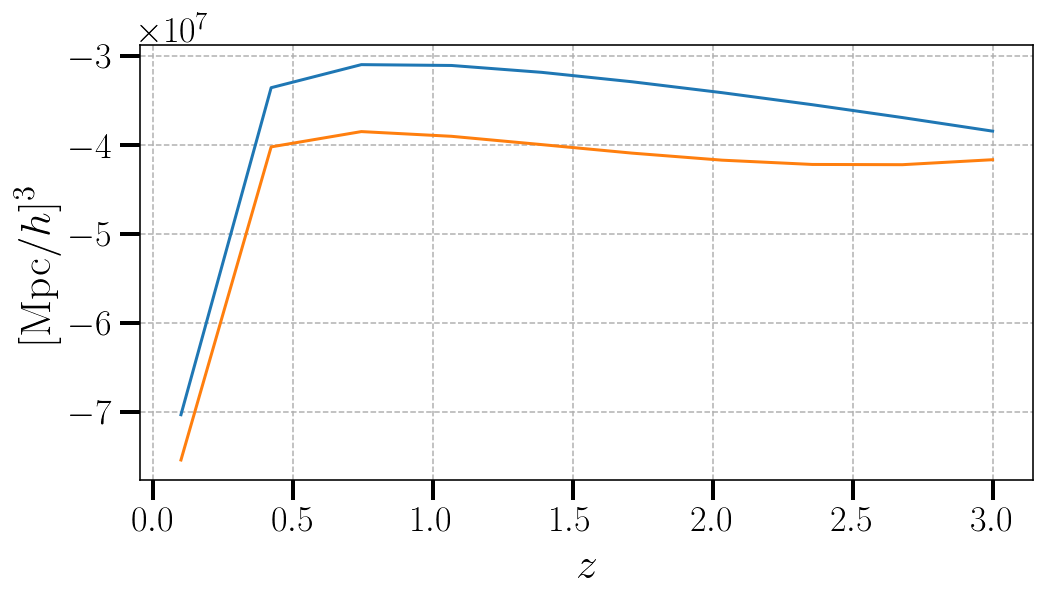

In [1145]:
plt.figure(figsize=(8,4))

#plt.xlim(0,1)
z_plot = np.linspace(0.1,3,10)
plt.grid(ls='--',lw=0.75)
theta_test = 1.3
k1_test=0.06
k2_test=0.05

plt.plot(z_plot,bk_wide_angle(k1_test,k2_test,theta_test,z_plot,0,0)/comoving_dist(z_plot))
plt.plot(z_plot,bk_dipo(k1_test,k2_test,theta_test,z_plot,0,0,1).real/comoving_dist(z_plot))
#plt.plot(z_plot,bk_df[0]/comoving_dist(z_plot))

#plt.xscale('log')
plt.xlabel('$z$')
plt.ylabel('$  \,\,[\mathrm{Mpc}/h]^3$')

In [ ]:
print(5)

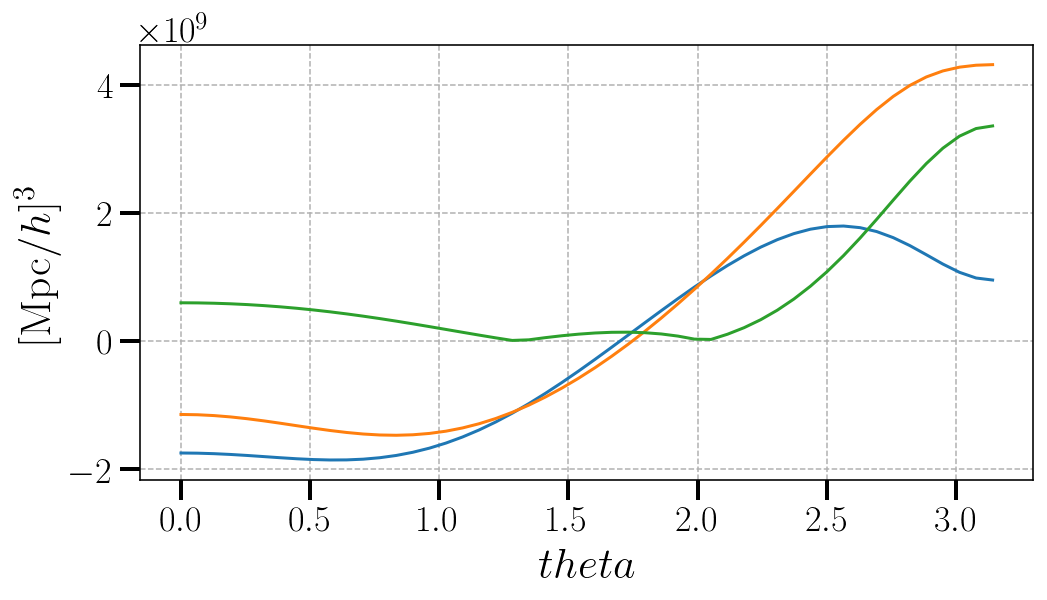

In [1362]:
plt.figure(figsize=(8,4))

z_plot = 8#np.linspace(0.1,3,10)
theta_test = np.linspace(1e-6,np.pi)
k1_test=0.02
k2_test=0.011
r=1
s=0
plt.plot(theta_test,(bk_wide_angle(k1_test,k2_test,theta_test,z_plot,r,s)/comoving_dist(z_plot)))
plt.plot(theta_test,(bk_dipo(k1_test,k2_test,theta_test,z_plot,r,s,1).real/comoving_dist(z_plot)))

just_deriv = np.abs(bk_dipo(k1_test,k2_test,theta_test,z_plot,r,s,1e+8).real/comoving_dist(z_plot)/1e+8)

plt.plot(theta_test,just_deriv)

#plt.yscale('log')
plt.xlabel('$theta$')
plt.ylabel('$  \,\,[\mathrm{Mpc}/h]^3$')
plt.grid(ls='--',lw=0.75)
plt.show()

#plt.plot(theta_test,just_deriv/np.abs(bk_wide_angle(k1_test,k2_test,theta_test,z_plot,r,s)/comoving_dist(z_plot)),'--')

In [ ]:
#test deriv terms 

plt.figure(figsize=(8,4))

z_plot = 1#np.linspace(0.1,3,10)
theta_test = np.linspace(1e-6,np.pi)
k1_test=0.02
k2_test=0.011
r=1
s=0
plt.plot(theta_test,(bk_wide_angle(k1_test,k2_test,theta_test,z_plot,r,s)/comoving_dist(z_plot))/bk_mono_func(k1_test,k2_test,theta_test))
plt.plot(theta_test,(bk_dipo(k1_test,k2_test,theta_test,z_plot,r,s,1).real/comoving_dist(z_plot))/bk_mono_func(k1_test,k2_test,theta_test))

just_deriv = np.abs(bk_dipo(k1_test,k2_test,theta_test,z_plot,r,s,1e+5).real/comoving_dist(z_plot)/1e+5)

#plt.plot(z_plot,bk_df[0]/comoving_dist(z_plot))

#plt.yscale('log')
plt.xlabel('$theta$')
plt.ylabel('$  \,\,[\mathrm{Mpc}/h]^3$')
plt.show()
plt.grid(ls='--',lw=0.75)
plt.plot(theta_test,just_deriv/np.abs(bk_wide_angle(k1_test,k2_test,theta_test,z_plot,r,s)/comoving_dist(z_plot)),'--')

In [955]:
#for sciccimarro comparison...
k1=0.1
k2=k1/2
theta = np.linspace(0,np.pi,200)

In [781]:
b1= 1.5#1.46#
gamma2 = -(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #-(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #
b2= 0.412 - 2.143*b1 +0.929*b1**2 + 0.008*b1**3 + 4/3 * gamma2
print(gamma2)

-0.14285714285714285


In [782]:
#So we need average (1/d) over redshift bin...
rout = comoving_dist(0.35)#1.2#
rmin = comoving_dist(0.15)#0.8#

d_plot = (3/2)*(rout**2-rmin**2)/(rout**3-rmin**3)
print(1/d_plot)

748.4145650550545


In [957]:
bkmono = bk_mono_func(k1,k2,theta)
bkquad = bk_quad_func(k1,k2,theta)

#Bk_wideangle = bk_wide_angle(k1,k2,theta,1/2,0)/d
Bk_wideangle1 = bk_wide_angle(k1,k2,theta,0,0)/(1/d_plot)
Bk_wideangle2 = bk_wide_angle(k1,k2,theta,1,0)/(1/d_plot)
Bk_wideangle3 = bk_wide_angle(k1,k2,theta,0,1)/(1/d_plot)
Bk_wideangle_mid = bk_wide_angle(k1,k2,theta,1/3,1/3)/(1/d_plot)
Bk_wideangle_mid1 = bk_wide_angle1(k1,k2,theta,1/3,1/3)/(1/d_plot)

#Bk_wideangled = bk_wide_angle_old(k1,k2,k3,1/2,1/2)/500

In [784]:
#z1x1 = Bk_wideangle1/bkmono
#z1x2 = Bk_wideangle2/bkmono
#z1x3 = Bk_wideangle3/bkmono
#z1xmid = Bk_wideangle_mid/bkmono

z2x1 = Bk_wideangle1/bkmono
z2x2 = Bk_wideangle2/bkmono
z2x3 = Bk_wideangle3/bkmono
z2xmid = Bk_wideangle_mid/bkmono


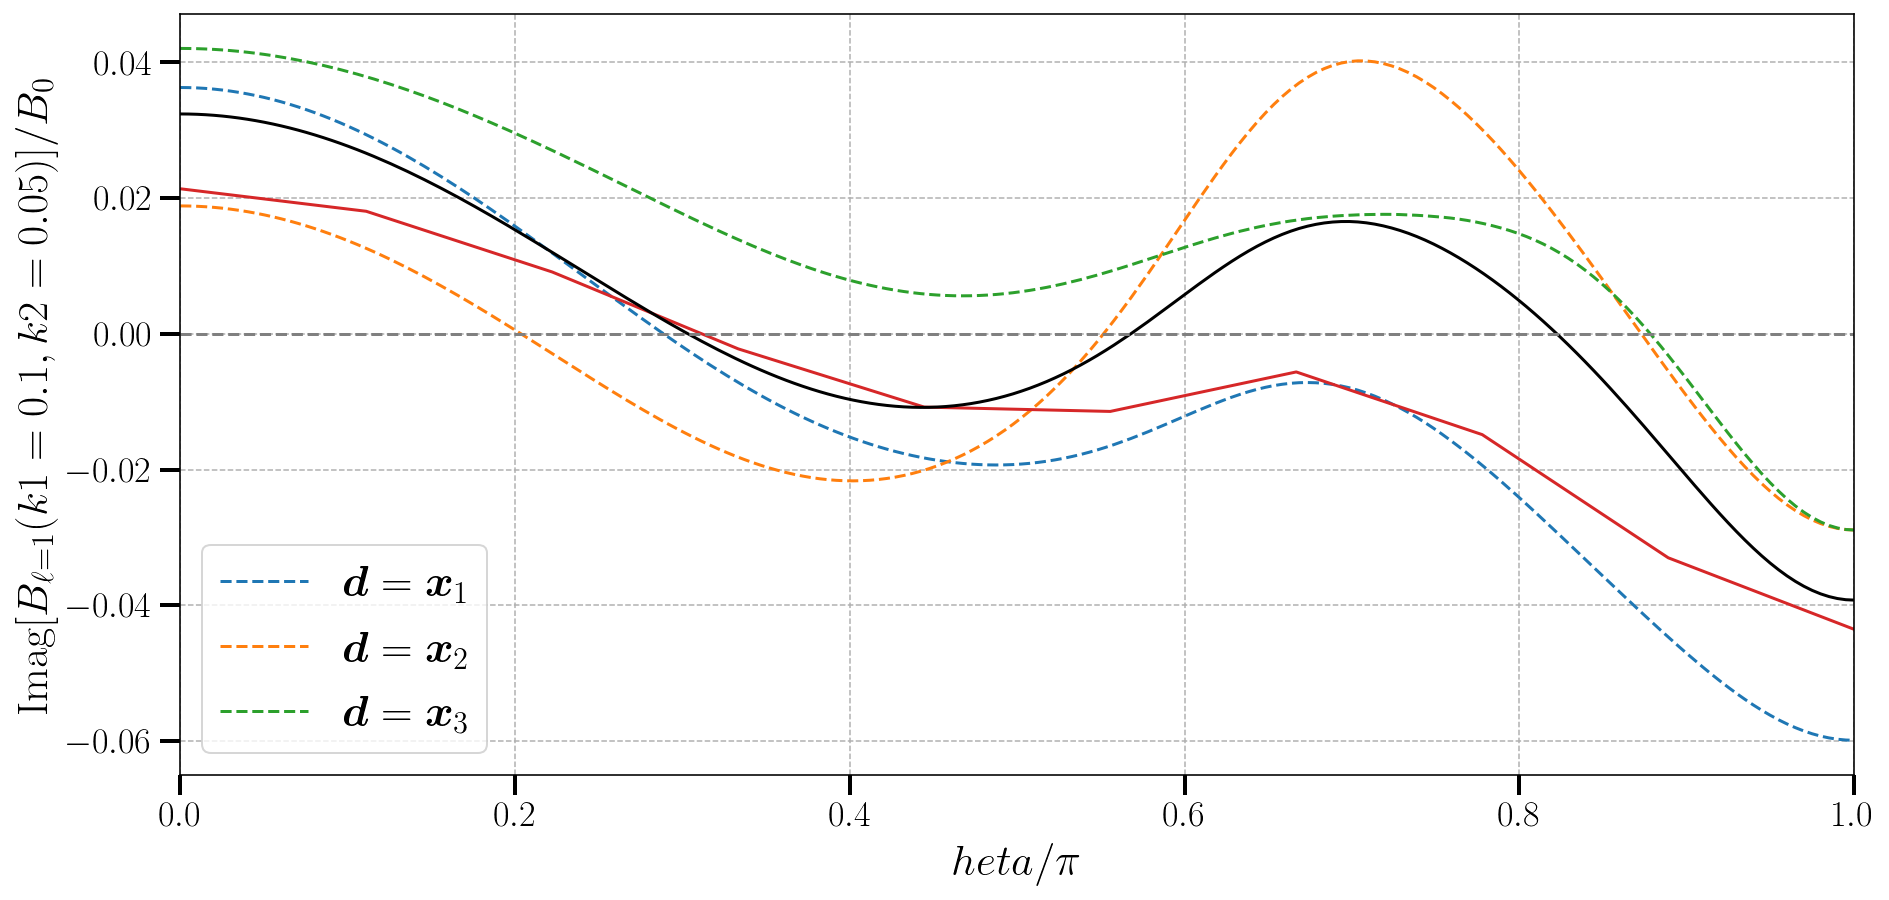

In [981]:
plt.figure(figsize=(15,7))
#plt.ylim(-0.7,0.2)
plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)
#plt.plot(theta/np.pi,Bk_wideangle3/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle2/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle1/bkmono)
#plt.axvline(x = 1/3, linestyle='-.', color = 'black')
#plt.plot(theta/np.pi,Bk_wideangle/bkmono,'-.')
plt.plot(theta/np.pi,Bk_wideangle1/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
plt.plot(theta/np.pi,Bk_wideangle2/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
plt.plot(theta/np.pi,Bk_wideangle3/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')

plt.plot(np.linspace(0,np.pi,10)/np.pi,bk_wa_dfog(1,k1,k2,np.linspace(0,np.pi,10),5,0,0)[0]/(1/d_plot)/bk_mono_func(k1,k2,np.linspace(0,np.pi,10)))
plt.plot(theta/np.pi,Bk_wideangle_mid/bkmono,'k')
#plt.plot(1-theta/np.pi,-Bk_wideangle_mid1/bkmono,'--')
plt.plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
#plt.plot(theta,fl.imag/flmono.real,'--')
plt.legend()
plt.xlabel('$\theta/ \pi\,$')
plt.ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
plt.savefig('wrong_wide_angle_theory.png')

<Figure size 792x360 with 0 Axes>

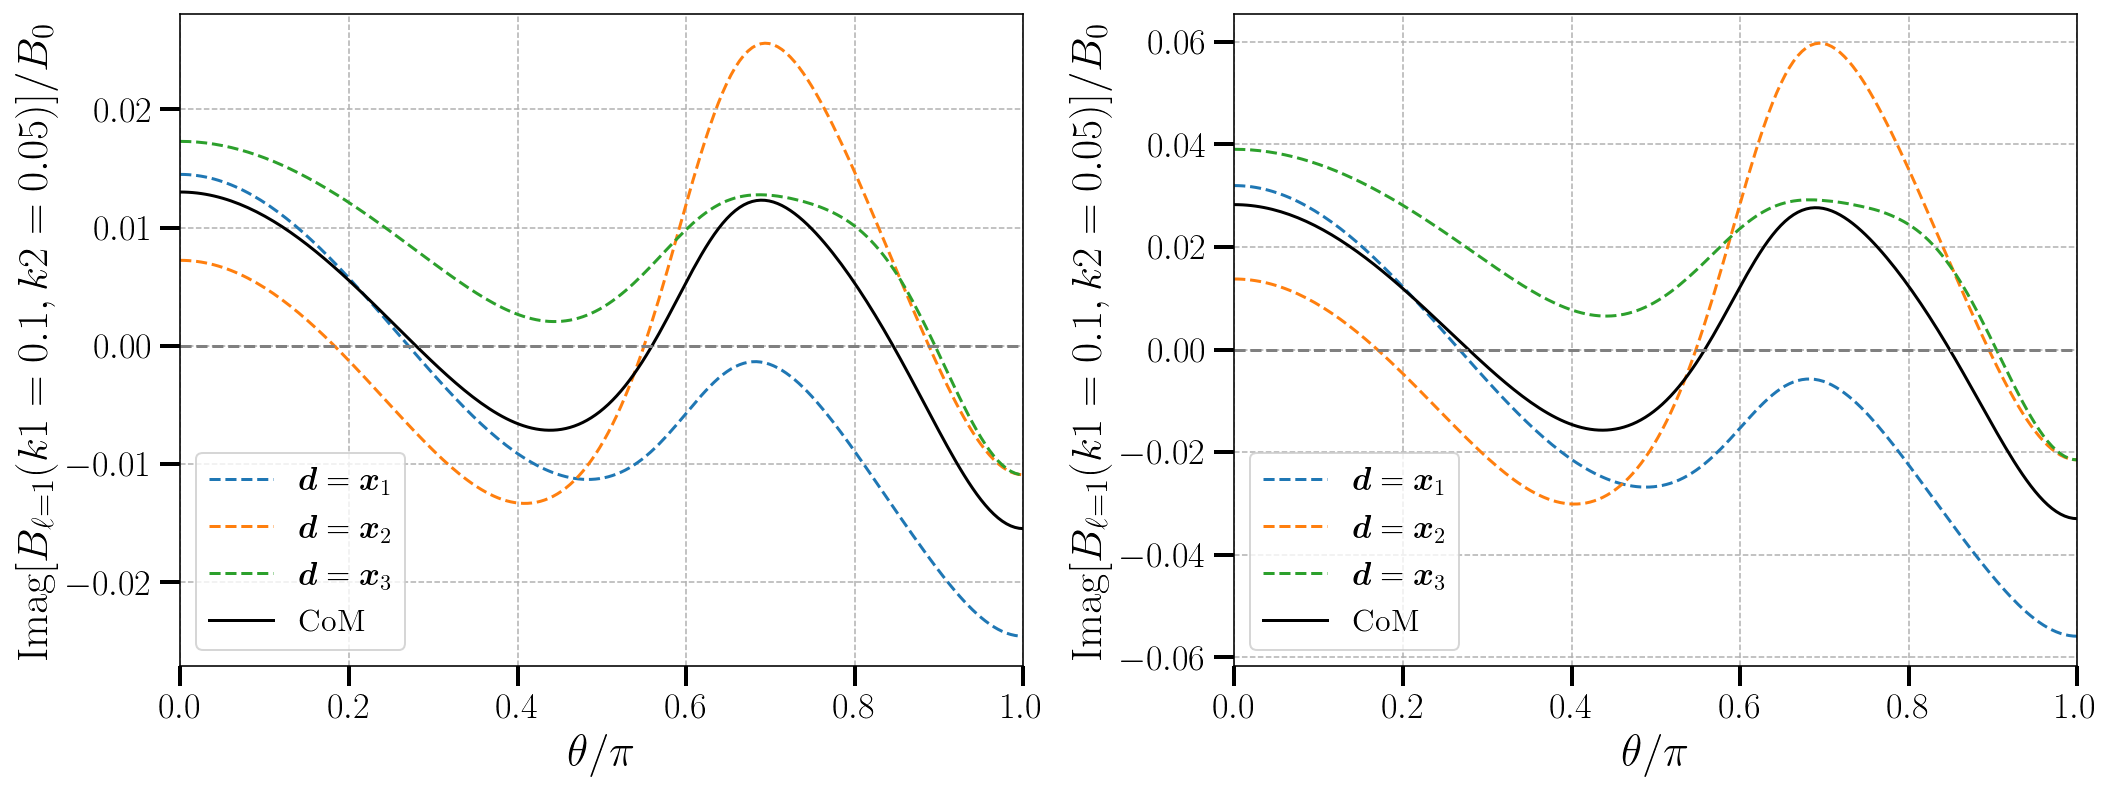

In [796]:
fig = plt.figure(figsize=(11, 5))

# Define gridspec with 4 rows and 3 columns
#gs = GridSpec(1, 2,width_ratios=[3, 3])

# Create subplots with custom aspect ratios
#axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(2)]  # Subplots in the first row

fig, axs = plt.subplots(1, 2,figsize=(17,6))
fig.subplots_adjust(wspace=0.25)
# Create the colormap plot
#im0 = axs[0].imshow(np.abs(bk0.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
#im1 = axs[1].imshow(np.abs(bk1.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
#im2 = axs[2].imshow(np.abs(bk2.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

axs[0].plot(theta/np.pi,z1x1,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
axs[0].plot(theta/np.pi,z1x2,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
axs[0].plot(theta/np.pi,z1x3,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')
axs[0].plot(theta/np.pi,z1xmid,'k',label=r'$\text{CoM}$')
axs[0].plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
axs[0].legend(fontsize =16)
axs[0].set_xlim(0,1)
#axs[0].set_ylim(-0.07,0.07)
axs[0].set_xlabel(r'$\theta/ \pi\,$')
axs[0].set_ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
axs[0].grid(ls='--',lw=0.75)


axs[1].plot(theta/np.pi,z2x1,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
axs[1].plot(theta/np.pi,z2x2,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
axs[1].plot(theta/np.pi,z2x3,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')
axs[1].plot(theta/np.pi,z2xmid,'k',label=r'$\text{CoM}$')
axs[1].plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
axs[1].legend(fontsize =16)
axs[1].set_xlim(0,1)
#axs[1].set_ylim(-0.07,0.07)

axs[1].set_xlabel(r'$\theta/ \pi\,$')
axs[1].set_ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
axs[1].grid(ls='--',lw=0.75)

plt.savefig('Milad_plot.png', bbox_inches='tight', dpi=400)
#axs[1].yaxis.set_major_locator(plt.NullLocator())


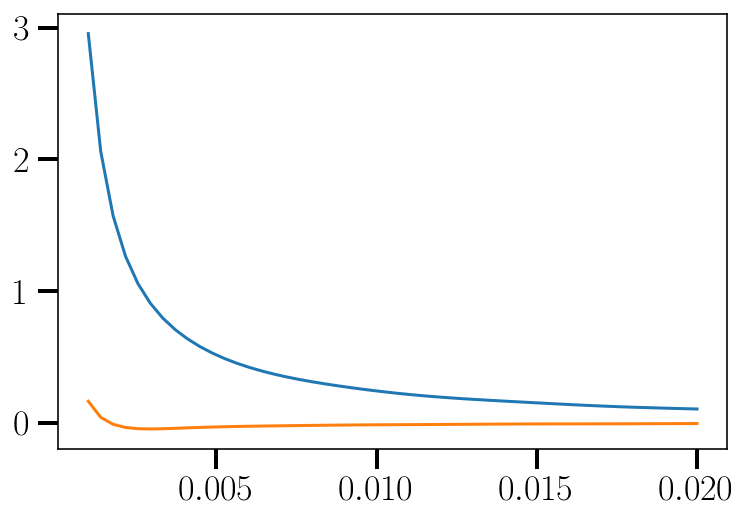

In [1428]:
#lets get squeezed

#k1=k2=10*k3
k1 = np.linspace(0.01,0.2)
k2=k1
k3=k1/10
theta = np.arccos((k3**2 -k1**2 - k2**2)/(2*k1*k2))

zz=0.5
d_z = comoving_dist(zz)
plt.plot(k3,bk_dipo(k1,k2,theta,zz,0,0,1).real/d_z/bk_mono_func(k1,k2,theta))
plt.plot(k3,bk_dipo(k1,k2,theta,zz,0,0,0).real/d_z/bk_mono_func(k1,k2,theta))

In [1469]:
#so data storage format
#bk_mono = {}
#bk1 = {}
#bk2 = {}
#bk3 = {}
#so data storage format
#bk1_deriv = {}
#bk2_deriv = {}
#bk3_deriv = {}

#bk1_full = {}
#bk2_full = {}
#bk3_full = {}
#where these functions of z

bkmid_full={}

In [1472]:
#%%time
k1 = 0.05

# Define the function
#@jit
def triangle_plot(x, y,zz,r=0,s=0,c=0):
    """Get array of"""
    bk = np.zeros((len(x),len(y)))
    d_z = comoving_dist(zz)
    #so only do select values of bispectrum...
    for i in tqdm(range(len(x))):
        #array version:
        k2 = y*k1
        k3 = x[i]*k1
        theta = np.arccos((k3**2 -k1**2 - k2**2)/(2*k1*k2))  
        bk[i] = np.where(np.logical_and((y > 1 - x[i]), (y>x[i])),k1*k2*k3*bk_dipo(k1,k2,theta,zz,r,s,c).real/d_z,np.nan)
        #bk[i] = np.where(np.logical_and((y > 1 - x[i]), (y>x[i])),bk_wide_angle(k1,k2,theta,zz,r,s).real/d_z,np.nan)
        #bk[i] = np.where(np.logical_and((y > 1 - x[i]), (y>x[i])),bk_mono_func(k1,k2,theta),np.nan)  
    return bk


xx = np.linspace(0.01, 1, 500)
yy = np.linspace(0.5, 1, 500)
z=0.1

print('comving_distance =', comoving_dist(z))
keyz= str(z)
#bk_mono[keyz] = triangle_plot(xx,yy,z,0,0,c=0)
#bk1[keyz] = triangle_plot(xx,yy,z,0,0,c=0)
#bk2[keyz] = triangle_plot(xx,yy,z,1,0,c=0)
#bk3[keyz] = triangle_plot(xx,yy,z,0,1,c=0)
#bk1_full[keyz] = triangle_plot(xx,yy,z,0,0,c=1)
#bk2_full[keyz] = triangle_plot(xx,yy,z,1,0,c=1)
#bk3_full[keyz] = triangle_plot(xx,yy,z,0,1,c=1)
#bk1_deriv[keyz] = triangle_plot(xx,yy,z,0,0,1e+10)/1e+10
#bk2_deriv[keyz] = triangle_plot(xx,yy,z,1,0,1e+10)/1e+10
#bk3_deriv[keyz] = triangle_plot(xx,yy,z,0,1,1e+10)/1e+10
bkmid_full[keyz] = triangle_plot(xx,yy,z,1/3,1/3,c=1)

comving_distance = 299.9944002144611


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-1472-37f89fa3d481>:15: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((k3**2 -k1**2 - k2**2)/(2*k1*k2))
<ipython-input-1184-7f061092b3ce>:35: RuntimeWarning: invalid value encountered in divide
  bk_23 = (-38808*Pk2*Pk3*b1**3*c*fd*k1**4*k2**2*k3**2*s - 25872*Pk2*Pk3*b1**3*c*fd*k1**2*k2**4*k3**2*s + 32340*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*s + 6468*Pk2*Pk3*b1**3*c*fd*k1**2*k3**6*r - 51744*Pk2*Pk3*b1**3*f*k1**4*k2**2*k3**2*s - 12936*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*r - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*s + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*s + 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2 + 161700*Pk2*Pk3

In [1455]:
bk1_deriv.keys()

dict_keys(['0.25', '0.1'])

In [1463]:
def plot_triangle(bk,vmax,vmin=1): #plot triangle with mask!
    plt.figure(figsize=(8,3.5))
    # Create the colormap plot
    im = plt.imshow(np.abs(bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(vmin, vmax=vmax))#,vmin=0,vmax=vmax)#
    #im = plt.imshow((bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#
    
    cbar = plt.colorbar(im)#format='%.0e'
    cbar.set_label(r"$B_{\ell=1}(k_1=0.05,k_2,k_3)$")#P_{HI}(k1=0.05, \mu_1)P_{HI}(k2, \mu_2)P_{HI}(k3, \mu_3)B_{\text{Gravitational}(k1=0.05)}

    # Add labels and title
    plt.xlabel('$k_3/k_1$')
    plt.ylabel('$k_2/k_1$')

    #so masking 
    # Create a mask for the triangular region
    size = int(1e+3)
    x = np.linspace(0.0, 1, size,dtype=np.float32)
    y = np.linspace(0.5, 1,  size,dtype=np.float32)
    xx,yy = np.meshgrid(x,y)
    mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
    im = plt.imshow(mask, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='binary')
    
    plt.grid(ls='--',lw=0.75,color='k',alpha=0.1)
    
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    plt.text(0.06,0.55,'$r=s=1/3$')
    plt.plot(x_bound,y_bound,'k',linewidth=3)
    # Show the plot
    plt.savefig('B_var60.png', bbox_inches='tight', dpi=400)
    plt.show()

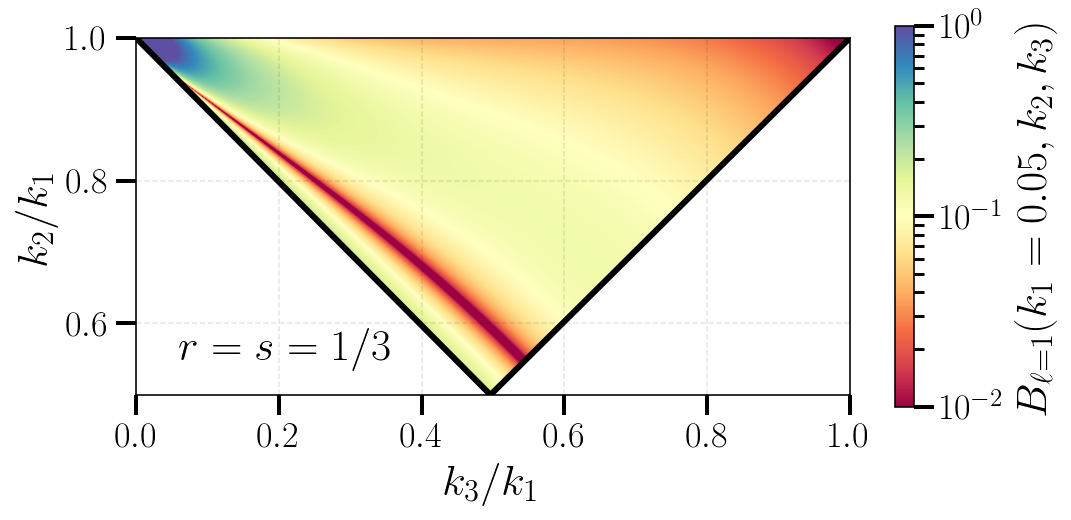

In [1473]:

#plt.plot([0.2,0.54],[0.85,0.56])
#plot_triangle(bk0_25/bk_mono,1)#d = x1
#plot_triangle(bk0_25deriv/bk0_25,1)
plot_triangle(bkmid_full['0.1']/bk_mono['0.1'],1,1e-2)#d = x1
#plot_triangle(bk2,0.3)#d = x2
#plot_triangle(bk3,0.3)#d = x3


In [528]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [1475]:
def plot_triangle_multi(bk0,bk1,bk2,vmax): #plot triangle with mask!   
        
    fig = plt.figure(figsize=(12, 5))

    # Define gridspec with 4 rows and 3 columns
    gs = GridSpec(1, 3, width_ratios=[3, 3, 3])

    # Create subplots with custom aspect ratios
    axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(3)]  # Subplots in the first row

    #fig, axs = plt.subplots(1, 3,figsize=(14,5),sharey=True)
    fig.subplots_adjust(wspace=0)
    # Create the colormap plot
    im0 = axs[0].imshow(np.abs((bk0).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    im1 = axs[1].imshow(np.abs((bk1).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    im2 = axs[2].imshow(np.abs((bk2).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

    #im0 = axs[0].imshow(((bk0).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    #im1 = axs[1].imshow(((bk1).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    #im2 = axs[2].imshow(((bk2).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#

    #divider = make_axes_locatable(axs[2])
    #colorbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    #cbar = plt.colorbar(im2, cax=colorbar_ax)
    #
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.4])
    cbar = fig.colorbar(im2, cax=cbar_ax,ticks=[0.01, 0.1, 1])
    #cbar.set_label(r"$ |B^{\rm wa}_{\ell=1}(k_1=0.05)|/B^{\rm pp}_{\ell=0}$")#"$ |B_{\ell=1}(k_1=0.05)|/B_0 $"
    cbar.set_label(r"$ |B^{\rm red}_{\ell=1}(k_1=0.05)|/B^{\rm wa}_{\ell=0}$")#"$ |B_{\ell=1}(k_1=0.05)|/B_0 $"
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    #so masking 
    # Create a mask for the triangular region
    for i in range(3):
        #axs[i].set_aspect(10)  # Adjust aspect ratio manually
        if i ==0:
            #axs[i].set_yticks(np.arange(0, 0.5, 0.1))
            axs[i].set_ylabel('$k_2/k_1$')
        #size = int(1e+3)
        #x = np.linspace(0.0, 1, size,dtype=np.float32)
        #y = np.linspace(0.5, 1,  size,dtype=np.float32)
        #xx,yy = np.meshgrid(x,y)
        #mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
        #axs[i].imshow(mask, aspect=1.5, interpolation='bilinear', origin='lower', cmap='binary')
        axs[i].plot(x_bound,y_bound,'k',linewidth=3)
        axs[i].text(0.08,0.55,r'$\boldsymbol{d}=\boldsymbol{x}_%d$'%(i+1),fontsize=20)
        axs[i].set_xlabel('$k_3/k_1$')
        axs[i].set_xticks(np.arange(0.1, 0.91, 0.2))
        #axs[i].set_box_aspect(aspect=0.8)
        #axs[i].set_xlim(0,1)
        #axs[i].set_ylim(0.5,1)
        #axs[i].grid(ls='--',lw=0.75,color='k',alpha=0.1)
        
        if i!=0:
            axs[i].yaxis.set_major_locator(plt.NullLocator())
    
    # Show the plot
    plt.savefig('endpoint_traingles.png', bbox_inches='tight', dpi=400)
    plt.show()

In [1318]:
def add_dict(dict1,dict2,key):
    new_dict = {}
    new_dict[key] = dict1[key]+dict2[key]
    return new_dict
def minus_dict(dict1,dict2,key):
    new_dict = {}
    new_dict[key] = dict1[key]+dict2[key]
    return new_dict

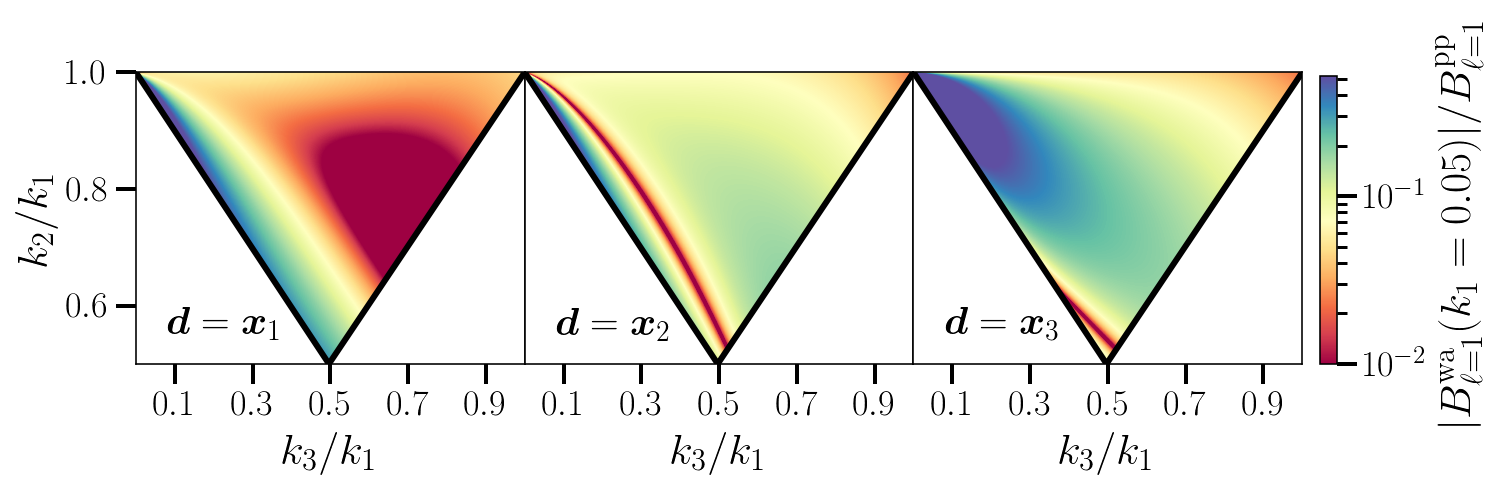

In [1448]:
plot_triangle_multi(bk1['0.1']/bk_mono['0.1'],bk2['0.1']/bk_mono['0.1'],bk3['0.1']/bk_mono['0.1'],0.52)

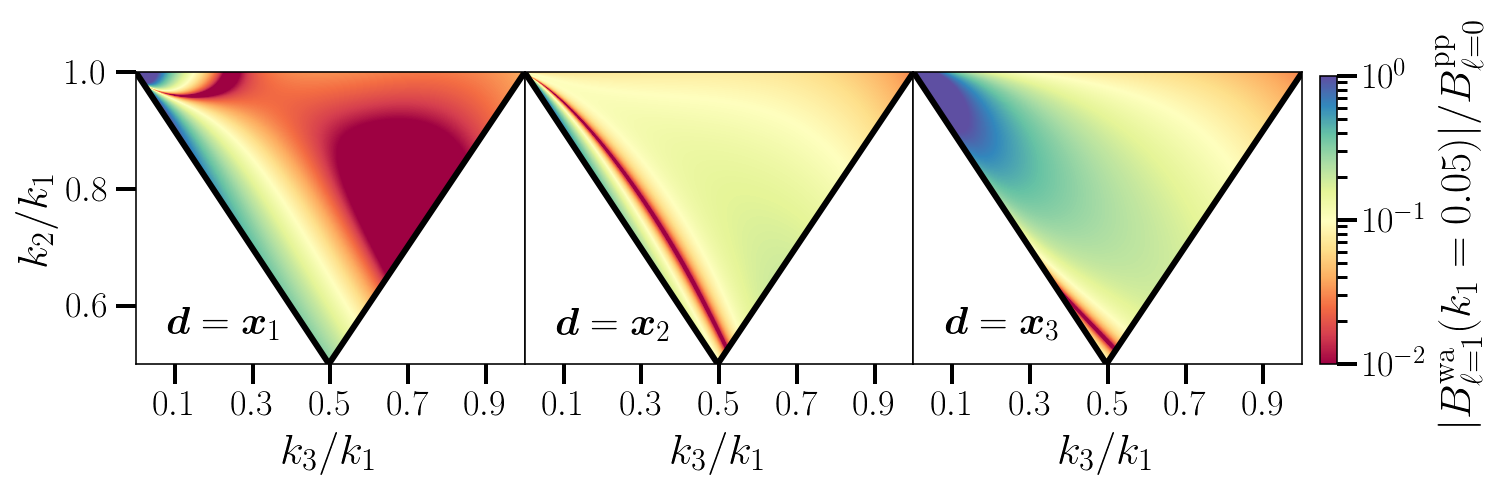

In [1457]:
plot_triangle_multi(bk1_full['0.1']/bk_mono['0.1'],bk2_full['0.1']/bk_mono['0.1'],bk3_full['0.1']/bk_mono['0.1'],1)

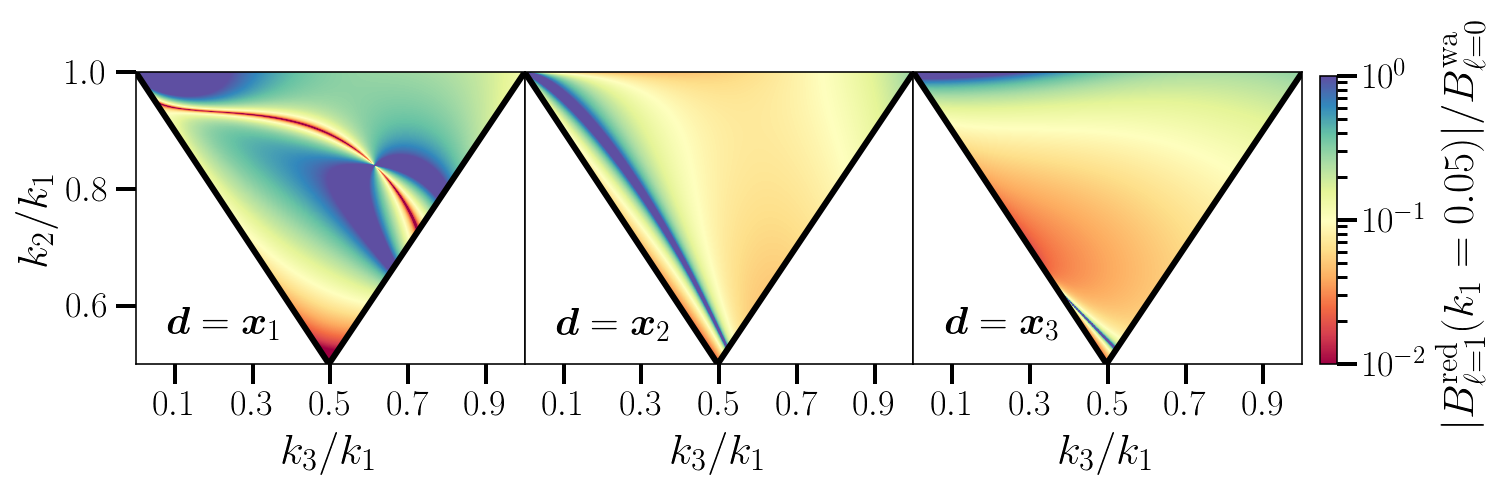

In [1476]:
plot_triangle_multi(bk1_deriv['0.1']/bk1['0.1'],bk2_deriv['0.1']/bk2['0.1'],bk3_deriv['0.1']/bk3['0.1'],1)

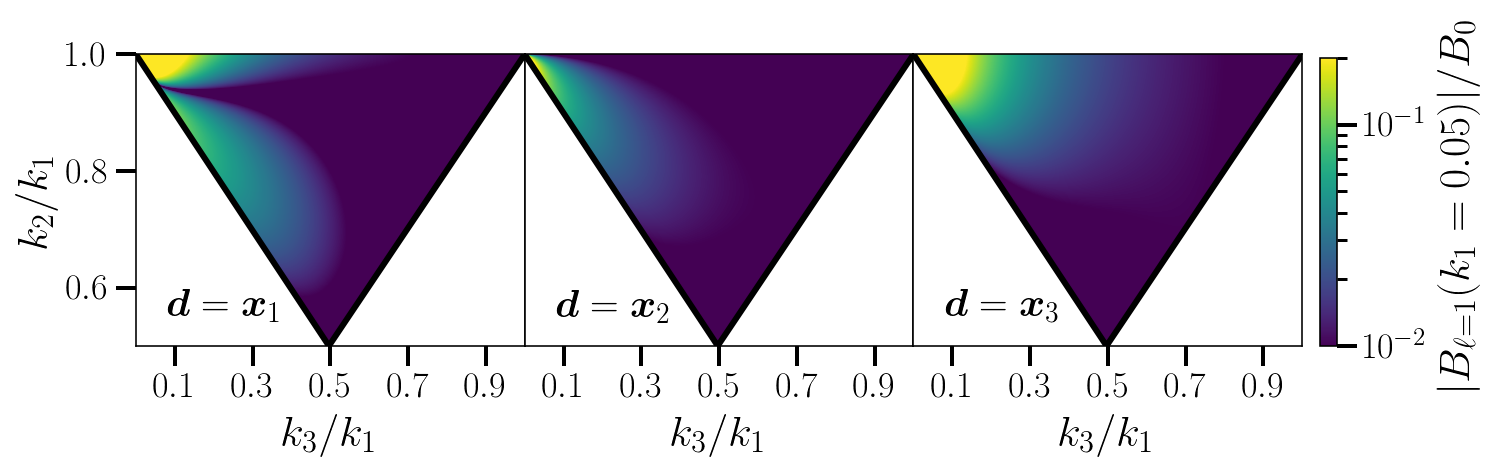

In [1332]:
plot_triangle_multi(bk1_deriv['0.1']/bk_mono['0.1'],bk2_deriv['0.1']/bk_mono['0.1'],bk3_deriv['0.1']/bk_mono['0.1'],0.2)

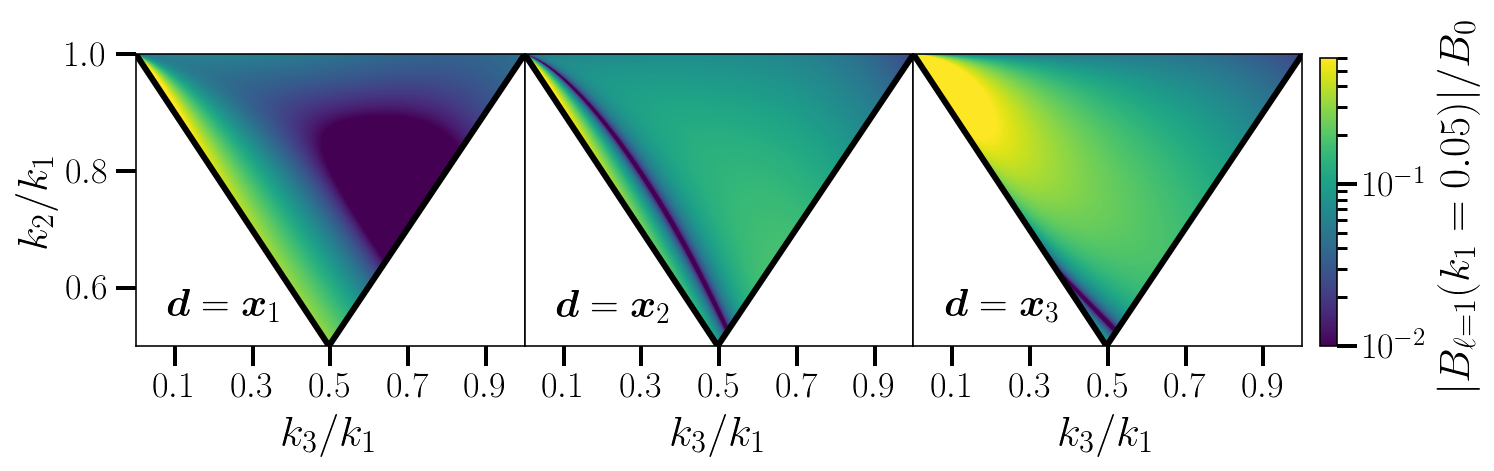

In [1304]:
plot_triangle_multi(bk1,bk2,bk3,0.6)

Figure(1080x288)


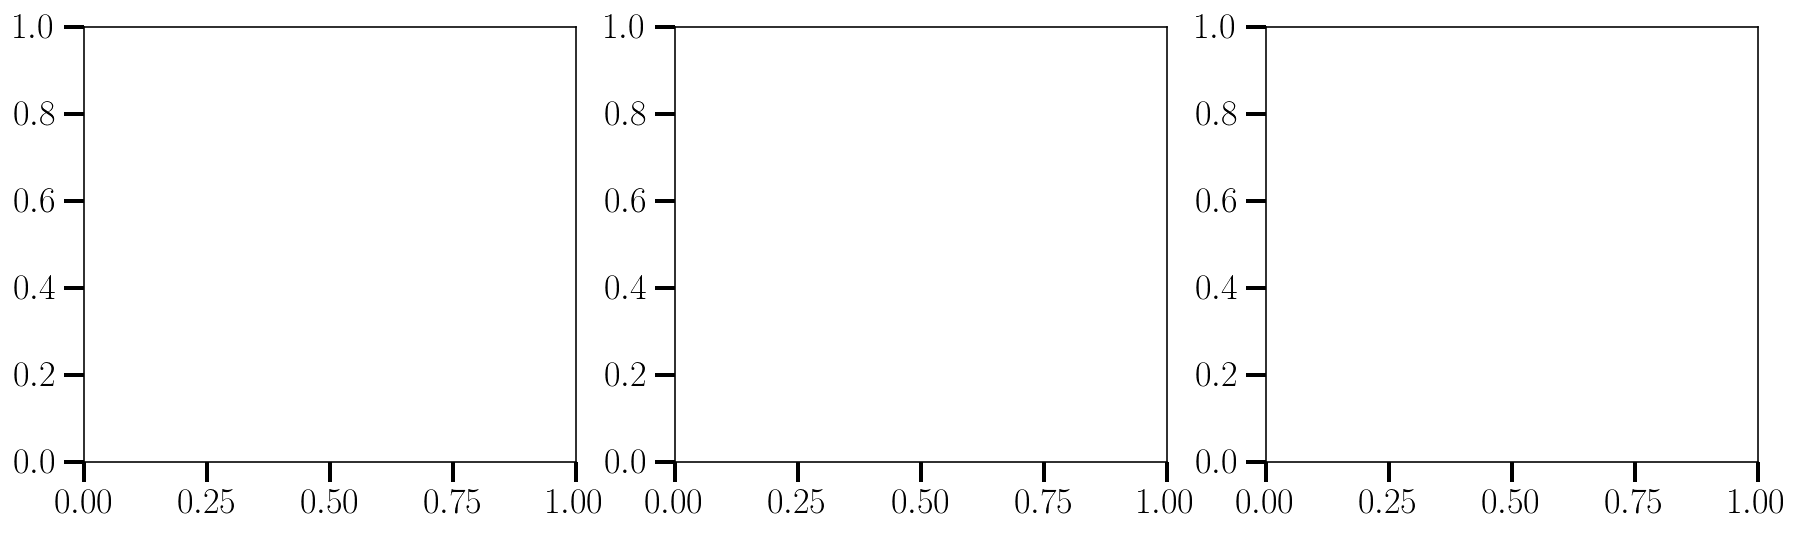

In [363]:
fig, axs = plt.subplots(1, 3,figsize=(15,4))
print(fig)

Text(0, 0.5, '$ |B_{\\ell=1}(k1=0.04,k2=0.02)|/B_0 \\,\\,[\\mathrm{Mpc}/h]^3$')

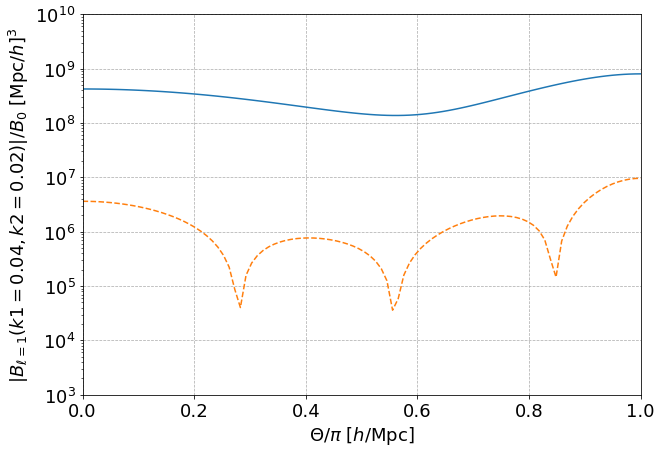

In [1091]:
plt.figure(figsize=(10,7))
plt.ylim(1e3,1e10)
plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)
#plt.plot(theta/np.pi,Bk_wideangle3/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle2/bkmono)
#plt.plot(theta/np.pi,Bk_wideangle1/bkmono)
#plt.axvline(x = 1/3, linestyle='-.', color = 'black')
plt.plot(theta/np.pi,bkmono)
plt.plot(theta/np.pi,np.abs(Bk_wideangle_mid),'--')
#plt.plot(theta/np.pi,np.abs(Bk_wideangle_mid1),'--')
plt.plot(1-theta/np.pi,np.zeros_like(theta),'k')
#plt.plot(theta,fl.imag/flmono.real,'--')
plt.yscale('log')
plt.xlabel('$\Theta/ \pi\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ |B_{\ell=1}(k1=0.04,k2=0.02)|/B_0 \,\,[\mathrm{Mpc}/h]^3$')

In [700]:
Bk_wideangle1 = bk_wide_angle(k1,k2,theta,1,0)/d
Bk_wideangle2 = bk_wide_angle(k1,k2,theta,0,1)/d
Bk_wideangle3 = bk_wide_angle(k1,k2,theta,0,0)/d

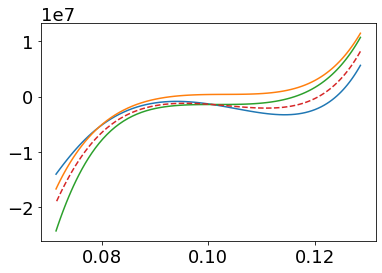

In [643]:
plt.plot(k3,Bk_wideangle1)
plt.plot(k3,Bk_wideangle2)
plt.plot(k3,Bk_wideangle3)
plt.plot(k3,Bk_wideangle,'--')

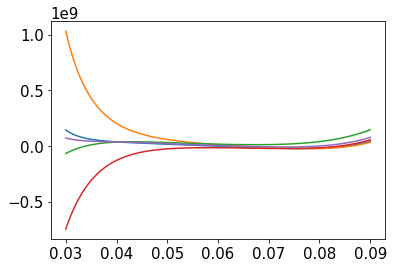

In [927]:
plt.plot(k3,Bk_wideangle)
plt.plot(k3,Bk_wideangle1)
plt.plot(k3,Bk_wideangle2)
plt.plot(k3,Bk_wideangle3)
plt.plot(k3,(Bk_wideangle1+Bk_wideangle2+Bk_wideangle3)/3)
#plt.xlim(0.01,0.18)
#plt.ylim(-1e+7,2e+8)

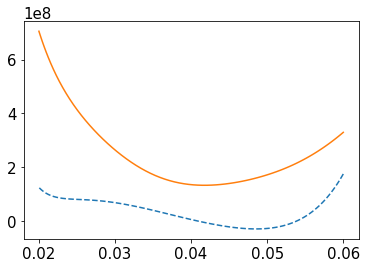

In [940]:
plt.plot(k3,Bk_wideangle_mid,'--')
plt.plot(k3,bkmono)

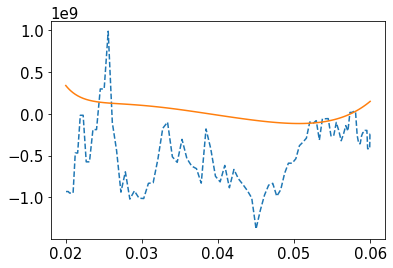

In [840]:
#plt.plot(k3,bkmono,'--')
plt.plot(k3,-fl.imag,'--')
plt.plot(k3,Bk_wideangle)
#plt.xlim(0.04,0.18)
#plt.ylim(-1e+6,2e+8)

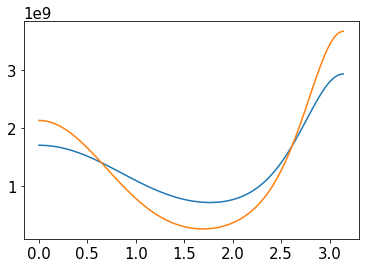

In [843]:
plt.plot(theta,bkmono)
#plt.plot(theta,np.real(flmono),'--')
plt.plot(theta,bkquad)
#plt.xlim(0.06,0.18)
#plt.ylim(1e-3,2e+8)
#plt.plot(bkmono_ol)
#plt.plot(bkquad_ol)

In [296]:
Pl0_pp = b1**2 *Plin + (2*b1*f*Plin)/3 + (f**2 *Plin)/5
Pl0_pp1 = b1**2 *Pk_lin(k_est) + (2*b1*f*Pk_lin(k_est))/3 + (f**2 *Pk_lin(k_est))/5

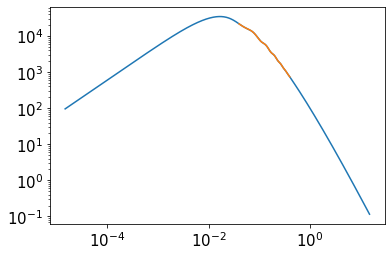

In [297]:
plt.loglog(k,Pl0_pp)
plt.loglog(k_est,Pl0_pp1)

/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


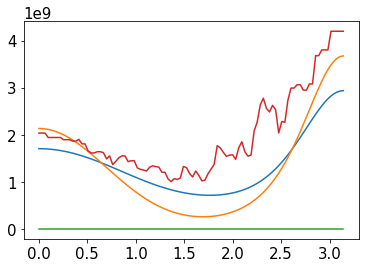

In [668]:
plt.plot(theta,(bkmono))
plt.plot(theta,(bkquad))
plt.plot(theta,(fl))
plt.plot(theta,(flmono))

In [29]:
import numpy as np
import sys
from time import time
sys.path.append('/home/addis/unamed_code')
sys.path.append('/home/addis/unamed_code/Library')
import Bk_theta_iFFT as Bk_
import Bk_theta_sum as Bk_sum
#import Bk_theta_sum2 as Bk_sum2
#import Bk_theta1 as Bk_theta

import get_field as gf
from matplotlib import pyplot as plt
import compute_grid_info as cgi

In [91]:
#field things!
path = '../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'
    
    
Nside=128
L=1000

In [432]:
%%time
rfft=False
order=2
obs_pos=(500,500,500)
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)  # so call 
xi,ki,k_mag,MAS,k_f,k_ny = grid_info

CPU times: user 133 ms, sys: 99.7 ms, total: 232 ms
Wall time: 231 ms


In [433]:
import Pk_old as Pk
k_est = np.linspace(0.006,0.4,100)
s=1 #units of 2*k_f
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[2],grid_info[4])
#In_bin,N_modes
iFFT=False
dtype=np.complex64
threads=4
verbose=True
t=1
l=1
#j_old = Pk_old.Pk(field_tmp,L,Nside,l,k,grid_info,binning_info,t,iFFT,dtype,threads,rfft,verbose)
j = Pk.Pk(field,L,Nside,l,k_est,grid_info,binning_info,t,iFFT,dtype,threads,rfft,verbose)

In [591]:
%%time
dtype=np.complex64
s=1 #units of 2*k_f
threads=4
rs=[0,0]
binning_info = cgi.bk_theta_compute_bins(k1,k2,theta,Nside,s,grid_info[2],grid_info[4],dtype,threads,rfft)
#In_bin,Ntri,in_k1,in_k2

CPU times: user 16 s, sys: 2.54 s, total: 18.6 s
Wall time: 5.52 s


In [601]:
rs = [1,0]
verbose =True
l = 1

In [598]:
%%time
j = Bk_.Bk(field,l,L,Nside,theta,grid_info,binning_info,rs,dtype,threads,rfft,verbose)

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 1 Number of iFFTs used= 102


NameError: name 'Bk_midpoint_theta' is not defined

In [1056]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
